# Test

In [1]:
import nonlinear_dce
import nonlinear
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/opt/anaconda3/envs/admg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

dummy_model = DummyModel()

dagma = nonlinear_dce.DagmaDCE(model=dummy_model, use_mle_loss=True)
dims = [5,7,1]
dagma_mlp = nonlinear_dce.DagmaMLP_DCE(dims=dims)
n, d = 100, dims[0]
target = torch.randn(n, d)
output = target + 0.1 * torch.randn(n, d)

A = torch.randn(d, d)
Sigma = A @ A.T + 1e-3 * torch.eye(d)

In [23]:
def get_nonlinear_reg(observed_derivs, observed_hess, m=1e-1):
    # constants on the right device/dtype
    m_t = torch.as_tensor(m, device=observed_hess.device, dtype=observed_hess.dtype)

    # encourage |H| >= m where |J| is large
    # detach H so we don't backprop through second→third order
    gap = torch.clamp_min(m_t - observed_hess.abs().detach(), 0.0)  # [d, d]
    print("gap: ", gap)

    # broadcast over batch n; penalty per (sample, j, k)
    penalty = observed_derivs.abs() * gap  # [n, d, d]

    return penalty.sum()

In [24]:
observed_derivs = torch.tensor([[0.0038, 0.7381], [0.0136,0.0152]])
observed_hess = torch.tensor([[0.0003, 0.0151], [0.0002, 0.0001]])
print(get_nonlinear_reg(observed_derivs, observed_hess))

gap:  tensor([[0.0997, 0.0849],
        [0.0998, 0.0999]])
tensor(0.0659)


## Forward

In [4]:
dagma_mlp.forward(target).shape

torch.Size([100, 5])

## MLE loss

In [19]:
def mle_loss(output: torch.Tensor, target: torch.Tensor, Sigma: torch.Tensor):
    """Computes the MLE loss 1/n*Tr((X-X_est)Sigma^{-1}(X-X_est)^T)"""
    n, d = target.shape
    tmp = torch.linalg.solve(Sigma, (target - output).T)
    mle = torch.trace((target - output)@tmp)/n
    sign, logdet = torch.linalg.slogdet(Sigma)
    mle += logdet
    return mle

In [21]:
n, d = 10, 5
output = torch.randn(n, d)
target = torch.randn(n, d)
Sigma = torch.randn(d, d)
loss_value = mle_loss(output=output, target=target, Sigma=Sigma)
print("MLE loss:", loss_value.item())

MLE loss: 1.8786629388823854


In [22]:
tmp = 0
diff = target - output
for i in range(0,n):
    tmp += diff[i, :]@ torch.inverse(Sigma)@diff[i, :].unsqueeze(1)

logdet = torch.logdet(Sigma)
loss_value2 = tmp/n + logdet
print("MLE loss:", loss_value2.item())

MLE loss: 1.878662938882385


## Ancestral loss

In [6]:
Sigma = torch.tensor([[0.5, 0.3],   
                [0.3, 1.5]])
Wii = torch.diag(torch.diag(Sigma))
W2 = Sigma - Wii

W1 = torch.tensor([[0.0, 1.0],   
                [0.0, 0.0]])
ancestrality =dagma_mlp.ancestrality_loss(W1, W2)
print("ancestrality_loss", ancestrality)

ancestrality_loss tensor(0.0900)


In [7]:
Sigma = torch.tensor([[0.5, 0.8],   
                [0.8, 1.5]])
Wii = torch.diag(torch.diag(Sigma))
W2 = Sigma - Wii

W1 = torch.tensor([[0.0, 1.0],   
                [0.0, 0.0]])
ancestrality =dagma_mlp.ancestrality_loss(W1, W2)
print("ancestrality_loss", ancestrality)

ancestrality_loss tensor(0.6400)


## h_func

In [8]:
W1 = torch.rand(d, d)   # values in [0,1)
W2 = torch.rand(d, d)
h_value =dagma_mlp.h_func(W1, W2)
print("h_value:", h_value.item())

h_value: 4.190249672446955


## Log Cholesky

In [9]:
A = torch.randn(d, d)             
Sigma = A @ A.T + 1e-3 * torch.eye(d)
print("Sigma: ", Sigma)

Sigma:  tensor([[ 6.0858, -1.8737, -2.6806, -0.2402,  2.3097],
        [-1.8737,  2.1774,  1.1716, -0.8645, -1.7391],
        [-2.6806,  1.1716,  1.4572,  0.0255, -1.4567],
        [-0.2402, -0.8645,  0.0255,  1.4165, -0.7480],
        [ 2.3097, -1.7391, -1.4567, -0.7480,  3.4123]])


In [10]:
M = nonlinear_dce.reverse_SPDLogCholesky(Sigma)
print("M: ", M)

M:  tensor([[ 0.9030,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.7595,  0.2352,  0.0000,  0.0000,  0.0000],
        [-1.0866,  0.2737, -0.8007,  0.0000,  0.0000],
        [-0.0974, -0.7418,  0.2734, -0.1230,  0.0000],
        [ 0.9362, -0.8126, -0.4832, -1.2750, -2.0573]])


In [11]:
Sigma = nonlinear_dce.SPDLogCholesky(M)
print("Sigma: ", Sigma)

Sigma:  tensor([[ 6.0858, -1.8737, -2.6806, -0.2402,  2.3097],
        [-1.8737,  2.1774,  1.1716, -0.8645, -1.7391],
        [-2.6806,  1.1716,  1.4572,  0.0255, -1.4567],
        [-0.2402, -0.8645,  0.0255,  1.4165, -0.7480],
        [ 2.3097, -1.7391, -1.4567, -0.7480,  3.4123]])


## Simulation

### random init

In [5]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[0.5, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = 10*torch.sin(x1)
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = 10*torch.sin(x1)+ epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [6]:
eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)


  1%|          | 154/29000 [00:00<01:37, 295.09it/s]

Sigma:  tensor([[0.9605, 0.0195],
        [0.0195, 1.0411]], grad_fn=<MmBackward0>)
obj:  tensor(28.6644, grad_fn=<AddBackward0>)
mle loss:  tensor(28.6608, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


  1%|          | 278/29000 [00:01<01:17, 369.52it/s]

Sigma:  tensor([[0.9215, 0.0375],
        [0.0375, 1.0838]], grad_fn=<MmBackward0>)
obj:  tensor(25.5367, grad_fn=<AddBackward0>)
mle loss:  tensor(25.5259, grad_fn=<AddBackward0>)
h_val:  tensor(0.0046, grad_fn=<AddBackward0>)


  1%|          | 359/29000 [00:01<01:14, 383.70it/s]

Sigma:  tensor([[0.8827, 0.0530],
        [0.0530, 1.1273]], grad_fn=<MmBackward0>)
obj:  tensor(22.4602, grad_fn=<AddBackward0>)
mle loss:  tensor(22.4386, grad_fn=<AddBackward0>)
h_val:  tensor(0.0119, grad_fn=<AddBackward0>)


  2%|▏         | 485/29000 [00:01<01:10, 405.97it/s]

Sigma:  tensor([[0.8446, 0.0657],
        [0.0657, 1.1705]], grad_fn=<MmBackward0>)
obj:  tensor(19.4503, grad_fn=<AddBackward0>)
mle loss:  tensor(19.4145, grad_fn=<AddBackward0>)
h_val:  tensor(0.0227, grad_fn=<AddBackward0>)


  2%|▏         | 567/29000 [00:01<01:13, 388.85it/s]

Sigma:  tensor([[0.8078, 0.0760],
        [0.0760, 1.2123]], grad_fn=<MmBackward0>)
obj:  tensor(16.5507, grad_fn=<AddBackward0>)
mle loss:  tensor(16.4949, grad_fn=<AddBackward0>)
h_val:  tensor(0.0396, grad_fn=<AddBackward0>)


  2%|▏         | 651/29000 [00:02<01:10, 404.17it/s]

Sigma:  tensor([[0.7728, 0.0852],
        [0.0852, 1.2522]], grad_fn=<MmBackward0>)
obj:  tensor(13.8229, grad_fn=<AddBackward0>)
mle loss:  tensor(13.7381, grad_fn=<AddBackward0>)
h_val:  tensor(0.0651, grad_fn=<AddBackward0>)


  3%|▎         | 737/29000 [00:02<01:13, 384.41it/s]

Sigma:  tensor([[0.7398, 0.0936],
        [0.0936, 1.2895]], grad_fn=<MmBackward0>)
obj:  tensor(11.3188, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1938, grad_fn=<AddBackward0>)
h_val:  tensor(0.1014, grad_fn=<AddBackward0>)


  3%|▎         | 867/29000 [00:02<01:09, 407.38it/s]

Sigma:  tensor([[0.7086, 0.1011],
        [0.1011, 1.3233]], grad_fn=<MmBackward0>)
obj:  tensor(9.0963, grad_fn=<AddBackward0>)
mle loss:  tensor(8.9182, grad_fn=<AddBackward0>)
h_val:  tensor(0.1504, grad_fn=<AddBackward0>)


  3%|▎         | 950/29000 [00:02<01:09, 402.16it/s]

Sigma:  tensor([[0.6792, 0.1078],
        [0.1078, 1.3534]], grad_fn=<MmBackward0>)
obj:  tensor(7.1946, grad_fn=<AddBackward0>)
mle loss:  tensor(6.9488, grad_fn=<AddBackward0>)
h_val:  tensor(0.2139, grad_fn=<AddBackward0>)


  4%|▎         | 1082/29000 [00:03<01:07, 416.22it/s]

Sigma:  tensor([[0.6512, 0.1135],
        [0.1135, 1.3791]], grad_fn=<MmBackward0>)
obj:  tensor(5.6288, grad_fn=<AddBackward0>)
mle loss:  tensor(5.3002, grad_fn=<AddBackward0>)
h_val:  tensor(0.2923, grad_fn=<AddBackward0>)


  4%|▍         | 1166/29000 [00:03<01:10, 393.63it/s]

Sigma:  tensor([[0.6246, 0.1180],
        [0.1180, 1.4005]], grad_fn=<MmBackward0>)
obj:  tensor(4.3913, grad_fn=<AddBackward0>)
mle loss:  tensor(3.9652, grad_fn=<AddBackward0>)
h_val:  tensor(0.3854, grad_fn=<AddBackward0>)


  4%|▍         | 1248/29000 [00:03<01:09, 396.85it/s]

Sigma:  tensor([[0.5992, 0.1213],
        [0.1213, 1.4176]], grad_fn=<MmBackward0>)
obj:  tensor(3.4480, grad_fn=<AddBackward0>)
mle loss:  tensor(2.9155, grad_fn=<AddBackward0>)
h_val:  tensor(0.4878, grad_fn=<AddBackward0>)


  5%|▍         | 1380/29000 [00:03<01:07, 410.50it/s]

Sigma:  tensor([[0.5749, 0.1233],
        [0.1233, 1.4307]], grad_fn=<MmBackward0>)
obj:  tensor(2.7485, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1066, grad_fn=<AddBackward0>)
h_val:  tensor(0.5937, grad_fn=<AddBackward0>)


  5%|▌         | 1463/29000 [00:04<01:10, 392.93it/s]

Sigma:  tensor([[0.5517, 0.1243],
        [0.1243, 1.4401]], grad_fn=<MmBackward0>)
obj:  tensor(2.2349, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4888, grad_fn=<AddBackward0>)
h_val:  tensor(0.6949, grad_fn=<AddBackward0>)


  5%|▌         | 1544/29000 [00:04<01:10, 391.67it/s]

Sigma:  tensor([[0.5295, 0.1245],
        [0.1245, 1.4465]], grad_fn=<MmBackward0>)
obj:  tensor(1.8552, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0180, grad_fn=<AddBackward0>)
h_val:  tensor(0.7835, grad_fn=<AddBackward0>)


  6%|▌         | 1676/29000 [00:04<01:06, 412.84it/s]

Sigma:  tensor([[0.5082, 0.1239],
        [0.1239, 1.4501]], grad_fn=<MmBackward0>)
obj:  tensor(1.5784, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6616, grad_fn=<AddBackward0>)
h_val:  tensor(0.8610, grad_fn=<AddBackward0>)


  6%|▌         | 1759/29000 [00:04<01:07, 405.23it/s]

Sigma:  tensor([[0.4879, 0.1227],
        [0.1227, 1.4516]], grad_fn=<MmBackward0>)
obj:  tensor(1.3715, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3962, grad_fn=<AddBackward0>)
h_val:  tensor(0.9179, grad_fn=<AddBackward0>)


  6%|▋         | 1841/29000 [00:04<01:07, 400.36it/s]

Sigma:  tensor([[0.4684, 0.1211],
        [0.1211, 1.4512]], grad_fn=<MmBackward0>)
obj:  tensor(1.2155, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2021, grad_fn=<AddBackward0>)
h_val:  tensor(0.9547, grad_fn=<AddBackward0>)


  7%|▋         | 1977/29000 [00:05<01:03, 422.50it/s]

Sigma:  tensor([[0.4497, 0.1192],
        [0.1192, 1.4494]], grad_fn=<MmBackward0>)
obj:  tensor(1.1051, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0607, grad_fn=<AddBackward0>)
h_val:  tensor(0.9846, grad_fn=<AddBackward0>)


  7%|▋         | 2062/29000 [00:05<01:07, 398.70it/s]

Sigma:  tensor([[0.4318, 0.1171],
        [0.1171, 1.4465]], grad_fn=<MmBackward0>)
obj:  tensor(1.0320, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0440, grad_fn=<AddBackward0>)
h_val:  tensor(1.0150, grad_fn=<AddBackward0>)


  7%|▋         | 2144/29000 [00:05<01:07, 398.04it/s]

Sigma:  tensor([[0.4147, 0.1149],
        [0.1149, 1.4427]], grad_fn=<MmBackward0>)
obj:  tensor(0.9699, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1242, grad_fn=<AddBackward0>)
h_val:  tensor(1.0320, grad_fn=<AddBackward0>)


  8%|▊         | 2278/29000 [00:06<01:04, 413.62it/s]

Sigma:  tensor([[0.3983, 0.1126],
        [0.1126, 1.4382]], grad_fn=<MmBackward0>)
obj:  tensor(0.9221, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1890, grad_fn=<AddBackward0>)
h_val:  tensor(1.0480, grad_fn=<AddBackward0>)


  8%|▊         | 2361/29000 [00:06<01:05, 404.47it/s]

Sigma:  tensor([[0.3826, 0.1102],
        [0.1102, 1.4331]], grad_fn=<MmBackward0>)
obj:  tensor(0.8669, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2441, grad_fn=<AddBackward0>)
h_val:  tensor(1.0471, grad_fn=<AddBackward0>)


  8%|▊         | 2442/29000 [00:06<01:06, 397.71it/s]

Sigma:  tensor([[0.3675, 0.1079],
        [0.1079, 1.4276]], grad_fn=<MmBackward0>)
obj:  tensor(0.8155, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2943, grad_fn=<AddBackward0>)
h_val:  tensor(1.0449, grad_fn=<AddBackward0>)


  9%|▉         | 2575/29000 [00:06<01:03, 414.62it/s]

Sigma:  tensor([[0.3530, 0.1055],
        [0.1055, 1.4216]], grad_fn=<MmBackward0>)
obj:  tensor(0.7647, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3413, grad_fn=<AddBackward0>)
h_val:  tensor(1.0402, grad_fn=<AddBackward0>)


  9%|▉         | 2658/29000 [00:06<01:04, 406.74it/s]

Sigma:  tensor([[0.3391, 0.1032],
        [0.1032, 1.4153]], grad_fn=<MmBackward0>)
obj:  tensor(0.7115, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3870, grad_fn=<AddBackward0>)
h_val:  tensor(1.0318, grad_fn=<AddBackward0>)


  9%|▉         | 2739/29000 [00:07<01:10, 373.18it/s]

Sigma:  tensor([[0.3258, 0.1009],
        [0.1009, 1.4086]], grad_fn=<MmBackward0>)
obj:  tensor(0.6615, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4322, grad_fn=<AddBackward0>)
h_val:  tensor(1.0261, grad_fn=<AddBackward0>)


 10%|▉         | 2852/29000 [00:07<01:12, 359.12it/s]

Sigma:  tensor([[0.3130, 0.0987],
        [0.0987, 1.4016]], grad_fn=<MmBackward0>)
obj:  tensor(0.6116, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4769, grad_fn=<AddBackward0>)
h_val:  tensor(1.0197, grad_fn=<AddBackward0>)


 10%|█         | 2972/29000 [00:07<01:07, 387.25it/s]

Sigma:  tensor([[0.3008, 0.0964],
        [0.0964, 1.3942]], grad_fn=<MmBackward0>)
obj:  tensor(0.5505, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5218, grad_fn=<AddBackward0>)
h_val:  tensor(1.0027, grad_fn=<AddBackward0>)


 11%|█         | 3050/29000 [00:08<01:08, 377.01it/s]

Sigma:  tensor([[0.2890, 0.0942],
        [0.0942, 1.3864]], grad_fn=<MmBackward0>)
obj:  tensor(0.4966, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5685, grad_fn=<AddBackward0>)
h_val:  tensor(0.9944, grad_fn=<AddBackward0>)


 11%|█         | 3173/29000 [00:08<01:05, 393.76it/s]

Sigma:  tensor([[0.2777, 0.0920],
        [0.0920, 1.3782]], grad_fn=<MmBackward0>)
obj:  tensor(0.4413, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6157, grad_fn=<AddBackward0>)
h_val:  tensor(0.9851, grad_fn=<AddBackward0>)


 11%|█         | 3253/29000 [00:08<01:05, 391.07it/s]

Sigma:  tensor([[0.2669, 0.0898],
        [0.0898, 1.3695]], grad_fn=<MmBackward0>)
obj:  tensor(0.3790, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6625, grad_fn=<AddBackward0>)
h_val:  tensor(0.9685, grad_fn=<AddBackward0>)


 12%|█▏        | 3377/29000 [00:08<01:03, 400.60it/s]

Sigma:  tensor([[0.2565, 0.0877],
        [0.0877, 1.3605]], grad_fn=<MmBackward0>)
obj:  tensor(0.3225, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7099, grad_fn=<AddBackward0>)
h_val:  tensor(0.9582, grad_fn=<AddBackward0>)


 12%|█▏        | 3458/29000 [00:09<01:04, 395.81it/s]

Sigma:  tensor([[0.2465, 0.0855],
        [0.0855, 1.3509]], grad_fn=<MmBackward0>)
obj:  tensor(0.2697, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7567, grad_fn=<AddBackward0>)
h_val:  tensor(0.9509, grad_fn=<AddBackward0>)


 12%|█▏        | 3583/29000 [00:09<01:02, 406.96it/s]

Sigma:  tensor([[0.2369, 0.0833],
        [0.0833, 1.3410]], grad_fn=<MmBackward0>)
obj:  tensor(0.2063, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8026, grad_fn=<AddBackward0>)
h_val:  tensor(0.9322, grad_fn=<AddBackward0>)


 13%|█▎        | 3664/29000 [00:09<01:04, 394.13it/s]

Sigma:  tensor([[0.2277, 0.0812],
        [0.0812, 1.3305]], grad_fn=<MmBackward0>)
obj:  tensor(0.1440, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8499, grad_fn=<AddBackward0>)
h_val:  tensor(0.9159, grad_fn=<AddBackward0>)


 13%|█▎        | 3743/29000 [00:09<01:05, 385.92it/s]

Sigma:  tensor([[0.2188, 0.0790],
        [0.0790, 1.3196]], grad_fn=<MmBackward0>)
obj:  tensor(0.0935, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8974, grad_fn=<AddBackward0>)
h_val:  tensor(0.9112, grad_fn=<AddBackward0>)


 13%|█▎        | 3873/29000 [00:10<01:02, 401.75it/s]

Sigma:  tensor([[0.2103, 0.0769],
        [0.0769, 1.3081]], grad_fn=<MmBackward0>)
obj:  tensor(0.0402, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9424, grad_fn=<AddBackward0>)
h_val:  tensor(0.9014, grad_fn=<AddBackward0>)


 14%|█▎        | 3953/29000 [00:10<01:05, 383.75it/s]

Sigma:  tensor([[0.2022, 0.0747],
        [0.0747, 1.2962]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0169, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9865, grad_fn=<AddBackward0>)
h_val:  tensor(0.8868, grad_fn=<AddBackward0>)


 14%|█▍        | 3994/29000 [00:10<01:04, 390.46it/s]

Sigma:  tensor([[0.1943, 0.0725],
        [0.0725, 1.2838]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0750, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0324, grad_fn=<AddBackward0>)
h_val:  tensor(0.8729, grad_fn=<AddBackward0>)


 14%|█▍        | 4163/29000 [00:11<01:12, 342.68it/s]

Sigma:  tensor([[0.1868, 0.0704],
        [0.0704, 1.2709]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1256, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0780, grad_fn=<AddBackward0>)
h_val:  tensor(0.8660, grad_fn=<AddBackward0>)


 15%|█▍        | 4242/29000 [00:11<01:08, 359.16it/s]

Sigma:  tensor([[0.1796, 0.0682],
        [0.0682, 1.2575]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1800, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1218, grad_fn=<AddBackward0>)
h_val:  tensor(0.8534, grad_fn=<AddBackward0>)


 15%|█▌        | 4374/29000 [00:11<01:02, 394.53it/s]

Sigma:  tensor([[0.1726, 0.0661],
        [0.0661, 1.2437]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2374, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1664, grad_fn=<AddBackward0>)
h_val:  tensor(0.8385, grad_fn=<AddBackward0>)


 15%|█▌        | 4455/29000 [00:11<01:04, 382.84it/s]

Sigma:  tensor([[0.1660, 0.0639],
        [0.0639, 1.2294]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2950, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2130, grad_fn=<AddBackward0>)
h_val:  tensor(0.8254, grad_fn=<AddBackward0>)


 16%|█▌        | 4578/29000 [00:12<01:01, 395.04it/s]

Sigma:  tensor([[0.1596, 0.0618],
        [0.0618, 1.2147]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3549, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2600, grad_fn=<AddBackward0>)
h_val:  tensor(0.8103, grad_fn=<AddBackward0>)


 16%|█▌        | 4657/29000 [00:12<01:03, 382.28it/s]

Sigma:  tensor([[0.1534, 0.0597],
        [0.0597, 1.1994]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4177, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3082, grad_fn=<AddBackward0>)
h_val:  tensor(0.7934, grad_fn=<AddBackward0>)


 16%|█▋        | 4779/29000 [00:12<01:02, 390.50it/s]

Sigma:  tensor([[0.1475, 0.0575],
        [0.0575, 1.1836]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4833, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3580, grad_fn=<AddBackward0>)
h_val:  tensor(0.7752, grad_fn=<AddBackward0>)


 17%|█▋        | 4859/29000 [00:12<01:02, 388.27it/s]

Sigma:  tensor([[0.1418, 0.0553],
        [0.0553, 1.1673]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5481, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4086, grad_fn=<AddBackward0>)
h_val:  tensor(0.7584, grad_fn=<AddBackward0>)


 17%|█▋        | 4937/29000 [00:13<01:04, 372.03it/s]

Sigma:  tensor([[0.1363, 0.0530],
        [0.0530, 1.1505]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6113, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4597, grad_fn=<AddBackward0>)
h_val:  tensor(0.7435, grad_fn=<AddBackward0>)


 17%|█▋        | 5064/29000 [00:13<01:01, 391.86it/s]

Sigma:  tensor([[0.1311, 0.0508],
        [0.0508, 1.1331]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6741, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5106, grad_fn=<AddBackward0>)
h_val:  tensor(0.7286, grad_fn=<AddBackward0>)


 18%|█▊        | 5143/29000 [00:13<01:02, 381.70it/s]

Sigma:  tensor([[0.1261, 0.0485],
        [0.0485, 1.1152]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7389, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5644, grad_fn=<AddBackward0>)
h_val:  tensor(0.7144, grad_fn=<AddBackward0>)


 18%|█▊        | 5270/29000 [00:13<00:59, 398.94it/s]

Sigma:  tensor([[0.1212, 0.0462],
        [0.0462, 1.0967]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8087, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6202, grad_fn=<AddBackward0>)
h_val:  tensor(0.6972, grad_fn=<AddBackward0>)


 18%|█▊        | 5351/29000 [00:14<01:00, 390.99it/s]

Sigma:  tensor([[0.1166, 0.0438],
        [0.0438, 1.0776]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8783, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6807, grad_fn=<AddBackward0>)
h_val:  tensor(0.6846, grad_fn=<AddBackward0>)


 19%|█▉        | 5476/29000 [00:14<00:58, 402.41it/s]

Sigma:  tensor([[0.1121, 0.0414],
        [0.0414, 1.0579]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9483, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7408, grad_fn=<AddBackward0>)
h_val:  tensor(0.6711, grad_fn=<AddBackward0>)


 19%|█▉        | 5557/29000 [00:14<00:59, 393.53it/s]

Sigma:  tensor([[0.1078, 0.0388],
        [0.0388, 1.0376]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0189, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8008, grad_fn=<AddBackward0>)
h_val:  tensor(0.6571, grad_fn=<AddBackward0>)


 20%|█▉        | 5681/29000 [00:14<00:57, 405.15it/s]

Sigma:  tensor([[0.1037, 0.0363],
        [0.0363, 1.0167]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0965, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8621, grad_fn=<AddBackward0>)
h_val:  tensor(0.6374, grad_fn=<AddBackward0>)


 20%|█▉        | 5762/29000 [00:15<00:59, 388.17it/s]

Sigma:  tensor([[0.0997, 0.0337],
        [0.0337, 0.9952]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1702, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9271, grad_fn=<AddBackward0>)
h_val:  tensor(0.6250, grad_fn=<AddBackward0>)


 20%|██        | 5839/29000 [00:15<01:02, 371.68it/s]

Sigma:  tensor([[0.0959, 0.0311],
        [0.0311, 0.9734]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2407, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9865, grad_fn=<AddBackward0>)
h_val:  tensor(0.6102, grad_fn=<AddBackward0>)


 21%|██        | 5962/29000 [00:15<01:01, 376.00it/s]

Sigma:  tensor([[0.0923, 0.0286],
        [0.0286, 0.9512]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3120, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0479, grad_fn=<AddBackward0>)
h_val:  tensor(0.5965, grad_fn=<AddBackward0>)


 21%|██        | 6038/29000 [00:15<01:01, 375.68it/s]

Sigma:  tensor([[0.0888, 0.0263],
        [0.0263, 0.9287]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3966, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1185, grad_fn=<AddBackward0>)
h_val:  tensor(0.5785, grad_fn=<AddBackward0>)


 21%|██▏       | 6167/29000 [00:16<00:57, 398.46it/s]

Sigma:  tensor([[0.0854, 0.0240],
        [0.0240, 0.9058]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4820, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1923, grad_fn=<AddBackward0>)
h_val:  tensor(0.5627, grad_fn=<AddBackward0>)


 22%|██▏       | 6248/29000 [00:16<01:01, 370.53it/s]

Sigma:  tensor([[0.0821, 0.0216],
        [0.0216, 0.8826]], grad_fn=<MmBackward0>)
obj:  tensor(-1.5615, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2676, grad_fn=<AddBackward0>)
h_val:  tensor(0.5538, grad_fn=<AddBackward0>)


 22%|██▏       | 6376/29000 [00:16<00:55, 407.45it/s]

Sigma:  tensor([[0.0790, 0.0192],
        [0.0192, 0.8590]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6335, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3299, grad_fn=<AddBackward0>)
h_val:  tensor(0.5398, grad_fn=<AddBackward0>)


 22%|██▏       | 6468/29000 [00:17<00:52, 431.95it/s]

Sigma:  tensor([[0.0760, 0.0170],
        [0.0170, 0.8352]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7128, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4022, grad_fn=<AddBackward0>)
h_val:  tensor(0.5288, grad_fn=<AddBackward0>)


 23%|██▎       | 6558/29000 [00:17<00:51, 437.09it/s]

Sigma:  tensor([[0.0731, 0.0150],
        [0.0150, 0.8113]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7917, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4781, grad_fn=<AddBackward0>)
h_val:  tensor(0.5213, grad_fn=<AddBackward0>)


 23%|██▎       | 6647/29000 [00:17<00:53, 420.43it/s]

Sigma:  tensor([[0.0704, 0.0130],
        [0.0130, 0.7873]], grad_fn=<MmBackward0>)
obj:  tensor(-1.8746, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5541, grad_fn=<AddBackward0>)
h_val:  tensor(0.5104, grad_fn=<AddBackward0>)


 23%|██▎       | 6780/29000 [00:17<00:52, 425.92it/s]

Sigma:  tensor([[0.0677, 0.0112],
        [0.0112, 0.7633]], grad_fn=<MmBackward0>)
obj:  tensor(-1.9581, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6312, grad_fn=<AddBackward0>)
h_val:  tensor(0.4997, grad_fn=<AddBackward0>)


 24%|██▎       | 6871/29000 [00:17<00:50, 439.92it/s]

Sigma:  tensor([[0.0652, 0.0094],
        [0.0094, 0.7393]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0416, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7102, grad_fn=<AddBackward0>)
h_val:  tensor(0.4913, grad_fn=<AddBackward0>)


 24%|██▍       | 6963/29000 [00:18<00:49, 448.83it/s]

Sigma:  tensor([[0.0627, 0.0076],
        [0.0076, 0.7154]], grad_fn=<MmBackward0>)
obj:  tensor(-2.1235, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7899, grad_fn=<AddBackward0>)
h_val:  tensor(0.4853, grad_fn=<AddBackward0>)


 25%|██▍       | 7186/29000 [00:18<00:50, 433.89it/s]

Sigma:  tensor([[0.0590, 0.0039],
        [0.0039, 0.6742]], grad_fn=<MmBackward0>)
obj:  tensor(0.1173, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5564, grad_fn=<AddBackward0>)
h_val:  tensor(0.2547, grad_fn=<AddBackward0>)


 25%|██▌       | 7277/29000 [00:18<00:49, 442.55it/s]

Sigma:  tensor([[0.0584, 0.0080],
        [0.0080, 0.6602]], grad_fn=<MmBackward0>)
obj:  tensor(0.0869, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8476, grad_fn=<AddBackward0>)
h_val:  tensor(0.2529, grad_fn=<AddBackward0>)


 25%|██▌       | 7368/29000 [00:19<00:49, 440.15it/s]

Sigma:  tensor([[0.0577, 0.0101],
        [0.0101, 0.6439]], grad_fn=<MmBackward0>)
obj:  tensor(0.0704, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1648, grad_fn=<AddBackward0>)
h_val:  tensor(0.2675, grad_fn=<AddBackward0>)


 26%|██▌       | 7458/29000 [00:19<00:49, 434.37it/s]

Sigma:  tensor([[0.0569, 0.0087],
        [0.0087, 0.6226]], grad_fn=<MmBackward0>)
obj:  tensor(0.0602, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8317, grad_fn=<AddBackward0>)
h_val:  tensor(0.2234, grad_fn=<AddBackward0>)


 26%|██▌       | 7545/29000 [00:19<00:55, 383.49it/s]

Sigma:  tensor([[0.0567, 0.0069],
        [0.0069, 0.6004]], grad_fn=<MmBackward0>)
obj:  tensor(0.0507, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0007, grad_fn=<AddBackward0>)
h_val:  tensor(0.2301, grad_fn=<AddBackward0>)


 26%|██▋       | 7666/29000 [00:19<00:55, 384.74it/s]

Sigma:  tensor([[0.0567, 0.0049],
        [0.0049, 0.5777]], grad_fn=<MmBackward0>)
obj:  tensor(0.0441, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9881, grad_fn=<AddBackward0>)
h_val:  tensor(0.2217, grad_fn=<AddBackward0>)


 27%|██▋       | 7744/29000 [00:20<00:55, 383.06it/s]

Sigma:  tensor([[0.0571, 0.0037],
        [0.0037, 0.5553]], grad_fn=<MmBackward0>)
obj:  tensor(0.0363, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0588, grad_fn=<AddBackward0>)
h_val:  tensor(0.2204, grad_fn=<AddBackward0>)


 27%|██▋       | 7869/29000 [00:20<00:54, 387.52it/s]

Sigma:  tensor([[0.0577, 0.0030],
        [0.0030, 0.5332]], grad_fn=<MmBackward0>)
obj:  tensor(0.0351, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0263, grad_fn=<AddBackward0>)
h_val:  tensor(0.2155, grad_fn=<AddBackward0>)


 27%|██▋       | 7948/29000 [00:20<00:54, 385.94it/s]

Sigma:  tensor([[0.0586, 0.0024],
        [0.0024, 0.5120]], grad_fn=<MmBackward0>)
obj:  tensor(0.0308, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0488, grad_fn=<AddBackward0>)
h_val:  tensor(0.2130, grad_fn=<AddBackward0>)


 28%|██▊       | 8069/29000 [00:20<00:56, 373.63it/s]

Sigma:  tensor([[0.0598, 0.0017],
        [0.0017, 0.4916]], grad_fn=<MmBackward0>)
obj:  tensor(0.0271, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0368, grad_fn=<AddBackward0>)
h_val:  tensor(0.2079, grad_fn=<AddBackward0>)


 28%|██▊       | 8147/29000 [00:21<00:55, 373.51it/s]

Sigma:  tensor([[0.0613, 0.0012],
        [0.0012, 0.4721]], grad_fn=<MmBackward0>)
obj:  tensor(0.0230, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0405, grad_fn=<AddBackward0>)
h_val:  tensor(0.2041, grad_fn=<AddBackward0>)


 29%|██▊       | 8267/29000 [00:21<00:54, 380.58it/s]

Sigma:  tensor([[0.0630, 0.0010],
        [0.0010, 0.4536]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0141, grad_fn=<AddBackward0>)
h_val:  tensor(0.1985, grad_fn=<AddBackward0>)


 29%|██▉       | 8345/29000 [00:21<00:54, 380.87it/s]

Sigma:  tensor([[0.0650, 0.0009],
        [0.0009, 0.4359]], grad_fn=<MmBackward0>)
obj:  tensor(0.0156, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0624, grad_fn=<AddBackward0>)
h_val:  tensor(0.1986, grad_fn=<AddBackward0>)


 29%|██▉       | 8473/29000 [00:21<00:51, 400.96it/s]

Sigma:  tensor([[0.0670, 0.0008],
        [0.0008, 0.4191]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0274, grad_fn=<AddBackward0>)
h_val:  tensor(0.1912, grad_fn=<AddBackward0>)


 29%|██▉       | 8553/29000 [00:22<00:53, 382.10it/s]

Sigma:  tensor([[0.0691, 0.0007],
        [0.0007, 0.4030]], grad_fn=<MmBackward0>)
obj:  tensor(0.0061, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0508, grad_fn=<AddBackward0>)
h_val:  tensor(0.1878, grad_fn=<AddBackward0>)


 30%|██▉       | 8673/29000 [00:22<00:52, 390.48it/s]

Sigma:  tensor([[0.0714, 0.0005],
        [0.0005, 0.3876]], grad_fn=<MmBackward0>)
obj:  tensor(0.0016, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0656, grad_fn=<AddBackward0>)
h_val:  tensor(0.1847, grad_fn=<AddBackward0>)


 30%|███       | 8752/29000 [00:22<00:53, 381.86it/s]

Sigma:  tensor([[0.0737, 0.0005],
        [0.0005, 0.3728]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0035, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0618, grad_fn=<AddBackward0>)
h_val:  tensor(0.1791, grad_fn=<AddBackward0>)


 31%|███       | 8878/29000 [00:23<00:49, 402.93it/s]

Sigma:  tensor([[0.0761, 0.0004],
        [0.0004, 0.3586]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0067, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0480, grad_fn=<AddBackward0>)
h_val:  tensor(0.1745, grad_fn=<AddBackward0>)


 31%|███       | 8958/29000 [00:23<00:52, 382.09it/s]

Sigma:  tensor([[0.0788, 0.0004],
        [0.0004, 0.3450]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0106, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0558, grad_fn=<AddBackward0>)
h_val:  tensor(0.1714, grad_fn=<AddBackward0>)


 31%|███▏      | 9080/29000 [00:23<00:50, 391.45it/s]

Sigma:  tensor([[8.1579e-02, 2.6796e-04],
        [2.6796e-04, 3.3198e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0147, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0558, grad_fn=<AddBackward0>)
h_val:  tensor(0.1672, grad_fn=<AddBackward0>)


 32%|███▏      | 9159/29000 [00:23<00:52, 378.59it/s]

Sigma:  tensor([[8.4517e-02, 2.1941e-04],
        [2.1941e-04, 3.1944e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0188, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0504, grad_fn=<AddBackward0>)
h_val:  tensor(0.1624, grad_fn=<AddBackward0>)


 32%|███▏      | 9280/29000 [00:24<00:49, 396.09it/s]

Sigma:  tensor([[8.7628e-02, 1.4066e-04],
        [1.4066e-04, 3.0740e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0229, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0428, grad_fn=<AddBackward0>)
h_val:  tensor(0.1575, grad_fn=<AddBackward0>)


 32%|███▏      | 9359/29000 [00:24<00:54, 359.65it/s]

Sigma:  tensor([[9.0923e-02, 7.7129e-05],
        [7.7129e-05, 2.9585e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0272, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0376, grad_fn=<AddBackward0>)
h_val:  tensor(0.1527, grad_fn=<AddBackward0>)


 33%|███▎      | 9478/29000 [00:24<00:51, 380.26it/s]

Sigma:  tensor([[9.4391e-02, 1.1691e-05],
        [1.1691e-05, 2.8478e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0311, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0311, grad_fn=<AddBackward0>)
h_val:  tensor(0.1480, grad_fn=<AddBackward0>)


 33%|███▎      | 9554/29000 [00:24<00:53, 360.56it/s]

Sigma:  tensor([[ 9.8034e-02, -4.4477e-05],
        [-4.4477e-05,  2.7416e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0351, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0234, grad_fn=<AddBackward0>)
h_val:  tensor(0.1432, grad_fn=<AddBackward0>)


 33%|███▎      | 9673/29000 [00:25<00:50, 382.73it/s]

Sigma:  tensor([[ 1.0185e-01, -1.0731e-04],
        [-1.0731e-04,  2.6399e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0391, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0159, grad_fn=<AddBackward0>)
h_val:  tensor(0.1384, grad_fn=<AddBackward0>)


 34%|███▎      | 9752/29000 [00:25<00:50, 378.19it/s]

Sigma:  tensor([[ 1.0582e-01, -1.6000e-04],
        [-1.6000e-04,  2.5425e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0429, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0092, grad_fn=<AddBackward0>)
h_val:  tensor(0.1338, grad_fn=<AddBackward0>)


 34%|███▍      | 9871/29000 [00:25<00:49, 384.49it/s]

Sigma:  tensor([[ 1.0994e-01, -2.1177e-04],
        [-2.1177e-04,  2.4492e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0468, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0035, grad_fn=<AddBackward0>)
h_val:  tensor(0.1293, grad_fn=<AddBackward0>)


 34%|███▍      | 9951/29000 [00:25<00:50, 374.97it/s]

Sigma:  tensor([[ 0.1142, -0.0003],
        [-0.0003,  0.2360]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0505, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9966, grad_fn=<AddBackward0>)
h_val:  tensor(0.1249, grad_fn=<AddBackward0>)


 35%|███▍      | 10075/29000 [00:26<00:49, 385.61it/s]

Sigma:  tensor([[ 0.1186, -0.0003],
        [-0.0003,  0.2274]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0541, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9904, grad_fn=<AddBackward0>)
h_val:  tensor(0.1206, grad_fn=<AddBackward0>)


 35%|███▍      | 10114/29000 [00:26<00:49, 381.20it/s]

Sigma:  tensor([[ 0.1230, -0.0003],
        [-0.0003,  0.2192]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0577, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9858, grad_fn=<AddBackward0>)
h_val:  tensor(0.1166, grad_fn=<AddBackward0>)


 35%|███▌      | 10286/29000 [00:26<00:54, 345.91it/s]

Sigma:  tensor([[ 0.1276, -0.0004],
        [-0.0004,  0.2114]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0608, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9808, grad_fn=<AddBackward0>)
h_val:  tensor(0.1129, grad_fn=<AddBackward0>)


 36%|███▌      | 10367/29000 [00:27<00:50, 367.37it/s]

Sigma:  tensor([[ 0.1323, -0.0004],
        [-0.0004,  0.2039]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0641, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9771, grad_fn=<AddBackward0>)
h_val:  tensor(0.1092, grad_fn=<AddBackward0>)


 36%|███▌      | 10446/29000 [00:27<00:49, 374.20it/s]

Sigma:  tensor([[ 0.1370, -0.0005],
        [-0.0005,  0.1967]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0671, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9739, grad_fn=<AddBackward0>)
h_val:  tensor(0.1058, grad_fn=<AddBackward0>)


 36%|███▋      | 10575/29000 [00:27<00:46, 398.67it/s]

Sigma:  tensor([[ 0.1418, -0.0005],
        [-0.0005,  0.1898]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0701, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9711, grad_fn=<AddBackward0>)
h_val:  tensor(0.1025, grad_fn=<AddBackward0>)


 37%|███▋      | 10655/29000 [00:27<00:48, 376.08it/s]

Sigma:  tensor([[ 0.1466, -0.0005],
        [-0.0005,  0.1833]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0729, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9685, grad_fn=<AddBackward0>)
h_val:  tensor(0.0995, grad_fn=<AddBackward0>)


 37%|███▋      | 10777/29000 [00:28<00:46, 389.68it/s]

Sigma:  tensor([[ 0.1515, -0.0005],
        [-0.0005,  0.1770]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0754, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9666, grad_fn=<AddBackward0>)
h_val:  tensor(0.0968, grad_fn=<AddBackward0>)


 37%|███▋      | 10857/29000 [00:28<00:47, 383.19it/s]

Sigma:  tensor([[ 0.1563, -0.0006],
        [-0.0006,  0.1710]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0779, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0942, grad_fn=<AddBackward0>)


 38%|███▊      | 10977/29000 [00:28<00:45, 393.93it/s]

Sigma:  tensor([[ 0.1611, -0.0006],
        [-0.0006,  0.1652]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0802, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0920, grad_fn=<AddBackward0>)


 38%|███▊      | 11056/29000 [00:28<00:48, 373.03it/s]

Sigma:  tensor([[ 0.1658, -0.0006],
        [-0.0006,  0.1597]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0824, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9673, grad_fn=<AddBackward0>)
h_val:  tensor(0.0898, grad_fn=<AddBackward0>)


 39%|███▊      | 11169/29000 [00:29<00:49, 359.07it/s]

Sigma:  tensor([[ 0.1705, -0.0007],
        [-0.0007,  0.1545]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0845, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9686, grad_fn=<AddBackward0>)
h_val:  tensor(0.0879, grad_fn=<AddBackward0>)


 39%|███▉      | 11243/29000 [00:29<00:48, 363.64it/s]

Sigma:  tensor([[ 0.1750, -0.0007],
        [-0.0007,  0.1494]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0863, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9704, grad_fn=<AddBackward0>)
h_val:  tensor(0.0863, grad_fn=<AddBackward0>)


 39%|███▉      | 11360/29000 [00:29<00:50, 348.87it/s]

Sigma:  tensor([[ 0.1794, -0.0007],
        [-0.0007,  0.1447]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0881, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9732, grad_fn=<AddBackward0>)
h_val:  tensor(0.0848, grad_fn=<AddBackward0>)


 40%|███▉      | 11475/29000 [00:30<00:47, 372.01it/s]

Sigma:  tensor([[ 0.1837, -0.0007],
        [-0.0007,  0.1401]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0896, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9764, grad_fn=<AddBackward0>)
h_val:  tensor(0.0836, grad_fn=<AddBackward0>)


 40%|███▉      | 11550/29000 [00:30<00:51, 336.48it/s]

Sigma:  tensor([[ 0.1877, -0.0008],
        [-0.0008,  0.1357]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0911, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9799, grad_fn=<AddBackward0>)
h_val:  tensor(0.0825, grad_fn=<AddBackward0>)


 40%|████      | 11662/29000 [00:30<00:48, 356.52it/s]

Sigma:  tensor([[ 0.1916, -0.0008],
        [-0.0008,  0.1315]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0925, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9842, grad_fn=<AddBackward0>)
h_val:  tensor(0.0815, grad_fn=<AddBackward0>)


 40%|████      | 11738/29000 [00:30<00:48, 358.03it/s]

Sigma:  tensor([[ 0.1952, -0.0008],
        [-0.0008,  0.1276]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0937, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9894, grad_fn=<AddBackward0>)
h_val:  tensor(0.0808, grad_fn=<AddBackward0>)


 41%|████      | 11852/29000 [00:31<00:47, 360.57it/s]

Sigma:  tensor([[ 0.1985, -0.0008],
        [-0.0008,  0.1238]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0950, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9964, grad_fn=<AddBackward0>)
h_val:  tensor(0.0803, grad_fn=<AddBackward0>)


 41%|████▏     | 11973/29000 [00:31<00:44, 378.83it/s]

Sigma:  tensor([[ 0.2016, -0.0008],
        [-0.0008,  0.1202]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0961, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0031, grad_fn=<AddBackward0>)
h_val:  tensor(0.0799, grad_fn=<AddBackward0>)


 42%|████▏     | 12050/29000 [00:31<00:46, 361.55it/s]

Sigma:  tensor([[ 0.2043, -0.0009],
        [-0.0009,  0.1167]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0971, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0116, grad_fn=<AddBackward0>)
h_val:  tensor(0.0798, grad_fn=<AddBackward0>)


 42%|████▏     | 12172/29000 [00:32<00:43, 388.29it/s]

Sigma:  tensor([[ 0.2067, -0.0009],
        [-0.0009,  0.1134]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0981, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0210, grad_fn=<AddBackward0>)
h_val:  tensor(0.0799, grad_fn=<AddBackward0>)


 42%|████▏     | 12249/29000 [00:32<00:44, 374.03it/s]

Sigma:  tensor([[ 0.2088, -0.0009],
        [-0.0009,  0.1103]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0990, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0309, grad_fn=<AddBackward0>)
h_val:  tensor(0.0799, grad_fn=<AddBackward0>)


 43%|████▎     | 12367/29000 [00:32<00:43, 378.97it/s]

Sigma:  tensor([[ 0.2105, -0.0010],
        [-0.0010,  0.1073]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0998, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0423, grad_fn=<AddBackward0>)
h_val:  tensor(0.0803, grad_fn=<AddBackward0>)


 43%|████▎     | 12444/29000 [00:32<00:44, 370.15it/s]

Sigma:  tensor([[ 0.2118, -0.0010],
        [-0.0010,  0.1044]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1006, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0533, grad_fn=<AddBackward0>)
h_val:  tensor(0.0807, grad_fn=<AddBackward0>)


 43%|████▎     | 12562/29000 [00:33<00:44, 367.86it/s]

Sigma:  tensor([[ 0.2128, -0.0010],
        [-0.0010,  0.1017]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1013, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0660, grad_fn=<AddBackward0>)
h_val:  tensor(0.0814, grad_fn=<AddBackward0>)


 44%|████▎     | 12637/29000 [00:33<00:47, 344.27it/s]

Sigma:  tensor([[ 0.2135, -0.0010],
        [-0.0010,  0.0991]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1020, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0795, grad_fn=<AddBackward0>)
h_val:  tensor(0.0821, grad_fn=<AddBackward0>)


 44%|████▍     | 12759/29000 [00:33<00:43, 371.08it/s]

Sigma:  tensor([[ 0.2138, -0.0011],
        [-0.0011,  0.0966]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1025, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0931, grad_fn=<AddBackward0>)
h_val:  tensor(0.0830, grad_fn=<AddBackward0>)


 44%|████▍     | 12837/29000 [00:33<00:49, 328.49it/s]

Sigma:  tensor([[ 0.2138, -0.0011],
        [-0.0011,  0.0943]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1031, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1070, grad_fn=<AddBackward0>)
h_val:  tensor(0.0839, grad_fn=<AddBackward0>)


 45%|████▍     | 12948/29000 [00:34<00:45, 350.25it/s]

Sigma:  tensor([[ 0.2136, -0.0011],
        [-0.0011,  0.0921]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1036, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1228, grad_fn=<AddBackward0>)
h_val:  tensor(0.0850, grad_fn=<AddBackward0>)


 45%|████▌     | 13072/29000 [00:34<00:42, 370.79it/s]

Sigma:  tensor([[ 0.2132, -0.0012],
        [-0.0012,  0.0899]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1040, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1365, grad_fn=<AddBackward0>)
h_val:  tensor(0.0860, grad_fn=<AddBackward0>)


 45%|████▌     | 13149/29000 [00:34<00:42, 369.75it/s]

Sigma:  tensor([[ 0.2125, -0.0012],
        [-0.0012,  0.0879]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1044, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1525, grad_fn=<AddBackward0>)
h_val:  tensor(0.0873, grad_fn=<AddBackward0>)


 46%|████▌     | 13271/29000 [00:35<00:41, 381.28it/s]

Sigma:  tensor([[ 0.2117, -0.0013],
        [-0.0013,  0.0860]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1048, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1678, grad_fn=<AddBackward0>)
h_val:  tensor(0.0885, grad_fn=<AddBackward0>)


 46%|████▌     | 13348/29000 [00:35<00:41, 372.94it/s]

Sigma:  tensor([[ 0.2107, -0.0013],
        [-0.0013,  0.0842]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1052, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1847, grad_fn=<AddBackward0>)
h_val:  tensor(0.0899, grad_fn=<AddBackward0>)


 46%|████▋     | 13472/29000 [00:35<00:40, 387.67it/s]

Sigma:  tensor([[ 0.2096, -0.0013],
        [-0.0013,  0.0824]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1054, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1999, grad_fn=<AddBackward0>)
h_val:  tensor(0.0912, grad_fn=<AddBackward0>)


 47%|████▋     | 13550/29000 [00:35<00:41, 370.95it/s]

Sigma:  tensor([[ 0.2084, -0.0014],
        [-0.0014,  0.0808]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1058, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2164, grad_fn=<AddBackward0>)
h_val:  tensor(0.0925, grad_fn=<AddBackward0>)


 47%|████▋     | 13668/29000 [00:36<00:41, 372.05it/s]

Sigma:  tensor([[ 0.2071, -0.0014],
        [-0.0014,  0.0793]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1061, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2333, grad_fn=<AddBackward0>)
h_val:  tensor(0.0940, grad_fn=<AddBackward0>)


 47%|████▋     | 13744/29000 [00:36<00:41, 367.18it/s]

Sigma:  tensor([[ 0.2058, -0.0015],
        [-0.0015,  0.0778]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1064, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2501, grad_fn=<AddBackward0>)
h_val:  tensor(0.0954, grad_fn=<AddBackward0>)


 48%|████▊     | 13864/29000 [00:36<00:40, 369.62it/s]

Sigma:  tensor([[ 0.2043, -0.0015],
        [-0.0015,  0.0764]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1065, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2657, grad_fn=<AddBackward0>)
h_val:  tensor(0.0970, grad_fn=<AddBackward0>)


 48%|████▊     | 13940/29000 [00:36<00:41, 366.37it/s]

Sigma:  tensor([[ 0.2029, -0.0015],
        [-0.0015,  0.0751]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1068, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2825, grad_fn=<AddBackward0>)
h_val:  tensor(0.0984, grad_fn=<AddBackward0>)


 49%|████▉     | 14149/29000 [00:37<00:38, 382.30it/s]

Sigma:  tensor([[0.2014, 0.0013],
        [0.0013, 0.0735]], grad_fn=<MmBackward0>)
obj:  tensor(0.0444, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0764, grad_fn=<AddBackward0>)
h_val:  tensor(0.0528, grad_fn=<AddBackward0>)


 49%|████▉     | 14273/29000 [00:37<00:37, 390.68it/s]

Sigma:  tensor([[0.2093, 0.0021],
        [0.0021, 0.0753]], grad_fn=<MmBackward0>)
obj:  tensor(0.0269, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4080, grad_fn=<AddBackward0>)
h_val:  tensor(0.0285, grad_fn=<AddBackward0>)


 49%|████▉     | 14350/29000 [00:38<00:56, 257.64it/s]

Sigma:  tensor([[ 0.2190, -0.0005],
        [-0.0005,  0.0778]], grad_fn=<MmBackward0>)
obj:  tensor(0.0169, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6403, grad_fn=<AddBackward0>)
h_val:  tensor(0.0208, grad_fn=<AddBackward0>)


 50%|████▉     | 14463/29000 [00:38<00:44, 325.63it/s]

Sigma:  tensor([[0.2293, 0.0007],
        [0.0007, 0.0802]], grad_fn=<MmBackward0>)
obj:  tensor(0.0101, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5164, grad_fn=<AddBackward0>)
h_val:  tensor(0.0127, grad_fn=<AddBackward0>)


 50%|█████     | 14537/29000 [00:38<00:42, 341.22it/s]

Sigma:  tensor([[ 2.3946e-01, -1.2792e-04],
        [-1.2792e-04,  8.2943e-02]], grad_fn=<MmBackward0>)
obj:  tensor(0.0065, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5464, grad_fn=<AddBackward0>)
h_val:  tensor(0.0094, grad_fn=<AddBackward0>)


 51%|█████     | 14653/29000 [00:39<00:41, 349.44it/s]

Sigma:  tensor([[2.4969e-01, 1.0213e-05],
        [1.0213e-05, 8.5783e-02]], grad_fn=<MmBackward0>)
obj:  tensor(0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5141, grad_fn=<AddBackward0>)
h_val:  tensor(0.0066, grad_fn=<AddBackward0>)


 51%|█████     | 14773/29000 [00:39<00:38, 371.12it/s]

Sigma:  tensor([[2.6021e-01, 4.6238e-05],
        [4.6238e-05, 8.8597e-02]], grad_fn=<MmBackward0>)
obj:  tensor(0.0021, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5798, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)


 51%|█████     | 14849/29000 [00:39<00:38, 364.69it/s]

Sigma:  tensor([[ 2.7055e-01, -7.2619e-05],
        [-7.2619e-05,  9.1341e-02]], grad_fn=<MmBackward0>)
obj:  tensor(0.0007, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6660, grad_fn=<AddBackward0>)
h_val:  tensor(0.0047, grad_fn=<AddBackward0>)


 52%|█████▏    | 14961/29000 [00:39<00:39, 352.12it/s]

Sigma:  tensor([[ 2.8054e-01, -6.4112e-05],
        [-6.4112e-05,  9.3954e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6871, grad_fn=<AddBackward0>)
h_val:  tensor(0.0039, grad_fn=<AddBackward0>)


 52%|█████▏    | 15076/29000 [00:40<00:37, 372.64it/s]

Sigma:  tensor([[ 2.9032e-01, -7.3888e-05],
        [-7.3888e-05,  9.6459e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7235, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)


 52%|█████▏    | 15151/29000 [00:40<00:38, 356.90it/s]

Sigma:  tensor([[ 2.9986e-01, -6.1312e-05],
        [-6.1312e-05,  9.8867e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0017, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7389, grad_fn=<AddBackward0>)
h_val:  tensor(0.0030, grad_fn=<AddBackward0>)


 53%|█████▎    | 15264/29000 [00:40<00:37, 365.64it/s]

Sigma:  tensor([[ 3.0920e-01, -6.7658e-05],
        [-6.7658e-05,  1.0122e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7447, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)


 53%|█████▎    | 15337/29000 [00:41<00:39, 342.17it/s]

Sigma:  tensor([[ 3.1842e-01, -6.2211e-05],
        [-6.2211e-05,  1.0352e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0026, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7495, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)


 53%|█████▎    | 15449/29000 [00:41<00:38, 349.90it/s]

Sigma:  tensor([[ 3.2750e-01, -6.1475e-05],
        [-6.1475e-05,  1.0580e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0029, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7522, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)


 54%|█████▎    | 15560/29000 [00:41<00:38, 353.13it/s]

Sigma:  tensor([[ 3.3645e-01, -5.8729e-05],
        [-5.8729e-05,  1.0805e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7555, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 54%|█████▍    | 15677/29000 [00:41<00:35, 372.77it/s]

Sigma:  tensor([[ 3.4524e-01, -5.7307e-05],
        [-5.7307e-05,  1.1026e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0032, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7602, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 54%|█████▍    | 15753/29000 [00:42<00:35, 371.21it/s]

Sigma:  tensor([[ 3.5383e-01, -5.6795e-05],
        [-5.6795e-05,  1.1243e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0034, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7646, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)


 55%|█████▍    | 15875/29000 [00:42<00:33, 388.30it/s]

Sigma:  tensor([[ 3.6217e-01, -5.5117e-05],
        [-5.5117e-05,  1.1453e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0035, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7685, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 55%|█████▌    | 15954/29000 [00:42<00:33, 385.86it/s]

Sigma:  tensor([[ 3.7024e-01, -5.3580e-05],
        [-5.3580e-05,  1.1657e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7704, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 55%|█████▌    | 16076/29000 [00:43<00:33, 386.21it/s]

Sigma:  tensor([[ 3.7801e-01, -5.3717e-05],
        [-5.3717e-05,  1.1853e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7726, grad_fn=<AddBackward0>)
h_val:  tensor(0.0013, grad_fn=<AddBackward0>)


 56%|█████▌    | 16152/29000 [00:43<00:36, 352.83it/s]

Sigma:  tensor([[ 3.8549e-01, -5.2880e-05],
        [-5.2880e-05,  1.2040e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7741, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 56%|█████▌    | 16265/29000 [00:43<00:35, 355.16it/s]

Sigma:  tensor([[ 3.9267e-01, -5.1321e-05],
        [-5.1321e-05,  1.2217e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7759, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 56%|█████▋    | 16337/29000 [00:43<00:36, 348.63it/s]

Sigma:  tensor([[ 3.9951e-01, -5.0035e-05],
        [-5.0035e-05,  1.2382e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7773, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 57%|█████▋    | 16460/29000 [00:44<00:32, 380.25it/s]

Sigma:  tensor([[ 4.0602e-01, -4.8527e-05],
        [-4.8527e-05,  1.2534e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7786, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 57%|█████▋    | 16538/29000 [00:44<00:34, 366.03it/s]

Sigma:  tensor([[ 4.1217e-01, -4.6400e-05],
        [-4.6400e-05,  1.2674e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7783, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 57%|█████▋    | 16665/29000 [00:44<00:32, 380.45it/s]

Sigma:  tensor([[ 4.1796e-01, -4.5846e-05],
        [-4.5846e-05,  1.2799e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7822, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 58%|█████▊    | 16743/29000 [00:44<00:32, 378.78it/s]

Sigma:  tensor([[ 4.2331e-01, -4.4916e-05],
        [-4.4916e-05,  1.2911e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7858, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 58%|█████▊    | 16870/29000 [00:45<00:30, 395.13it/s]

Sigma:  tensor([[ 4.2805e-01, -4.5075e-05],
        [-4.5075e-05,  1.3009e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8168, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 58%|█████▊    | 16949/29000 [00:45<00:32, 373.59it/s]

Sigma:  tensor([[ 4.3174e-01, -4.3375e-05],
        [-4.3375e-05,  1.3094e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7752, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 59%|█████▉    | 17070/29000 [00:45<00:30, 386.68it/s]

Sigma:  tensor([[ 4.3577e-01, -4.3479e-05],
        [-4.3479e-05,  1.3165e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7782, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 59%|█████▉    | 17147/29000 [00:45<00:32, 361.02it/s]

Sigma:  tensor([[ 4.3994e-01, -4.2735e-05],
        [-4.2735e-05,  1.3225e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7739, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 60%|█████▉    | 17264/29000 [00:46<00:31, 378.38it/s]

Sigma:  tensor([[ 4.4386e-01, -4.1664e-05],
        [-4.1664e-05,  1.3274e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7839, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 60%|█████▉    | 17340/29000 [00:46<00:31, 373.29it/s]

Sigma:  tensor([[ 4.4715e-01, -4.0779e-05],
        [-4.0779e-05,  1.3314e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7851, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 60%|██████    | 17464/29000 [00:46<00:30, 382.79it/s]

Sigma:  tensor([[ 4.4993e-01, -4.0194e-05],
        [-4.0194e-05,  1.3345e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7809, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 60%|██████    | 17541/29000 [00:46<00:30, 372.96it/s]

Sigma:  tensor([[ 4.5249e-01, -3.9544e-05],
        [-3.9544e-05,  1.3369e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7674, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 61%|██████    | 17671/29000 [00:47<00:29, 385.23it/s]

Sigma:  tensor([[ 4.5525e-01, -3.8846e-05],
        [-3.8846e-05,  1.3387e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7751, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 61%|██████    | 17750/29000 [00:47<00:30, 374.21it/s]

Sigma:  tensor([[ 4.5769e-01, -3.8206e-05],
        [-3.8206e-05,  1.3399e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7766, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 62%|██████▏   | 17869/29000 [00:47<00:28, 385.43it/s]

Sigma:  tensor([[ 4.5960e-01, -3.8867e-05],
        [-3.8867e-05,  1.3405e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7778, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 62%|██████▏   | 17947/29000 [00:48<00:29, 380.89it/s]

Sigma:  tensor([[ 4.6102e-01, -3.9490e-05],
        [-3.9490e-05,  1.3408e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8080, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 62%|██████▏   | 18074/29000 [00:48<00:27, 393.79it/s]

Sigma:  tensor([[ 4.6080e-01, -3.8611e-05],
        [-3.8611e-05,  1.3408e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7791, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 63%|██████▎   | 18153/29000 [00:48<00:29, 373.67it/s]

Sigma:  tensor([[ 4.6090e-01, -3.9062e-05],
        [-3.9062e-05,  1.3407e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7858, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 63%|██████▎   | 18277/29000 [00:48<00:27, 396.91it/s]

Sigma:  tensor([[ 4.6141e-01, -3.8952e-05],
        [-3.8952e-05,  1.3403e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7799, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 63%|██████▎   | 18356/29000 [00:49<00:28, 374.99it/s]

Sigma:  tensor([[ 4.6204e-01, -3.8878e-05],
        [-3.8878e-05,  1.3399e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7859, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 64%|██████▎   | 18475/29000 [00:49<00:27, 385.86it/s]

Sigma:  tensor([[ 4.6226e-01, -3.8783e-05],
        [-3.8783e-05,  1.3393e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7924, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 64%|██████▍   | 18554/29000 [00:49<00:27, 380.56it/s]

Sigma:  tensor([[ 4.6204e-01, -3.9634e-05],
        [-3.9634e-05,  1.3386e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7869, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 64%|██████▍   | 18672/29000 [00:49<00:27, 371.65it/s]

Sigma:  tensor([[ 4.6208e-01, -3.9111e-05],
        [-3.9111e-05,  1.3378e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7769, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 65%|██████▍   | 18750/29000 [00:50<00:27, 376.13it/s]

Sigma:  tensor([[ 4.6330e-01, -3.8496e-05],
        [-3.8496e-05,  1.3369e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7739, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 65%|██████▍   | 18791/29000 [00:50<00:26, 385.65it/s]

Sigma:  tensor([[ 4.6515e-01, -3.8392e-05],
        [-3.8392e-05,  1.3358e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7546, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 65%|██████▌   | 18949/29000 [00:50<00:31, 314.28it/s]

Sigma:  tensor([[ 4.6751e-01, -3.9310e-05],
        [-3.9310e-05,  1.3348e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8129, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 66%|██████▌   | 19072/29000 [00:51<00:27, 362.62it/s]

Sigma:  tensor([[ 4.6576e-01, -3.8709e-05],
        [-3.8709e-05,  1.3341e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7947, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 66%|██████▌   | 19148/29000 [00:51<00:28, 346.53it/s]

Sigma:  tensor([[ 4.6349e-01, -4.0544e-05],
        [-4.0544e-05,  1.3335e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7943, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 66%|██████▋   | 19265/29000 [00:51<00:26, 368.77it/s]

Sigma:  tensor([[ 4.6213e-01, -3.9754e-05],
        [-3.9754e-05,  1.3332e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7820, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 67%|██████▋   | 19340/29000 [00:52<00:27, 346.94it/s]

Sigma:  tensor([[ 4.6242e-01, -4.0045e-05],
        [-4.0045e-05,  1.3328e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7868, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 67%|██████▋   | 19455/29000 [00:52<00:26, 359.13it/s]

Sigma:  tensor([[ 4.6318e-01, -3.9353e-05],
        [-3.9353e-05,  1.3324e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7878, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 67%|██████▋   | 19571/29000 [00:52<00:26, 362.10it/s]

Sigma:  tensor([[ 4.6367e-01, -3.9452e-05],
        [-3.9452e-05,  1.3318e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7896, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 68%|██████▊   | 19645/29000 [00:52<00:25, 361.58it/s]

Sigma:  tensor([[ 4.6370e-01, -3.9482e-05],
        [-3.9482e-05,  1.3312e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7892, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 68%|██████▊   | 19770/29000 [00:53<00:24, 380.56it/s]

Sigma:  tensor([[ 4.6363e-01, -3.9196e-05],
        [-3.9196e-05,  1.3307e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7897, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 68%|██████▊   | 19847/29000 [00:53<00:24, 369.30it/s]

Sigma:  tensor([[ 4.6354e-01, -3.9410e-05],
        [-3.9410e-05,  1.3301e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7897, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 69%|██████▉   | 19968/29000 [00:53<00:23, 377.70it/s]

Sigma:  tensor([[ 4.6357e-01, -3.9474e-05],
        [-3.9474e-05,  1.3297e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7905, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 69%|██████▉   | 20043/29000 [00:53<00:25, 346.82it/s]

Sigma:  tensor([[ 4.6356e-01, -3.9784e-05],
        [-3.9784e-05,  1.3294e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7912, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 70%|██████▉   | 20164/29000 [00:54<00:23, 376.16it/s]

Sigma:  tensor([[ 4.6346e-01, -3.9252e-05],
        [-3.9252e-05,  1.3290e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7906, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 70%|██████▉   | 20240/29000 [00:54<00:23, 370.86it/s]

Sigma:  tensor([[ 4.6341e-01, -3.9424e-05],
        [-3.9424e-05,  1.3286e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7911, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 70%|███████   | 20368/29000 [00:54<00:22, 391.13it/s]

Sigma:  tensor([[ 4.6337e-01, -3.9527e-05],
        [-3.9527e-05,  1.3282e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7916, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 71%|███████   | 20447/29000 [00:55<00:22, 377.30it/s]

Sigma:  tensor([[ 4.6337e-01, -3.9551e-05],
        [-3.9551e-05,  1.3279e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7918, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 71%|███████   | 20575/29000 [00:55<00:21, 387.42it/s]

Sigma:  tensor([[ 4.6338e-01, -3.9258e-05],
        [-3.9258e-05,  1.3275e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7925, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 71%|███████   | 20654/29000 [00:55<00:22, 376.33it/s]

Sigma:  tensor([[ 4.6338e-01, -3.9411e-05],
        [-3.9411e-05,  1.3269e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7927, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 72%|███████▏  | 20773/29000 [00:55<00:21, 386.91it/s]

Sigma:  tensor([[ 4.6339e-01, -3.9513e-05],
        [-3.9513e-05,  1.3264e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7928, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 72%|███████▏  | 20851/29000 [00:56<00:21, 378.23it/s]

Sigma:  tensor([[ 4.6339e-01, -3.9580e-05],
        [-3.9580e-05,  1.3262e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7929, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 72%|███████▏  | 20969/29000 [00:56<00:21, 366.77it/s]

Sigma:  tensor([[ 4.6340e-01, -3.9690e-05],
        [-3.9690e-05,  1.3262e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7930, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 73%|███████▎  | 21168/29000 [00:56<00:20, 391.24it/s]

Sigma:  tensor([[ 4.5853e-01, -2.5961e-04],
        [-2.5961e-04,  1.3171e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0006, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8199, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 73%|███████▎  | 21247/29000 [00:57<00:20, 375.89it/s]

Sigma:  tensor([[ 4.5671e-01, -1.1279e-04],
        [-1.1279e-04,  1.3164e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0001, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7108, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 74%|███████▎  | 21370/29000 [00:57<00:19, 382.75it/s]

Sigma:  tensor([[ 4.6113e-01, -7.0596e-06],
        [-7.0596e-06,  1.3316e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6793, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 74%|███████▍  | 21447/29000 [00:57<00:20, 367.53it/s]

Sigma:  tensor([[4.7007e-01, 5.0983e-05],
        [5.0983e-05, 1.3541e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7167, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 74%|███████▍  | 21569/29000 [00:58<00:19, 372.33it/s]

Sigma:  tensor([[ 4.7810e-01, -1.2764e-06],
        [-1.2764e-06,  1.3697e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7218, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 75%|███████▍  | 21644/29000 [00:58<00:20, 363.38it/s]

Sigma:  tensor([[ 4.8204e-01, -2.0615e-05],
        [-2.0615e-05,  1.3785e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7062, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 75%|███████▌  | 21769/29000 [00:58<00:19, 376.50it/s]

Sigma:  tensor([[4.8284e-01, 1.2226e-05],
        [1.2226e-05, 1.3853e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7071, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 75%|███████▌  | 21845/29000 [00:58<00:19, 363.10it/s]

Sigma:  tensor([[ 4.8232e-01, -1.1867e-05],
        [-1.1867e-05,  1.3891e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7123, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 76%|███████▌  | 21968/29000 [00:59<00:18, 373.77it/s]

Sigma:  tensor([[ 4.8117e-01, -1.3233e-06],
        [-1.3233e-06,  1.3895e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7106, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 76%|███████▌  | 22044/29000 [00:59<00:18, 368.08it/s]

Sigma:  tensor([[ 4.8019e-01, -8.9493e-07],
        [-8.9493e-07,  1.3894e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7109, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 76%|███████▋  | 22169/29000 [00:59<00:17, 381.61it/s]

Sigma:  tensor([[ 4.8002e-01, -5.2725e-06],
        [-5.2725e-06,  1.3890e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7110, grad_fn=<AddBackward0>)
h_val:  tensor(9.9916e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22246/29000 [00:59<00:18, 369.63it/s]

Sigma:  tensor([[ 4.8028e-01, -4.5727e-06],
        [-4.5727e-06,  1.3887e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7101, grad_fn=<AddBackward0>)
h_val:  tensor(9.8747e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22370/29000 [01:00<00:17, 386.24it/s]

Sigma:  tensor([[ 4.8046e-01, -3.6906e-06],
        [-3.6906e-06,  1.3889e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7098, grad_fn=<AddBackward0>)
h_val:  tensor(9.2137e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22447/29000 [01:00<00:18, 354.90it/s]

Sigma:  tensor([[ 4.8053e-01, -3.3753e-06],
        [-3.3753e-06,  1.3894e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7093, grad_fn=<AddBackward0>)
h_val:  tensor(8.9997e-05, grad_fn=<AddBackward0>)


 78%|███████▊  | 22566/29000 [01:00<00:17, 376.10it/s]

Sigma:  tensor([[ 4.8051e-01, -3.4344e-06],
        [-3.4344e-06,  1.3900e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7090, grad_fn=<AddBackward0>)
h_val:  tensor(8.3656e-05, grad_fn=<AddBackward0>)


 78%|███████▊  | 22642/29000 [01:00<00:17, 372.23it/s]

Sigma:  tensor([[ 4.8046e-01, -3.5508e-06],
        [-3.5508e-06,  1.3907e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7083, grad_fn=<AddBackward0>)
h_val:  tensor(7.3602e-05, grad_fn=<AddBackward0>)


 79%|███████▊  | 22770/29000 [01:01<00:16, 388.87it/s]

Sigma:  tensor([[ 4.8046e-01, -3.6938e-06],
        [-3.6938e-06,  1.3915e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7082, grad_fn=<AddBackward0>)
h_val:  tensor(6.6103e-05, grad_fn=<AddBackward0>)


 79%|███████▉  | 22849/29000 [01:01<00:16, 376.04it/s]

Sigma:  tensor([[ 4.8046e-01, -3.5734e-06],
        [-3.5734e-06,  1.3922e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7077, grad_fn=<AddBackward0>)
h_val:  tensor(6.0934e-05, grad_fn=<AddBackward0>)


 79%|███████▉  | 22973/29000 [01:01<00:15, 385.56it/s]

Sigma:  tensor([[ 4.8047e-01, -3.5655e-06],
        [-3.5655e-06,  1.3927e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7078, grad_fn=<AddBackward0>)
h_val:  tensor(5.9878e-05, grad_fn=<AddBackward0>)


 79%|███████▉  | 23050/29000 [01:02<00:16, 364.86it/s]

Sigma:  tensor([[ 4.8048e-01, -3.5450e-06],
        [-3.5450e-06,  1.3929e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7076, grad_fn=<AddBackward0>)
h_val:  tensor(5.8662e-05, grad_fn=<AddBackward0>)


 80%|███████▉  | 23167/29000 [01:02<00:15, 375.27it/s]

Sigma:  tensor([[ 4.8048e-01, -3.6030e-06],
        [-3.6030e-06,  1.3929e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7076, grad_fn=<AddBackward0>)
h_val:  tensor(4.5431e-05, grad_fn=<AddBackward0>)


 80%|████████  | 23242/29000 [01:02<00:15, 367.10it/s]

Sigma:  tensor([[ 4.8047e-01, -3.5542e-06],
        [-3.5542e-06,  1.3930e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(4.5715e-05, grad_fn=<AddBackward0>)


 81%|████████  | 23364/29000 [01:02<00:15, 365.93it/s]

Sigma:  tensor([[ 4.8045e-01, -3.6134e-06],
        [-3.6134e-06,  1.3933e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7074, grad_fn=<AddBackward0>)
h_val:  tensor(4.3510e-05, grad_fn=<AddBackward0>)


 81%|████████  | 23439/29000 [01:03<00:15, 357.61it/s]

Sigma:  tensor([[ 4.8046e-01, -3.5532e-06],
        [-3.5532e-06,  1.3935e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7069, grad_fn=<AddBackward0>)
h_val:  tensor(4.2096e-05, grad_fn=<AddBackward0>)


 81%|████████▏ | 23566/29000 [01:03<00:14, 371.93it/s]

Sigma:  tensor([[ 4.8059e-01, -3.6099e-06],
        [-3.6099e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(4.1360e-05, grad_fn=<AddBackward0>)


 82%|████████▏ | 23641/29000 [01:03<00:14, 360.13it/s]

Sigma:  tensor([[ 4.8047e-01, -3.5941e-06],
        [-3.5941e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(4.0429e-05, grad_fn=<AddBackward0>)


 82%|████████▏ | 23764/29000 [01:03<00:14, 360.55it/s]

Sigma:  tensor([[ 4.8046e-01, -3.6021e-06],
        [-3.6021e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7071, grad_fn=<AddBackward0>)
h_val:  tensor(3.8134e-05, grad_fn=<AddBackward0>)


 82%|████████▏ | 23801/29000 [01:04<00:15, 338.32it/s]

Sigma:  tensor([[ 4.8047e-01, -3.6014e-06],
        [-3.6014e-06,  1.3935e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(3.4131e-05, grad_fn=<AddBackward0>)


 83%|████████▎ | 23956/29000 [01:04<00:16, 313.43it/s]

Sigma:  tensor([[ 4.8046e-01, -3.5954e-06],
        [-3.5954e-06,  1.3935e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(3.2827e-05, grad_fn=<AddBackward0>)


 83%|████████▎ | 24077/29000 [01:05<00:13, 360.65it/s]

Sigma:  tensor([[ 4.8049e-01, -3.5993e-06],
        [-3.5993e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(3.2034e-05, grad_fn=<AddBackward0>)


 83%|████████▎ | 24154/29000 [01:05<00:13, 357.19it/s]

Sigma:  tensor([[ 4.8052e-01, -3.6169e-06],
        [-3.6169e-06,  1.3937e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(3.1345e-05, grad_fn=<AddBackward0>)


 84%|████████▎ | 24270/29000 [01:05<00:13, 362.79it/s]

Sigma:  tensor([[ 4.8050e-01, -3.6183e-06],
        [-3.6183e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(3.0404e-05, grad_fn=<AddBackward0>)


 84%|████████▍ | 24345/29000 [01:05<00:13, 356.53it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6037e-06],
        [-3.6037e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7071, grad_fn=<AddBackward0>)
h_val:  tensor(3.0001e-05, grad_fn=<AddBackward0>)


 84%|████████▍ | 24460/29000 [01:06<00:12, 353.08it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6554e-06],
        [-3.6554e-06,  1.3934e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7074, grad_fn=<AddBackward0>)
h_val:  tensor(2.9385e-05, grad_fn=<AddBackward0>)


 85%|████████▍ | 24572/29000 [01:06<00:12, 365.18it/s]

Sigma:  tensor([[ 4.8048e-01, -3.5822e-06],
        [-3.5822e-06,  1.3930e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7075, grad_fn=<AddBackward0>)
h_val:  tensor(2.5616e-05, grad_fn=<AddBackward0>)


 85%|████████▍ | 24645/29000 [01:06<00:12, 336.25it/s]

Sigma:  tensor([[ 4.8050e-01, -3.5830e-06],
        [-3.5830e-06,  1.3927e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7075, grad_fn=<AddBackward0>)
h_val:  tensor(2.8086e-05, grad_fn=<AddBackward0>)


 85%|████████▌ | 24761/29000 [01:07<00:11, 354.62it/s]

Sigma:  tensor([[ 4.8050e-01, -3.6195e-06],
        [-3.6195e-06,  1.3930e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(2.3564e-05, grad_fn=<AddBackward0>)


 86%|████████▌ | 24876/29000 [01:07<00:11, 368.49it/s]

Sigma:  tensor([[ 4.8054e-01, -3.6357e-06],
        [-3.6357e-06,  1.3934e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7073, grad_fn=<AddBackward0>)
h_val:  tensor(2.3869e-05, grad_fn=<AddBackward0>)


 86%|████████▌ | 24951/29000 [01:07<00:11, 360.48it/s]

Sigma:  tensor([[ 4.8045e-01, -3.6440e-06],
        [-3.6440e-06,  1.3932e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7076, grad_fn=<AddBackward0>)
h_val:  tensor(2.5612e-05, grad_fn=<AddBackward0>)


 86%|████████▋ | 25061/29000 [01:07<00:11, 338.06it/s]

Sigma:  tensor([[ 4.8052e-01, -3.5856e-06],
        [-3.5856e-06,  1.3928e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(2.2344e-05, grad_fn=<AddBackward0>)


 87%|████████▋ | 25173/29000 [01:08<00:10, 360.40it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6313e-06],
        [-3.6313e-06,  1.3931e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7074, grad_fn=<AddBackward0>)
h_val:  tensor(2.0761e-05, grad_fn=<AddBackward0>)


 87%|████████▋ | 25246/29000 [01:08<00:10, 352.38it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6561e-06],
        [-3.6561e-06,  1.3931e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7076, grad_fn=<AddBackward0>)
h_val:  tensor(2.3404e-05, grad_fn=<AddBackward0>)


 87%|████████▋ | 25362/29000 [01:08<00:09, 366.67it/s]

Sigma:  tensor([[ 4.8048e-01, -3.5513e-06],
        [-3.5513e-06,  1.3926e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(1.5856e-05, grad_fn=<AddBackward0>)


 88%|████████▊ | 25489/29000 [01:09<00:08, 407.20it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6068e-06],
        [-3.6068e-06,  1.3934e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(1.5115e-05, grad_fn=<AddBackward0>)


 88%|████████▊ | 25580/29000 [01:09<00:08, 427.46it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6395e-06],
        [-3.6395e-06,  1.3932e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7074, grad_fn=<AddBackward0>)
h_val:  tensor(1.6121e-05, grad_fn=<AddBackward0>)


 88%|████████▊ | 25665/29000 [01:09<00:08, 403.70it/s]

Sigma:  tensor([[ 4.8050e-01, -3.5513e-06],
        [-3.5513e-06,  1.3925e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7075, grad_fn=<AddBackward0>)
h_val:  tensor(1.5659e-05, grad_fn=<AddBackward0>)


 89%|████████▉ | 25748/29000 [01:09<00:08, 406.15it/s]

Sigma:  tensor([[ 4.8049e-01, -3.5905e-06],
        [-3.5905e-06,  1.3927e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7075, grad_fn=<AddBackward0>)
h_val:  tensor(1.5208e-05, grad_fn=<AddBackward0>)


 89%|████████▉ | 25879/29000 [01:09<00:07, 424.66it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6241e-06],
        [-3.6241e-06,  1.3926e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7078, grad_fn=<AddBackward0>)
h_val:  tensor(1.7038e-05, grad_fn=<AddBackward0>)


 90%|████████▉ | 25965/29000 [01:10<00:07, 421.50it/s]

Sigma:  tensor([[ 4.8052e-01, -3.6453e-06],
        [-3.6453e-06,  1.3921e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7080, grad_fn=<AddBackward0>)
h_val:  tensor(1.6790e-05, grad_fn=<AddBackward0>)


 90%|████████▉ | 26051/29000 [01:10<00:07, 419.34it/s]

Sigma:  tensor([[ 4.8048e-01, -3.6472e-06],
        [-3.6472e-06,  1.3921e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7080, grad_fn=<AddBackward0>)
h_val:  tensor(1.6289e-05, grad_fn=<AddBackward0>)


 90%|█████████ | 26182/29000 [01:10<00:06, 425.13it/s]

Sigma:  tensor([[ 4.8051e-01, -3.6535e-06],
        [-3.6535e-06,  1.3921e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7081, grad_fn=<AddBackward0>)
h_val:  tensor(1.6042e-05, grad_fn=<AddBackward0>)


 91%|█████████ | 26268/29000 [01:10<00:06, 415.22it/s]

Sigma:  tensor([[ 4.8048e-01, -3.6621e-06],
        [-3.6621e-06,  1.3920e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7082, grad_fn=<AddBackward0>)
h_val:  tensor(1.5635e-05, grad_fn=<AddBackward0>)


 91%|█████████ | 26357/29000 [01:11<00:06, 430.78it/s]

Sigma:  tensor([[ 4.8050e-01, -3.6704e-06],
        [-3.6704e-06,  1.3919e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7083, grad_fn=<AddBackward0>)
h_val:  tensor(1.5310e-05, grad_fn=<AddBackward0>)


 91%|█████████ | 26445/29000 [01:11<00:05, 431.40it/s]

Sigma:  tensor([[ 4.8053e-01, -3.6802e-06],
        [-3.6802e-06,  1.3917e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7083, grad_fn=<AddBackward0>)
h_val:  tensor(1.5891e-05, grad_fn=<AddBackward0>)


 92%|█████████▏| 26582/29000 [01:11<00:05, 444.78it/s]

Sigma:  tensor([[ 4.8038e-01, -3.6691e-06],
        [-3.6691e-06,  1.3915e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7085, grad_fn=<AddBackward0>)
h_val:  tensor(1.4814e-05, grad_fn=<AddBackward0>)


 92%|█████████▏| 26672/29000 [01:11<00:05, 434.41it/s]

Sigma:  tensor([[ 4.8068e-01, -3.6728e-06],
        [-3.6728e-06,  1.3917e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7087, grad_fn=<AddBackward0>)
h_val:  tensor(1.4374e-05, grad_fn=<AddBackward0>)


 92%|█████████▏| 26760/29000 [01:11<00:05, 423.74it/s]

Sigma:  tensor([[ 4.8047e-01, -3.6629e-06],
        [-3.6629e-06,  1.3914e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7088, grad_fn=<AddBackward0>)
h_val:  tensor(1.4215e-05, grad_fn=<AddBackward0>)


 93%|█████████▎| 26847/29000 [01:12<00:05, 422.21it/s]

Sigma:  tensor([[ 4.8046e-01, -3.6946e-06],
        [-3.6946e-06,  1.3913e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7086, grad_fn=<AddBackward0>)
h_val:  tensor(1.2693e-05, grad_fn=<AddBackward0>)


 93%|█████████▎| 26984/29000 [01:12<00:04, 441.29it/s]

Sigma:  tensor([[ 4.8054e-01, -3.6954e-06],
        [-3.6954e-06,  1.3912e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7087, grad_fn=<AddBackward0>)
h_val:  tensor(1.2709e-05, grad_fn=<AddBackward0>)


 93%|█████████▎| 27075/29000 [01:12<00:04, 443.72it/s]

Sigma:  tensor([[ 4.8051e-01, -3.6569e-06],
        [-3.6569e-06,  1.3910e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7086, grad_fn=<AddBackward0>)
h_val:  tensor(9.4986e-06, grad_fn=<AddBackward0>)


 94%|█████████▎| 27165/29000 [01:12<00:04, 440.15it/s]

Sigma:  tensor([[ 4.8049e-01, -3.7168e-06],
        [-3.7168e-06,  1.3908e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7093, grad_fn=<AddBackward0>)
h_val:  tensor(1.2624e-05, grad_fn=<AddBackward0>)


 94%|█████████▍| 27255/29000 [01:13<00:03, 440.50it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6606e-06],
        [-3.6606e-06,  1.3907e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7087, grad_fn=<AddBackward0>)
h_val:  tensor(9.1627e-06, grad_fn=<AddBackward0>)


 94%|█████████▍| 27392/29000 [01:13<00:03, 448.43it/s]

Sigma:  tensor([[ 4.8024e-01, -3.6575e-06],
        [-3.6575e-06,  1.3906e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7094, grad_fn=<AddBackward0>)
h_val:  tensor(1.1882e-05, grad_fn=<AddBackward0>)


 95%|█████████▍| 27482/29000 [01:13<00:03, 443.82it/s]

Sigma:  tensor([[ 4.8025e-01, -3.6382e-06],
        [-3.6382e-06,  1.3905e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7095, grad_fn=<AddBackward0>)
h_val:  tensor(1.1927e-05, grad_fn=<AddBackward0>)


 95%|█████████▌| 27572/29000 [01:13<00:03, 424.84it/s]

Sigma:  tensor([[ 4.8072e-01, -3.6361e-06],
        [-3.6361e-06,  1.3900e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7094, grad_fn=<AddBackward0>)
h_val:  tensor(1.1527e-05, grad_fn=<AddBackward0>)


 95%|█████████▌| 27658/29000 [01:14<00:03, 420.00it/s]

Sigma:  tensor([[ 4.8075e-01, -3.7034e-06],
        [-3.7034e-06,  1.3901e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7096, grad_fn=<AddBackward0>)
h_val:  tensor(1.1244e-05, grad_fn=<AddBackward0>)


 96%|█████████▌| 27748/29000 [01:14<00:02, 431.80it/s]

Sigma:  tensor([[ 4.8062e-01, -3.7131e-06],
        [-3.7131e-06,  1.3900e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7096, grad_fn=<AddBackward0>)
h_val:  tensor(1.0666e-05, grad_fn=<AddBackward0>)


 96%|█████████▌| 27885/29000 [01:14<00:02, 445.38it/s]

Sigma:  tensor([[ 4.8052e-01, -3.6766e-06],
        [-3.6766e-06,  1.3899e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7096, grad_fn=<AddBackward0>)
h_val:  tensor(1.0645e-05, grad_fn=<AddBackward0>)


 96%|█████████▋| 27977/29000 [01:14<00:02, 448.80it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6886e-06],
        [-3.6886e-06,  1.3897e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7098, grad_fn=<AddBackward0>)
h_val:  tensor(1.0828e-05, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [01:14<00:00, 387.55it/s]

Sigma:  tensor([[ 4.8047e-01, -3.6851e-06],
        [-3.6851e-06,  1.3894e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7100, grad_fn=<AddBackward0>)
h_val:  tensor(1.0779e-05, grad_fn=<AddBackward0>)


In [7]:
print("W_est_dce_no_thresh: ", W_est_dce_no_thresh)

W_est_dce_no_thresh:  tensor([[1.0140e-03, 8.1792e+00],
        [1.2414e-04, 2.9524e-03]], grad_fn=<SqrtBackward0>)


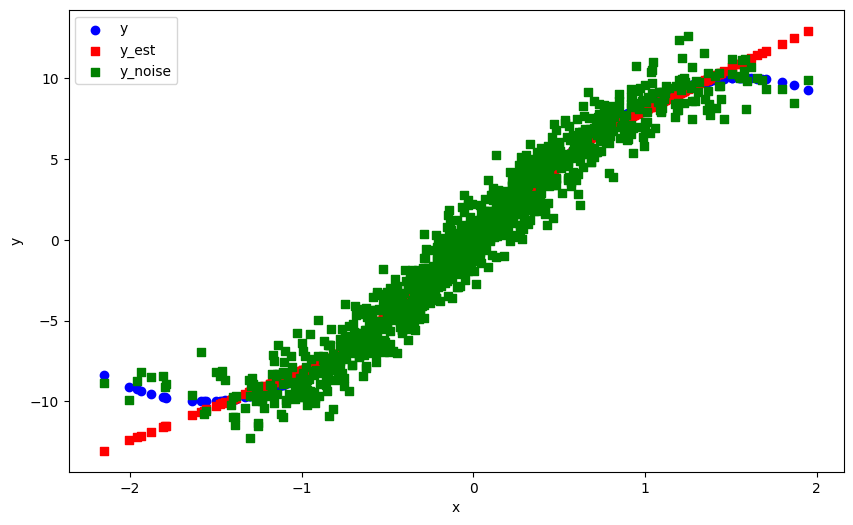

The programm is closed


In [8]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

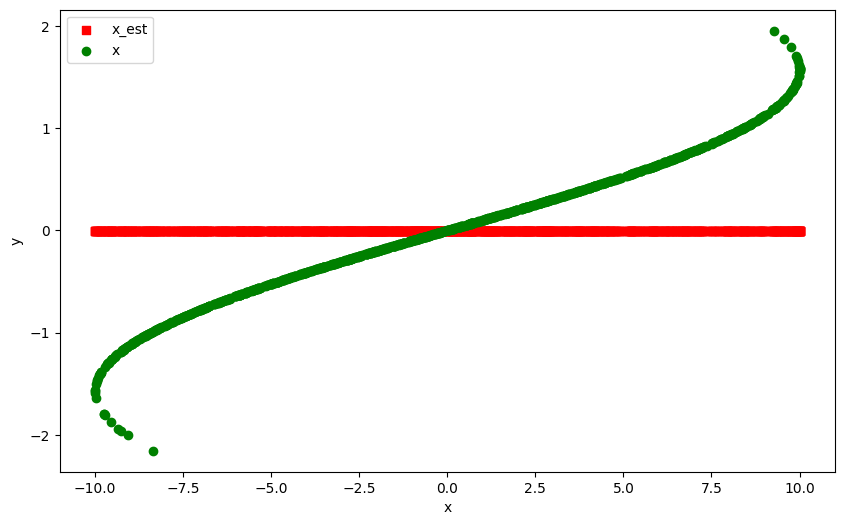

The programm is closed


In [9]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

### DAGMA init

In [10]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[0.5, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = 10*torch.sin(x1)
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = 10*torch.sin(x1)+ epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [11]:
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma = model.fit(X, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight = eq_model.fc1.weight
fc1_bias = eq_model.fc1.bias
fc2_weight = eq_model.fc2[0].weight
fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  1%|          | 162/29000 [00:00<01:11, 406.06it/s]

Sigma:  tensor([[ 0.9605, -0.0168],
        [-0.0168,  1.0405]], grad_fn=<MmBackward0>)
obj:  tensor(49.5261, grad_fn=<AddBackward0>)
mle loss:  tensor(48.7511, grad_fn=<AddBackward0>)
h_val:  tensor(0.1149, grad_fn=<AddBackward0>)


  1%|          | 242/29000 [00:00<01:14, 384.65it/s]

Sigma:  tensor([[ 0.9217, -0.0154],
        [-0.0154,  1.0785]], grad_fn=<MmBackward0>)
obj:  tensor(29.4079, grad_fn=<AddBackward0>)
mle loss:  tensor(28.5314, grad_fn=<AddBackward0>)
h_val:  tensor(0.2290, grad_fn=<AddBackward0>)


  1%|▏         | 372/29000 [00:00<01:10, 407.02it/s]

Sigma:  tensor([[ 0.8854, -0.0069],
        [-0.0069,  1.1105]], grad_fn=<MmBackward0>)
obj:  tensor(17.0623, grad_fn=<AddBackward0>)
mle loss:  tensor(16.0598, grad_fn=<AddBackward0>)
h_val:  tensor(0.3720, grad_fn=<AddBackward0>)


  2%|▏         | 453/29000 [00:01<01:13, 389.88it/s]

Sigma:  tensor([[ 0.8528, -0.0047],
        [-0.0047,  1.1348]], grad_fn=<MmBackward0>)
obj:  tensor(10.7036, grad_fn=<AddBackward0>)
mle loss:  tensor(9.4144, grad_fn=<AddBackward0>)
h_val:  tensor(0.6796, grad_fn=<AddBackward0>)


  2%|▏         | 578/29000 [00:01<01:11, 397.30it/s]

Sigma:  tensor([[ 0.8221, -0.0049],
        [-0.0049,  1.1521]], grad_fn=<MmBackward0>)
obj:  tensor(8.1452, grad_fn=<AddBackward0>)
mle loss:  tensor(6.4498, grad_fn=<AddBackward0>)
h_val:  tensor(1.0968, grad_fn=<AddBackward0>)


  2%|▏         | 657/29000 [00:01<01:15, 376.72it/s]

Sigma:  tensor([[ 0.7921, -0.0029],
        [-0.0029,  1.1643]], grad_fn=<MmBackward0>)
obj:  tensor(7.4574, grad_fn=<AddBackward0>)
mle loss:  tensor(5.3755, grad_fn=<AddBackward0>)
h_val:  tensor(1.4934, grad_fn=<AddBackward0>)


  3%|▎         | 775/29000 [00:02<01:13, 382.32it/s]

Sigma:  tensor([[ 0.7624, -0.0013],
        [-0.0013,  1.1739]], grad_fn=<MmBackward0>)
obj:  tensor(7.2855, grad_fn=<AddBackward0>)
mle loss:  tensor(5.0183, grad_fn=<AddBackward0>)
h_val:  tensor(1.6845, grad_fn=<AddBackward0>)


  3%|▎         | 852/29000 [00:02<01:16, 369.63it/s]

Sigma:  tensor([[ 0.7327, -0.0017],
        [-0.0017,  1.1824]], grad_fn=<MmBackward0>)
obj:  tensor(7.0809, grad_fn=<AddBackward0>)
mle loss:  tensor(4.8717, grad_fn=<AddBackward0>)
h_val:  tensor(1.6274, grad_fn=<AddBackward0>)


  3%|▎         | 974/29000 [00:02<01:11, 390.17it/s]

Sigma:  tensor([[ 0.7031, -0.0022],
        [-0.0022,  1.1909]], grad_fn=<MmBackward0>)
obj:  tensor(6.8799, grad_fn=<AddBackward0>)
mle loss:  tensor(4.8009, grad_fn=<AddBackward0>)
h_val:  tensor(1.4960, grad_fn=<AddBackward0>)


  4%|▎         | 1055/29000 [00:02<01:12, 384.14it/s]

Sigma:  tensor([[ 0.6743, -0.0022],
        [-0.0022,  1.1997]], grad_fn=<MmBackward0>)
obj:  tensor(6.7016, grad_fn=<AddBackward0>)
mle loss:  tensor(4.7348, grad_fn=<AddBackward0>)
h_val:  tensor(1.3847, grad_fn=<AddBackward0>)


  4%|▍         | 1168/29000 [00:03<01:46, 262.26it/s]

Sigma:  tensor([[ 0.6468, -0.0023],
        [-0.0023,  1.2091]], grad_fn=<MmBackward0>)
obj:  tensor(6.5315, grad_fn=<AddBackward0>)
mle loss:  tensor(4.6241, grad_fn=<AddBackward0>)
h_val:  tensor(1.3269, grad_fn=<AddBackward0>)


  4%|▍         | 1244/29000 [00:03<01:28, 312.85it/s]

Sigma:  tensor([[ 0.6205, -0.0024],
        [-0.0024,  1.2189]], grad_fn=<MmBackward0>)
obj:  tensor(6.3559, grad_fn=<AddBackward0>)
mle loss:  tensor(4.4718, grad_fn=<AddBackward0>)
h_val:  tensor(1.3056, grad_fn=<AddBackward0>)


  5%|▍         | 1372/29000 [00:03<01:15, 367.89it/s]

Sigma:  tensor([[ 0.5955, -0.0023],
        [-0.0023,  1.2293]], grad_fn=<MmBackward0>)
obj:  tensor(6.1723, grad_fn=<AddBackward0>)
mle loss:  tensor(4.3057, grad_fn=<AddBackward0>)
h_val:  tensor(1.2913, grad_fn=<AddBackward0>)


  5%|▌         | 1452/29000 [00:04<01:13, 372.67it/s]

Sigma:  tensor([[ 0.5716, -0.0023],
        [-0.0023,  1.2401]], grad_fn=<MmBackward0>)
obj:  tensor(5.9914, grad_fn=<AddBackward0>)
mle loss:  tensor(4.1448, grad_fn=<AddBackward0>)
h_val:  tensor(1.2740, grad_fn=<AddBackward0>)


  5%|▌         | 1572/29000 [00:04<01:12, 379.24it/s]

Sigma:  tensor([[ 0.5487, -0.0023],
        [-0.0023,  1.2512]], grad_fn=<MmBackward0>)
obj:  tensor(5.8177, grad_fn=<AddBackward0>)
mle loss:  tensor(3.9925, grad_fn=<AddBackward0>)
h_val:  tensor(1.2545, grad_fn=<AddBackward0>)


  6%|▌         | 1652/29000 [00:04<01:11, 381.26it/s]

Sigma:  tensor([[ 0.5268, -0.0023],
        [-0.0023,  1.2627]], grad_fn=<MmBackward0>)
obj:  tensor(5.6410, grad_fn=<AddBackward0>)
mle loss:  tensor(3.8454, grad_fn=<AddBackward0>)
h_val:  tensor(1.2274, grad_fn=<AddBackward0>)


  6%|▌         | 1779/29000 [00:04<01:07, 400.51it/s]

Sigma:  tensor([[ 0.5059, -0.0024],
        [-0.0024,  1.2745]], grad_fn=<MmBackward0>)
obj:  tensor(5.4669, grad_fn=<AddBackward0>)
mle loss:  tensor(3.6982, grad_fn=<AddBackward0>)
h_val:  tensor(1.2026, grad_fn=<AddBackward0>)


  6%|▋         | 1862/29000 [00:05<01:08, 397.37it/s]

Sigma:  tensor([[ 0.4858, -0.0024],
        [-0.0024,  1.2866]], grad_fn=<MmBackward0>)
obj:  tensor(5.2959, grad_fn=<AddBackward0>)
mle loss:  tensor(3.5503, grad_fn=<AddBackward0>)
h_val:  tensor(1.1810, grad_fn=<AddBackward0>)


  7%|▋         | 1941/29000 [00:05<01:10, 385.44it/s]

Sigma:  tensor([[ 0.4666, -0.0024],
        [-0.0024,  1.2990]], grad_fn=<MmBackward0>)
obj:  tensor(5.1231, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4012, grad_fn=<AddBackward0>)
h_val:  tensor(1.1596, grad_fn=<AddBackward0>)


  7%|▋         | 2070/29000 [00:05<01:05, 409.33it/s]

Sigma:  tensor([[ 0.4482, -0.0024],
        [-0.0024,  1.3117]], grad_fn=<MmBackward0>)
obj:  tensor(4.9472, grad_fn=<AddBackward0>)
mle loss:  tensor(3.2519, grad_fn=<AddBackward0>)
h_val:  tensor(1.1363, grad_fn=<AddBackward0>)


  7%|▋         | 2153/29000 [00:05<01:08, 392.34it/s]

Sigma:  tensor([[ 0.4305, -0.0025],
        [-0.0025,  1.3246]], grad_fn=<MmBackward0>)
obj:  tensor(4.7821, grad_fn=<AddBackward0>)
mle loss:  tensor(3.1041, grad_fn=<AddBackward0>)
h_val:  tensor(1.1200, grad_fn=<AddBackward0>)


  8%|▊         | 2277/29000 [00:06<01:08, 390.47it/s]

Sigma:  tensor([[ 0.4136, -0.0025],
        [-0.0025,  1.3377]], grad_fn=<MmBackward0>)
obj:  tensor(4.6126, grad_fn=<AddBackward0>)
mle loss:  tensor(2.9587, grad_fn=<AddBackward0>)
h_val:  tensor(1.0986, grad_fn=<AddBackward0>)


  8%|▊         | 2355/29000 [00:06<01:12, 367.11it/s]

Sigma:  tensor([[ 0.3973, -0.0025],
        [-0.0025,  1.3509]], grad_fn=<MmBackward0>)
obj:  tensor(4.4409, grad_fn=<AddBackward0>)
mle loss:  tensor(2.8133, grad_fn=<AddBackward0>)
h_val:  tensor(1.0763, grad_fn=<AddBackward0>)


  9%|▊         | 2479/29000 [00:06<01:06, 396.99it/s]

Sigma:  tensor([[ 0.3817, -0.0025],
        [-0.0025,  1.3642]], grad_fn=<MmBackward0>)
obj:  tensor(4.2733, grad_fn=<AddBackward0>)
mle loss:  tensor(2.6677, grad_fn=<AddBackward0>)
h_val:  tensor(1.0576, grad_fn=<AddBackward0>)


  9%|▉         | 2559/29000 [00:06<01:08, 383.97it/s]

Sigma:  tensor([[ 0.3667, -0.0026],
        [-0.0026,  1.3777]], grad_fn=<MmBackward0>)
obj:  tensor(4.1146, grad_fn=<AddBackward0>)
mle loss:  tensor(2.5244, grad_fn=<AddBackward0>)
h_val:  tensor(1.0441, grad_fn=<AddBackward0>)


  9%|▉         | 2637/29000 [00:07<01:10, 376.19it/s]

Sigma:  tensor([[ 0.3523, -0.0026],
        [-0.0026,  1.3912]], grad_fn=<MmBackward0>)
obj:  tensor(3.9641, grad_fn=<AddBackward0>)
mle loss:  tensor(2.3840, grad_fn=<AddBackward0>)
h_val:  tensor(1.0345, grad_fn=<AddBackward0>)


 10%|▉         | 2763/29000 [00:07<01:07, 389.16it/s]

Sigma:  tensor([[ 0.3385, -0.0026],
        [-0.0026,  1.4046]], grad_fn=<MmBackward0>)
obj:  tensor(3.8178, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2464, grad_fn=<AddBackward0>)
h_val:  tensor(1.0255, grad_fn=<AddBackward0>)


 10%|▉         | 2844/29000 [00:07<01:06, 393.18it/s]

Sigma:  tensor([[ 0.3251, -0.0026],
        [-0.0026,  1.4181]], grad_fn=<MmBackward0>)
obj:  tensor(3.6683, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1128, grad_fn=<AddBackward0>)
h_val:  tensor(1.0103, grad_fn=<AddBackward0>)


 10%|█         | 2973/29000 [00:08<01:05, 399.13it/s]

Sigma:  tensor([[ 0.3123, -0.0027],
        [-0.0027,  1.4315]], grad_fn=<MmBackward0>)
obj:  tensor(3.5097, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9782, grad_fn=<AddBackward0>)
h_val:  tensor(0.9895, grad_fn=<AddBackward0>)


 11%|█         | 3054/29000 [00:08<01:07, 386.26it/s]

Sigma:  tensor([[ 0.3000, -0.0027],
        [-0.0027,  1.4448]], grad_fn=<MmBackward0>)
obj:  tensor(3.3618, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8466, grad_fn=<AddBackward0>)
h_val:  tensor(0.9749, grad_fn=<AddBackward0>)


 11%|█         | 3174/29000 [00:08<01:06, 389.95it/s]

Sigma:  tensor([[ 0.2882, -0.0027],
        [-0.0027,  1.4579]], grad_fn=<MmBackward0>)
obj:  tensor(3.2082, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7154, grad_fn=<AddBackward0>)
h_val:  tensor(0.9573, grad_fn=<AddBackward0>)


 11%|█         | 3255/29000 [00:08<01:05, 394.65it/s]

Sigma:  tensor([[ 0.2768, -0.0027],
        [-0.0027,  1.4708]], grad_fn=<MmBackward0>)
obj:  tensor(3.0619, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5859, grad_fn=<AddBackward0>)
h_val:  tensor(0.9438, grad_fn=<AddBackward0>)


 12%|█▏        | 3381/29000 [00:09<01:02, 407.22it/s]

Sigma:  tensor([[ 0.2659, -0.0028],
        [-0.0028,  1.4834]], grad_fn=<MmBackward0>)
obj:  tensor(2.9168, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4613, grad_fn=<AddBackward0>)
h_val:  tensor(0.9273, grad_fn=<AddBackward0>)


 12%|█▏        | 3463/29000 [00:09<01:04, 397.57it/s]

Sigma:  tensor([[ 0.2553, -0.0028],
        [-0.0028,  1.4957]], grad_fn=<MmBackward0>)
obj:  tensor(2.7802, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3393, grad_fn=<AddBackward0>)
h_val:  tensor(0.9143, grad_fn=<AddBackward0>)


 12%|█▏        | 3542/29000 [00:09<01:07, 374.74it/s]

Sigma:  tensor([[ 0.2452, -0.0028],
        [-0.0028,  1.5076]], grad_fn=<MmBackward0>)
obj:  tensor(2.6433, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2204, grad_fn=<AddBackward0>)
h_val:  tensor(0.8993, grad_fn=<AddBackward0>)


 13%|█▎        | 3670/29000 [00:09<01:03, 401.71it/s]

Sigma:  tensor([[ 0.2355, -0.0028],
        [-0.0028,  1.5192]], grad_fn=<MmBackward0>)
obj:  tensor(2.5063, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1028, grad_fn=<AddBackward0>)
h_val:  tensor(0.8838, grad_fn=<AddBackward0>)


 13%|█▎        | 3752/29000 [00:09<01:03, 398.95it/s]

Sigma:  tensor([[ 0.2261, -0.0029],
        [-0.0029,  1.5303]], grad_fn=<MmBackward0>)
obj:  tensor(2.3723, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9885, grad_fn=<AddBackward0>)
h_val:  tensor(0.8676, grad_fn=<AddBackward0>)


 13%|█▎        | 3880/29000 [00:10<01:01, 408.21it/s]

Sigma:  tensor([[ 0.2170, -0.0029],
        [-0.0029,  1.5409]], grad_fn=<MmBackward0>)
obj:  tensor(2.2415, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8772, grad_fn=<AddBackward0>)
h_val:  tensor(0.8518, grad_fn=<AddBackward0>)


 14%|█▎        | 3962/29000 [00:10<01:02, 400.47it/s]

Sigma:  tensor([[ 0.2084, -0.0029],
        [-0.0029,  1.5509]], grad_fn=<MmBackward0>)
obj:  tensor(2.1175, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7660, grad_fn=<AddBackward0>)
h_val:  tensor(0.8430, grad_fn=<AddBackward0>)


 14%|█▍        | 4044/29000 [00:10<01:02, 400.25it/s]

Sigma:  tensor([[ 0.2000, -0.0029],
        [-0.0029,  1.5603]], grad_fn=<MmBackward0>)
obj:  tensor(1.9970, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6596, grad_fn=<AddBackward0>)
h_val:  tensor(0.8326, grad_fn=<AddBackward0>)


 14%|█▍        | 4172/29000 [00:11<01:00, 413.19it/s]

Sigma:  tensor([[ 0.1920, -0.0029],
        [-0.0029,  1.5691]], grad_fn=<MmBackward0>)
obj:  tensor(1.8786, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5568, grad_fn=<AddBackward0>)
h_val:  tensor(0.8208, grad_fn=<AddBackward0>)


 15%|█▍        | 4256/29000 [00:11<01:00, 408.98it/s]

Sigma:  tensor([[ 0.1842, -0.0029],
        [-0.0029,  1.5772]], grad_fn=<MmBackward0>)
obj:  tensor(1.7557, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4516, grad_fn=<AddBackward0>)
h_val:  tensor(0.8087, grad_fn=<AddBackward0>)


 15%|█▌        | 4383/29000 [00:11<01:00, 409.46it/s]

Sigma:  tensor([[ 0.1768, -0.0030],
        [-0.0030,  1.5844]], grad_fn=<MmBackward0>)
obj:  tensor(1.6383, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3507, grad_fn=<AddBackward0>)
h_val:  tensor(0.7970, grad_fn=<AddBackward0>)


 15%|█▌        | 4466/29000 [00:11<01:01, 401.76it/s]

Sigma:  tensor([[ 0.1696, -0.0030],
        [-0.0030,  1.5909]], grad_fn=<MmBackward0>)
obj:  tensor(1.5241, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2535, grad_fn=<AddBackward0>)
h_val:  tensor(0.7842, grad_fn=<AddBackward0>)


 16%|█▌        | 4547/29000 [00:11<01:02, 388.47it/s]

Sigma:  tensor([[ 0.1627, -0.0030],
        [-0.0030,  1.5964]], grad_fn=<MmBackward0>)
obj:  tensor(1.4092, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1574, grad_fn=<AddBackward0>)
h_val:  tensor(0.7704, grad_fn=<AddBackward0>)


 16%|█▌        | 4666/29000 [00:12<01:03, 384.39it/s]

Sigma:  tensor([[ 0.1561, -0.0031],
        [-0.0031,  1.6010]], grad_fn=<MmBackward0>)
obj:  tensor(1.2888, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0562, grad_fn=<AddBackward0>)
h_val:  tensor(0.7582, grad_fn=<AddBackward0>)


 16%|█▋        | 4744/29000 [00:12<01:05, 368.98it/s]

Sigma:  tensor([[ 0.1498, -0.0031],
        [-0.0031,  1.6046]], grad_fn=<MmBackward0>)
obj:  tensor(1.1754, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0385, grad_fn=<AddBackward0>)
h_val:  tensor(0.7452, grad_fn=<AddBackward0>)


 17%|█▋        | 4870/29000 [00:12<01:00, 401.19it/s]

Sigma:  tensor([[ 0.1436, -0.0031],
        [-0.0031,  1.6070]], grad_fn=<MmBackward0>)
obj:  tensor(1.0620, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1345, grad_fn=<AddBackward0>)
h_val:  tensor(0.7339, grad_fn=<AddBackward0>)


 17%|█▋        | 4953/29000 [00:13<00:59, 406.73it/s]

Sigma:  tensor([[ 0.1377, -0.0032],
        [-0.0032,  1.6083]], grad_fn=<MmBackward0>)
obj:  tensor(0.9491, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2290, grad_fn=<AddBackward0>)
h_val:  tensor(0.7223, grad_fn=<AddBackward0>)


 18%|█▊        | 5079/29000 [00:13<00:59, 402.44it/s]

Sigma:  tensor([[ 0.1320, -0.0033],
        [-0.0033,  1.6083]], grad_fn=<MmBackward0>)
obj:  tensor(0.8358, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3236, grad_fn=<AddBackward0>)
h_val:  tensor(0.7107, grad_fn=<AddBackward0>)


 18%|█▊        | 5161/29000 [00:13<01:00, 391.39it/s]

Sigma:  tensor([[ 0.1266, -0.0034],
        [-0.0034,  1.6069]], grad_fn=<MmBackward0>)
obj:  tensor(0.7248, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4151, grad_fn=<AddBackward0>)
h_val:  tensor(0.6979, grad_fn=<AddBackward0>)


 18%|█▊        | 5242/29000 [00:13<01:01, 386.57it/s]

Sigma:  tensor([[ 0.1213, -0.0034],
        [-0.0034,  1.6042]], grad_fn=<MmBackward0>)
obj:  tensor(0.6154, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5077, grad_fn=<AddBackward0>)
h_val:  tensor(0.6879, grad_fn=<AddBackward0>)


 19%|█▊        | 5376/29000 [00:14<00:55, 422.06it/s]

Sigma:  tensor([[ 0.1163, -0.0035],
        [-0.0035,  1.6000]], grad_fn=<MmBackward0>)
obj:  tensor(0.5048, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5996, grad_fn=<AddBackward0>)
h_val:  tensor(0.6767, grad_fn=<AddBackward0>)


 19%|█▉        | 5461/29000 [00:14<00:58, 405.30it/s]

Sigma:  tensor([[ 0.1114, -0.0036],
        [-0.0036,  1.5943]], grad_fn=<MmBackward0>)
obj:  tensor(0.3983, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6881, grad_fn=<AddBackward0>)
h_val:  tensor(0.6652, grad_fn=<AddBackward0>)


 19%|█▉        | 5542/29000 [00:14<01:01, 382.80it/s]

Sigma:  tensor([[ 0.1068, -0.0037],
        [-0.0037,  1.5870]], grad_fn=<MmBackward0>)
obj:  tensor(0.2911, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7793, grad_fn=<AddBackward0>)
h_val:  tensor(0.6558, grad_fn=<AddBackward0>)


 20%|█▉        | 5674/29000 [00:14<00:56, 411.91it/s]

Sigma:  tensor([[ 0.1023, -0.0038],
        [-0.0038,  1.5780]], grad_fn=<MmBackward0>)
obj:  tensor(0.1867, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8711, grad_fn=<AddBackward0>)
h_val:  tensor(0.6497, grad_fn=<AddBackward0>)


 20%|█▉        | 5757/29000 [00:15<00:57, 404.41it/s]

Sigma:  tensor([[ 0.0980, -0.0039],
        [-0.0039,  1.5673]], grad_fn=<MmBackward0>)
obj:  tensor(0.0807, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9615, grad_fn=<AddBackward0>)
h_val:  tensor(0.6410, grad_fn=<AddBackward0>)


 20%|██        | 5885/29000 [00:15<00:56, 412.75it/s]

Sigma:  tensor([[ 0.0939, -0.0040],
        [-0.0040,  1.5548]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0258, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0512, grad_fn=<AddBackward0>)
h_val:  tensor(0.6315, grad_fn=<AddBackward0>)


 21%|██        | 5969/29000 [00:15<00:56, 408.96it/s]

Sigma:  tensor([[ 0.0899, -0.0041],
        [-0.0041,  1.5405]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1323, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1421, grad_fn=<AddBackward0>)
h_val:  tensor(0.6234, grad_fn=<AddBackward0>)


 21%|██        | 6051/29000 [00:15<00:57, 401.40it/s]

Sigma:  tensor([[ 0.0861, -0.0043],
        [-0.0043,  1.5243]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2385, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2341, grad_fn=<AddBackward0>)
h_val:  tensor(0.6168, grad_fn=<AddBackward0>)


 21%|██▏       | 6183/29000 [00:16<00:55, 414.66it/s]

Sigma:  tensor([[ 0.0825, -0.0045],
        [-0.0045,  1.5062]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3442, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3263, grad_fn=<AddBackward0>)
h_val:  tensor(0.6106, grad_fn=<AddBackward0>)


 22%|██▏       | 6267/29000 [00:16<00:55, 409.70it/s]

Sigma:  tensor([[ 0.0790, -0.0046],
        [-0.0046,  1.4863]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4480, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4191, grad_fn=<AddBackward0>)
h_val:  tensor(0.6066, grad_fn=<AddBackward0>)


 22%|██▏       | 6349/29000 [00:16<00:57, 391.04it/s]

Sigma:  tensor([[ 0.0757, -0.0048],
        [-0.0048,  1.4644]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5500, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5114, grad_fn=<AddBackward0>)
h_val:  tensor(0.6032, grad_fn=<AddBackward0>)


 22%|██▏       | 6475/29000 [00:16<00:57, 392.84it/s]

Sigma:  tensor([[ 0.0724, -0.0050],
        [-0.0050,  1.4407]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6540, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6037, grad_fn=<AddBackward0>)
h_val:  tensor(0.5984, grad_fn=<AddBackward0>)


 23%|██▎       | 6555/29000 [00:17<00:57, 387.26it/s]

Sigma:  tensor([[ 0.0694, -0.0052],
        [-0.0052,  1.4152]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7553, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6948, grad_fn=<AddBackward0>)
h_val:  tensor(0.5941, grad_fn=<AddBackward0>)


 23%|██▎       | 6680/29000 [00:17<00:55, 404.06it/s]

Sigma:  tensor([[ 0.0664, -0.0054],
        [-0.0054,  1.3879]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8614, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7875, grad_fn=<AddBackward0>)
h_val:  tensor(0.5876, grad_fn=<AddBackward0>)


 23%|██▎       | 6759/29000 [00:17<01:00, 369.13it/s]

Sigma:  tensor([[ 0.0636, -0.0057],
        [-0.0057,  1.3589]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9653, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8808, grad_fn=<AddBackward0>)
h_val:  tensor(0.5836, grad_fn=<AddBackward0>)


 24%|██▎       | 6874/29000 [00:17<01:01, 358.33it/s]

Sigma:  tensor([[ 0.0609, -0.0060],
        [-0.0060,  1.3284]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0666, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9732, grad_fn=<AddBackward0>)
h_val:  tensor(0.5802, grad_fn=<AddBackward0>)


 24%|██▍       | 6952/29000 [00:18<01:00, 364.36it/s]

Sigma:  tensor([[ 0.0584, -0.0062],
        [-0.0062,  1.2964]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1680, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0658, grad_fn=<AddBackward0>)
h_val:  tensor(0.5769, grad_fn=<AddBackward0>)


 25%|██▍       | 7156/29000 [00:18<00:54, 404.08it/s]

Sigma:  tensor([[ 0.0552, -0.0024],
        [-0.0024,  1.2293]], grad_fn=<MmBackward0>)
obj:  tensor(0.2154, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3147, grad_fn=<AddBackward0>)
h_val:  tensor(0.2167, grad_fn=<AddBackward0>)


 25%|██▍       | 7239/29000 [00:18<00:54, 399.54it/s]

Sigma:  tensor([[5.6322e-02, 3.5189e-04],
        [3.5189e-04, 1.1899e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1521, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2739, grad_fn=<AddBackward0>)
h_val:  tensor(0.2500, grad_fn=<AddBackward0>)


 25%|██▌       | 7370/29000 [00:19<00:53, 401.46it/s]

Sigma:  tensor([[5.7209e-02, 3.7800e-04],
        [3.7800e-04, 1.1488e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1344, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9997, grad_fn=<AddBackward0>)
h_val:  tensor(0.2053, grad_fn=<AddBackward0>)


 26%|██▌       | 7451/29000 [00:19<00:58, 366.53it/s]

Sigma:  tensor([[ 5.8561e-02, -6.3883e-04],
        [-6.3883e-04,  1.1071e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1258, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7444, grad_fn=<AddBackward0>)
h_val:  tensor(0.1715, grad_fn=<AddBackward0>)


 26%|██▌       | 7569/29000 [00:19<00:56, 382.67it/s]

Sigma:  tensor([[ 6.0486e-02, -7.4103e-04],
        [-7.4103e-04,  1.0656e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1192, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0011, grad_fn=<AddBackward0>)
h_val:  tensor(0.1908, grad_fn=<AddBackward0>)


 26%|██▋       | 7647/29000 [00:19<00:59, 360.78it/s]

Sigma:  tensor([[ 6.2506e-02, -1.5331e-04],
        [-1.5331e-04,  1.0246e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1118, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8350, grad_fn=<AddBackward0>)
h_val:  tensor(0.1670, grad_fn=<AddBackward0>)


 27%|██▋       | 7766/29000 [00:20<00:56, 374.74it/s]

Sigma:  tensor([[6.4818e-02, 8.0336e-06],
        [8.0336e-06, 9.8446e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.1056, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9870, grad_fn=<AddBackward0>)
h_val:  tensor(0.1761, grad_fn=<AddBackward0>)


 27%|██▋       | 7843/29000 [00:20<00:58, 364.22it/s]

Sigma:  tensor([[ 6.7153e-02, -8.2459e-05],
        [-8.2459e-05,  9.4552e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0997, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9561, grad_fn=<AddBackward0>)
h_val:  tensor(0.1671, grad_fn=<AddBackward0>)


 27%|██▋       | 7959/29000 [00:20<00:56, 374.35it/s]

Sigma:  tensor([[6.9602e-02, 8.7852e-05],
        [8.7852e-05, 9.0793e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0954, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9977, grad_fn=<AddBackward0>)
h_val:  tensor(0.1669, grad_fn=<AddBackward0>)


 28%|██▊       | 8038/29000 [00:21<00:56, 373.73it/s]

Sigma:  tensor([[7.2143e-02, 1.5533e-04],
        [1.5533e-04, 8.7176e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0904, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9718, grad_fn=<AddBackward0>)
h_val:  tensor(0.1593, grad_fn=<AddBackward0>)


 28%|██▊       | 8122/29000 [00:21<00:54, 380.41it/s]

Sigma:  tensor([[7.4835e-02, 1.4775e-04],
        [1.4775e-04, 8.3708e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0840, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9972, grad_fn=<AddBackward0>)
h_val:  tensor(0.1556, grad_fn=<AddBackward0>)


 28%|██▊       | 8245/29000 [00:21<00:58, 353.13it/s]

Sigma:  tensor([[7.7620e-02, 2.4137e-04],
        [2.4137e-04, 8.0388e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0780, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0080, grad_fn=<AddBackward0>)
h_val:  tensor(0.1507, grad_fn=<AddBackward0>)


 29%|██▉       | 8373/29000 [00:21<00:53, 386.66it/s]

Sigma:  tensor([[8.0497e-02, 2.9290e-04],
        [2.9290e-04, 7.7203e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0712, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0452, grad_fn=<AddBackward0>)
h_val:  tensor(0.1477, grad_fn=<AddBackward0>)


 29%|██▉       | 8452/29000 [00:22<00:55, 371.26it/s]

Sigma:  tensor([[8.3451e-02, 3.2166e-04],
        [3.2166e-04, 7.4123e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0643, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0628, grad_fn=<AddBackward0>)
h_val:  tensor(0.1426, grad_fn=<AddBackward0>)


 30%|██▉       | 8571/29000 [00:22<00:53, 382.17it/s]

Sigma:  tensor([[8.6491e-02, 4.0128e-04],
        [4.0128e-04, 7.1150e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0575, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0890, grad_fn=<AddBackward0>)
h_val:  tensor(0.1384, grad_fn=<AddBackward0>)


 30%|██▉       | 8651/29000 [00:22<00:52, 385.88it/s]

Sigma:  tensor([[8.9625e-02, 3.1672e-04],
        [3.1672e-04, 6.8290e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0499, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1028, grad_fn=<AddBackward0>)
h_val:  tensor(0.1321, grad_fn=<AddBackward0>)


 30%|███       | 8733/29000 [00:23<01:26, 234.80it/s]

Sigma:  tensor([[9.2883e-02, 2.7001e-04],
        [2.7001e-04, 6.5517e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0393, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1664, grad_fn=<AddBackward0>)
h_val:  tensor(0.1277, grad_fn=<AddBackward0>)


 31%|███       | 8848/29000 [00:23<01:06, 301.39it/s]

Sigma:  tensor([[9.6245e-02, 1.2478e-04],
        [1.2478e-04, 6.2783e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0306, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2212, grad_fn=<AddBackward0>)
h_val:  tensor(0.1245, grad_fn=<AddBackward0>)


 31%|███       | 8966/29000 [00:23<00:59, 339.06it/s]

Sigma:  tensor([[9.9672e-02, 3.0878e-04],
        [3.0878e-04, 6.0111e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0224, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2677, grad_fn=<AddBackward0>)
h_val:  tensor(0.1212, grad_fn=<AddBackward0>)


 31%|███       | 9039/29000 [00:23<00:57, 347.71it/s]

Sigma:  tensor([[1.0314e-01, 3.4960e-04],
        [3.4960e-04, 5.7534e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0152, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2843, grad_fn=<AddBackward0>)
h_val:  tensor(0.1156, grad_fn=<AddBackward0>)


 32%|███▏      | 9153/29000 [00:24<00:55, 356.52it/s]

Sigma:  tensor([[1.0670e-01, 3.1206e-04],
        [3.1206e-04, 5.5076e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0076, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3149, grad_fn=<AddBackward0>)
h_val:  tensor(0.1111, grad_fn=<AddBackward0>)


 32%|███▏      | 9268/29000 [00:24<00:53, 369.54it/s]

Sigma:  tensor([[1.1035e-01, 3.1887e-04],
        [3.1887e-04, 5.2736e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0008, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3310, grad_fn=<AddBackward0>)
h_val:  tensor(0.1058, grad_fn=<AddBackward0>)


 32%|███▏      | 9346/29000 [00:24<00:52, 376.71it/s]

Sigma:  tensor([[1.1410e-01, 3.2175e-04],
        [3.2175e-04, 5.0507e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0066, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3665, grad_fn=<AddBackward0>)
h_val:  tensor(0.1021, grad_fn=<AddBackward0>)


 33%|███▎      | 9462/29000 [00:25<00:52, 375.09it/s]

Sigma:  tensor([[1.1792e-01, 3.0701e-04],
        [3.0701e-04, 4.8383e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0136, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3950, grad_fn=<AddBackward0>)
h_val:  tensor(0.0980, grad_fn=<AddBackward0>)


 33%|███▎      | 9535/29000 [00:25<00:57, 338.22it/s]

Sigma:  tensor([[1.2180e-01, 3.3444e-04],
        [3.3444e-04, 4.6354e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0207, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4272, grad_fn=<AddBackward0>)
h_val:  tensor(0.0942, grad_fn=<AddBackward0>)


 33%|███▎      | 9664/29000 [00:25<00:49, 392.67it/s]

Sigma:  tensor([[1.2575e-01, 3.4056e-04],
        [3.4056e-04, 4.4413e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0278, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4654, grad_fn=<AddBackward0>)
h_val:  tensor(0.0910, grad_fn=<AddBackward0>)


 34%|███▎      | 9744/29000 [00:25<00:49, 392.71it/s]

Sigma:  tensor([[1.2976e-01, 3.1027e-04],
        [3.1027e-04, 4.2550e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0350, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5076, grad_fn=<AddBackward0>)
h_val:  tensor(0.0882, grad_fn=<AddBackward0>)


 34%|███▍      | 9864/29000 [00:26<00:49, 390.50it/s]

Sigma:  tensor([[1.3381e-01, 2.8223e-04],
        [2.8223e-04, 4.0760e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0413, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5382, grad_fn=<AddBackward0>)
h_val:  tensor(0.0849, grad_fn=<AddBackward0>)


 34%|███▍      | 9944/29000 [00:26<00:49, 384.06it/s]

Sigma:  tensor([[1.3793e-01, 2.9148e-04],
        [2.9148e-04, 3.9044e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0477, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5823, grad_fn=<AddBackward0>)
h_val:  tensor(0.0832, grad_fn=<AddBackward0>)


 35%|███▍      | 10073/29000 [00:26<00:47, 396.36it/s]

Sigma:  tensor([[1.4201e-01, 3.2548e-04],
        [3.2548e-04, 3.7404e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0532, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6146, grad_fn=<AddBackward0>)
h_val:  tensor(0.0812, grad_fn=<AddBackward0>)


 35%|███▌      | 10153/29000 [00:26<00:49, 382.95it/s]

Sigma:  tensor([[0.1460, 0.0004],
        [0.0004, 0.3584]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0584, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6494, grad_fn=<AddBackward0>)
h_val:  tensor(0.0798, grad_fn=<AddBackward0>)


 35%|███▌      | 10275/29000 [00:27<00:47, 393.67it/s]

Sigma:  tensor([[0.1500, 0.0004],
        [0.0004, 0.3436]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0631, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6759, grad_fn=<AddBackward0>)
h_val:  tensor(0.0779, grad_fn=<AddBackward0>)


 36%|███▌      | 10354/29000 [00:27<00:48, 385.44it/s]

Sigma:  tensor([[0.1539, 0.0004],
        [0.0004, 0.3295]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0681, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7044, grad_fn=<AddBackward0>)
h_val:  tensor(0.0759, grad_fn=<AddBackward0>)


 36%|███▌      | 10469/29000 [00:27<00:50, 366.02it/s]

Sigma:  tensor([[0.1578, 0.0003],
        [0.0003, 0.3161]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0729, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7276, grad_fn=<AddBackward0>)
h_val:  tensor(0.0735, grad_fn=<AddBackward0>)


 36%|███▋      | 10540/29000 [00:28<00:57, 322.41it/s]

Sigma:  tensor([[0.1617, 0.0004],
        [0.0004, 0.3032]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0776, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7582, grad_fn=<AddBackward0>)
h_val:  tensor(0.0719, grad_fn=<AddBackward0>)


 37%|███▋      | 10648/29000 [00:28<00:52, 347.28it/s]

Sigma:  tensor([[0.1657, 0.0004],
        [0.0004, 0.2910]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0822, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7803, grad_fn=<AddBackward0>)
h_val:  tensor(0.0694, grad_fn=<AddBackward0>)


 37%|███▋      | 10770/29000 [00:28<00:48, 374.48it/s]

Sigma:  tensor([[0.1697, 0.0003],
        [0.0003, 0.2793]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0868, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8025, grad_fn=<AddBackward0>)
h_val:  tensor(0.0670, grad_fn=<AddBackward0>)


 37%|███▋      | 10848/29000 [00:28<00:47, 380.16it/s]

Sigma:  tensor([[0.1738, 0.0003],
        [0.0003, 0.2681]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0914, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8295, grad_fn=<AddBackward0>)
h_val:  tensor(0.0651, grad_fn=<AddBackward0>)


 38%|███▊      | 10970/29000 [00:29<00:46, 385.60it/s]

Sigma:  tensor([[1.7788e-01, 2.5155e-04],
        [2.5155e-04, 2.5742e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0958, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8558, grad_fn=<AddBackward0>)
h_val:  tensor(0.0633, grad_fn=<AddBackward0>)


 38%|███▊      | 11049/29000 [00:29<00:46, 385.76it/s]

Sigma:  tensor([[0.1820, 0.0003],
        [0.0003, 0.2472]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1002, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8831, grad_fn=<AddBackward0>)
h_val:  tensor(0.0616, grad_fn=<AddBackward0>)


 39%|███▊      | 11169/29000 [00:29<00:46, 384.10it/s]

Sigma:  tensor([[0.1862, 0.0002],
        [0.0002, 0.2373]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1046, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9108, grad_fn=<AddBackward0>)
h_val:  tensor(0.0600, grad_fn=<AddBackward0>)


 39%|███▉      | 11247/29000 [00:29<00:46, 380.13it/s]

Sigma:  tensor([[0.1904, 0.0002],
        [0.0002, 0.2279]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1089, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9378, grad_fn=<AddBackward0>)
h_val:  tensor(0.0583, grad_fn=<AddBackward0>)


 39%|███▉      | 11361/29000 [00:30<00:48, 360.30it/s]

Sigma:  tensor([[0.1946, 0.0002],
        [0.0002, 0.2188]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1132, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9645, grad_fn=<AddBackward0>)
h_val:  tensor(0.0566, grad_fn=<AddBackward0>)


 39%|███▉      | 11436/29000 [00:30<00:49, 354.91it/s]

Sigma:  tensor([[0.1989, 0.0002],
        [0.0002, 0.2101]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1175, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9919, grad_fn=<AddBackward0>)
h_val:  tensor(0.0550, grad_fn=<AddBackward0>)


 40%|███▉      | 11560/29000 [00:30<00:44, 389.49it/s]

Sigma:  tensor([[0.2031, 0.0002],
        [0.0002, 0.2018]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1218, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0198, grad_fn=<AddBackward0>)
h_val:  tensor(0.0534, grad_fn=<AddBackward0>)


 40%|████      | 11641/29000 [00:30<00:44, 387.31it/s]

Sigma:  tensor([[2.0736e-01, 2.0084e-04],
        [2.0084e-04, 1.9381e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1261, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0481, grad_fn=<AddBackward0>)
h_val:  tensor(0.0520, grad_fn=<AddBackward0>)


 41%|████      | 11770/29000 [00:31<00:42, 408.88it/s]

Sigma:  tensor([[2.1156e-01, 1.9552e-04],
        [1.9552e-04, 1.8614e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1304, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0772, grad_fn=<AddBackward0>)
h_val:  tensor(0.0506, grad_fn=<AddBackward0>)


 41%|████      | 11852/29000 [00:31<00:43, 397.64it/s]

Sigma:  tensor([[2.1569e-01, 1.9876e-04],
        [1.9876e-04, 1.7878e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1346, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1067, grad_fn=<AddBackward0>)
h_val:  tensor(0.0493, grad_fn=<AddBackward0>)


 41%|████▏     | 11977/29000 [00:31<00:42, 396.11it/s]

Sigma:  tensor([[2.1974e-01, 1.9230e-04],
        [1.9230e-04, 1.7171e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1388, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1371, grad_fn=<AddBackward0>)
h_val:  tensor(0.0481, grad_fn=<AddBackward0>)


 42%|████▏     | 12057/29000 [00:31<00:43, 390.32it/s]

Sigma:  tensor([[2.2369e-01, 1.7694e-04],
        [1.7694e-04, 1.6493e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1429, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0470, grad_fn=<AddBackward0>)


 42%|████▏     | 12182/29000 [00:32<00:41, 402.53it/s]

Sigma:  tensor([[2.2754e-01, 1.7206e-04],
        [1.7206e-04, 1.5842e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1470, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1973, grad_fn=<AddBackward0>)
h_val:  tensor(0.0459, grad_fn=<AddBackward0>)


 42%|████▏     | 12263/29000 [00:32<00:43, 383.88it/s]

Sigma:  tensor([[2.3127e-01, 1.6713e-04],
        [1.6713e-04, 1.5217e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1511, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2284, grad_fn=<AddBackward0>)
h_val:  tensor(0.0449, grad_fn=<AddBackward0>)


 43%|████▎     | 12338/29000 [00:32<00:47, 351.78it/s]

Sigma:  tensor([[2.3485e-01, 1.6426e-04],
        [1.6426e-04, 1.4617e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1552, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2602, grad_fn=<AddBackward0>)
h_val:  tensor(0.0439, grad_fn=<AddBackward0>)


 43%|████▎     | 12463/29000 [00:33<00:42, 386.26it/s]

Sigma:  tensor([[2.3827e-01, 1.6545e-04],
        [1.6545e-04, 1.4041e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1593, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2928, grad_fn=<AddBackward0>)
h_val:  tensor(0.0430, grad_fn=<AddBackward0>)


 43%|████▎     | 12540/29000 [00:33<00:44, 367.55it/s]

Sigma:  tensor([[2.4150e-01, 1.6097e-04],
        [1.6097e-04, 1.3488e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1634, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3256, grad_fn=<AddBackward0>)
h_val:  tensor(0.0422, grad_fn=<AddBackward0>)


 44%|████▎     | 12666/29000 [00:33<00:42, 388.03it/s]

Sigma:  tensor([[2.4455e-01, 1.6115e-04],
        [1.6115e-04, 1.2957e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1675, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3601, grad_fn=<AddBackward0>)
h_val:  tensor(0.0416, grad_fn=<AddBackward0>)


 44%|████▍     | 12745/29000 [00:33<00:41, 387.05it/s]

Sigma:  tensor([[2.4739e-01, 1.6428e-04],
        [1.6428e-04, 1.2447e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1716, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3935, grad_fn=<AddBackward0>)
h_val:  tensor(0.0408, grad_fn=<AddBackward0>)


 44%|████▍     | 12875/29000 [00:34<00:39, 406.49it/s]

Sigma:  tensor([[2.5002e-01, 1.5959e-04],
        [1.5959e-04, 1.1957e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1756, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4274, grad_fn=<AddBackward0>)
h_val:  tensor(0.0402, grad_fn=<AddBackward0>)


 45%|████▍     | 12956/29000 [00:34<00:41, 382.63it/s]

Sigma:  tensor([[2.5243e-01, 1.5060e-04],
        [1.5060e-04, 1.1487e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1797, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4627, grad_fn=<AddBackward0>)
h_val:  tensor(0.0396, grad_fn=<AddBackward0>)


 45%|████▌     | 13079/29000 [00:34<00:40, 391.56it/s]

Sigma:  tensor([[2.5462e-01, 1.6704e-04],
        [1.6704e-04, 1.1036e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1837, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4979, grad_fn=<AddBackward0>)
h_val:  tensor(0.0391, grad_fn=<AddBackward0>)


 45%|████▌     | 13159/29000 [00:34<00:40, 388.63it/s]

Sigma:  tensor([[2.5660e-01, 1.4286e-04],
        [1.4286e-04, 1.0602e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1878, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5350, grad_fn=<AddBackward0>)
h_val:  tensor(0.0387, grad_fn=<AddBackward0>)


 46%|████▌     | 13283/29000 [00:35<00:39, 400.62it/s]

Sigma:  tensor([[2.5835e-01, 1.6861e-04],
        [1.6861e-04, 1.0186e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1918, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5699, grad_fn=<AddBackward0>)
h_val:  tensor(0.0382, grad_fn=<AddBackward0>)


 46%|████▌     | 13364/29000 [00:35<00:40, 390.44it/s]

Sigma:  tensor([[2.5989e-01, 1.5585e-04],
        [1.5585e-04, 9.7857e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1958, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6078, grad_fn=<AddBackward0>)
h_val:  tensor(0.0380, grad_fn=<AddBackward0>)


 46%|████▋     | 13443/29000 [00:35<00:41, 375.88it/s]

Sigma:  tensor([[2.6125e-01, 1.5495e-04],
        [1.5495e-04, 9.4016e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1998, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6429, grad_fn=<AddBackward0>)
h_val:  tensor(0.0375, grad_fn=<AddBackward0>)


 47%|████▋     | 13567/29000 [00:35<00:39, 389.35it/s]

Sigma:  tensor([[2.6241e-01, 1.5153e-04],
        [1.5153e-04, 9.0327e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2038, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6820, grad_fn=<AddBackward0>)
h_val:  tensor(0.0374, grad_fn=<AddBackward0>)


 47%|████▋     | 13645/29000 [00:36<00:42, 361.89it/s]

Sigma:  tensor([[2.6338e-01, 1.6218e-04],
        [1.6218e-04, 8.6783e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2078, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7195, grad_fn=<AddBackward0>)
h_val:  tensor(0.0371, grad_fn=<AddBackward0>)


 47%|████▋     | 13766/29000 [00:36<00:39, 382.49it/s]

Sigma:  tensor([[2.6419e-01, 1.5281e-04],
        [1.5281e-04, 8.3380e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2118, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7575, grad_fn=<AddBackward0>)
h_val:  tensor(0.0369, grad_fn=<AddBackward0>)


 48%|████▊     | 13844/29000 [00:36<00:40, 370.83it/s]

Sigma:  tensor([[2.6486e-01, 1.5946e-04],
        [1.5946e-04, 8.0111e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2159, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7971, grad_fn=<AddBackward0>)
h_val:  tensor(0.0368, grad_fn=<AddBackward0>)


 48%|████▊     | 13966/29000 [00:37<00:39, 383.04it/s]

Sigma:  tensor([[2.6539e-01, 1.4868e-04],
        [1.4868e-04, 7.6970e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2199, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8346, grad_fn=<AddBackward0>)
h_val:  tensor(0.0366, grad_fn=<AddBackward0>)


 49%|████▉     | 14165/29000 [00:37<00:39, 375.20it/s]

Sigma:  tensor([[ 2.6838e-01, -2.2441e-04],
        [-2.2441e-04,  7.3304e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0081, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4127, grad_fn=<AddBackward0>)
h_val:  tensor(0.0133, grad_fn=<AddBackward0>)


 49%|████▉     | 14241/29000 [00:37<00:41, 359.05it/s]

Sigma:  tensor([[0.2794, 0.0003],
        [0.0003, 0.0728]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0136, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2589, grad_fn=<AddBackward0>)
h_val:  tensor(0.0062, grad_fn=<AddBackward0>)


 50%|████▉     | 14361/29000 [00:38<00:38, 379.25it/s]

Sigma:  tensor([[0.2915, 0.0005],
        [0.0005, 0.0723]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0169, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3671, grad_fn=<AddBackward0>)
h_val:  tensor(0.0040, grad_fn=<AddBackward0>)


 50%|████▉     | 14439/29000 [00:38<00:38, 377.78it/s]

Sigma:  tensor([[3.0344e-01, 2.1387e-04],
        [2.1387e-04, 7.1772e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0186, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2323, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 50%|█████     | 14563/29000 [00:38<00:36, 394.24it/s]

Sigma:  tensor([[3.1647e-01, 1.5519e-05],
        [1.5519e-05, 7.1126e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0191, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2546, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 50%|█████     | 14643/29000 [00:38<00:37, 382.16it/s]

Sigma:  tensor([[ 3.2957e-01, -1.1606e-05],
        [-1.1606e-05,  7.0407e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0193, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2932, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 51%|█████     | 14764/29000 [00:39<00:37, 376.67it/s]

Sigma:  tensor([[3.4219e-01, 2.1251e-05],
        [2.1251e-05, 6.9618e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0197, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2978, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 51%|█████     | 14839/29000 [00:39<00:39, 360.93it/s]

Sigma:  tensor([[3.5434e-01, 2.8955e-05],
        [2.8955e-05, 6.8766e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0200, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3428, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 52%|█████▏    | 14966/29000 [00:39<00:36, 386.07it/s]

Sigma:  tensor([[3.6561e-01, 3.0302e-05],
        [3.0302e-05, 6.7854e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3557, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 52%|█████▏    | 15045/29000 [00:39<00:36, 384.14it/s]

Sigma:  tensor([[3.7617e-01, 7.7107e-07],
        [7.7107e-07, 6.6886e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0204, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3807, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 52%|█████▏    | 15173/29000 [00:40<00:34, 401.57it/s]

Sigma:  tensor([[3.8601e-01, 6.1983e-07],
        [6.1983e-07, 6.5867e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0207, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3939, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 53%|█████▎    | 15254/29000 [00:40<00:36, 378.72it/s]

Sigma:  tensor([[3.9526e-01, 9.0668e-06],
        [9.0668e-06, 6.4799e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0209, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4131, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 53%|█████▎    | 15377/29000 [00:40<00:33, 400.71it/s]

Sigma:  tensor([[4.0391e-01, 2.4234e-06],
        [2.4234e-06, 6.3687e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0211, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4309, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 53%|█████▎    | 15458/29000 [00:40<00:34, 390.16it/s]

Sigma:  tensor([[4.1196e-01, 7.7142e-06],
        [7.7142e-06, 6.2532e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0214, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4518, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 54%|█████▎    | 15582/29000 [00:41<00:33, 401.57it/s]

Sigma:  tensor([[4.1937e-01, 3.5466e-06],
        [3.5466e-06, 6.1339e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0216, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4723, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 54%|█████▍    | 15663/29000 [00:41<00:33, 394.28it/s]

Sigma:  tensor([[4.2612e-01, 4.4388e-06],
        [4.4388e-06, 6.0111e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0218, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4937, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 54%|█████▍    | 15742/29000 [00:41<00:35, 373.32it/s]

Sigma:  tensor([[4.3220e-01, 6.2790e-06],
        [6.2790e-06, 5.8851e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0221, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5155, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 55%|█████▍    | 15865/29000 [00:42<00:47, 274.38it/s]

Sigma:  tensor([[4.3764e-01, 4.6090e-06],
        [4.6090e-06, 5.7563e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0223, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5377, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 55%|█████▍    | 15942/29000 [00:42<00:41, 318.20it/s]

Sigma:  tensor([[4.4244e-01, 4.8896e-06],
        [4.8896e-06, 5.6252e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0225, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5610, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 55%|█████▌    | 16069/29000 [00:42<00:34, 372.57it/s]

Sigma:  tensor([[4.4663e-01, 7.0299e-06],
        [7.0299e-06, 5.4920e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0228, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5856, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 56%|█████▌    | 16148/29000 [00:42<00:33, 378.80it/s]

Sigma:  tensor([[4.5022e-01, 5.7250e-06],
        [5.7250e-06, 5.3572e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0231, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6105, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 56%|█████▌    | 16274/29000 [00:43<00:32, 396.22it/s]

Sigma:  tensor([[4.5326e-01, 6.6388e-06],
        [6.6388e-06, 5.2211e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0233, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6364, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 56%|█████▋    | 16354/29000 [00:43<00:33, 380.29it/s]

Sigma:  tensor([[4.5579e-01, 5.9156e-06],
        [5.9156e-06, 5.0842e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0236, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6631, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 57%|█████▋    | 16477/29000 [00:43<00:31, 393.14it/s]

Sigma:  tensor([[4.5786e-01, 5.7770e-06],
        [5.7770e-06, 4.9468e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0239, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6903, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 57%|█████▋    | 16557/29000 [00:43<00:31, 389.21it/s]

Sigma:  tensor([[4.5951e-01, 5.3865e-06],
        [5.3865e-06, 4.8093e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0242, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7182, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16681/29000 [00:44<00:30, 397.97it/s]

Sigma:  tensor([[4.6081e-01, 6.1628e-06],
        [6.1628e-06, 4.6721e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0244, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7469, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16761/29000 [00:44<00:32, 372.80it/s]

Sigma:  tensor([[4.6180e-01, 5.1928e-06],
        [5.1928e-06, 4.5355e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0247, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7761, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16881/29000 [00:44<00:31, 389.69it/s]

Sigma:  tensor([[4.6253e-01, 6.1751e-06],
        [6.1751e-06, 4.3998e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0251, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8062, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16960/29000 [00:45<00:31, 383.25it/s]

Sigma:  tensor([[4.6305e-01, 6.7905e-06],
        [6.7905e-06, 4.2654e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0254, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8373, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 59%|█████▉    | 17083/29000 [00:45<00:29, 398.52it/s]

Sigma:  tensor([[4.6341e-01, 5.0464e-06],
        [5.0464e-06, 4.1324e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0257, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8691, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 59%|█████▉    | 17163/29000 [00:45<00:31, 376.80it/s]

Sigma:  tensor([[4.6364e-01, 8.4647e-06],
        [8.4647e-06, 4.0010e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0262, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9185, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 59%|█████▉    | 17240/29000 [00:45<00:31, 368.52it/s]

Sigma:  tensor([[4.6379e-01, 3.2370e-06],
        [3.2370e-06, 3.8702e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0265, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9611, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 60%|█████▉    | 17357/29000 [00:46<00:32, 360.15it/s]

Sigma:  tensor([[4.6387e-01, 3.1035e-06],
        [3.1035e-06, 3.7406e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0269, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9958, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 60%|██████    | 17479/29000 [00:46<00:29, 384.04it/s]

Sigma:  tensor([[4.6391e-01, 6.9152e-06],
        [6.9152e-06, 3.6131e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0273, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0324, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 61%|██████    | 17557/29000 [00:46<00:29, 382.07it/s]

Sigma:  tensor([[4.6393e-01, 3.4002e-06],
        [3.4002e-06, 3.4882e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0277, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0673, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 61%|██████    | 17680/29000 [00:46<00:28, 391.89it/s]

Sigma:  tensor([[4.6393e-01, 5.1397e-06],
        [5.1397e-06, 3.3663e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0280, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1031, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 61%|██████    | 17759/29000 [00:47<00:29, 377.22it/s]

Sigma:  tensor([[4.6393e-01, 4.7318e-06],
        [4.7318e-06, 3.2473e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0284, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1388, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 62%|██████▏   | 17880/29000 [00:47<00:28, 392.09it/s]

Sigma:  tensor([[4.6393e-01, 3.7865e-06],
        [3.7865e-06, 3.1315e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0287, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1746, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 62%|██████▏   | 17959/29000 [00:47<00:29, 370.28it/s]

Sigma:  tensor([[4.6392e-01, 4.0296e-06],
        [4.0296e-06, 3.0190e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0291, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2110, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 62%|██████▏   | 18073/29000 [00:48<00:30, 363.49it/s]

Sigma:  tensor([[4.6392e-01, 3.5144e-06],
        [3.5144e-06, 2.9096e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0295, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2473, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 63%|██████▎   | 18147/29000 [00:48<00:30, 359.83it/s]

Sigma:  tensor([[4.6392e-01, 4.7124e-06],
        [4.7124e-06, 2.8035e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0298, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2839, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 63%|██████▎   | 18266/29000 [00:48<00:28, 377.34it/s]

Sigma:  tensor([[4.6392e-01, 3.7248e-06],
        [3.7248e-06, 2.7006e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0302, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3207, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 63%|██████▎   | 18342/29000 [00:48<00:29, 366.39it/s]

Sigma:  tensor([[4.6393e-01, 3.9860e-06],
        [3.9860e-06, 2.6010e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0306, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3573, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 64%|██████▎   | 18471/29000 [00:49<00:26, 400.43it/s]

Sigma:  tensor([[4.6393e-01, 4.1321e-06],
        [4.1321e-06, 2.5046e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0309, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3946, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 64%|██████▍   | 18552/29000 [00:49<00:27, 384.18it/s]

Sigma:  tensor([[4.6393e-01, 3.9851e-06],
        [3.9851e-06, 2.4113e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0313, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4318, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 64%|██████▍   | 18669/29000 [00:49<00:27, 374.15it/s]

Sigma:  tensor([[4.6393e-01, 4.0435e-06],
        [4.0435e-06, 2.3212e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0317, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4689, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 65%|██████▍   | 18745/29000 [00:49<00:27, 371.37it/s]

Sigma:  tensor([[4.6393e-01, 3.9153e-06],
        [3.9153e-06, 2.2341e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0321, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5061, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 65%|██████▌   | 18863/29000 [00:50<00:26, 377.12it/s]

Sigma:  tensor([[4.6393e-01, 3.9831e-06],
        [3.9831e-06, 2.1500e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0324, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5434, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 65%|██████▌   | 18940/29000 [00:50<00:27, 369.48it/s]

Sigma:  tensor([[4.6393e-01, 4.2090e-06],
        [4.2090e-06, 2.0689e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0328, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5807, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 66%|██████▌   | 19062/29000 [00:50<00:25, 388.64it/s]

Sigma:  tensor([[4.6394e-01, 4.3070e-06],
        [4.3070e-06, 1.9906e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0332, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6179, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 66%|██████▌   | 19138/29000 [00:50<00:27, 363.87it/s]

Sigma:  tensor([[4.6394e-01, 3.9012e-06],
        [3.9012e-06, 1.9151e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0335, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6553, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 66%|██████▋   | 19266/29000 [00:51<00:24, 394.95it/s]

Sigma:  tensor([[4.6394e-01, 3.8594e-06],
        [3.8594e-06, 1.8424e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0339, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6927, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 67%|██████▋   | 19345/29000 [00:51<00:25, 375.71it/s]

Sigma:  tensor([[4.6395e-01, 3.5890e-06],
        [3.5890e-06, 1.7723e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0343, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7301, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 67%|██████▋   | 19473/29000 [00:51<00:24, 381.71it/s]

Sigma:  tensor([[4.6395e-01, 4.5396e-06],
        [4.5396e-06, 1.7048e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0347, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7673, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 67%|██████▋   | 19550/29000 [00:51<00:25, 365.00it/s]

Sigma:  tensor([[4.6395e-01, 4.0713e-06],
        [4.0713e-06, 1.6397e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0350, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8047, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 68%|██████▊   | 19670/29000 [00:52<00:24, 378.43it/s]

Sigma:  tensor([[4.6395e-01, 3.6652e-06],
        [3.6652e-06, 1.5771e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0354, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8422, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 68%|██████▊   | 19749/29000 [00:52<00:24, 380.18it/s]

Sigma:  tensor([[4.6395e-01, 3.8998e-06],
        [3.8998e-06, 1.5168e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0358, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8795, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 69%|██████▊   | 19870/29000 [00:52<00:23, 382.15it/s]

Sigma:  tensor([[4.6395e-01, 3.8226e-06],
        [3.8226e-06, 1.4587e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0361, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9168, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 69%|██████▉   | 19947/29000 [00:53<00:24, 377.13it/s]

Sigma:  tensor([[4.6395e-01, 3.8981e-06],
        [3.8981e-06, 1.4029e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0365, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9543, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 69%|██████▉   | 20067/29000 [00:53<00:23, 383.12it/s]

Sigma:  tensor([[4.6395e-01, 4.0836e-06],
        [4.0836e-06, 1.3491e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0369, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9916, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 69%|██████▉   | 20144/29000 [00:53<00:23, 372.93it/s]

Sigma:  tensor([[4.6395e-01, 2.7318e-06],
        [2.7318e-06, 1.2974e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0373, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0292, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 70%|██████▉   | 20269/29000 [00:53<00:21, 396.97it/s]

Sigma:  tensor([[4.6395e-01, 3.2888e-06],
        [3.2888e-06, 1.2476e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0376, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0669, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 70%|███████   | 20349/29000 [00:54<00:22, 389.44it/s]

Sigma:  tensor([[4.6395e-01, 3.7116e-06],
        [3.7116e-06, 1.1997e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0380, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1043, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 71%|███████   | 20469/29000 [00:54<00:22, 383.62it/s]

Sigma:  tensor([[4.6396e-01, 4.6327e-06],
        [4.6327e-06, 1.1536e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0384, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1417, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 71%|███████   | 20546/29000 [00:54<00:23, 364.72it/s]

Sigma:  tensor([[ 4.6396e-01, -4.1489e-07],
        [-4.1489e-07,  1.1093e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0388, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1796, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 71%|███████▏  | 20666/29000 [00:54<00:22, 369.58it/s]

Sigma:  tensor([[4.6396e-01, 7.8379e-06],
        [7.8379e-06, 1.0667e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0391, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2174, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 72%|███████▏  | 20741/29000 [00:55<00:23, 353.44it/s]

Sigma:  tensor([[ 4.6395e-01, -2.7206e-06],
        [-2.7206e-06,  1.0257e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0395, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2546, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 72%|███████▏  | 20866/29000 [00:55<00:21, 376.31it/s]

Sigma:  tensor([[4.6395e-01, 2.3869e-06],
        [2.3869e-06, 9.8623e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0399, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2919, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 72%|███████▏  | 20942/29000 [00:55<00:22, 361.12it/s]

Sigma:  tensor([[4.6395e-01, 1.0059e-05],
        [1.0059e-05, 9.4830e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0403, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3292, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 73%|███████▎  | 21153/29000 [00:56<00:20, 378.57it/s]

Sigma:  tensor([[ 4.5662e-01, -1.7337e-04],
        [-1.7337e-04,  9.0591e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3026, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 73%|███████▎  | 21270/29000 [00:56<00:21, 357.74it/s]

Sigma:  tensor([[ 4.5881e-01, -9.6110e-05],
        [-9.6110e-05,  9.0410e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3058, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 74%|███████▎  | 21347/29000 [00:56<00:20, 368.53it/s]

Sigma:  tensor([[ 4.6691e-01, -2.9369e-05],
        [-2.9369e-05,  9.0296e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3490, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 74%|███████▍  | 21474/29000 [00:57<00:19, 380.36it/s]

Sigma:  tensor([[4.7360e-01, 3.0987e-05],
        [3.0987e-05, 9.0201e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3214, grad_fn=<AddBackward0>)
h_val:  tensor(6.7196e-05, grad_fn=<AddBackward0>)


 74%|███████▍  | 21552/29000 [00:57<00:19, 377.78it/s]

Sigma:  tensor([[4.8119e-01, 2.6261e-06],
        [2.6261e-06, 9.0107e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3363, grad_fn=<AddBackward0>)
h_val:  tensor(5.5839e-05, grad_fn=<AddBackward0>)


 75%|███████▍  | 21677/29000 [00:57<00:18, 394.82it/s]

Sigma:  tensor([[4.8411e-01, 4.4098e-06],
        [4.4098e-06, 9.0007e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3298, grad_fn=<AddBackward0>)
h_val:  tensor(3.0409e-05, grad_fn=<AddBackward0>)


 75%|███████▌  | 21756/29000 [00:57<00:18, 382.33it/s]

Sigma:  tensor([[ 4.8407e-01, -5.1579e-06],
        [-5.1579e-06,  8.9898e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3387, grad_fn=<AddBackward0>)
h_val:  tensor(3.0743e-05, grad_fn=<AddBackward0>)


 75%|███████▌  | 21795/29000 [00:57<00:19, 364.39it/s]

Sigma:  tensor([[ 4.8156e-01, -2.0895e-06],
        [-2.0895e-06,  8.9780e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3355, grad_fn=<AddBackward0>)
h_val:  tensor(2.2229e-05, grad_fn=<AddBackward0>)


 76%|███████▌  | 21949/29000 [00:58<00:21, 332.50it/s]

Sigma:  tensor([[ 4.7981e-01, -2.4025e-06],
        [-2.4025e-06,  8.9650e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3384, grad_fn=<AddBackward0>)
h_val:  tensor(2.0486e-05, grad_fn=<AddBackward0>)


 76%|███████▌  | 22077/29000 [00:58<00:18, 380.86it/s]

Sigma:  tensor([[ 4.7946e-01, -1.6242e-06],
        [-1.6242e-06,  8.9510e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3374, grad_fn=<AddBackward0>)
h_val:  tensor(1.5783e-05, grad_fn=<AddBackward0>)


 76%|███████▋  | 22156/29000 [00:59<00:18, 379.21it/s]

Sigma:  tensor([[4.8022e-01, 6.1734e-07],
        [6.1734e-07, 8.9359e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3388, grad_fn=<AddBackward0>)
h_val:  tensor(1.3881e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22278/29000 [00:59<00:17, 390.17it/s]

Sigma:  tensor([[4.8082e-01, 3.9443e-07],
        [3.9443e-07, 8.9197e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3405, grad_fn=<AddBackward0>)
h_val:  tensor(1.2634e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22357/29000 [00:59<00:17, 382.92it/s]

Sigma:  tensor([[ 4.8079e-01, -3.9780e-07],
        [-3.9780e-07,  8.9022e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3416, grad_fn=<AddBackward0>)
h_val:  tensor(1.0942e-05, grad_fn=<AddBackward0>)


 78%|███████▊  | 22479/29000 [00:59<00:16, 395.32it/s]

Sigma:  tensor([[4.8051e-01, 3.3135e-07],
        [3.3135e-07, 8.8836e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3432, grad_fn=<AddBackward0>)
h_val:  tensor(9.8691e-06, grad_fn=<AddBackward0>)


 78%|███████▊  | 22519/29000 [01:00<00:19, 339.16it/s]

Sigma:  tensor([[4.8041e-01, 2.7097e-07],
        [2.7097e-07, 8.8638e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3450, grad_fn=<AddBackward0>)
h_val:  tensor(8.9417e-06, grad_fn=<AddBackward0>)


 78%|███████▊  | 22672/29000 [01:00<00:21, 291.63it/s]

Sigma:  tensor([[4.8050e-01, 1.7518e-07],
        [1.7518e-07, 8.8428e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3469, grad_fn=<AddBackward0>)
h_val:  tensor(8.1521e-06, grad_fn=<AddBackward0>)


 78%|███████▊  | 22741/29000 [01:00<00:20, 304.95it/s]

Sigma:  tensor([[4.8056e-01, 1.7982e-07],
        [1.7982e-07, 8.8204e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3490, grad_fn=<AddBackward0>)
h_val:  tensor(7.5868e-06, grad_fn=<AddBackward0>)


 79%|███████▉  | 22854/29000 [01:01<00:18, 336.60it/s]

Sigma:  tensor([[4.8054e-01, 1.8769e-07],
        [1.8769e-07, 8.7967e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3514, grad_fn=<AddBackward0>)
h_val:  tensor(7.1399e-06, grad_fn=<AddBackward0>)


 79%|███████▉  | 22966/29000 [01:01<00:17, 353.27it/s]

Sigma:  tensor([[4.8051e-01, 2.1114e-07],
        [2.1114e-07, 8.7716e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3539, grad_fn=<AddBackward0>)
h_val:  tensor(6.7672e-06, grad_fn=<AddBackward0>)


 79%|███████▉  | 23038/29000 [01:01<00:17, 347.91it/s]

Sigma:  tensor([[4.8052e-01, 2.2080e-07],
        [2.2080e-07, 8.7452e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3566, grad_fn=<AddBackward0>)
h_val:  tensor(6.4645e-06, grad_fn=<AddBackward0>)


 80%|███████▉  | 23158/29000 [01:02<00:16, 352.95it/s]

Sigma:  tensor([[4.8053e-01, 2.2667e-07],
        [2.2667e-07, 8.7172e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3595, grad_fn=<AddBackward0>)
h_val:  tensor(6.2161e-06, grad_fn=<AddBackward0>)


 80%|████████  | 23271/29000 [01:02<00:15, 362.26it/s]

Sigma:  tensor([[4.8053e-01, 2.3440e-07],
        [2.3440e-07, 8.6877e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3626, grad_fn=<AddBackward0>)
h_val:  tensor(6.0089e-06, grad_fn=<AddBackward0>)


 81%|████████  | 23346/29000 [01:02<00:15, 356.80it/s]

Sigma:  tensor([[4.8052e-01, 2.3977e-07],
        [2.3977e-07, 8.6567e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3659, grad_fn=<AddBackward0>)
h_val:  tensor(5.8356e-06, grad_fn=<AddBackward0>)


 81%|████████  | 23458/29000 [01:02<00:15, 357.55it/s]

Sigma:  tensor([[4.8052e-01, 2.4231e-07],
        [2.4231e-07, 8.6240e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3694, grad_fn=<AddBackward0>)
h_val:  tensor(5.6875e-06, grad_fn=<AddBackward0>)


 81%|████████▏ | 23570/29000 [01:03<00:15, 353.24it/s]

Sigma:  tensor([[4.8052e-01, 2.4617e-07],
        [2.4617e-07, 8.5896e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3731, grad_fn=<AddBackward0>)
h_val:  tensor(5.5569e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23643/29000 [01:03<00:15, 349.97it/s]

Sigma:  tensor([[4.8052e-01, 2.4884e-07],
        [2.4884e-07, 8.5535e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3770, grad_fn=<AddBackward0>)
h_val:  tensor(5.4407e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23756/29000 [01:03<00:14, 354.36it/s]

Sigma:  tensor([[4.8052e-01, 2.5199e-07],
        [2.5199e-07, 8.5156e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3812, grad_fn=<AddBackward0>)
h_val:  tensor(5.3358e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23865/29000 [01:04<00:14, 343.19it/s]

Sigma:  tensor([[4.8052e-01, 2.5360e-07],
        [2.5360e-07, 8.4758e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3855, grad_fn=<AddBackward0>)
h_val:  tensor(5.2392e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 23934/29000 [01:04<00:15, 331.77it/s]

Sigma:  tensor([[4.8052e-01, 2.5563e-07],
        [2.5563e-07, 8.4341e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3901, grad_fn=<AddBackward0>)
h_val:  tensor(5.1490e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 24047/29000 [01:04<00:13, 355.57it/s]

Sigma:  tensor([[4.8052e-01, 2.5695e-07],
        [2.5695e-07, 8.3904e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3949, grad_fn=<AddBackward0>)
h_val:  tensor(5.0638e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 24161/29000 [01:05<00:13, 351.71it/s]

Sigma:  tensor([[4.8052e-01, 2.5818e-07],
        [2.5818e-07, 8.3447e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4000, grad_fn=<AddBackward0>)
h_val:  tensor(4.9823e-06, grad_fn=<AddBackward0>)


 84%|████████▎ | 24272/29000 [01:05<00:13, 352.29it/s]

Sigma:  tensor([[4.8052e-01, 2.5926e-07],
        [2.5926e-07, 8.2968e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4053, grad_fn=<AddBackward0>)
h_val:  tensor(4.9039e-06, grad_fn=<AddBackward0>)


 84%|████████▍ | 24343/29000 [01:05<00:13, 334.51it/s]

Sigma:  tensor([[4.8052e-01, 2.6899e-07],
        [2.6899e-07, 8.2468e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4109, grad_fn=<AddBackward0>)
h_val:  tensor(4.8494e-06, grad_fn=<AddBackward0>)


 84%|████████▍ | 24452/29000 [01:05<00:13, 339.10it/s]

Sigma:  tensor([[4.8052e-01, 2.9201e-07],
        [2.9201e-07, 8.1945e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4167, grad_fn=<AddBackward0>)
h_val:  tensor(4.7613e-06, grad_fn=<AddBackward0>)


 85%|████████▍ | 24561/29000 [01:06<00:13, 340.65it/s]

Sigma:  tensor([[4.8052e-01, 2.6389e-07],
        [2.6389e-07, 8.1398e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4229, grad_fn=<AddBackward0>)
h_val:  tensor(4.6785e-06, grad_fn=<AddBackward0>)


 85%|████████▌ | 24672/29000 [01:06<00:12, 357.48it/s]

Sigma:  tensor([[4.8052e-01, 2.8438e-07],
        [2.8438e-07, 8.0829e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4293, grad_fn=<AddBackward0>)
h_val:  tensor(4.6077e-06, grad_fn=<AddBackward0>)


 85%|████████▌ | 24746/29000 [01:06<00:11, 363.83it/s]

Sigma:  tensor([[4.8052e-01, 2.7788e-07],
        [2.7788e-07, 8.0234e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4361, grad_fn=<AddBackward0>)
h_val:  tensor(4.5426e-06, grad_fn=<AddBackward0>)


 86%|████████▌ | 24867/29000 [01:07<00:11, 367.58it/s]

Sigma:  tensor([[4.8052e-01, 2.7234e-07],
        [2.7234e-07, 7.9615e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4432, grad_fn=<AddBackward0>)
h_val:  tensor(4.4784e-06, grad_fn=<AddBackward0>)


 86%|████████▌ | 24941/29000 [01:07<00:11, 349.55it/s]

Sigma:  tensor([[4.8052e-01, 2.7451e-07],
        [2.7451e-07, 7.8970e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4506, grad_fn=<AddBackward0>)
h_val:  tensor(4.4158e-06, grad_fn=<AddBackward0>)


 86%|████████▋ | 25055/29000 [01:07<00:11, 357.89it/s]

Sigma:  tensor([[4.8052e-01, 2.9871e-07],
        [2.9871e-07, 7.8299e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4584, grad_fn=<AddBackward0>)
h_val:  tensor(4.3527e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25163/29000 [01:07<00:11, 341.04it/s]

Sigma:  tensor([[4.8052e-01, 3.4040e-07],
        [3.4040e-07, 7.7601e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4666, grad_fn=<AddBackward0>)
h_val:  tensor(4.3239e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25278/29000 [01:08<00:10, 367.17it/s]

Sigma:  tensor([[4.8052e-01, 2.8656e-07],
        [2.8656e-07, 7.6877e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4751, grad_fn=<AddBackward0>)
h_val:  tensor(4.2599e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25352/29000 [01:08<00:10, 351.21it/s]

Sigma:  tensor([[4.8052e-01, 2.1886e-07],
        [2.1886e-07, 7.6124e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4840, grad_fn=<AddBackward0>)
h_val:  tensor(4.1586e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25460/29000 [01:08<00:10, 342.01it/s]

Sigma:  tensor([[4.8052e-01, 2.3879e-07],
        [2.3879e-07, 7.5344e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4933, grad_fn=<AddBackward0>)
h_val:  tensor(4.1357e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25573/29000 [01:09<00:09, 359.31it/s]

Sigma:  tensor([[4.8052e-01, 2.8429e-07],
        [2.8429e-07, 7.4536e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5031, grad_fn=<AddBackward0>)
h_val:  tensor(4.0759e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25647/29000 [01:09<00:09, 359.21it/s]

Sigma:  tensor([[4.8052e-01, 3.0543e-07],
        [3.0543e-07, 7.3699e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5132, grad_fn=<AddBackward0>)
h_val:  tensor(4.0194e-06, grad_fn=<AddBackward0>)


 89%|████████▉ | 25755/29000 [01:09<00:09, 351.49it/s]

Sigma:  tensor([[4.8052e-01, 2.7551e-07],
        [2.7551e-07, 7.2834e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5239, grad_fn=<AddBackward0>)
h_val:  tensor(3.9716e-06, grad_fn=<AddBackward0>)


 89%|████████▉ | 25868/29000 [01:09<00:08, 363.79it/s]

Sigma:  tensor([[4.8052e-01, 2.7050e-07],
        [2.7050e-07, 7.1940e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5349, grad_fn=<AddBackward0>)
h_val:  tensor(3.9288e-06, grad_fn=<AddBackward0>)


 89%|████████▉ | 25944/29000 [01:10<00:08, 366.20it/s]

Sigma:  tensor([[4.8052e-01, 3.3755e-07],
        [3.3755e-07, 7.1018e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5464, grad_fn=<AddBackward0>)
h_val:  tensor(3.7160e-06, grad_fn=<AddBackward0>)


 90%|████████▉ | 26056/29000 [01:10<00:08, 365.35it/s]

Sigma:  tensor([[4.8052e-01, 1.0843e-07],
        [1.0843e-07, 7.0067e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5584, grad_fn=<AddBackward0>)
h_val:  tensor(3.8007e-06, grad_fn=<AddBackward0>)


 90%|█████████ | 26172/29000 [01:10<00:07, 372.84it/s]

Sigma:  tensor([[4.8052e-01, 3.1297e-07],
        [3.1297e-07, 6.9089e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5708, grad_fn=<AddBackward0>)
h_val:  tensor(3.7122e-06, grad_fn=<AddBackward0>)


 91%|█████████ | 26248/29000 [01:10<00:07, 362.63it/s]

Sigma:  tensor([[4.8052e-01, 1.5570e-07],
        [1.5570e-07, 6.8083e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5837, grad_fn=<AddBackward0>)
h_val:  tensor(3.6637e-06, grad_fn=<AddBackward0>)


 91%|█████████ | 26363/29000 [01:11<00:07, 368.66it/s]

Sigma:  tensor([[4.8052e-01, 2.6353e-07],
        [2.6353e-07, 6.7051e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5971, grad_fn=<AddBackward0>)
h_val:  tensor(3.6298e-06, grad_fn=<AddBackward0>)


 91%|█████████ | 26437/29000 [01:11<00:07, 364.45it/s]

Sigma:  tensor([[ 4.8052e-01, -1.2985e-07],
        [-1.2985e-07,  6.5992e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6110, grad_fn=<AddBackward0>)
h_val:  tensor(3.6159e-06, grad_fn=<AddBackward0>)


 92%|█████████▏| 26555/29000 [01:11<00:06, 378.28it/s]

Sigma:  tensor([[ 4.8052e-01, -4.4788e-08],
        [-4.4788e-08,  6.4908e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6254, grad_fn=<AddBackward0>)
h_val:  tensor(3.4744e-06, grad_fn=<AddBackward0>)


 92%|█████████▏| 26671/29000 [01:12<00:06, 379.37it/s]

Sigma:  tensor([[ 4.8052e-01, -3.7741e-07],
        [-3.7741e-07,  6.3800e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6404, grad_fn=<AddBackward0>)
h_val:  tensor(3.5949e-06, grad_fn=<AddBackward0>)


 92%|█████████▏| 26747/29000 [01:12<00:06, 372.53it/s]

Sigma:  tensor([[4.8052e-01, 3.1999e-07],
        [3.1999e-07, 6.2670e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6559, grad_fn=<AddBackward0>)
h_val:  tensor(3.4800e-06, grad_fn=<AddBackward0>)


 93%|█████████▎| 26862/29000 [01:12<00:05, 377.05it/s]

Sigma:  tensor([[4.8052e-01, 3.0593e-07],
        [3.0593e-07, 6.1517e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6721, grad_fn=<AddBackward0>)
h_val:  tensor(3.4817e-06, grad_fn=<AddBackward0>)


 93%|█████████▎| 26938/29000 [01:12<00:05, 354.82it/s]

Sigma:  tensor([[4.8052e-01, 2.3814e-07],
        [2.3814e-07, 6.0345e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6887, grad_fn=<AddBackward0>)
h_val:  tensor(3.4322e-06, grad_fn=<AddBackward0>)


 93%|█████████▎| 27050/29000 [01:13<00:05, 364.77it/s]

Sigma:  tensor([[4.8052e-01, 5.8156e-08],
        [5.8156e-08, 5.9154e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7058, grad_fn=<AddBackward0>)
h_val:  tensor(3.5154e-06, grad_fn=<AddBackward0>)


 94%|█████████▎| 27161/29000 [01:13<00:05, 360.28it/s]

Sigma:  tensor([[4.8052e-01, 9.7227e-08],
        [9.7227e-08, 5.7947e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7235, grad_fn=<AddBackward0>)
h_val:  tensor(3.5102e-06, grad_fn=<AddBackward0>)


 94%|█████████▍| 27276/29000 [01:13<00:04, 375.29it/s]

Sigma:  tensor([[4.8052e-01, 1.8730e-07],
        [1.8730e-07, 5.6725e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7416, grad_fn=<AddBackward0>)
h_val:  tensor(3.6449e-06, grad_fn=<AddBackward0>)


 94%|█████████▍| 27351/29000 [01:13<00:04, 367.82it/s]

Sigma:  tensor([[4.8052e-01, 1.3791e-07],
        [1.3791e-07, 5.5491e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7603, grad_fn=<AddBackward0>)
h_val:  tensor(3.5382e-06, grad_fn=<AddBackward0>)


 95%|█████████▍| 27464/29000 [01:14<00:04, 363.75it/s]

Sigma:  tensor([[4.8052e-01, 3.6988e-07],
        [3.6988e-07, 5.4246e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7795, grad_fn=<AddBackward0>)
h_val:  tensor(3.5924e-06, grad_fn=<AddBackward0>)


 95%|█████████▍| 27539/29000 [01:14<00:04, 359.81it/s]

Sigma:  tensor([[4.8052e-01, 2.0234e-07],
        [2.0234e-07, 5.2994e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7992, grad_fn=<AddBackward0>)
h_val:  tensor(3.6113e-06, grad_fn=<AddBackward0>)


 95%|█████████▌| 27653/29000 [01:14<00:03, 365.17it/s]

Sigma:  tensor([[4.8052e-01, 1.8771e-07],
        [1.8771e-07, 5.1735e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8193, grad_fn=<AddBackward0>)
h_val:  tensor(3.6515e-06, grad_fn=<AddBackward0>)


 96%|█████████▌| 27768/29000 [01:15<00:03, 373.39it/s]

Sigma:  tensor([[4.8052e-01, 2.3282e-07],
        [2.3282e-07, 5.0473e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8399, grad_fn=<AddBackward0>)
h_val:  tensor(3.7309e-06, grad_fn=<AddBackward0>)


 96%|█████████▌| 27845/29000 [01:15<00:03, 366.24it/s]

Sigma:  tensor([[4.8052e-01, 1.1083e-07],
        [1.1083e-07, 4.9211e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8608, grad_fn=<AddBackward0>)
h_val:  tensor(3.7698e-06, grad_fn=<AddBackward0>)


 96%|█████████▋| 27958/29000 [01:15<00:02, 364.41it/s]

Sigma:  tensor([[ 4.8052e-01, -4.7246e-08],
        [-4.7246e-08,  4.7950e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8822, grad_fn=<AddBackward0>)
h_val:  tensor(3.8402e-06, grad_fn=<AddBackward0>)


 97%|█████████▋| 28074/29000 [01:15<00:02, 372.66it/s]

Sigma:  tensor([[4.8052e-01, 2.3685e-07],
        [2.3685e-07, 4.6693e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9039, grad_fn=<AddBackward0>)
h_val:  tensor(3.9096e-06, grad_fn=<AddBackward0>)


 97%|█████████▋| 28150/29000 [01:16<00:02, 368.08it/s]

Sigma:  tensor([[ 4.8053e-01, -7.0146e-08],
        [-7.0146e-08,  4.5442e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9259, grad_fn=<AddBackward0>)
h_val:  tensor(3.9908e-06, grad_fn=<AddBackward0>)


 97%|█████████▋| 28262/29000 [01:16<00:02, 364.02it/s]

Sigma:  tensor([[4.8053e-01, 1.7794e-07],
        [1.7794e-07, 4.4200e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9483, grad_fn=<AddBackward0>)
h_val:  tensor(4.0677e-06, grad_fn=<AddBackward0>)


 98%|█████████▊| 28388/29000 [01:16<00:01, 400.31it/s]

Sigma:  tensor([[4.8052e-01, 4.1593e-07],
        [4.1593e-07, 4.2968e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9711, grad_fn=<AddBackward0>)
h_val:  tensor(4.1357e-06, grad_fn=<AddBackward0>)


 98%|█████████▊| 28479/29000 [01:16<00:01, 424.39it/s]

Sigma:  tensor([[ 4.8052e-01, -2.8868e-07],
        [-2.8868e-07,  4.1750e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9943, grad_fn=<AddBackward0>)
h_val:  tensor(4.2752e-06, grad_fn=<AddBackward0>)


 99%|█████████▊| 28568/29000 [01:17<00:00, 432.28it/s]

Sigma:  tensor([[4.8052e-01, 5.7982e-08],
        [5.7982e-08, 4.0546e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0178, grad_fn=<AddBackward0>)
h_val:  tensor(4.3167e-06, grad_fn=<AddBackward0>)


 99%|█████████▉| 28653/29000 [01:17<00:00, 396.55it/s]

Sigma:  tensor([[ 4.8052e-01, -1.2998e-06],
        [-1.2998e-06,  3.9358e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0416, grad_fn=<AddBackward0>)
h_val:  tensor(4.5750e-06, grad_fn=<AddBackward0>)


 99%|█████████▉| 28786/29000 [01:17<00:00, 425.05it/s]

Sigma:  tensor([[4.8052e-01, 4.9983e-07],
        [4.9983e-07, 3.8189e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0653, grad_fn=<AddBackward0>)
h_val:  tensor(4.7039e-06, grad_fn=<AddBackward0>)


100%|█████████▉| 28873/29000 [01:17<00:00, 427.16it/s]

Sigma:  tensor([[ 4.8052e-01, -2.8468e-07],
        [-2.8468e-07,  3.7039e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0890, grad_fn=<AddBackward0>)
h_val:  tensor(4.7892e-06, grad_fn=<AddBackward0>)


100%|█████████▉| 28963/29000 [01:18<00:00, 436.15it/s]

Sigma:  tensor([[ 4.8052e-01, -4.0295e-07],
        [-4.0295e-07,  3.5910e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1132, grad_fn=<AddBackward0>)
h_val:  tensor(5.0364e-06, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [01:18<00:00, 370.92it/s]


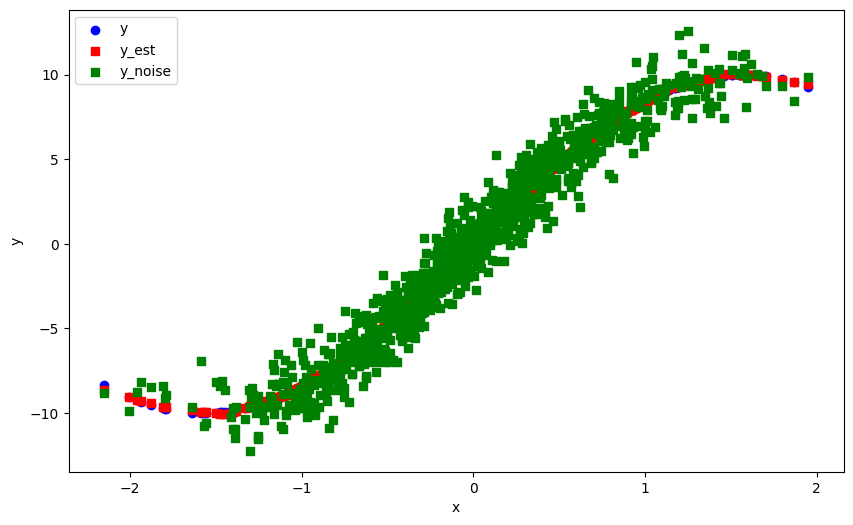

The programm is closed


In [12]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

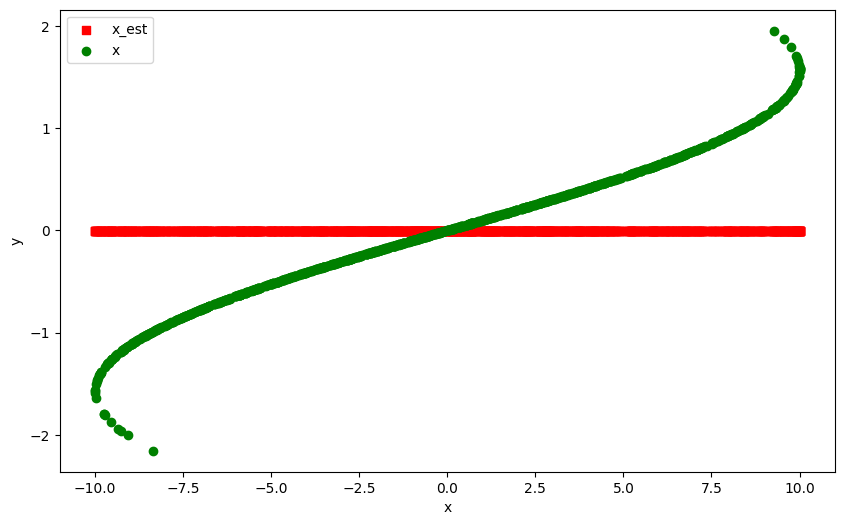

The programm is closed


In [13]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

## no causal

In [14]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[1, 0.6],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.6, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = epsilon[:, 1]
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

### update all parameters together

In [15]:
eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  1%|          | 148/29000 [00:00<01:27, 330.95it/s]

Sigma:  tensor([[0.9605, 0.0195],
        [0.0195, 1.0406]], grad_fn=<MmBackward0>)
obj:  tensor(2.2124, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2077, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


  1%|          | 260/29000 [00:00<01:20, 358.04it/s]

Sigma:  tensor([[0.9208, 0.0374],
        [0.0374, 1.0787]], grad_fn=<MmBackward0>)
obj:  tensor(1.9938, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9792, grad_fn=<AddBackward0>)
h_val:  tensor(0.0070, grad_fn=<AddBackward0>)


  1%|          | 333/29000 [00:01<01:22, 349.47it/s]

Sigma:  tensor([[0.8801, 0.0529],
        [0.0529, 1.1058]], grad_fn=<MmBackward0>)
obj:  tensor(1.7742, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7415, grad_fn=<AddBackward0>)
h_val:  tensor(0.0200, grad_fn=<AddBackward0>)


  2%|▏         | 435/29000 [00:01<01:33, 305.60it/s]

Sigma:  tensor([[0.8385, 0.0648],
        [0.0648, 1.1110]], grad_fn=<MmBackward0>)
obj:  tensor(1.5585, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4951, grad_fn=<AddBackward0>)
h_val:  tensor(0.0447, grad_fn=<AddBackward0>)


  2%|▏         | 546/29000 [00:01<01:22, 343.18it/s]

Sigma:  tensor([[0.7966, 0.0721],
        [0.0721, 1.0903]], grad_fn=<MmBackward0>)
obj:  tensor(1.3535, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2419, grad_fn=<AddBackward0>)
h_val:  tensor(0.0864, grad_fn=<AddBackward0>)


  2%|▏         | 664/29000 [00:01<01:14, 377.88it/s]

Sigma:  tensor([[0.7553, 0.0741],
        [0.0741, 1.0508]], grad_fn=<MmBackward0>)
obj:  tensor(1.1655, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9848, grad_fn=<AddBackward0>)
h_val:  tensor(0.1493, grad_fn=<AddBackward0>)


  3%|▎         | 748/29000 [00:02<01:12, 389.95it/s]

Sigma:  tensor([[0.7150, 0.0709],
        [0.0709, 1.0020]], grad_fn=<MmBackward0>)
obj:  tensor(0.9981, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7265, grad_fn=<AddBackward0>)
h_val:  tensor(0.2351, grad_fn=<AddBackward0>)


  3%|▎         | 868/29000 [00:02<01:18, 360.55it/s]

Sigma:  tensor([[0.6763, 0.0642],
        [0.0642, 0.9503]], grad_fn=<MmBackward0>)
obj:  tensor(0.8596, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4785, grad_fn=<AddBackward0>)
h_val:  tensor(0.3409, grad_fn=<AddBackward0>)


  3%|▎         | 946/29000 [00:02<01:14, 374.39it/s]

Sigma:  tensor([[0.6395, 0.0563],
        [0.0563, 0.8991]], grad_fn=<MmBackward0>)
obj:  tensor(0.7586, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2655, grad_fn=<AddBackward0>)
h_val:  tensor(0.4509, grad_fn=<AddBackward0>)


  4%|▎         | 1068/29000 [00:03<01:14, 373.83it/s]

Sigma:  tensor([[0.6052, 0.0494],
        [0.0494, 0.8505]], grad_fn=<MmBackward0>)
obj:  tensor(0.6833, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1124, grad_fn=<AddBackward0>)
h_val:  tensor(0.5282, grad_fn=<AddBackward0>)


  4%|▍         | 1150/29000 [00:03<01:11, 388.69it/s]

Sigma:  tensor([[0.5736, 0.0446],
        [0.0446, 0.8056]], grad_fn=<MmBackward0>)
obj:  tensor(0.6084, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0164, grad_fn=<AddBackward0>)
h_val:  tensor(0.5496, grad_fn=<AddBackward0>)


  4%|▍         | 1270/29000 [00:03<01:10, 392.28it/s]

Sigma:  tensor([[0.5450, 0.0413],
        [0.0413, 0.7650]], grad_fn=<MmBackward0>)
obj:  tensor(0.5299, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0569, grad_fn=<AddBackward0>)
h_val:  tensor(0.5439, grad_fn=<AddBackward0>)


  5%|▍         | 1351/29000 [00:03<01:13, 373.93it/s]

Sigma:  tensor([[0.5189, 0.0378],
        [0.0378, 0.7283]], grad_fn=<MmBackward0>)
obj:  tensor(0.4535, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1423, grad_fn=<AddBackward0>)
h_val:  tensor(0.5518, grad_fn=<AddBackward0>)


  5%|▌         | 1467/29000 [00:04<01:12, 379.84it/s]

Sigma:  tensor([[0.4950, 0.0329],
        [0.0329, 0.6944]], grad_fn=<MmBackward0>)
obj:  tensor(0.3811, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2467, grad_fn=<AddBackward0>)
h_val:  tensor(0.5823, grad_fn=<AddBackward0>)


  5%|▌         | 1544/29000 [00:04<01:16, 357.44it/s]

Sigma:  tensor([[0.4727, 0.0261],
        [0.0261, 0.6625]], grad_fn=<MmBackward0>)
obj:  tensor(0.3113, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3556, grad_fn=<AddBackward0>)
h_val:  tensor(0.6200, grad_fn=<AddBackward0>)


  6%|▌         | 1655/29000 [00:04<01:20, 339.80it/s]

Sigma:  tensor([[0.4517, 0.0179],
        [0.0179, 0.6323]], grad_fn=<MmBackward0>)
obj:  tensor(0.2420, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4561, grad_fn=<AddBackward0>)
h_val:  tensor(0.6502, grad_fn=<AddBackward0>)


  6%|▌         | 1771/29000 [00:04<01:16, 357.87it/s]

Sigma:  tensor([[0.4319, 0.0084],
        [0.0084, 0.6038]], grad_fn=<MmBackward0>)
obj:  tensor(0.1730, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5517, grad_fn=<AddBackward0>)
h_val:  tensor(0.6755, grad_fn=<AddBackward0>)


  6%|▋         | 1846/29000 [00:05<01:16, 355.64it/s]

Sigma:  tensor([[ 0.4132, -0.0026],
        [-0.0026,  0.5771]], grad_fn=<MmBackward0>)
obj:  tensor(0.1056, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6477, grad_fn=<AddBackward0>)
h_val:  tensor(0.7027, grad_fn=<AddBackward0>)


  7%|▋         | 1960/29000 [00:05<01:16, 351.66it/s]

Sigma:  tensor([[ 0.3955, -0.0148],
        [-0.0148,  0.5524]], grad_fn=<MmBackward0>)
obj:  tensor(0.0402, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7428, grad_fn=<AddBackward0>)
h_val:  tensor(0.7312, grad_fn=<AddBackward0>)


  7%|▋         | 2076/29000 [00:05<01:11, 374.18it/s]

Sigma:  tensor([[ 0.3787, -0.0280],
        [-0.0280,  0.5299]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0293, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8336, grad_fn=<AddBackward0>)
h_val:  tensor(0.7514, grad_fn=<AddBackward0>)


  7%|▋         | 2153/29000 [00:06<01:11, 374.77it/s]

Sigma:  tensor([[ 0.3627, -0.0418],
        [-0.0418,  0.5097]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0987, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9241, grad_fn=<AddBackward0>)
h_val:  tensor(0.7713, grad_fn=<AddBackward0>)


  8%|▊         | 2273/29000 [00:06<01:08, 388.99it/s]

Sigma:  tensor([[ 0.3475, -0.0559],
        [-0.0559,  0.4920]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1690, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0141, grad_fn=<AddBackward0>)
h_val:  tensor(0.7899, grad_fn=<AddBackward0>)


  8%|▊         | 2351/29000 [00:06<01:11, 371.53it/s]

Sigma:  tensor([[ 0.3331, -0.0701],
        [-0.0701,  0.4769]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2414, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1046, grad_fn=<AddBackward0>)
h_val:  tensor(0.8069, grad_fn=<AddBackward0>)


  9%|▊         | 2473/29000 [00:06<01:09, 383.54it/s]

Sigma:  tensor([[ 0.3193, -0.0841],
        [-0.0841,  0.4641]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3165, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1955, grad_fn=<AddBackward0>)
h_val:  tensor(0.8217, grad_fn=<AddBackward0>)


  9%|▉         | 2551/29000 [00:07<01:13, 360.21it/s]

Sigma:  tensor([[ 0.3062, -0.0976],
        [-0.0976,  0.4538]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3913, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2871, grad_fn=<AddBackward0>)
h_val:  tensor(0.8374, grad_fn=<AddBackward0>)


  9%|▉         | 2670/29000 [00:07<01:08, 385.57it/s]

Sigma:  tensor([[ 0.2937, -0.1106],
        [-0.1106,  0.4458]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4675, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3768, grad_fn=<AddBackward0>)
h_val:  tensor(0.8499, grad_fn=<AddBackward0>)


  9%|▉         | 2748/29000 [00:07<01:10, 373.56it/s]

Sigma:  tensor([[ 0.2817, -0.1230],
        [-0.1230,  0.4401]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5453, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4689, grad_fn=<AddBackward0>)
h_val:  tensor(0.8633, grad_fn=<AddBackward0>)


 10%|▉         | 2852/29000 [00:08<01:38, 266.57it/s]

Sigma:  tensor([[ 0.2702, -0.1347],
        [-0.1347,  0.4364]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6234, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5595, grad_fn=<AddBackward0>)
h_val:  tensor(0.8750, grad_fn=<AddBackward0>)


 10%|█         | 2969/29000 [00:08<01:15, 342.69it/s]

Sigma:  tensor([[ 0.2593, -0.1458],
        [-0.1458,  0.4347]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7025, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6511, grad_fn=<AddBackward0>)
h_val:  tensor(0.8866, grad_fn=<AddBackward0>)


 11%|█         | 3047/29000 [00:08<01:11, 364.31it/s]

Sigma:  tensor([[ 0.2488, -0.1561],
        [-0.1561,  0.4350]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7830, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7411, grad_fn=<AddBackward0>)
h_val:  tensor(0.8953, grad_fn=<AddBackward0>)


 11%|█         | 3170/29000 [00:08<01:06, 387.17it/s]

Sigma:  tensor([[ 0.2388, -0.1658],
        [-0.1658,  0.4370]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8644, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8344, grad_fn=<AddBackward0>)
h_val:  tensor(0.9066, grad_fn=<AddBackward0>)


 11%|█         | 3251/29000 [00:09<01:06, 387.21it/s]

Sigma:  tensor([[ 0.2292, -0.1747],
        [-0.1747,  0.4406]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9459, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9254, grad_fn=<AddBackward0>)
h_val:  tensor(0.9154, grad_fn=<AddBackward0>)


 12%|█▏        | 3377/29000 [00:09<01:04, 396.79it/s]

Sigma:  tensor([[ 0.2199, -0.1830],
        [-0.1830,  0.4458]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0283, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0163, grad_fn=<AddBackward0>)
h_val:  tensor(0.9233, grad_fn=<AddBackward0>)


 12%|█▏        | 3456/29000 [00:09<01:10, 363.52it/s]

Sigma:  tensor([[ 0.2111, -0.1906],
        [-0.1906,  0.4525]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1103, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1080, grad_fn=<AddBackward0>)
h_val:  tensor(0.9324, grad_fn=<AddBackward0>)


 12%|█▏        | 3576/29000 [00:10<01:06, 384.51it/s]

Sigma:  tensor([[ 0.2027, -0.1976],
        [-0.1976,  0.4605]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1931, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2004, grad_fn=<AddBackward0>)
h_val:  tensor(0.9414, grad_fn=<AddBackward0>)


 13%|█▎        | 3654/29000 [00:10<01:08, 371.98it/s]

Sigma:  tensor([[ 0.1945, -0.2041],
        [-0.2041,  0.4697]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2762, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2917, grad_fn=<AddBackward0>)
h_val:  tensor(0.9492, grad_fn=<AddBackward0>)


 13%|█▎        | 3776/29000 [00:10<01:03, 395.76it/s]

Sigma:  tensor([[ 0.1868, -0.2099],
        [-0.2099,  0.4802]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3592, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3838, grad_fn=<AddBackward0>)
h_val:  tensor(0.9578, grad_fn=<AddBackward0>)


 13%|█▎        | 3855/29000 [00:10<01:05, 386.61it/s]

Sigma:  tensor([[ 0.1793, -0.2152],
        [-0.2152,  0.4916]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4408, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4749, grad_fn=<AddBackward0>)
h_val:  tensor(0.9668, grad_fn=<AddBackward0>)


 14%|█▎        | 3975/29000 [00:11<01:06, 376.09it/s]

Sigma:  tensor([[ 0.1721, -0.2200],
        [-0.2200,  0.5042]], grad_fn=<MmBackward0>)
obj:  tensor(-1.5229, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5658, grad_fn=<AddBackward0>)
h_val:  tensor(0.9751, grad_fn=<AddBackward0>)


 14%|█▍        | 4053/29000 [00:11<01:05, 380.58it/s]

Sigma:  tensor([[ 0.1652, -0.2244],
        [-0.2244,  0.5176]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6034, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6557, grad_fn=<AddBackward0>)
h_val:  tensor(0.9841, grad_fn=<AddBackward0>)


 14%|█▍        | 4173/29000 [00:11<01:05, 380.20it/s]

Sigma:  tensor([[ 0.1587, -0.2283],
        [-0.2283,  0.5320]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6843, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7459, grad_fn=<AddBackward0>)
h_val:  tensor(0.9930, grad_fn=<AddBackward0>)


 15%|█▍        | 4252/29000 [00:11<01:04, 382.52it/s]

Sigma:  tensor([[ 0.1523, -0.2317],
        [-0.2317,  0.5471]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7654, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8355, grad_fn=<AddBackward0>)
h_val:  tensor(1.0011, grad_fn=<AddBackward0>)


 15%|█▌        | 4375/29000 [00:12<01:03, 390.62it/s]

Sigma:  tensor([[ 0.1463, -0.2348],
        [-0.2348,  0.5629]], grad_fn=<MmBackward0>)
obj:  tensor(-1.8451, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9239, grad_fn=<AddBackward0>)
h_val:  tensor(1.0095, grad_fn=<AddBackward0>)


 15%|█▌        | 4454/29000 [00:12<01:03, 387.75it/s]

Sigma:  tensor([[ 0.1405, -0.2375],
        [-0.2375,  0.5794]], grad_fn=<MmBackward0>)
obj:  tensor(-1.9248, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0130, grad_fn=<AddBackward0>)
h_val:  tensor(1.0186, grad_fn=<AddBackward0>)


 16%|█▌        | 4534/29000 [00:12<01:07, 364.90it/s]

Sigma:  tensor([[ 0.1349, -0.2398],
        [-0.2398,  0.5966]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1018, grad_fn=<AddBackward0>)
h_val:  tensor(1.0294, grad_fn=<AddBackward0>)


 16%|█▌        | 4661/29000 [00:12<01:02, 389.52it/s]

Sigma:  tensor([[ 0.1296, -0.2419],
        [-0.2419,  0.6143]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0816, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1893, grad_fn=<AddBackward0>)
h_val:  tensor(1.0376, grad_fn=<AddBackward0>)


 16%|█▋        | 4740/29000 [00:13<01:03, 383.44it/s]

Sigma:  tensor([[ 0.1244, -0.2436],
        [-0.2436,  0.6325]], grad_fn=<MmBackward0>)
obj:  tensor(-2.1591, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2771, grad_fn=<AddBackward0>)
h_val:  tensor(1.0475, grad_fn=<AddBackward0>)


 17%|█▋        | 4857/29000 [00:13<01:04, 375.66it/s]

Sigma:  tensor([[ 0.1195, -0.2450],
        [-0.2450,  0.6513]], grad_fn=<MmBackward0>)
obj:  tensor(-2.2361, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3645, grad_fn=<AddBackward0>)
h_val:  tensor(1.0576, grad_fn=<AddBackward0>)


 17%|█▋        | 4934/29000 [00:13<01:07, 357.57it/s]

Sigma:  tensor([[ 0.1148, -0.2462],
        [-0.2462,  0.6705]], grad_fn=<MmBackward0>)
obj:  tensor(-2.3120, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4514, grad_fn=<AddBackward0>)
h_val:  tensor(1.0683, grad_fn=<AddBackward0>)


 17%|█▋        | 5060/29000 [00:13<01:01, 386.55it/s]

Sigma:  tensor([[ 0.1103, -0.2471],
        [-0.2471,  0.6902]], grad_fn=<MmBackward0>)
obj:  tensor(-2.3887, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5382, grad_fn=<AddBackward0>)
h_val:  tensor(1.0782, grad_fn=<AddBackward0>)


 18%|█▊        | 5182/29000 [00:14<00:59, 399.85it/s]

Sigma:  tensor([[ 0.1060, -0.2478],
        [-0.2478,  0.7103]], grad_fn=<MmBackward0>)
obj:  tensor(-2.4641, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6245, grad_fn=<AddBackward0>)
h_val:  tensor(1.0887, grad_fn=<AddBackward0>)


 18%|█▊        | 5265/29000 [00:14<00:59, 401.29it/s]

Sigma:  tensor([[ 0.1018, -0.2482],
        [-0.2482,  0.7308]], grad_fn=<MmBackward0>)
obj:  tensor(-2.5386, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7106, grad_fn=<AddBackward0>)
h_val:  tensor(1.1001, grad_fn=<AddBackward0>)


 18%|█▊        | 5346/29000 [00:14<01:00, 391.84it/s]

Sigma:  tensor([[ 0.0978, -0.2485],
        [-0.2485,  0.7517]], grad_fn=<MmBackward0>)
obj:  tensor(-2.6135, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7963, grad_fn=<AddBackward0>)
h_val:  tensor(1.1107, grad_fn=<AddBackward0>)


 19%|█▉        | 5475/29000 [00:14<00:57, 406.79it/s]

Sigma:  tensor([[ 0.0940, -0.2486],
        [-0.2486,  0.7729]], grad_fn=<MmBackward0>)
obj:  tensor(-2.6877, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8818, grad_fn=<AddBackward0>)
h_val:  tensor(1.1217, grad_fn=<AddBackward0>)


 19%|█▉        | 5557/29000 [00:15<00:59, 391.44it/s]

Sigma:  tensor([[ 0.0903, -0.2485],
        [-0.2485,  0.7945]], grad_fn=<MmBackward0>)
obj:  tensor(-2.7612, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9670, grad_fn=<AddBackward0>)
h_val:  tensor(1.1332, grad_fn=<AddBackward0>)


 20%|█▉        | 5683/29000 [00:15<00:57, 408.02it/s]

Sigma:  tensor([[ 0.0868, -0.2483],
        [-0.2483,  0.8164]], grad_fn=<MmBackward0>)
obj:  tensor(-2.8343, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0521, grad_fn=<AddBackward0>)
h_val:  tensor(1.1450, grad_fn=<AddBackward0>)


 20%|█▉        | 5765/29000 [00:15<00:57, 403.01it/s]

Sigma:  tensor([[ 0.0834, -0.2479],
        [-0.2479,  0.8387]], grad_fn=<MmBackward0>)
obj:  tensor(-2.9071, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1368, grad_fn=<AddBackward0>)
h_val:  tensor(1.1566, grad_fn=<AddBackward0>)


 20%|██        | 5847/29000 [00:15<00:58, 399.04it/s]

Sigma:  tensor([[ 0.0801, -0.2474],
        [-0.2474,  0.8612]], grad_fn=<MmBackward0>)
obj:  tensor(-2.9791, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2213, grad_fn=<AddBackward0>)
h_val:  tensor(1.1689, grad_fn=<AddBackward0>)


 21%|██        | 5977/29000 [00:16<00:55, 413.54it/s]

Sigma:  tensor([[ 0.0770, -0.2467],
        [-0.2467,  0.8840]], grad_fn=<MmBackward0>)
obj:  tensor(-3.0509, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3057, grad_fn=<AddBackward0>)
h_val:  tensor(1.1812, grad_fn=<AddBackward0>)


 21%|██        | 6060/29000 [00:16<00:56, 406.26it/s]

Sigma:  tensor([[ 0.0740, -0.2460],
        [-0.2460,  0.9072]], grad_fn=<MmBackward0>)
obj:  tensor(-3.1228, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3895, grad_fn=<AddBackward0>)
h_val:  tensor(1.1930, grad_fn=<AddBackward0>)


 21%|██        | 6141/29000 [00:16<00:57, 399.02it/s]

Sigma:  tensor([[ 0.0711, -0.2451],
        [-0.2451,  0.9306]], grad_fn=<MmBackward0>)
obj:  tensor(-3.1940, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4733, grad_fn=<AddBackward0>)
h_val:  tensor(1.2053, grad_fn=<AddBackward0>)


 22%|██▏       | 6274/29000 [00:16<00:54, 413.75it/s]

Sigma:  tensor([[ 0.0683, -0.2441],
        [-0.2441,  0.9543]], grad_fn=<MmBackward0>)
obj:  tensor(-3.2647, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5570, grad_fn=<AddBackward0>)
h_val:  tensor(1.2181, grad_fn=<AddBackward0>)


 22%|██▏       | 6357/29000 [00:17<00:55, 406.01it/s]

Sigma:  tensor([[ 0.0657, -0.2430],
        [-0.2430,  0.9783]], grad_fn=<MmBackward0>)
obj:  tensor(-3.3352, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6405, grad_fn=<AddBackward0>)
h_val:  tensor(1.2308, grad_fn=<AddBackward0>)


 22%|██▏       | 6482/29000 [00:17<00:54, 412.19it/s]

Sigma:  tensor([[ 0.0631, -0.2419],
        [-0.2419,  1.0025]], grad_fn=<MmBackward0>)
obj:  tensor(-3.4057, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7237, grad_fn=<AddBackward0>)
h_val:  tensor(1.2433, grad_fn=<AddBackward0>)


 23%|██▎       | 6564/29000 [00:17<00:56, 394.23it/s]

Sigma:  tensor([[ 0.0607, -0.2406],
        [-0.2406,  1.0271]], grad_fn=<MmBackward0>)
obj:  tensor(-3.4756, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8067, grad_fn=<AddBackward0>)
h_val:  tensor(1.2562, grad_fn=<AddBackward0>)


 23%|██▎       | 6643/29000 [00:17<00:58, 381.20it/s]

Sigma:  tensor([[ 0.0583, -0.2393],
        [-0.2393,  1.0519]], grad_fn=<MmBackward0>)
obj:  tensor(-3.5444, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8897, grad_fn=<AddBackward0>)
h_val:  tensor(1.2702, grad_fn=<AddBackward0>)


 23%|██▎       | 6770/29000 [00:18<00:55, 397.01it/s]

Sigma:  tensor([[ 0.0560, -0.2379],
        [-0.2379,  1.0769]], grad_fn=<MmBackward0>)
obj:  tensor(-3.6139, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9724, grad_fn=<AddBackward0>)
h_val:  tensor(1.2832, grad_fn=<AddBackward0>)


 24%|██▎       | 6851/29000 [00:18<00:57, 387.87it/s]

Sigma:  tensor([[ 0.0539, -0.2365],
        [-0.2365,  1.1022]], grad_fn=<MmBackward0>)
obj:  tensor(-3.6831, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0551, grad_fn=<AddBackward0>)
h_val:  tensor(1.2964, grad_fn=<AddBackward0>)


 24%|██▍       | 6970/29000 [00:18<01:00, 364.12it/s]

Sigma:  tensor([[ 0.0518, -0.2349],
        [-0.2349,  1.1278]], grad_fn=<MmBackward0>)
obj:  tensor(-3.7514, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1377, grad_fn=<AddBackward0>)
h_val:  tensor(1.3105, grad_fn=<AddBackward0>)


 25%|██▍       | 7169/29000 [00:19<00:55, 390.06it/s]

Sigma:  tensor([[ 0.0499, -0.2305],
        [-0.2305,  1.1223]], grad_fn=<MmBackward0>)
obj:  tensor(0.6058, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6982, grad_fn=<AddBackward0>)
h_val:  tensor(0.9683, grad_fn=<AddBackward0>)


 25%|██▌       | 7252/29000 [00:19<00:55, 394.61it/s]

Sigma:  tensor([[ 0.0518, -0.2302],
        [-0.2302,  1.0806]], grad_fn=<MmBackward0>)
obj:  tensor(0.5132, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3224, grad_fn=<AddBackward0>)
h_val:  tensor(0.9379, grad_fn=<AddBackward0>)


 25%|██▌       | 7341/29000 [00:19<00:52, 415.01it/s]

Sigma:  tensor([[ 0.0532, -0.2294],
        [-0.2294,  1.0445]], grad_fn=<MmBackward0>)
obj:  tensor(0.4653, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9343, grad_fn=<AddBackward0>)
h_val:  tensor(0.8510, grad_fn=<AddBackward0>)


 26%|██▌       | 7469/29000 [00:20<00:53, 401.30it/s]

Sigma:  tensor([[ 0.0548, -0.2285],
        [-0.2285,  1.0069]], grad_fn=<MmBackward0>)
obj:  tensor(0.4343, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8816, grad_fn=<AddBackward0>)
h_val:  tensor(0.8143, grad_fn=<AddBackward0>)


 26%|██▌       | 7548/29000 [00:20<01:00, 357.07it/s]

Sigma:  tensor([[ 0.0562, -0.2273],
        [-0.2273,  0.9706]], grad_fn=<MmBackward0>)
obj:  tensor(0.4134, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8051, grad_fn=<AddBackward0>)
h_val:  tensor(0.7855, grad_fn=<AddBackward0>)


 26%|██▋       | 7661/29000 [00:20<01:23, 255.90it/s]

Sigma:  tensor([[ 0.0576, -0.2257],
        [-0.2257,  0.9352]], grad_fn=<MmBackward0>)
obj:  tensor(0.3992, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7259, grad_fn=<AddBackward0>)
h_val:  tensor(0.7633, grad_fn=<AddBackward0>)


 27%|██▋       | 7777/29000 [00:21<01:03, 331.74it/s]

Sigma:  tensor([[ 0.0588, -0.2239],
        [-0.2239,  0.9005]], grad_fn=<MmBackward0>)
obj:  tensor(0.3863, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6841, grad_fn=<AddBackward0>)
h_val:  tensor(0.7462, grad_fn=<AddBackward0>)


 27%|██▋       | 7855/29000 [00:21<00:58, 359.43it/s]

Sigma:  tensor([[ 0.0601, -0.2221],
        [-0.2221,  0.8668]], grad_fn=<MmBackward0>)
obj:  tensor(0.3737, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6734, grad_fn=<AddBackward0>)
h_val:  tensor(0.7325, grad_fn=<AddBackward0>)


 28%|██▊       | 7978/29000 [00:21<00:54, 388.64it/s]

Sigma:  tensor([[ 0.0615, -0.2203],
        [-0.2203,  0.8342]], grad_fn=<MmBackward0>)
obj:  tensor(0.3617, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6857, grad_fn=<AddBackward0>)
h_val:  tensor(0.7218, grad_fn=<AddBackward0>)


 28%|██▊       | 8057/29000 [00:21<00:54, 383.31it/s]

Sigma:  tensor([[ 0.0629, -0.2187],
        [-0.2187,  0.8025]], grad_fn=<MmBackward0>)
obj:  tensor(0.3499, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7043, grad_fn=<AddBackward0>)
h_val:  tensor(0.7120, grad_fn=<AddBackward0>)


 28%|██▊       | 8173/29000 [00:22<00:55, 376.74it/s]

Sigma:  tensor([[ 0.0645, -0.2172],
        [-0.2172,  0.7719]], grad_fn=<MmBackward0>)
obj:  tensor(0.3387, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7037, grad_fn=<AddBackward0>)
h_val:  tensor(0.7008, grad_fn=<AddBackward0>)


 28%|██▊       | 8250/29000 [00:22<00:57, 363.71it/s]

Sigma:  tensor([[ 0.0662, -0.2158],
        [-0.2158,  0.7423]], grad_fn=<MmBackward0>)
obj:  tensor(0.3278, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7044, grad_fn=<AddBackward0>)
h_val:  tensor(0.6900, grad_fn=<AddBackward0>)


 29%|██▉       | 8370/29000 [00:22<00:53, 385.02it/s]

Sigma:  tensor([[ 0.0680, -0.2144],
        [-0.2144,  0.7138]], grad_fn=<MmBackward0>)
obj:  tensor(0.3172, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7013, grad_fn=<AddBackward0>)
h_val:  tensor(0.6791, grad_fn=<AddBackward0>)


 29%|██▉       | 8447/29000 [00:22<00:55, 368.62it/s]

Sigma:  tensor([[ 0.0699, -0.2132],
        [-0.2132,  0.6864]], grad_fn=<MmBackward0>)
obj:  tensor(0.3068, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6968, grad_fn=<AddBackward0>)
h_val:  tensor(0.6684, grad_fn=<AddBackward0>)


 30%|██▉       | 8574/29000 [00:23<00:51, 393.67it/s]

Sigma:  tensor([[ 0.0719, -0.2121],
        [-0.2121,  0.6602]], grad_fn=<MmBackward0>)
obj:  tensor(0.2968, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6962, grad_fn=<AddBackward0>)
h_val:  tensor(0.6584, grad_fn=<AddBackward0>)


 30%|██▉       | 8655/29000 [00:23<00:51, 394.23it/s]

Sigma:  tensor([[ 0.0740, -0.2110],
        [-0.2110,  0.6351]], grad_fn=<MmBackward0>)
obj:  tensor(0.2871, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6988, grad_fn=<AddBackward0>)
h_val:  tensor(0.6490, grad_fn=<AddBackward0>)


 30%|███       | 8781/29000 [00:23<00:49, 404.81it/s]

Sigma:  tensor([[ 0.0762, -0.2100],
        [-0.2100,  0.6110]], grad_fn=<MmBackward0>)
obj:  tensor(0.2779, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7021, grad_fn=<AddBackward0>)
h_val:  tensor(0.6402, grad_fn=<AddBackward0>)


 31%|███       | 8863/29000 [00:23<00:50, 399.77it/s]

Sigma:  tensor([[ 0.0785, -0.2091],
        [-0.2091,  0.5881]], grad_fn=<MmBackward0>)
obj:  tensor(0.2690, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7051, grad_fn=<AddBackward0>)
h_val:  tensor(0.6316, grad_fn=<AddBackward0>)


 31%|███       | 8944/29000 [00:24<00:51, 392.63it/s]

Sigma:  tensor([[ 0.0809, -0.2083],
        [-0.2083,  0.5663]], grad_fn=<MmBackward0>)
obj:  tensor(0.2605, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7083, grad_fn=<AddBackward0>)
h_val:  tensor(0.6235, grad_fn=<AddBackward0>)


 31%|███▏      | 9074/29000 [00:24<00:48, 409.99it/s]

Sigma:  tensor([[ 0.0833, -0.2076],
        [-0.2076,  0.5457]], grad_fn=<MmBackward0>)
obj:  tensor(0.2524, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7120, grad_fn=<AddBackward0>)
h_val:  tensor(0.6159, grad_fn=<AddBackward0>)


 32%|███▏      | 9157/29000 [00:24<00:49, 401.89it/s]

Sigma:  tensor([[ 0.0858, -0.2069],
        [-0.2069,  0.5261]], grad_fn=<MmBackward0>)
obj:  tensor(0.2447, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7166, grad_fn=<AddBackward0>)
h_val:  tensor(0.6087, grad_fn=<AddBackward0>)


 32%|███▏      | 9281/29000 [00:24<00:48, 405.64it/s]

Sigma:  tensor([[ 0.0885, -0.2064],
        [-0.2064,  0.5078]], grad_fn=<MmBackward0>)
obj:  tensor(0.2375, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7225, grad_fn=<AddBackward0>)
h_val:  tensor(0.6021, grad_fn=<AddBackward0>)


 32%|███▏      | 9363/29000 [00:25<00:50, 388.84it/s]

Sigma:  tensor([[ 0.0911, -0.2059],
        [-0.2059,  0.4905]], grad_fn=<MmBackward0>)
obj:  tensor(0.2303, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7290, grad_fn=<AddBackward0>)
h_val:  tensor(0.5956, grad_fn=<AddBackward0>)


 33%|███▎      | 9442/29000 [00:25<00:50, 388.46it/s]

Sigma:  tensor([[ 0.0939, -0.2056],
        [-0.2056,  0.4745]], grad_fn=<MmBackward0>)
obj:  tensor(0.2239, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7372, grad_fn=<AddBackward0>)
h_val:  tensor(0.5901, grad_fn=<AddBackward0>)


 33%|███▎      | 9572/29000 [00:25<00:47, 410.98it/s]

Sigma:  tensor([[ 0.0966, -0.2053],
        [-0.2053,  0.4596]], grad_fn=<MmBackward0>)
obj:  tensor(0.2179, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7447, grad_fn=<AddBackward0>)
h_val:  tensor(0.5849, grad_fn=<AddBackward0>)


 33%|███▎      | 9656/29000 [00:25<00:47, 406.49it/s]

Sigma:  tensor([[ 0.0995, -0.2052],
        [-0.2052,  0.4458]], grad_fn=<MmBackward0>)
obj:  tensor(0.2121, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7581, grad_fn=<AddBackward0>)
h_val:  tensor(0.5805, grad_fn=<AddBackward0>)


 34%|███▎      | 9782/29000 [00:26<00:46, 411.83it/s]

Sigma:  tensor([[ 0.1023, -0.2053],
        [-0.2053,  0.4333]], grad_fn=<MmBackward0>)
obj:  tensor(0.2065, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7726, grad_fn=<AddBackward0>)
h_val:  tensor(0.5764, grad_fn=<AddBackward0>)


 34%|███▍      | 9865/29000 [00:26<00:47, 402.30it/s]

Sigma:  tensor([[ 0.1052, -0.2054],
        [-0.2054,  0.4218]], grad_fn=<MmBackward0>)
obj:  tensor(0.2013, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7875, grad_fn=<AddBackward0>)
h_val:  tensor(0.5727, grad_fn=<AddBackward0>)


 34%|███▍      | 9947/29000 [00:26<00:47, 398.98it/s]

Sigma:  tensor([[ 0.1081, -0.2058],
        [-0.2058,  0.4114]], grad_fn=<MmBackward0>)
obj:  tensor(0.1964, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8058, grad_fn=<AddBackward0>)
h_val:  tensor(0.5696, grad_fn=<AddBackward0>)


 35%|███▍      | 10075/29000 [00:26<00:46, 408.65it/s]

Sigma:  tensor([[ 0.1110, -0.2062],
        [-0.2062,  0.4022]], grad_fn=<MmBackward0>)
obj:  tensor(0.1917, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8256, grad_fn=<AddBackward0>)
h_val:  tensor(0.5669, grad_fn=<AddBackward0>)


 35%|███▌      | 10157/29000 [00:27<00:47, 400.59it/s]

Sigma:  tensor([[ 0.1139, -0.2069],
        [-0.2069,  0.3940]], grad_fn=<MmBackward0>)
obj:  tensor(0.1873, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8482, grad_fn=<AddBackward0>)
h_val:  tensor(0.5648, grad_fn=<AddBackward0>)


 35%|███▌      | 10284/29000 [00:27<00:45, 413.95it/s]

Sigma:  tensor([[ 0.1168, -0.2076],
        [-0.2076,  0.3868]], grad_fn=<MmBackward0>)
obj:  tensor(0.1831, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8726, grad_fn=<AddBackward0>)
h_val:  tensor(0.5631, grad_fn=<AddBackward0>)


 36%|███▌      | 10367/29000 [00:27<00:46, 396.76it/s]

Sigma:  tensor([[ 0.1196, -0.2086],
        [-0.2086,  0.3806]], grad_fn=<MmBackward0>)
obj:  tensor(0.1787, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9002, grad_fn=<AddBackward0>)
h_val:  tensor(0.5615, grad_fn=<AddBackward0>)


 36%|███▌      | 10447/29000 [00:27<00:47, 394.25it/s]

Sigma:  tensor([[ 0.1224, -0.2096],
        [-0.2096,  0.3752]], grad_fn=<MmBackward0>)
obj:  tensor(0.1750, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9305, grad_fn=<AddBackward0>)
h_val:  tensor(0.5608, grad_fn=<AddBackward0>)


 36%|███▋      | 10574/29000 [00:28<00:45, 405.05it/s]

Sigma:  tensor([[ 0.1252, -0.2108],
        [-0.2108,  0.3707]], grad_fn=<MmBackward0>)
obj:  tensor(0.1712, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9627, grad_fn=<AddBackward0>)
h_val:  tensor(0.5603, grad_fn=<AddBackward0>)


 37%|███▋      | 10655/29000 [00:28<00:46, 397.50it/s]

Sigma:  tensor([[ 0.1278, -0.2121],
        [-0.2121,  0.3670]], grad_fn=<MmBackward0>)
obj:  tensor(0.1675, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9975, grad_fn=<AddBackward0>)
h_val:  tensor(0.5601, grad_fn=<AddBackward0>)


 37%|███▋      | 10781/29000 [00:28<00:44, 412.30it/s]

Sigma:  tensor([[ 0.1304, -0.2135],
        [-0.2135,  0.3639]], grad_fn=<MmBackward0>)
obj:  tensor(0.1635, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0329, grad_fn=<AddBackward0>)
h_val:  tensor(0.5596, grad_fn=<AddBackward0>)


 37%|███▋      | 10864/29000 [00:28<00:45, 402.85it/s]

Sigma:  tensor([[ 0.1328, -0.2149],
        [-0.2149,  0.3613]], grad_fn=<MmBackward0>)
obj:  tensor(0.1600, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0715, grad_fn=<AddBackward0>)
h_val:  tensor(0.5600, grad_fn=<AddBackward0>)


 38%|███▊      | 10946/29000 [00:29<00:45, 397.93it/s]

Sigma:  tensor([[ 0.1352, -0.2163],
        [-0.2163,  0.3592]], grad_fn=<MmBackward0>)
obj:  tensor(0.1567, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1108, grad_fn=<AddBackward0>)
h_val:  tensor(0.5606, grad_fn=<AddBackward0>)


 38%|███▊      | 11075/29000 [00:29<00:43, 410.29it/s]

Sigma:  tensor([[ 0.1374, -0.2177],
        [-0.2177,  0.3576]], grad_fn=<MmBackward0>)
obj:  tensor(0.1530, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1519, grad_fn=<AddBackward0>)
h_val:  tensor(0.5610, grad_fn=<AddBackward0>)


 38%|███▊      | 11158/29000 [00:29<00:45, 392.79it/s]

Sigma:  tensor([[ 0.1394, -0.2190],
        [-0.2190,  0.3563]], grad_fn=<MmBackward0>)
obj:  tensor(0.1495, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1939, grad_fn=<AddBackward0>)
h_val:  tensor(0.5617, grad_fn=<AddBackward0>)


 39%|███▉      | 11282/29000 [00:29<00:44, 402.57it/s]

Sigma:  tensor([[ 0.1413, -0.2203],
        [-0.2203,  0.3553]], grad_fn=<MmBackward0>)
obj:  tensor(0.1461, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2367, grad_fn=<AddBackward0>)
h_val:  tensor(0.5627, grad_fn=<AddBackward0>)


 39%|███▉      | 11364/29000 [00:30<00:44, 400.09it/s]

Sigma:  tensor([[ 0.1430, -0.2216],
        [-0.2216,  0.3546]], grad_fn=<MmBackward0>)
obj:  tensor(0.1426, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2814, grad_fn=<AddBackward0>)
h_val:  tensor(0.5636, grad_fn=<AddBackward0>)


 39%|███▉      | 11446/29000 [00:30<00:44, 395.76it/s]

Sigma:  tensor([[ 0.1445, -0.2227],
        [-0.2227,  0.3540]], grad_fn=<MmBackward0>)
obj:  tensor(0.1390, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3258, grad_fn=<AddBackward0>)
h_val:  tensor(0.5644, grad_fn=<AddBackward0>)


 40%|███▉      | 11577/29000 [00:30<00:42, 410.36it/s]

Sigma:  tensor([[ 0.1458, -0.2237],
        [-0.2237,  0.3536]], grad_fn=<MmBackward0>)
obj:  tensor(0.1357, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3715, grad_fn=<AddBackward0>)
h_val:  tensor(0.5657, grad_fn=<AddBackward0>)


 40%|████      | 11660/29000 [00:30<00:42, 405.52it/s]

Sigma:  tensor([[ 0.1469, -0.2246],
        [-0.2246,  0.3533]], grad_fn=<MmBackward0>)
obj:  tensor(0.1323, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4173, grad_fn=<AddBackward0>)
h_val:  tensor(0.5669, grad_fn=<AddBackward0>)


 40%|████      | 11742/29000 [00:31<00:43, 400.42it/s]

Sigma:  tensor([[ 0.1479, -0.2254],
        [-0.2254,  0.3530]], grad_fn=<MmBackward0>)
obj:  tensor(0.1287, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4639, grad_fn=<AddBackward0>)
h_val:  tensor(0.5679, grad_fn=<AddBackward0>)


 41%|████      | 11874/29000 [00:31<00:41, 417.08it/s]

Sigma:  tensor([[ 0.1486, -0.2260],
        [-0.2260,  0.3529]], grad_fn=<MmBackward0>)
obj:  tensor(0.1252, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5109, grad_fn=<AddBackward0>)
h_val:  tensor(0.5691, grad_fn=<AddBackward0>)


 41%|████      | 11957/29000 [00:31<00:41, 406.58it/s]

Sigma:  tensor([[ 0.1492, -0.2266],
        [-0.2266,  0.3529]], grad_fn=<MmBackward0>)
obj:  tensor(0.1217, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5578, grad_fn=<AddBackward0>)
h_val:  tensor(0.5704, grad_fn=<AddBackward0>)


 42%|████▏     | 12039/29000 [00:31<00:43, 386.23it/s]

Sigma:  tensor([[ 0.1496, -0.2270],
        [-0.2270,  0.3529]], grad_fn=<MmBackward0>)
obj:  tensor(0.1181, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6053, grad_fn=<AddBackward0>)
h_val:  tensor(0.5715, grad_fn=<AddBackward0>)


 42%|████▏     | 12167/29000 [00:32<00:41, 401.15it/s]

Sigma:  tensor([[ 0.1498, -0.2273],
        [-0.2273,  0.3530]], grad_fn=<MmBackward0>)
obj:  tensor(0.1145, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6530, grad_fn=<AddBackward0>)
h_val:  tensor(0.5726, grad_fn=<AddBackward0>)


 42%|████▏     | 12248/29000 [00:32<00:42, 392.75it/s]

Sigma:  tensor([[ 0.1500, -0.2276],
        [-0.2276,  0.3531]], grad_fn=<MmBackward0>)
obj:  tensor(0.1109, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7008, grad_fn=<AddBackward0>)
h_val:  tensor(0.5738, grad_fn=<AddBackward0>)


 43%|████▎     | 12370/29000 [00:32<00:42, 389.73it/s]

Sigma:  tensor([[ 0.1499, -0.2277],
        [-0.2277,  0.3533]], grad_fn=<MmBackward0>)
obj:  tensor(0.1073, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7489, grad_fn=<AddBackward0>)
h_val:  tensor(0.5751, grad_fn=<AddBackward0>)


 43%|████▎     | 12450/29000 [00:32<00:42, 390.03it/s]

Sigma:  tensor([[ 0.1498, -0.2278],
        [-0.2278,  0.3536]], grad_fn=<MmBackward0>)
obj:  tensor(0.1034, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7974, grad_fn=<AddBackward0>)
h_val:  tensor(0.5759, grad_fn=<AddBackward0>)


 43%|████▎     | 12579/29000 [00:33<00:39, 411.53it/s]

Sigma:  tensor([[ 0.1496, -0.2278],
        [-0.2278,  0.3538]], grad_fn=<MmBackward0>)
obj:  tensor(0.0999, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8456, grad_fn=<AddBackward0>)
h_val:  tensor(0.5773, grad_fn=<AddBackward0>)


 44%|████▎     | 12662/29000 [00:33<00:40, 402.67it/s]

Sigma:  tensor([[ 0.1493, -0.2278],
        [-0.2278,  0.3541]], grad_fn=<MmBackward0>)
obj:  tensor(0.0958, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8937, grad_fn=<AddBackward0>)
h_val:  tensor(0.5780, grad_fn=<AddBackward0>)


 44%|████▍     | 12743/29000 [00:33<00:41, 396.35it/s]

Sigma:  tensor([[ 0.1490, -0.2277],
        [-0.2277,  0.3544]], grad_fn=<MmBackward0>)
obj:  tensor(0.0923, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9418, grad_fn=<AddBackward0>)
h_val:  tensor(0.5793, grad_fn=<AddBackward0>)


 44%|████▍     | 12876/29000 [00:33<00:39, 406.06it/s]

Sigma:  tensor([[ 0.1486, -0.2276],
        [-0.2276,  0.3548]], grad_fn=<MmBackward0>)
obj:  tensor(0.0888, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9897, grad_fn=<AddBackward0>)
h_val:  tensor(0.5806, grad_fn=<AddBackward0>)


 45%|████▍     | 12958/29000 [00:34<00:40, 399.33it/s]

Sigma:  tensor([[ 0.1482, -0.2275],
        [-0.2275,  0.3551]], grad_fn=<MmBackward0>)
obj:  tensor(0.0848, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0375, grad_fn=<AddBackward0>)
h_val:  tensor(0.5814, grad_fn=<AddBackward0>)


 45%|████▍     | 13040/29000 [00:34<00:40, 396.29it/s]

Sigma:  tensor([[ 0.1478, -0.2274],
        [-0.2274,  0.3554]], grad_fn=<MmBackward0>)
obj:  tensor(0.0810, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0851, grad_fn=<AddBackward0>)
h_val:  tensor(0.5823, grad_fn=<AddBackward0>)


 45%|████▌     | 13170/29000 [00:34<00:38, 408.56it/s]

Sigma:  tensor([[ 0.1473, -0.2272],
        [-0.2272,  0.3558]], grad_fn=<MmBackward0>)
obj:  tensor(0.0773, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1326, grad_fn=<AddBackward0>)
h_val:  tensor(0.5833, grad_fn=<AddBackward0>)


 46%|████▌     | 13252/29000 [00:34<00:39, 403.11it/s]

Sigma:  tensor([[ 0.1469, -0.2271],
        [-0.2271,  0.3561]], grad_fn=<MmBackward0>)
obj:  tensor(0.0735, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1797, grad_fn=<AddBackward0>)
h_val:  tensor(0.5843, grad_fn=<AddBackward0>)


 46%|████▌     | 13380/29000 [00:35<00:37, 411.62it/s]

Sigma:  tensor([[ 0.1465, -0.2269],
        [-0.2269,  0.3564]], grad_fn=<MmBackward0>)
obj:  tensor(0.0698, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2269, grad_fn=<AddBackward0>)
h_val:  tensor(0.5853, grad_fn=<AddBackward0>)


 46%|████▋     | 13464/29000 [00:35<00:38, 406.88it/s]

Sigma:  tensor([[ 0.1461, -0.2268],
        [-0.2268,  0.3567]], grad_fn=<MmBackward0>)
obj:  tensor(0.0658, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2732, grad_fn=<AddBackward0>)
h_val:  tensor(0.5859, grad_fn=<AddBackward0>)


 47%|████▋     | 13546/29000 [00:35<00:39, 386.50it/s]

Sigma:  tensor([[ 0.1457, -0.2266],
        [-0.2266,  0.3570]], grad_fn=<MmBackward0>)
obj:  tensor(0.0621, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3198, grad_fn=<AddBackward0>)
h_val:  tensor(0.5868, grad_fn=<AddBackward0>)


 47%|████▋     | 13674/29000 [00:35<00:37, 410.60it/s]

Sigma:  tensor([[ 0.1454, -0.2265],
        [-0.2265,  0.3573]], grad_fn=<MmBackward0>)
obj:  tensor(0.0582, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3662, grad_fn=<AddBackward0>)
h_val:  tensor(0.5876, grad_fn=<AddBackward0>)


 47%|████▋     | 13757/29000 [00:36<00:37, 405.91it/s]

Sigma:  tensor([[ 0.1450, -0.2264],
        [-0.2264,  0.3576]], grad_fn=<MmBackward0>)
obj:  tensor(0.0544, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4122, grad_fn=<AddBackward0>)
h_val:  tensor(0.5884, grad_fn=<AddBackward0>)


 48%|████▊     | 13885/29000 [00:36<00:36, 415.67it/s]

Sigma:  tensor([[ 0.1447, -0.2263],
        [-0.2263,  0.3578]], grad_fn=<MmBackward0>)
obj:  tensor(0.0505, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4581, grad_fn=<AddBackward0>)
h_val:  tensor(0.5891, grad_fn=<AddBackward0>)


 48%|████▊     | 13968/29000 [00:36<00:37, 404.75it/s]

Sigma:  tensor([[ 0.1444, -0.2262],
        [-0.2262,  0.3581]], grad_fn=<MmBackward0>)
obj:  tensor(0.0467, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5034, grad_fn=<AddBackward0>)
h_val:  tensor(0.5898, grad_fn=<AddBackward0>)


 49%|████▉     | 14181/29000 [00:37<00:35, 420.97it/s]

Sigma:  tensor([[ 0.1424, -0.2218],
        [-0.2218,  0.3492]], grad_fn=<MmBackward0>)
obj:  tensor(0.4955, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2604, grad_fn=<AddBackward0>)
h_val:  tensor(0.4722, grad_fn=<AddBackward0>)


 49%|████▉     | 14266/29000 [00:37<00:36, 407.68it/s]

Sigma:  tensor([[ 0.1418, -0.2147],
        [-0.2147,  0.3287]], grad_fn=<MmBackward0>)
obj:  tensor(0.4755, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6464, grad_fn=<AddBackward0>)
h_val:  tensor(0.4813, grad_fn=<AddBackward0>)


 49%|████▉     | 14340/29000 [00:37<00:55, 263.40it/s]

Sigma:  tensor([[ 0.1405, -0.2070],
        [-0.2070,  0.3088]], grad_fn=<MmBackward0>)
obj:  tensor(0.4646, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5379, grad_fn=<AddBackward0>)
h_val:  tensor(0.4793, grad_fn=<AddBackward0>)


 50%|████▉     | 14466/29000 [00:38<00:41, 354.32it/s]

Sigma:  tensor([[ 0.1390, -0.1991],
        [-0.1991,  0.2890]], grad_fn=<MmBackward0>)
obj:  tensor(0.4556, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2549, grad_fn=<AddBackward0>)
h_val:  tensor(0.4424, grad_fn=<AddBackward0>)


 50%|█████     | 14546/29000 [00:38<00:38, 373.15it/s]

Sigma:  tensor([[ 0.1382, -0.1916],
        [-0.1916,  0.2697]], grad_fn=<MmBackward0>)
obj:  tensor(0.4486, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1676, grad_fn=<AddBackward0>)
h_val:  tensor(0.4496, grad_fn=<AddBackward0>)


 51%|█████     | 14676/29000 [00:38<00:35, 400.74it/s]

Sigma:  tensor([[ 0.1365, -0.1842],
        [-0.1842,  0.2526]], grad_fn=<MmBackward0>)
obj:  tensor(0.4427, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3770, grad_fn=<AddBackward0>)
h_val:  tensor(0.4282, grad_fn=<AddBackward0>)


 51%|█████     | 14757/29000 [00:38<00:36, 391.94it/s]

Sigma:  tensor([[ 0.1356, -0.1773],
        [-0.1773,  0.2361]], grad_fn=<MmBackward0>)
obj:  tensor(0.4374, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0665, grad_fn=<AddBackward0>)
h_val:  tensor(0.4261, grad_fn=<AddBackward0>)


 51%|█████▏    | 14881/29000 [00:39<00:34, 404.35it/s]

Sigma:  tensor([[ 0.1344, -0.1709],
        [-0.1709,  0.2217]], grad_fn=<MmBackward0>)
obj:  tensor(0.4325, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7809, grad_fn=<AddBackward0>)
h_val:  tensor(0.4141, grad_fn=<AddBackward0>)


 52%|█████▏    | 14963/29000 [00:39<00:35, 400.90it/s]

Sigma:  tensor([[ 0.1335, -0.1651],
        [-0.1651,  0.2087]], grad_fn=<MmBackward0>)
obj:  tensor(0.4280, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9210, grad_fn=<AddBackward0>)
h_val:  tensor(0.4081, grad_fn=<AddBackward0>)


 52%|█████▏    | 15044/29000 [00:39<00:36, 387.36it/s]

Sigma:  tensor([[ 0.1328, -0.1599],
        [-0.1599,  0.1971]], grad_fn=<MmBackward0>)
obj:  tensor(0.4235, grad_fn=<AddBackward0>)
mle loss:  tensor(2.3931, grad_fn=<AddBackward0>)
h_val:  tensor(0.3989, grad_fn=<AddBackward0>)


 52%|█████▏    | 15174/29000 [00:39<00:34, 405.98it/s]

Sigma:  tensor([[ 0.1325, -0.1553],
        [-0.1553,  0.1869]], grad_fn=<MmBackward0>)
obj:  tensor(0.4190, grad_fn=<AddBackward0>)
mle loss:  tensor(2.6883, grad_fn=<AddBackward0>)
h_val:  tensor(0.3914, grad_fn=<AddBackward0>)


 53%|█████▎    | 15255/29000 [00:40<00:34, 396.32it/s]

Sigma:  tensor([[ 0.1326, -0.1513],
        [-0.1513,  0.1777]], grad_fn=<MmBackward0>)
obj:  tensor(0.4144, grad_fn=<AddBackward0>)
mle loss:  tensor(3.0966, grad_fn=<AddBackward0>)
h_val:  tensor(0.3828, grad_fn=<AddBackward0>)


 53%|█████▎    | 15381/29000 [00:40<00:33, 410.43it/s]

Sigma:  tensor([[ 0.1333, -0.1479],
        [-0.1479,  0.1694]], grad_fn=<MmBackward0>)
obj:  tensor(0.4094, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4673, grad_fn=<AddBackward0>)
h_val:  tensor(0.3741, grad_fn=<AddBackward0>)


 53%|█████▎    | 15465/29000 [00:40<00:33, 408.11it/s]

Sigma:  tensor([[ 0.1347, -0.1451],
        [-0.1451,  0.1619]], grad_fn=<MmBackward0>)
obj:  tensor(0.4045, grad_fn=<AddBackward0>)
mle loss:  tensor(3.8607, grad_fn=<AddBackward0>)
h_val:  tensor(0.3653, grad_fn=<AddBackward0>)


 54%|█████▎    | 15548/29000 [00:40<00:33, 406.24it/s]

Sigma:  tensor([[ 0.1367, -0.1428],
        [-0.1428,  0.1551]], grad_fn=<MmBackward0>)
obj:  tensor(0.3993, grad_fn=<AddBackward0>)
mle loss:  tensor(4.2458, grad_fn=<AddBackward0>)
h_val:  tensor(0.3563, grad_fn=<AddBackward0>)


 54%|█████▍    | 15679/29000 [00:41<00:32, 414.66it/s]

Sigma:  tensor([[ 0.1393, -0.1411],
        [-0.1411,  0.1489]], grad_fn=<MmBackward0>)
obj:  tensor(0.3937, grad_fn=<AddBackward0>)
mle loss:  tensor(4.6554, grad_fn=<AddBackward0>)
h_val:  tensor(0.3465, grad_fn=<AddBackward0>)


 54%|█████▍    | 15762/29000 [00:41<00:33, 396.29it/s]

Sigma:  tensor([[ 0.1426, -0.1397],
        [-0.1397,  0.1432]], grad_fn=<MmBackward0>)
obj:  tensor(0.3876, grad_fn=<AddBackward0>)
mle loss:  tensor(5.0912, grad_fn=<AddBackward0>)
h_val:  tensor(0.3360, grad_fn=<AddBackward0>)


 55%|█████▍    | 15842/29000 [00:41<00:33, 396.14it/s]

Sigma:  tensor([[ 0.1466, -0.1387],
        [-0.1387,  0.1380]], grad_fn=<MmBackward0>)
obj:  tensor(0.3810, grad_fn=<AddBackward0>)
mle loss:  tensor(5.5399, grad_fn=<AddBackward0>)
h_val:  tensor(0.3249, grad_fn=<AddBackward0>)


 55%|█████▌    | 15973/29000 [00:41<00:31, 410.42it/s]

Sigma:  tensor([[ 0.1512, -0.1380],
        [-0.1380,  0.1330]], grad_fn=<MmBackward0>)
obj:  tensor(0.3737, grad_fn=<AddBackward0>)
mle loss:  tensor(6.0266, grad_fn=<AddBackward0>)
h_val:  tensor(0.3129, grad_fn=<AddBackward0>)


 55%|█████▌    | 16056/29000 [00:42<00:32, 398.52it/s]

Sigma:  tensor([[ 0.1565, -0.1376],
        [-0.1376,  0.1283]], grad_fn=<MmBackward0>)
obj:  tensor(0.3658, grad_fn=<AddBackward0>)
mle loss:  tensor(6.5513, grad_fn=<AddBackward0>)
h_val:  tensor(0.2997, grad_fn=<AddBackward0>)


 56%|█████▌    | 16181/29000 [00:42<00:31, 406.83it/s]

Sigma:  tensor([[ 0.1624, -0.1373],
        [-0.1373,  0.1238]], grad_fn=<MmBackward0>)
obj:  tensor(0.3572, grad_fn=<AddBackward0>)
mle loss:  tensor(7.1161, grad_fn=<AddBackward0>)
h_val:  tensor(0.2854, grad_fn=<AddBackward0>)


 56%|█████▌    | 16263/29000 [00:42<00:31, 398.42it/s]

Sigma:  tensor([[ 0.1690, -0.1371],
        [-0.1371,  0.1194]], grad_fn=<MmBackward0>)
obj:  tensor(0.3477, grad_fn=<AddBackward0>)
mle loss:  tensor(7.7344, grad_fn=<AddBackward0>)
h_val:  tensor(0.2698, grad_fn=<AddBackward0>)


 56%|█████▋    | 16343/29000 [00:42<00:32, 386.47it/s]

Sigma:  tensor([[ 0.1763, -0.1370],
        [-0.1370,  0.1149]], grad_fn=<MmBackward0>)
obj:  tensor(0.3375, grad_fn=<AddBackward0>)
mle loss:  tensor(8.3998, grad_fn=<AddBackward0>)
h_val:  tensor(0.2529, grad_fn=<AddBackward0>)


 57%|█████▋    | 16473/29000 [00:43<00:30, 406.43it/s]

Sigma:  tensor([[ 0.1841, -0.1367],
        [-0.1367,  0.1105]], grad_fn=<MmBackward0>)
obj:  tensor(0.3265, grad_fn=<AddBackward0>)
mle loss:  tensor(9.1016, grad_fn=<AddBackward0>)
h_val:  tensor(0.2349, grad_fn=<AddBackward0>)


 57%|█████▋    | 16555/29000 [00:43<00:31, 400.36it/s]

Sigma:  tensor([[ 0.1925, -0.1365],
        [-0.1365,  0.1061]], grad_fn=<MmBackward0>)
obj:  tensor(0.3153, grad_fn=<AddBackward0>)
mle loss:  tensor(9.8107, grad_fn=<AddBackward0>)
h_val:  tensor(0.2166, grad_fn=<AddBackward0>)


 58%|█████▊    | 16684/29000 [00:43<00:29, 415.81it/s]

Sigma:  tensor([[ 0.2013, -0.1361],
        [-0.1361,  0.1019]], grad_fn=<MmBackward0>)
obj:  tensor(0.3043, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4897, grad_fn=<AddBackward0>)
h_val:  tensor(0.1988, grad_fn=<AddBackward0>)


 58%|█████▊    | 16767/29000 [00:43<00:30, 402.98it/s]

Sigma:  tensor([[ 0.2102, -0.1358],
        [-0.1358,  0.0981]], grad_fn=<MmBackward0>)
obj:  tensor(0.2940, grad_fn=<AddBackward0>)
mle loss:  tensor(11.0925, grad_fn=<AddBackward0>)
h_val:  tensor(0.1824, grad_fn=<AddBackward0>)


 58%|█████▊    | 16848/29000 [00:44<00:30, 398.05it/s]

Sigma:  tensor([[ 0.2192, -0.1356],
        [-0.1356,  0.0947]], grad_fn=<MmBackward0>)
obj:  tensor(0.2847, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6169, grad_fn=<AddBackward0>)
h_val:  tensor(0.1679, grad_fn=<AddBackward0>)


 59%|█████▊    | 16977/29000 [00:44<00:29, 401.39it/s]

Sigma:  tensor([[ 0.2279, -0.1355],
        [-0.1355,  0.0920]], grad_fn=<MmBackward0>)
obj:  tensor(0.2766, grad_fn=<AddBackward0>)
mle loss:  tensor(12.0171, grad_fn=<AddBackward0>)
h_val:  tensor(0.1559, grad_fn=<AddBackward0>)


 59%|█████▉    | 17058/29000 [00:44<00:30, 388.29it/s]

Sigma:  tensor([[ 0.2360, -0.1356],
        [-0.1356,  0.0898]], grad_fn=<MmBackward0>)
obj:  tensor(0.2698, grad_fn=<AddBackward0>)
mle loss:  tensor(12.3205, grad_fn=<AddBackward0>)
h_val:  tensor(0.1460, grad_fn=<AddBackward0>)


 59%|█████▉    | 17184/29000 [00:44<00:29, 406.79it/s]

Sigma:  tensor([[ 0.2433, -0.1357],
        [-0.1357,  0.0882]], grad_fn=<MmBackward0>)
obj:  tensor(0.2640, grad_fn=<AddBackward0>)
mle loss:  tensor(12.5370, grad_fn=<AddBackward0>)
h_val:  tensor(0.1380, grad_fn=<AddBackward0>)


 60%|█████▉    | 17265/29000 [00:45<00:29, 394.35it/s]

Sigma:  tensor([[ 0.2494, -0.1358],
        [-0.1358,  0.0870]], grad_fn=<MmBackward0>)
obj:  tensor(0.2589, grad_fn=<AddBackward0>)
mle loss:  tensor(12.6867, grad_fn=<AddBackward0>)
h_val:  tensor(0.1314, grad_fn=<AddBackward0>)


 60%|█████▉    | 17346/29000 [00:45<00:29, 394.81it/s]

Sigma:  tensor([[ 0.2543, -0.1359],
        [-0.1359,  0.0861]], grad_fn=<MmBackward0>)
obj:  tensor(0.2544, grad_fn=<AddBackward0>)
mle loss:  tensor(12.7772, grad_fn=<AddBackward0>)
h_val:  tensor(0.1260, grad_fn=<AddBackward0>)


 60%|██████    | 17476/29000 [00:45<00:28, 407.44it/s]

Sigma:  tensor([[ 0.2580, -0.1359],
        [-0.1359,  0.0857]], grad_fn=<MmBackward0>)
obj:  tensor(0.2503, grad_fn=<AddBackward0>)
mle loss:  tensor(12.8108, grad_fn=<AddBackward0>)
h_val:  tensor(0.1216, grad_fn=<AddBackward0>)


 61%|██████    | 17557/29000 [00:45<00:29, 393.60it/s]

Sigma:  tensor([[ 0.2604, -0.1360],
        [-0.1360,  0.0857]], grad_fn=<MmBackward0>)
obj:  tensor(0.2465, grad_fn=<AddBackward0>)
mle loss:  tensor(12.8012, grad_fn=<AddBackward0>)
h_val:  tensor(0.1178, grad_fn=<AddBackward0>)


 61%|██████    | 17682/29000 [00:46<00:28, 401.10it/s]

Sigma:  tensor([[ 0.2619, -0.1360],
        [-0.1360,  0.0860]], grad_fn=<MmBackward0>)
obj:  tensor(0.2428, grad_fn=<AddBackward0>)
mle loss:  tensor(12.7670, grad_fn=<AddBackward0>)
h_val:  tensor(0.1145, grad_fn=<AddBackward0>)


 61%|██████▏   | 17763/29000 [00:46<00:28, 397.03it/s]

Sigma:  tensor([[ 0.2624, -0.1361],
        [-0.1361,  0.0865]], grad_fn=<MmBackward0>)
obj:  tensor(0.2393, grad_fn=<AddBackward0>)
mle loss:  tensor(12.7099, grad_fn=<AddBackward0>)
h_val:  tensor(0.1116, grad_fn=<AddBackward0>)


 62%|██████▏   | 17843/29000 [00:46<00:28, 394.60it/s]

Sigma:  tensor([[ 0.2624, -0.1361],
        [-0.1361,  0.0872]], grad_fn=<MmBackward0>)
obj:  tensor(0.2358, grad_fn=<AddBackward0>)
mle loss:  tensor(12.6369, grad_fn=<AddBackward0>)
h_val:  tensor(0.1088, grad_fn=<AddBackward0>)


 62%|██████▏   | 17971/29000 [00:46<00:28, 386.12it/s]

Sigma:  tensor([[ 0.2621, -0.1361],
        [-0.1361,  0.0880]], grad_fn=<MmBackward0>)
obj:  tensor(0.2323, grad_fn=<AddBackward0>)
mle loss:  tensor(12.5530, grad_fn=<AddBackward0>)
h_val:  tensor(0.1061, grad_fn=<AddBackward0>)


 62%|██████▏   | 18053/29000 [00:47<00:27, 395.72it/s]

Sigma:  tensor([[ 0.2616, -0.1362],
        [-0.1362,  0.0889]], grad_fn=<MmBackward0>)
obj:  tensor(0.2288, grad_fn=<AddBackward0>)
mle loss:  tensor(12.4576, grad_fn=<AddBackward0>)
h_val:  tensor(0.1036, grad_fn=<AddBackward0>)


 63%|██████▎   | 18182/29000 [00:47<00:26, 412.34it/s]

Sigma:  tensor([[ 0.2610, -0.1363],
        [-0.1363,  0.0899]], grad_fn=<MmBackward0>)
obj:  tensor(0.2255, grad_fn=<AddBackward0>)
mle loss:  tensor(12.3542, grad_fn=<AddBackward0>)
h_val:  tensor(0.1013, grad_fn=<AddBackward0>)


 63%|██████▎   | 18265/29000 [00:47<00:27, 390.25it/s]

Sigma:  tensor([[ 0.2604, -0.1364],
        [-0.1364,  0.0909]], grad_fn=<MmBackward0>)
obj:  tensor(0.2221, grad_fn=<AddBackward0>)
mle loss:  tensor(12.2573, grad_fn=<AddBackward0>)
h_val:  tensor(0.0989, grad_fn=<AddBackward0>)


 63%|██████▎   | 18345/29000 [00:47<00:27, 389.14it/s]

Sigma:  tensor([[ 0.2598, -0.1364],
        [-0.1364,  0.0919]], grad_fn=<MmBackward0>)
obj:  tensor(0.2188, grad_fn=<AddBackward0>)
mle loss:  tensor(12.1601, grad_fn=<AddBackward0>)
h_val:  tensor(0.0966, grad_fn=<AddBackward0>)


 64%|██████▎   | 18475/29000 [00:48<00:25, 407.03it/s]

Sigma:  tensor([[ 0.2592, -0.1365],
        [-0.1365,  0.0929]], grad_fn=<MmBackward0>)
obj:  tensor(0.2155, grad_fn=<AddBackward0>)
mle loss:  tensor(12.0529, grad_fn=<AddBackward0>)
h_val:  tensor(0.0944, grad_fn=<AddBackward0>)


 64%|██████▍   | 18556/29000 [00:48<00:26, 396.32it/s]

Sigma:  tensor([[ 0.2587, -0.1366],
        [-0.1366,  0.0940]], grad_fn=<MmBackward0>)
obj:  tensor(0.2122, grad_fn=<AddBackward0>)
mle loss:  tensor(11.9435, grad_fn=<AddBackward0>)
h_val:  tensor(0.0922, grad_fn=<AddBackward0>)


 64%|██████▍   | 18681/29000 [00:48<00:25, 404.14it/s]

Sigma:  tensor([[ 0.2581, -0.1367],
        [-0.1367,  0.0951]], grad_fn=<MmBackward0>)
obj:  tensor(0.2090, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8328, grad_fn=<AddBackward0>)
h_val:  tensor(0.0900, grad_fn=<AddBackward0>)


 65%|██████▍   | 18763/29000 [00:48<00:25, 401.03it/s]

Sigma:  tensor([[ 0.2576, -0.1368],
        [-0.1368,  0.0962]], grad_fn=<MmBackward0>)
obj:  tensor(0.2057, grad_fn=<AddBackward0>)
mle loss:  tensor(11.7207, grad_fn=<AddBackward0>)
h_val:  tensor(0.0879, grad_fn=<AddBackward0>)


 65%|██████▍   | 18844/29000 [00:49<00:26, 384.96it/s]

Sigma:  tensor([[ 0.2570, -0.1368],
        [-0.1368,  0.0973]], grad_fn=<MmBackward0>)
obj:  tensor(0.2025, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6084, grad_fn=<AddBackward0>)
h_val:  tensor(0.0858, grad_fn=<AddBackward0>)


 65%|██████▌   | 18969/29000 [00:49<00:25, 400.79it/s]

Sigma:  tensor([[ 0.2565, -0.1369],
        [-0.1369,  0.0985]], grad_fn=<MmBackward0>)
obj:  tensor(0.1993, grad_fn=<AddBackward0>)
mle loss:  tensor(11.4948, grad_fn=<AddBackward0>)
h_val:  tensor(0.0838, grad_fn=<AddBackward0>)


 66%|██████▌   | 19051/29000 [00:49<00:24, 400.16it/s]

Sigma:  tensor([[ 0.2561, -0.1369],
        [-0.1369,  0.0996]], grad_fn=<MmBackward0>)
obj:  tensor(0.1962, grad_fn=<AddBackward0>)
mle loss:  tensor(11.3805, grad_fn=<AddBackward0>)
h_val:  tensor(0.0818, grad_fn=<AddBackward0>)


 66%|██████▌   | 19176/29000 [00:49<00:24, 401.08it/s]

Sigma:  tensor([[ 0.2558, -0.1369],
        [-0.1369,  0.1008]], grad_fn=<MmBackward0>)
obj:  tensor(0.1930, grad_fn=<AddBackward0>)
mle loss:  tensor(11.2652, grad_fn=<AddBackward0>)
h_val:  tensor(0.0798, grad_fn=<AddBackward0>)


 66%|██████▋   | 19258/29000 [00:50<00:24, 397.29it/s]

Sigma:  tensor([[ 0.2554, -0.1369],
        [-0.1369,  0.1020]], grad_fn=<MmBackward0>)
obj:  tensor(0.1899, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1493, grad_fn=<AddBackward0>)
h_val:  tensor(0.0779, grad_fn=<AddBackward0>)


 67%|██████▋   | 19340/29000 [00:50<00:24, 389.83it/s]

Sigma:  tensor([[ 0.2552, -0.1369],
        [-0.1369,  0.1031]], grad_fn=<MmBackward0>)
obj:  tensor(0.1868, grad_fn=<AddBackward0>)
mle loss:  tensor(11.0328, grad_fn=<AddBackward0>)
h_val:  tensor(0.0760, grad_fn=<AddBackward0>)


 67%|██████▋   | 19472/29000 [00:50<00:23, 412.36it/s]

Sigma:  tensor([[ 0.2550, -0.1369],
        [-0.1369,  0.1043]], grad_fn=<MmBackward0>)
obj:  tensor(0.1838, grad_fn=<AddBackward0>)
mle loss:  tensor(10.9156, grad_fn=<AddBackward0>)
h_val:  tensor(0.0741, grad_fn=<AddBackward0>)


 67%|██████▋   | 19555/29000 [00:50<00:23, 403.30it/s]

Sigma:  tensor([[ 0.2548, -0.1369],
        [-0.1369,  0.1056]], grad_fn=<MmBackward0>)
obj:  tensor(0.1807, grad_fn=<AddBackward0>)
mle loss:  tensor(10.7978, grad_fn=<AddBackward0>)
h_val:  tensor(0.0722, grad_fn=<AddBackward0>)


 68%|██████▊   | 19680/29000 [00:51<00:23, 394.58it/s]

Sigma:  tensor([[ 0.2548, -0.1369],
        [-0.1369,  0.1068]], grad_fn=<MmBackward0>)
obj:  tensor(0.1777, grad_fn=<AddBackward0>)
mle loss:  tensor(10.6794, grad_fn=<AddBackward0>)
h_val:  tensor(0.0704, grad_fn=<AddBackward0>)


 68%|██████▊   | 19759/29000 [00:51<00:25, 367.72it/s]

Sigma:  tensor([[ 0.2547, -0.1368],
        [-0.1368,  0.1080]], grad_fn=<MmBackward0>)
obj:  tensor(0.1747, grad_fn=<AddBackward0>)
mle loss:  tensor(10.5606, grad_fn=<AddBackward0>)
h_val:  tensor(0.0686, grad_fn=<AddBackward0>)


 69%|██████▊   | 19881/29000 [00:51<00:23, 396.04it/s]

Sigma:  tensor([[ 0.2548, -0.1367],
        [-0.1367,  0.1092]], grad_fn=<MmBackward0>)
obj:  tensor(0.1717, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4419, grad_fn=<AddBackward0>)
h_val:  tensor(0.0668, grad_fn=<AddBackward0>)


 69%|██████▉   | 19961/29000 [00:51<00:23, 390.69it/s]

Sigma:  tensor([[ 0.2549, -0.1366],
        [-0.1366,  0.1105]], grad_fn=<MmBackward0>)
obj:  tensor(0.1688, grad_fn=<AddBackward0>)
mle loss:  tensor(10.3221, grad_fn=<AddBackward0>)
h_val:  tensor(0.0650, grad_fn=<AddBackward0>)


 69%|██████▉   | 20040/29000 [00:52<00:23, 386.55it/s]

Sigma:  tensor([[ 0.2551, -0.1365],
        [-0.1365,  0.1118]], grad_fn=<MmBackward0>)
obj:  tensor(0.1659, grad_fn=<AddBackward0>)
mle loss:  tensor(10.2021, grad_fn=<AddBackward0>)
h_val:  tensor(0.0633, grad_fn=<AddBackward0>)


 70%|██████▉   | 20171/29000 [00:52<00:21, 411.32it/s]

Sigma:  tensor([[ 0.2554, -0.1364],
        [-0.1364,  0.1130]], grad_fn=<MmBackward0>)
obj:  tensor(0.1630, grad_fn=<AddBackward0>)
mle loss:  tensor(10.0825, grad_fn=<AddBackward0>)
h_val:  tensor(0.0616, grad_fn=<AddBackward0>)


 70%|██████▉   | 20254/29000 [00:52<00:21, 402.56it/s]

Sigma:  tensor([[ 0.2558, -0.1362],
        [-0.1362,  0.1143]], grad_fn=<MmBackward0>)
obj:  tensor(0.1601, grad_fn=<AddBackward0>)
mle loss:  tensor(9.9622, grad_fn=<AddBackward0>)
h_val:  tensor(0.0599, grad_fn=<AddBackward0>)


 70%|███████   | 20336/29000 [00:52<00:22, 383.99it/s]

Sigma:  tensor([[ 0.2562, -0.1360],
        [-0.1360,  0.1156]], grad_fn=<MmBackward0>)
obj:  tensor(0.1572, grad_fn=<AddBackward0>)
mle loss:  tensor(9.8416, grad_fn=<AddBackward0>)
h_val:  tensor(0.0583, grad_fn=<AddBackward0>)


 71%|███████   | 20466/29000 [00:53<00:21, 401.55it/s]

Sigma:  tensor([[ 0.2568, -0.1358],
        [-0.1358,  0.1169]], grad_fn=<MmBackward0>)
obj:  tensor(0.1543, grad_fn=<AddBackward0>)
mle loss:  tensor(9.7205, grad_fn=<AddBackward0>)
h_val:  tensor(0.0566, grad_fn=<AddBackward0>)


 71%|███████   | 20547/29000 [00:53<00:21, 391.67it/s]

Sigma:  tensor([[ 0.2575, -0.1356],
        [-0.1356,  0.1182]], grad_fn=<MmBackward0>)
obj:  tensor(0.1515, grad_fn=<AddBackward0>)
mle loss:  tensor(9.5991, grad_fn=<AddBackward0>)
h_val:  tensor(0.0550, grad_fn=<AddBackward0>)


 71%|███████▏  | 20674/29000 [00:53<00:20, 403.53it/s]

Sigma:  tensor([[ 0.2583, -0.1353],
        [-0.1353,  0.1195]], grad_fn=<MmBackward0>)
obj:  tensor(0.1487, grad_fn=<AddBackward0>)
mle loss:  tensor(9.4776, grad_fn=<AddBackward0>)
h_val:  tensor(0.0534, grad_fn=<AddBackward0>)


 72%|███████▏  | 20756/29000 [00:54<00:20, 396.22it/s]

Sigma:  tensor([[ 0.2592, -0.1351],
        [-0.1351,  0.1209]], grad_fn=<MmBackward0>)
obj:  tensor(0.1459, grad_fn=<AddBackward0>)
mle loss:  tensor(9.3559, grad_fn=<AddBackward0>)
h_val:  tensor(0.0519, grad_fn=<AddBackward0>)


 72%|███████▏  | 20882/29000 [00:54<00:19, 405.98it/s]

Sigma:  tensor([[ 0.2603, -0.1347],
        [-0.1347,  0.1222]], grad_fn=<MmBackward0>)
obj:  tensor(0.1431, grad_fn=<AddBackward0>)
mle loss:  tensor(9.2343, grad_fn=<AddBackward0>)
h_val:  tensor(0.0503, grad_fn=<AddBackward0>)


 72%|███████▏  | 20963/29000 [00:54<00:20, 388.14it/s]

Sigma:  tensor([[ 0.2615, -0.1344],
        [-0.1344,  0.1235]], grad_fn=<MmBackward0>)
obj:  tensor(0.1404, grad_fn=<AddBackward0>)
mle loss:  tensor(9.1126, grad_fn=<AddBackward0>)
h_val:  tensor(0.0488, grad_fn=<AddBackward0>)


 73%|███████▎  | 21171/29000 [00:55<00:23, 339.50it/s]

Sigma:  tensor([[ 0.2639, -0.1352],
        [-0.1352,  0.1262]], grad_fn=<MmBackward0>)
obj:  tensor(0.0629, grad_fn=<AddBackward0>)
mle loss:  tensor(8.2724, grad_fn=<AddBackward0>)
h_val:  tensor(0.0546, grad_fn=<AddBackward0>)


 73%|███████▎  | 21249/29000 [00:55<00:21, 357.06it/s]

Sigma:  tensor([[ 0.2631, -0.1342],
        [-0.1342,  0.1255]], grad_fn=<MmBackward0>)
obj:  tensor(0.0563, grad_fn=<AddBackward0>)
mle loss:  tensor(8.9243, grad_fn=<AddBackward0>)
h_val:  tensor(0.0473, grad_fn=<AddBackward0>)


 74%|███████▎  | 21375/29000 [00:55<00:19, 391.94it/s]

Sigma:  tensor([[ 0.2617, -0.1324],
        [-0.1324,  0.1241]], grad_fn=<MmBackward0>)
obj:  tensor(0.0478, grad_fn=<AddBackward0>)
mle loss:  tensor(9.9980, grad_fn=<AddBackward0>)
h_val:  tensor(0.0377, grad_fn=<AddBackward0>)


 74%|███████▍  | 21456/29000 [00:55<00:19, 388.10it/s]

Sigma:  tensor([[ 0.2600, -0.1303],
        [-0.1303,  0.1225]], grad_fn=<MmBackward0>)
obj:  tensor(0.0407, grad_fn=<AddBackward0>)
mle loss:  tensor(11.2389, grad_fn=<AddBackward0>)
h_val:  tensor(0.0294, grad_fn=<AddBackward0>)


 74%|███████▍  | 21580/29000 [00:56<00:18, 397.47it/s]

Sigma:  tensor([[ 0.2581, -0.1279],
        [-0.1279,  0.1207]], grad_fn=<MmBackward0>)
obj:  tensor(0.0357, grad_fn=<AddBackward0>)
mle loss:  tensor(12.4642, grad_fn=<AddBackward0>)
h_val:  tensor(0.0232, grad_fn=<AddBackward0>)


 75%|███████▍  | 21660/29000 [00:56<00:19, 385.39it/s]

Sigma:  tensor([[ 0.2561, -0.1254],
        [-0.1254,  0.1188]], grad_fn=<MmBackward0>)
obj:  tensor(0.0326, grad_fn=<AddBackward0>)
mle loss:  tensor(13.5554, grad_fn=<AddBackward0>)
h_val:  tensor(0.0190, grad_fn=<AddBackward0>)


 75%|███████▌  | 21785/29000 [00:56<00:17, 406.66it/s]

Sigma:  tensor([[ 0.2541, -0.1229],
        [-0.1229,  0.1168]], grad_fn=<MmBackward0>)
obj:  tensor(0.0305, grad_fn=<AddBackward0>)
mle loss:  tensor(14.4581, grad_fn=<AddBackward0>)
h_val:  tensor(0.0160, grad_fn=<AddBackward0>)


 75%|███████▌  | 21867/29000 [00:57<00:17, 404.93it/s]

Sigma:  tensor([[ 0.2522, -0.1203],
        [-0.1203,  0.1149]], grad_fn=<MmBackward0>)
obj:  tensor(0.0291, grad_fn=<AddBackward0>)
mle loss:  tensor(15.1670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0139, grad_fn=<AddBackward0>)


 76%|███████▌  | 21948/29000 [00:57<00:17, 394.34it/s]

Sigma:  tensor([[ 0.2502, -0.1177],
        [-0.1177,  0.1131]], grad_fn=<MmBackward0>)
obj:  tensor(0.0282, grad_fn=<AddBackward0>)
mle loss:  tensor(15.7053, grad_fn=<AddBackward0>)
h_val:  tensor(0.0124, grad_fn=<AddBackward0>)


 76%|███████▌  | 22077/29000 [00:57<00:16, 409.87it/s]

Sigma:  tensor([[ 0.2483, -0.1151],
        [-0.1151,  0.1113]], grad_fn=<MmBackward0>)
obj:  tensor(0.0274, grad_fn=<AddBackward0>)
mle loss:  tensor(16.1066, grad_fn=<AddBackward0>)
h_val:  tensor(0.0113, grad_fn=<AddBackward0>)


 76%|███████▋  | 22160/29000 [00:57<00:17, 386.67it/s]

Sigma:  tensor([[ 0.2464, -0.1125],
        [-0.1125,  0.1095]], grad_fn=<MmBackward0>)
obj:  tensor(0.0268, grad_fn=<AddBackward0>)
mle loss:  tensor(16.4037, grad_fn=<AddBackward0>)
h_val:  tensor(0.0103, grad_fn=<AddBackward0>)


 77%|███████▋  | 22283/29000 [00:58<00:16, 399.19it/s]

Sigma:  tensor([[ 0.2445, -0.1100],
        [-0.1100,  0.1078]], grad_fn=<MmBackward0>)
obj:  tensor(0.0262, grad_fn=<AddBackward0>)
mle loss:  tensor(16.6237, grad_fn=<AddBackward0>)
h_val:  tensor(0.0095, grad_fn=<AddBackward0>)


 77%|███████▋  | 22365/29000 [00:58<00:16, 395.84it/s]

Sigma:  tensor([[ 0.2428, -0.1075],
        [-0.1075,  0.1062]], grad_fn=<MmBackward0>)
obj:  tensor(0.0257, grad_fn=<AddBackward0>)
mle loss:  tensor(16.7873, grad_fn=<AddBackward0>)
h_val:  tensor(0.0089, grad_fn=<AddBackward0>)


 77%|███████▋  | 22445/29000 [00:58<00:16, 388.28it/s]

Sigma:  tensor([[ 0.2410, -0.1050],
        [-0.1050,  0.1046]], grad_fn=<MmBackward0>)
obj:  tensor(0.0252, grad_fn=<AddBackward0>)
mle loss:  tensor(16.9103, grad_fn=<AddBackward0>)
h_val:  tensor(0.0083, grad_fn=<AddBackward0>)


 78%|███████▊  | 22574/29000 [00:58<00:15, 401.69it/s]

Sigma:  tensor([[ 0.2394, -0.1026],
        [-0.1026,  0.1031]], grad_fn=<MmBackward0>)
obj:  tensor(0.0248, grad_fn=<AddBackward0>)
mle loss:  tensor(17.0043, grad_fn=<AddBackward0>)
h_val:  tensor(0.0077, grad_fn=<AddBackward0>)


 78%|███████▊  | 22655/29000 [00:59<00:16, 380.70it/s]

Sigma:  tensor([[ 0.2378, -0.1001],
        [-0.1001,  0.1017]], grad_fn=<MmBackward0>)
obj:  tensor(0.0244, grad_fn=<AddBackward0>)
mle loss:  tensor(17.0779, grad_fn=<AddBackward0>)
h_val:  tensor(0.0072, grad_fn=<AddBackward0>)


 79%|███████▊  | 22779/29000 [00:59<00:15, 400.49it/s]

Sigma:  tensor([[ 0.2363, -0.0978],
        [-0.0978,  0.1003]], grad_fn=<MmBackward0>)
obj:  tensor(0.0240, grad_fn=<AddBackward0>)
mle loss:  tensor(17.1363, grad_fn=<AddBackward0>)
h_val:  tensor(0.0068, grad_fn=<AddBackward0>)


 79%|███████▉  | 22860/29000 [00:59<00:15, 396.18it/s]

Sigma:  tensor([[ 0.2348, -0.0954],
        [-0.0954,  0.0990]], grad_fn=<MmBackward0>)
obj:  tensor(0.0236, grad_fn=<AddBackward0>)
mle loss:  tensor(17.1822, grad_fn=<AddBackward0>)
h_val:  tensor(0.0064, grad_fn=<AddBackward0>)


 79%|███████▉  | 22940/29000 [00:59<00:15, 389.96it/s]

Sigma:  tensor([[ 0.2335, -0.0931],
        [-0.0931,  0.0978]], grad_fn=<MmBackward0>)
obj:  tensor(0.0233, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2158, grad_fn=<AddBackward0>)
h_val:  tensor(0.0060, grad_fn=<AddBackward0>)


 80%|███████▉  | 23074/29000 [01:00<00:14, 415.42it/s]

Sigma:  tensor([[ 0.2321, -0.0909],
        [-0.0909,  0.0966]], grad_fn=<MmBackward0>)
obj:  tensor(0.0229, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2366, grad_fn=<AddBackward0>)
h_val:  tensor(0.0057, grad_fn=<AddBackward0>)


 80%|███████▉  | 23157/29000 [01:00<00:14, 399.81it/s]

Sigma:  tensor([[ 0.2309, -0.0887],
        [-0.0887,  0.0955]], grad_fn=<MmBackward0>)
obj:  tensor(0.0226, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2437, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)


 80%|████████  | 23282/29000 [01:00<00:14, 400.25it/s]

Sigma:  tensor([[ 0.2298, -0.0865],
        [-0.0865,  0.0945]], grad_fn=<MmBackward0>)
obj:  tensor(0.0223, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2367, grad_fn=<AddBackward0>)
h_val:  tensor(0.0050, grad_fn=<AddBackward0>)


 81%|████████  | 23364/29000 [01:00<00:14, 397.01it/s]

Sigma:  tensor([[ 0.2287, -0.0843],
        [-0.0843,  0.0936]], grad_fn=<MmBackward0>)
obj:  tensor(0.0220, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2160, grad_fn=<AddBackward0>)
h_val:  tensor(0.0048, grad_fn=<AddBackward0>)


 81%|████████  | 23444/29000 [01:01<00:14, 391.77it/s]

Sigma:  tensor([[ 0.2276, -0.0822],
        [-0.0822,  0.0927]], grad_fn=<MmBackward0>)
obj:  tensor(0.0217, grad_fn=<AddBackward0>)
mle loss:  tensor(17.1821, grad_fn=<AddBackward0>)
h_val:  tensor(0.0045, grad_fn=<AddBackward0>)


 81%|████████▏ | 23574/29000 [01:01<00:13, 402.67it/s]

Sigma:  tensor([[ 0.2267, -0.0801],
        [-0.0801,  0.0919]], grad_fn=<MmBackward0>)
obj:  tensor(0.0214, grad_fn=<AddBackward0>)
mle loss:  tensor(17.1360, grad_fn=<AddBackward0>)
h_val:  tensor(0.0043, grad_fn=<AddBackward0>)


 82%|████████▏ | 23656/29000 [01:01<00:13, 397.24it/s]

Sigma:  tensor([[ 0.2258, -0.0780],
        [-0.0780,  0.0912]], grad_fn=<MmBackward0>)
obj:  tensor(0.0211, grad_fn=<AddBackward0>)
mle loss:  tensor(17.0784, grad_fn=<AddBackward0>)
h_val:  tensor(0.0040, grad_fn=<AddBackward0>)


 82%|████████▏ | 23738/29000 [01:01<00:13, 381.88it/s]

Sigma:  tensor([[ 0.2250, -0.0760],
        [-0.0760,  0.0905]], grad_fn=<MmBackward0>)
obj:  tensor(0.0209, grad_fn=<AddBackward0>)
mle loss:  tensor(17.0100, grad_fn=<AddBackward0>)
h_val:  tensor(0.0038, grad_fn=<AddBackward0>)


 82%|████████▏ | 23870/29000 [01:02<00:12, 404.07it/s]

Sigma:  tensor([[ 0.2243, -0.0740],
        [-0.0740,  0.0900]], grad_fn=<MmBackward0>)
obj:  tensor(0.0206, grad_fn=<AddBackward0>)
mle loss:  tensor(16.9315, grad_fn=<AddBackward0>)
h_val:  tensor(0.0036, grad_fn=<AddBackward0>)


 83%|████████▎ | 23951/29000 [01:02<00:12, 396.25it/s]

Sigma:  tensor([[ 0.2236, -0.0720],
        [-0.0720,  0.0895]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(16.8434, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)


 83%|████████▎ | 24077/29000 [01:02<00:12, 404.47it/s]

Sigma:  tensor([[ 0.2231, -0.0701],
        [-0.0701,  0.0891]], grad_fn=<MmBackward0>)
obj:  tensor(0.0200, grad_fn=<AddBackward0>)
mle loss:  tensor(16.7460, grad_fn=<AddBackward0>)
h_val:  tensor(0.0032, grad_fn=<AddBackward0>)


 83%|████████▎ | 24158/29000 [01:02<00:12, 388.61it/s]

Sigma:  tensor([[ 0.2226, -0.0682],
        [-0.0682,  0.0888]], grad_fn=<MmBackward0>)
obj:  tensor(0.0197, grad_fn=<AddBackward0>)
mle loss:  tensor(16.6398, grad_fn=<AddBackward0>)
h_val:  tensor(0.0031, grad_fn=<AddBackward0>)


 84%|████████▎ | 24282/29000 [01:03<00:11, 405.16it/s]

Sigma:  tensor([[ 0.2222, -0.0663],
        [-0.0663,  0.0886]], grad_fn=<MmBackward0>)
obj:  tensor(0.0195, grad_fn=<AddBackward0>)
mle loss:  tensor(16.5252, grad_fn=<AddBackward0>)
h_val:  tensor(0.0029, grad_fn=<AddBackward0>)


 84%|████████▍ | 24362/29000 [01:03<00:12, 385.06it/s]

Sigma:  tensor([[ 0.2219, -0.0645],
        [-0.0645,  0.0884]], grad_fn=<MmBackward0>)
obj:  tensor(0.0192, grad_fn=<AddBackward0>)
mle loss:  tensor(16.4024, grad_fn=<AddBackward0>)
h_val:  tensor(0.0028, grad_fn=<AddBackward0>)


 84%|████████▍ | 24441/29000 [01:03<00:11, 386.63it/s]

Sigma:  tensor([[ 0.2217, -0.0628],
        [-0.0628,  0.0884]], grad_fn=<MmBackward0>)
obj:  tensor(0.0189, grad_fn=<AddBackward0>)
mle loss:  tensor(16.2718, grad_fn=<AddBackward0>)
h_val:  tensor(0.0026, grad_fn=<AddBackward0>)


 85%|████████▍ | 24574/29000 [01:03<00:10, 417.02it/s]

Sigma:  tensor([[ 0.2216, -0.0610],
        [-0.0610,  0.0884]], grad_fn=<MmBackward0>)
obj:  tensor(0.0186, grad_fn=<AddBackward0>)
mle loss:  tensor(16.1334, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)


 85%|████████▌ | 24657/29000 [01:04<00:10, 402.28it/s]

Sigma:  tensor([[ 0.2216, -0.0594],
        [-0.0594,  0.0886]], grad_fn=<MmBackward0>)
obj:  tensor(0.0184, grad_fn=<AddBackward0>)
mle loss:  tensor(15.9875, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)


 85%|████████▌ | 24784/29000 [01:04<00:10, 412.81it/s]

Sigma:  tensor([[ 0.2217, -0.0577],
        [-0.0577,  0.0888]], grad_fn=<MmBackward0>)
obj:  tensor(0.0181, grad_fn=<AddBackward0>)
mle loss:  tensor(15.8342, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)


 86%|████████▌ | 24867/29000 [01:04<00:10, 398.43it/s]

Sigma:  tensor([[ 0.2219, -0.0561],
        [-0.0561,  0.0891]], grad_fn=<MmBackward0>)
obj:  tensor(0.0178, grad_fn=<AddBackward0>)
mle loss:  tensor(15.6736, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)


 86%|████████▌ | 24945/29000 [01:04<00:10, 374.36it/s]

Sigma:  tensor([[ 0.2223, -0.0546],
        [-0.0546,  0.0896]], grad_fn=<MmBackward0>)
obj:  tensor(0.0175, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5057, grad_fn=<AddBackward0>)
h_val:  tensor(0.0020, grad_fn=<AddBackward0>)


 86%|████████▋ | 25073/29000 [01:05<00:09, 400.55it/s]

Sigma:  tensor([[ 0.2228, -0.0531],
        [-0.0531,  0.0901]], grad_fn=<MmBackward0>)
obj:  tensor(0.0172, grad_fn=<AddBackward0>)
mle loss:  tensor(15.3306, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)


 87%|████████▋ | 25154/29000 [01:05<00:09, 393.64it/s]

Sigma:  tensor([[ 0.2234, -0.0516],
        [-0.0516,  0.0907]], grad_fn=<MmBackward0>)
obj:  tensor(0.0169, grad_fn=<AddBackward0>)
mle loss:  tensor(15.1484, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 87%|████████▋ | 25280/29000 [01:05<00:09, 403.51it/s]

Sigma:  tensor([[ 0.2241, -0.0502],
        [-0.0502,  0.0914]], grad_fn=<MmBackward0>)
obj:  tensor(0.0167, grad_fn=<AddBackward0>)
mle loss:  tensor(14.9592, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)


 87%|████████▋ | 25361/29000 [01:05<00:09, 393.83it/s]

Sigma:  tensor([[ 0.2250, -0.0488],
        [-0.0488,  0.0923]], grad_fn=<MmBackward0>)
obj:  tensor(0.0164, grad_fn=<AddBackward0>)
mle loss:  tensor(14.7631, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 88%|████████▊ | 25444/29000 [01:06<00:08, 403.63it/s]

Sigma:  tensor([[ 0.2261, -0.0475],
        [-0.0475,  0.0932]], grad_fn=<MmBackward0>)
obj:  tensor(0.0161, grad_fn=<AddBackward0>)
mle loss:  tensor(14.5603, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)


 88%|████████▊ | 25580/29000 [01:06<00:07, 433.99it/s]

Sigma:  tensor([[ 0.2273, -0.0462],
        [-0.0462,  0.0942]], grad_fn=<MmBackward0>)
obj:  tensor(0.0158, grad_fn=<AddBackward0>)
mle loss:  tensor(14.3509, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 89%|████████▊ | 25671/29000 [01:06<00:07, 440.98it/s]

Sigma:  tensor([[ 0.2286, -0.0449],
        [-0.0449,  0.0953]], grad_fn=<MmBackward0>)
obj:  tensor(0.0155, grad_fn=<AddBackward0>)
mle loss:  tensor(14.1352, grad_fn=<AddBackward0>)
h_val:  tensor(0.0013, grad_fn=<AddBackward0>)


 89%|████████▉ | 25763/29000 [01:06<00:07, 446.76it/s]

Sigma:  tensor([[ 0.2302, -0.0437],
        [-0.0437,  0.0966]], grad_fn=<MmBackward0>)
obj:  tensor(0.0152, grad_fn=<AddBackward0>)
mle loss:  tensor(13.9136, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 89%|████████▉ | 25854/29000 [01:07<00:07, 449.14it/s]

Sigma:  tensor([[ 0.2319, -0.0425],
        [-0.0425,  0.0979]], grad_fn=<MmBackward0>)
obj:  tensor(0.0149, grad_fn=<AddBackward0>)
mle loss:  tensor(13.6862, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 89%|████████▉ | 25944/29000 [01:07<00:06, 443.85it/s]

Sigma:  tensor([[ 0.2338, -0.0413],
        [-0.0413,  0.0993]], grad_fn=<MmBackward0>)
obj:  tensor(0.0146, grad_fn=<AddBackward0>)
mle loss:  tensor(13.4536, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 90%|████████▉ | 26081/29000 [01:07<00:06, 448.25it/s]

Sigma:  tensor([[ 0.2358, -0.0401],
        [-0.0401,  0.1009]], grad_fn=<MmBackward0>)
obj:  tensor(0.0143, grad_fn=<AddBackward0>)
mle loss:  tensor(13.2158, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 90%|█████████ | 26172/29000 [01:07<00:06, 446.93it/s]

Sigma:  tensor([[ 0.2381, -0.0389],
        [-0.0389,  0.1025]], grad_fn=<MmBackward0>)
obj:  tensor(0.0140, grad_fn=<AddBackward0>)
mle loss:  tensor(12.9414, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 91%|█████████ | 26262/29000 [01:07<00:06, 444.36it/s]

Sigma:  tensor([[ 0.2406, -0.0378],
        [-0.0378,  0.1042]], grad_fn=<MmBackward0>)
obj:  tensor(0.0137, grad_fn=<AddBackward0>)
mle loss:  tensor(12.6778, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 91%|█████████ | 26352/29000 [01:08<00:06, 441.29it/s]

Sigma:  tensor([[ 0.2433, -0.0367],
        [-0.0367,  0.1061]], grad_fn=<MmBackward0>)
obj:  tensor(0.0133, grad_fn=<AddBackward0>)
mle loss:  tensor(12.4838, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 91%|█████████▏| 26488/29000 [01:08<00:05, 443.83it/s]

Sigma:  tensor([[ 0.2461, -0.0355],
        [-0.0355,  0.1080]], grad_fn=<MmBackward0>)
obj:  tensor(0.0130, grad_fn=<AddBackward0>)
mle loss:  tensor(12.2038, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 92%|█████████▏| 26578/29000 [01:08<00:05, 446.47it/s]

Sigma:  tensor([[ 0.2492, -0.0344],
        [-0.0344,  0.1101]], grad_fn=<MmBackward0>)
obj:  tensor(0.0127, grad_fn=<AddBackward0>)
mle loss:  tensor(11.9375, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 92%|█████████▏| 26668/29000 [01:08<00:05, 442.99it/s]

Sigma:  tensor([[ 0.2525, -0.0333],
        [-0.0333,  0.1122]], grad_fn=<MmBackward0>)
obj:  tensor(0.0124, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6899, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 92%|█████████▏| 26758/29000 [01:09<00:05, 443.12it/s]

Sigma:  tensor([[ 0.2560, -0.0321],
        [-0.0321,  0.1145]], grad_fn=<MmBackward0>)
obj:  tensor(0.0121, grad_fn=<AddBackward0>)
mle loss:  tensor(11.3926, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 93%|█████████▎| 26848/29000 [01:09<00:04, 439.92it/s]

Sigma:  tensor([[ 0.2597, -0.0310],
        [-0.0310,  0.1169]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1425, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 93%|█████████▎| 26985/29000 [01:09<00:04, 447.56it/s]

Sigma:  tensor([[ 0.2637, -0.0298],
        [-0.0298,  0.1194]], grad_fn=<MmBackward0>)
obj:  tensor(0.0115, grad_fn=<AddBackward0>)
mle loss:  tensor(10.9213, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 93%|█████████▎| 27030/29000 [01:09<00:04, 411.39it/s]

Sigma:  tensor([[ 0.2679, -0.0286],
        [-0.0286,  0.1220]], grad_fn=<MmBackward0>)
obj:  tensor(0.0112, grad_fn=<AddBackward0>)
mle loss:  tensor(10.6413, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 94%|█████████▎| 27159/29000 [01:10<00:04, 406.72it/s]

Sigma:  tensor([[ 0.2723, -0.0274],
        [-0.0274,  0.1247]], grad_fn=<MmBackward0>)
obj:  tensor(0.0109, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4251, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 94%|█████████▍| 27249/29000 [01:10<00:04, 425.50it/s]

Sigma:  tensor([[ 0.2769, -0.0262],
        [-0.0262,  0.1276]], grad_fn=<MmBackward0>)
obj:  tensor(0.0106, grad_fn=<AddBackward0>)
mle loss:  tensor(10.1649, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 94%|█████████▍| 27382/29000 [01:10<00:03, 435.43it/s]

Sigma:  tensor([[ 0.2818, -0.0249],
        [-0.0249,  0.1305]], grad_fn=<MmBackward0>)
obj:  tensor(0.0103, grad_fn=<AddBackward0>)
mle loss:  tensor(9.8759, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 95%|█████████▍| 27470/29000 [01:10<00:03, 435.57it/s]

Sigma:  tensor([[ 0.2868, -0.0237],
        [-0.0237,  0.1336]], grad_fn=<MmBackward0>)
obj:  tensor(0.0100, grad_fn=<AddBackward0>)
mle loss:  tensor(9.6648, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 95%|█████████▌| 27560/29000 [01:10<00:03, 441.52it/s]

Sigma:  tensor([[ 0.2921, -0.0224],
        [-0.0224,  0.1368]], grad_fn=<MmBackward0>)
obj:  tensor(0.0098, grad_fn=<AddBackward0>)
mle loss:  tensor(9.4392, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 95%|█████████▌| 27650/29000 [01:11<00:03, 442.32it/s]

Sigma:  tensor([[ 0.2977, -0.0211],
        [-0.0211,  0.1402]], grad_fn=<MmBackward0>)
obj:  tensor(0.0095, grad_fn=<AddBackward0>)
mle loss:  tensor(9.1956, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 96%|█████████▌| 27788/29000 [01:11<00:02, 450.37it/s]

Sigma:  tensor([[ 0.3034, -0.0198],
        [-0.0198,  0.1437]], grad_fn=<MmBackward0>)
obj:  tensor(0.0092, grad_fn=<AddBackward0>)
mle loss:  tensor(8.9512, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 96%|█████████▌| 27880/29000 [01:11<00:02, 444.23it/s]

Sigma:  tensor([[ 0.3094, -0.0186],
        [-0.0186,  0.1473]], grad_fn=<MmBackward0>)
obj:  tensor(0.0090, grad_fn=<AddBackward0>)
mle loss:  tensor(8.7121, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 96%|█████████▋| 27968/29000 [01:11<00:02, 416.83it/s]

Sigma:  tensor([[ 0.3156, -0.0173],
        [-0.0173,  0.1510]], grad_fn=<MmBackward0>)
obj:  tensor(0.0087, grad_fn=<AddBackward0>)
mle loss:  tensor(8.4778, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 97%|█████████▋| 28056/29000 [01:12<00:02, 426.25it/s]

Sigma:  tensor([[ 0.3219, -0.0161],
        [-0.0161,  0.1549]], grad_fn=<MmBackward0>)
obj:  tensor(0.0085, grad_fn=<AddBackward0>)
mle loss:  tensor(8.2501, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 97%|█████████▋| 28147/29000 [01:12<00:01, 437.46it/s]

Sigma:  tensor([[ 0.3285, -0.0149],
        [-0.0149,  0.1589]], grad_fn=<MmBackward0>)
obj:  tensor(0.0082, grad_fn=<AddBackward0>)
mle loss:  tensor(8.0285, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28285/29000 [01:12<00:01, 449.16it/s]

Sigma:  tensor([[ 0.3353, -0.0137],
        [-0.0137,  0.1630]], grad_fn=<MmBackward0>)
obj:  tensor(0.0080, grad_fn=<AddBackward0>)
mle loss:  tensor(7.8112, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28375/29000 [01:12<00:01, 443.72it/s]

Sigma:  tensor([[ 0.3423, -0.0125],
        [-0.0125,  0.1673]], grad_fn=<MmBackward0>)
obj:  tensor(0.0078, grad_fn=<AddBackward0>)
mle loss:  tensor(7.5986, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28466/29000 [01:12<00:01, 448.17it/s]

Sigma:  tensor([[ 0.3494, -0.0114],
        [-0.0114,  0.1717]], grad_fn=<MmBackward0>)
obj:  tensor(0.0076, grad_fn=<AddBackward0>)
mle loss:  tensor(7.3908, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28557/29000 [01:13<00:00, 450.71it/s]

Sigma:  tensor([[ 0.3567, -0.0102],
        [-0.0102,  0.1763]], grad_fn=<MmBackward0>)
obj:  tensor(0.0074, grad_fn=<AddBackward0>)
mle loss:  tensor(7.1886, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 99%|█████████▉| 28650/29000 [01:13<00:00, 452.89it/s]

Sigma:  tensor([[ 0.3642, -0.0091],
        [-0.0091,  0.1809]], grad_fn=<MmBackward0>)
obj:  tensor(0.0072, grad_fn=<AddBackward0>)
mle loss:  tensor(6.9918, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 99%|█████████▉| 28789/29000 [01:13<00:00, 452.57it/s]

Sigma:  tensor([[ 0.3719, -0.0081],
        [-0.0081,  0.1858]], grad_fn=<MmBackward0>)
obj:  tensor(0.0070, grad_fn=<AddBackward0>)
mle loss:  tensor(6.8006, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 99%|█████████▉| 28835/29000 [01:13<00:00, 450.47it/s]

Sigma:  tensor([[ 0.3797, -0.0071],
        [-0.0071,  0.1907]], grad_fn=<MmBackward0>)
obj:  tensor(0.0068, grad_fn=<AddBackward0>)
mle loss:  tensor(6.6149, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


100%|█████████▉| 28972/29000 [01:14<00:00, 340.23it/s]

Sigma:  tensor([[ 0.3876, -0.0061],
        [-0.0061,  0.1958]], grad_fn=<MmBackward0>)
obj:  tensor(0.0066, grad_fn=<AddBackward0>)
mle loss:  tensor(6.4348, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [01:14<00:00, 389.82it/s]


In [19]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[0.0042, 0.0168],
        [0.4016, 0.0071]], grad_fn=<SqrtBackward0>)


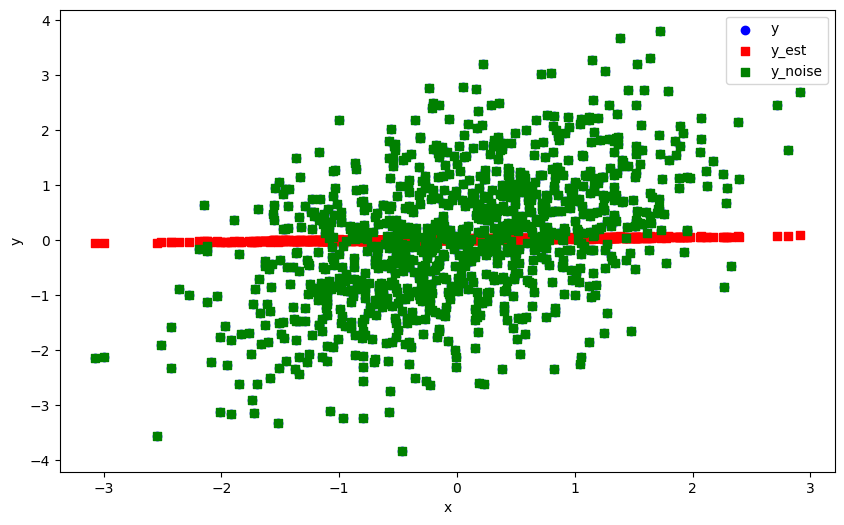

The programm is closed


In [20]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

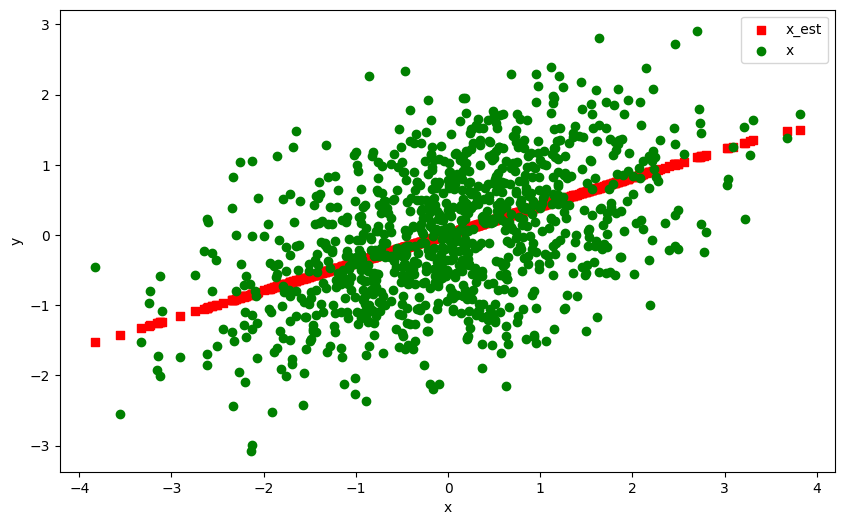

The programm is closed


In [21]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

### freeze MLP parameters

In [7]:
# eq_model = nonlinear.DagmaMLP(
#     dims=[d, 10, 1], bias=True, dtype=torch.double)
# model = nonlinear.DagmaNonlinear(
#     eq_model, dtype=torch.double, use_mse_loss=True)

# W_est_dagma = model.fit(X, lambda1=2e-2, lambda2=0.005,
#                         T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# # Use DAGMA weights as initial weights for DAGMA-DCE
# fc1_weight = eq_model.fc1.weight
# fc1_bias = eq_model.fc1.bias
# fc2_weight = eq_model.fc2[0].weight
# fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
# eq_model.fc1.weight = fc1_weight
# eq_model.fc1.bias = fc1_bias
# eq_model.fc2[0].weight = fc2_weight
# eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  1%|          | 164/29000 [00:00<01:08, 421.90it/s]

Sigma:  tensor([[0.9609, 0.0195],
        [0.0195, 1.0409]], grad_fn=<MmBackward0>)
obj:  tensor(2.4352, grad_fn=<AddBackward0>)
mle loss:  tensor(2.4338, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


  1%|          | 252/29000 [00:00<01:07, 427.09it/s]

Sigma:  tensor([[0.9239, 0.0380],
        [0.0380, 1.0825]], grad_fn=<MmBackward0>)
obj:  tensor(2.3343, grad_fn=<AddBackward0>)
mle loss:  tensor(2.3312, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


  1%|▏         | 385/29000 [00:00<01:06, 430.92it/s]

Sigma:  tensor([[0.8899, 0.0552],
        [0.0552, 1.1226]], grad_fn=<MmBackward0>)
obj:  tensor(2.2458, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2407, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


  1%|▏         | 429/29000 [00:01<01:06, 426.56it/s]

Sigma:  tensor([[0.8594, 0.0711],
        [0.0711, 1.1592]], grad_fn=<MmBackward0>)
obj:  tensor(2.1687, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1614, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)


  2%|▏         | 561/29000 [00:01<01:22, 344.89it/s]

Sigma:  tensor([[0.8326, 0.0858],
        [0.0858, 1.1904]], grad_fn=<MmBackward0>)
obj:  tensor(2.1012, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0913, grad_fn=<AddBackward0>)
h_val:  tensor(0.0039, grad_fn=<AddBackward0>)


  2%|▏         | 646/29000 [00:01<01:14, 382.50it/s]

Sigma:  tensor([[0.8093, 0.0992],
        [0.0992, 1.2150]], grad_fn=<MmBackward0>)
obj:  tensor(2.0413, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0288, grad_fn=<AddBackward0>)
h_val:  tensor(0.0054, grad_fn=<AddBackward0>)


  3%|▎         | 783/29000 [00:02<01:07, 420.90it/s]

Sigma:  tensor([[0.7887, 0.1116],
        [0.1116, 1.2319]], grad_fn=<MmBackward0>)
obj:  tensor(1.9873, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9720, grad_fn=<AddBackward0>)
h_val:  tensor(0.0073, grad_fn=<AddBackward0>)


  3%|▎         | 870/29000 [00:02<01:08, 412.16it/s]

Sigma:  tensor([[0.7700, 0.1229],
        [0.1229, 1.2410]], grad_fn=<MmBackward0>)
obj:  tensor(1.9378, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9194, grad_fn=<AddBackward0>)
h_val:  tensor(0.0093, grad_fn=<AddBackward0>)


  3%|▎         | 961/29000 [00:02<01:04, 431.47it/s]

Sigma:  tensor([[0.7526, 0.1332],
        [0.1332, 1.2425]], grad_fn=<MmBackward0>)
obj:  tensor(1.8916, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8701, grad_fn=<AddBackward0>)
h_val:  tensor(0.0115, grad_fn=<AddBackward0>)


  4%|▎         | 1050/29000 [00:02<01:04, 430.36it/s]

Sigma:  tensor([[0.7363, 0.1426],
        [0.1426, 1.2372]], grad_fn=<MmBackward0>)
obj:  tensor(1.8480, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8232, grad_fn=<AddBackward0>)
h_val:  tensor(0.0139, grad_fn=<AddBackward0>)


  4%|▍         | 1183/29000 [00:02<01:04, 430.97it/s]

Sigma:  tensor([[0.7211, 0.1511],
        [0.1511, 1.2261]], grad_fn=<MmBackward0>)
obj:  tensor(1.8065, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7782, grad_fn=<AddBackward0>)
h_val:  tensor(0.0165, grad_fn=<AddBackward0>)


  4%|▍         | 1270/29000 [00:03<01:04, 426.99it/s]

Sigma:  tensor([[0.7069, 0.1589],
        [0.1589, 1.2106]], grad_fn=<MmBackward0>)
obj:  tensor(1.7668, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7348, grad_fn=<AddBackward0>)
h_val:  tensor(0.0193, grad_fn=<AddBackward0>)


  5%|▍         | 1359/29000 [00:03<01:03, 436.92it/s]

Sigma:  tensor([[0.6938, 0.1658],
        [0.1658, 1.1919]], grad_fn=<MmBackward0>)
obj:  tensor(1.7286, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6929, grad_fn=<AddBackward0>)
h_val:  tensor(0.0222, grad_fn=<AddBackward0>)


  5%|▍         | 1449/29000 [00:03<01:02, 438.90it/s]

Sigma:  tensor([[0.6815, 0.1719],
        [0.1719, 1.1711]], grad_fn=<MmBackward0>)
obj:  tensor(1.6920, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6524, grad_fn=<AddBackward0>)
h_val:  tensor(0.0253, grad_fn=<AddBackward0>)


  5%|▌         | 1581/29000 [00:03<01:03, 428.48it/s]

Sigma:  tensor([[0.6701, 0.1772],
        [0.1772, 1.1491]], grad_fn=<MmBackward0>)
obj:  tensor(1.6567, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6132, grad_fn=<AddBackward0>)
h_val:  tensor(0.0286, grad_fn=<AddBackward0>)


  6%|▌         | 1667/29000 [00:04<01:04, 424.62it/s]

Sigma:  tensor([[0.6594, 0.1818],
        [0.1818, 1.1266]], grad_fn=<MmBackward0>)
obj:  tensor(1.6228, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5752, grad_fn=<AddBackward0>)
h_val:  tensor(0.0320, grad_fn=<AddBackward0>)


  6%|▌         | 1755/29000 [00:04<01:03, 431.38it/s]

Sigma:  tensor([[0.6493, 0.1855],
        [0.1855, 1.1040]], grad_fn=<MmBackward0>)
obj:  tensor(1.5902, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5383, grad_fn=<AddBackward0>)
h_val:  tensor(0.0356, grad_fn=<AddBackward0>)


  6%|▋         | 1846/29000 [00:04<01:01, 440.73it/s]

Sigma:  tensor([[0.6397, 0.1883],
        [0.1883, 1.0817]], grad_fn=<MmBackward0>)
obj:  tensor(1.5586, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5025, grad_fn=<AddBackward0>)
h_val:  tensor(0.0393, grad_fn=<AddBackward0>)


  7%|▋         | 1982/29000 [00:04<01:01, 442.52it/s]

Sigma:  tensor([[0.6306, 0.1903],
        [0.1903, 1.0599]], grad_fn=<MmBackward0>)
obj:  tensor(1.5281, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4675, grad_fn=<AddBackward0>)
h_val:  tensor(0.0432, grad_fn=<AddBackward0>)


  7%|▋         | 2072/29000 [00:04<01:00, 442.25it/s]

Sigma:  tensor([[0.6218, 0.1915],
        [0.1915, 1.0386]], grad_fn=<MmBackward0>)
obj:  tensor(1.4985, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4333, grad_fn=<AddBackward0>)
h_val:  tensor(0.0472, grad_fn=<AddBackward0>)


  7%|▋         | 2164/29000 [00:05<01:00, 445.52it/s]

Sigma:  tensor([[0.6132, 0.1920],
        [0.1920, 1.0179]], grad_fn=<MmBackward0>)
obj:  tensor(1.4697, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3999, grad_fn=<AddBackward0>)
h_val:  tensor(0.0513, grad_fn=<AddBackward0>)


  8%|▊         | 2255/29000 [00:05<01:01, 434.10it/s]

Sigma:  tensor([[0.6049, 0.1917],
        [0.1917, 0.9977]], grad_fn=<MmBackward0>)
obj:  tensor(1.4415, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0556, grad_fn=<AddBackward0>)


  8%|▊         | 2386/29000 [00:05<01:02, 426.98it/s]

Sigma:  tensor([[0.5967, 0.1907],
        [0.1907, 0.9780]], grad_fn=<MmBackward0>)
obj:  tensor(1.4140, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3346, grad_fn=<AddBackward0>)
h_val:  tensor(0.0600, grad_fn=<AddBackward0>)


  8%|▊         | 2429/29000 [00:05<01:03, 415.31it/s]

Sigma:  tensor([[0.5886, 0.1892],
        [0.1892, 0.9588]], grad_fn=<MmBackward0>)
obj:  tensor(1.3870, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3026, grad_fn=<AddBackward0>)
h_val:  tensor(0.0646, grad_fn=<AddBackward0>)


  9%|▉         | 2556/29000 [00:06<01:06, 395.38it/s]

Sigma:  tensor([[0.5806, 0.1873],
        [0.1873, 0.9401]], grad_fn=<MmBackward0>)
obj:  tensor(1.3605, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2711, grad_fn=<AddBackward0>)
h_val:  tensor(0.0692, grad_fn=<AddBackward0>)


  9%|▉         | 2644/29000 [00:06<01:04, 411.35it/s]

Sigma:  tensor([[0.5728, 0.1850],
        [0.1850, 0.9218]], grad_fn=<MmBackward0>)
obj:  tensor(1.3344, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2399, grad_fn=<AddBackward0>)
h_val:  tensor(0.0741, grad_fn=<AddBackward0>)


 10%|▉         | 2781/29000 [00:06<00:59, 439.56it/s]

Sigma:  tensor([[0.5651, 0.1826],
        [0.1826, 0.9039]], grad_fn=<MmBackward0>)
obj:  tensor(1.3088, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2090, grad_fn=<AddBackward0>)
h_val:  tensor(0.0790, grad_fn=<AddBackward0>)


 10%|▉         | 2877/29000 [00:06<01:02, 417.45it/s]

Sigma:  tensor([[0.5575, 0.1800],
        [0.1800, 0.8866]], grad_fn=<MmBackward0>)
obj:  tensor(1.2837, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1784, grad_fn=<AddBackward0>)
h_val:  tensor(0.0841, grad_fn=<AddBackward0>)


 10%|█         | 2960/29000 [00:07<01:07, 387.60it/s]

Sigma:  tensor([[0.5501, 0.1776],
        [0.1776, 0.8697]], grad_fn=<MmBackward0>)
obj:  tensor(1.2590, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1482, grad_fn=<AddBackward0>)
h_val:  tensor(0.0893, grad_fn=<AddBackward0>)


 10%|█         | 3044/29000 [00:07<01:04, 400.95it/s]

Sigma:  tensor([[0.5428, 0.1753],
        [0.1753, 0.8534]], grad_fn=<MmBackward0>)
obj:  tensor(1.2347, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1183, grad_fn=<AddBackward0>)
h_val:  tensor(0.0947, grad_fn=<AddBackward0>)


 11%|█         | 3183/29000 [00:07<01:00, 426.79it/s]

Sigma:  tensor([[0.5358, 0.1733],
        [0.1733, 0.8377]], grad_fn=<MmBackward0>)
obj:  tensor(1.2108, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0887, grad_fn=<AddBackward0>)
h_val:  tensor(0.1002, grad_fn=<AddBackward0>)


 11%|█▏        | 3271/29000 [00:07<01:00, 427.83it/s]

Sigma:  tensor([[0.5289, 0.1717],
        [0.1717, 0.8226]], grad_fn=<MmBackward0>)
obj:  tensor(1.1873, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0593, grad_fn=<AddBackward0>)
h_val:  tensor(0.1058, grad_fn=<AddBackward0>)


 12%|█▏        | 3357/29000 [00:08<01:00, 421.42it/s]

Sigma:  tensor([[0.5223, 0.1705],
        [0.1705, 0.8082]], grad_fn=<MmBackward0>)
obj:  tensor(1.1642, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0303, grad_fn=<AddBackward0>)
h_val:  tensor(0.1115, grad_fn=<AddBackward0>)


 12%|█▏        | 3490/29000 [00:08<00:58, 435.68it/s]

Sigma:  tensor([[0.5159, 0.1697],
        [0.1697, 0.7944]], grad_fn=<MmBackward0>)
obj:  tensor(1.1415, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0015, grad_fn=<AddBackward0>)
h_val:  tensor(0.1174, grad_fn=<AddBackward0>)


 12%|█▏        | 3581/29000 [00:08<00:57, 445.65it/s]

Sigma:  tensor([[0.5097, 0.1695],
        [0.1695, 0.7814]], grad_fn=<MmBackward0>)
obj:  tensor(1.1192, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9729, grad_fn=<AddBackward0>)
h_val:  tensor(0.1234, grad_fn=<AddBackward0>)


 13%|█▎        | 3673/29000 [00:08<00:56, 451.74it/s]

Sigma:  tensor([[0.5037, 0.1698],
        [0.1698, 0.7689]], grad_fn=<MmBackward0>)
obj:  tensor(1.0971, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9446, grad_fn=<AddBackward0>)
h_val:  tensor(0.1296, grad_fn=<AddBackward0>)


 13%|█▎        | 3765/29000 [00:09<00:55, 451.22it/s]

Sigma:  tensor([[0.4979, 0.1707],
        [0.1707, 0.7572]], grad_fn=<MmBackward0>)
obj:  tensor(1.0754, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9163, grad_fn=<AddBackward0>)
h_val:  tensor(0.1359, grad_fn=<AddBackward0>)


 13%|█▎        | 3860/29000 [00:09<00:54, 459.58it/s]

Sigma:  tensor([[0.4924, 0.1722],
        [0.1722, 0.7460]], grad_fn=<MmBackward0>)
obj:  tensor(1.0539, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8883, grad_fn=<AddBackward0>)
h_val:  tensor(0.1424, grad_fn=<AddBackward0>)


 14%|█▎        | 3953/29000 [00:09<00:54, 459.10it/s]

Sigma:  tensor([[0.4871, 0.1744],
        [0.1744, 0.7356]], grad_fn=<MmBackward0>)
obj:  tensor(1.0326, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8602, grad_fn=<AddBackward0>)
h_val:  tensor(0.1490, grad_fn=<AddBackward0>)


 14%|█▍        | 4049/29000 [00:09<00:54, 459.03it/s]

Sigma:  tensor([[0.4820, 0.1772],
        [0.1772, 0.7257]], grad_fn=<MmBackward0>)
obj:  tensor(1.0114, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8322, grad_fn=<AddBackward0>)
h_val:  tensor(0.1557, grad_fn=<AddBackward0>)


 14%|█▍        | 4192/29000 [00:09<00:53, 462.60it/s]

Sigma:  tensor([[0.4771, 0.1807],
        [0.1807, 0.7165]], grad_fn=<MmBackward0>)
obj:  tensor(0.9903, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8042, grad_fn=<AddBackward0>)
h_val:  tensor(0.1627, grad_fn=<AddBackward0>)


 15%|█▍        | 4285/29000 [00:10<00:54, 456.22it/s]

Sigma:  tensor([[0.4726, 0.1849],
        [0.1849, 0.7079]], grad_fn=<MmBackward0>)
obj:  tensor(0.9692, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7760, grad_fn=<AddBackward0>)
h_val:  tensor(0.1698, grad_fn=<AddBackward0>)


 15%|█▌        | 4377/29000 [00:10<00:54, 448.46it/s]

Sigma:  tensor([[0.4682, 0.1899],
        [0.1899, 0.6999]], grad_fn=<MmBackward0>)
obj:  tensor(0.9481, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7476, grad_fn=<AddBackward0>)
h_val:  tensor(0.1771, grad_fn=<AddBackward0>)


 15%|█▌        | 4467/29000 [00:10<00:55, 440.98it/s]

Sigma:  tensor([[0.4642, 0.1956],
        [0.1956, 0.6925]], grad_fn=<MmBackward0>)
obj:  tensor(0.9269, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7189, grad_fn=<AddBackward0>)
h_val:  tensor(0.1846, grad_fn=<AddBackward0>)


 16%|█▌        | 4561/29000 [00:10<00:54, 452.27it/s]

Sigma:  tensor([[0.4605, 0.2021],
        [0.2021, 0.6858]], grad_fn=<MmBackward0>)
obj:  tensor(0.9054, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6899, grad_fn=<AddBackward0>)
h_val:  tensor(0.1923, grad_fn=<AddBackward0>)


 16%|█▌        | 4655/29000 [00:10<00:52, 459.38it/s]

Sigma:  tensor([[0.4571, 0.2093],
        [0.2093, 0.6796]], grad_fn=<MmBackward0>)
obj:  tensor(0.8837, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6604, grad_fn=<AddBackward0>)
h_val:  tensor(0.2001, grad_fn=<AddBackward0>)


 16%|█▋        | 4749/29000 [00:11<00:53, 456.72it/s]

Sigma:  tensor([[0.4541, 0.2173],
        [0.2173, 0.6741]], grad_fn=<MmBackward0>)
obj:  tensor(0.8615, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6304, grad_fn=<AddBackward0>)
h_val:  tensor(0.2082, grad_fn=<AddBackward0>)


 17%|█▋        | 4891/29000 [00:11<00:51, 465.77it/s]

Sigma:  tensor([[0.4514, 0.2260],
        [0.2260, 0.6692]], grad_fn=<MmBackward0>)
obj:  tensor(0.8390, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5998, grad_fn=<AddBackward0>)
h_val:  tensor(0.2164, grad_fn=<AddBackward0>)


 17%|█▋        | 4985/29000 [00:11<00:52, 460.68it/s]

Sigma:  tensor([[0.4492, 0.2353],
        [0.2353, 0.6650]], grad_fn=<MmBackward0>)
obj:  tensor(0.8163, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5686, grad_fn=<AddBackward0>)
h_val:  tensor(0.2248, grad_fn=<AddBackward0>)


 18%|█▊        | 5080/29000 [00:11<00:51, 462.93it/s]

Sigma:  tensor([[0.4476, 0.2452],
        [0.2452, 0.6612]], grad_fn=<MmBackward0>)
obj:  tensor(0.7938, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5371, grad_fn=<AddBackward0>)
h_val:  tensor(0.2333, grad_fn=<AddBackward0>)


 18%|█▊        | 5173/29000 [00:12<00:53, 441.67it/s]

Sigma:  tensor([[0.4465, 0.2553],
        [0.2553, 0.6578]], grad_fn=<MmBackward0>)
obj:  tensor(0.7709, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5052, grad_fn=<AddBackward0>)
h_val:  tensor(0.2420, grad_fn=<AddBackward0>)


 18%|█▊        | 5264/29000 [00:12<00:54, 437.74it/s]

Sigma:  tensor([[0.4455, 0.2653],
        [0.2653, 0.6546]], grad_fn=<MmBackward0>)
obj:  tensor(0.7478, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4726, grad_fn=<AddBackward0>)
h_val:  tensor(0.2508, grad_fn=<AddBackward0>)


 18%|█▊        | 5354/29000 [00:12<00:54, 436.40it/s]

Sigma:  tensor([[0.4445, 0.2754],
        [0.2754, 0.6519]], grad_fn=<MmBackward0>)
obj:  tensor(0.7247, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4397, grad_fn=<AddBackward0>)
h_val:  tensor(0.2597, grad_fn=<AddBackward0>)


 19%|█▉        | 5492/29000 [00:12<00:51, 452.11it/s]

Sigma:  tensor([[0.4437, 0.2854],
        [0.2854, 0.6498]], grad_fn=<MmBackward0>)
obj:  tensor(0.7012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4061, grad_fn=<AddBackward0>)
h_val:  tensor(0.2687, grad_fn=<AddBackward0>)


 19%|█▉        | 5584/29000 [00:13<00:52, 449.04it/s]

Sigma:  tensor([[0.4431, 0.2956],
        [0.2956, 0.6484]], grad_fn=<MmBackward0>)
obj:  tensor(0.6771, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3718, grad_fn=<AddBackward0>)
h_val:  tensor(0.2779, grad_fn=<AddBackward0>)


 20%|█▉        | 5673/29000 [00:13<00:55, 419.97it/s]

Sigma:  tensor([[0.4429, 0.3061],
        [0.3061, 0.6475]], grad_fn=<MmBackward0>)
obj:  tensor(0.6525, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3368, grad_fn=<AddBackward0>)
h_val:  tensor(0.2872, grad_fn=<AddBackward0>)


 20%|█▉        | 5757/29000 [00:13<00:57, 404.01it/s]

Sigma:  tensor([[0.4431, 0.3167],
        [0.3167, 0.6471]], grad_fn=<MmBackward0>)
obj:  tensor(0.6273, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3011, grad_fn=<AddBackward0>)
h_val:  tensor(0.2967, grad_fn=<AddBackward0>)


 20%|██        | 5877/29000 [00:13<00:59, 387.56it/s]

Sigma:  tensor([[0.4437, 0.3275],
        [0.3275, 0.6471]], grad_fn=<MmBackward0>)
obj:  tensor(0.6016, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2648, grad_fn=<AddBackward0>)
h_val:  tensor(0.3064, grad_fn=<AddBackward0>)


 21%|██        | 5949/29000 [00:14<01:30, 255.06it/s]

Sigma:  tensor([[0.4447, 0.3383],
        [0.3383, 0.6474]], grad_fn=<MmBackward0>)
obj:  tensor(0.5754, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2279, grad_fn=<AddBackward0>)
h_val:  tensor(0.3161, grad_fn=<AddBackward0>)


 21%|██        | 6086/29000 [00:14<01:01, 370.20it/s]

Sigma:  tensor([[0.4459, 0.3491],
        [0.3491, 0.6481]], grad_fn=<MmBackward0>)
obj:  tensor(0.5489, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1905, grad_fn=<AddBackward0>)
h_val:  tensor(0.3260, grad_fn=<AddBackward0>)


 21%|██▏       | 6177/29000 [00:14<00:55, 407.96it/s]

Sigma:  tensor([[0.4473, 0.3597],
        [0.3597, 0.6490]], grad_fn=<MmBackward0>)
obj:  tensor(0.5220, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1526, grad_fn=<AddBackward0>)
h_val:  tensor(0.3359, grad_fn=<AddBackward0>)


 22%|██▏       | 6266/29000 [00:14<00:53, 423.93it/s]

Sigma:  tensor([[0.4488, 0.3700],
        [0.3700, 0.6501]], grad_fn=<MmBackward0>)
obj:  tensor(0.4948, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1144, grad_fn=<AddBackward0>)
h_val:  tensor(0.3460, grad_fn=<AddBackward0>)


 22%|██▏       | 6357/29000 [00:15<00:51, 437.52it/s]

Sigma:  tensor([[0.4505, 0.3800],
        [0.3800, 0.6513]], grad_fn=<MmBackward0>)
obj:  tensor(0.4675, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0759, grad_fn=<AddBackward0>)
h_val:  tensor(0.3562, grad_fn=<AddBackward0>)


 22%|██▏       | 6448/29000 [00:15<00:50, 442.91it/s]

Sigma:  tensor([[0.4522, 0.3897],
        [0.3897, 0.6526]], grad_fn=<MmBackward0>)
obj:  tensor(0.4400, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0372, grad_fn=<AddBackward0>)
h_val:  tensor(0.3665, grad_fn=<AddBackward0>)


 23%|██▎       | 6589/29000 [00:15<00:49, 457.20it/s]

Sigma:  tensor([[0.4539, 0.3990],
        [0.3990, 0.6540]], grad_fn=<MmBackward0>)
obj:  tensor(0.4125, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0015, grad_fn=<AddBackward0>)
h_val:  tensor(0.3768, grad_fn=<AddBackward0>)


 23%|██▎       | 6681/29000 [00:15<00:49, 454.23it/s]

Sigma:  tensor([[0.4557, 0.4078],
        [0.4078, 0.6554]], grad_fn=<MmBackward0>)
obj:  tensor(0.3850, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0403, grad_fn=<AddBackward0>)
h_val:  tensor(0.3873, grad_fn=<AddBackward0>)


 23%|██▎       | 6772/29000 [00:16<00:51, 428.85it/s]

Sigma:  tensor([[0.4573, 0.4163],
        [0.4163, 0.6568]], grad_fn=<MmBackward0>)
obj:  tensor(0.3577, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0790, grad_fn=<AddBackward0>)
h_val:  tensor(0.3978, grad_fn=<AddBackward0>)


 24%|██▎       | 6862/29000 [00:16<00:51, 431.83it/s]

Sigma:  tensor([[0.4589, 0.4242],
        [0.4242, 0.6582]], grad_fn=<MmBackward0>)
obj:  tensor(0.3306, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1175, grad_fn=<AddBackward0>)
h_val:  tensor(0.4083, grad_fn=<AddBackward0>)


 24%|██▍       | 6955/29000 [00:16<00:49, 445.56it/s]

Sigma:  tensor([[0.4604, 0.4318],
        [0.4318, 0.6595]], grad_fn=<MmBackward0>)
obj:  tensor(0.3037, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1557, grad_fn=<AddBackward0>)
h_val:  tensor(0.4189, grad_fn=<AddBackward0>)


 25%|██▍       | 7132/29000 [00:16<01:00, 361.12it/s]

Sigma:  tensor([[0.4457, 0.4199],
        [0.4199, 0.6339]], grad_fn=<MmBackward0>)
obj:  tensor(0.4049, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1694, grad_fn=<AddBackward0>)
h_val:  tensor(0.4177, grad_fn=<AddBackward0>)


 25%|██▌       | 7260/29000 [00:17<00:53, 405.70it/s]

Sigma:  tensor([[0.4302, 0.4005],
        [0.4005, 0.6085]], grad_fn=<MmBackward0>)
obj:  tensor(0.3947, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1303, grad_fn=<AddBackward0>)
h_val:  tensor(0.4037, grad_fn=<AddBackward0>)


 25%|██▌       | 7345/29000 [00:17<00:53, 407.20it/s]

Sigma:  tensor([[0.4191, 0.3848],
        [0.3848, 0.5926]], grad_fn=<MmBackward0>)
obj:  tensor(0.3853, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0873, grad_fn=<AddBackward0>)
h_val:  tensor(0.3900, grad_fn=<AddBackward0>)


 26%|██▌       | 7484/29000 [00:17<00:49, 432.11it/s]

Sigma:  tensor([[0.4140, 0.3748],
        [0.3748, 0.5861]], grad_fn=<MmBackward0>)
obj:  tensor(0.3765, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0447, grad_fn=<AddBackward0>)
h_val:  tensor(0.3771, grad_fn=<AddBackward0>)


 26%|██▌       | 7575/29000 [00:17<00:48, 441.77it/s]

Sigma:  tensor([[0.4145, 0.3708],
        [0.3708, 0.5875]], grad_fn=<MmBackward0>)
obj:  tensor(0.3682, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0045, grad_fn=<AddBackward0>)
h_val:  tensor(0.3647, grad_fn=<AddBackward0>)


 26%|██▋       | 7665/29000 [00:18<00:49, 433.05it/s]

Sigma:  tensor([[0.4182, 0.3717],
        [0.3717, 0.5953]], grad_fn=<MmBackward0>)
obj:  tensor(0.3601, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0330, grad_fn=<AddBackward0>)
h_val:  tensor(0.3529, grad_fn=<AddBackward0>)


 27%|██▋       | 7751/29000 [00:18<00:52, 406.75it/s]

Sigma:  tensor([[0.4234, 0.3750],
        [0.3750, 0.6063]], grad_fn=<MmBackward0>)
obj:  tensor(0.3522, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0688, grad_fn=<AddBackward0>)
h_val:  tensor(0.3415, grad_fn=<AddBackward0>)


 27%|██▋       | 7889/29000 [00:18<00:47, 442.24it/s]

Sigma:  tensor([[0.4289, 0.3788],
        [0.3788, 0.6180]], grad_fn=<MmBackward0>)
obj:  tensor(0.3445, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1045, grad_fn=<AddBackward0>)
h_val:  tensor(0.3304, grad_fn=<AddBackward0>)


 28%|██▊       | 7980/29000 [00:18<00:47, 445.83it/s]

Sigma:  tensor([[0.4341, 0.3816],
        [0.3816, 0.6291]], grad_fn=<MmBackward0>)
obj:  tensor(0.3371, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1405, grad_fn=<AddBackward0>)
h_val:  tensor(0.3194, grad_fn=<AddBackward0>)


 28%|██▊       | 8072/29000 [00:19<00:46, 446.54it/s]

Sigma:  tensor([[0.4386, 0.3834],
        [0.3834, 0.6394]], grad_fn=<MmBackward0>)
obj:  tensor(0.3298, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1773, grad_fn=<AddBackward0>)
h_val:  tensor(0.3085, grad_fn=<AddBackward0>)


 28%|██▊       | 8163/29000 [00:19<00:47, 438.96it/s]

Sigma:  tensor([[0.4426, 0.3844],
        [0.3844, 0.6495]], grad_fn=<MmBackward0>)
obj:  tensor(0.3227, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2145, grad_fn=<AddBackward0>)
h_val:  tensor(0.2978, grad_fn=<AddBackward0>)


 28%|██▊       | 8253/29000 [00:19<00:47, 439.93it/s]

Sigma:  tensor([[0.4467, 0.3852],
        [0.3852, 0.6599]], grad_fn=<MmBackward0>)
obj:  tensor(0.3159, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2521, grad_fn=<AddBackward0>)
h_val:  tensor(0.2872, grad_fn=<AddBackward0>)


 29%|██▉       | 8344/29000 [00:19<00:46, 440.47it/s]

Sigma:  tensor([[0.4509, 0.3860],
        [0.3860, 0.6707]], grad_fn=<MmBackward0>)
obj:  tensor(0.3092, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2899, grad_fn=<AddBackward0>)
h_val:  tensor(0.2768, grad_fn=<AddBackward0>)


 29%|██▉       | 8481/29000 [00:20<00:45, 446.96it/s]

Sigma:  tensor([[0.4553, 0.3869],
        [0.3869, 0.6822]], grad_fn=<MmBackward0>)
obj:  tensor(0.3027, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3278, grad_fn=<AddBackward0>)
h_val:  tensor(0.2666, grad_fn=<AddBackward0>)


 30%|██▉       | 8571/29000 [00:20<00:46, 442.23it/s]

Sigma:  tensor([[0.4597, 0.3878],
        [0.3878, 0.6942]], grad_fn=<MmBackward0>)
obj:  tensor(0.2964, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3659, grad_fn=<AddBackward0>)
h_val:  tensor(0.2566, grad_fn=<AddBackward0>)


 30%|██▉       | 8661/29000 [00:20<00:46, 439.63it/s]

Sigma:  tensor([[0.4642, 0.3885],
        [0.3885, 0.7065]], grad_fn=<MmBackward0>)
obj:  tensor(0.2903, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4040, grad_fn=<AddBackward0>)
h_val:  tensor(0.2467, grad_fn=<AddBackward0>)


 30%|███       | 8751/29000 [00:20<00:45, 440.63it/s]

Sigma:  tensor([[0.4688, 0.3890],
        [0.3890, 0.7190]], grad_fn=<MmBackward0>)
obj:  tensor(0.2844, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4421, grad_fn=<AddBackward0>)
h_val:  tensor(0.2371, grad_fn=<AddBackward0>)


 31%|███       | 8846/29000 [00:20<00:44, 448.18it/s]

Sigma:  tensor([[0.4734, 0.3894],
        [0.3894, 0.7318]], grad_fn=<MmBackward0>)
obj:  tensor(0.2787, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4800, grad_fn=<AddBackward0>)
h_val:  tensor(0.2277, grad_fn=<AddBackward0>)


 31%|███       | 8987/29000 [00:21<00:44, 453.71it/s]

Sigma:  tensor([[0.4780, 0.3895],
        [0.3895, 0.7447]], grad_fn=<MmBackward0>)
obj:  tensor(0.2732, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5179, grad_fn=<AddBackward0>)
h_val:  tensor(0.2185, grad_fn=<AddBackward0>)


 31%|███▏      | 9079/29000 [00:21<00:44, 451.11it/s]

Sigma:  tensor([[0.4827, 0.3896],
        [0.3896, 0.7578]], grad_fn=<MmBackward0>)
obj:  tensor(0.2678, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5555, grad_fn=<AddBackward0>)
h_val:  tensor(0.2094, grad_fn=<AddBackward0>)


 32%|███▏      | 9172/29000 [00:21<00:43, 454.08it/s]

Sigma:  tensor([[0.4875, 0.3895],
        [0.3895, 0.7711]], grad_fn=<MmBackward0>)
obj:  tensor(0.2627, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5928, grad_fn=<AddBackward0>)
h_val:  tensor(0.2007, grad_fn=<AddBackward0>)


 32%|███▏      | 9264/29000 [00:21<00:43, 450.08it/s]

Sigma:  tensor([[0.4922, 0.3892],
        [0.3892, 0.7843]], grad_fn=<MmBackward0>)
obj:  tensor(0.2578, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6299, grad_fn=<AddBackward0>)
h_val:  tensor(0.1921, grad_fn=<AddBackward0>)


 32%|███▏      | 9355/29000 [00:22<00:44, 437.15it/s]

Sigma:  tensor([[0.4971, 0.3888],
        [0.3888, 0.7975]], grad_fn=<MmBackward0>)
obj:  tensor(0.2530, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6665, grad_fn=<AddBackward0>)
h_val:  tensor(0.1838, grad_fn=<AddBackward0>)


 33%|███▎      | 9445/29000 [00:22<00:44, 441.00it/s]

Sigma:  tensor([[0.5020, 0.3882],
        [0.3882, 0.8107]], grad_fn=<MmBackward0>)
obj:  tensor(0.2484, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7027, grad_fn=<AddBackward0>)
h_val:  tensor(0.1757, grad_fn=<AddBackward0>)


 33%|███▎      | 9583/29000 [00:22<00:43, 449.79it/s]

Sigma:  tensor([[0.5069, 0.3874],
        [0.3874, 0.8237]], grad_fn=<MmBackward0>)
obj:  tensor(0.2441, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7383, grad_fn=<AddBackward0>)
h_val:  tensor(0.1678, grad_fn=<AddBackward0>)


 33%|███▎      | 9674/29000 [00:22<00:43, 447.04it/s]

Sigma:  tensor([[0.5119, 0.3865],
        [0.3865, 0.8365]], grad_fn=<MmBackward0>)
obj:  tensor(0.2399, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7734, grad_fn=<AddBackward0>)
h_val:  tensor(0.1602, grad_fn=<AddBackward0>)


 34%|███▎      | 9765/29000 [00:22<00:43, 445.09it/s]

Sigma:  tensor([[0.5169, 0.3854],
        [0.3854, 0.8491]], grad_fn=<MmBackward0>)
obj:  tensor(0.2359, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8079, grad_fn=<AddBackward0>)
h_val:  tensor(0.1528, grad_fn=<AddBackward0>)


 34%|███▍      | 9857/29000 [00:23<00:42, 446.39it/s]

Sigma:  tensor([[0.5219, 0.3842],
        [0.3842, 0.8615]], grad_fn=<MmBackward0>)
obj:  tensor(0.2321, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8416, grad_fn=<AddBackward0>)
h_val:  tensor(0.1457, grad_fn=<AddBackward0>)


 34%|███▍      | 9949/29000 [00:23<00:42, 447.65it/s]

Sigma:  tensor([[0.5269, 0.3829],
        [0.3829, 0.8735]], grad_fn=<MmBackward0>)
obj:  tensor(0.2285, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8747, grad_fn=<AddBackward0>)
h_val:  tensor(0.1389, grad_fn=<AddBackward0>)


 35%|███▍      | 10091/29000 [00:23<00:41, 458.64it/s]

Sigma:  tensor([[0.5320, 0.3814],
        [0.3814, 0.8852]], grad_fn=<MmBackward0>)
obj:  tensor(0.2251, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9070, grad_fn=<AddBackward0>)
h_val:  tensor(0.1323, grad_fn=<AddBackward0>)


 35%|███▌      | 10183/29000 [00:23<00:41, 452.58it/s]

Sigma:  tensor([[0.5371, 0.3799],
        [0.3799, 0.8965]], grad_fn=<MmBackward0>)
obj:  tensor(0.2218, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9384, grad_fn=<AddBackward0>)
h_val:  tensor(0.1260, grad_fn=<AddBackward0>)


 35%|███▌      | 10274/29000 [00:24<00:41, 448.22it/s]

Sigma:  tensor([[0.5422, 0.3783],
        [0.3783, 0.9074]], grad_fn=<MmBackward0>)
obj:  tensor(0.2188, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9691, grad_fn=<AddBackward0>)
h_val:  tensor(0.1200, grad_fn=<AddBackward0>)


 36%|███▌      | 10366/29000 [00:24<00:41, 449.24it/s]

Sigma:  tensor([[0.5473, 0.3767],
        [0.3767, 0.9179]], grad_fn=<MmBackward0>)
obj:  tensor(0.2159, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9988, grad_fn=<AddBackward0>)
h_val:  tensor(0.1142, grad_fn=<AddBackward0>)


 36%|███▌      | 10457/29000 [00:24<00:42, 441.48it/s]

Sigma:  tensor([[0.5525, 0.3750],
        [0.3750, 0.9280]], grad_fn=<MmBackward0>)
obj:  tensor(0.2132, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0277, grad_fn=<AddBackward0>)
h_val:  tensor(0.1087, grad_fn=<AddBackward0>)


 36%|███▋      | 10548/29000 [00:24<00:41, 445.19it/s]

Sigma:  tensor([[0.5576, 0.3732],
        [0.3732, 0.9377]], grad_fn=<MmBackward0>)
obj:  tensor(0.2107, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0557, grad_fn=<AddBackward0>)
h_val:  tensor(0.1035, grad_fn=<AddBackward0>)


 37%|███▋      | 10690/29000 [00:24<00:39, 459.98it/s]

Sigma:  tensor([[0.5628, 0.3716],
        [0.3716, 0.9469]], grad_fn=<MmBackward0>)
obj:  tensor(0.2084, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0824, grad_fn=<AddBackward0>)
h_val:  tensor(0.0985, grad_fn=<AddBackward0>)


 37%|███▋      | 10784/29000 [00:25<00:40, 454.52it/s]

Sigma:  tensor([[0.5689, 0.3711],
        [0.3711, 0.9554]], grad_fn=<MmBackward0>)
obj:  tensor(0.2062, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1078, grad_fn=<AddBackward0>)
h_val:  tensor(0.0938, grad_fn=<AddBackward0>)


 38%|███▊      | 10878/29000 [00:25<00:39, 458.17it/s]

Sigma:  tensor([[0.5759, 0.3724],
        [0.3724, 0.9634]], grad_fn=<MmBackward0>)
obj:  tensor(0.2042, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1323, grad_fn=<AddBackward0>)
h_val:  tensor(0.0894, grad_fn=<AddBackward0>)


 38%|███▊      | 10971/29000 [00:25<00:39, 453.76it/s]

Sigma:  tensor([[0.5832, 0.3745],
        [0.3745, 0.9718]], grad_fn=<MmBackward0>)
obj:  tensor(0.2023, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1559, grad_fn=<AddBackward0>)
h_val:  tensor(0.0852, grad_fn=<AddBackward0>)


 38%|███▊      | 11017/29000 [00:25<00:40, 447.61it/s]

Sigma:  tensor([[0.5903, 0.3764],
        [0.3764, 0.9801]], grad_fn=<MmBackward0>)
obj:  tensor(0.2006, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1787, grad_fn=<AddBackward0>)
h_val:  tensor(0.0812, grad_fn=<AddBackward0>)


 38%|███▊      | 11155/29000 [00:26<00:49, 363.43it/s]

Sigma:  tensor([[0.5971, 0.3782],
        [0.3782, 0.9881]], grad_fn=<MmBackward0>)
obj:  tensor(0.1989, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2008, grad_fn=<AddBackward0>)
h_val:  tensor(0.0774, grad_fn=<AddBackward0>)


 39%|███▉      | 11247/29000 [00:26<00:44, 399.55it/s]

Sigma:  tensor([[0.6040, 0.3802],
        [0.3802, 0.9958]], grad_fn=<MmBackward0>)
obj:  tensor(0.1974, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2221, grad_fn=<AddBackward0>)
h_val:  tensor(0.0738, grad_fn=<AddBackward0>)


 39%|███▉      | 11381/29000 [00:26<00:41, 424.64it/s]

Sigma:  tensor([[0.6108, 0.3825],
        [0.3825, 1.0034]], grad_fn=<MmBackward0>)
obj:  tensor(0.1960, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2426, grad_fn=<AddBackward0>)
h_val:  tensor(0.0704, grad_fn=<AddBackward0>)


 40%|███▉      | 11470/29000 [00:26<00:40, 430.71it/s]

Sigma:  tensor([[0.6176, 0.3849],
        [0.3849, 1.0109]], grad_fn=<MmBackward0>)
obj:  tensor(0.1947, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2623, grad_fn=<AddBackward0>)
h_val:  tensor(0.0671, grad_fn=<AddBackward0>)


 40%|███▉      | 11559/29000 [00:27<00:40, 433.00it/s]

Sigma:  tensor([[0.6243, 0.3874],
        [0.3874, 1.0181]], grad_fn=<MmBackward0>)
obj:  tensor(0.1935, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2813, grad_fn=<AddBackward0>)
h_val:  tensor(0.0641, grad_fn=<AddBackward0>)


 40%|████      | 11651/29000 [00:27<00:39, 440.88it/s]

Sigma:  tensor([[0.6310, 0.3900],
        [0.3900, 1.0250]], grad_fn=<MmBackward0>)
obj:  tensor(0.1924, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2996, grad_fn=<AddBackward0>)
h_val:  tensor(0.0611, grad_fn=<AddBackward0>)


 41%|████      | 11792/29000 [00:27<00:37, 456.82it/s]

Sigma:  tensor([[0.6377, 0.3927],
        [0.3927, 1.0317]], grad_fn=<MmBackward0>)
obj:  tensor(0.1913, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3172, grad_fn=<AddBackward0>)
h_val:  tensor(0.0584, grad_fn=<AddBackward0>)


 41%|████      | 11884/29000 [00:27<00:37, 450.68it/s]

Sigma:  tensor([[0.6443, 0.3956],
        [0.3956, 1.0382]], grad_fn=<MmBackward0>)
obj:  tensor(0.1904, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3341, grad_fn=<AddBackward0>)
h_val:  tensor(0.0558, grad_fn=<AddBackward0>)


 41%|████▏     | 11976/29000 [00:28<00:37, 448.12it/s]

Sigma:  tensor([[0.6508, 0.3986],
        [0.3986, 1.0445]], grad_fn=<MmBackward0>)
obj:  tensor(0.1895, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3503, grad_fn=<AddBackward0>)
h_val:  tensor(0.0533, grad_fn=<AddBackward0>)


 42%|████▏     | 12066/29000 [00:28<00:38, 444.44it/s]

Sigma:  tensor([[0.6573, 0.4016],
        [0.4016, 1.0506]], grad_fn=<MmBackward0>)
obj:  tensor(0.1887, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3659, grad_fn=<AddBackward0>)
h_val:  tensor(0.0510, grad_fn=<AddBackward0>)


 42%|████▏     | 12157/29000 [00:28<00:37, 446.05it/s]

Sigma:  tensor([[0.6637, 0.4048],
        [0.4048, 1.0565]], grad_fn=<MmBackward0>)
obj:  tensor(0.1880, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3810, grad_fn=<AddBackward0>)
h_val:  tensor(0.0488, grad_fn=<AddBackward0>)


 42%|████▏     | 12247/29000 [00:28<00:37, 443.10it/s]

Sigma:  tensor([[0.6699, 0.4079],
        [0.4079, 1.0623]], grad_fn=<MmBackward0>)
obj:  tensor(0.1873, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3955, grad_fn=<AddBackward0>)
h_val:  tensor(0.0467, grad_fn=<AddBackward0>)


 43%|████▎     | 12389/29000 [00:28<00:36, 450.59it/s]

Sigma:  tensor([[0.6761, 0.4111],
        [0.4111, 1.0679]], grad_fn=<MmBackward0>)
obj:  tensor(0.1867, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4094, grad_fn=<AddBackward0>)
h_val:  tensor(0.0447, grad_fn=<AddBackward0>)


 43%|████▎     | 12481/29000 [00:29<00:36, 447.54it/s]

Sigma:  tensor([[0.6816, 0.4138],
        [0.4138, 1.0736]], grad_fn=<MmBackward0>)
obj:  tensor(0.1861, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4229, grad_fn=<AddBackward0>)
h_val:  tensor(0.0428, grad_fn=<AddBackward0>)


 43%|████▎     | 12571/29000 [00:29<00:37, 441.87it/s]

Sigma:  tensor([[0.6867, 0.4157],
        [0.4157, 1.0790]], grad_fn=<MmBackward0>)
obj:  tensor(0.1856, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4358, grad_fn=<AddBackward0>)
h_val:  tensor(0.0410, grad_fn=<AddBackward0>)


 44%|████▎     | 12663/29000 [00:29<00:36, 445.94it/s]

Sigma:  tensor([[0.6917, 0.4178],
        [0.4178, 1.0838]], grad_fn=<MmBackward0>)
obj:  tensor(0.1852, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4483, grad_fn=<AddBackward0>)
h_val:  tensor(0.0394, grad_fn=<AddBackward0>)


 44%|████▍     | 12753/29000 [00:29<00:36, 442.37it/s]

Sigma:  tensor([[0.6966, 0.4198],
        [0.4198, 1.0887]], grad_fn=<MmBackward0>)
obj:  tensor(0.1848, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4603, grad_fn=<AddBackward0>)
h_val:  tensor(0.0378, grad_fn=<AddBackward0>)


 44%|████▍     | 12842/29000 [00:30<00:38, 419.49it/s]

Sigma:  tensor([[0.7012, 0.4215],
        [0.4215, 1.0932]], grad_fn=<MmBackward0>)
obj:  tensor(0.1844, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4717, grad_fn=<AddBackward0>)
h_val:  tensor(0.0363, grad_fn=<AddBackward0>)


 45%|████▍     | 12978/29000 [00:30<00:36, 437.60it/s]

Sigma:  tensor([[0.7056, 0.4231],
        [0.4231, 1.0976]], grad_fn=<MmBackward0>)
obj:  tensor(0.1841, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4827, grad_fn=<AddBackward0>)
h_val:  tensor(0.0350, grad_fn=<AddBackward0>)


 45%|████▌     | 13066/29000 [00:30<00:37, 419.49it/s]

Sigma:  tensor([[0.7097, 0.4252],
        [0.4252, 1.1025]], grad_fn=<MmBackward0>)
obj:  tensor(0.1839, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4932, grad_fn=<AddBackward0>)
h_val:  tensor(0.0337, grad_fn=<AddBackward0>)


 45%|████▌     | 13150/29000 [00:30<00:40, 386.95it/s]

Sigma:  tensor([[0.7139, 0.4274],
        [0.4274, 1.1073]], grad_fn=<MmBackward0>)
obj:  tensor(0.1837, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5031, grad_fn=<AddBackward0>)
h_val:  tensor(0.0325, grad_fn=<AddBackward0>)


 46%|████▌     | 13269/29000 [00:31<00:40, 386.59it/s]

Sigma:  tensor([[0.7177, 0.4292],
        [0.4292, 1.1117]], grad_fn=<MmBackward0>)
obj:  tensor(0.1835, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5125, grad_fn=<AddBackward0>)
h_val:  tensor(0.0314, grad_fn=<AddBackward0>)


 46%|████▌     | 13347/29000 [00:31<00:40, 385.29it/s]

Sigma:  tensor([[0.7213, 0.4311],
        [0.4311, 1.1161]], grad_fn=<MmBackward0>)
obj:  tensor(0.1833, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5214, grad_fn=<AddBackward0>)
h_val:  tensor(0.0303, grad_fn=<AddBackward0>)


 46%|████▋     | 13469/29000 [00:31<00:39, 394.19it/s]

Sigma:  tensor([[0.7246, 0.4328],
        [0.4328, 1.1202]], grad_fn=<MmBackward0>)
obj:  tensor(0.1832, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5297, grad_fn=<AddBackward0>)
h_val:  tensor(0.0294, grad_fn=<AddBackward0>)


 47%|████▋     | 13548/29000 [00:31<00:40, 378.54it/s]

Sigma:  tensor([[0.7277, 0.4344],
        [0.4344, 1.1241]], grad_fn=<MmBackward0>)
obj:  tensor(0.1831, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5375, grad_fn=<AddBackward0>)
h_val:  tensor(0.0285, grad_fn=<AddBackward0>)


 47%|████▋     | 13662/29000 [00:32<00:41, 373.90it/s]

Sigma:  tensor([[0.7306, 0.4360],
        [0.4360, 1.1278]], grad_fn=<MmBackward0>)
obj:  tensor(0.1830, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5447, grad_fn=<AddBackward0>)
h_val:  tensor(0.0277, grad_fn=<AddBackward0>)


 48%|████▊     | 13779/29000 [00:32<00:39, 383.98it/s]

Sigma:  tensor([[0.7332, 0.4375],
        [0.4375, 1.1313]], grad_fn=<MmBackward0>)
obj:  tensor(0.1830, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5513, grad_fn=<AddBackward0>)
h_val:  tensor(0.0270, grad_fn=<AddBackward0>)


 48%|████▊     | 13857/29000 [00:32<00:39, 380.65it/s]

Sigma:  tensor([[0.7356, 0.4388],
        [0.4388, 1.1345]], grad_fn=<MmBackward0>)
obj:  tensor(0.1829, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5574, grad_fn=<AddBackward0>)
h_val:  tensor(0.0264, grad_fn=<AddBackward0>)


 48%|████▊     | 13976/29000 [00:32<00:39, 382.30it/s]

Sigma:  tensor([[0.7378, 0.4401],
        [0.4401, 1.1375]], grad_fn=<MmBackward0>)
obj:  tensor(0.1829, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5629, grad_fn=<AddBackward0>)
h_val:  tensor(0.0258, grad_fn=<AddBackward0>)


 49%|████▉     | 14183/29000 [00:33<00:36, 411.43it/s]

Sigma:  tensor([[0.7427, 0.4434],
        [0.4434, 1.1515]], grad_fn=<MmBackward0>)
obj:  tensor(0.0399, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5810, grad_fn=<AddBackward0>)
h_val:  tensor(0.0240, grad_fn=<AddBackward0>)


 49%|████▉     | 14266/29000 [00:33<00:37, 396.51it/s]

Sigma:  tensor([[0.7463, 0.4411],
        [0.4411, 1.1646]], grad_fn=<MmBackward0>)
obj:  tensor(0.0376, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6073, grad_fn=<AddBackward0>)
h_val:  tensor(0.0215, grad_fn=<AddBackward0>)


 49%|████▉     | 14345/29000 [00:33<00:38, 383.15it/s]

Sigma:  tensor([[0.7518, 0.4405],
        [0.4405, 1.1783]], grad_fn=<MmBackward0>)
obj:  tensor(0.0353, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6363, grad_fn=<AddBackward0>)
h_val:  tensor(0.0188, grad_fn=<AddBackward0>)


 50%|████▉     | 14467/29000 [00:34<00:37, 391.17it/s]

Sigma:  tensor([[0.7620, 0.4469],
        [0.4469, 1.1966]], grad_fn=<MmBackward0>)
obj:  tensor(0.0330, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6656, grad_fn=<AddBackward0>)
h_val:  tensor(0.0163, grad_fn=<AddBackward0>)


 50%|█████     | 14546/29000 [00:34<00:37, 380.68it/s]

Sigma:  tensor([[0.7748, 0.4577],
        [0.4577, 1.2178]], grad_fn=<MmBackward0>)
obj:  tensor(0.0310, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6945, grad_fn=<AddBackward0>)
h_val:  tensor(0.0140, grad_fn=<AddBackward0>)


 51%|█████     | 14666/29000 [00:34<00:36, 387.52it/s]

Sigma:  tensor([[0.7879, 0.4682],
        [0.4682, 1.2375]], grad_fn=<MmBackward0>)
obj:  tensor(0.0292, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7224, grad_fn=<AddBackward0>)
h_val:  tensor(0.0120, grad_fn=<AddBackward0>)


 51%|█████     | 14743/29000 [00:34<00:38, 372.16it/s]

Sigma:  tensor([[0.8003, 0.4777],
        [0.4777, 1.2556]], grad_fn=<MmBackward0>)
obj:  tensor(0.0277, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7491, grad_fn=<AddBackward0>)
h_val:  tensor(0.0101, grad_fn=<AddBackward0>)


 51%|█████▏    | 14866/29000 [00:35<00:36, 385.78it/s]

Sigma:  tensor([[0.8120, 0.4865],
        [0.4865, 1.2729]], grad_fn=<MmBackward0>)
obj:  tensor(0.0263, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7744, grad_fn=<AddBackward0>)
h_val:  tensor(0.0085, grad_fn=<AddBackward0>)


 52%|█████▏    | 14945/29000 [00:35<00:36, 388.83it/s]

Sigma:  tensor([[0.8226, 0.4938],
        [0.4938, 1.2888]], grad_fn=<MmBackward0>)
obj:  tensor(0.0252, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7983, grad_fn=<AddBackward0>)
h_val:  tensor(0.0072, grad_fn=<AddBackward0>)


 52%|█████▏    | 15071/29000 [00:35<00:34, 401.48it/s]

Sigma:  tensor([[0.8323, 0.4999],
        [0.4999, 1.3032]], grad_fn=<MmBackward0>)
obj:  tensor(0.0242, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8206, grad_fn=<AddBackward0>)
h_val:  tensor(0.0060, grad_fn=<AddBackward0>)


 52%|█████▏    | 15151/29000 [00:35<00:36, 384.14it/s]

Sigma:  tensor([[0.8412, 0.5055],
        [0.5055, 1.3168]], grad_fn=<MmBackward0>)
obj:  tensor(0.0234, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8413, grad_fn=<AddBackward0>)
h_val:  tensor(0.0050, grad_fn=<AddBackward0>)


 53%|█████▎    | 15269/29000 [00:36<00:35, 384.55it/s]

Sigma:  tensor([[0.8496, 0.5104],
        [0.5104, 1.3292]], grad_fn=<MmBackward0>)
obj:  tensor(0.0227, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8605, grad_fn=<AddBackward0>)
h_val:  tensor(0.0041, grad_fn=<AddBackward0>)


 53%|█████▎    | 15346/29000 [00:36<00:36, 373.76it/s]

Sigma:  tensor([[0.8575, 0.5150],
        [0.5150, 1.3406]], grad_fn=<MmBackward0>)
obj:  tensor(0.0222, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8782, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)


 53%|█████▎    | 15464/29000 [00:36<00:36, 372.60it/s]

Sigma:  tensor([[0.8649, 0.5193],
        [0.5193, 1.3510]], grad_fn=<MmBackward0>)
obj:  tensor(0.0217, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8944, grad_fn=<AddBackward0>)
h_val:  tensor(0.0028, grad_fn=<AddBackward0>)


 54%|█████▎    | 15539/29000 [00:37<00:38, 347.51it/s]

Sigma:  tensor([[0.8717, 0.5232],
        [0.5232, 1.3603]], grad_fn=<MmBackward0>)
obj:  tensor(0.0214, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9092, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)


 54%|█████▍    | 15646/29000 [00:37<00:38, 344.58it/s]

Sigma:  tensor([[0.8781, 0.5267],
        [0.5267, 1.3687]], grad_fn=<MmBackward0>)
obj:  tensor(0.0211, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9226, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 54%|█████▍    | 15753/29000 [00:37<00:38, 341.69it/s]

Sigma:  tensor([[0.8840, 0.5299],
        [0.5299, 1.3762]], grad_fn=<MmBackward0>)
obj:  tensor(0.0209, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9346, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)


 55%|█████▍    | 15861/29000 [00:37<00:37, 346.35it/s]

Sigma:  tensor([[0.8893, 0.5327],
        [0.5327, 1.3827]], grad_fn=<MmBackward0>)
obj:  tensor(0.0207, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9454, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 55%|█████▌    | 15970/29000 [00:38<00:36, 353.13it/s]

Sigma:  tensor([[0.8942, 0.5352],
        [0.5352, 1.3883]], grad_fn=<MmBackward0>)
obj:  tensor(0.0206, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9549, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 55%|█████▌    | 16042/29000 [00:38<00:36, 352.71it/s]

Sigma:  tensor([[0.8986, 0.5374],
        [0.5374, 1.3931]], grad_fn=<MmBackward0>)
obj:  tensor(0.0205, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9633, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 56%|█████▌    | 16159/29000 [00:38<00:35, 365.34it/s]

Sigma:  tensor([[0.9026, 0.5393],
        [0.5393, 1.3971]], grad_fn=<MmBackward0>)
obj:  tensor(0.0204, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9706, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 56%|█████▌    | 16286/29000 [00:39<00:31, 405.01it/s]

Sigma:  tensor([[0.9061, 0.5410],
        [0.5410, 1.4003]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9769, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 56%|█████▋    | 16369/29000 [00:39<00:31, 405.36it/s]

Sigma:  tensor([[0.9092, 0.5424],
        [0.5424, 1.4030]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9822, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 57%|█████▋    | 16410/29000 [00:39<00:30, 406.38it/s]

Sigma:  tensor([[0.9119, 0.5435],
        [0.5435, 1.4050]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9867, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 57%|█████▋    | 16565/29000 [00:40<00:38, 324.51it/s]

Sigma:  tensor([[0.9143, 0.5444],
        [0.5444, 1.4065]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9903, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 57%|█████▋    | 16640/29000 [00:40<00:36, 342.14it/s]

Sigma:  tensor([[0.9162, 0.5452],
        [0.5452, 1.4076]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9933, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16763/29000 [00:40<00:31, 386.61it/s]

Sigma:  tensor([[0.9178, 0.5457],
        [0.5457, 1.4084]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9956, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16847/29000 [00:40<00:30, 392.96it/s]

Sigma:  tensor([[0.9191, 0.5462],
        [0.5462, 1.4088]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9975, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 59%|█████▊    | 16984/29000 [00:41<00:28, 428.61it/s]

Sigma:  tensor([[0.9202, 0.5465],
        [0.5465, 1.4091]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9988, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 59%|█████▉    | 17072/29000 [00:41<00:27, 428.15it/s]

Sigma:  tensor([[0.9210, 0.5467],
        [0.5467, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9999, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 59%|█████▉    | 17158/29000 [00:41<00:28, 422.21it/s]

Sigma:  tensor([[0.9216, 0.5469],
        [0.5469, 1.4093]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0006, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 59%|█████▉    | 17245/29000 [00:41<00:27, 423.22it/s]

Sigma:  tensor([[0.9221, 0.5470],
        [0.5470, 1.4093]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0011, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 60%|█████▉    | 17384/29000 [00:41<00:26, 442.51it/s]

Sigma:  tensor([[0.9224, 0.5471],
        [0.5471, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0014, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 60%|██████    | 17473/29000 [00:42<00:26, 433.02it/s]

Sigma:  tensor([[0.9226, 0.5471],
        [0.5471, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0016, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 61%|██████    | 17557/29000 [00:42<00:30, 372.85it/s]

Sigma:  tensor([[0.9227, 0.5471],
        [0.5471, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0018, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 61%|██████    | 17671/29000 [00:42<00:30, 365.88it/s]

Sigma:  tensor([[0.9228, 0.5472],
        [0.5472, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0019, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 61%|██████    | 17745/29000 [00:43<00:31, 359.03it/s]

Sigma:  tensor([[0.9229, 0.5472],
        [0.5472, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0019, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 62%|██████▏   | 17856/29000 [00:43<00:33, 336.74it/s]

Sigma:  tensor([[0.9229, 0.5472],
        [0.5472, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0020, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 62%|██████▏   | 17956/29000 [00:43<00:34, 321.10it/s]

Sigma:  tensor([[0.9229, 0.5472],
        [0.5472, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0020, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 72%|███████▏  | 21022/29000 [00:43<00:00, 8756.42it/s]

Sigma:  tensor([[0.9230, 0.5473],
        [0.5473, 1.4093]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0021, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9231, 0.5501],
        [0.5501, 1.4107]], grad_fn=<MmBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9990, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9239, 0.5506],
        [0.5506, 1.4109]], grad_fn=<MmBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0017, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9252, 0.5506],
        [0.5506, 1.4158]], grad_fn=<MmBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0060, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9269, 0.5507],
        [0.5507, 1.4162]], grad_fn=<MmBackward0>)
obj:  tensor

 76%|███████▌  | 21935/29000 [00:46<00:06, 1149.79it/s]

Sigma:  tensor([[0.9356, 0.5538],
        [0.5538, 1.4300]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0324, grad_fn=<AddBackward0>)
h_val:  tensor(1.2101e-05, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9369, 0.5548],
        [0.5548, 1.4318]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0347, grad_fn=<AddBackward0>)
h_val:  tensor(7.2459e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9380, 0.5557],
        [0.5557, 1.4332]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0363, grad_fn=<AddBackward0>)
h_val:  tensor(4.5397e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9388, 0.5564],
        [0.5564, 1.4343]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0374, grad_fn=<AddBackward0>)
h_val:  tensor(3.0957e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9393, 0.5570],
        [0.5570, 1.4350]], grad_fn=<MmBackward

 78%|███████▊  | 22585/29000 [00:47<00:08, 799.88it/s] 

Sigma:  tensor([[0.9400, 0.5576],
        [0.5576, 1.4357]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0388, grad_fn=<AddBackward0>)
h_val:  tensor(1.8854e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9400, 0.5576],
        [0.5576, 1.4357]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0389, grad_fn=<AddBackward0>)
h_val:  tensor(1.9107e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9400, 0.5576],
        [0.5576, 1.4358]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0389, grad_fn=<AddBackward0>)
h_val:  tensor(1.9437e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9400, 0.5577],
        [0.5577, 1.4360]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0390, grad_fn=<AddBackward0>)
h_val:  tensor(1.9681e-06, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [00:49<00:00, 591.83it/s] 

Sigma:  tensor([[0.9400, 0.5577],
        [0.5577, 1.4361]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0391, grad_fn=<AddBackward0>)
h_val:  tensor(1.9798e-06, grad_fn=<AddBackward0>)


In [8]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[9.9168e-04, 2.0070e-05],
        [1.4649e-04, 9.9479e-04]], grad_fn=<SqrtBackward0>)


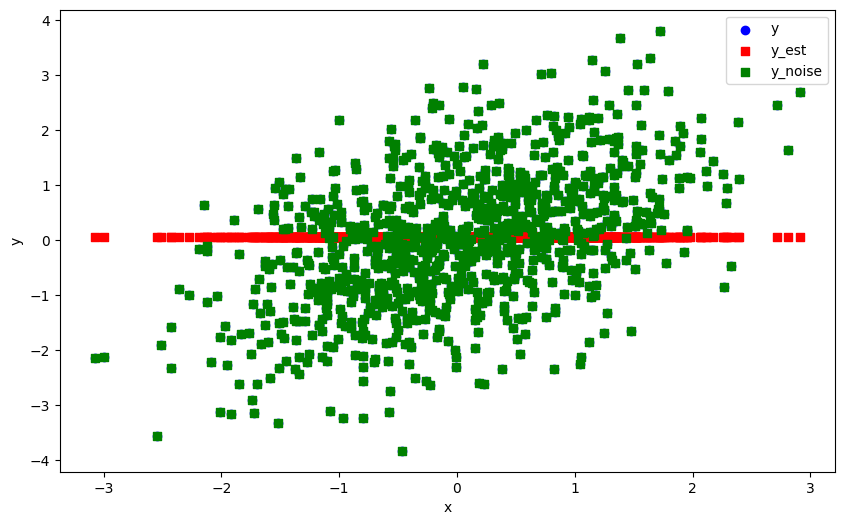

The programm is closed


In [9]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

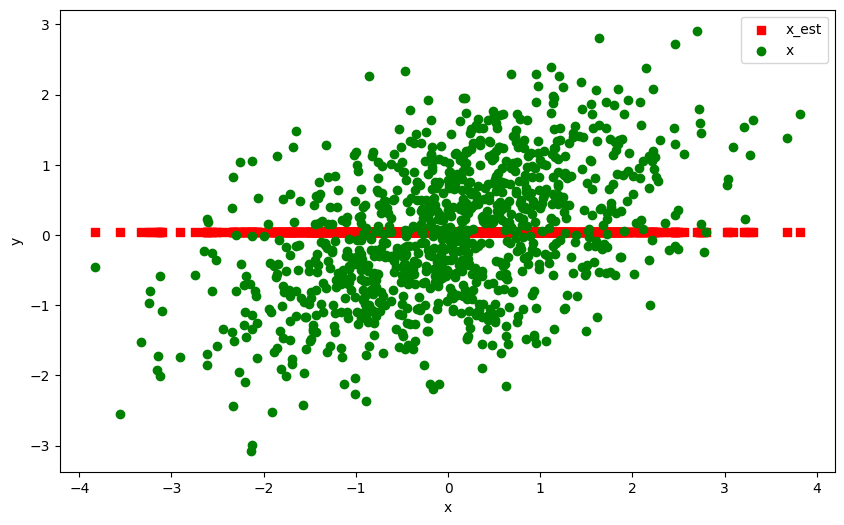

The programm is closed


In [10]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

## Test Hessian estimation

In [47]:
class PolyFunc(torch.nn.Module):
    def forward(self, x):
        if x.dim() == 1:            # handle single vector
            x = x.unsqueeze(0)      # [1, d]
        # out = torch.stack([(x[:, 0]**2)*x[:, 1], x[:, 1]**3], dim=1)  # [n, d]
        out = torch.stack([x[:, 0], 10*torch.sin(x[:, 0])], dim=1)
        return out if out.size(0) > 1 else out.squeeze(0)

In [48]:
def exact_hessian_per_output(model, x: torch.Tensor):
    """
    model.forward: [n, d] -> [n, d]
    Returns H of shape [n, d, d, d], where H[i, k] = Hessian_x f_k(x_i)  (size [d, d])
    """
    x_req = x.detach().requires_grad_(True)
    n, d = x_req.shape

    # f_single: [d] -> [d]
    def f_single(x1):
        return model.forward(x1.unsqueeze(0)).squeeze(0)  # [d]

    # Scalarization: s(x; u) = <u, f(x)>, Hess_x s with u = e_k gives Hessian of f_k
    def s(x1, u1):  # x1:[d], u1:[d]
        return (f_single(x1) * u1).sum()

    # Hessian w.r.t. x only (treat u as constant)
    hess_x = torch.func.hessian(s, argnums=0)  # (x1, u1) -> [d, d]

    I = torch.eye(d, device=x.device)  # unit vectors e_k stacked as rows, shape [d, d]

    # For one sample xi: map u over e_k to get all outputs' Hessians -> [d(outputs), d, d]
    def hess_all_outputs_for_sample(xi):
        return torch.func.vmap(lambda u: hess_x(xi, u), in_dims=0)(I)  # [d, d, d]

    # Map over batch -> [n, d, d, d]
    H = torch.func.vmap(hess_all_outputs_for_sample, in_dims=0)(x_req)
    return H

In [49]:
def exact_hessian_diag_per_output(model, x: torch.Tensor):
    H = exact_hessian_per_output(model, x)  # [n, d, d, d]
    return torch.diagonal(H, dim1=-2, dim2=-1).abs().mean(dim = 0)  # [n, d, d]

In [50]:
model = PolyFunc()
x = torch.tensor([[2.0, 3.0], [4.0, 1.0]], requires_grad=True)  # two sample

H_full = exact_hessian_per_output(model, x)    # [1, 2, 2, 2]
H_diag = exact_hessian_diag_per_output(model, x)  # [1, 2, 2]

print("Full Hessians:\n", H_full)
print("Diagonal Hessians:\n", H_diag)

Full Hessians:
 tensor([[[[-0.0000, -0.0000],
          [ 0.0000,  0.0000]],

         [[-9.0930, -0.0000],
          [ 0.0000,  0.0000]]],


        [[[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 7.5680,  0.0000],
          [ 0.0000,  0.0000]]]], grad_fn=<ViewBackward0>)
Diagonal Hessians:
 tensor([[0.0000, 0.0000],
        [8.3305, 0.0000]], grad_fn=<MeanBackward1>)


In [30]:
def get_Hessian(model, x: torch.Tensor) -> torch.Tensor:
        """Get the adjacency matrix defined by the DCE and the batched Jacobian

        Args:
            x (torch.Tensor): input

        Returns:
            torch.Tensor, torch.Tensor: the weighted graph and batched Jacobian
        """
        x_dummy = x.detach().requires_grad_()
        n, d = x.shape

        observed_deriv = torch.func.vmap(torch.func.jacrev(model.forward))(x_dummy).view(
            -1, d, d
        )#[n, d, d], observed_deriv[i, j, k]=for ith sample, derivative of f_j wrt x_k

        z = (torch.randint_like(observed_deriv, 0, 2).float() * 2 - 1) # [n, d, d]

        def g_single(xi, zi):
            J = torch.func.jacrev(model.forward)(xi)   # [d,d]
            return (J * zi).sum(dim=1) #[d]
        
        Hz  = torch.func.vmap(lambda xi, zi: torch.func.jacrev(lambda x_: g_single(x_, zi))(xi)
        )(x_dummy, z).view(-1, d, d) #[n, d, d]
        H_hat = (z*Hz).mean(dim=0) # [d, d] estimated Hessian of f_k wrt x_i, x_i

        return observed_deriv, H_hat

In [70]:
_, H_diag_hat = get_Hessian(model, x)
print("H_diag_hat: ", H_diag_hat)

H_diag_hat:  tensor([[-2., -6.],
        [ 0., 12.]], grad_fn=<MeanBackward1>)


In [51]:
def exact_hessian_diag_avg(model, x: torch.Tensor, batch_size: int = 256) -> torch.Tensor:
    """
    Exact per-output Hessian diagonals, averaged over a large batch.
    model.forward: [B, d] -> [B, d]
    x: [n, d]
    returns: [d, d] where out[k, i] = average over samples of ∂^2 f_k / ∂x_i^2
    """
    device = x.device
    n, d = x.shape
    out = torch.zeros(d, d, device=device)
    total = 0

    # per-sample wrapper so higher-order AD sees [d] -> [d]
    def f_single(x1):  # x1: [d] -> [d]
        return model.forward(x1.unsqueeze(0)).squeeze(0)

    # scalarization: s(x; u) = <u, f(x)>, Hess_x s with u = e_k gives Hessian of f_k
    def s(x1, u1):
        return (f_single(x1) * u1).sum()

    # Hessian wrt x only (treat u as constant)
    hess_x = torch.func.hessian(s, argnums=0)  # (x1, u1) -> [d, d]
    I = torch.eye(d, device=device)            # unit vectors e_k as rows

    # For one sample: stack all outputs' Hessians -> [d(outputs), d, d]
    def hess_all_outputs_for_sample(xi):
        return torch.func.vmap(lambda u: hess_x(xi, u), in_dims=0)(I)  # [d, d, d]

    with torch.no_grad():  # we only need numbers, not a backward graph
        for start in range(0, n, batch_size):
            xb = x[start:start+batch_size].detach().to(device).requires_grad_(True)
            # Map over the minibatch: [B, d, d, d]
            H = torch.func.vmap(hess_all_outputs_for_sample, in_dims=0)(xb)
            # Take diagonal over last two dims -> [B, d, d]
            Hdiag = torch.diagonal(H, dim1=-2, dim2=-1).contiguous() # extracts the diagonal of each Hessian
            out += Hdiag.abs().sum(dim=0)  # accumulate sum over this minibatch
            total += Hdiag.size(0)

    return out / total  # [d, d]

In [52]:
print(exact_hessian_diag_avg(model, x))

tensor([[0.0000, 0.0000],
        [8.3305, 0.0000]])


In [53]:
model = PolyFunc()
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[1, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples)
x = torch.tensor(epsilon, dtype=torch.float64)
print(exact_hessian_diag_avg(model, x))

tensor([[0.0000, 0.0000],
        [5.7114, 0.0000]])


## With non-linearity regularizer

### DAGMA init

### No Causal

In [2]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[1, 0.6],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.6, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = epsilon[:, 1]
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [3]:
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma = model.fit(X, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight = eq_model.fc1.weight
fc1_bias = eq_model.fc1.bias
fc2_weight = eq_model.fc2[0].weight
fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  0%|          | 0/80000 [00:00<?, ?it/s]

  4%|▎         | 1020/29000 [00:08<03:44, 124.84it/s]

Sigma:  tensor([[0.8905, 0.2191],
        [0.2191, 1.2432]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.2191],
        [0.2191, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.1589, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1244, grad_fn=<AddBackward0>)
h_val:  tensor(6.0801e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0033, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.1267e-15, 1.3573e-06],
        [3.5171e-02, 2.1048e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0156e-31, 1.5253e-14],
        [5.4313e-03, 1.1752e-21]])
mu:  1


  7%|▋         | 2020/29000 [00:15<03:26, 130.68it/s]

Sigma:  tensor([[0.8951, 0.4103],
        [0.4103, 1.3133]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.4103],
        [0.4103, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.0592, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0592, grad_fn=<AddBackward0>)
h_val:  tensor(4.7570e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.9654e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.2614e-15, 6.9400e-08],
        [2.0663e-05, 1.7568e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6922e-33, 5.1277e-18],
        [5.2168e-03, 1.4222e-21]])
mu:  1


 10%|█         | 3026/29000 [00:23<03:17, 131.21it/s]

Sigma:  tensor([[0.9252, 0.5144],
        [0.5144, 1.3942]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5144],
        [0.5144, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.0436, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0436, grad_fn=<AddBackward0>)
h_val:  tensor(5.0915e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(3.8454e-07, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.1683e-15, 1.5650e-08],
        [4.0014e-06, 1.5489e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.6147e-34, 8.2855e-20],
        [4.2918e-03, 1.1705e-21]])
mu:  1


 24%|██▍       | 7000/29000 [00:31<00:02, 8553.83it/s]

Sigma:  tensor([[0.9396, 0.5532],
        [0.5532, 1.4325]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5532],
        [0.5532, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.0422, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(4.1203e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.6832e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.1842e-15,  3.6632e-08],
        [-1.7422e-05,  1.4065e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1528e-33, 2.0600e-18],
        [3.5986e-03, 1.0042e-21]])
mu:  1


 27%|██▋       | 7835/29000 [00:37<00:46, 450.70it/s] 

Sigma:  tensor([[0.9415, 0.5583],
        [0.5583, 1.4378]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5583],
        [0.5583, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2042, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(2.5400e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.2488e-07, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[5.9056e-16, 1.0426e-07],
        [9.4133e-06, 1.3225e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.4707e-34, 1.0817e-17],
        [2.8569e-03, 8.4891e-22]])
mu:  0.1


 48%|████▊     | 14000/29000 [00:46<00:17, 835.13it/s]

Sigma:  tensor([[0.9416, 0.5583],
        [0.5583, 1.4377]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5583],
        [0.5583, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2042, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(1.9780e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(3.3477e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.3125e-15, 3.7907e-07],
        [3.3964e-05, 1.2336e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.9153e-33, 4.1000e-16],
        [2.5501e-03, 7.1049e-22]])
mu:  0.1


 52%|█████▏    | 15010/29000 [00:54<00:47, 295.88it/s]

Sigma:  tensor([[0.9413, 0.5579],
        [0.5579, 1.4374]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5579],
        [0.5579, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.0204, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(1.3025e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(2.4489e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 8.8757e-16, -1.0419e-07],
        [-2.4919e-05,  1.1086e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.3985e-34, 8.8178e-18],
        [2.1446e-03, 5.7805e-22]])
mu:  0.010000000000000002


 72%|███████▏  | 21011/29000 [01:01<00:00, 14397.27it/s]

Sigma:  tensor([[0.9414, 0.5580],
        [0.5580, 1.4375]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5580],
        [0.5580, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.0204, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(1.0059e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(6.2190e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.2100e-15,  3.7560e-08],
        [-6.3368e-05,  1.0896e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.3788e-34, 5.1828e-19],
        [1.9189e-03, 5.2331e-22]])
mu:  0.010000000000000002
Sigma:  tensor([[0.9404, 0.5565],
        [0.5565, 1.4360]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5565],
        [0.5565, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(5.9011e-07, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(2.6807e-07, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.22

100%|██████████| 29000/29000 [01:16<00:00, 377.19it/s]  

Sigma:  tensor([[0.9408, 0.5571],
        [0.5571, 1.4366]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5571],
        [0.5571, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(3.8655e-07, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(2.7860e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.2276e-15,  5.0160e-08],
        [-2.8193e-05,  1.0040e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.2764e-34, 1.2149e-18],
        [1.3597e-03, 4.0959e-22]])
mu:  0.0010000000000000002


In [4]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[1.2279e-15, 1.1153e-03],
        [1.6682e-09, 1.0040e-10]], grad_fn=<SqrtBackward0>)


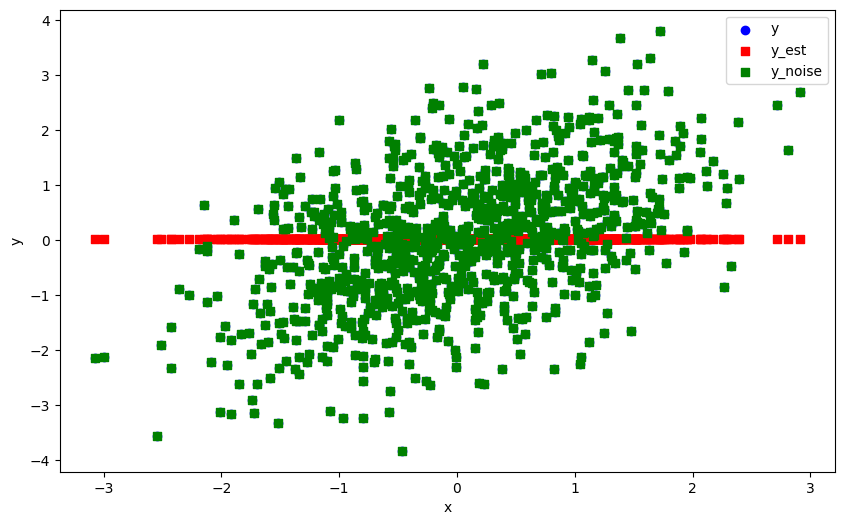

The programm is closed


In [5]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

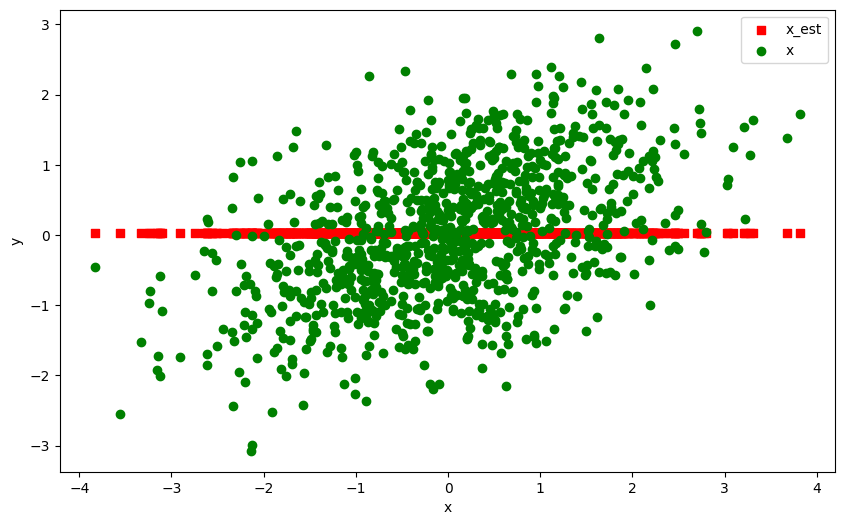

The programm is closed


In [6]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

### with causal

In [7]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[0.5, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = 10*torch.sin(x1)
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = 10*torch.sin(x1)+ epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [8]:
eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
W, observed_derivs = eq_model.get_graph(X_true)
print("Jacobian mean diag:", observed_derivs.mean(0).diag())

Jacobian mean diag: tensor([0., 0.], grad_fn=<DiagonalBackward0_copy>)


In [9]:
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma = model.fit(X_true, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight = eq_model.fc1.weight
fc1_bias = eq_model.fc1.bias
fc2_weight = eq_model.fc2[0].weight
fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X_true, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=6, warm_iter=7000, max_iter=8000)

  2%|▏         | 1015/43000 [00:08<05:30, 127.01it/s]

Sigma:  tensor([[0.6587, 0.0047],
        [0.0047, 1.3565]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.0047],
        [0.0047, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.2951, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8826, grad_fn=<AddBackward0>)
h_val:  tensor(0.1266, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0046, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.0646e-12, 4.7773e-02],
        [6.8090e+00, 1.0091e-08]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2652e-24, 3.8469e-03],
        [2.1401e+00, 2.6750e-18]])
mu:  1


  5%|▍         | 2016/43000 [00:15<05:20, 127.79it/s]

Sigma:  tensor([[ 4.3365e-01, -6.4077e-04],
        [-6.4077e-04,  1.5285e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0006],
        [-0.0006,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(1.6079, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0912, grad_fn=<AddBackward0>)
h_val:  tensor(0.1993, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0052, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.7674e-13, 5.3666e-02],
        [7.5399e+00, 5.0349e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.5376e-25, 3.9336e-03],
        [2.5809e+00, 8.2975e-19]])
mu:  1


  7%|▋         | 3018/43000 [00:23<05:13, 127.71it/s]

Sigma:  tensor([[ 0.2962, -0.0030],
        [-0.0030,  1.6051]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0030],
        [-0.0030,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(1.3344, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7186, grad_fn=<AddBackward0>)
h_val:  tensor(0.2847, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0059, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.5902e-12, 6.1670e-02],
        [7.7091e+00, 3.5301e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2876e-24, 4.0742e-03],
        [2.7980e+00, 4.6271e-19]])
mu:  1


  9%|▉         | 4022/43000 [00:31<05:03, 128.42it/s]

Sigma:  tensor([[ 0.2047, -0.0048],
        [-0.0048,  1.6403]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0048],
        [-0.0048,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(1.1138, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3968, grad_fn=<AddBackward0>)
h_val:  tensor(0.3785, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0067, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.0067e-12, 7.0096e-02],
        [7.6785e+00, 3.3680e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0392e-23, 4.0093e-03],
        [2.9534e+00, 4.6011e-19]])
mu:  1


 12%|█▏        | 5025/43000 [00:39<04:57, 127.52it/s]

Sigma:  tensor([[ 0.1429, -0.0073],
        [-0.0073,  1.6399]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0073],
        [-0.0073,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.9228, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1019, grad_fn=<AddBackward0>)
h_val:  tensor(0.4771, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0075, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[7.1973e-12, 7.7612e-02],
        [7.6154e+00, 3.4102e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.1940e-23, 3.8993e-03],
        [3.1402e+00, 5.1160e-19]])
mu:  1


 14%|█▍        | 6024/43000 [00:47<04:47, 128.74it/s]

Sigma:  tensor([[ 0.1015, -0.0106],
        [-0.0106,  1.6168]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0106],
        [-0.0106,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.7674, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1579, grad_fn=<AddBackward0>)
h_val:  tensor(0.5773, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0081, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.2311e-11, 8.4028e-02],
        [7.5475e+00, 3.4389e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.5642e-23, 3.7390e-03],
        [3.3819e+00, 5.6753e-19]])
mu:  1


 19%|█▊        | 8019/43000 [01:03<04:33, 128.11it/s]

Sigma:  tensor([[1.0538e-01, 1.5447e-03],
        [1.5447e-03, 1.8416e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.0015],
        [0.0015, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2714, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4233, grad_fn=<AddBackward0>)
h_val:  tensor(0.0998, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0042, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[3.7883e-11, 4.1820e-02],
        [7.1403e+00, 3.8070e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.1551e-22, 5.3783e-04],
        [3.3923e+00, 7.6448e-19]])
mu:  0.1


 21%|██        | 9018/43000 [01:10<04:23, 128.86it/s]

Sigma:  tensor([[1.5217e-01, 6.6707e-04],
        [6.6707e-04, 1.6220e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.0007],
        [0.0007, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2292, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4331, grad_fn=<AddBackward0>)
h_val:  tensor(0.0566, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[2.6436e-11, 3.0412e-02],
        [7.4609e+00, 2.8946e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0804e-22, 2.3508e-04],
        [3.7647e+00, 4.6479e-19]])
mu:  0.1


 23%|██▎       | 10015/43000 [01:18<04:18, 127.81it/s]

Sigma:  tensor([[2.1030e-01, 1.8349e-04],
        [1.8349e-04, 1.5204e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.0002],
        [0.0002, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2031, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4195, grad_fn=<AddBackward0>)
h_val:  tensor(0.0320, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0022, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.8285e-11, 2.2242e-02],
        [7.6850e+00, 2.0137e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.0649e-23, 1.0177e-04],
        [4.1498e+00, 2.4427e-19]])
mu:  0.1


 26%|██▌       | 11024/43000 [01:26<04:08, 128.43it/s]

Sigma:  tensor([[2.7361e-01, 1.0219e-04],
        [1.0219e-04, 1.4908e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.0001],
        [0.0001, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.1903, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4160, grad_fn=<AddBackward0>)
h_val:  tensor(0.0198, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.2967e-11, 1.7372e-02],
        [7.7411e+00, 1.5823e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.2792e-23, 5.1661e-05],
        [4.4732e+00, 1.6411e-19]])
mu:  0.1


 28%|██▊       | 12022/43000 [01:34<03:59, 129.23it/s]

Sigma:  tensor([[3.3267e-01, 8.9132e-05],
        [8.9132e-05, 1.4748e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 8.9132e-05],
        [8.9132e-05, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.1851, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4274, grad_fn=<AddBackward0>)
h_val:  tensor(0.0137, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.6793e-12, 1.4370e-02],
        [7.7556e+00, 1.2876e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4267e-23, 3.1702e-05],
        [4.8068e+00, 1.1857e-19]])
mu:  0.1


 30%|███       | 13022/43000 [01:42<03:53, 128.31it/s]

Sigma:  tensor([[3.7475e-01, 9.5185e-05],
        [9.5185e-05, 1.4680e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 9.5185e-05],
        [9.5185e-05, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.1837, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4433, grad_fn=<AddBackward0>)
h_val:  tensor(0.0109, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[7.8426e-12, 1.2750e-02],
        [7.7529e+00, 1.0715e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.9061e-24, 2.7202e-05],
        [5.1136e+00, 8.9442e-20]])
mu:  0.1


 35%|███▍      | 15017/43000 [01:57<03:39, 127.21it/s]

Sigma:  tensor([[4.7450e-01, 1.0762e-05],
        [1.0762e-05, 1.4636e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 1.0762e-05],
        [1.0762e-05, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0192, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6347, grad_fn=<AddBackward0>)
h_val:  tensor(7.4223e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.7223e-12, 1.0477e-03],
        [7.7767e+00, 7.8064e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.6007e-24, 2.1638e-06],
        [5.3949e+00, 5.0481e-20]])
mu:  0.010000000000000002


 49%|████▉     | 21007/43000 [02:05<00:01, 14813.62it/s]

Sigma:  tensor([[4.7398e-01, 9.6553e-06],
        [9.6553e-06, 1.4629e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 9.6553e-06],
        [9.6553e-06, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0192, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6334, grad_fn=<AddBackward0>)
h_val:  tensor(8.2206e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.6592e-12, 1.1011e-03],
        [7.7836e+00, 7.7589e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6196e-24, 8.9039e-07],
        [5.4341e+00, 5.1209e-20]])
mu:  0.010000000000000002
Sigma:  tensor([[4.8179e-01, 9.8068e-07],
        [9.8068e-07, 1.4613e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 9.8068e-07],
        [9.8068e-07, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0019, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6477, grad_fn=<AddBackward0>)
h_val:  tensor(1.1454e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.2960e-05,

 65%|██████▌   | 28000/43000 [02:21<00:18, 804.01it/s]  

Sigma:  tensor([[4.8152e-01, 9.0279e-07],
        [9.0279e-07, 1.4619e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 9.0279e-07],
        [9.0279e-07, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0019, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6485, grad_fn=<AddBackward0>)
h_val:  tensor(8.0676e-07, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0886e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.3954e-12, 1.0886e-04],
        [7.7936e+00, 7.4955e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8467e-24, 1.0344e-06],
        [5.4506e+00, 4.7886e-20]])
mu:  0.0010000000000000002


 67%|██████▋   | 28769/43000 [02:27<00:28, 498.64it/s]

Sigma:  tensor([[ 4.8018e-01, -4.6333e-07],
        [-4.6333e-07,  1.4611e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -4.6333e-07],
        [-4.6333e-07,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6486, grad_fn=<AddBackward0>)
h_val:  tensor(4.5372e-08, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(2.5449e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.1996e-11, 2.5445e-05],
        [7.8151e+00, 4.3653e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.9664e-24, 1.1363e-06],
        [5.4786e+00, 1.8439e-18]])
mu:  0.00010000000000000003


 81%|████████▏ | 35000/43000 [02:36<00:08, 933.73it/s]

Sigma:  tensor([[4.8224e-01, 6.1119e-08],
        [6.1119e-08, 1.4602e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 6.1119e-08],
        [6.1119e-08, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6489, grad_fn=<AddBackward0>)
h_val:  tensor(9.0809e-09, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0804e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.3474e-12, 1.0804e-05],
        [7.8131e+00, 7.4064e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9215e-24, 1.1604e-06],
        [5.4761e+00, 4.7142e-20]])
mu:  0.00010000000000000003


 83%|████████▎ | 35656/43000 [02:41<00:13, 548.09it/s]

Sigma:  tensor([[4.7781e-01, 1.4593e-06],
        [1.4593e-06, 1.4707e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 1.4593e-06],
        [1.4593e-06, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(1.9238e-05, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6479, grad_fn=<AddBackward0>)
h_val:  tensor(1.6143e-08, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.4751e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[5.7635e-10, 1.4733e-05],
        [7.8348e+00, 1.6763e-08]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7349e-20, 1.1370e-06],
        [5.5033e+00, 2.0581e-17]])
mu:  1.0000000000000004e-05


100%|██████████| 43000/43000 [02:52<00:00, 249.98it/s] 

Sigma:  tensor([[ 4.7894e-01, -7.0054e-09],
        [-7.0054e-09,  1.4659e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -7.0054e-09],
        [-7.0054e-09,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(1.9225e-05, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6481, grad_fn=<AddBackward0>)
h_val:  tensor(1.1837e-09, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0868e-07, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[2.3381e-10, 1.0743e-06],
        [7.8343e+00, 1.2308e-08]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.7909e-21, 1.1593e-06],
        [5.5026e+00, 1.1816e-17]])
mu:  1.0000000000000004e-05


In [10]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[2.3359e-10, 8.2918e+00],
        [4.1485e-06, 1.2926e-08]], grad_fn=<SqrtBackward0>)


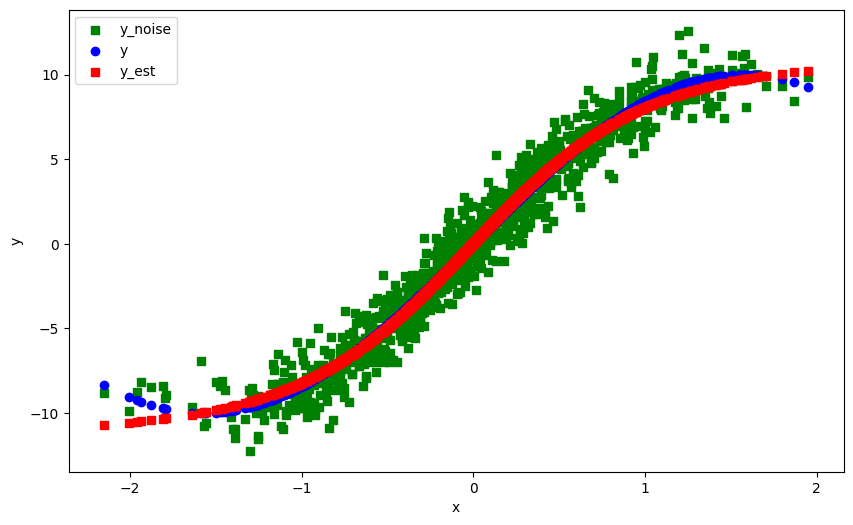

The programm is closed


In [11]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X_true.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.scatter(X_true.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X_true.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

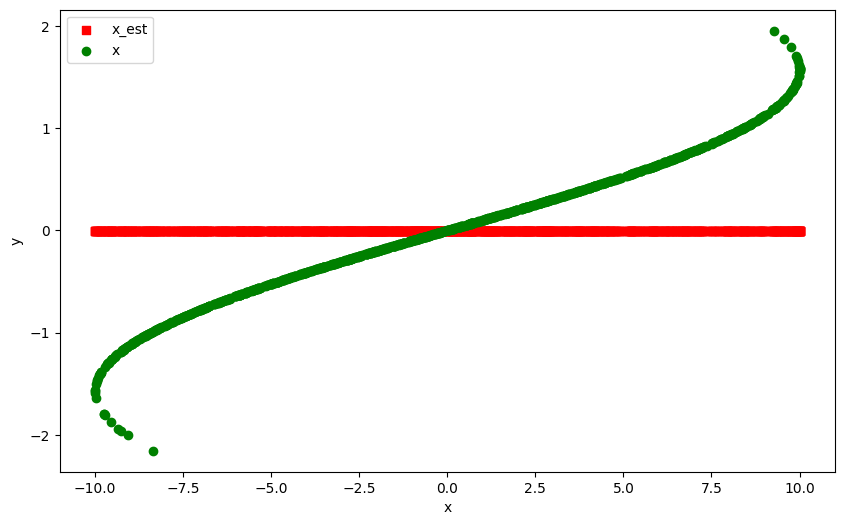

The programm is closed


In [12]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

In [8]:
d = 2
dims = [2, 5]
mask = torch.ones(d * dims[1], d)
for j in range(d):
    mask[j * dims[1]:(j + 1) * dims[1], j] = 0.0
print(mask)

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


In [9]:
mask = torch.ones(d * dims[1], d)
for j in range(d):
    rows = slice(j * dims[1], (j + 1) * dims[1])
    mask[rows, j] = 0.0   # forbid x_j → hidden block j
print(mask)

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


### 3 nodes x1 <-x2<->x3 (L1-Norm)

In [36]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 3  # Dimension of the normal vectors
d = 3
# Random data for X and X_hat
True_Sigma = np.array([[1.0, 0.0, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.0, 0.6],
                [0.0, 0.6, 1.0]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x3 = epsilon[:, 2]
x2 = epsilon[:, 1]
x1 = 10*torch.sin(x2)
x1_true = x1+ epsilon[:, 0]
X = torch.stack((x1, x2, x3), dim=1)
X_true = torch.stack((x1_true, x2, x3), dim=1)

In [37]:
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma, X_est = model.fit(X, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

100%|██████████| 80000/80000 [00:06<00:00, 12621.65it/s]


In [38]:
print("W_est_dagma", W_est_dagma)

W_est_dagma [[3.59002839e-02 3.74677678e-03 3.10794033e-05]
 [5.93405639e+00 1.91344154e-02 3.58773944e-05]
 [2.01739766e-04 7.75501192e-01 1.90092069e-05]]


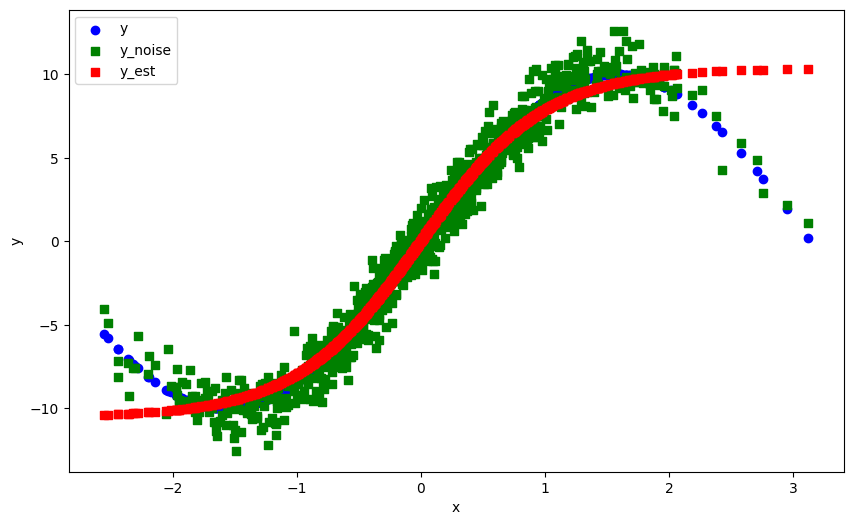

The programm is closed


In [39]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 1], X_true.detach().numpy()[:, 0], label='y_noise', color='green', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X_est.detach().numpy()[:, 0], label='y_est', color='red', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

In [40]:
# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight = eq_model.fc1.weight
fc1_bias = eq_model.fc1.bias
fc2_weight = eq_model.fc2[0].weight
fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  0%|          | 113/29000 [00:01<04:18, 111.77it/s]

Sigma:  tensor([[ 0.9608, -0.0018, -0.0116],
        [-0.0018,  0.9605,  0.0163],
        [-0.0116,  0.0163,  0.9618]], grad_fn=<MmBackward0>)
obj:  tensor(2.2926, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7798, grad_fn=<AddBackward0>)
h_val:  tensor(0.0427, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0235, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.9153e-02, 6.1596e+00, 9.7864e-06],
        [2.8080e-02, 2.3961e-02, 4.5840e-01],
        [6.2171e-04, 2.7952e-04, 6.1626e-04]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.9761e-04, 4.6658e+00, 2.8942e-09],
        [9.8373e-05, 1.0322e-04, 7.1106e-02],
        [7.9646e-07, 1.6194e-07, 7.8258e-07]])


  1%|          | 221/29000 [00:02<04:09, 115.52it/s]

Sigma:  tensor([[ 0.9233, -0.0024, -0.0051],
        [-0.0024,  0.9216,  0.0102],
        [-0.0051,  0.0102,  0.9279]], grad_fn=<MmBackward0>)
obj:  tensor(2.2150, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6205, grad_fn=<AddBackward0>)
h_val:  tensor(0.1100, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0252, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 5.6477e-02,  6.0972e+00, -6.3405e-05],
        [ 4.6153e-02,  1.0091e-02,  4.1993e-01],
        [ 2.4224e-03,  1.5614e-03,  2.4117e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.0429e-04, 4.6980e+00, 3.2380e-09],
        [2.8414e-04, 4.5727e-05, 6.8228e-02],
        [1.3327e-05, 5.5518e-06, 1.3209e-05]])


  1%|          | 317/29000 [00:02<04:05, 116.94it/s]

Sigma:  tensor([[ 0.8876, -0.0027, -0.0095],
        [-0.0027,  0.8837, -0.0064],
        [-0.0095, -0.0064,  0.9004]], grad_fn=<MmBackward0>)
obj:  tensor(2.1538, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5316, grad_fn=<AddBackward0>)
h_val:  tensor(0.1237, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0269, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[6.0615e-02, 6.0440e+00, 8.6410e-05],
        [4.8953e-02, 2.8545e-03, 3.8742e-01],
        [5.4723e-03, 4.0290e-03, 5.4608e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.7717e-04, 4.7217e+00, 3.6003e-09],
        [3.3789e-04, 2.8028e-05, 6.3344e-02],
        [7.1462e-05, 3.8772e-05, 7.1163e-05]])


  1%|▏         | 413/29000 [00:03<04:04, 117.00it/s]

Sigma:  tensor([[ 0.8537, -0.0024, -0.0088],
        [-0.0024,  0.8475, -0.0183],
        [-0.0088, -0.0183,  0.8755]], grad_fn=<MmBackward0>)
obj:  tensor(2.0902, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4647, grad_fn=<AddBackward0>)
h_val:  tensor(0.1122, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0285, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 6.1267e-02,  6.0188e+00, -4.5293e-05],
        [ 4.6637e-02,  4.5923e-03,  3.5806e-01],
        [ 9.5176e-03,  5.3178e-03,  9.5182e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.9608e-04, 4.7562e+00, 2.8460e-09],
        [3.2803e-04, 3.8170e-05, 5.8403e-02],
        [2.2191e-04, 6.9353e-05, 2.2194e-04]])


  2%|▏         | 521/29000 [00:04<04:02, 117.40it/s]

Sigma:  tensor([[ 0.8217, -0.0026, -0.0096],
        [-0.0026,  0.8135, -0.0172],
        [-0.0096, -0.0172,  0.8489]], grad_fn=<MmBackward0>)
obj:  tensor(2.0173, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3716, grad_fn=<AddBackward0>)
h_val:  tensor(0.1254, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0293, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[5.9181e-02, 6.0319e+00, 3.4492e-05],
        [4.9043e-02, 5.3481e-03, 3.2672e-01],
        [1.4208e-02, 3.2346e-03, 1.4253e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.6744e-04, 4.8161e+00, 2.7192e-09],
        [3.8669e-04, 5.0248e-05, 5.4697e-02],
        [5.0726e-04, 2.6465e-05, 5.1044e-04]])


  2%|▏         | 617/29000 [00:05<04:03, 116.77it/s]

Sigma:  tensor([[ 0.7917, -0.0029, -0.0152],
        [-0.0029,  0.7812, -0.0072],
        [-0.0152, -0.0072,  0.8193]], grad_fn=<MmBackward0>)
obj:  tensor(1.9363, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2658, grad_fn=<AddBackward0>)
h_val:  tensor(0.1466, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0296, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 5.5781e-02,  6.0648e+00, -7.5750e-06],
        [ 5.2483e-02,  7.6677e-03,  2.9331e-01],
        [ 1.9317e-02,  3.6211e-05,  1.9518e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.1737e-04, 4.8875e+00, 2.5816e-09],
        [4.7552e-04, 7.4731e-05, 5.1570e-02],
        [9.8949e-04, 1.0586e-06, 1.0087e-03]])


  2%|▏         | 713/29000 [00:06<04:02, 116.82it/s]

Sigma:  tensor([[ 0.7635, -0.0032, -0.0202],
        [-0.0032,  0.7502,  0.0067],
        [-0.0202,  0.0067,  0.7866]], grad_fn=<MmBackward0>)
obj:  tensor(1.8493, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1726, grad_fn=<AddBackward0>)
h_val:  tensor(0.1500, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0298, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 5.2164e-02,  6.0978e+00, -1.7294e-06],
        [ 5.2616e-02,  1.2237e-02,  2.5821e-01],
        [ 2.4228e-02, -4.3187e-05,  2.4913e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.6634e-04, 4.9556e+00, 2.6078e-09],
        [5.4267e-04, 1.2034e-04, 4.8294e-02],
        [1.7100e-03, 1.1299e-06, 1.7848e-03]])


  3%|▎         | 822/29000 [00:07<04:00, 117.28it/s]

Sigma:  tensor([[ 0.7372, -0.0034, -0.0246],
        [-0.0034,  0.7208,  0.0238],
        [-0.0246,  0.0238,  0.7514]], grad_fn=<MmBackward0>)
obj:  tensor(1.7537, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0667, grad_fn=<AddBackward0>)
h_val:  tensor(0.1568, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0301, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.8491e-02,  6.1307e+00, -6.4049e-06],
        [ 5.3260e-02,  2.1104e-02,  2.1918e-01],
        [ 2.9599e-02,  6.6175e-05,  3.1335e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.1772e-04, 5.0223e+00, 2.6538e-09],
        [6.5327e-04, 2.1411e-04, 4.5337e-02],
        [2.6676e-03, 2.3749e-07, 2.8731e-03]])


  3%|▎         | 918/29000 [00:08<04:09, 112.76it/s]

Sigma:  tensor([[ 0.7126, -0.0036, -0.0306],
        [-0.0036,  0.6927,  0.0418],
        [-0.0306,  0.0418,  0.7154]], grad_fn=<MmBackward0>)
obj:  tensor(1.6527, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9483, grad_fn=<AddBackward0>)
h_val:  tensor(0.1690, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0306, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.5210e-02,  6.1591e+00, -1.2055e-05],
        [ 5.4654e-02,  3.4740e-02,  1.7569e-01],
        [ 3.5400e-02,  6.7815e-06,  3.8988e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.7748e-04, 5.0852e+00, 2.7099e-09],
        [8.2437e-04, 3.7953e-04, 4.2544e-02],
        [3.7171e-03, 1.9738e-07, 4.1889e-03]])


  3%|▎         | 1014/29000 [00:08<03:59, 116.65it/s]

Sigma:  tensor([[ 0.6897, -0.0038, -0.0367],
        [-0.0038,  0.6659,  0.0592],
        [-0.0367,  0.0592,  0.6801]], grad_fn=<MmBackward0>)
obj:  tensor(1.5532, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8344, grad_fn=<AddBackward0>)
h_val:  tensor(0.1775, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0312, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.2168e-02,  6.1833e+00,  1.8633e-05],
        [ 5.5280e-02,  5.2647e-02,  1.2837e-01],
        [ 4.1639e-02, -1.0083e-06,  4.8394e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.4277e-04, 5.1433e+00, 2.7856e-09],
        [1.0493e-03, 6.2177e-04, 3.9566e-02],
        [4.6743e-03, 4.3342e-07, 5.6756e-03]])


  4%|▍         | 1122/29000 [00:09<03:59, 116.60it/s]

Sigma:  tensor([[ 0.6684, -0.0040, -0.0418],
        [-0.0040,  0.6402,  0.0757],
        [-0.0418,  0.0757,  0.6470]], grad_fn=<MmBackward0>)
obj:  tensor(1.4621, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7210, grad_fn=<AddBackward0>)
h_val:  tensor(0.1924, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0319, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[3.9074e-02, 6.2071e+00, 1.8477e-05],
        [5.6539e-02, 7.4535e-02, 7.8162e-02],
        [4.7810e-02, 5.2746e-06, 6.0024e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0973e-04, 5.1991e+00, 2.8351e-09],
        [1.3532e-03, 9.3259e-04, 3.6562e-02],
        [5.3797e-03, 1.0783e-06, 7.3663e-03]])


  4%|▍         | 1218/29000 [00:10<03:58, 116.54it/s]

Sigma:  tensor([[ 0.6487, -0.0042, -0.0449],
        [-0.0042,  0.6154,  0.0921],
        [-0.0449,  0.0921,  0.6174]], grad_fn=<MmBackward0>)
obj:  tensor(1.3823, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6189, grad_fn=<AddBackward0>)
h_val:  tensor(0.2080, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0325, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.6416e-02,  6.2260e+00, -6.6607e-06],
        [ 5.7381e-02,  9.9094e-02,  2.7181e-02],
        [ 5.2510e-02,  7.6253e-06,  7.4034e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8346e-04, 5.2491e+00, 2.8465e-09],
        [1.7253e-03, 1.2735e-03, 3.3353e-02],
        [5.7031e-03, 5.2137e-06, 9.3469e-03]])


  5%|▍         | 1315/29000 [00:11<03:53, 118.40it/s]

Sigma:  tensor([[ 0.6306, -0.0043, -0.0426],
        [-0.0043,  0.5916,  0.1105],
        [-0.0426,  0.1105,  0.5920]], grad_fn=<MmBackward0>)
obj:  tensor(1.3132, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5212, grad_fn=<AddBackward0>)
h_val:  tensor(0.2188, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0342, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4526e-02,  6.2384e+00,  1.1448e-04],
        [ 5.7082e-02,  1.2214e-01, -2.7585e-04],
        [ 5.4155e-02, -8.6243e-07,  9.0836e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6623e-04, 5.2925e+00, 4.7034e-09],
        [2.0889e-03, 1.5731e-03, 3.1548e-02],
        [5.5784e-03, 1.0182e-05, 1.1739e-02]])


  5%|▍         | 1399/29000 [00:12<03:53, 118.19it/s]

Sigma:  tensor([[ 0.6139, -0.0044, -0.0356],
        [-0.0044,  0.5686,  0.1275],
        [-0.0356,  0.1275,  0.5706]], grad_fn=<MmBackward0>)
obj:  tensor(1.2473, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4114, grad_fn=<AddBackward0>)
h_val:  tensor(0.2326, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0370, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[3.2290e-02, 6.2575e+00, 1.5050e-04],
        [5.7077e-02, 1.3879e-01, 3.1715e-03],
        [5.1911e-02, 7.7123e-06, 1.1070e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4668e-04, 5.3394e+00, 6.0836e-09],
        [2.3999e-03, 1.8012e-03, 3.2053e-02],
        [5.0077e-03, 1.3614e-05, 1.4564e-02]])


  5%|▌         | 1520/29000 [00:13<03:59, 114.76it/s]

Sigma:  tensor([[ 0.5987, -0.0046, -0.0292],
        [-0.0046,  0.5463,  0.1420],
        [-0.0292,  0.1420,  0.5523]], grad_fn=<MmBackward0>)
obj:  tensor(1.1726, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3075, grad_fn=<AddBackward0>)
h_val:  tensor(0.2412, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0389, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[2.9444e-02, 6.2835e+00, 2.3454e-06],
        [5.6112e-02, 1.5001e-01, 4.5800e-04],
        [4.8095e-02, 1.0335e-06, 1.3669e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2334e-04, 5.3907e+00, 3.0422e-09],
        [2.7219e-03, 1.9378e-03, 3.1611e-02],
        [4.2411e-03, 1.5839e-05, 1.8189e-02]])


  6%|▌         | 1616/29000 [00:14<03:53, 117.42it/s]

Sigma:  tensor([[ 0.5847, -0.0048, -0.0223],
        [-0.0048,  0.5247,  0.1561],
        [-0.0223,  0.1561,  0.5361]], grad_fn=<MmBackward0>)
obj:  tensor(1.0915, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1954, grad_fn=<AddBackward0>)
h_val:  tensor(0.2521, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0407, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.6760e-02,  6.3073e+00, -2.1205e-06],
        [ 5.5159e-02,  1.5686e-01,  1.7288e-04],
        [ 4.3413e-02,  2.4264e-05,  1.6974e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0343e-04, 5.4413e+00, 3.1349e-09],
        [3.0036e-03, 1.9940e-03, 3.1232e-02],
        [3.3671e-03, 1.8015e-05, 2.2615e-02]])


  6%|▌         | 1713/29000 [00:15<03:50, 118.13it/s]

Sigma:  tensor([[ 0.5721, -0.0050, -0.0148],
        [-0.0050,  0.5041,  0.1701],
        [-0.0148,  0.1701,  0.5208]], grad_fn=<MmBackward0>)
obj:  tensor(1.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0603, grad_fn=<AddBackward0>)
h_val:  tensor(0.2753, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0426, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.4248e-02,  6.3287e+00, -2.5916e-05],
        [ 5.5224e-02,  1.6251e-01,  2.0152e-04],
        [ 3.8271e-02, -7.7406e-06,  2.1057e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.6778e-05, 5.4912e+00, 3.3273e-09],
        [3.2528e-03, 2.0191e-03, 3.0985e-02],
        [2.4942e-03, 2.2258e-05, 2.7894e-02]])


  6%|▋         | 1822/29000 [00:15<03:51, 117.51it/s]

Sigma:  tensor([[ 0.5606, -0.0052, -0.0074],
        [-0.0052,  0.4843,  0.1832],
        [-0.0074,  0.1832,  0.5056]], grad_fn=<MmBackward0>)
obj:  tensor(0.8981, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0928, grad_fn=<AddBackward0>)
h_val:  tensor(0.3057, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0444, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.1459e-02,  6.3522e+00, -1.5041e-05],
        [ 5.5125e-02,  1.6850e-01,  2.5456e-05],
        [ 3.3394e-02, -3.4983e-06,  2.5997e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.0389e-05, 5.5421e+00, 3.3994e-09],
        [3.4420e-03, 2.0052e-03, 3.0642e-02],
        [1.7575e-03, 2.9877e-05, 3.4108e-02]])


  7%|▋         | 1918/29000 [00:16<03:49, 118.15it/s]

Sigma:  tensor([[ 5.5040e-01, -5.3411e-03, -5.3249e-05],
        [-5.3411e-03,  4.6548e-01,  1.9409e-01],
        [-5.3249e-05,  1.9409e-01,  4.8989e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.7877, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2588, grad_fn=<AddBackward0>)
h_val:  tensor(0.3438, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0459, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.8509e-02,  6.3771e+00, -2.0929e-05],
        [ 5.4715e-02,  1.7605e-01,  3.0312e-05],
        [ 2.8114e-02,  2.3912e-05,  3.1488e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.5622e-05, 5.5930e+00, 3.5918e-09],
        [3.5555e-03, 1.9587e-03, 3.0279e-02],
        [1.2015e-03, 4.1819e-05, 4.0575e-02]])


  7%|▋         | 2015/29000 [00:17<03:49, 117.68it/s]

Sigma:  tensor([[ 0.5413, -0.0055,  0.0069],
        [-0.0055,  0.4475,  0.2018],
        [ 0.0069,  0.2018,  0.4733]], grad_fn=<MmBackward0>)
obj:  tensor(0.6731, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4378, grad_fn=<AddBackward0>)
h_val:  tensor(0.3950, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0469, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.5381e-02,  6.4035e+00,  8.5446e-06],
        [ 5.4517e-02,  1.8537e-01, -9.0305e-06],
        [ 2.2900e-02,  1.9613e-05,  3.7333e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.3164e-05, 5.6440e+00, 3.7735e-09],
        [3.6039e-03, 1.9152e-03, 2.9963e-02],
        [8.4790e-04, 5.7690e-05, 4.7360e-02]])


  7%|▋         | 2124/29000 [00:18<03:47, 118.39it/s]

Sigma:  tensor([[ 0.5332, -0.0057,  0.0130],
        [-0.0057,  0.4303,  0.2055],
        [ 0.0130,  0.2055,  0.4551]], grad_fn=<MmBackward0>)
obj:  tensor(0.5609, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6158, grad_fn=<AddBackward0>)
h_val:  tensor(0.4549, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0472, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.2116e-02, 6.4314e+00, 5.2364e-05],
        [5.4329e-02, 1.9588e-01, 1.3552e-05],
        [1.7997e-02, 8.5393e-06, 4.2972e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.4127e-05, 5.6945e+00, 4.4855e-09],
        [3.5881e-03, 1.8930e-03, 2.9667e-02],
        [6.3566e-04, 7.5206e-05, 5.4100e-02]])


  8%|▊         | 2221/29000 [00:19<03:44, 119.32it/s]

Sigma:  tensor([[ 0.5262, -0.0059,  0.0173],
        [-0.0059,  0.4138,  0.2047],
        [ 0.0173,  0.2047,  0.4347]], grad_fn=<MmBackward0>)
obj:  tensor(0.4579, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7808, grad_fn=<AddBackward0>)
h_val:  tensor(0.5163, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0470, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 9.0005e-03,  6.4581e+00,  4.4572e-06],
        [ 5.4230e-02,  2.0694e-01, -3.3083e-06],
        [ 1.4281e-02,  7.0533e-06,  4.7775e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.0455e-05, 5.7418e+00, 4.6187e-09],
        [3.5232e-03, 1.9237e-03, 2.9382e-02],
        [5.1258e-04, 9.1157e-05, 5.9963e-02]])


  8%|▊         | 2318/29000 [00:20<03:46, 117.67it/s]

Sigma:  tensor([[ 0.5201, -0.0061,  0.0194],
        [-0.0061,  0.3980,  0.1995],
        [ 0.0194,  0.1995,  0.4119]], grad_fn=<MmBackward0>)
obj:  tensor(0.3687, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9226, grad_fn=<AddBackward0>)
h_val:  tensor(0.5680, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0468, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 6.3784e-03,  6.4806e+00, -4.5249e-05],
        [ 5.4205e-02,  2.1803e-01, -2.7021e-05],
        [ 1.2120e-02, -1.0274e-05,  5.1211e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.3472e-05, 5.7818e+00, 5.7891e-09],
        [3.4274e-03, 2.0215e-03, 2.9100e-02],
        [4.4080e-04, 1.0246e-04, 6.4083e-02]])


  8%|▊         | 2416/29000 [00:20<03:43, 118.95it/s]

Sigma:  tensor([[ 0.5149, -0.0063,  0.0195],
        [-0.0063,  0.3827,  0.1907],
        [ 0.0195,  0.1907,  0.3875]], grad_fn=<MmBackward0>)
obj:  tensor(0.2923, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0398, grad_fn=<AddBackward0>)
h_val:  tensor(0.6040, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0472, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.4166e-03,  6.4975e+00, -2.0204e-05],
        [ 5.4270e-02,  2.2861e-01, -1.3478e-05],
        [ 1.1468e-02,  2.0530e-05,  5.3250e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.2509e-05, 5.8121e+00, 7.2251e-09],
        [3.3218e-03, 2.1871e-03, 2.8821e-02],
        [4.0894e-04, 1.0818e-04, 6.6273e-02]])


  9%|▊         | 2524/29000 [00:21<03:43, 118.26it/s]

Sigma:  tensor([[ 0.5104, -0.0065,  0.0184],
        [-0.0065,  0.3681,  0.1798],
        [ 0.0184,  0.1798,  0.3628]], grad_fn=<MmBackward0>)
obj:  tensor(0.2238, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1411, grad_fn=<AddBackward0>)
h_val:  tensor(0.6293, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0478, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.1907e-03,  6.5079e+00, -6.3629e-05],
        [ 5.4442e-02,  2.3834e-01, -1.3576e-05],
        [ 1.1728e-02,  1.2129e-05,  5.4458e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.5679e-05, 5.8311e+00, 1.0588e-08],
        [3.2261e-03, 2.4044e-03, 2.8543e-02],
        [4.0133e-04, 1.1059e-04, 6.7360e-02]])


  9%|▉         | 2620/29000 [00:22<03:44, 117.76it/s]

Sigma:  tensor([[ 0.5066, -0.0067,  0.0169],
        [-0.0067,  0.3539,  0.1681],
        [ 0.0169,  0.1681,  0.3393]], grad_fn=<MmBackward0>)
obj:  tensor(0.1574, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2383, grad_fn=<AddBackward0>)
h_val:  tensor(0.6532, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0484, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.6109e-03,  6.5127e+00, -4.7112e-05],
        [ 5.4687e-02,  2.4716e-01, -9.1030e-06],
        [ 1.2208e-02, -2.6754e-06,  5.5518e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.1829e-05, 5.8388e+00, 1.5072e-08],
        [3.1513e-03, 2.6469e-03, 2.8263e-02],
        [4.0011e-04, 1.1217e-04, 6.8373e-02]])


  9%|▉         | 2716/29000 [00:23<03:43, 117.44it/s]

Sigma:  tensor([[ 0.5034, -0.0070,  0.0155],
        [-0.0070,  0.3402,  0.1564],
        [ 0.0155,  0.1564,  0.3175]], grad_fn=<MmBackward0>)
obj:  tensor(0.0899, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3382, grad_fn=<AddBackward0>)
h_val:  tensor(0.6809, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0488, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.6610e-03,  6.5121e+00, -7.2625e-05],
        [ 5.4971e-02,  2.5529e-01,  1.8643e-05],
        [ 1.2564e-02,  3.0736e-07,  5.6763e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.0089e-05, 5.8347e+00, 2.2754e-08],
        [3.1000e-03, 2.9054e-03, 2.7986e-02],
        [3.9557e-04, 1.1417e-04, 6.9769e-02]])


 10%|▉         | 2824/29000 [00:24<03:42, 117.60it/s]

Sigma:  tensor([[ 0.5006, -0.0072,  0.0142],
        [-0.0072,  0.3269,  0.1451],
        [ 0.0142,  0.1451,  0.2973]], grad_fn=<MmBackward0>)
obj:  tensor(0.0221, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4397, grad_fn=<AddBackward0>)
h_val:  tensor(0.7111, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0491, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.2971e-03,  6.5064e+00, -3.7865e-05],
        [ 5.5276e-02,  2.6298e-01,  4.1719e-05],
        [ 1.2845e-02,  1.7489e-05,  5.8094e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0990e-04, 5.8196e+00, 3.2693e-08],
        [3.0698e-03, 3.1734e-03, 2.7709e-02],
        [3.8969e-04, 1.1639e-04, 7.1326e-02]])


 10%|█         | 2920/29000 [00:25<03:42, 117.11it/s]

Sigma:  tensor([[ 0.4981, -0.0075,  0.0128],
        [-0.0075,  0.3142,  0.1342],
        [ 0.0128,  0.1342,  0.2786]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0437, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5384, grad_fn=<AddBackward0>)
h_val:  tensor(0.7397, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0495, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.4891e-03,  6.4960e+00, -1.1450e-05],
        [ 5.5588e-02,  2.7030e-01,  9.1763e-05],
        [ 1.3192e-02, -1.6779e-05,  5.9295e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3107e-04, 5.7942e+00, 4.6881e-08],
        [3.0553e-03, 3.4497e-03, 2.7432e-02],
        [3.8825e-04, 1.1833e-04, 7.2632e-02]])


 10%|█         | 3016/29000 [00:26<03:41, 117.10it/s]

Sigma:  tensor([[ 0.4960, -0.0078,  0.0113],
        [-0.0078,  0.3019,  0.1240],
        [ 0.0113,  0.1240,  0.2614]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1069, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6332, grad_fn=<AddBackward0>)
h_val:  tensor(0.7658, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0500, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[6.1747e-03, 6.4813e+00, 2.5868e-05],
        [5.5935e-02, 2.7725e-01, 2.4193e-05],
        [1.3621e-02, 2.9943e-05, 6.0310e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5377e-04, 5.7597e+00, 6.5728e-08],
        [3.0540e-03, 3.7367e-03, 2.7144e-02],
        [3.9207e-04, 1.1958e-04, 7.3577e-02]])


 11%|█         | 3124/29000 [00:27<03:41, 116.65it/s]

Sigma:  tensor([[ 0.4941, -0.0081,  0.0100],
        [-0.0081,  0.2900,  0.1146],
        [ 0.0100,  0.1146,  0.2457]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1682, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7262, grad_fn=<AddBackward0>)
h_val:  tensor(0.7909, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0507, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 8.2941e-03,  6.4631e+00, -2.7000e-05],
        [ 5.6306e-02,  2.8378e-01, -5.6559e-05],
        [ 1.4030e-02,  2.3155e-05,  6.1248e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7847e-04, 5.7171e+00, 8.9309e-08],
        [3.0597e-03, 4.0300e-03, 2.6851e-02],
        [3.9716e-04, 1.2090e-04, 7.4284e-02]])


 11%|█         | 3220/29000 [00:27<03:38, 117.83it/s]

Sigma:  tensor([[ 0.4923, -0.0085,  0.0088],
        [-0.0085,  0.2786,  0.1061],
        [ 0.0088,  0.1061,  0.2315]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2283, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8182, grad_fn=<AddBackward0>)
h_val:  tensor(0.8158, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0514, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.0778e-02,  6.4418e+00,  1.9721e-05],
        [ 5.6675e-02,  2.8993e-01,  1.2275e-05],
        [ 1.4361e-02, -6.9572e-06,  6.2168e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0578e-04, 5.6676e+00, 1.1747e-07],
        [3.0652e-03, 4.3297e-03, 2.6566e-02],
        [4.0159e-04, 1.2241e-04, 7.4841e-02]])


 11%|█▏        | 3316/29000 [00:28<03:38, 117.72it/s]

Sigma:  tensor([[ 0.4905, -0.0088,  0.0077],
        [-0.0088,  0.2676,  0.0984],
        [ 0.0077,  0.0984,  0.2185]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2865, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9091, grad_fn=<AddBackward0>)
h_val:  tensor(0.8402, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0522, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.3595e-02,  6.4177e+00, -3.1604e-05],
        [ 5.7049e-02,  2.9591e-01,  1.6114e-05],
        [ 1.4648e-02, -3.6427e-05,  6.3034e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3612e-04, 5.6119e+00, 1.5104e-07],
        [3.0701e-03, 4.6451e-03, 2.6275e-02],
        [4.0734e-04, 1.2397e-04, 7.5148e-02]])


 12%|█▏        | 3413/29000 [00:29<03:36, 118.25it/s]

Sigma:  tensor([[ 0.4889, -0.0092,  0.0067],
        [-0.0092,  0.2570,  0.0914],
        [ 0.0067,  0.0914,  0.2067]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3426, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9981, grad_fn=<AddBackward0>)
h_val:  tensor(0.8632, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0533, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.6686e-02,  6.3914e+00, -2.0454e-06],
        [ 5.7429e-02,  3.0175e-01, -2.7105e-06],
        [ 1.4902e-02, -2.0473e-05,  6.3824e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.7053e-04, 5.5511e+00, 1.8857e-07],
        [3.0714e-03, 4.9799e-03, 2.5987e-02],
        [4.1747e-04, 1.2545e-04, 7.5148e-02]])


 12%|█▏        | 3523/29000 [00:30<03:35, 117.99it/s]

Sigma:  tensor([[ 0.4872, -0.0097,  0.0059],
        [-0.0097,  0.2469,  0.0853],
        [ 0.0059,  0.0853,  0.1959]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3968, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0860, grad_fn=<AddBackward0>)
h_val:  tensor(0.8856, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0544, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.9999e-02,  6.3632e+00,  1.7746e-05],
        [ 5.7813e-02,  3.0743e-01, -1.0446e-05],
        [ 1.5090e-02, -1.9600e-05,  6.4568e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.0889e-04, 5.4863e+00, 2.3076e-07],
        [3.0667e-03, 5.3345e-03, 2.5708e-02],
        [4.3600e-04, 1.2707e-04, 7.4880e-02]])


 12%|█▏        | 3620/29000 [00:31<03:34, 118.39it/s]

Sigma:  tensor([[ 0.4855, -0.0101,  0.0053],
        [-0.0101,  0.2371,  0.0798],
        [ 0.0053,  0.0798,  0.1860]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4490, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1729, grad_fn=<AddBackward0>)
h_val:  tensor(0.9074, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0558, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.3501e-02,  6.3336e+00, -1.5215e-05],
        [ 5.8190e-02,  3.1297e-01,  3.5632e-05],
        [ 1.5191e-02,  7.9793e-06,  6.5274e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.5170e-04, 5.4180e+00, 2.7770e-07],
        [3.0549e-03, 5.7105e-03, 2.5442e-02],
        [4.7148e-04, 1.2868e-04, 7.4337e-02]])


 13%|█▎        | 3716/29000 [00:32<03:33, 118.34it/s]

Sigma:  tensor([[ 0.4838, -0.0106,  0.0048],
        [-0.0106,  0.2277,  0.0749],
        [ 0.0048,  0.0749,  0.1770]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4987, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2586, grad_fn=<AddBackward0>)
h_val:  tensor(0.9283, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0573, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.7142e-02,  6.3028e+00, -4.2117e-05],
        [ 5.8566e-02,  3.1842e-01,  6.3607e-05],
        [ 1.5177e-02, -2.2113e-05,  6.5933e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.9864e-04, 5.3471e+00, 3.2893e-07],
        [3.0383e-03, 6.1114e-03, 2.5189e-02],
        [5.3806e-04, 1.3028e-04, 7.3406e-02]])


 13%|█▎        | 3814/29000 [00:32<03:31, 119.03it/s]

Sigma:  tensor([[ 0.4820, -0.0111,  0.0047],
        [-0.0111,  0.2187,  0.0708],
        [ 0.0047,  0.0708,  0.1688]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5455, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3434, grad_fn=<AddBackward0>)
h_val:  tensor(0.9485, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0592, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.0897e-02,  6.2712e+00,  1.3654e-05],
        [ 5.8935e-02,  3.2382e-01,  1.1424e-05],
        [ 1.4992e-02, -4.8710e-05,  6.6547e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.4983e-04, 5.2742e+00, 3.8147e-07],
        [3.0197e-03, 6.5401e-03, 2.4949e-02],
        [6.5810e-04, 1.3160e-04, 7.2027e-02]])


 14%|█▎        | 3923/29000 [00:33<03:38, 114.99it/s]

Sigma:  tensor([[ 0.4801, -0.0116,  0.0050],
        [-0.0116,  0.2101,  0.0677],
        [ 0.0050,  0.0677,  0.1616]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5891, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4269, grad_fn=<AddBackward0>)
h_val:  tensor(0.9677, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0613, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4718e-02,  6.2390e+00,  4.1582e-05],
        [ 5.9287e-02,  3.2913e-01, -6.8423e-06],
        [ 1.4564e-02, -4.4056e-05,  6.7116e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.0511e-04, 5.1999e+00, 4.3884e-07],
        [2.9993e-03, 6.9956e-03, 2.4733e-02],
        [8.5403e-04, 1.3247e-04, 7.0169e-02]])


 14%|█▍        | 4019/29000 [00:34<03:31, 118.23it/s]

Sigma:  tensor([[ 0.4781, -0.0121,  0.0058],
        [-0.0121,  0.2018,  0.0655],
        [ 0.0058,  0.0655,  0.1554]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6299, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5095, grad_fn=<AddBackward0>)
h_val:  tensor(0.9863, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0637, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.8557e-02,  6.2068e+00, -7.5875e-06],
        [ 5.9621e-02,  3.3441e-01, -4.7400e-05],
        [ 1.3813e-02,  2.2545e-05,  6.7648e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.6428e-04, 5.1249e+00, 5.0257e-07],
        [2.9806e-03, 7.4829e-03, 2.4542e-02],
        [1.1423e-03, 1.3274e-04, 6.7849e-02]])


 14%|█▍        | 4116/29000 [00:35<03:31, 117.80it/s]

Sigma:  tensor([[ 0.4760, -0.0127,  0.0074],
        [-0.0127,  0.1938,  0.0646],
        [ 0.0074,  0.0646,  0.1502]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6685, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5912, grad_fn=<AddBackward0>)
h_val:  tensor(1.0043, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0663, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.2385e-02,  6.1748e+00, -4.2592e-05],
        [ 5.9916e-02,  3.3967e-01, -2.1082e-05],
        [ 1.2699e-02,  2.0333e-05,  6.8157e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.2715e-04, 5.0497e+00, 5.7378e-07],
        [2.9629e-03, 8.0044e-03, 2.4387e-02],
        [1.5328e-03, 1.3244e-04, 6.5196e-02]])


 15%|█▍        | 4213/29000 [00:36<03:29, 118.13it/s]

Sigma:  tensor([[ 0.4737, -0.0133,  0.0097],
        [-0.0133,  0.1861,  0.0648],
        [ 0.0097,  0.0648,  0.1462]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7070, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6727, grad_fn=<AddBackward0>)
h_val:  tensor(1.0224, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0688, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.6149e-02,  6.1432e+00,  3.6548e-05],
        [ 6.0181e-02,  3.4501e-01, -4.9183e-05],
        [ 1.1223e-02, -9.8960e-06,  6.8656e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.9293e-04, 4.9750e+00, 6.4921e-07],
        [2.9480e-03, 8.5699e-03, 2.4266e-02],
        [2.0244e-03, 1.3167e-04, 6.2529e-02]])


 15%|█▍        | 4321/29000 [00:37<03:29, 117.99it/s]

Sigma:  tensor([[ 0.4714, -0.0139,  0.0126],
        [-0.0139,  0.1788,  0.0658],
        [ 0.0126,  0.0658,  0.1432]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7484, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7545, grad_fn=<AddBackward0>)
h_val:  tensor(1.0410, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0710, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.9826e-02,  6.1126e+00, -4.2253e-05],
        [ 6.0412e-02,  3.5050e-01, -9.9229e-05],
        [ 9.4464e-03,  6.7813e-07,  6.9160e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.6041e-04, 4.9015e+00, 7.4695e-07],
        [2.9330e-03, 9.1880e-03, 2.4189e-02],
        [2.6085e-03, 1.3067e-04, 6.0268e-02]])


 15%|█▌        | 4417/29000 [00:37<03:38, 112.73it/s]

Sigma:  tensor([[ 0.4689, -0.0146,  0.0160],
        [-0.0146,  0.1718,  0.0675],
        [ 0.0160,  0.0675,  0.1411]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7946, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8369, grad_fn=<AddBackward0>)
h_val:  tensor(1.0605, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0728, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 5.3392e-02,  6.0829e+00, -2.4059e-05],
        [ 6.0606e-02,  3.5603e-01,  6.4230e-06],
        [ 7.4525e-03, -2.2479e-05,  6.9685e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.2942e-04, 4.8295e+00, 8.5909e-07],
        [2.9134e-03, 9.8557e-03, 2.4164e-02],
        [3.2690e-03, 1.2972e-04, 5.8694e-02]])


 16%|█▌        | 4514/29000 [00:38<03:27, 118.02it/s]

Sigma:  tensor([[ 0.4663, -0.0152,  0.0197],
        [-0.0152,  0.1650,  0.0694],
        [ 0.0197,  0.0694,  0.1397]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8458, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9204, grad_fn=<AddBackward0>)
h_val:  tensor(1.0810, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0740, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 5.6833e-02,  6.0543e+00, -8.9762e-05],
        [ 6.0780e-02,  3.6175e-01, -1.3071e-05],
        [ 5.3307e-03, -4.2786e-06,  7.0227e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.9888e-04, 4.7593e+00, 1.0068e-06],
        [2.8919e-03, 1.0580e-02, 2.4177e-02],
        [3.9855e-03, 1.2900e-04, 5.7840e-02]])


 16%|█▌        | 4622/29000 [00:39<03:28, 117.09it/s]

Sigma:  tensor([[ 0.4635, -0.0159,  0.0235],
        [-0.0159,  0.1586,  0.0713],
        [ 0.0235,  0.0713,  0.1389]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9020, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0049, grad_fn=<AddBackward0>)
h_val:  tensor(1.1027, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0747, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 6.0179e-02,  6.0266e+00, -2.6844e-05],
        [ 6.0931e-02,  3.6757e-01, -7.7588e-05],
        [ 3.1507e-03, -2.5765e-05,  7.0789e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.6989e-04, 4.6908e+00, 1.1722e-06],
        [2.8673e-03, 1.1352e-02, 2.4221e-02],
        [4.7356e-03, 1.2880e-04, 5.7695e-02]])


 16%|█▋        | 4719/29000 [00:40<03:27, 117.20it/s]

Sigma:  tensor([[ 0.4606, -0.0166,  0.0273],
        [-0.0166,  0.1524,  0.0732],
        [ 0.0273,  0.0732,  0.1386]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9628, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0896, grad_fn=<AddBackward0>)
h_val:  tensor(1.1249, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0749, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 6.3429e-02,  5.9999e+00, -1.5584e-05],
        [ 6.1047e-02,  3.7342e-01, -1.0315e-04],
        [ 9.7466e-04,  3.4695e-05,  7.1356e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0412e-03, 4.6242e+00, 1.3843e-06],
        [2.8388e-03, 1.2165e-02, 2.4287e-02],
        [5.4999e-03, 1.2926e-04, 5.8194e-02]])


 17%|█▋        | 4816/29000 [00:41<03:26, 116.92it/s]

Sigma:  tensor([[ 0.4576, -0.0173,  0.0301],
        [-0.0173,  0.1464,  0.0744],
        [ 0.0301,  0.0744,  0.1379]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0263, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1761, grad_fn=<AddBackward0>)
h_val:  tensor(1.1481, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0750, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 6.6648e-02,  5.9741e+00, -5.7984e-05],
        [ 6.1494e-02,  3.7975e-01, -1.6179e-04],
        [ 1.7826e-04,  1.0266e-05,  7.1816e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.1147e-03, 4.5591e+00, 1.6527e-06],
        [2.8281e-03, 1.3056e-02, 2.4411e-02],
        [6.2132e-03, 1.3065e-04, 5.9121e-02]])


 17%|█▋        | 4924/29000 [00:42<03:24, 117.58it/s]

Sigma:  tensor([[ 0.4545, -0.0180,  0.0296],
        [-0.0180,  0.1407,  0.0713],
        [ 0.0296,  0.0713,  0.1324]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0890, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2592, grad_fn=<AddBackward0>)
h_val:  tensor(1.1679, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0751, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 7.0498e-02,  5.9437e+00, -3.3941e-05],
        [ 6.1527e-02,  3.8658e-01, -1.2213e-05],
        [-8.5017e-05,  1.0766e-05,  7.2264e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2005e-03, 4.4903e+00, 1.9594e-06],
        [2.8024e-03, 1.3960e-02, 2.4496e-02],
        [6.4464e-03, 1.3280e-04, 6.0065e-02]])


 17%|█▋        | 5020/29000 [00:43<03:22, 118.27it/s]

Sigma:  tensor([[ 0.4512, -0.0188,  0.0284],
        [-0.0188,  0.1352,  0.0672],
        [ 0.0284,  0.0672,  0.1259]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1540, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3456, grad_fn=<AddBackward0>)
h_val:  tensor(1.1924, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0748, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 7.3862e-02,  5.9160e+00, -5.6524e-05],
        [ 6.1505e-02,  3.9132e-01, -2.2300e-05],
        [ 3.3833e-05,  1.0453e-05,  7.2929e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2824e-03, 4.4221e+00, 2.3127e-06],
        [2.7753e-03, 1.4726e-02, 2.4511e-02],
        [6.3652e-03, 1.3580e-04, 6.1373e-02]])


 18%|█▊        | 5117/29000 [00:43<03:23, 117.63it/s]

Sigma:  tensor([[ 0.4479, -0.0197,  0.0278],
        [-0.0197,  0.1300,  0.0644],
        [ 0.0278,  0.0644,  0.1209]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2175, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4317, grad_fn=<AddBackward0>)
h_val:  tensor(1.2172, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0746, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 7.6777e-02,  5.8918e+00,  3.0607e-06],
        [ 6.1625e-02,  3.9604e-01, -4.3004e-05],
        [ 2.5249e-05, -9.6981e-06,  7.3534e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3564e-03, 4.3573e+00, 2.6757e-06],
        [2.7371e-03, 1.5544e-02, 2.4540e-02],
        [6.2837e-03, 1.3851e-04, 6.2446e-02]])


 18%|█▊        | 5213/29000 [00:44<03:21, 117.87it/s]

Sigma:  tensor([[ 0.4446, -0.0205,  0.0271],
        [-0.0205,  0.1249,  0.0616],
        [ 0.0271,  0.0616,  0.1159]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2799, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5175, grad_fn=<AddBackward0>)
h_val:  tensor(1.2405, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0747, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 7.9854e-02,  5.8669e+00, -8.2915e-06],
        [ 6.1591e-02,  4.0256e-01, -4.6455e-05],
        [ 9.2035e-06,  2.3362e-05,  7.4052e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4338e-03, 4.2944e+00, 3.0757e-06],
        [2.6695e-03, 1.6569e-02, 2.4589e-02],
        [6.2959e-03, 1.4089e-04, 6.3240e-02]])


 18%|█▊        | 5322/29000 [00:45<03:20, 118.17it/s]

Sigma:  tensor([[ 0.4413, -0.0213,  0.0266],
        [-0.0213,  0.1201,  0.0591],
        [ 0.0266,  0.0591,  0.1115]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3415, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6029, grad_fn=<AddBackward0>)
h_val:  tensor(1.2640, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0748, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 8.2708e-02,  5.8440e+00,  3.0031e-06],
        [ 6.1621e-02,  4.0863e-01, -1.8168e-04],
        [ 1.5818e-05,  7.8235e-06,  7.4552e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5090e-03, 4.2341e+00, 3.4901e-06],
        [2.5988e-03, 1.7607e-02, 2.4623e-02],
        [6.3311e-03, 1.4321e-04, 6.3890e-02]])


 19%|█▊        | 5418/29000 [00:46<03:21, 117.00it/s]

Sigma:  tensor([[ 0.4379, -0.0221,  0.0260],
        [-0.0221,  0.1155,  0.0569],
        [ 0.0260,  0.0569,  0.1073]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4021, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6883, grad_fn=<AddBackward0>)
h_val:  tensor(1.2873, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0749, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 8.5428e-02,  5.8223e+00, -1.0492e-06],
        [ 6.1619e-02,  4.1470e-01, -7.4405e-04],
        [ 6.7636e-05, -7.5436e-06,  7.5030e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5799e-03, 4.1754e+00, 3.9270e-06],
        [2.5303e-03, 1.8634e-02, 2.4629e-02],
        [6.3386e-03, 1.4551e-04, 6.4413e-02]])


 19%|█▉        | 5515/29000 [00:47<03:18, 118.36it/s]

Sigma:  tensor([[ 0.4345, -0.0229,  0.0257],
        [-0.0229,  0.1111,  0.0554],
        [ 0.0257,  0.0554,  0.1040]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4617, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7755, grad_fn=<AddBackward0>)
h_val:  tensor(1.3105, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0754, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 8.8031e-02,  5.8016e+00,  3.9083e-05],
        [ 6.1577e-02,  4.2195e-01, -2.8487e-03],
        [ 8.0740e-05,  1.4001e-05,  7.5453e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6495e-03, 4.1172e+00, 4.3662e-06],
        [2.4611e-03, 1.9728e-02, 2.4595e-02],
        [6.3229e-03, 1.4768e-04, 6.4731e-02]])


 19%|█▉        | 5623/29000 [00:48<03:20, 116.38it/s]

Sigma:  tensor([[ 0.4310, -0.0238,  0.0262],
        [-0.0238,  0.1068,  0.0560],
        [ 0.0262,  0.0560,  0.1031]], grad_fn=<MmBackward0>)
obj:  tensor(-1.5195, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8649, grad_fn=<AddBackward0>)
h_val:  tensor(1.3318, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0764, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 9.0494e-02,  5.7833e+00, -1.5151e-04],
        [ 6.1580e-02,  4.3118e-01, -8.0623e-03],
        [ 1.0754e-05, -1.2281e-05,  7.5718e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7127e-03, 4.0599e+00, 4.9277e-06],
        [2.3853e-03, 2.0957e-02, 2.4501e-02],
        [6.3309e-03, 1.4952e-04, 6.4623e-02]])


 20%|█▉        | 5719/29000 [00:49<03:21, 115.80it/s]

Sigma:  tensor([[ 0.4276, -0.0246,  0.0283],
        [-0.0246,  0.1027,  0.0600],
        [ 0.0283,  0.0600,  0.1068]], grad_fn=<MmBackward0>)
obj:  tensor(-1.5760, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9587, grad_fn=<AddBackward0>)
h_val:  tensor(1.3480, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0785, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 9.2357e-02,  5.7698e+00,  3.2867e-05],
        [ 6.1587e-02,  4.4526e-01, -1.9374e-02],
        [-1.0387e-05, -9.4434e-06,  7.5635e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7562e-03, 4.0014e+00, 5.3310e-06],
        [2.2919e-03, 2.2637e-02, 2.4301e-02],
        [6.4270e-03, 1.5072e-04, 6.3711e-02]])


 20%|██        | 5815/29000 [00:49<03:15, 118.42it/s]

Sigma:  tensor([[ 0.4243, -0.0256,  0.0328],
        [-0.0256,  0.0988,  0.0688],
        [ 0.0328,  0.0688,  0.1189]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6351, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0642, grad_fn=<AddBackward0>)
h_val:  tensor(1.3545, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0823, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 9.3883e-02,  5.7622e+00, -5.4596e-05],
        [ 6.1491e-02,  4.6810e-01, -4.1281e-02],
        [-1.1181e-04,  1.1195e-05,  7.4870e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7814e-03, 3.9384e+00, 5.9199e-06],
        [2.1734e-03, 2.5278e-02, 2.3936e-02],
        [6.6874e-03, 1.5066e-04, 6.1302e-02]])


 20%|██        | 5923/29000 [00:50<03:15, 118.03it/s]

Sigma:  tensor([[ 0.4214, -0.0265,  0.0391],
        [-0.0265,  0.0950,  0.0802],
        [ 0.0391,  0.0802,  0.1391]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1806, grad_fn=<AddBackward0>)
h_val:  tensor(1.3433, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0880, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 9.5563e-02,  5.7528e+00, -3.5538e-05],
        [ 6.0946e-02,  4.9800e-01, -7.4381e-02],
        [-1.3248e-03, -4.0448e-05,  7.3206e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8003e-03, 3.8636e+00, 6.4879e-06],
        [2.0049e-03, 2.8986e-02, 2.3419e-02],
        [7.2641e-03, 1.4863e-04, 5.7018e-02]])


 21%|██        | 6020/29000 [00:51<03:15, 117.39it/s]

Sigma:  tensor([[ 0.4190, -0.0278,  0.0457],
        [-0.0278,  0.0913,  0.0915],
        [ 0.0457,  0.0915,  0.1645]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7819, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2831, grad_fn=<AddBackward0>)
h_val:  tensor(1.3120, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0936, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 9.9046e-02,  5.7288e+00, -1.1190e-04],
        [ 6.1010e-02,  5.2352e-01, -1.0641e-01],
        [-2.5592e-03, -1.3161e-05,  7.0601e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8418e-03, 3.7722e+00, 7.1146e-06],
        [1.7868e-03, 3.2968e-02, 2.3110e-02],
        [8.2356e-03, 1.4545e-04, 5.1298e-02]])


 21%|██        | 6116/29000 [00:52<03:14, 117.95it/s]

Sigma:  tensor([[ 0.4169, -0.0290,  0.0515],
        [-0.0290,  0.0877,  0.1020],
        [ 0.0515,  0.1020,  0.1933]], grad_fn=<MmBackward0>)
obj:  tensor(-1.8675, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3761, grad_fn=<AddBackward0>)
h_val:  tensor(1.2795, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0977, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.0418e-01,  5.6902e+00, -4.3141e-05],
        [ 6.0759e-02,  5.4468e-01, -1.2741e-01],
        [-3.7148e-03, -2.5932e-05,  6.7931e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9208e-03, 3.6616e+00, 7.5530e-06],
        [1.5752e-03, 3.6377e-02, 2.2930e-02],
        [9.3013e-03, 1.4387e-04, 4.6033e-02]])


 21%|██▏       | 6224/29000 [00:53<03:15, 116.36it/s]

Sigma:  tensor([[ 0.4152, -0.0303,  0.0559],
        [-0.0303,  0.0843,  0.1112],
        [ 0.0559,  0.1112,  0.2236]], grad_fn=<MmBackward0>)
obj:  tensor(-1.9544, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4626, grad_fn=<AddBackward0>)
h_val:  tensor(1.2511, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1006, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.0970e-01,  5.6486e+00, -3.6234e-05],
        [ 6.0182e-02,  5.6218e-01, -1.4021e-01],
        [-4.4590e-03, -3.3962e-05,  6.5448e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0032e-03, 3.5465e+00, 8.0142e-06],
        [1.4565e-03, 3.8751e-02, 2.2611e-02],
        [1.0209e-02, 1.4649e-04, 4.1619e-02]])


 22%|██▏       | 6321/29000 [00:54<03:13, 117.36it/s]

Sigma:  tensor([[ 0.4146, -0.0314,  0.0588],
        [-0.0314,  0.0810,  0.1190],
        [ 0.0588,  0.1190,  0.2540]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0404, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5430, grad_fn=<AddBackward0>)
h_val:  tensor(1.2257, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1027, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.1451e-01,  5.6140e+00, -2.5526e-05],
        [ 5.9320e-02,  5.7906e-01, -1.4968e-01],
        [-4.4120e-03, -6.5216e-05,  6.2913e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0557e-03, 3.4431e+00, 8.4895e-06],
        [1.4020e-03, 4.0861e-02, 2.2305e-02],
        [1.0871e-02, 1.5631e-04, 3.7503e-02]])


 22%|██▏       | 6417/29000 [00:55<03:11, 117.91it/s]

Sigma:  tensor([[ 0.4153, -0.0325,  0.0609],
        [-0.0325,  0.0778,  0.1256],
        [ 0.0609,  0.1256,  0.2839]], grad_fn=<MmBackward0>)
obj:  tensor(-2.1251, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6196, grad_fn=<AddBackward0>)
h_val:  tensor(1.2050, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1040, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.1780e-01,  5.5919e+00,  8.0100e-07],
        [ 5.8252e-02,  5.9520e-01, -1.5653e-01],
        [-3.8583e-03,  3.0200e-05,  6.0422e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0624e-03, 3.3593e+00, 9.0073e-06],
        [1.3984e-03, 4.2741e-02, 2.1880e-02],
        [1.1301e-02, 1.7930e-04, 3.3697e-02]])


 22%|██▏       | 6512/29000 [00:55<03:32, 105.97it/s]

Sigma:  tensor([[ 0.4174, -0.0334,  0.0627],
        [-0.0334,  0.0748,  0.1311],
        [ 0.0627,  0.1311,  0.3132]], grad_fn=<MmBackward0>)
obj:  tensor(-2.2088, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6944, grad_fn=<AddBackward0>)
h_val:  tensor(1.1893, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1047, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.1926e-01,  5.5848e+00,  1.1770e-05],
        [ 5.7004e-02,  6.1036e-01, -1.6123e-01],
        [-3.1208e-03, -7.3795e-05,  5.8052e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0170e-03, 3.2999e+00, 9.6816e-06],
        [1.4468e-03, 4.4453e-02, 2.1108e-02],
        [1.1586e-02, 2.2033e-04, 3.0211e-02]])


 23%|██▎       | 6619/29000 [00:56<03:12, 116.13it/s]

Sigma:  tensor([[ 0.4202, -0.0342,  0.0645],
        [-0.0342,  0.0719,  0.1357],
        [ 0.0645,  0.1357,  0.3421]], grad_fn=<MmBackward0>)
obj:  tensor(-2.2929, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7679, grad_fn=<AddBackward0>)
h_val:  tensor(1.1775, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1048, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.1894e-01,  5.5921e+00, -6.7496e-06],
        [ 5.5723e-02,  6.2433e-01, -1.6457e-01],
        [-2.3318e-03, -7.1290e-06,  5.5748e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9301e-03, 3.2650e+00, 1.0608e-05],
        [1.5459e-03, 4.6087e-02, 2.0077e-02],
        [1.1818e-02, 2.8321e-04, 2.7030e-02]])


 23%|██▎       | 6715/29000 [00:57<03:12, 115.98it/s]

Sigma:  tensor([[ 0.4234, -0.0350,  0.0664],
        [-0.0350,  0.0692,  0.1397],
        [ 0.0664,  0.1397,  0.3709]], grad_fn=<MmBackward0>)
obj:  tensor(-2.3776, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8416, grad_fn=<AddBackward0>)
h_val:  tensor(1.1695, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1045, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.1688e-01,  5.6134e+00, -1.1967e-04],
        [ 5.4444e-02,  6.3694e-01, -1.6660e-01],
        [-1.5939e-03,  4.2049e-06,  5.3559e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8117e-03, 3.2527e+00, 1.1896e-05],
        [1.7013e-03, 4.7503e-02, 1.8904e-02],
        [1.2053e-02, 3.7056e-04, 2.4223e-02]])


 24%|██▎       | 6823/29000 [00:58<03:09, 117.01it/s]

Sigma:  tensor([[ 0.4268, -0.0357,  0.0686],
        [-0.0357,  0.0666,  0.1430],
        [ 0.0686,  0.1430,  0.3999]], grad_fn=<MmBackward0>)
obj:  tensor(-2.4645, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9157, grad_fn=<AddBackward0>)
h_val:  tensor(1.1642, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1037, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.1341e-01,  5.6454e+00, -2.4383e-05],
        [ 5.3234e-02,  6.4800e-01, -1.6753e-01],
        [-9.9966e-04, -1.0757e-04,  5.1498e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7042e-03, 3.2571e+00, 1.2988e-05],
        [1.8910e-03, 4.8827e-02, 1.7631e-02],
        [1.2316e-02, 4.8481e-04, 2.1802e-02]])


 24%|██▍       | 6919/29000 [00:59<03:09, 116.52it/s]

Sigma:  tensor([[ 0.4305, -0.0364,  0.0711],
        [-0.0364,  0.0641,  0.1459],
        [ 0.0711,  0.1459,  0.4293]], grad_fn=<MmBackward0>)
obj:  tensor(-2.5541, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9901, grad_fn=<AddBackward0>)
h_val:  tensor(1.1608, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1024, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.0897e-01,  5.6845e+00, -2.2265e-05],
        [ 5.2149e-02,  6.5768e-01, -1.6778e-01],
        [-4.8790e-04,  1.0106e-05,  4.9496e-01]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6569e-03, 3.2709e+00, 1.4136e-05],
        [2.0939e-03, 5.0182e-02, 1.6289e-02],
        [1.2606e-02, 6.3028e-04, 1.9682e-02]])


 25%|██▍       | 7113/29000 [01:01<03:06, 117.07it/s]

Sigma:  tensor([[ 0.4193, -0.0257,  0.0755],
        [-0.0257,  0.0590,  0.1487],
        [ 0.0755,  0.1487,  0.4594]], grad_fn=<MmBackward0>)
obj:  tensor(0.5855, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1918, grad_fn=<AddBackward0>)
h_val:  tensor(0.8767, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1034, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1271,  5.6211, -0.0070],
        [ 0.0424,  0.6164, -0.1386],
        [-0.0191, -0.0159,  0.4362]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.4101e-03, 3.2569e+00, 3.4561e-05],
        [1.9186e-03, 4.2545e-02, 1.3443e-02],
        [1.1758e-02, 9.2240e-04, 1.8666e-02]])


 25%|██▍       | 7221/29000 [01:01<03:06, 117.02it/s]

Sigma:  tensor([[ 0.4033, -0.0191,  0.0870],
        [-0.0191,  0.0576,  0.1465],
        [ 0.0870,  0.1465,  0.4551]], grad_fn=<MmBackward0>)
obj:  tensor(0.4866, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6864, grad_fn=<AddBackward0>)
h_val:  tensor(0.7254, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1052, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1123,  5.6744, -0.0366],
        [ 0.0438,  0.5673, -0.1479],
        [-0.0354, -0.0341,  0.3952]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0066e-03, 3.1611e+00, 2.2150e-04],
        [1.8505e-03, 3.8178e-02, 1.2558e-02],
        [1.0484e-02, 9.6884e-04, 1.9906e-02]])


 25%|██▌       | 7317/29000 [01:02<03:07, 115.85it/s]

Sigma:  tensor([[ 0.3885, -0.0205,  0.0992],
        [-0.0205,  0.0580,  0.1439],
        [ 0.0992,  0.1439,  0.4520]], grad_fn=<MmBackward0>)
obj:  tensor(0.4257, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5037, grad_fn=<AddBackward0>)
h_val:  tensor(0.6427, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1086, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1056,  5.7174, -0.0688],
        [ 0.0461,  0.5277, -0.1699],
        [-0.0456, -0.0494,  0.3590]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8392e-03, 3.1035e+00, 6.0899e-04],
        [1.8691e-03, 3.5190e-02, 1.1824e-02],
        [9.5314e-03, 1.1168e-03, 2.0134e-02]])


 26%|██▌       | 7413/29000 [01:03<03:08, 114.37it/s]

Sigma:  tensor([[ 0.3758, -0.0223,  0.1096],
        [-0.0223,  0.0594,  0.1449],
        [ 0.1096,  0.1449,  0.4620]], grad_fn=<MmBackward0>)
obj:  tensor(0.3901, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2752, grad_fn=<AddBackward0>)
h_val:  tensor(0.5823, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1105, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1130,  5.7128, -0.0894],
        [ 0.0478,  0.4935, -0.1804],
        [-0.0500, -0.0580,  0.3270]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0035e-03, 3.0788e+00, 9.7354e-04],
        [1.9038e-03, 3.2563e-02, 1.1304e-02],
        [9.3337e-03, 1.4608e-03, 1.9291e-02]])


 26%|██▌       | 7521/29000 [01:04<03:04, 116.41it/s]

Sigma:  tensor([[ 0.3652, -0.0213,  0.1173],
        [-0.0213,  0.0610,  0.1506],
        [ 0.1173,  0.1506,  0.4870]], grad_fn=<MmBackward0>)
obj:  tensor(0.3654, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1395, grad_fn=<AddBackward0>)
h_val:  tensor(0.5439, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1107, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1125,  5.7254, -0.1121],
        [ 0.0514,  0.4655, -0.1819],
        [-0.0508, -0.0611,  0.3003]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9428e-03, 3.0144e+00, 1.4435e-03],
        [2.0387e-03, 3.0753e-02, 1.1183e-02],
        [9.6797e-03, 1.8837e-03, 1.8006e-02]])


 26%|██▋       | 7617/29000 [01:05<03:03, 116.28it/s]

Sigma:  tensor([[ 0.3567, -0.0203,  0.1243],
        [-0.0203,  0.0629,  0.1581],
        [ 0.1243,  0.1581,  0.5191]], grad_fn=<MmBackward0>)
obj:  tensor(0.3477, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0628, grad_fn=<AddBackward0>)
h_val:  tensor(0.5172, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1121, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1184,  5.7087, -0.1386],
        [ 0.0536,  0.4455, -0.1839],
        [-0.0506, -0.0622,  0.2787]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0599e-03, 2.9473e+00, 2.0931e-03],
        [2.1811e-03, 2.9244e-02, 1.0999e-02],
        [1.0047e-02, 2.3451e-03, 1.6759e-02]])


 27%|██▋       | 7713/29000 [01:06<03:07, 113.46it/s]

Sigma:  tensor([[ 0.3504, -0.0203,  0.1310],
        [-0.0203,  0.0652,  0.1657],
        [ 0.1310,  0.1657,  0.5512]], grad_fn=<MmBackward0>)
obj:  tensor(0.3339, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0376, grad_fn=<AddBackward0>)
h_val:  tensor(0.4995, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1135, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1244,  5.6825, -0.1625],
        [ 0.0549,  0.4328, -0.1846],
        [-0.0509, -0.0627,  0.2605]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2291e-03, 2.8652e+00, 2.7452e-03],
        [2.3445e-03, 2.8057e-02, 1.0815e-02],
        [1.0275e-02, 2.8572e-03, 1.5701e-02]])


 27%|██▋       | 7821/29000 [01:07<03:01, 116.96it/s]

Sigma:  tensor([[ 0.3479, -0.0193,  0.1366],
        [-0.0193,  0.0673,  0.1742],
        [ 0.1366,  0.1742,  0.5850]], grad_fn=<MmBackward0>)
obj:  tensor(0.3225, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9984, grad_fn=<AddBackward0>)
h_val:  tensor(0.4833, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1145, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1302,  5.6473, -0.1806],
        [ 0.0557,  0.4234, -0.1853],
        [-0.0519, -0.0618,  0.2450]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.4403e-03, 2.7742e+00, 3.2664e-03],
        [2.5209e-03, 2.7096e-02, 1.0627e-02],
        [1.0351e-02, 3.4158e-03, 1.4806e-02]])


 27%|██▋       | 7918/29000 [01:08<03:05, 113.76it/s]

Sigma:  tensor([[ 0.3486, -0.0190,  0.1421],
        [-0.0190,  0.0695,  0.1826],
        [ 0.1421,  0.1826,  0.6182]], grad_fn=<MmBackward0>)
obj:  tensor(0.3125, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9912, grad_fn=<AddBackward0>)
h_val:  tensor(0.4723, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1150, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1349,  5.6127, -0.1924],
        [ 0.0563,  0.4168, -0.1868],
        [-0.0532, -0.0604,  0.2316]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.6621e-03, 2.6801e+00, 3.6131e-03],
        [2.7115e-03, 2.6456e-02, 1.0471e-02],
        [1.0345e-02, 4.0190e-03, 1.4026e-02]])


 28%|██▊       | 8014/29000 [01:08<02:58, 117.25it/s]

Sigma:  tensor([[ 0.3522, -0.0190,  0.1475],
        [-0.0190,  0.0717,  0.1908],
        [ 0.1475,  0.1908,  0.6509]], grad_fn=<MmBackward0>)
obj:  tensor(0.3035, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9900, grad_fn=<AddBackward0>)
h_val:  tensor(0.4633, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1151, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1396,  5.5778, -0.1986],
        [ 0.0567,  0.4112, -0.1890],
        [-0.0545, -0.0586,  0.2198]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0029, 2.5895, 0.0038],
        [0.0029, 0.0260, 0.0103],
        [0.0103, 0.0047, 0.0133]])


 28%|██▊       | 8122/29000 [01:09<02:58, 117.25it/s]

Sigma:  tensor([[ 0.3577, -0.0190,  0.1528],
        [-0.0190,  0.0739,  0.1989],
        [ 0.1528,  0.1989,  0.6830]], grad_fn=<MmBackward0>)
obj:  tensor(0.2952, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0031, grad_fn=<AddBackward0>)
h_val:  tensor(0.4567, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1148, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1434,  5.5477, -0.2028],
        [ 0.0571,  0.4062, -0.1914],
        [-0.0558, -0.0565,  0.2095]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0032, 2.5008, 0.0039],
        [0.0031, 0.0259, 0.0102],
        [0.0104, 0.0054, 0.0127]])


 28%|██▊       | 8218/29000 [01:10<02:58, 116.24it/s]

Sigma:  tensor([[ 0.3642, -0.0193,  0.1581],
        [-0.0193,  0.0761,  0.2068],
        [ 0.1581,  0.2068,  0.7142]], grad_fn=<MmBackward0>)
obj:  tensor(0.2875, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0240, grad_fn=<AddBackward0>)
h_val:  tensor(0.4514, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1146, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1474,  5.5192, -0.2068],
        [ 0.0576,  0.4014, -0.1934],
        [-0.0570, -0.0544,  0.2004]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0035, 2.4162, 0.0041],
        [0.0032, 0.0259, 0.0101],
        [0.0104, 0.0061, 0.0120]])


 29%|██▊       | 8315/29000 [01:11<02:56, 117.25it/s]

Sigma:  tensor([[ 0.3711, -0.0195,  0.1632],
        [-0.0195,  0.0782,  0.2146],
        [ 0.1632,  0.2146,  0.7450]], grad_fn=<MmBackward0>)
obj:  tensor(0.2803, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0498, grad_fn=<AddBackward0>)
h_val:  tensor(0.4470, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1144, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1513,  5.4915, -0.2114],
        [ 0.0580,  0.3967, -0.1951],
        [-0.0582, -0.0524,  0.1924]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0039, 2.3344, 0.0042],
        [0.0033, 0.0259, 0.0101],
        [0.0104, 0.0069, 0.0115]])


 29%|██▉       | 8423/29000 [01:12<02:56, 116.32it/s]

Sigma:  tensor([[ 0.3779, -0.0199,  0.1682],
        [-0.0199,  0.0802,  0.2221],
        [ 0.1682,  0.2221,  0.7755]], grad_fn=<MmBackward0>)
obj:  tensor(0.2734, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0803, grad_fn=<AddBackward0>)
h_val:  tensor(0.4434, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1143, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1554,  5.4628, -0.2157],
        [ 0.0585,  0.3921, -0.1964],
        [-0.0593, -0.0503,  0.1853]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0044, 2.2568, 0.0044],
        [0.0034, 0.0260, 0.0100],
        [0.0103, 0.0077, 0.0109]])


 29%|██▉       | 8520/29000 [01:13<02:54, 117.43it/s]

Sigma:  tensor([[ 0.3844, -0.0202,  0.1730],
        [-0.0202,  0.0821,  0.2295],
        [ 0.1730,  0.2295,  0.8059]], grad_fn=<MmBackward0>)
obj:  tensor(0.2667, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1168, grad_fn=<AddBackward0>)
h_val:  tensor(0.4407, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1141, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1594,  5.4330, -0.2188],
        [ 0.0591,  0.3878, -0.1975],
        [-0.0605, -0.0483,  0.1790]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0049, 2.1821, 0.0045],
        [0.0034, 0.0261, 0.0100],
        [0.0103, 0.0086, 0.0104]])


 30%|██▉       | 8616/29000 [01:14<03:00, 113.09it/s]

Sigma:  tensor([[ 0.3905, -0.0206,  0.1776],
        [-0.0206,  0.0838,  0.2366],
        [ 0.1776,  0.2366,  0.8363]], grad_fn=<MmBackward0>)
obj:  tensor(0.2603, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1589, grad_fn=<AddBackward0>)
h_val:  tensor(0.4390, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1138, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1636,  5.4014, -0.2203],
        [ 0.0597,  0.3839, -0.1986],
        [-0.0616, -0.0464,  0.1733]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0055, 2.1105, 0.0046],
        [0.0034, 0.0263, 0.0099],
        [0.0103, 0.0095, 0.0100]])


 30%|███       | 8712/29000 [01:14<02:59, 112.86it/s]

Sigma:  tensor([[ 0.3961, -0.0209,  0.1820],
        [-0.0209,  0.0853,  0.2434],
        [ 0.1820,  0.2434,  0.8666]], grad_fn=<MmBackward0>)
obj:  tensor(0.2541, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2070, grad_fn=<AddBackward0>)
h_val:  tensor(0.4380, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1134, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1678,  5.3683, -0.2201],
        [ 0.0603,  0.3805, -0.1996],
        [-0.0626, -0.0446,  0.1683]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0061, 2.0444, 0.0047],
        [0.0034, 0.0264, 0.0098],
        [0.0102, 0.0105, 0.0095]])


 30%|███       | 8820/29000 [01:15<02:56, 114.55it/s]

Sigma:  tensor([[ 0.4014, -0.0213,  0.1861],
        [-0.0213,  0.0866,  0.2498],
        [ 0.1861,  0.2498,  0.8971]], grad_fn=<MmBackward0>)
obj:  tensor(0.2480, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2603, grad_fn=<AddBackward0>)
h_val:  tensor(0.4378, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1130, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1720,  5.3337, -0.2185],
        [ 0.0610,  0.3776, -0.2004],
        [-0.0636, -0.0429,  0.1637]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0067, 1.9878, 0.0047],
        [0.0034, 0.0266, 0.0097],
        [0.0102, 0.0114, 0.0091]])


 31%|███       | 8916/29000 [01:16<02:57, 113.47it/s]

Sigma:  tensor([[ 0.4063, -0.0217,  0.1900],
        [-0.0217,  0.0876,  0.2558],
        [ 0.1900,  0.2558,  0.9275]], grad_fn=<MmBackward0>)
obj:  tensor(0.2420, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3186, grad_fn=<AddBackward0>)
h_val:  tensor(0.4382, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1125, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1763,  5.2980, -0.2156],
        [ 0.0616,  0.3752, -0.2010],
        [-0.0645, -0.0415,  0.1596]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0074, 1.9385, 0.0046],
        [0.0034, 0.0267, 0.0095],
        [0.0102, 0.0125, 0.0087]])


 31%|███       | 9012/29000 [01:17<02:57, 112.87it/s]

Sigma:  tensor([[ 0.4108, -0.0222,  0.1936],
        [-0.0222,  0.0883,  0.2612],
        [ 0.1936,  0.2612,  0.9579]], grad_fn=<MmBackward0>)
obj:  tensor(0.2360, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3817, grad_fn=<AddBackward0>)
h_val:  tensor(0.4392, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1120, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1806,  5.2617, -0.2113],
        [ 0.0623,  0.3732, -0.2014],
        [-0.0653, -0.0403,  0.1557]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0080, 1.8959, 0.0043],
        [0.0034, 0.0268, 0.0093],
        [0.0101, 0.0135, 0.0083]])


 31%|███▏      | 9120/29000 [01:18<02:58, 111.52it/s]

Sigma:  tensor([[ 0.4150, -0.0227,  0.1971],
        [-0.0227,  0.0887,  0.2659],
        [ 0.1971,  0.2659,  0.9884]], grad_fn=<MmBackward0>)
obj:  tensor(0.2300, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4493, grad_fn=<AddBackward0>)
h_val:  tensor(0.4406, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1115, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1848,  5.2250, -0.2059],
        [ 0.0631,  0.3716, -0.2016],
        [-0.0660, -0.0394,  0.1519]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0088, 1.8587, 0.0041],
        [0.0034, 0.0269, 0.0091],
        [0.0101, 0.0146, 0.0079]])


 32%|███▏      | 9216/29000 [01:19<02:54, 113.34it/s]

Sigma:  tensor([[ 0.4189, -0.0233,  0.2005],
        [-0.0233,  0.0886,  0.2700],
        [ 0.2005,  0.2700,  1.0189]], grad_fn=<MmBackward0>)
obj:  tensor(0.2239, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5211, grad_fn=<AddBackward0>)
h_val:  tensor(0.4425, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1108, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1890,  5.1881, -0.1994],
        [ 0.0638,  0.3704, -0.2014],
        [-0.0665, -0.0387,  0.1483]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0095, 1.8266, 0.0037],
        [0.0034, 0.0270, 0.0088],
        [0.0102, 0.0158, 0.0075]])


 32%|███▏      | 9312/29000 [01:20<02:53, 113.38it/s]

Sigma:  tensor([[ 0.4226, -0.0239,  0.2038],
        [-0.0239,  0.0882,  0.2733],
        [ 0.2038,  0.2733,  1.0496]], grad_fn=<MmBackward0>)
obj:  tensor(0.2177, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5971, grad_fn=<AddBackward0>)
h_val:  tensor(0.4448, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1101, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1932,  5.1511, -0.1921],
        [ 0.0646,  0.3695, -0.2009],
        [-0.0670, -0.0383,  0.1447]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0103, 1.7979, 0.0034],
        [0.0034, 0.0271, 0.0085],
        [0.0102, 0.0169, 0.0071]])


 32%|███▏      | 9420/29000 [01:21<02:53, 112.69it/s]

Sigma:  tensor([[ 0.4261, -0.0247,  0.2072],
        [-0.0247,  0.0874,  0.2758],
        [ 0.2072,  0.2758,  1.0806]], grad_fn=<MmBackward0>)
obj:  tensor(0.2113, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6771, grad_fn=<AddBackward0>)
h_val:  tensor(0.4474, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1093, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1974,  5.1139, -0.1841],
        [ 0.0653,  0.3690, -0.2001],
        [-0.0672, -0.0382,  0.1411]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0110, 1.7731, 0.0031],
        [0.0035, 0.0271, 0.0082],
        [0.0102, 0.0182, 0.0067]])


 33%|███▎      | 9516/29000 [01:22<02:51, 113.77it/s]

Sigma:  tensor([[ 0.4295, -0.0254,  0.2107],
        [-0.0254,  0.0861,  0.2774],
        [ 0.2107,  0.2774,  1.1120]], grad_fn=<MmBackward0>)
obj:  tensor(0.2047, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7608, grad_fn=<AddBackward0>)
h_val:  tensor(0.4502, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1084, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2016,  5.0766, -0.1757],
        [ 0.0662,  0.3687, -0.1988],
        [-0.0674, -0.0383,  0.1373]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0118, 1.7518, 0.0027],
        [0.0035, 0.0272, 0.0079],
        [0.0103, 0.0194, 0.0063]])


 33%|███▎      | 9612/29000 [01:22<02:51, 112.86it/s]

Sigma:  tensor([[ 0.4329, -0.0263,  0.2144],
        [-0.0263,  0.0845,  0.2783],
        [ 0.2144,  0.2783,  1.1440]], grad_fn=<MmBackward0>)
obj:  tensor(0.1979, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8481, grad_fn=<AddBackward0>)
h_val:  tensor(0.4533, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1074, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2059,  5.0390, -0.1671],
        [ 0.0670,  0.3686, -0.1970],
        [-0.0674, -0.0386,  0.1332]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0126, 1.7326, 0.0025],
        [0.0036, 0.0273, 0.0075],
        [0.0104, 0.0207, 0.0058]])


 34%|███▎      | 9720/29000 [01:23<02:49, 114.05it/s]

Sigma:  tensor([[ 0.4361, -0.0272,  0.2183],
        [-0.0272,  0.0826,  0.2783],
        [ 0.2183,  0.2783,  1.1767]], grad_fn=<MmBackward0>)
obj:  tensor(0.1908, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9384, grad_fn=<AddBackward0>)
h_val:  tensor(0.4565, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1064, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2102,  5.0011, -0.1584],
        [ 0.0678,  0.3686, -0.1949],
        [-0.0673, -0.0389,  0.1290]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0134, 1.7144, 0.0022],
        [0.0037, 0.0274, 0.0071],
        [0.0105, 0.0220, 0.0054]])


 34%|███▍      | 9816/29000 [01:24<02:46, 115.12it/s]

Sigma:  tensor([[ 0.4393, -0.0281,  0.2225],
        [-0.0281,  0.0803,  0.2776],
        [ 0.2225,  0.2776,  1.2103]], grad_fn=<MmBackward0>)
obj:  tensor(0.1836, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0315, grad_fn=<AddBackward0>)
h_val:  tensor(0.4599, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1052, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2145,  4.9629, -0.1495],
        [ 0.0687,  0.3688, -0.1923],
        [-0.0672, -0.0392,  0.1245]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0141, 1.6970, 0.0020],
        [0.0037, 0.0275, 0.0067],
        [0.0106, 0.0234, 0.0049]])


 34%|███▍      | 9924/29000 [01:25<02:44, 116.06it/s]

Sigma:  tensor([[ 0.4423, -0.0291,  0.2269],
        [-0.0291,  0.0778,  0.2762],
        [ 0.2269,  0.2762,  1.2451]], grad_fn=<MmBackward0>)
obj:  tensor(0.1761, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1269, grad_fn=<AddBackward0>)
h_val:  tensor(0.4634, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1040, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2189,  4.9244, -0.1405],
        [ 0.0696,  0.3691, -0.1895],
        [-0.0670, -0.0394,  0.1197]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[0.0148, 1.6807, 0.0017],
        [0.0038, 0.0276, 0.0062],
        [0.0108, 0.0249, 0.0045]])


 35%|███▍      | 10020/29000 [01:26<02:41, 117.47it/s]

Sigma:  tensor([[ 0.4451, -0.0302,  0.2316],
        [-0.0302,  0.0752,  0.2741],
        [ 0.2316,  0.2741,  1.2811]], grad_fn=<MmBackward0>)
obj:  tensor(0.1685, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2242, grad_fn=<AddBackward0>)
h_val:  tensor(0.4670, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1027, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2233,  4.8856, -0.1316],
        [ 0.0705,  0.3694, -0.1863],
        [-0.0667, -0.0394,  0.1146]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5537e-02, 1.6655e+00, 1.4498e-03],
        [3.9382e-03, 2.7781e-02, 5.8069e-03],
        [1.0940e-02, 2.6355e-02, 4.0399e-03]])


 35%|███▍      | 10116/29000 [01:27<02:42, 115.98it/s]

Sigma:  tensor([[ 0.4476, -0.0313,  0.2365],
        [-0.0313,  0.0724,  0.2716],
        [ 0.2365,  0.2716,  1.3186]], grad_fn=<MmBackward0>)
obj:  tensor(0.1607, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3228, grad_fn=<AddBackward0>)
h_val:  tensor(0.4706, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2278,  4.8466, -0.1226],
        [ 0.0714,  0.3697, -0.1828],
        [-0.0664, -0.0390,  0.1093]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6177e-02, 1.6511e+00, 1.2294e-03],
        [4.0557e-03, 2.7945e-02, 5.3600e-03],
        [1.1126e-02, 2.7891e-02, 3.5935e-03]])


 35%|███▌      | 10224/29000 [01:28<02:41, 116.32it/s]

Sigma:  tensor([[ 0.4498, -0.0324,  0.2416],
        [-0.0324,  0.0696,  0.2687],
        [ 0.2416,  0.2687,  1.3575]], grad_fn=<MmBackward0>)
obj:  tensor(0.1527, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4223, grad_fn=<AddBackward0>)
h_val:  tensor(0.4742, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0997, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2324,  4.8078, -0.1137],
        [ 0.0723,  0.3700, -0.1792],
        [-0.0660, -0.0384,  0.1037]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6747e-02, 1.6373e+00, 1.0248e-03],
        [4.1844e-03, 2.8218e-02, 4.9195e-03],
        [1.1320e-02, 2.9471e-02, 3.1590e-03]])


 36%|███▌      | 10320/29000 [01:29<02:41, 116.01it/s]

Sigma:  tensor([[ 0.4516, -0.0336,  0.2468],
        [-0.0336,  0.0668,  0.2654],
        [ 0.2468,  0.2654,  1.3980]], grad_fn=<MmBackward0>)
obj:  tensor(0.1445, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5224, grad_fn=<AddBackward0>)
h_val:  tensor(0.4779, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0981, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2369,  4.7693, -0.1048],
        [ 0.0732,  0.3703, -0.1755],
        [-0.0656, -0.0373,  0.0979]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7235e-02, 1.6240e+00, 8.7508e-04],
        [4.3227e-03, 2.8631e-02, 4.4911e-03],
        [1.1514e-02, 3.1090e-02, 2.7407e-03]])


 36%|███▌      | 10416/29000 [01:29<02:39, 116.44it/s]

Sigma:  tensor([[ 0.4529, -0.0348,  0.2520],
        [-0.0348,  0.0640,  0.2618],
        [ 0.2520,  0.2618,  1.4401]], grad_fn=<MmBackward0>)
obj:  tensor(0.1361, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6229, grad_fn=<AddBackward0>)
h_val:  tensor(0.4815, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0963, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2414,  4.7315, -0.0960],
        [ 0.0740,  0.3704, -0.1716],
        [-0.0653, -0.0359,  0.0920]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7629e-02, 1.6112e+00, 8.6351e-04],
        [4.4675e-03, 2.9277e-02, 4.0810e-03],
        [1.1698e-02, 3.2745e-02, 2.3483e-03]])


 36%|███▋      | 10524/29000 [01:30<02:38, 116.77it/s]

Sigma:  tensor([[ 0.4537, -0.0360,  0.2571],
        [-0.0360,  0.0612,  0.2580],
        [ 0.2571,  0.2580,  1.4836]], grad_fn=<MmBackward0>)
obj:  tensor(0.1275, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7238, grad_fn=<AddBackward0>)
h_val:  tensor(0.4851, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0944, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2459,  4.6947, -0.0873],
        [ 0.0749,  0.3706, -0.1677],
        [-0.0649, -0.0340,  0.0861]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7923e-02, 1.5990e+00, 9.2082e-04],
        [4.6159e-03, 3.0189e-02, 3.6917e-03],
        [1.1862e-02, 3.4428e-02, 1.9895e-03]])


 37%|███▋      | 10623/29000 [01:31<02:38, 116.24it/s]

Sigma:  tensor([[ 0.4540, -0.0373,  0.2621],
        [-0.0373,  0.0586,  0.2541],
        [ 0.2621,  0.2541,  1.5286]], grad_fn=<MmBackward0>)
obj:  tensor(0.1187, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8257, grad_fn=<AddBackward0>)
h_val:  tensor(0.4887, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0923, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2502,  4.6589, -0.0784],
        [ 0.0757,  0.3707, -0.1639],
        [-0.0645, -0.0317,  0.0802]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8116e-02, 1.5878e+00, 9.8986e-04],
        [4.7646e-03, 3.1414e-02, 3.3278e-03],
        [1.1996e-02, 3.6141e-02, 1.6807e-03]])


 37%|███▋      | 10719/29000 [01:32<02:36, 116.49it/s]

Sigma:  tensor([[ 0.4536, -0.0386,  0.2669],
        [-0.0386,  0.0561,  0.2501],
        [ 0.2669,  0.2501,  1.5750]], grad_fn=<MmBackward0>)
obj:  tensor(0.1096, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9289, grad_fn=<AddBackward0>)
h_val:  tensor(0.4923, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0901, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2545,  4.6245, -0.0695],
        [ 0.0765,  0.3708, -0.1600],
        [-0.0641, -0.0292,  0.0745]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8217e-02, 1.5770e+00, 1.1826e-03],
        [4.9110e-03, 3.2995e-02, 2.9878e-03],
        [1.2097e-02, 3.7872e-02, 1.4565e-03]])


 37%|███▋      | 10815/29000 [01:33<02:36, 116.51it/s]

Sigma:  tensor([[ 0.4526, -0.0398,  0.2713],
        [-0.0398,  0.0537,  0.2460],
        [ 0.2713,  0.2460,  1.6227]], grad_fn=<MmBackward0>)
obj:  tensor(0.1002, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0344, grad_fn=<AddBackward0>)
h_val:  tensor(0.4960, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0878, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2587,  4.5914, -0.0610],
        [ 0.0773,  0.3710, -0.1562],
        [-0.0637, -0.0263,  0.0690]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8242e-02, 1.5666e+00, 1.5964e-03],
        [5.0517e-03, 3.4882e-02, 2.6627e-03],
        [1.2167e-02, 3.9617e-02, 1.3103e-03]])


 38%|███▊      | 10923/29000 [01:34<02:34, 116.96it/s]

Sigma:  tensor([[ 0.4508, -0.0411,  0.2753],
        [-0.0411,  0.0514,  0.2418],
        [ 0.2753,  0.2418,  1.6716]], grad_fn=<MmBackward0>)
obj:  tensor(0.0906, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1429, grad_fn=<AddBackward0>)
h_val:  tensor(0.4996, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0856, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2628,  4.5596, -0.0534],
        [ 0.0781,  0.3710, -0.1522],
        [-0.0632, -0.0233,  0.0637]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8222e-02, 1.5570e+00, 2.2359e-03],
        [5.1724e-03, 3.6909e-02, 2.3485e-03],
        [1.2204e-02, 4.1379e-02, 1.2239e-03]])


 38%|███▊      | 11019/29000 [01:35<02:34, 116.45it/s]

Sigma:  tensor([[ 0.4482, -0.0424,  0.2790],
        [-0.0424,  0.0492,  0.2376],
        [ 0.2790,  0.2376,  1.7216]], grad_fn=<MmBackward0>)
obj:  tensor(0.0806, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2546, grad_fn=<AddBackward0>)
h_val:  tensor(0.5032, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0833, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2668,  4.5290, -0.0475],
        [ 0.0789,  0.3710, -0.1480],
        [-0.0627, -0.0202,  0.0587]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8197e-02, 1.5475e+00, 3.2270e-03],
        [5.2649e-03, 3.9348e-02, 2.0462e-03],
        [1.2234e-02, 4.3123e-02, 1.1887e-03]])


 38%|███▊      | 11115/29000 [01:35<02:39, 112.45it/s]

Sigma:  tensor([[ 0.4452, -0.0436,  0.2823],
        [-0.0436,  0.0472,  0.2333],
        [ 0.2823,  0.2333,  1.7724]], grad_fn=<MmBackward0>)
obj:  tensor(0.0702, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3710, grad_fn=<AddBackward0>)
h_val:  tensor(0.5067, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0812, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2708,  4.5001, -0.0436],
        [ 0.0796,  0.3710, -0.1435],
        [-0.0622, -0.0169,  0.0540]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8198e-02, 1.5382e+00, 4.5444e-03],
        [5.3300e-03, 4.2018e-02, 1.7462e-03],
        [1.2265e-02, 4.4878e-02, 1.1909e-03]])


 39%|███▊      | 11223/29000 [01:36<02:34, 114.73it/s]

Sigma:  tensor([[ 0.4420, -0.0448,  0.2855],
        [-0.0448,  0.0453,  0.2290],
        [ 0.2855,  0.2290,  1.8243]], grad_fn=<MmBackward0>)
obj:  tensor(0.0593, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4932, grad_fn=<AddBackward0>)
h_val:  tensor(0.5101, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0792, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2749,  4.4722, -0.0424],
        [ 0.0803,  0.3710, -0.1386],
        [-0.0616, -0.0132,  0.0496]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8231e-02, 1.5300e+00, 5.9132e-03],
        [5.3650e-03, 4.4862e-02, 1.4591e-03],
        [1.2291e-02, 4.6711e-02, 1.2182e-03]])


 39%|███▉      | 11320/29000 [01:37<02:32, 116.10it/s]

Sigma:  tensor([[ 0.4384, -0.0459,  0.2887],
        [-0.0459,  0.0435,  0.2247],
        [ 0.2887,  0.2247,  1.8772]], grad_fn=<MmBackward0>)
obj:  tensor(0.0478, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6211, grad_fn=<AddBackward0>)
h_val:  tensor(0.5133, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0774, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2789,  4.4455, -0.0454],
        [ 0.0809,  0.3711, -0.1330],
        [-0.0611, -0.0090,  0.0455]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8293e-02, 1.5227e+00, 6.9334e-03],
        [5.3699e-03, 4.7920e-02, 1.2009e-03],
        [1.2322e-02, 4.8618e-02, 1.2560e-03]])


 39%|███▉      | 11416/29000 [01:38<02:30, 116.59it/s]

Sigma:  tensor([[ 0.4349, -0.0469,  0.2921],
        [-0.0469,  0.0417,  0.2203],
        [ 0.2921,  0.2203,  1.9315]], grad_fn=<MmBackward0>)
obj:  tensor(0.0360, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7529, grad_fn=<AddBackward0>)
h_val:  tensor(0.5162, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0760, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.8328e-01,  4.4207e+00, -5.2492e-02],
        [ 8.1426e-02,  3.7129e-01, -1.2657e-01],
        [-6.0709e-02, -4.3315e-03,  4.1745e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8409e-02, 1.5184e+00, 7.7292e-03],
        [5.3608e-03, 5.1058e-02, 1.0082e-03],
        [1.2374e-02, 5.0571e-02, 1.2946e-03]])


 40%|███▉      | 11524/29000 [01:39<02:30, 116.41it/s]

Sigma:  tensor([[ 0.4314, -0.0479,  0.2962],
        [-0.0479,  0.0401,  0.2159],
        [ 0.2962,  0.2159,  1.9875]], grad_fn=<MmBackward0>)
obj:  tensor(0.0241, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.8836, grad_fn=<AddBackward0>)
h_val:  tensor(0.5187, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0748, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.8789e-01,  4.3960e+00, -6.2102e-02],
        [ 8.1824e-02,  3.7122e-01, -1.1974e-01],
        [-6.0402e-02, -3.4727e-04,  3.8379e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8550e-02, 1.5174e+00, 9.1188e-03],
        [5.3776e-03, 5.4203e-02, 9.0216e-04],
        [1.2528e-02, 5.2350e-02, 1.3197e-03]])


 40%|████      | 11620/29000 [01:40<02:28, 117.08it/s]

Sigma:  tensor([[ 0.4279, -0.0488,  0.3006],
        [-0.0488,  0.0386,  0.2114],
        [ 0.3006,  0.2114,  2.0452]], grad_fn=<MmBackward0>)
obj:  tensor(0.0126, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.0084, grad_fn=<AddBackward0>)
h_val:  tensor(0.5207, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0738, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.9247e-01,  4.3707e+00, -7.2573e-02],
        [ 8.2228e-02,  3.7064e-01, -1.1283e-01],
        [-5.9891e-02, -1.8056e-04,  3.5247e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8731e-02, 1.5198e+00, 1.0665e-02],
        [5.4107e-03, 5.7115e-02, 8.7302e-04],
        [1.2792e-02, 5.3602e-02, 1.3154e-03]])


 40%|████      | 11716/29000 [01:41<02:29, 115.96it/s]

Sigma:  tensor([[ 0.4245, -0.0496,  0.3055],
        [-0.0496,  0.0371,  0.2069],
        [ 0.3055,  0.2069,  2.1037]], grad_fn=<MmBackward0>)
obj:  tensor(0.0017, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.1274, grad_fn=<AddBackward0>)
h_val:  tensor(0.5228, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0728, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.9654e-01,  4.3467e+00, -8.0424e-02],
        [ 8.2621e-02,  3.7031e-01, -1.0670e-01],
        [-5.9190e-02, -3.3830e-04,  3.2009e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8931e-02, 1.5253e+00, 1.1447e-02],
        [5.4257e-03, 5.9583e-02, 8.7973e-04],
        [1.3081e-02, 5.4796e-02, 1.2852e-03]])


 41%|████      | 11812/29000 [01:41<02:32, 113.05it/s]

Sigma:  tensor([[ 0.4215, -0.0503,  0.3102],
        [-0.0503,  0.0358,  0.2025],
        [ 0.3102,  0.2025,  2.1622]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0088, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.2433, grad_fn=<AddBackward0>)
h_val:  tensor(0.5253, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0716, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.9994e-01,  4.3248e+00, -8.2021e-02],
        [ 8.3008e-02,  3.7038e-01, -1.0207e-01],
        [-5.8419e-02, -5.7877e-05,  2.8694e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9156e-02, 1.5330e+00, 1.1050e-02],
        [5.4037e-03, 6.1746e-02, 8.7604e-04],
        [1.3370e-02, 5.6016e-02, 1.2338e-03]])


 41%|████      | 11920/29000 [01:42<02:32, 112.31it/s]

Sigma:  tensor([[ 0.4189, -0.0511,  0.3144],
        [-0.0511,  0.0345,  0.1982],
        [ 0.3144,  0.1982,  2.2202]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0191, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.3580, grad_fn=<AddBackward0>)
h_val:  tensor(0.5279, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0701, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.0281e-01,  4.3039e+00, -7.8198e-02],
        [ 8.3445e-02,  3.7043e-01, -9.8781e-02],
        [-5.7475e-02, -1.6172e-05,  2.5576e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9393e-02, 1.5420e+00, 9.9390e-03],
        [5.3603e-03, 6.3643e-02, 8.4606e-04],
        [1.3675e-02, 5.7149e-02, 1.1669e-03]])


 41%|████▏     | 12016/29000 [01:43<02:31, 112.11it/s]

Sigma:  tensor([[ 0.4159, -0.0519,  0.3171],
        [-0.0519,  0.0334,  0.1941],
        [ 0.3171,  0.1941,  2.2776]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0295, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.4724, grad_fn=<AddBackward0>)
h_val:  tensor(0.5307, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0685, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.0554e-01,  4.2827e+00, -7.2219e-02],
        [ 8.3893e-02,  3.7053e-01, -9.6064e-02],
        [-5.6406e-02,  4.4644e-07,  2.2754e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9625e-02, 1.5519e+00, 8.7832e-03],
        [5.3169e-03, 6.5380e-02, 7.9949e-04],
        [1.3985e-02, 5.8201e-02, 1.0931e-03]])


 42%|████▏     | 12123/29000 [01:44<02:32, 110.99it/s]

Sigma:  tensor([[ 0.4125, -0.0527,  0.3184],
        [-0.0527,  0.0323,  0.1901],
        [ 0.3184,  0.1901,  2.3341]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0398, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.5869, grad_fn=<AddBackward0>)
h_val:  tensor(0.5334, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0670, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.0838e-01,  4.2611e+00, -6.6649e-02],
        [ 8.4338e-02,  3.7044e-01, -9.3408e-02],
        [-5.5235e-02, -5.3863e-05,  2.0115e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9857e-02, 1.5623e+00, 7.8651e-03],
        [5.2775e-03, 6.7050e-02, 7.5180e-04],
        [1.4315e-02, 5.9146e-02, 1.0191e-03]])


 42%|████▏     | 12219/29000 [01:45<02:28, 112.72it/s]

Sigma:  tensor([[ 0.4085, -0.0536,  0.3181],
        [-0.0536,  0.0313,  0.1862],
        [ 0.3181,  0.1862,  2.3895]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0502, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7015, grad_fn=<AddBackward0>)
h_val:  tensor(0.5360, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0656, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.1138e-01,  4.2394e+00, -6.2003e-02],
        [ 8.4765e-02,  3.7017e-01, -9.0700e-02],
        [-5.3982e-02, -5.9816e-06,  1.7484e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0102e-02, 1.5733e+00, 7.1595e-03],
        [5.2425e-03, 6.8657e-02, 7.1001e-04],
        [1.4669e-02, 6.0002e-02, 9.4994e-04]])


 42%|████▏     | 12315/29000 [01:46<02:28, 112.19it/s]

Sigma:  tensor([[ 0.4043, -0.0545,  0.3166],
        [-0.0545,  0.0305,  0.1825],
        [ 0.3166,  0.1825,  2.4437]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0607, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8166, grad_fn=<AddBackward0>)
h_val:  tensor(0.5386, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0642, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.1441e-01,  4.2176e+00, -5.7846e-02],
        [ 8.5159e-02,  3.6996e-01, -8.8039e-02],
        [-5.2658e-02, -1.2447e-04,  1.4829e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0354e-02, 1.5845e+00, 6.5568e-03],
        [5.2121e-03, 7.0235e-02, 6.7429e-04],
        [1.5041e-02, 6.0735e-02, 8.8170e-04]])


 43%|████▎     | 12423/29000 [01:47<02:27, 112.57it/s]

Sigma:  tensor([[ 0.3999, -0.0553,  0.3142],
        [-0.0553,  0.0297,  0.1789],
        [ 0.3142,  0.1789,  2.4967]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0711, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9309, grad_fn=<AddBackward0>)
h_val:  tensor(0.5410, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0628, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.1740e-01,  4.1963e+00, -5.3650e-02],
        [ 8.5530e-02,  3.6969e-01, -8.5541e-02],
        [-5.1289e-02, -5.8251e-05,  1.2216e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0605e-02, 1.5956e+00, 5.9951e-03],
        [5.1853e-03, 7.1779e-02, 6.4206e-04],
        [1.5422e-02, 6.1402e-02, 8.1082e-04]])


 43%|████▎     | 12519/29000 [01:48<02:27, 111.87it/s]

Sigma:  tensor([[ 0.3955, -0.0562,  0.3108],
        [-0.0562,  0.0289,  0.1754],
        [ 0.3108,  0.1754,  2.5486]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0816, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0448, grad_fn=<AddBackward0>)
h_val:  tensor(0.5434, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0615, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.2030e-01,  4.1757e+00, -4.9285e-02],
        [ 8.5901e-02,  3.6928e-01, -8.3209e-02],
        [-4.9877e-02, -6.2798e-05,  9.7338e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0851e-02, 1.6066e+00, 5.4642e-03],
        [5.1616e-03, 7.3311e-02, 6.1154e-04],
        [1.5783e-02, 6.1983e-02, 7.3616e-04]])


 44%|████▎     | 12615/29000 [01:49<02:22, 114.92it/s]

Sigma:  tensor([[ 0.3909, -0.0570,  0.3067],
        [-0.0570,  0.0283,  0.1720],
        [ 0.3067,  0.1720,  2.5994]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0920, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.1582, grad_fn=<AddBackward0>)
h_val:  tensor(0.5458, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0601, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.2313e-01,  4.1556e+00, -4.4779e-02],
        [ 8.6275e-02,  3.6874e-01, -8.1027e-02],
        [-4.8424e-02, -1.5186e-05,  7.3933e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1091e-02, 1.6173e+00, 4.9726e-03],
        [5.1411e-03, 7.4849e-02, 5.8280e-04],
        [1.6096e-02, 6.2511e-02, 6.5993e-04]])


 44%|████▍     | 12723/29000 [01:50<02:23, 113.80it/s]

Sigma:  tensor([[ 0.3864, -0.0579,  0.3018],
        [-0.0579,  0.0277,  0.1687],
        [ 0.3018,  0.1687,  2.6491]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1025, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2703, grad_fn=<AddBackward0>)
h_val:  tensor(0.5480, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0587, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.2585e-01,  4.1363e+00, -4.0306e-02],
        [ 8.6635e-02,  3.6813e-01, -7.8970e-02],
        [-4.6913e-02, -2.9691e-05,  5.1692e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1318e-02, 1.6272e+00, 4.5294e-03],
        [5.1232e-03, 7.6398e-02, 5.5642e-04],
        [1.6350e-02, 6.2972e-02, 5.8440e-04]])


 44%|████▍     | 12819/29000 [01:51<02:41, 100.00it/s]

Sigma:  tensor([[ 0.3819, -0.0587,  0.2964],
        [-0.0587,  0.0271,  0.1655],
        [ 0.2964,  0.1655,  2.6978]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1130, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.3816, grad_fn=<AddBackward0>)
h_val:  tensor(0.5502, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0573, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.2846e-01,  4.1176e+00, -3.5917e-02],
        [ 8.6992e-02,  3.6746e-01, -7.7017e-02],
        [-4.5352e-02, -7.3699e-06,  3.0417e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1535e-02, 1.6363e+00, 4.1335e-03],
        [5.1075e-03, 7.7978e-02, 5.3240e-04],
        [1.6541e-02, 6.3387e-02, 5.1217e-04]])


 45%|████▍     | 12914/29000 [01:51<02:22, 113.06it/s]

Sigma:  tensor([[ 0.3775, -0.0595,  0.2904],
        [-0.0595,  0.0266,  0.1624],
        [ 0.2904,  0.1624,  2.7455]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1234, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.4922, grad_fn=<AddBackward0>)
h_val:  tensor(0.5522, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0560, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.3094e-01,  4.0999e+00, -3.1748e-02],
        [ 8.7340e-02,  3.6675e-01, -7.5137e-02],
        [-4.3748e-02, -4.7437e-05,  1.0186e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1742e-02, 1.6445e+00, 3.7842e-03],
        [5.0922e-03, 7.9593e-02, 5.1038e-04],
        [1.6668e-02, 6.3742e-02, 4.4461e-04]])


 45%|████▍     | 13022/29000 [01:52<02:21, 112.63it/s]

Sigma:  tensor([[ 0.3732, -0.0602,  0.2840],
        [-0.0602,  0.0261,  0.1595],
        [ 0.2840,  0.1595,  2.7923]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1338, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.6030, grad_fn=<AddBackward0>)
h_val:  tensor(0.5542, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0547, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.3330e-01,  4.0830e+00, -2.7691e-02],
        [ 8.7681e-02,  3.6598e-01, -7.3226e-02],
        [-4.2140e-02, -2.2470e-05,  6.6627e-04]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1951e-02, 1.6517e+00, 3.4741e-03],
        [5.0764e-03, 8.1233e-02, 4.8906e-04],
        [1.6736e-02, 6.4060e-02, 3.7689e-04]])


 45%|████▌     | 13118/29000 [01:53<02:19, 113.85it/s]

Sigma:  tensor([[ 0.3690, -0.0610,  0.2773],
        [-0.0610,  0.0257,  0.1566],
        [ 0.2773,  0.1566,  2.8381]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1442, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.7128, grad_fn=<AddBackward0>)
h_val:  tensor(0.5560, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0536, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.3554e-01,  4.0670e+00, -2.3901e-02],
        [ 8.8007e-02,  3.6519e-01, -7.1344e-02],
        [-4.0553e-02, -3.6902e-05,  8.1188e-04]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2161e-02, 1.6581e+00, 3.1954e-03],
        [5.0593e-03, 8.2891e-02, 4.6877e-04],
        [1.6763e-02, 6.4321e-02, 3.2097e-04]])


 46%|████▌     | 13214/29000 [01:54<02:20, 112.55it/s]

Sigma:  tensor([[ 0.3650, -0.0617,  0.2705],
        [-0.0617,  0.0253,  0.1539],
        [ 0.2705,  0.1539,  2.8830]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1545, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.8212, grad_fn=<AddBackward0>)
h_val:  tensor(0.5578, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0524, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.3765e-01,  4.0519e+00, -2.0641e-02],
        [ 8.8322e-02,  3.6441e-01, -6.9552e-02],
        [-3.8969e-02, -2.9493e-05, -4.8842e-06]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2375e-02, 1.6638e+00, 2.9445e-03],
        [5.0405e-03, 8.4551e-02, 4.5012e-04],
        [1.6762e-02, 6.4533e-02, 2.8164e-04]])


 46%|████▌     | 13322/29000 [01:55<02:19, 112.76it/s]

Sigma:  tensor([[ 0.3612, -0.0623,  0.2636],
        [-0.0623,  0.0249,  0.1513],
        [ 0.2636,  0.1513,  2.9272]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1648, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.9285, grad_fn=<AddBackward0>)
h_val:  tensor(0.5594, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0513, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.3966e-01,  4.0377e+00, -1.7681e-02],
        [ 8.8622e-02,  3.6358e-01, -6.7764e-02],
        [-3.7347e-02, -4.4891e-05, -9.5351e-06]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2594e-02, 1.6687e+00, 2.7144e-03],
        [5.0200e-03, 8.6206e-02, 4.3188e-04],
        [1.6747e-02, 6.4685e-02, 2.5000e-04]])


 46%|████▋     | 13418/29000 [01:56<02:16, 114.54it/s]

Sigma:  tensor([[ 0.3576, -0.0630,  0.2567],
        [-0.0630,  0.0246,  0.1487],
        [ 0.2567,  0.1487,  2.9706]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1750, grad_fn=<AddBackward0>)
mle loss:  tensor(-8.0354, grad_fn=<AddBackward0>)
h_val:  tensor(0.5611, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0502, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4157e-01,  4.0243e+00, -1.5061e-02],
        [ 8.8915e-02,  3.6280e-01, -6.5986e-02],
        [-3.5709e-02, -3.8302e-05,  1.8578e-05]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2819e-02, 1.6730e+00, 2.5022e-03],
        [4.9992e-03, 8.7858e-02, 4.1409e-04],
        [1.6728e-02, 6.4778e-02, 2.2584e-04]])


 47%|████▋     | 13514/29000 [01:57<02:17, 112.75it/s]

Sigma:  tensor([[ 0.3542, -0.0636,  0.2499],
        [-0.0636,  0.0243,  0.1462],
        [ 0.2499,  0.1462,  3.0134]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1851, grad_fn=<AddBackward0>)
mle loss:  tensor(-8.1407, grad_fn=<AddBackward0>)
h_val:  tensor(0.5626, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0492, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4336e-01,  4.0118e+00, -1.2808e-02],
        [ 8.9196e-02,  3.6199e-01, -6.4236e-02],
        [-3.4071e-02, -7.7238e-05,  4.5113e-05]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3045e-02, 1.6766e+00, 2.3062e-03],
        [4.9775e-03, 8.9490e-02, 3.9676e-04],
        [1.6711e-02, 6.4801e-02, 2.0742e-04]])


 47%|████▋     | 13622/29000 [01:58<02:17, 112.23it/s]

Sigma:  tensor([[ 0.3509, -0.0641,  0.2432],
        [-0.0641,  0.0240,  0.1438],
        [ 0.2432,  0.1438,  3.0557]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1951, grad_fn=<AddBackward0>)
mle loss:  tensor(-8.2444, grad_fn=<AddBackward0>)
h_val:  tensor(0.5640, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0482, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4504e-01,  4.0000e+00, -1.0895e-02],
        [ 8.9464e-02,  3.6116e-01, -6.2531e-02],
        [-3.2443e-02, -6.1705e-05,  3.3494e-05]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3273e-02, 1.6798e+00, 2.1256e-03],
        [4.9551e-03, 9.1092e-02, 3.7996e-04],
        [1.6697e-02, 6.4769e-02, 1.9288e-04]])


 47%|████▋     | 13718/29000 [01:59<02:13, 114.13it/s]

Sigma:  tensor([[ 0.3479, -0.0646,  0.2366],
        [-0.0646,  0.0237,  0.1415],
        [ 0.2366,  0.1415,  3.0976]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2051, grad_fn=<AddBackward0>)
mle loss:  tensor(-8.3476, grad_fn=<AddBackward0>)
h_val:  tensor(0.5654, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0472, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4662e-01,  3.9891e+00, -9.2704e-03],
        [ 8.9729e-02,  3.6037e-01, -6.0841e-02],
        [-3.0841e-02, -4.3956e-06,  1.1964e-05]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3500e-02, 1.6824e+00, 1.9606e-03],
        [4.9333e-03, 9.2664e-02, 3.6348e-04],
        [1.6700e-02, 6.4679e-02, 1.8099e-04]])


 48%|████▊     | 13814/29000 [01:59<02:10, 116.20it/s]

Sigma:  tensor([[ 0.3451, -0.0651,  0.2302],
        [-0.0651,  0.0235,  0.1392],
        [ 0.2302,  0.1392,  3.1390]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2149, grad_fn=<AddBackward0>)
mle loss:  tensor(-8.4492, grad_fn=<AddBackward0>)
h_val:  tensor(0.5666, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0463, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4809e-01,  3.9789e+00, -7.9222e-03],
        [ 8.9976e-02,  3.5958e-01, -5.9191e-02],
        [-2.9247e-02, -3.9686e-05,  3.5305e-05]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3723e-02, 1.6848e+00, 1.8113e-03],
        [4.9110e-03, 9.4193e-02, 3.4747e-04],
        [1.6719e-02, 6.4511e-02, 1.7102e-04]])


 48%|████▊     | 13922/29000 [02:00<02:08, 117.18it/s]

Sigma:  tensor([[ 0.3424, -0.0656,  0.2241],
        [-0.0656,  0.0232,  0.1370],
        [ 0.2241,  0.1370,  3.1801]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2247, grad_fn=<AddBackward0>)
mle loss:  tensor(-8.5492, grad_fn=<AddBackward0>)
h_val:  tensor(0.5678, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0454, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4946e-01,  3.9694e+00, -6.8067e-03],
        [ 9.0206e-02,  3.5882e-01, -5.7573e-02],
        [-2.7685e-02, -8.3557e-07,  1.1305e-04]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3939e-02, 1.6867e+00, 1.6775e-03],
        [4.8889e-03, 9.5671e-02, 3.3191e-04],
        [1.6747e-02, 6.4293e-02, 1.6255e-04]])


 49%|████▊     | 14115/29000 [02:02<02:09, 115.36it/s]

Sigma:  tensor([[ 0.3347, -0.0647,  0.2192],
        [-0.0647,  0.0227,  0.1342],
        [ 0.2192,  0.1342,  3.2139]], grad_fn=<MmBackward0>)
obj:  tensor(0.4865, grad_fn=<AddBackward0>)
mle loss:  tensor(-8.2814, grad_fn=<AddBackward0>)
h_val:  tensor(0.5631, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0452, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.5065e-01,  3.9606e+00, -6.9217e-03],
        [ 9.0274e-02,  3.5646e-01, -5.4576e-02],
        [-2.8579e-02, -4.6277e-03,  1.6614e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.4158e-02, 1.6883e+00, 1.5508e-03],
        [4.8594e-03, 9.6826e-02, 3.0532e-04],
        [1.6671e-02, 6.3362e-02, 1.5725e-04]])


 49%|████▉     | 14223/29000 [02:03<02:12, 111.53it/s]

Sigma:  tensor([[ 0.3244, -0.0623,  0.2221],
        [-0.0623,  0.0221,  0.1336],
        [ 0.2221,  0.1336,  3.2057]], grad_fn=<MmBackward0>)
obj:  tensor(0.4773, grad_fn=<AddBackward0>)
mle loss:  tensor(-8.3892, grad_fn=<AddBackward0>)
h_val:  tensor(0.5548, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0466, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.5039e-01,  3.9629e+00, -1.0241e-02],
        [ 9.0358e-02,  3.5357e-01, -5.5101e-02],
        [-3.4533e-02, -1.2710e-02,  2.3008e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.4114e-02, 1.6885e+00, 1.5422e-03],
        [4.8579e-03, 9.6363e-02, 3.0832e-04],
        [1.6386e-02, 6.2278e-02, 1.5929e-04]])


 49%|████▉     | 14319/29000 [02:04<02:08, 113.96it/s]

Sigma:  tensor([[ 0.3137, -0.0596,  0.2257],
        [-0.0596,  0.0215,  0.1329],
        [ 0.2257,  0.1329,  3.1941]], grad_fn=<MmBackward0>)
obj:  tensor(0.4681, grad_fn=<AddBackward0>)
mle loss:  tensor(-8.3418, grad_fn=<AddBackward0>)
h_val:  tensor(0.5450, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0479, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4993e-01,  3.9657e+00, -1.2517e-02],
        [ 9.0397e-02,  3.4985e-01, -5.4762e-02],
        [-4.1607e-02, -2.1897e-02,  1.8591e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.4047e-02, 1.6889e+00, 1.5383e-03],
        [4.8535e-03, 9.5795e-02, 3.0499e-04],
        [1.6014e-02, 6.0963e-02, 1.5868e-04]])


 50%|████▉     | 14415/29000 [02:05<02:09, 112.56it/s]

Sigma:  tensor([[ 0.3034, -0.0570,  0.2295],
        [-0.0570,  0.0209,  0.1323],
        [ 0.2295,  0.1323,  3.1794]], grad_fn=<MmBackward0>)
obj:  tensor(0.4596, grad_fn=<AddBackward0>)
mle loss:  tensor(-8.2201, grad_fn=<AddBackward0>)
h_val:  tensor(0.5351, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0492, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4932e-01,  3.9693e+00, -1.4266e-02],
        [ 9.0455e-02,  3.4559e-01, -5.4294e-02],
        [-4.9367e-02, -3.1649e-02,  1.3135e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3944e-02, 1.6896e+00, 1.5376e-03],
        [4.8499e-03, 9.5160e-02, 3.0106e-04],
        [1.5590e-02, 5.9465e-02, 1.5781e-04]])


 50%|█████     | 14523/29000 [02:06<02:04, 116.35it/s]

Sigma:  tensor([[ 0.2936, -0.0545,  0.2335],
        [-0.0545,  0.0204,  0.1317],
        [ 0.2335,  0.1317,  3.1624]], grad_fn=<MmBackward0>)
obj:  tensor(0.4516, grad_fn=<AddBackward0>)
mle loss:  tensor(-8.0909, grad_fn=<AddBackward0>)
h_val:  tensor(0.5257, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0509, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4856e-01,  3.9735e+00, -1.6293e-02],
        [ 9.0537e-02,  3.4098e-01, -5.4614e-02],
        [-5.7519e-02, -4.1511e-02,  1.4714e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3820e-02, 1.6907e+00, 1.5402e-03],
        [4.8479e-03, 9.4439e-02, 3.0314e-04],
        [1.5114e-02, 5.7804e-02, 1.5943e-04]])


 50%|█████     | 14619/29000 [02:06<02:03, 116.76it/s]

Sigma:  tensor([[ 0.2845, -0.0521,  0.2374],
        [-0.0521,  0.0199,  0.1312],
        [ 0.2374,  0.1312,  3.1408]], grad_fn=<MmBackward0>)
obj:  tensor(0.4442, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.9194, grad_fn=<AddBackward0>)
h_val:  tensor(0.5164, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0525, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4757e-01,  3.9784e+00, -1.7480e-02],
        [ 9.0619e-02,  3.3618e-01, -5.4660e-02],
        [-6.5779e-02, -5.1134e-02,  1.6096e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3680e-02, 1.6921e+00, 1.5471e-03],
        [4.8486e-03, 9.3700e-02, 3.0370e-04],
        [1.4601e-02, 5.6026e-02, 1.6214e-04]])


 51%|█████     | 14715/29000 [02:07<02:02, 116.46it/s]

Sigma:  tensor([[ 0.2761, -0.0499,  0.2411],
        [-0.0499,  0.0195,  0.1309],
        [ 0.2411,  0.1309,  3.1156]], grad_fn=<MmBackward0>)
obj:  tensor(0.4373, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.7567, grad_fn=<AddBackward0>)
h_val:  tensor(0.5078, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0541, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4649e-01,  3.9840e+00, -1.8524e-02],
        [ 9.0731e-02,  3.3130e-01, -5.5165e-02],
        [-7.3979e-02, -6.0357e-02,  1.9722e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3527e-02, 1.6940e+00, 1.5601e-03],
        [4.8514e-03, 9.2957e-02, 3.0814e-04],
        [1.4062e-02, 5.4216e-02, 1.6504e-04]])


 51%|█████     | 14823/29000 [02:08<02:06, 112.29it/s]

Sigma:  tensor([[ 0.2683, -0.0478,  0.2447],
        [-0.0478,  0.0191,  0.1307],
        [ 0.2447,  0.1307,  3.0862]], grad_fn=<MmBackward0>)
obj:  tensor(0.4311, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.5699, grad_fn=<AddBackward0>)
h_val:  tensor(0.4994, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0557, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4529e-01,  3.9902e+00, -1.9226e-02],
        [ 9.0809e-02,  3.2644e-01, -5.5770e-02],
        [-8.1955e-02, -6.9040e-02,  2.2559e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3358e-02, 1.6963e+00, 1.5790e-03],
        [4.8545e-03, 9.2199e-02, 3.1373e-04],
        [1.3509e-02, 5.2349e-02, 1.6677e-04]])


 51%|█████▏    | 14919/29000 [02:09<02:06, 111.54it/s]

Sigma:  tensor([[ 0.2612, -0.0458,  0.2482],
        [-0.0458,  0.0188,  0.1307],
        [ 0.2482,  0.1307,  3.0528]], grad_fn=<MmBackward0>)
obj:  tensor(0.4253, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.3770, grad_fn=<AddBackward0>)
h_val:  tensor(0.4916, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0573, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4402e-01,  3.9970e+00, -1.9841e-02],
        [ 9.0861e-02,  3.2172e-01, -5.6506e-02],
        [-8.9632e-02, -7.7135e-02,  2.5109e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.3176e-02, 1.6992e+00, 1.6030e-03],
        [4.8592e-03, 9.1442e-02, 3.2072e-04],
        [1.2938e-02, 5.0403e-02, 1.6725e-04]])


 52%|█████▏    | 15015/29000 [02:10<02:01, 114.66it/s]

Sigma:  tensor([[ 0.2548, -0.0438,  0.2514],
        [-0.0438,  0.0185,  0.1309],
        [ 0.2514,  0.1309,  3.0158]], grad_fn=<MmBackward0>)
obj:  tensor(0.4200, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.1752, grad_fn=<AddBackward0>)
h_val:  tensor(0.4841, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0589, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4270e-01,  4.0045e+00, -2.0556e-02],
        [ 9.0862e-02,  3.1720e-01, -5.7408e-02],
        [-9.6952e-02, -8.4663e-02,  2.7806e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2984e-02, 1.7026e+00, 1.6331e-03],
        [4.8640e-03, 9.0681e-02, 3.2931e-04],
        [1.2375e-02, 4.8375e-02, 1.6645e-04]])


 52%|█████▏    | 15123/29000 [02:11<02:04, 111.70it/s]

Sigma:  tensor([[ 0.2489, -0.0420,  0.2544],
        [-0.0420,  0.0183,  0.1313],
        [ 0.2544,  0.1313,  2.9755]], grad_fn=<MmBackward0>)
obj:  tensor(0.4152, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9663, grad_fn=<AddBackward0>)
h_val:  tensor(0.4770, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0605, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4135e-01,  4.0127e+00, -2.1432e-02],
        [ 9.0801e-02,  3.1295e-01, -5.8427e-02],
        [-1.0389e-01, -9.1670e-02,  3.0597e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2784e-02, 1.7066e+00, 1.6700e-03],
        [4.8685e-03, 8.9922e-02, 3.3920e-04],
        [1.1827e-02, 4.6272e-02, 1.6420e-04]])


 52%|█████▏    | 15219/29000 [02:12<02:02, 112.11it/s]

Sigma:  tensor([[ 0.2437, -0.0402,  0.2573],
        [-0.0402,  0.0181,  0.1320],
        [ 0.2573,  0.1320,  2.9322]], grad_fn=<MmBackward0>)
obj:  tensor(0.4107, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7502, grad_fn=<AddBackward0>)
h_val:  tensor(0.4703, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0621, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.3998e-01,  4.0215e+00, -2.2521e-02],
        [ 9.0669e-02,  3.0897e-01, -5.9546e-02],
        [-1.1044e-01, -9.8220e-02,  3.3669e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2578e-02, 1.7113e+00, 1.7145e-03],
        [4.8726e-03, 8.9164e-02, 3.5027e-04],
        [1.1309e-02, 4.4106e-02, 1.6079e-04]])


 53%|█████▎    | 15315/29000 [02:13<02:01, 113.04it/s]

Sigma:  tensor([[ 0.2390, -0.0386,  0.2599],
        [-0.0386,  0.0180,  0.1329],
        [ 0.2599,  0.1329,  2.8861]], grad_fn=<MmBackward0>)
obj:  tensor(0.4066, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.5283, grad_fn=<AddBackward0>)
h_val:  tensor(0.4638, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0637, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.3859e-01,  4.0309e+00, -2.3847e-02],
        [ 9.0461e-02,  3.0528e-01, -6.0766e-02],
        [-1.1662e-01, -1.0439e-01,  3.7048e-03]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2364e-02, 1.7167e+00, 1.7675e-03],
        [4.8759e-03, 8.8406e-02, 3.6259e-04],
        [1.0850e-02, 4.1888e-02, 1.5648e-04]])


 53%|█████▎    | 15423/29000 [02:13<01:57, 115.42it/s]

Sigma:  tensor([[ 0.2348, -0.0369,  0.2623],
        [-0.0369,  0.0179,  0.1341],
        [ 0.2623,  0.1341,  2.8377]], grad_fn=<MmBackward0>)
obj:  tensor(0.4028, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.3029, grad_fn=<AddBackward0>)
h_val:  tensor(0.4575, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0653, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3372,  4.0410, -0.0254],
        [ 0.0902,  0.3019, -0.0621],
        [-0.1224, -0.1103,  0.0041]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2145e-02, 1.7228e+00, 1.8303e-03],
        [4.8785e-03, 8.7649e-02, 3.7624e-04],
        [1.0446e-02, 3.9631e-02, 1.5133e-04]])


 54%|█████▎    | 15519/29000 [02:14<01:55, 116.22it/s]

Sigma:  tensor([[ 0.2312, -0.0354,  0.2645],
        [-0.0354,  0.0179,  0.1355],
        [ 0.2645,  0.1355,  2.7871]], grad_fn=<MmBackward0>)
obj:  tensor(0.3991, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.0747, grad_fn=<AddBackward0>)
h_val:  tensor(0.4514, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0669, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3357,  4.0518, -0.0273],
        [ 0.0898,  0.2987, -0.0635],
        [-0.1279, -0.1160,  0.0045]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1921e-02, 1.7296e+00, 1.9042e-03],
        [4.8804e-03, 8.6889e-02, 3.9130e-04],
        [1.0119e-02, 3.7365e-02, 1.4546e-04]])


 54%|█████▍    | 15615/29000 [02:15<01:53, 118.23it/s]

Sigma:  tensor([[ 0.2281, -0.0339,  0.2665],
        [-0.0339,  0.0179,  0.1370],
        [ 0.2665,  0.1370,  2.7346]], grad_fn=<MmBackward0>)
obj:  tensor(0.3957, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.8455, grad_fn=<AddBackward0>)
h_val:  tensor(0.4455, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0685, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3343,  4.0632, -0.0294],
        [ 0.0894,  0.2958, -0.0650],
        [-0.1330, -0.1216,  0.0049]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1700e-02, 1.7370e+00, 1.9908e-03],
        [4.8814e-03, 8.6127e-02, 4.0785e-04],
        [9.8946e-03, 3.5117e-02, 1.3860e-04]])


 54%|█████▍    | 15723/29000 [02:16<01:55, 114.69it/s]

Sigma:  tensor([[ 0.2255, -0.0325,  0.2682],
        [-0.0325,  0.0180,  0.1388],
        [ 0.2682,  0.1388,  2.6802]], grad_fn=<MmBackward0>)
obj:  tensor(0.3924, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6165, grad_fn=<AddBackward0>)
h_val:  tensor(0.4398, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0701, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3328,  4.0753, -0.0318],
        [ 0.0889,  0.2930, -0.0666],
        [-0.1378, -0.1271,  0.0053]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1484e-02, 1.7448e+00, 2.0918e-03],
        [4.8817e-03, 8.5364e-02, 4.2600e-04],
        [9.7563e-03, 3.2921e-02, 1.3059e-04]])


 55%|█████▍    | 15819/29000 [02:17<01:55, 114.38it/s]

Sigma:  tensor([[ 0.2234, -0.0312,  0.2696],
        [-0.0312,  0.0182,  0.1407],
        [ 0.2696,  0.1407,  2.6241]], grad_fn=<MmBackward0>)
obj:  tensor(0.3892, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3894, grad_fn=<AddBackward0>)
h_val:  tensor(0.4341, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0718, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3312,  4.0881, -0.0346],
        [ 0.0883,  0.2904, -0.0683],
        [-0.1423, -0.1328,  0.0058]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1270e-02, 1.7531e+00, 2.2090e-03],
        [4.8812e-03, 8.4596e-02, 4.4575e-04],
        [9.7136e-03, 3.0804e-02, 1.2128e-04]])


 55%|█████▍    | 15908/29000 [02:18<02:39, 81.95it/s] 

Sigma:  tensor([[ 0.2218, -0.0299,  0.2707],
        [-0.0299,  0.0184,  0.1427],
        [ 0.2707,  0.1427,  2.5662]], grad_fn=<MmBackward0>)
obj:  tensor(0.3861, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1655, grad_fn=<AddBackward0>)
h_val:  tensor(0.4286, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0734, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3296,  4.1016, -0.0377],
        [ 0.0877,  0.2879, -0.0701],
        [-0.1465, -0.1385,  0.0063]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1061e-02, 1.7618e+00, 2.3447e-03],
        [4.8800e-03, 8.3822e-02, 4.6717e-04],
        [9.7563e-03, 2.8801e-02, 1.1053e-04]])


 55%|█████▌    | 16021/29000 [02:19<02:04, 103.96it/s]

Sigma:  tensor([[ 0.2207, -0.0287,  0.2715],
        [-0.0287,  0.0187,  0.1448],
        [ 0.2715,  0.1448,  2.5066]], grad_fn=<MmBackward0>)
obj:  tensor(0.3830, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9462, grad_fn=<AddBackward0>)
h_val:  tensor(0.4232, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0751, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3280,  4.1158, -0.0412],
        [ 0.0870,  0.2854, -0.0720],
        [-0.1505, -0.1445,  0.0069]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0855e-02, 1.7708e+00, 2.5012e-03],
        [4.8781e-03, 8.3042e-02, 4.9036e-04],
        [9.8895e-03, 2.6954e-02, 9.8293e-05]])


 56%|█████▌    | 16117/29000 [02:20<01:51, 115.48it/s]

Sigma:  tensor([[ 0.2201, -0.0276,  0.2719],
        [-0.0276,  0.0190,  0.1469],
        [ 0.2719,  0.1469,  2.4451]], grad_fn=<MmBackward0>)
obj:  tensor(0.3799, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7325, grad_fn=<AddBackward0>)
h_val:  tensor(0.4178, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0767, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3263,  4.1307, -0.0451],
        [ 0.0863,  0.2830, -0.0739],
        [-0.1542, -0.1507,  0.0076]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0651e-02, 1.7801e+00, 2.6811e-03],
        [4.8755e-03, 8.2254e-02, 5.1536e-04],
        [1.0124e-02, 2.5307e-02, 8.4615e-05]])


 56%|█████▌    | 16213/29000 [02:21<01:51, 115.16it/s]

Sigma:  tensor([[ 0.2200, -0.0266,  0.2718],
        [-0.0266,  0.0194,  0.1491],
        [ 0.2718,  0.1491,  2.3819]], grad_fn=<MmBackward0>)
obj:  tensor(0.3768, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5253, grad_fn=<AddBackward0>)
h_val:  tensor(0.4124, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0784, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3245,  4.1464, -0.0494],
        [ 0.0855,  0.2807, -0.0759],
        [-0.1576, -0.1571,  0.0083]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0451e-02, 1.7897e+00, 2.8873e-03],
        [4.8722e-03, 8.1458e-02, 5.4225e-04],
        [1.0448e-02, 2.3886e-02, 7.0090e-05]])


 56%|█████▋    | 16321/29000 [02:22<01:51, 114.02it/s]

Sigma:  tensor([[ 0.2202, -0.0257,  0.2713],
        [-0.0257,  0.0199,  0.1513],
        [ 0.2713,  0.1513,  2.3169]], grad_fn=<MmBackward0>)
obj:  tensor(0.3736, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3250, grad_fn=<AddBackward0>)
h_val:  tensor(0.4070, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0801, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3226,  4.1628, -0.0542],
        [ 0.0847,  0.2783, -0.0780],
        [-0.1608, -0.1639,  0.0090]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0255e-02, 1.7994e+00, 3.1236e-03],
        [4.8680e-03, 8.0651e-02, 5.7115e-04],
        [1.0817e-02, 2.2721e-02, 5.5708e-05]])


 57%|█████▋    | 16417/29000 [02:23<01:55, 108.76it/s]

Sigma:  tensor([[ 0.2210, -0.0248,  0.2703],
        [-0.0248,  0.0204,  0.1535],
        [ 0.2703,  0.1535,  2.2501]], grad_fn=<MmBackward0>)
obj:  tensor(0.3704, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1316, grad_fn=<AddBackward0>)
h_val:  tensor(0.4016, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0818, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3207,  4.1801, -0.0595],
        [ 0.0838,  0.2760, -0.0802],
        [-0.1638, -0.1709,  0.0099]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0064e-02, 1.8093e+00, 3.3940e-03],
        [4.8627e-03, 7.9835e-02, 6.0216e-04],
        [1.1247e-02, 2.1850e-02, 4.2692e-05]])


 57%|█████▋    | 16505/29000 [02:24<05:43, 36.39it/s] 

Sigma:  tensor([[ 0.2220, -0.0241,  0.2688],
        [-0.0241,  0.0210,  0.1557],
        [ 0.2688,  0.1557,  2.1817]], grad_fn=<MmBackward0>)
obj:  tensor(0.3670, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9446, grad_fn=<AddBackward0>)
h_val:  tensor(0.3962, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0835, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3186,  4.1982, -0.0653],
        [ 0.0829,  0.2736, -0.0825],
        [-0.1666, -0.1783,  0.0108]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9874e-02, 1.8193e+00, 3.7033e-03],
        [4.8561e-03, 7.9005e-02, 6.3529e-04],
        [1.1629e-02, 2.1282e-02, 3.3189e-05]])


 57%|█████▋    | 16623/29000 [02:25<01:52, 110.25it/s]

Sigma:  tensor([[ 0.2235, -0.0234,  0.2667],
        [-0.0234,  0.0217,  0.1577],
        [ 0.2667,  0.1577,  2.1118]], grad_fn=<MmBackward0>)
obj:  tensor(0.3635, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7630, grad_fn=<AddBackward0>)
h_val:  tensor(0.3907, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0852, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3164,  4.2173, -0.0716],
        [ 0.0819,  0.2713, -0.0848],
        [-0.1692, -0.1858,  0.0118]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9682e-02, 1.8293e+00, 4.0555e-03],
        [4.8480e-03, 7.8166e-02, 6.7060e-04],
        [1.1931e-02, 2.1006e-02, 3.1890e-05]])


 58%|█████▊    | 16710/29000 [02:27<02:50, 71.96it/s] 

Sigma:  tensor([[ 0.2253, -0.0227,  0.2642],
        [-0.0227,  0.0224,  0.1598],
        [ 0.2642,  0.1598,  2.0407]], grad_fn=<MmBackward0>)
obj:  tensor(0.3598, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5858, grad_fn=<AddBackward0>)
h_val:  tensor(0.3851, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0869, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3141,  4.2373, -0.0786],
        [ 0.0808,  0.2689, -0.0873],
        [-0.1716, -0.1937,  0.0130]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9488e-02, 1.8394e+00, 4.4547e-03],
        [4.8380e-03, 7.7324e-02, 7.0804e-04],
        [1.2152e-02, 2.1033e-02, 4.8059e-05]])


 58%|█████▊    | 16810/29000 [02:28<02:37, 77.61it/s]

Sigma:  tensor([[ 0.2274, -0.0222,  0.2612],
        [-0.0222,  0.0232,  0.1617],
        [ 0.2612,  0.1617,  1.9687]], grad_fn=<MmBackward0>)
obj:  tensor(0.3560, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4116, grad_fn=<AddBackward0>)
h_val:  tensor(0.3793, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0887, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3116,  4.2584, -0.0862],
        [ 0.0797,  0.2666, -0.0898],
        [-0.1739, -0.2018,  0.0142]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9287e-02, 1.8494e+00, 4.9076e-03],
        [4.8259e-03, 7.6466e-02, 7.4759e-04],
        [1.2295e-02, 2.1282e-02, 7.4848e-05]])


 58%|█████▊    | 16916/29000 [02:29<01:49, 110.14it/s]

Sigma:  tensor([[ 0.2297, -0.0217,  0.2577],
        [-0.0217,  0.0240,  0.1635],
        [ 0.2577,  0.1635,  1.8961]], grad_fn=<MmBackward0>)
obj:  tensor(0.3520, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2393, grad_fn=<AddBackward0>)
h_val:  tensor(0.3734, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0905, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3089,  4.2805, -0.0945],
        [ 0.0786,  0.2641, -0.0924],
        [-0.1760, -0.2101,  0.0156]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9078e-02, 1.8595e+00, 5.4196e-03],
        [4.8114e-03, 7.5601e-02, 7.8918e-04],
        [1.2361e-02, 2.1687e-02, 1.0519e-04]])


 59%|█████▊    | 17018/29000 [02:30<02:10, 91.87it/s] 

Sigma:  tensor([[ 0.2323, -0.0212,  0.2539],
        [-0.0212,  0.0249,  0.1653],
        [ 0.2539,  0.1653,  1.8235]], grad_fn=<MmBackward0>)
obj:  tensor(0.3479, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0677, grad_fn=<AddBackward0>)
h_val:  tensor(0.3674, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0923, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3061,  4.3037, -0.1036],
        [ 0.0774,  0.2617, -0.0952],
        [-0.1779, -0.2186,  0.0170]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8859e-02, 1.8695e+00, 5.9936e-03],
        [4.7946e-03, 7.4724e-02, 8.3264e-04],
        [1.2354e-02, 2.2240e-02, 1.3763e-04]])


 59%|█████▉    | 17118/29000 [02:31<01:48, 109.31it/s]

Sigma:  tensor([[ 0.2350, -0.0207,  0.2498],
        [-0.0207,  0.0259,  0.1669],
        [ 0.2498,  0.1669,  1.7511]], grad_fn=<MmBackward0>)
obj:  tensor(0.3437, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8961, grad_fn=<AddBackward0>)
h_val:  tensor(0.3613, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0941, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3031,  4.3280, -0.1135],
        [ 0.0761,  0.2591, -0.0980],
        [-0.1796, -0.2273,  0.0187]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8632e-02, 1.8794e+00, 6.6395e-03],
        [4.7755e-03, 7.3828e-02, 8.7770e-04],
        [1.2278e-02, 2.2906e-02, 1.7180e-04]])


 59%|█████▉    | 17213/29000 [02:32<01:46, 110.49it/s]

Sigma:  tensor([[ 0.2379, -0.0203,  0.2454],
        [-0.0203,  0.0269,  0.1684],
        [ 0.2454,  0.1684,  1.6794]], grad_fn=<MmBackward0>)
obj:  tensor(0.3393, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7243, grad_fn=<AddBackward0>)
h_val:  tensor(0.3550, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0960, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.3000,  4.3535, -0.1242],
        [ 0.0748,  0.2566, -0.1009],
        [-0.1810, -0.2363,  0.0204]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8399e-02, 1.8891e+00, 7.3613e-03],
        [4.7542e-03, 7.2918e-02, 9.2415e-04],
        [1.2137e-02, 2.3664e-02, 2.0736e-04]])


 60%|█████▉    | 17308/29000 [02:33<01:46, 110.15it/s]

Sigma:  tensor([[ 0.2409, -0.0198,  0.2408],
        [-0.0198,  0.0280,  0.1699],
        [ 0.2408,  0.1699,  1.6088]], grad_fn=<MmBackward0>)
obj:  tensor(0.3348, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5523, grad_fn=<AddBackward0>)
h_val:  tensor(0.3485, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0980, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2967,  4.3801, -0.1359],
        [ 0.0734,  0.2539, -0.1038],
        [-0.1823, -0.2455,  0.0224]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8160e-02, 1.8986e+00, 8.1594e-03],
        [4.7314e-03, 7.1992e-02, 9.7169e-04],
        [1.1932e-02, 2.4485e-02, 2.4415e-04]])


 60%|██████    | 17414/29000 [02:34<02:05, 92.28it/s] 

Sigma:  tensor([[ 0.2440, -0.0194,  0.2361],
        [-0.0194,  0.0291,  0.1712],
        [ 0.2361,  0.1712,  1.5395]], grad_fn=<MmBackward0>)
obj:  tensor(0.3301, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3803, grad_fn=<AddBackward0>)
h_val:  tensor(0.3419, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1000, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2932,  4.4078, -0.1486],
        [ 0.0720,  0.2511, -0.1069],
        [-0.1833, -0.2549,  0.0244]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7919e-02, 1.9079e+00, 9.0348e-03],
        [4.7072e-03, 7.1042e-02, 1.0200e-03],
        [1.1668e-02, 2.5353e-02, 2.8264e-04]])


 60%|██████    | 17509/29000 [02:35<02:02, 93.94it/s] 

Sigma:  tensor([[ 0.2472, -0.0190,  0.2312],
        [-0.0190,  0.0303,  0.1724],
        [ 0.2312,  0.1724,  1.4718]], grad_fn=<MmBackward0>)
obj:  tensor(0.3254, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2090, grad_fn=<AddBackward0>)
h_val:  tensor(0.3353, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1020, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2896,  4.4367, -0.1622],
        [ 0.0705,  0.2482, -0.1101],
        [-0.1840, -0.2646,  0.0267]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7679e-02, 1.9169e+00, 9.9850e-03],
        [4.6823e-03, 7.0074e-02, 1.0686e-03],
        [1.1345e-02, 2.6272e-02, 3.2425e-04]])


 61%|██████    | 17614/29000 [02:36<01:45, 107.66it/s]

Sigma:  tensor([[ 0.2504, -0.0185,  0.2263],
        [-0.0185,  0.0315,  0.1736],
        [ 0.2263,  0.1736,  1.4059]], grad_fn=<MmBackward0>)
obj:  tensor(0.3206, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0391, grad_fn=<AddBackward0>)
h_val:  tensor(0.3285, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1040, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2858,  4.4667, -0.1768],
        [ 0.0691,  0.2451, -0.1133],
        [-0.1844, -0.2744,  0.0292]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7443e-02, 1.9254e+00, 1.1013e-02],
        [4.6573e-03, 6.9087e-02, 1.1174e-03],
        [1.0979e-02, 2.7233e-02, 3.7076e-04]])


 61%|██████    | 17710/29000 [02:37<01:44, 108.39it/s]

Sigma:  tensor([[ 0.2537, -0.0181,  0.2212],
        [-0.0181,  0.0329,  0.1746],
        [ 0.2212,  0.1746,  1.3421]], grad_fn=<MmBackward0>)
obj:  tensor(0.3157, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8713, grad_fn=<AddBackward0>)
h_val:  tensor(0.3217, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1060, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2819,  4.4978, -0.1923],
        [ 0.0675,  0.2420, -0.1167],
        [-0.1845, -0.2844,  0.0318]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7217e-02, 1.9335e+00, 1.2113e-02],
        [4.6328e-03, 6.8088e-02, 1.1661e-03],
        [1.0576e-02, 2.8230e-02, 4.2381e-04]])


 61%|██████▏   | 17817/29000 [02:38<01:49, 101.78it/s]

Sigma:  tensor([[ 0.2569, -0.0177,  0.2160],
        [-0.0177,  0.0342,  0.1755],
        [ 0.2160,  0.1755,  1.2804]], grad_fn=<MmBackward0>)
obj:  tensor(0.3108, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7065, grad_fn=<AddBackward0>)
h_val:  tensor(0.3150, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1080, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2778,  4.5299, -0.2088],
        [ 0.0660,  0.2387, -0.1202],
        [-0.1842, -0.2946,  0.0346]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7004e-02, 1.9411e+00, 1.3281e-02],
        [4.6096e-03, 6.7075e-02, 1.2144e-03],
        [1.0140e-02, 2.9255e-02, 4.8377e-04]])


 62%|██████▏   | 17924/29000 [02:39<01:37, 113.12it/s]

Sigma:  tensor([[ 0.2602, -0.0172,  0.2108],
        [-0.0172,  0.0356,  0.1763],
        [ 0.2108,  0.1763,  1.2210]], grad_fn=<MmBackward0>)
obj:  tensor(0.3059, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5455, grad_fn=<AddBackward0>)
h_val:  tensor(0.3082, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1100, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2737,  4.5631, -0.2260],
        [ 0.0645,  0.2353, -0.1238],
        [-0.1837, -0.3049,  0.0375]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6808e-02, 1.9484e+00, 1.4509e-02],
        [4.5882e-03, 6.6058e-02, 1.2619e-03],
        [9.6937e-03, 3.0308e-02, 5.5177e-04]])


 62%|██████▏   | 18019/29000 [02:40<01:40, 108.88it/s]

Sigma:  tensor([[ 0.2633, -0.0168,  0.2054],
        [-0.0168,  0.0371,  0.1770],
        [ 0.2054,  0.1770,  1.1641]], grad_fn=<MmBackward0>)
obj:  tensor(0.3010, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3890, grad_fn=<AddBackward0>)
h_val:  tensor(0.3015, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1120, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2694,  4.5974, -0.2441],
        [ 0.0629,  0.2317, -0.1275],
        [-0.1827, -0.3153,  0.0406]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6632e-02, 1.9551e+00, 1.5781e-02],
        [4.5695e-03, 6.5047e-02, 1.3083e-03],
        [9.2366e-03, 3.1382e-02, 6.4677e-04]])


 62%|██████▏   | 18116/29000 [02:41<01:36, 113.17it/s]

Sigma:  tensor([[ 0.2664, -0.0164,  0.2000],
        [-0.0164,  0.0387,  0.1777],
        [ 0.2000,  0.1777,  1.1097]], grad_fn=<MmBackward0>)
obj:  tensor(0.2961, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2383, grad_fn=<AddBackward0>)
h_val:  tensor(0.2950, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1138, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2651,  4.6327, -0.2628],
        [ 0.0613,  0.2281, -0.1313],
        [-0.1815, -0.3256,  0.0438]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6481e-02, 1.9613e+00, 1.7082e-02],
        [4.5542e-03, 6.4080e-02, 1.3533e-03],
        [8.7668e-03, 3.2448e-02, 7.6868e-04]])


 63%|██████▎   | 18212/29000 [02:42<01:35, 113.23it/s]

Sigma:  tensor([[ 0.2694, -0.0160,  0.1944],
        [-0.0160,  0.0402,  0.1782],
        [ 0.1944,  0.1782,  1.0580]], grad_fn=<MmBackward0>)
obj:  tensor(0.2914, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0946, grad_fn=<AddBackward0>)
h_val:  tensor(0.2886, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1156, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2607,  4.6692, -0.2821],
        [ 0.0598,  0.2244, -0.1353],
        [-0.1798, -0.3358,  0.0471]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6356e-02, 1.9671e+00, 1.8413e-02],
        [4.5431e-03, 6.3130e-02, 1.3967e-03],
        [8.2833e-03, 3.3493e-02, 9.1538e-04]])


 63%|██████▎   | 18320/29000 [02:43<01:33, 114.23it/s]

Sigma:  tensor([[ 0.2722, -0.0157,  0.1889],
        [-0.0157,  0.0419,  0.1787],
        [ 0.1889,  0.1787,  1.0091]], grad_fn=<MmBackward0>)
obj:  tensor(0.2867, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9595, grad_fn=<AddBackward0>)
h_val:  tensor(0.2824, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1174, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2562,  4.7068, -0.3020],
        [ 0.0582,  0.2207, -0.1394],
        [-0.1778, -0.3457,  0.0505]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6261e-02, 1.9726e+00, 1.9766e-02],
        [4.5369e-03, 6.2190e-02, 1.4385e-03],
        [7.7882e-03, 3.4477e-02, 1.0877e-03]])


 64%|██████▎   | 18416/29000 [02:43<01:33, 113.41it/s]

Sigma:  tensor([[ 0.2748, -0.0153,  0.1833],
        [-0.0153,  0.0435,  0.1792],
        [ 0.1833,  0.1792,  0.9630]], grad_fn=<MmBackward0>)
obj:  tensor(0.2822, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8348, grad_fn=<AddBackward0>)
h_val:  tensor(0.2764, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1190, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2518,  4.7457, -0.3222],
        [ 0.0567,  0.2169, -0.1435],
        [-0.1755, -0.3553,  0.0539]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6195e-02, 1.9779e+00, 2.1139e-02],
        [4.5362e-03, 6.1265e-02, 1.4782e-03],
        [7.2832e-03, 3.5368e-02, 1.2901e-03]])


 64%|██████▍   | 18523/29000 [02:44<01:32, 113.49it/s]

Sigma:  tensor([[ 0.2772, -0.0150,  0.1778],
        [-0.0150,  0.0453,  0.1796],
        [ 0.1778,  0.1796,  0.9199]], grad_fn=<MmBackward0>)
obj:  tensor(0.2778, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7223, grad_fn=<AddBackward0>)
h_val:  tensor(0.2707, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1206, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2474,  4.7859, -0.3428],
        [ 0.0552,  0.2132, -0.1478],
        [-0.1728, -0.3642,  0.0573]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6158e-02, 1.9829e+00, 2.2518e-02],
        [4.5416e-03, 6.0366e-02, 1.5152e-03],
        [6.7717e-03, 3.6168e-02, 1.5306e-03]])


 64%|██████▍   | 18619/29000 [02:45<01:33, 111.60it/s]

Sigma:  tensor([[ 0.2794, -0.0147,  0.1723],
        [-0.0147,  0.0470,  0.1800],
        [ 0.1723,  0.1800,  0.8799]], grad_fn=<MmBackward0>)
obj:  tensor(0.2735, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6233, grad_fn=<AddBackward0>)
h_val:  tensor(0.2653, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1221, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2430,  4.8276, -0.3638],
        [ 0.0538,  0.2096, -0.1521],
        [-0.1699, -0.3724,  0.0607]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6150e-02, 1.9878e+00, 2.3925e-02],
        [4.5534e-03, 5.9499e-02, 1.5497e-03],
        [6.2611e-03, 3.6826e-02, 1.8234e-03]])


 65%|██████▍   | 18715/29000 [02:46<01:31, 112.78it/s]

Sigma:  tensor([[ 0.2812, -0.0144,  0.1669],
        [-0.0144,  0.0488,  0.1805],
        [ 0.1669,  0.1805,  0.8429]], grad_fn=<MmBackward0>)
obj:  tensor(0.2694, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5386, grad_fn=<AddBackward0>)
h_val:  tensor(0.2602, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1235, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2387,  4.8709, -0.3850],
        [ 0.0523,  0.2060, -0.1564],
        [-0.1667, -0.3796,  0.0641]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6165e-02, 1.9931e+00, 2.5348e-02],
        [4.5715e-03, 5.8666e-02, 1.5805e-03],
        [5.7484e-03, 3.7273e-02, 2.1959e-03]])


 65%|██████▍   | 18811/29000 [02:47<01:28, 115.16it/s]

Sigma:  tensor([[ 0.2828, -0.0141,  0.1617],
        [-0.0141,  0.0506,  0.1810],
        [ 0.1617,  0.1810,  0.8090]], grad_fn=<MmBackward0>)
obj:  tensor(0.2655, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4682, grad_fn=<AddBackward0>)
h_val:  tensor(0.2554, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1248, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2344,  4.9160, -0.4066],
        [ 0.0510,  0.2026, -0.1607],
        [-0.1633, -0.3859,  0.0674]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6201e-02, 1.9992e+00, 2.6795e-02],
        [4.5947e-03, 5.7864e-02, 1.6069e-03],
        [5.2461e-03, 3.7477e-02, 2.6960e-03]])


 65%|██████▌   | 18919/29000 [02:48<01:28, 113.80it/s]

Sigma:  tensor([[ 0.2840, -0.0139,  0.1566],
        [-0.0139,  0.0525,  0.1815],
        [ 0.1566,  0.1815,  0.7780]], grad_fn=<MmBackward0>)
obj:  tensor(0.2616, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4106, grad_fn=<AddBackward0>)
h_val:  tensor(0.2508, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1260, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2303,  4.9629, -0.4286],
        [ 0.0497,  0.1993, -0.1648],
        [-0.1598, -0.3913,  0.0706]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6250e-02, 2.0060e+00, 2.8232e-02],
        [4.6209e-03, 5.7095e-02, 1.6282e-03],
        [4.7589e-03, 3.7489e-02, 3.3878e-03]])


 66%|██████▌   | 19015/29000 [02:49<01:27, 114.54it/s]

Sigma:  tensor([[ 0.2848, -0.0136,  0.1518],
        [-0.0136,  0.0544,  0.1822],
        [ 0.1518,  0.1822,  0.7499]], grad_fn=<MmBackward0>)
obj:  tensor(0.2579, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3634, grad_fn=<AddBackward0>)
h_val:  tensor(0.2465, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1272, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2262,  5.0119, -0.4512],
        [ 0.0484,  0.1961, -0.1687],
        [-0.1562, -0.3958,  0.0737]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6306e-02, 2.0140e+00, 2.9659e-02],
        [4.6478e-03, 5.6366e-02, 1.6415e-03],
        [4.2988e-03, 3.7290e-02, 4.3614e-03]])


 66%|██████▌   | 19123/29000 [02:50<01:27, 113.22it/s]

Sigma:  tensor([[ 0.2854, -0.0134,  0.1472],
        [-0.0134,  0.0563,  0.1830],
        [ 0.1472,  0.1830,  0.7246]], grad_fn=<MmBackward0>)
obj:  tensor(0.2543, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3237, grad_fn=<AddBackward0>)
h_val:  tensor(0.2423, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1283, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2223,  5.0628, -0.4742],
        [ 0.0471,  0.1930, -0.1724],
        [-0.1525, -0.3996,  0.0764]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6364e-02, 2.0233e+00, 3.1069e-02],
        [4.6718e-03, 5.5680e-02, 1.6429e-03],
        [3.8772e-03, 3.7000e-02, 5.6422e-03]])


 66%|██████▋   | 19219/29000 [02:51<01:25, 114.46it/s]

Sigma:  tensor([[ 0.2856, -0.0132,  0.1429],
        [-0.0132,  0.0582,  0.1839],
        [ 0.1429,  0.1839,  0.7018]], grad_fn=<MmBackward0>)
obj:  tensor(0.2508, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2896, grad_fn=<AddBackward0>)
h_val:  tensor(0.2383, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1293, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2184,  5.1156, -0.4977],
        [ 0.0459,  0.1898, -0.1759],
        [-0.1489, -0.4031,  0.0789]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6416e-02, 2.0351e+00, 3.2499e-02],
        [4.6894e-03, 5.5041e-02, 1.6304e-03],
        [3.5331e-03, 3.6658e-02, 7.0269e-03]])


 67%|██████▋   | 19314/29000 [02:51<01:26, 111.45it/s]

Sigma:  tensor([[ 0.2854, -0.0131,  0.1388],
        [-0.0131,  0.0602,  0.1849],
        [ 0.1388,  0.1849,  0.6815]], grad_fn=<MmBackward0>)
obj:  tensor(0.2473, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2606, grad_fn=<AddBackward0>)
h_val:  tensor(0.2344, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1300, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2146,  5.1699, -0.5212],
        [ 0.0448,  0.1867, -0.1792],
        [-0.1452, -0.4064,  0.0811]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6457e-02, 2.0493e+00, 3.3993e-02],
        [4.6970e-03, 5.4457e-02, 1.6039e-03],
        [3.3047e-03, 3.6434e-02, 8.3243e-03]])


 67%|██████▋   | 19422/29000 [02:52<01:23, 114.31it/s]

Sigma:  tensor([[ 0.2850, -0.0129,  0.1350],
        [-0.0129,  0.0622,  0.1860],
        [ 0.1350,  0.1860,  0.6635]], grad_fn=<MmBackward0>)
obj:  tensor(0.2438, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2366, grad_fn=<AddBackward0>)
h_val:  tensor(0.2306, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1304, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2109,  5.2257, -0.5445],
        [ 0.0436,  0.1837, -0.1823],
        [-0.1416, -0.4094,  0.0830]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6477e-02, 2.0657e+00, 3.5617e-02],
        [4.6912e-03, 5.3934e-02, 1.5632e-03],
        [3.2411e-03, 3.6634e-02, 9.3634e-03]])


 67%|██████▋   | 19518/29000 [02:53<01:24, 112.28it/s]

Sigma:  tensor([[ 0.2841, -0.0128,  0.1315],
        [-0.0128,  0.0643,  0.1873],
        [ 0.1315,  0.1873,  0.6475]], grad_fn=<MmBackward0>)
obj:  tensor(0.2403, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2166, grad_fn=<AddBackward0>)
h_val:  tensor(0.2269, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1302, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2073,  5.2827, -0.5674],
        [ 0.0425,  0.1806, -0.1852],
        [-0.1381, -0.4121,  0.0848]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6471e-02, 2.0847e+00, 3.7418e-02],
        [4.6690e-03, 5.3480e-02, 1.5161e-03],
        [3.3511e-03, 3.7563e-02, 1.0084e-02]])


 68%|██████▊   | 19614/29000 [02:54<01:21, 114.61it/s]

Sigma:  tensor([[ 0.2829, -0.0126,  0.1283],
        [-0.0126,  0.0663,  0.1887],
        [ 0.1283,  0.1887,  0.6334]], grad_fn=<MmBackward0>)
obj:  tensor(0.2367, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1979, grad_fn=<AddBackward0>)
h_val:  tensor(0.2232, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1295, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2037,  5.3411, -0.5898],
        [ 0.0415,  0.1775, -0.1878],
        [-0.1346, -0.4146,  0.0865]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6433e-02, 2.1065e+00, 3.9330e-02],
        [4.6280e-03, 5.3104e-02, 1.4718e-03],
        [3.6402e-03, 3.9150e-02, 1.0575e-02]])


 68%|██████▊   | 19722/29000 [02:55<01:22, 112.85it/s]

Sigma:  tensor([[ 0.2814, -0.0125,  0.1253],
        [-0.0125,  0.0685,  0.1902],
        [ 0.1253,  0.1902,  0.6209]], grad_fn=<MmBackward0>)
obj:  tensor(0.2330, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1771, grad_fn=<AddBackward0>)
h_val:  tensor(0.2194, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1283, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.2003,  5.4008, -0.6120],
        [ 0.0404,  0.1744, -0.1901],
        [-0.1312, -0.4166,  0.0881]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6364e-02, 2.1311e+00, 4.1373e-02],
        [4.5668e-03, 5.2814e-02, 1.4336e-03],
        [4.0753e-03, 4.1379e-02, 1.0998e-02]])


 68%|██████▊   | 19816/29000 [02:56<01:27, 105.31it/s]

Sigma:  tensor([[ 0.2795, -0.0124,  0.1226],
        [-0.0124,  0.0706,  0.1919],
        [ 0.1226,  0.1919,  0.6099]], grad_fn=<MmBackward0>)
obj:  tensor(0.2293, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1515, grad_fn=<AddBackward0>)
h_val:  tensor(0.2156, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1266, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1968,  5.4620, -0.6344],
        [ 0.0393,  0.1713, -0.1919],
        [-0.1279, -0.4181,  0.0897]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6269e-02, 2.1590e+00, 4.3492e-02],
        [4.4857e-03, 5.2620e-02, 1.4061e-03],
        [4.5940e-03, 4.4263e-02, 1.1463e-02]])


 69%|██████▊   | 19916/29000 [02:57<01:26, 105.57it/s]

Sigma:  tensor([[ 0.2775, -0.0123,  0.1202],
        [-0.0123,  0.0728,  0.1936],
        [ 0.1202,  0.1936,  0.6002]], grad_fn=<MmBackward0>)
obj:  tensor(0.2255, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1202, grad_fn=<AddBackward0>)
h_val:  tensor(0.2117, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1243, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1933,  5.5247, -0.6573],
        [ 0.0383,  0.1682, -0.1933],
        [-0.1248, -0.4191,  0.0911]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6164e-02, 2.1888e+00, 4.5634e-02],
        [4.3870e-03, 5.2535e-02, 1.3947e-03],
        [5.1531e-03, 4.7940e-02, 1.1967e-02]])


 69%|██████▉   | 20011/29000 [02:58<01:19, 112.62it/s]

Sigma:  tensor([[ 0.2752, -0.0122,  0.1180],
        [-0.0122,  0.0750,  0.1954],
        [ 0.1180,  0.1954,  0.5916]], grad_fn=<MmBackward0>)
obj:  tensor(0.2216, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0843, grad_fn=<AddBackward0>)
h_val:  tensor(0.2076, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1214, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1897,  5.5887, -0.6807],
        [ 0.0372,  0.1650, -0.1942],
        [-0.1219, -0.4196,  0.0923]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6068e-02, 2.2204e+00, 4.7810e-02],
        [4.2745e-03, 5.2568e-02, 1.3999e-03],
        [5.7087e-03, 5.2761e-02, 1.2465e-02]])


 69%|██████▉   | 20119/29000 [02:59<01:19, 111.99it/s]

Sigma:  tensor([[ 0.2729, -0.0120,  0.1161],
        [-0.0120,  0.0772,  0.1973],
        [ 0.1161,  0.1973,  0.5840]], grad_fn=<MmBackward0>)
obj:  tensor(0.2175, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0467, grad_fn=<AddBackward0>)
h_val:  tensor(0.2036, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1175, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1860,  5.6536, -0.7041],
        [ 0.0361,  0.1620, -0.1947],
        [-0.1191, -0.4200,  0.0934]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5992e-02, 2.2528e+00, 5.0007e-02],
        [4.1530e-03, 5.2726e-02, 1.4184e-03],
        [6.2224e-03, 5.9312e-02, 1.2949e-02]])


 70%|██████▉   | 20215/29000 [03:00<01:17, 113.78it/s]

Sigma:  tensor([[ 0.2705, -0.0119,  0.1144],
        [-0.0119,  0.0795,  0.1992],
        [ 0.1144,  0.1992,  0.5772]], grad_fn=<MmBackward0>)
obj:  tensor(0.2133, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0097, grad_fn=<AddBackward0>)
h_val:  tensor(0.1995, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1126, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1823,  5.7192, -0.7272],
        [ 0.0350,  0.1590, -0.1949],
        [-0.1164, -0.4208,  0.0944]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5946e-02, 2.2864e+00, 5.2244e-02],
        [4.0275e-03, 5.2994e-02, 1.4504e-03],
        [6.6818e-03, 6.8021e-02, 1.3438e-02]])


 70%|███████   | 20322/29000 [03:01<01:16, 113.00it/s]

Sigma:  tensor([[ 0.2681, -0.0118,  0.1129],
        [-0.0118,  0.0818,  0.2012],
        [ 0.1129,  0.2012,  0.5713]], grad_fn=<MmBackward0>)
obj:  tensor(0.2090, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0255, grad_fn=<AddBackward0>)
h_val:  tensor(0.1954, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1066, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1785,  5.7849, -0.7498],
        [ 0.0340,  0.1561, -0.1948],
        [-0.1137, -0.4223,  0.0952]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5927e-02, 2.3231e+00, 5.4556e-02],
        [3.9025e-03, 5.3348e-02, 1.4936e-03],
        [7.1008e-03, 7.8607e-02, 1.3926e-02]])


 70%|███████   | 20417/29000 [03:01<01:15, 114.11it/s]

Sigma:  tensor([[ 0.2657, -0.0117,  0.1116],
        [-0.0117,  0.0840,  0.2032],
        [ 0.1116,  0.2032,  0.5660]], grad_fn=<MmBackward0>)
obj:  tensor(0.2046, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0592, grad_fn=<AddBackward0>)
h_val:  tensor(0.1913, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0999, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1745,  5.8507, -0.7718],
        [ 0.0329,  0.1531, -0.1945],
        [-0.1111, -0.4245,  0.0960]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5918e-02, 2.3630e+00, 5.6904e-02],
        [3.7814e-03, 5.3767e-02, 1.5442e-03],
        [7.5092e-03, 9.0424e-02, 1.4364e-02]])


 71%|███████   | 20512/29000 [03:02<01:16, 111.47it/s]

Sigma:  tensor([[ 0.2632, -0.0116,  0.1105],
        [-0.0116,  0.0863,  0.2052],
        [ 0.1105,  0.2052,  0.5611]], grad_fn=<MmBackward0>)
obj:  tensor(0.2003, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0917, grad_fn=<AddBackward0>)
h_val:  tensor(0.1872, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0939, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1705,  5.9159, -0.7931],
        [ 0.0319,  0.1502, -0.1940],
        [-0.1086, -0.4270,  0.0967]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5900e-02, 2.4056e+00, 5.9227e-02],
        [3.6661e-03, 5.4224e-02, 1.6007e-03],
        [7.9258e-03, 1.0290e-01, 1.4740e-02]])


 71%|███████   | 20621/29000 [03:03<01:13, 113.79it/s]

Sigma:  tensor([[ 0.2608, -0.0115,  0.1097],
        [-0.0115,  0.0885,  0.2070],
        [ 0.1097,  0.2070,  0.5565]], grad_fn=<MmBackward0>)
obj:  tensor(0.1963, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1213, grad_fn=<AddBackward0>)
h_val:  tensor(0.1831, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0920, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1665,  5.9804, -0.8140],
        [ 0.0308,  0.1473, -0.1930],
        [-0.1063, -0.4274,  0.0973]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5867e-02, 2.4515e+00, 6.1499e-02],
        [3.5584e-03, 5.4711e-02, 1.6603e-03],
        [8.3555e-03, 1.1557e-01, 1.5049e-02]])


 71%|███████▏  | 20717/29000 [03:04<01:12, 113.89it/s]

Sigma:  tensor([[ 0.2584, -0.0114,  0.1091],
        [-0.0114,  0.0908,  0.2088],
        [ 0.1091,  0.2088,  0.5519]], grad_fn=<MmBackward0>)
obj:  tensor(0.1923, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1446, grad_fn=<AddBackward0>)
h_val:  tensor(0.1790, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0900, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1627,  6.0432, -0.8345],
        [ 0.0299,  0.1446, -0.1917],
        [-0.1043, -0.4244,  0.0978]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5823e-02, 2.5028e+00, 6.3648e-02],
        [3.4599e-03, 5.5226e-02, 1.7193e-03],
        [8.7848e-03, 1.2796e-01, 1.5238e-02]])


 72%|███████▏  | 20813/29000 [03:05<01:11, 114.57it/s]

Sigma:  tensor([[ 0.2558, -0.0113,  0.1087],
        [-0.0113,  0.0930,  0.2104],
        [ 0.1087,  0.2104,  0.5471]], grad_fn=<MmBackward0>)
obj:  tensor(0.1882, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1648, grad_fn=<AddBackward0>)
h_val:  tensor(0.1749, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0881, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1591,  6.1034, -0.8545],
        [ 0.0289,  0.1417, -0.1902],
        [-0.1025, -0.4203,  0.0982]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5773e-02, 2.5598e+00, 6.5637e-02],
        [3.3662e-03, 5.5752e-02, 1.7810e-03],
        [9.2083e-03, 1.4031e-01, 1.5375e-02]])


 72%|███████▏  | 20921/29000 [03:06<01:12, 112.09it/s]

Sigma:  tensor([[ 0.2530, -0.0111,  0.1083],
        [-0.0111,  0.0953,  0.2120],
        [ 0.1083,  0.2120,  0.5425]], grad_fn=<MmBackward0>)
obj:  tensor(0.1840, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1834, grad_fn=<AddBackward0>)
h_val:  tensor(0.1707, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0863, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1556,  6.1612, -0.8737],
        [ 0.0280,  0.1386, -0.1884],
        [-0.1007, -0.4166,  0.0985]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5708e-02, 2.6229e+00, 6.7388e-02],
        [3.2750e-03, 5.6292e-02, 1.8468e-03],
        [9.6154e-03, 1.5299e-01, 1.5516e-02]])


 73%|███████▎  | 21114/29000 [03:08<01:26, 91.04it/s] 

Sigma:  tensor([[ 0.2519, -0.0113,  0.1087],
        [-0.0113,  0.0972,  0.2155],
        [ 0.1087,  0.2155,  0.5494]], grad_fn=<MmBackward0>)
obj:  tensor(0.1831, grad_fn=<AddBackward0>)
mle loss:  tensor(8.9737, grad_fn=<AddBackward0>)
h_val:  tensor(0.1730, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0860, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1516,  6.2118, -0.8980],
        [ 0.0282,  0.1363, -0.1908],
        [-0.0978, -0.4042,  0.1090]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5592e-02, 2.6880e+00, 6.9158e-02],
        [3.2486e-03, 5.5870e-02, 1.9719e-03],
        [8.9501e-03, 1.6628e-01, 1.5999e-02]])


 73%|███████▎  | 21220/29000 [03:09<01:08, 114.36it/s]

Sigma:  tensor([[ 0.2514, -0.0101,  0.1073],
        [-0.0101,  0.0982,  0.2147],
        [ 0.1073,  0.2147,  0.5366]], grad_fn=<MmBackward0>)
obj:  tensor(0.1672, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2656, grad_fn=<AddBackward0>)
h_val:  tensor(0.1638, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0841, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1519,  6.2163, -0.8852],
        [ 0.0268,  0.1379, -0.1832],
        [-0.0988, -0.4119,  0.0971]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5663e-02, 2.6957e+00, 6.8835e-02],
        [3.1932e-03, 5.5957e-02, 1.8854e-03],
        [9.8448e-03, 1.6692e-01, 1.5560e-02]])


 74%|███████▎  | 21316/29000 [03:10<01:06, 116.11it/s]

Sigma:  tensor([[ 0.2486, -0.0101,  0.1070],
        [-0.0101,  0.0987,  0.2132],
        [ 0.1070,  0.2132,  0.5280]], grad_fn=<MmBackward0>)
obj:  tensor(0.1588, grad_fn=<AddBackward0>)
mle loss:  tensor(8.8912, grad_fn=<AddBackward0>)
h_val:  tensor(0.1488, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0823, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1482,  6.2290, -0.8806],
        [ 0.0229,  0.1375, -0.1780],
        [-0.0975, -0.4178,  0.0884]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5687e-02, 2.6936e+00, 6.8630e-02],
        [2.9702e-03, 5.4956e-02, 1.7933e-03],
        [1.0266e-02, 1.6600e-01, 1.5070e-02]])


 74%|███████▍  | 21412/29000 [03:10<01:05, 115.18it/s]

Sigma:  tensor([[ 0.2448, -0.0105,  0.1069],
        [-0.0105,  0.0990,  0.2115],
        [ 0.1069,  0.2115,  0.5209]], grad_fn=<MmBackward0>)
obj:  tensor(0.1544, grad_fn=<AddBackward0>)
mle loss:  tensor(10.9482, grad_fn=<AddBackward0>)
h_val:  tensor(0.1423, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0812, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1481,  6.2455, -0.8846],
        [ 0.0208,  0.1326, -0.1755],
        [-0.0984, -0.4227,  0.0819]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5726e-02, 2.7068e+00, 6.8789e-02],
        [2.8186e-03, 5.3877e-02, 1.7438e-03],
        [1.0969e-02, 1.6662e-01, 1.4913e-02]])


 74%|███████▍  | 21520/29000 [03:11<01:05, 114.60it/s]

Sigma:  tensor([[ 0.2411, -0.0102,  0.1063],
        [-0.0102,  0.0987,  0.2102],
        [ 0.1063,  0.2102,  0.5164]], grad_fn=<MmBackward0>)
obj:  tensor(0.1501, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4021, grad_fn=<AddBackward0>)
h_val:  tensor(0.1387, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0806, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1499,  6.2624, -0.8944],
        [ 0.0200,  0.1213, -0.1749],
        [-0.1002, -0.4230,  0.0784]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5745e-02, 2.7293e+00, 6.9210e-02],
        [2.6877e-03, 5.2170e-02, 1.7204e-03],
        [1.1587e-02, 1.6780e-01, 1.4922e-02]])


 75%|███████▍  | 21617/29000 [03:12<01:03, 115.59it/s]

Sigma:  tensor([[ 0.2371, -0.0100,  0.1056],
        [-0.0100,  0.0983,  0.2089],
        [ 0.1056,  0.2089,  0.5122]], grad_fn=<MmBackward0>)
obj:  tensor(0.1464, grad_fn=<AddBackward0>)
mle loss:  tensor(10.2310, grad_fn=<AddBackward0>)
h_val:  tensor(0.1351, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0801, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1506,  6.2847, -0.9069],
        [ 0.0193,  0.1090, -0.1745],
        [-0.1013, -0.4221,  0.0769]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5733e-02, 2.7525e+00, 6.9743e-02],
        [2.5570e-03, 5.0116e-02, 1.7073e-03],
        [1.1929e-02, 1.6891e-01, 1.4925e-02]])


 75%|███████▍  | 21713/29000 [03:13<01:03, 114.09it/s]

Sigma:  tensor([[ 0.2328, -0.0097,  0.1049],
        [-0.0097,  0.0981,  0.2071],
        [ 0.1049,  0.2071,  0.5055]], grad_fn=<MmBackward0>)
obj:  tensor(0.1431, grad_fn=<AddBackward0>)
mle loss:  tensor(10.5546, grad_fn=<AddBackward0>)
h_val:  tensor(0.1315, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0793, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1502,  6.3137, -0.9189],
        [ 0.0187,  0.0991, -0.1729],
        [-0.1020, -0.4227,  0.0753]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5713e-02, 2.7766e+00, 7.0336e-02],
        [2.4458e-03, 4.8085e-02, 1.6865e-03],
        [1.2118e-02, 1.7015e-01, 1.4880e-02]])


 75%|███████▌  | 21821/29000 [03:14<01:02, 115.00it/s]

Sigma:  tensor([[ 0.2286, -0.0092,  0.1037],
        [-0.0092,  0.0979,  0.2053],
        [ 0.1037,  0.2053,  0.4973]], grad_fn=<MmBackward0>)
obj:  tensor(0.1398, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6838, grad_fn=<AddBackward0>)
h_val:  tensor(0.1271, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0782, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1491,  6.3461, -0.9299],
        [ 0.0181,  0.0907, -0.1704],
        [-0.1023, -0.4233,  0.0735]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5692e-02, 2.8024e+00, 7.0986e-02],
        [2.3417e-03, 4.5989e-02, 1.6560e-03],
        [1.2202e-02, 1.7142e-01, 1.4775e-02]])


 76%|███████▌  | 21917/29000 [03:15<01:02, 113.55it/s]

Sigma:  tensor([[ 0.2243, -0.0087,  0.1025],
        [-0.0087,  0.0976,  0.2034],
        [ 0.1025,  0.2034,  0.4892]], grad_fn=<MmBackward0>)
obj:  tensor(0.1367, grad_fn=<AddBackward0>)
mle loss:  tensor(12.6787, grad_fn=<AddBackward0>)
h_val:  tensor(0.1230, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0772, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1479,  6.3808, -0.9419],
        [ 0.0173,  0.0835, -0.1680],
        [-0.1024, -0.4233,  0.0724]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5673e-02, 2.8311e+00, 7.1740e-02],
        [2.2408e-03, 4.3819e-02, 1.6291e-03],
        [1.2209e-02, 1.7272e-01, 1.4656e-02]])


 76%|███████▌  | 22013/29000 [03:16<01:00, 115.60it/s]

Sigma:  tensor([[ 0.2200, -0.0082,  0.1012],
        [-0.0082,  0.0972,  0.2014],
        [ 0.1012,  0.2014,  0.4814]], grad_fn=<MmBackward0>)
obj:  tensor(0.1337, grad_fn=<AddBackward0>)
mle loss:  tensor(13.1681, grad_fn=<AddBackward0>)
h_val:  tensor(0.1194, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0762, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1469,  6.4169, -0.9552],
        [ 0.0166,  0.0772, -0.1660],
        [-0.1025, -0.4223,  0.0719]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5655e-02, 2.8632e+00, 7.2596e-02],
        [2.1454e-03, 4.1625e-02, 1.6088e-03],
        [1.2190e-02, 1.7409e-01, 1.4537e-02]])


 76%|███████▋  | 22121/29000 [03:17<01:00, 114.41it/s]

Sigma:  tensor([[ 0.2158, -0.0078,  0.0998],
        [-0.0078,  0.0968,  0.1994],
        [ 0.0998,  0.1994,  0.4736]], grad_fn=<MmBackward0>)
obj:  tensor(0.1307, grad_fn=<AddBackward0>)
mle loss:  tensor(13.5964, grad_fn=<AddBackward0>)
h_val:  tensor(0.1160, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0751, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1458,  6.4542, -0.9686],
        [ 0.0158,  0.0716, -0.1640],
        [-0.1024, -0.4209,  0.0715]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5639e-02, 2.8982e+00, 7.3500e-02],
        [2.0564e-03, 3.9488e-02, 1.5901e-03],
        [1.2164e-02, 1.7549e-01, 1.4398e-02]])


 77%|███████▋  | 22217/29000 [03:17<00:58, 115.91it/s]

Sigma:  tensor([[ 0.2116, -0.0074,  0.0983],
        [-0.0074,  0.0962,  0.1972],
        [ 0.0983,  0.1972,  0.4656]], grad_fn=<MmBackward0>)
obj:  tensor(0.1277, grad_fn=<AddBackward0>)
mle loss:  tensor(14.1765, grad_fn=<AddBackward0>)
h_val:  tensor(0.1125, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0739, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1444,  6.4933, -0.9818],
        [ 0.0151,  0.0668, -0.1618],
        [-0.1022, -0.4194,  0.0708]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5626e-02, 2.9350e+00, 7.4443e-02],
        [1.9747e-03, 3.7461e-02, 1.5703e-03],
        [1.2122e-02, 1.7685e-01, 1.4227e-02]])


 77%|███████▋  | 22313/29000 [03:18<00:57, 116.98it/s]

Sigma:  tensor([[ 0.2075, -0.0071,  0.0967],
        [-0.0071,  0.0957,  0.1950],
        [ 0.0967,  0.1950,  0.4575]], grad_fn=<MmBackward0>)
obj:  tensor(0.1248, grad_fn=<AddBackward0>)
mle loss:  tensor(14.8525, grad_fn=<AddBackward0>)
h_val:  tensor(0.1089, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0726, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1426,  6.5341, -0.9949],
        [ 0.0144,  0.0626, -0.1594],
        [-0.1017, -0.4177,  0.0699]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5618e-02, 2.9737e+00, 7.5404e-02],
        [1.9014e-03, 3.5544e-02, 1.5492e-03],
        [1.2065e-02, 1.7819e-01, 1.4037e-02]])


 77%|███████▋  | 22421/29000 [03:19<00:58, 112.90it/s]

Sigma:  tensor([[ 0.2035, -0.0068,  0.0951],
        [-0.0068,  0.0951,  0.1927],
        [ 0.0951,  0.1927,  0.4495]], grad_fn=<MmBackward0>)
obj:  tensor(0.1219, grad_fn=<AddBackward0>)
mle loss:  tensor(15.4730, grad_fn=<AddBackward0>)
h_val:  tensor(0.1054, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0712, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1406,  6.5764, -1.0080],
        [ 0.0138,  0.0587, -0.1570],
        [-0.1010, -0.4158,  0.0690]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5613e-02, 3.0145e+00, 7.6387e-02],
        [1.8368e-03, 3.3724e-02, 1.5291e-03],
        [1.1993e-02, 1.7952e-01, 1.3836e-02]])


 78%|███████▊  | 22517/29000 [03:20<00:56, 113.92it/s]

Sigma:  tensor([[ 0.1995, -0.0066,  0.0934],
        [-0.0066,  0.0944,  0.1903],
        [ 0.0934,  0.1903,  0.4415]], grad_fn=<MmBackward0>)
obj:  tensor(0.1190, grad_fn=<AddBackward0>)
mle loss:  tensor(16.0586, grad_fn=<AddBackward0>)
h_val:  tensor(0.1019, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0697, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1383,  6.6203, -1.0210],
        [ 0.0133,  0.0553, -0.1546],
        [-0.1001, -0.4138,  0.0680]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5610e-02, 3.0578e+00, 7.7395e-02],
        [1.7799e-03, 3.2004e-02, 1.5105e-03],
        [1.1908e-02, 1.8088e-01, 1.3623e-02]])


 78%|███████▊  | 22613/29000 [03:21<01:02, 102.71it/s]

Sigma:  tensor([[ 0.1956, -0.0064,  0.0917],
        [-0.0064,  0.0937,  0.1880],
        [ 0.0917,  0.1880,  0.4336]], grad_fn=<MmBackward0>)
obj:  tensor(0.1161, grad_fn=<AddBackward0>)
mle loss:  tensor(16.6605, grad_fn=<AddBackward0>)
h_val:  tensor(0.0984, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0682, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1358,  6.6656, -1.0340],
        [ 0.0127,  0.0524, -0.1522],
        [-0.0991, -0.4117,  0.0669]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5610e-02, 3.1030e+00, 7.8421e-02],
        [1.7292e-03, 3.0394e-02, 1.4932e-03],
        [1.1811e-02, 1.8226e-01, 1.3403e-02]])


 78%|███████▊  | 22721/29000 [03:22<00:54, 115.50it/s]

Sigma:  tensor([[ 0.1918, -0.0063,  0.0900],
        [-0.0063,  0.0930,  0.1856],
        [ 0.0900,  0.1856,  0.4256]], grad_fn=<MmBackward0>)
obj:  tensor(0.1132, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2692, grad_fn=<AddBackward0>)
h_val:  tensor(0.0949, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0666, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1331,  6.7124, -1.0470],
        [ 0.0122,  0.0500, -0.1498],
        [-0.0978, -0.4096,  0.0657]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5611e-02, 3.1503e+00, 7.9466e-02],
        [1.6837e-03, 2.8889e-02, 1.4771e-03],
        [1.1699e-02, 1.8369e-01, 1.3182e-02]])


 79%|███████▊  | 22816/29000 [03:23<00:54, 113.37it/s]

Sigma:  tensor([[ 0.1880, -0.0061,  0.0882],
        [-0.0061,  0.0923,  0.1831],
        [ 0.0882,  0.1831,  0.4177]], grad_fn=<MmBackward0>)
obj:  tensor(0.1102, grad_fn=<AddBackward0>)
mle loss:  tensor(17.8614, grad_fn=<AddBackward0>)
h_val:  tensor(0.0914, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0649, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1301,  6.7607, -1.0599],
        [ 0.0118,  0.0479, -0.1474],
        [-0.0965, -0.4075,  0.0644]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5613e-02, 3.1997e+00, 8.0534e-02],
        [1.6429e-03, 2.7474e-02, 1.4624e-03],
        [1.1575e-02, 1.8518e-01, 1.2957e-02]])


 79%|███████▉  | 22924/29000 [03:24<00:52, 116.23it/s]

Sigma:  tensor([[ 0.1844, -0.0060,  0.0865],
        [-0.0060,  0.0916,  0.1807],
        [ 0.0865,  0.1807,  0.4099]], grad_fn=<MmBackward0>)
obj:  tensor(0.1073, grad_fn=<AddBackward0>)
mle loss:  tensor(18.4390, grad_fn=<AddBackward0>)
h_val:  tensor(0.0880, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0632, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1270,  6.8104, -1.0727],
        [ 0.0113,  0.0461, -0.1452],
        [-0.0950, -0.4055,  0.0631]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5617e-02, 3.2512e+00, 8.1631e-02],
        [1.6058e-03, 2.6165e-02, 1.4502e-03],
        [1.1438e-02, 1.8672e-01, 1.2744e-02]])


 79%|███████▉  | 23020/29000 [03:25<00:51, 116.57it/s]

Sigma:  tensor([[ 0.1808, -0.0059,  0.0848],
        [-0.0059,  0.0908,  0.1783],
        [ 0.0848,  0.1783,  0.4021]], grad_fn=<MmBackward0>)
obj:  tensor(0.1044, grad_fn=<AddBackward0>)
mle loss:  tensor(19.0144, grad_fn=<AddBackward0>)
h_val:  tensor(0.0845, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0613, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1238,  6.8614, -1.0855],
        [ 0.0109,  0.0445, -0.1430],
        [-0.0933, -0.4034,  0.0618]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5621e-02, 3.3049e+00, 8.2774e-02],
        [1.5714e-03, 2.4940e-02, 1.4401e-03],
        [1.1288e-02, 1.8833e-01, 1.2538e-02]])


 80%|███████▉  | 23116/29000 [03:26<00:51, 115.18it/s]

Sigma:  tensor([[ 0.1774, -0.0058,  0.0832],
        [-0.0058,  0.0901,  0.1759],
        [ 0.0832,  0.1759,  0.3943]], grad_fn=<MmBackward0>)
obj:  tensor(0.1016, grad_fn=<AddBackward0>)
mle loss:  tensor(19.5876, grad_fn=<AddBackward0>)
h_val:  tensor(0.0811, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0594, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1204,  6.9136, -1.0982],
        [ 0.0105,  0.0430, -0.1408],
        [-0.0915, -0.4014,  0.0604]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5627e-02, 3.3608e+00, 8.3948e-02],
        [1.5390e-03, 2.3797e-02, 1.4314e-03],
        [1.1127e-02, 1.9001e-01, 1.2339e-02]])


 80%|████████  | 23224/29000 [03:27<00:50, 115.35it/s]

Sigma:  tensor([[ 0.1740, -0.0057,  0.0815],
        [-0.0057,  0.0895,  0.1735],
        [ 0.0815,  0.1735,  0.3865]], grad_fn=<MmBackward0>)
obj:  tensor(0.0987, grad_fn=<AddBackward0>)
mle loss:  tensor(20.1557, grad_fn=<AddBackward0>)
h_val:  tensor(0.0777, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0574, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1169,  6.9669, -1.1109],
        [ 0.0101,  0.0417, -0.1387],
        [-0.0896, -0.3995,  0.0589]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5635e-02, 3.4189e+00, 8.5163e-02],
        [1.5082e-03, 2.2758e-02, 1.4245e-03],
        [1.0954e-02, 1.9175e-01, 1.2145e-02]])


 80%|████████  | 23320/29000 [03:27<00:49, 114.93it/s]

Sigma:  tensor([[ 0.1707, -0.0056,  0.0799],
        [-0.0056,  0.0888,  0.1712],
        [ 0.0799,  0.1712,  0.3789]], grad_fn=<MmBackward0>)
obj:  tensor(0.0959, grad_fn=<AddBackward0>)
mle loss:  tensor(20.7192, grad_fn=<AddBackward0>)
h_val:  tensor(0.0743, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0553, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1133,  7.0211, -1.1235],
        [ 0.0097,  0.0404, -0.1367],
        [-0.0877, -0.3975,  0.0575]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5643e-02, 3.4794e+00, 8.6417e-02],
        [1.4785e-03, 2.1811e-02, 1.4196e-03],
        [1.0771e-02, 1.9357e-01, 1.1960e-02]])


 81%|████████  | 23416/29000 [03:28<00:48, 114.72it/s]

Sigma:  tensor([[ 0.1675, -0.0055,  0.0784],
        [-0.0055,  0.0882,  0.1689],
        [ 0.0784,  0.1689,  0.3712]], grad_fn=<MmBackward0>)
obj:  tensor(0.0931, grad_fn=<AddBackward0>)
mle loss:  tensor(21.2785, grad_fn=<AddBackward0>)
h_val:  tensor(0.0710, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0531, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1097,  7.0762, -1.1360],
        [ 0.0093,  0.0391, -0.1348],
        [-0.0856, -0.3954,  0.0561]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5653e-02, 3.5418e+00, 8.7714e-02],
        [1.4498e-03, 2.0959e-02, 1.4168e-03],
        [1.0578e-02, 1.9544e-01, 1.1798e-02]])


 81%|████████  | 23524/29000 [03:29<00:47, 115.62it/s]

Sigma:  tensor([[ 0.1645, -0.0054,  0.0769],
        [-0.0054,  0.0876,  0.1666],
        [ 0.0769,  0.1666,  0.3637]], grad_fn=<MmBackward0>)
obj:  tensor(0.0904, grad_fn=<AddBackward0>)
mle loss:  tensor(21.8319, grad_fn=<AddBackward0>)
h_val:  tensor(0.0678, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0508, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1059,  7.1319, -1.1485],
        [ 0.0090,  0.0379, -0.1330],
        [-0.0834, -0.3933,  0.0546]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5664e-02, 3.6067e+00, 8.9045e-02],
        [1.4217e-03, 2.0219e-02, 1.4158e-03],
        [1.0378e-02, 1.9738e-01, 1.1661e-02]])


 81%|████████▏ | 23620/29000 [03:30<00:47, 114.36it/s]

Sigma:  tensor([[ 0.1615, -0.0053,  0.0754],
        [-0.0053,  0.0871,  0.1644],
        [ 0.0754,  0.1644,  0.3562]], grad_fn=<MmBackward0>)
obj:  tensor(0.0878, grad_fn=<AddBackward0>)
mle loss:  tensor(22.3774, grad_fn=<AddBackward0>)
h_val:  tensor(0.0646, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0485, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.1022,  7.1880, -1.1608],
        [ 0.0086,  0.0368, -0.1312],
        [-0.0812, -0.3911,  0.0532]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5677e-02, 3.6733e+00, 9.0407e-02],
        [1.3944e-03, 1.9600e-02, 1.4157e-03],
        [1.0171e-02, 1.9937e-01, 1.1544e-02]])


 82%|████████▏ | 23716/29000 [03:31<00:46, 114.87it/s]

Sigma:  tensor([[ 0.1586, -0.0052,  0.0740],
        [-0.0052,  0.0865,  0.1622],
        [ 0.0740,  0.1622,  0.3489]], grad_fn=<MmBackward0>)
obj:  tensor(0.0852, grad_fn=<AddBackward0>)
mle loss:  tensor(22.9133, grad_fn=<AddBackward0>)
h_val:  tensor(0.0616, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0461, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.0983,  7.2444, -1.1731],
        [ 0.0082,  0.0356, -0.1295],
        [-0.0790, -0.3887,  0.0518]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5691e-02, 3.7414e+00, 9.1794e-02],
        [1.3680e-03, 1.9092e-02, 1.4168e-03],
        [9.9566e-03, 2.0141e-01, 1.1441e-02]])


 82%|████████▏ | 23812/29000 [03:32<00:44, 116.59it/s]

Sigma:  tensor([[ 0.1559, -0.0051,  0.0727],
        [-0.0051,  0.0861,  0.1600],
        [ 0.0727,  0.1600,  0.3417]], grad_fn=<MmBackward0>)
obj:  tensor(0.0828, grad_fn=<AddBackward0>)
mle loss:  tensor(23.4377, grad_fn=<AddBackward0>)
h_val:  tensor(0.0586, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0436, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.0945,  7.3007, -1.1852],
        [ 0.0079,  0.0345, -0.1279],
        [-0.0767, -0.3861,  0.0503]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5705e-02, 3.8110e+00, 9.3202e-02],
        [1.3422e-03, 1.8721e-02, 1.4185e-03],
        [9.7370e-03, 2.0349e-01, 1.1356e-02]])


 82%|████████▏ | 23920/29000 [03:33<00:43, 116.14it/s]

Sigma:  tensor([[ 0.1533, -0.0050,  0.0714],
        [-0.0050,  0.0857,  0.1580],
        [ 0.0714,  0.1580,  0.3346]], grad_fn=<MmBackward0>)
obj:  tensor(0.0804, grad_fn=<AddBackward0>)
mle loss:  tensor(23.9483, grad_fn=<AddBackward0>)
h_val:  tensor(0.0557, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0411, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 0.0906,  7.3567, -1.1973],
        [ 0.0075,  0.0334, -0.1263],
        [-0.0743, -0.3832,  0.0490]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5719e-02, 3.8823e+00, 9.4629e-02],
        [1.3173e-03, 1.8496e-02, 1.4207e-03],
        [9.5156e-03, 2.0562e-01, 1.1289e-02]])


 83%|████████▎ | 24016/29000 [03:34<00:43, 115.21it/s]

Sigma:  tensor([[ 0.1508, -0.0049,  0.0702],
        [-0.0049,  0.0854,  0.1560],
        [ 0.0702,  0.1560,  0.3276]], grad_fn=<MmBackward0>)
obj:  tensor(0.0781, grad_fn=<AddBackward0>)
mle loss:  tensor(24.4426, grad_fn=<AddBackward0>)
h_val:  tensor(0.0529, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0384, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 8.6734e-02,  7.4122e+00, -1.2092e+00],
        [ 7.1924e-03,  3.2402e-02, -1.2486e-01],
        [-7.1970e-02, -3.8014e-01,  4.7588e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5733e-02, 3.9553e+00, 9.6091e-02],
        [1.2933e-03, 1.8432e-02, 1.4230e-03],
        [9.2912e-03, 2.0778e-01, 1.1241e-02]])


 83%|████████▎ | 24124/29000 [03:34<00:42, 115.37it/s]

Sigma:  tensor([[ 0.1484, -0.0049,  0.0691],
        [-0.0049,  0.0851,  0.1541],
        [ 0.0691,  0.1541,  0.3208]], grad_fn=<MmBackward0>)
obj:  tensor(0.0759, grad_fn=<AddBackward0>)
mle loss:  tensor(24.9180, grad_fn=<AddBackward0>)
h_val:  tensor(0.0503, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0358, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 8.2888e-02,  7.4668e+00, -1.2209e+00],
        [ 6.8722e-03,  3.1397e-02, -1.2346e-01],
        [-6.9603e-02, -3.7675e-01,  4.6245e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5744e-02, 4.0290e+00, 9.7574e-02],
        [1.2702e-03, 1.8462e-02, 1.4252e-03],
        [9.0656e-03, 2.0997e-01, 1.1226e-02]])


 84%|████████▎ | 24220/29000 [03:35<00:41, 114.90it/s]

Sigma:  tensor([[ 0.1462, -0.0048,  0.0680],
        [-0.0048,  0.0848,  0.1522],
        [ 0.0680,  0.1522,  0.3142]], grad_fn=<MmBackward0>)
obj:  tensor(0.0738, grad_fn=<AddBackward0>)
mle loss:  tensor(25.3717, grad_fn=<AddBackward0>)
h_val:  tensor(0.0478, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0331, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 7.9078e-02,  7.5203e+00, -1.2325e+00],
        [ 6.5636e-03,  3.0426e-02, -1.2212e-01],
        [-6.7239e-02, -3.7304e-01,  4.4929e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5754e-02, 4.1026e+00, 9.9055e-02],
        [1.2479e-03, 1.8608e-02, 1.4277e-03],
        [8.8395e-03, 2.1218e-01, 1.1244e-02]])


 84%|████████▍ | 24316/29000 [03:36<00:40, 116.00it/s]

Sigma:  tensor([[ 0.1440, -0.0047,  0.0669],
        [-0.0047,  0.0847,  0.1505],
        [ 0.0669,  0.1505,  0.3077]], grad_fn=<MmBackward0>)
obj:  tensor(0.0718, grad_fn=<AddBackward0>)
mle loss:  tensor(25.8009, grad_fn=<AddBackward0>)
h_val:  tensor(0.0454, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0311, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 7.5321e-02,  7.5723e+00, -1.2439e+00],
        [ 6.2669e-03,  2.9490e-02, -1.2086e-01],
        [-6.4887e-02, -3.6902e-01,  4.3644e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5761e-02, 4.1758e+00, 1.0054e-01],
        [1.2263e-03, 1.8879e-02, 1.4308e-03],
        [8.6149e-03, 2.1440e-01, 1.1290e-02]])


 84%|████████▍ | 24424/29000 [03:37<00:39, 116.22it/s]

Sigma:  tensor([[ 0.1420, -0.0046,  0.0660],
        [-0.0046,  0.0846,  0.1488],
        [ 0.0660,  0.1488,  0.3014]], grad_fn=<MmBackward0>)
obj:  tensor(0.0700, grad_fn=<AddBackward0>)
mle loss:  tensor(26.2024, grad_fn=<AddBackward0>)
h_val:  tensor(0.0431, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0302, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 7.1635e-02,  7.6225e+00, -1.2550e+00],
        [ 5.9823e-03,  2.8585e-02, -1.1966e-01],
        [-6.2559e-02, -3.6466e-01,  4.2395e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5765e-02, 4.2485e+00, 1.0204e-01],
        [1.2053e-03, 1.9256e-02, 1.4334e-03],
        [8.3922e-03, 2.1665e-01, 1.1359e-02]])


 85%|████████▍ | 24519/29000 [03:38<00:39, 113.89it/s]

Sigma:  tensor([[ 0.1401, -0.0045,  0.0651],
        [-0.0045,  0.0846,  0.1472],
        [ 0.0651,  0.1472,  0.2953]], grad_fn=<MmBackward0>)
obj:  tensor(0.0682, grad_fn=<AddBackward0>)
mle loss:  tensor(26.5730, grad_fn=<AddBackward0>)
h_val:  tensor(0.0410, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0294, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 6.8037e-02,  7.6707e+00, -1.2659e+00],
        [ 5.7099e-03,  2.7711e-02, -1.1852e-01],
        [-6.0264e-02, -3.5997e-01,  4.1184e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5765e-02, 4.3205e+00, 1.0357e-01],
        [1.1850e-03, 1.9702e-02, 1.4352e-03],
        [8.1737e-03, 2.1892e-01, 1.1439e-02]])


 85%|████████▍ | 24615/29000 [03:39<00:37, 115.68it/s]

Sigma:  tensor([[ 0.1384, -0.0045,  0.0642],
        [-0.0045,  0.0847,  0.1457],
        [ 0.0642,  0.1457,  0.2894]], grad_fn=<MmBackward0>)
obj:  tensor(0.0665, grad_fn=<AddBackward0>)
mle loss:  tensor(26.9092, grad_fn=<AddBackward0>)
h_val:  tensor(0.0390, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0286, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 6.4541e-02,  7.7166e+00, -1.2766e+00],
        [ 5.4497e-03,  2.6865e-02, -1.1744e-01],
        [-5.8014e-02, -3.5496e-01,  4.0014e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5759e-02, 4.3919e+00, 1.0510e-01],
        [1.1658e-03, 2.0197e-02, 1.4367e-03],
        [7.9616e-03, 2.2118e-01, 1.1534e-02]])


 85%|████████▌ | 24723/29000 [03:40<00:36, 116.68it/s]

Sigma:  tensor([[ 0.1367, -0.0044,  0.0635],
        [-0.0044,  0.0848,  0.1443],
        [ 0.0635,  0.1443,  0.2836]], grad_fn=<MmBackward0>)
obj:  tensor(0.0649, grad_fn=<AddBackward0>)
mle loss:  tensor(27.2077, grad_fn=<AddBackward0>)
h_val:  tensor(0.0371, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0278, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 6.1164e-02,  7.7597e+00, -1.2870e+00],
        [ 5.2016e-03,  2.6046e-02, -1.1641e-01],
        [-5.5817e-02, -3.4963e-01,  3.8888e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5749e-02, 4.4620e+00, 1.0666e-01],
        [1.1472e-03, 2.0727e-02, 1.4379e-03],
        [7.7561e-03, 2.2343e-01, 1.1636e-02]])


 86%|████████▌ | 24819/29000 [03:40<00:36, 115.71it/s]

Sigma:  tensor([[ 0.1352, -0.0043,  0.0628],
        [-0.0043,  0.0851,  0.1430],
        [ 0.0628,  0.1430,  0.2781]], grad_fn=<MmBackward0>)
obj:  tensor(0.0634, grad_fn=<AddBackward0>)
mle loss:  tensor(27.4654, grad_fn=<AddBackward0>)
h_val:  tensor(0.0353, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0270, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 5.7918e-02,  7.7999e+00, -1.2970e+00],
        [ 4.9656e-03,  2.5253e-02, -1.1544e-01],
        [-5.3680e-02, -3.4402e-01,  3.7806e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5735e-02, 4.5316e+00, 1.0827e-01],
        [1.1292e-03, 2.1270e-02, 1.4388e-03],
        [7.5582e-03, 2.2565e-01, 1.1748e-02]])


 86%|████████▌ | 24915/29000 [03:41<00:35, 115.30it/s]

Sigma:  tensor([[ 0.1338, -0.0043,  0.0622],
        [-0.0043,  0.0854,  0.1418],
        [ 0.0622,  0.1418,  0.2727]], grad_fn=<MmBackward0>)
obj:  tensor(0.0620, grad_fn=<AddBackward0>)
mle loss:  tensor(27.6799, grad_fn=<AddBackward0>)
h_val:  tensor(0.0337, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0263, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 5.4815e-02,  7.8370e+00, -1.3067e+00],
        [ 4.7414e-03,  2.4484e-02, -1.1450e-01],
        [-5.1611e-02, -3.3814e-01,  3.6769e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5716e-02, 4.5994e+00, 1.0988e-01],
        [1.1114e-03, 2.1800e-02, 1.4390e-03],
        [7.3681e-03, 2.2785e-01, 1.1868e-02]])


 86%|████████▋ | 25023/29000 [03:42<00:34, 114.98it/s]

Sigma:  tensor([[ 0.1324, -0.0042,  0.0616],
        [-0.0042,  0.0858,  0.1407],
        [ 0.0616,  0.1407,  0.2675]], grad_fn=<MmBackward0>)
obj:  tensor(0.0607, grad_fn=<AddBackward0>)
mle loss:  tensor(27.8489, grad_fn=<AddBackward0>)
h_val:  tensor(0.0322, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0256, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 5.1866e-02,  7.8706e+00, -1.3161e+00],
        [ 4.5287e-03,  2.3735e-02, -1.1361e-01],
        [-4.9615e-02, -3.3203e-01,  3.5778e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5690e-02, 4.6649e+00, 1.1148e-01],
        [1.0938e-03, 2.2312e-02, 1.4387e-03],
        [7.1867e-03, 2.3000e-01, 1.1999e-02]])


 87%|████████▋ | 25119/29000 [03:43<00:33, 114.16it/s]

Sigma:  tensor([[ 0.1312, -0.0041,  0.0611],
        [-0.0041,  0.0863,  0.1397],
        [ 0.0611,  0.1397,  0.2624]], grad_fn=<MmBackward0>)
obj:  tensor(0.0594, grad_fn=<AddBackward0>)
mle loss:  tensor(27.9711, grad_fn=<AddBackward0>)
h_val:  tensor(0.0308, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0250, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.9076e-02,  7.9007e+00, -1.3252e+00],
        [ 4.3271e-03,  2.3007e-02, -1.1274e-01],
        [-4.7696e-02, -3.2571e-01,  3.4834e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5656e-02, 4.7279e+00, 1.1311e-01],
        [1.0764e-03, 2.2794e-02, 1.4376e-03],
        [7.0137e-03, 2.3212e-01, 1.2137e-02]])


 87%|████████▋ | 25215/29000 [03:44<00:32, 115.64it/s]

Sigma:  tensor([[ 0.1301, -0.0041,  0.0606],
        [-0.0041,  0.0869,  0.1388],
        [ 0.0606,  0.1388,  0.2576]], grad_fn=<MmBackward0>)
obj:  tensor(0.0582, grad_fn=<AddBackward0>)
mle loss:  tensor(28.0460, grad_fn=<AddBackward0>)
h_val:  tensor(0.0295, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0243, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.6450e-02,  7.9271e+00, -1.3338e+00],
        [ 4.1362e-03,  2.2295e-02, -1.1190e-01],
        [-4.5858e-02, -3.1923e-01,  3.3935e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5612e-02, 4.7880e+00, 1.1480e-01],
        [1.0592e-03, 2.3236e-02, 1.4359e-03],
        [6.8499e-03, 2.3418e-01, 1.2274e-02]])


 87%|████████▋ | 25323/29000 [03:45<00:31, 117.04it/s]

Sigma:  tensor([[ 0.1290, -0.0040,  0.0602],
        [-0.0040,  0.0876,  0.1380],
        [ 0.0602,  0.1380,  0.2529]], grad_fn=<MmBackward0>)
obj:  tensor(0.0570, grad_fn=<AddBackward0>)
mle loss:  tensor(28.0738, grad_fn=<AddBackward0>)
h_val:  tensor(0.0283, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0237, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.3988e-02,  7.9498e+00, -1.3421e+00],
        [ 3.9555e-03,  2.1599e-02, -1.1107e-01],
        [-4.4102e-02, -3.1262e-01,  3.3083e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5558e-02, 4.8452e+00, 1.1647e-01],
        [1.0422e-03, 2.3628e-02, 1.4339e-03],
        [6.6965e-03, 2.3617e-01, 1.2402e-02]])


 88%|████████▊ | 25419/29000 [03:46<00:30, 115.96it/s]

Sigma:  tensor([[ 0.1280, -0.0039,  0.0598],
        [-0.0039,  0.0884,  0.1372],
        [ 0.0598,  0.1372,  0.2484]], grad_fn=<MmBackward0>)
obj:  tensor(0.0559, grad_fn=<AddBackward0>)
mle loss:  tensor(28.0557, grad_fn=<AddBackward0>)
h_val:  tensor(0.0272, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0231, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.1688e-02,  7.9686e+00, -1.3500e+00],
        [ 3.7846e-03,  2.0918e-02, -1.1025e-01],
        [-4.2431e-02, -3.0591e-01,  3.2276e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5497e-02, 4.8991e+00, 1.1814e-01],
        [1.0252e-03, 2.3968e-02, 1.4321e-03],
        [6.5541e-03, 2.3807e-01, 1.2518e-02]])


 88%|████████▊ | 25515/29000 [03:47<00:30, 115.78it/s]

Sigma:  tensor([[ 0.1270, -0.0039,  0.0595],
        [-0.0039,  0.0893,  0.1366],
        [ 0.0595,  0.1366,  0.2441]], grad_fn=<MmBackward0>)
obj:  tensor(0.0548, grad_fn=<AddBackward0>)
mle loss:  tensor(27.9937, grad_fn=<AddBackward0>)
h_val:  tensor(0.0262, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0226, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.9546e-02,  7.9838e+00, -1.3574e+00],
        [ 3.6229e-03,  2.0250e-02, -1.0943e-01],
        [-4.0843e-02, -2.9914e-01,  3.1512e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5426e-02, 4.9501e+00, 1.1986e-01],
        [1.0083e-03, 2.4255e-02, 1.4305e-03],
        [6.4224e-03, 2.3989e-01, 1.2623e-02]])


 88%|████████▊ | 25623/29000 [03:47<00:28, 116.91it/s]

Sigma:  tensor([[ 0.1261, -0.0038,  0.0592],
        [-0.0038,  0.0903,  0.1361],
        [ 0.0592,  0.1361,  0.2399]], grad_fn=<MmBackward0>)
obj:  tensor(0.0537, grad_fn=<AddBackward0>)
mle loss:  tensor(27.8904, grad_fn=<AddBackward0>)
h_val:  tensor(0.0253, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0221, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.7557e-02,  7.9952e+00, -1.3644e+00],
        [ 3.4701e-03,  1.9595e-02, -1.0860e-01],
        [-3.9337e-02, -2.9233e-01,  3.0790e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5345e-02, 4.9976e+00, 1.2159e-01],
        [9.9142e-04, 2.4490e-02, 1.4297e-03],
        [6.3007e-03, 2.4161e-01, 1.2732e-02]])


 89%|████████▊ | 25719/29000 [03:48<00:28, 116.43it/s]

Sigma:  tensor([[ 0.1253, -0.0037,  0.0590],
        [-0.0037,  0.0915,  0.1356],
        [ 0.0590,  0.1356,  0.2359]], grad_fn=<MmBackward0>)
obj:  tensor(0.0527, grad_fn=<AddBackward0>)
mle loss:  tensor(27.7491, grad_fn=<AddBackward0>)
h_val:  tensor(0.0244, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0216, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.5713e-02,  8.0030e+00, -1.3709e+00],
        [ 3.3254e-03,  1.8952e-02, -1.0775e-01],
        [-3.7913e-02, -2.8551e-01,  3.0108e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5252e-02, 5.0421e+00, 1.2335e-01],
        [9.7461e-04, 2.4678e-02, 1.4300e-03],
        [6.1892e-03, 2.4324e-01, 1.2843e-02]])


 89%|████████▉ | 25815/29000 [03:49<00:27, 116.26it/s]

Sigma:  tensor([[ 0.1244, -0.0036,  0.0587],
        [-0.0036,  0.0927,  0.1353],
        [ 0.0587,  0.1353,  0.2321]], grad_fn=<MmBackward0>)
obj:  tensor(0.0517, grad_fn=<AddBackward0>)
mle loss:  tensor(27.5732, grad_fn=<AddBackward0>)
h_val:  tensor(0.0236, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0211, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4006e-02,  8.0073e+00, -1.3770e+00],
        [ 3.1886e-03,  1.8320e-02, -1.0689e-01],
        [-3.6568e-02, -2.7870e-01,  2.9462e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5149e-02, 5.0836e+00, 1.2510e-01],
        [9.5788e-04, 2.4819e-02, 1.4318e-03],
        [6.0881e-03, 2.4476e-01, 1.2954e-02]])


 89%|████████▉ | 25923/29000 [03:50<00:26, 116.40it/s]

Sigma:  tensor([[ 0.1236, -0.0036,  0.0585],
        [-0.0036,  0.0940,  0.1350],
        [ 0.0585,  0.1350,  0.2283]], grad_fn=<MmBackward0>)
obj:  tensor(0.0507, grad_fn=<AddBackward0>)
mle loss:  tensor(27.3667, grad_fn=<AddBackward0>)
h_val:  tensor(0.0228, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0207, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.2427e-02,  8.0083e+00, -1.3825e+00],
        [ 3.0590e-03,  1.7701e-02, -1.0601e-01],
        [-3.5299e-02, -2.7192e-01,  2.8851e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.5036e-02, 5.1216e+00, 1.2685e-01],
        [9.4119e-04, 2.4924e-02, 1.4352e-03],
        [5.9979e-03, 2.4619e-01, 1.3063e-02]])


 90%|████████▉ | 26019/29000 [03:51<00:26, 114.13it/s]

Sigma:  tensor([[ 0.1228, -0.0035,  0.0583],
        [-0.0035,  0.0954,  0.1348],
        [ 0.0583,  0.1348,  0.2248]], grad_fn=<MmBackward0>)
obj:  tensor(0.0497, grad_fn=<AddBackward0>)
mle loss:  tensor(27.1336, grad_fn=<AddBackward0>)
h_val:  tensor(0.0221, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0202, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.0967e-02,  8.0061e+00, -1.3876e+00],
        [ 2.9362e-03,  1.7092e-02, -1.0510e-01],
        [-3.4102e-02, -2.6519e-01,  2.8272e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4912e-02, 5.1565e+00, 1.2859e-01],
        [9.2459e-04, 2.4992e-02, 1.4406e-03],
        [5.9182e-03, 2.4752e-01, 1.3169e-02]])


 90%|█████████ | 26115/29000 [03:52<00:24, 116.32it/s]

Sigma:  tensor([[ 0.1220, -0.0034,  0.0582],
        [-0.0034,  0.0970,  0.1347],
        [ 0.0582,  0.1347,  0.2213]], grad_fn=<MmBackward0>)
obj:  tensor(0.0488, grad_fn=<AddBackward0>)
mle loss:  tensor(26.8778, grad_fn=<AddBackward0>)
h_val:  tensor(0.0214, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0198, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.9619e-02,  8.0009e+00, -1.3921e+00],
        [ 2.8196e-03,  1.6495e-02, -1.0416e-01],
        [-3.2973e-02, -2.5851e-01,  2.7723e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4784e-02, 5.1880e+00, 1.3037e-01],
        [9.0815e-04, 2.5028e-02, 1.4481e-03],
        [5.8489e-03, 2.4876e-01, 1.3277e-02]])


 90%|█████████ | 26223/29000 [03:53<00:24, 114.70it/s]

Sigma:  tensor([[ 0.1212, -0.0033,  0.0580],
        [-0.0033,  0.0986,  0.1346],
        [ 0.0580,  0.1346,  0.2180]], grad_fn=<MmBackward0>)
obj:  tensor(0.0479, grad_fn=<AddBackward0>)
mle loss:  tensor(26.6032, grad_fn=<AddBackward0>)
h_val:  tensor(0.0207, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0194, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.8374e-02,  7.9929e+00, -1.3962e+00],
        [ 2.7089e-03,  1.5908e-02, -1.0319e-01],
        [-3.1908e-02, -2.5189e-01,  2.7202e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4651e-02, 5.2164e+00, 1.3217e-01],
        [8.9189e-04, 2.5044e-02, 1.4587e-03],
        [5.7911e-03, 2.4994e-01, 1.3375e-02]])


 91%|█████████ | 26319/29000 [03:53<00:23, 116.17it/s]

Sigma:  tensor([[ 0.1204, -0.0032,  0.0578],
        [-0.0032,  0.1004,  0.1346],
        [ 0.0578,  0.1346,  0.2148]], grad_fn=<MmBackward0>)
obj:  tensor(0.0470, grad_fn=<AddBackward0>)
mle loss:  tensor(26.3136, grad_fn=<AddBackward0>)
h_val:  tensor(0.0201, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0190, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.7226e-02,  7.9825e+00, -1.3997e+00],
        [ 2.6034e-03,  1.5331e-02, -1.0220e-01],
        [-3.0900e-02, -2.4532e-01,  2.6706e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4518e-02, 5.2414e+00, 1.3402e-01],
        [8.7588e-04, 2.5038e-02, 1.4719e-03],
        [5.7452e-03, 2.5106e-01, 1.3466e-02]])


 91%|█████████ | 26415/29000 [03:54<00:22, 116.46it/s]

Sigma:  tensor([[ 0.1195, -0.0032,  0.0577],
        [-0.0032,  0.1022,  0.1347],
        [ 0.0577,  0.1347,  0.2117]], grad_fn=<MmBackward0>)
obj:  tensor(0.0461, grad_fn=<AddBackward0>)
mle loss:  tensor(26.0125, grad_fn=<AddBackward0>)
h_val:  tensor(0.0195, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0187, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.6169e-02,  7.9698e+00, -1.4026e+00],
        [ 2.5028e-03,  1.4764e-02, -1.0118e-01],
        [-2.9947e-02, -2.3878e-01,  2.6235e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4386e-02, 5.2634e+00, 1.3578e-01],
        [8.6012e-04, 2.5021e-02, 1.4873e-03],
        [5.7103e-03, 2.5213e-01, 1.3555e-02]])


 91%|█████████▏| 26523/29000 [03:55<00:21, 115.62it/s]

Sigma:  tensor([[ 0.1187, -0.0031,  0.0575],
        [-0.0031,  0.1042,  0.1349],
        [ 0.0575,  0.1349,  0.2087]], grad_fn=<MmBackward0>)
obj:  tensor(0.0452, grad_fn=<AddBackward0>)
mle loss:  tensor(25.7027, grad_fn=<AddBackward0>)
h_val:  tensor(0.0189, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0183, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.5199e-02,  7.9551e+00, -1.4049e+00],
        [ 2.4066e-03,  1.4207e-02, -1.0015e-01],
        [-2.9041e-02, -2.3227e-01,  2.5787e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4260e-02, 5.2823e+00, 1.3749e-01],
        [8.4462e-04, 2.4992e-02, 1.5048e-03],
        [5.6871e-03, 2.5319e-01, 1.3633e-02]])


 92%|█████████▏| 26619/29000 [03:56<00:20, 115.84it/s]

Sigma:  tensor([[ 0.1178, -0.0030,  0.0574],
        [-0.0030,  0.1062,  0.1351],
        [ 0.0574,  0.1351,  0.2058]], grad_fn=<MmBackward0>)
obj:  tensor(0.0443, grad_fn=<AddBackward0>)
mle loss:  tensor(25.3869, grad_fn=<AddBackward0>)
h_val:  tensor(0.0184, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0179, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.4314e-02,  7.9388e+00, -1.4065e+00],
        [ 2.3145e-03,  1.3660e-02, -9.9104e-02],
        [-2.8180e-02, -2.2575e-01,  2.5359e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4144e-02, 5.2983e+00, 1.3920e-01],
        [8.2946e-04, 2.4961e-02, 1.5241e-03],
        [5.6749e-03, 2.5427e-01, 1.3696e-02]])


 92%|█████████▏| 26715/29000 [03:57<00:19, 115.76it/s]

Sigma:  tensor([[ 0.1170, -0.0029,  0.0572],
        [-0.0029,  0.1084,  0.1353],
        [ 0.0572,  0.1353,  0.2030]], grad_fn=<MmBackward0>)
obj:  tensor(0.0434, grad_fn=<AddBackward0>)
mle loss:  tensor(25.0669, grad_fn=<AddBackward0>)
h_val:  tensor(0.0179, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0176, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.3513e-02,  7.9212e+00, -1.4075e+00],
        [ 2.2263e-03,  1.3124e-02, -9.8052e-02],
        [-2.7358e-02, -2.1919e-01,  2.4951e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4043e-02, 5.3117e+00, 1.4082e-01],
        [8.1454e-04, 2.4929e-02, 1.5449e-03],
        [5.6745e-03, 2.5541e-01, 1.3750e-02]])


 92%|█████████▏| 26823/29000 [03:58<00:18, 116.41it/s]

Sigma:  tensor([[ 0.1161, -0.0029,  0.0571],
        [-0.0029,  0.1107,  0.1357],
        [ 0.0571,  0.1357,  0.2004]], grad_fn=<MmBackward0>)
obj:  tensor(0.0426, grad_fn=<AddBackward0>)
mle loss:  tensor(24.7440, grad_fn=<AddBackward0>)
h_val:  tensor(0.0173, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0173, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.2797e-02,  7.9025e+00, -1.4077e+00],
        [ 2.1417e-03,  1.2599e-02, -9.7001e-02],
        [-2.6573e-02, -2.1256e-01,  2.4558e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3959e-02, 5.3228e+00, 1.4244e-01],
        [7.9984e-04, 2.4894e-02, 1.5671e-03],
        [5.6861e-03, 2.5667e-01, 1.3787e-02]])


 93%|█████████▎| 26920/29000 [03:59<00:18, 114.74it/s]

Sigma:  tensor([[ 0.1153, -0.0028,  0.0570],
        [-0.0028,  0.1131,  0.1361],
        [ 0.0570,  0.1361,  0.1979]], grad_fn=<MmBackward0>)
obj:  tensor(0.0418, grad_fn=<AddBackward0>)
mle loss:  tensor(24.4187, grad_fn=<AddBackward0>)
h_val:  tensor(0.0169, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0170, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.2163e-02,  7.8833e+00, -1.4070e+00],
        [ 2.0605e-03,  1.2086e-02, -9.5958e-02],
        [-2.5824e-02, -2.0582e-01,  2.4179e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3895e-02, 5.3316e+00, 1.4407e-01],
        [7.8532e-04, 2.4857e-02, 1.5901e-03],
        [5.7098e-03, 2.5811e-01, 1.3803e-02]])


 93%|█████████▎| 27016/29000 [03:59<00:17, 116.50it/s]

Sigma:  tensor([[ 0.1144, -0.0027,  0.0569],
        [-0.0027,  0.1156,  0.1366],
        [ 0.0569,  0.1366,  0.1955]], grad_fn=<MmBackward0>)
obj:  tensor(0.0410, grad_fn=<AddBackward0>)
mle loss:  tensor(24.0912, grad_fn=<AddBackward0>)
h_val:  tensor(0.0164, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0167, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.1610e-02,  7.8636e+00, -1.4055e+00],
        [ 1.9827e-03,  1.1586e-02, -9.4926e-02],
        [-2.5107e-02, -1.9896e-01,  2.3812e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3850e-02, 5.3384e+00, 1.4573e-01],
        [7.7101e-04, 2.4811e-02, 1.6138e-03],
        [5.7431e-03, 2.5969e-01, 1.3809e-02]])


 93%|█████████▎| 27112/29000 [04:00<00:16, 115.31it/s]

Sigma:  tensor([[ 0.1136, -0.0026,  0.0568],
        [-0.0026,  0.1181,  0.1371],
        [ 0.0568,  0.1371,  0.1934]], grad_fn=<MmBackward0>)
obj:  tensor(0.0402, grad_fn=<AddBackward0>)
mle loss:  tensor(23.7612, grad_fn=<AddBackward0>)
h_val:  tensor(0.0159, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0164, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.1132e-02,  7.8439e+00, -1.4032e+00],
        [ 1.9081e-03,  1.1101e-02, -9.3907e-02],
        [-2.4424e-02, -1.9197e-01,  2.3452e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3824e-02, 5.3433e+00, 1.4735e-01],
        [7.5691e-04, 2.4751e-02, 1.6383e-03],
        [5.7835e-03, 2.6143e-01, 1.3804e-02]])


 94%|█████████▍| 27220/29000 [04:01<00:15, 116.41it/s]

Sigma:  tensor([[ 0.1128, -0.0026,  0.0567],
        [-0.0026,  0.1208,  0.1378],
        [ 0.0567,  0.1378,  0.1915]], grad_fn=<MmBackward0>)
obj:  tensor(0.0395, grad_fn=<AddBackward0>)
mle loss:  tensor(23.4283, grad_fn=<AddBackward0>)
h_val:  tensor(0.0155, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0161, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.0720e-02,  7.8244e+00, -1.3999e+00],
        [ 1.8368e-03,  1.0633e-02, -9.2897e-02],
        [-2.3772e-02, -1.8487e-01,  2.3098e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3813e-02, 5.3466e+00, 1.4897e-01],
        [7.4303e-04, 2.4681e-02, 1.6633e-03],
        [5.8295e-03, 2.6327e-01, 1.3784e-02]])


 94%|█████████▍| 27316/29000 [04:02<00:14, 116.28it/s]

Sigma:  tensor([[ 0.1120, -0.0025,  0.0567],
        [-0.0025,  0.1236,  0.1385],
        [ 0.0567,  0.1385,  0.1897]], grad_fn=<MmBackward0>)
obj:  tensor(0.0387, grad_fn=<AddBackward0>)
mle loss:  tensor(23.0925, grad_fn=<AddBackward0>)
h_val:  tensor(0.0151, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0159, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.0364e-02,  7.8051e+00, -1.3957e+00],
        [ 1.7686e-03,  1.0183e-02, -9.1891e-02],
        [-2.3152e-02, -1.7769e-01,  2.2748e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3812e-02, 5.3486e+00, 1.5051e-01],
        [7.2930e-04, 2.4600e-02, 1.6890e-03],
        [5.8818e-03, 2.6525e-01, 1.3755e-02]])


 95%|█████████▍| 27424/29000 [04:03<00:13, 115.94it/s]

Sigma:  tensor([[ 0.1112, -0.0024,  0.0567],
        [-0.0024,  0.1264,  0.1393],
        [ 0.0567,  0.1393,  0.1882]], grad_fn=<MmBackward0>)
obj:  tensor(0.0380, grad_fn=<AddBackward0>)
mle loss:  tensor(22.7540, grad_fn=<AddBackward0>)
h_val:  tensor(0.0148, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0156, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.0051e-02,  7.7861e+00, -1.3906e+00],
        [ 1.7033e-03,  9.7501e-03, -9.0877e-02],
        [-2.2560e-02, -1.7049e-01,  2.2402e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3817e-02, 5.3494e+00, 1.5197e-01],
        [7.1570e-04, 2.4508e-02, 1.7156e-03],
        [5.9397e-03, 2.6739e-01, 1.3714e-02]])


 95%|█████████▍| 27520/29000 [04:04<00:12, 116.36it/s]

Sigma:  tensor([[ 0.1104, -0.0024,  0.0567],
        [-0.0024,  0.1294,  0.1402],
        [ 0.0567,  0.1402,  0.1869]], grad_fn=<MmBackward0>)
obj:  tensor(0.0373, grad_fn=<AddBackward0>)
mle loss:  tensor(22.4132, grad_fn=<AddBackward0>)
h_val:  tensor(0.0144, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0154, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.9770e-02,  7.7674e+00, -1.3848e+00],
        [ 1.6409e-03,  9.3359e-03, -8.9842e-02],
        [-2.1995e-02, -1.6331e-01,  2.2059e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3822e-02, 5.3493e+00, 1.5330e-01],
        [7.0222e-04, 2.4406e-02, 1.7436e-03],
        [6.0024e-03, 2.6965e-01, 1.3666e-02]])


 95%|█████████▌| 27616/29000 [04:05<00:11, 116.37it/s]

Sigma:  tensor([[ 0.1097, -0.0023,  0.0567],
        [-0.0023,  0.1324,  0.1412],
        [ 0.0567,  0.1412,  0.1858]], grad_fn=<MmBackward0>)
obj:  tensor(0.0367, grad_fn=<AddBackward0>)
mle loss:  tensor(22.0710, grad_fn=<AddBackward0>)
h_val:  tensor(0.0141, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0151, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.9513e-02,  7.7491e+00, -1.3783e+00],
        [ 1.5812e-03,  8.9393e-03, -8.8776e-02],
        [-2.1452e-02, -1.5620e-01,  2.1721e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3822e-02, 5.3485e+00, 1.5446e-01],
        [6.8881e-04, 2.4293e-02, 1.7728e-03],
        [6.0690e-03, 2.7197e-01, 1.3605e-02]])


 96%|█████████▌| 27724/29000 [04:06<00:10, 116.02it/s]

Sigma:  tensor([[ 0.1089, -0.0022,  0.0568],
        [-0.0022,  0.1355,  0.1423],
        [ 0.0568,  0.1423,  0.1849]], grad_fn=<MmBackward0>)
obj:  tensor(0.0360, grad_fn=<AddBackward0>)
mle loss:  tensor(21.7286, grad_fn=<AddBackward0>)
h_val:  tensor(0.0138, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0149, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.9270e-02,  7.7309e+00, -1.3713e+00],
        [ 1.5239e-03,  8.5597e-03, -8.7665e-02],
        [-2.0930e-02, -1.4922e-01,  2.1389e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3812e-02, 5.3472e+00, 1.5543e-01],
        [6.7537e-04, 2.4169e-02, 1.8033e-03],
        [6.1389e-03, 2.7438e-01, 1.3539e-02]])


 96%|█████████▌| 27820/29000 [04:06<00:10, 116.00it/s]

Sigma:  tensor([[ 0.1082, -0.0022,  0.0568],
        [-0.0022,  0.1387,  0.1434],
        [ 0.0568,  0.1434,  0.1840]], grad_fn=<MmBackward0>)
obj:  tensor(0.0354, grad_fn=<AddBackward0>)
mle loss:  tensor(21.3870, grad_fn=<AddBackward0>)
h_val:  tensor(0.0135, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0146, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.9039e-02,  7.7129e+00, -1.3637e+00],
        [ 1.4688e-03,  8.1959e-03, -8.6501e-02],
        [-2.0424e-02, -1.4237e-01,  2.1062e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3791e-02, 5.3456e+00, 1.5617e-01],
        [6.6181e-04, 2.4030e-02, 1.8357e-03],
        [6.2106e-03, 2.7682e-01, 1.3463e-02]])


 96%|█████████▋| 27916/29000 [04:07<00:09, 114.90it/s]

Sigma:  tensor([[ 0.1075, -0.0021,  0.0569],
        [-0.0021,  0.1421,  0.1446],
        [ 0.0569,  0.1446,  0.1833]], grad_fn=<MmBackward0>)
obj:  tensor(0.0347, grad_fn=<AddBackward0>)
mle loss:  tensor(21.0472, grad_fn=<AddBackward0>)
h_val:  tensor(0.0132, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0144, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.8814e-02,  7.6950e+00, -1.3558e+00],
        [ 1.4159e-03,  7.8467e-03, -8.5281e-02],
        [-1.9932e-02, -1.3568e-01,  2.0741e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3756e-02, 5.3436e+00, 1.5669e-01],
        [6.4808e-04, 2.3877e-02, 1.8701e-03],
        [6.2845e-03, 2.7928e-01, 1.3381e-02]])


 97%|█████████▋| 28022/29000 [04:08<00:08, 113.07it/s]

Sigma:  tensor([[ 0.1069, -0.0020,  0.0570],
        [-0.0020,  0.1455,  0.1459],
        [ 0.0570,  0.1459,  0.1827]], grad_fn=<MmBackward0>)
obj:  tensor(0.0341, grad_fn=<AddBackward0>)
mle loss:  tensor(20.7102, grad_fn=<AddBackward0>)
h_val:  tensor(0.0129, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0141, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.8595e-02,  7.6772e+00, -1.3475e+00],
        [ 1.3648e-03,  7.5109e-03, -8.4001e-02],
        [-1.9451e-02, -1.2914e-01,  2.0427e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3707e-02, 5.3413e+00, 1.5698e-01],
        [6.3405e-04, 2.3705e-02, 1.9058e-03],
        [6.3578e-03, 2.8172e-01, 1.3289e-02]])


 97%|█████████▋| 28118/29000 [04:09<00:07, 116.67it/s]

Sigma:  tensor([[ 0.1062, -0.0020,  0.0571],
        [-0.0020,  0.1489,  0.1472],
        [ 0.0571,  0.1472,  0.1821]], grad_fn=<MmBackward0>)
obj:  tensor(0.0335, grad_fn=<AddBackward0>)
mle loss:  tensor(20.3764, grad_fn=<AddBackward0>)
h_val:  tensor(0.0127, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0139, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.8378e-02,  7.6594e+00, -1.3390e+00],
        [ 1.3155e-03,  7.1876e-03, -8.2666e-02],
        [-1.8979e-02, -1.2276e-01,  2.0120e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3645e-02, 5.3385e+00, 1.5704e-01],
        [6.1975e-04, 2.3515e-02, 1.9434e-03],
        [6.4303e-03, 2.8418e-01, 1.3188e-02]])


 97%|█████████▋| 28214/29000 [04:10<00:06, 116.26it/s]

Sigma:  tensor([[ 0.1055, -0.0019,  0.0572],
        [-0.0019,  0.1525,  0.1485],
        [ 0.0572,  0.1485,  0.1816]], grad_fn=<MmBackward0>)
obj:  tensor(0.0329, grad_fn=<AddBackward0>)
mle loss:  tensor(20.0465, grad_fn=<AddBackward0>)
h_val:  tensor(0.0124, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0136, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.8163e-02,  7.6416e+00, -1.3303e+00],
        [ 1.2678e-03,  6.8758e-03, -8.1277e-02],
        [-1.8514e-02, -1.1652e-01,  1.9820e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3570e-02, 5.3352e+00, 1.5680e-01],
        [6.0522e-04, 2.3301e-02, 1.9825e-03],
        [6.5011e-03, 2.8662e-01, 1.3078e-02]])


 98%|█████████▊| 28322/29000 [04:11<00:05, 116.74it/s]

Sigma:  tensor([[ 0.1049, -0.0019,  0.0573],
        [-0.0019,  0.1562,  0.1498],
        [ 0.0573,  0.1498,  0.1811]], grad_fn=<MmBackward0>)
obj:  tensor(0.0323, grad_fn=<AddBackward0>)
mle loss:  tensor(19.7205, grad_fn=<AddBackward0>)
h_val:  tensor(0.0121, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0134, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.7949e-02,  7.6239e+00, -1.3213e+00],
        [ 1.2217e-03,  6.5750e-03, -7.9842e-02],
        [-1.8055e-02, -1.1041e-01,  1.9527e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3485e-02, 5.3313e+00, 1.5632e-01],
        [5.9037e-04, 2.3060e-02, 2.0223e-03],
        [6.5699e-03, 2.8905e-01, 1.2962e-02]])


 98%|█████████▊| 28418/29000 [04:12<00:05, 116.34it/s]

Sigma:  tensor([[ 0.1043, -0.0018,  0.0574],
        [-0.0018,  0.1600,  0.1511],
        [ 0.0574,  0.1511,  0.1806]], grad_fn=<MmBackward0>)
obj:  tensor(0.0318, grad_fn=<AddBackward0>)
mle loss:  tensor(19.3985, grad_fn=<AddBackward0>)
h_val:  tensor(0.0119, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0131, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.7735e-02,  7.6062e+00, -1.3122e+00],
        [ 1.1771e-03,  6.2847e-03, -7.8366e-02],
        [-1.7602e-02, -1.0444e-01,  1.9241e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3393e-02, 5.3268e+00, 1.5558e-01],
        [5.7516e-04, 2.2789e-02, 2.0626e-03],
        [6.6354e-03, 2.9144e-01, 1.2841e-02]])


 98%|█████████▊| 28514/29000 [04:13<00:04, 116.10it/s]

Sigma:  tensor([[ 0.1037, -0.0018,  0.0576],
        [-0.0018,  0.1638,  0.1524],
        [ 0.0576,  0.1524,  0.1801]], grad_fn=<MmBackward0>)
obj:  tensor(0.0312, grad_fn=<AddBackward0>)
mle loss:  tensor(19.0806, grad_fn=<AddBackward0>)
h_val:  tensor(0.0117, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0129, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.7521e-02,  7.5886e+00, -1.3029e+00],
        [ 1.1339e-03,  6.0047e-03, -7.6855e-02],
        [-1.7153e-02, -9.8599e-02,  1.8962e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3298e-02, 5.3216e+00, 1.5462e-01],
        [5.5962e-04, 2.2488e-02, 2.1035e-03],
        [6.6970e-03, 2.9377e-01, 1.2714e-02]])


 99%|█████████▊| 28622/29000 [04:13<00:03, 115.70it/s]

Sigma:  tensor([[ 0.1031, -0.0017,  0.0577],
        [-0.0017,  0.1677,  0.1537],
        [ 0.0577,  0.1537,  0.1797]], grad_fn=<MmBackward0>)
obj:  tensor(0.0306, grad_fn=<AddBackward0>)
mle loss:  tensor(18.7667, grad_fn=<AddBackward0>)
h_val:  tensor(0.0114, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0126, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.7306e-02,  7.5711e+00, -1.2934e+00],
        [ 1.0922e-03,  5.7348e-03, -7.5312e-02],
        [-1.6708e-02, -9.2879e-02,  1.8690e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3199e-02, 5.3156e+00, 1.5344e-01],
        [5.4376e-04, 2.2153e-02, 2.1442e-03],
        [6.7537e-03, 2.9603e-01, 1.2580e-02]])


 99%|█████████▉| 28718/29000 [04:14<00:02, 116.31it/s]

Sigma:  tensor([[ 0.1025, -0.0017,  0.0578],
        [-0.0017,  0.1717,  0.1550],
        [ 0.0578,  0.1550,  0.1792]], grad_fn=<MmBackward0>)
obj:  tensor(0.0301, grad_fn=<AddBackward0>)
mle loss:  tensor(18.4567, grad_fn=<AddBackward0>)
h_val:  tensor(0.0112, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0124, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.7090e-02,  7.5538e+00, -1.2838e+00],
        [ 1.0519e-03,  5.4750e-03, -7.3743e-02],
        [-1.6266e-02, -8.7282e-02,  1.8425e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3100e-02, 5.3089e+00, 1.5207e-01],
        [5.2756e-04, 2.1784e-02, 2.1840e-03],
        [6.8051e-03, 2.9818e-01, 1.2440e-02]])


 99%|█████████▉| 28814/29000 [04:15<00:01, 115.19it/s]

Sigma:  tensor([[ 0.1020, -0.0016,  0.0580],
        [-0.0016,  0.1758,  0.1564],
        [ 0.0580,  0.1564,  0.1787]], grad_fn=<MmBackward0>)
obj:  tensor(0.0296, grad_fn=<AddBackward0>)
mle loss:  tensor(18.1506, grad_fn=<AddBackward0>)
h_val:  tensor(0.0110, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0121, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.6874e-02,  7.5366e+00, -1.2739e+00],
        [ 1.0130e-03,  5.2252e-03, -7.2152e-02],
        [-1.5829e-02, -8.1809e-02,  1.8166e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2999e-02, 5.3013e+00, 1.5045e-01],
        [5.1107e-04, 2.1381e-02, 2.2230e-03],
        [6.8518e-03, 3.0021e-01, 1.2292e-02]])


100%|█████████▉| 28922/29000 [04:16<00:00, 115.89it/s]

Sigma:  tensor([[ 0.1015, -0.0016,  0.0582],
        [-0.0016,  0.1799,  0.1577],
        [ 0.0582,  0.1577,  0.1783]], grad_fn=<MmBackward0>)
obj:  tensor(0.0290, grad_fn=<AddBackward0>)
mle loss:  tensor(17.8484, grad_fn=<AddBackward0>)
h_val:  tensor(0.0107, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0118, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.6657e-02,  7.5195e+00, -1.2638e+00],
        [ 9.7554e-04,  4.9855e-03, -7.0542e-02],
        [-1.5395e-02, -7.6460e-02,  1.7913e-02]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2896e-02, 5.2929e+00, 1.4863e-01],
        [4.9427e-04, 2.0944e-02, 2.2604e-03],
        [6.8934e-03, 3.0206e-01, 1.2138e-02]])


100%|██████████| 29000/29000 [04:17<00:00, 112.74it/s]


In [41]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[4.0633e-02, 1.5214e-03, 2.0463e-02],
        [8.2779e+00, 1.3663e-02, 1.5267e-01],
        [1.2565e+00, 6.9002e-02, 2.1523e-02]], grad_fn=<SqrtBackward0>)


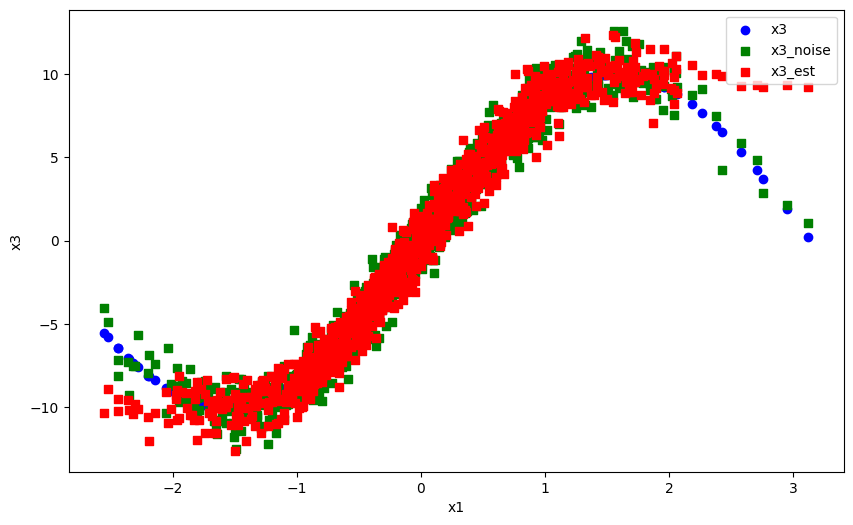

The programm is closed


In [42]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x3', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 1], X_true.detach().numpy()[:, 0], label='x3_noise', color='green', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x3_est', color='red', marker='s') 
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.show()
print("The programm is closed")

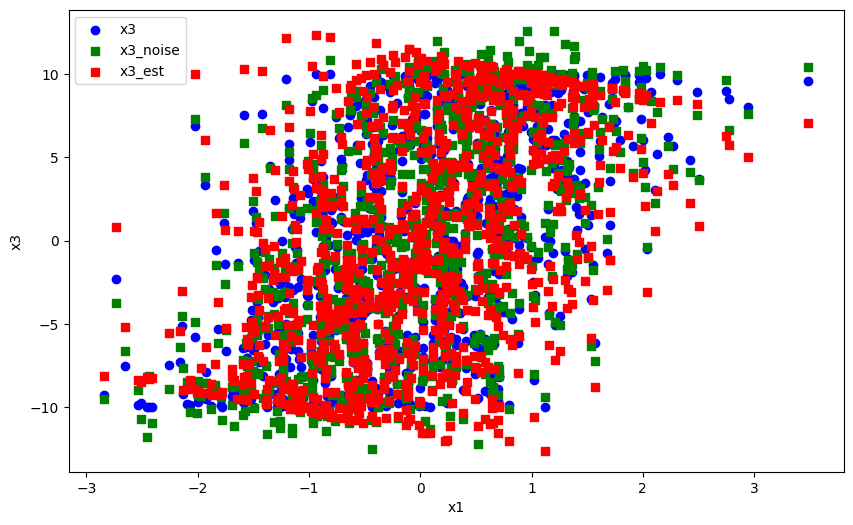

The programm is closed


In [43]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 2], X.detach().numpy()[:, 0], label='x3', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 2], X_true.detach().numpy()[:, 0], label='x3_noise', color='green', marker='s') 
plt.scatter(X.detach().numpy()[:, 2], x_est.detach().numpy()[:, 0], label='x3_est', color='red', marker='s') 
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.show()
print("The programm is closed")

### 3 nodes x1 <-x2<->x3 (L2 Norm)

In [2]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 3  # Dimension of the normal vectors
d = 3
# Random data for X and X_hat
True_Sigma = np.array([[1.0, 0.0, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.0, 0.6],
                [0.0, 0.6, 1.0]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x3 = epsilon[:, 2]
x2 = epsilon[:, 1]
x1 = x2**3
x1_true = x1+ epsilon[:, 0]
X = torch.stack((x1, x2, x3), dim=1)
X_true = torch.stack((x1_true, x2, x3), dim=1)

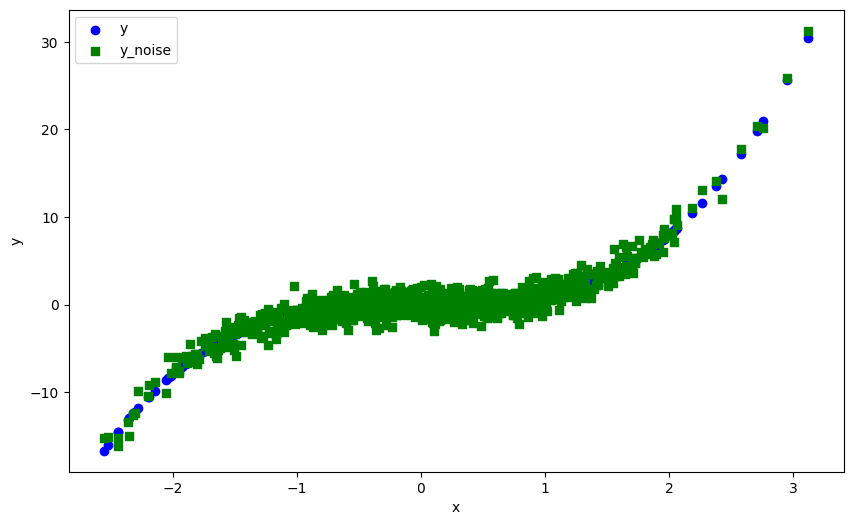

The programm is closed


In [3]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 1], X_true.detach().numpy()[:, 0], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

In [4]:
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma, X_est = model.fit(X, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

  0%|          | 0/80000 [00:00<?, ?it/s]

100%|██████████| 80000/80000 [00:15<00:00, 5308.21it/s]


In [5]:
print("W_est_dagma", W_est_dagma)

W_est_dagma [[0.20858951 0.60480742 0.16762832]
 [0.07655888 0.0066528  0.67123475]
 [0.02061409 0.00833126 0.01616102]]


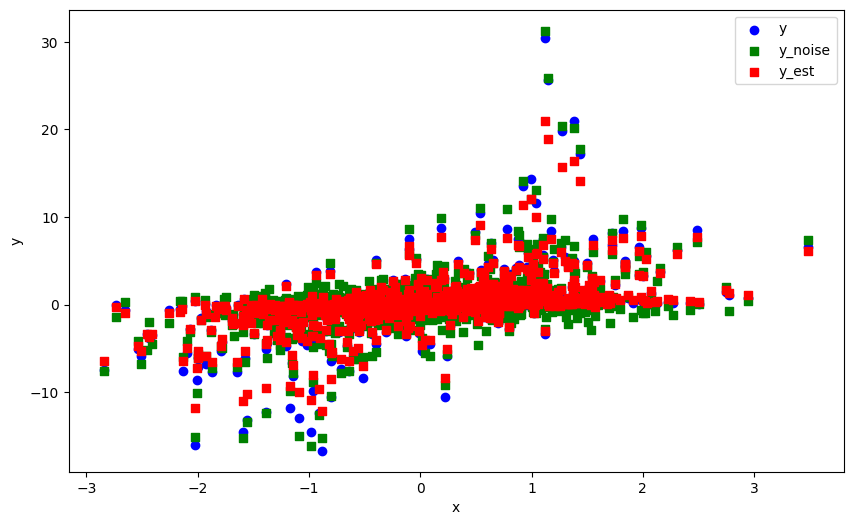

The programm is closed


In [6]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 2], X.detach().numpy()[:, 0], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 2], X_true.detach().numpy()[:, 0], label='y_noise', color='green', marker='s') 
plt.scatter(X.detach().numpy()[:, 2], X_est.detach().numpy()[:, 0], label='y_est', color='red', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

In [7]:
# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight = eq_model.fc1.weight
fc1_bias = eq_model.fc1.bias
fc2_weight = eq_model.fc2[0].weight
fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  0%|          | 121/29000 [00:01<04:16, 112.76it/s]

Sigma:  tensor([[ 0.9657,  0.0051, -0.0025],
        [ 0.0051,  0.9608,  0.0197],
        [-0.0025,  0.0197,  0.9612]], grad_fn=<MmBackward0>)
obj:  tensor(3.8091, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5910, grad_fn=<AddBackward0>)
h_val:  tensor(0.6579, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1364, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6924, 0.1026, 0.0214],
        [0.4755, 0.0009, 0.0019],
        [0.0745, 0.3541, 0.0235]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.8971e-03, 1.0980e-04, 4.7132e-06],
        [3.2338e-02, 5.9695e-07, 1.5172e-06],
        [2.8227e-03, 5.4487e-02, 1.1918e-04]])


  1%|          | 217/29000 [00:02<04:12, 113.78it/s]

Sigma:  tensor([[0.9422, 0.0249, 0.0149],
        [0.0249, 0.9239, 0.0396],
        [0.0149, 0.0396, 0.9252]], grad_fn=<MmBackward0>)
obj:  tensor(3.6862, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2324, grad_fn=<AddBackward0>)
h_val:  tensor(0.9424, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1322, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.8069e-01, 9.8314e-03, 4.7253e-03],
        [4.4947e-01, 2.6451e-04, 6.9835e-04],
        [5.5241e-02, 3.3385e-01, 4.1595e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.3661e-03, 2.1012e-06, 2.3542e-07],
        [2.9834e-02, 8.3680e-09, 2.5097e-07],
        [2.0938e-03, 5.0801e-02, 2.8718e-04]])


  1%|          | 313/29000 [00:02<04:11, 114.29it/s]

Sigma:  tensor([[0.9100, 0.0452, 0.0354],
        [0.0452, 0.8895, 0.0603],
        [0.0354, 0.0603, 0.8927]], grad_fn=<MmBackward0>)
obj:  tensor(3.6075, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2892, grad_fn=<AddBackward0>)
h_val:  tensor(0.8291, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1303, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.4927e-01, 2.4476e-02, 2.4042e-03],
        [4.2653e-01, 2.9703e-04, 8.8127e-05],
        [3.6373e-02, 3.1299e-01, 6.1970e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[5.8643e-03, 6.9091e-06, 6.0269e-08],
        [2.7802e-02, 6.7562e-09, 4.6309e-09],
        [1.4659e-03, 4.7158e-02, 5.3273e-04]])


  1%|▏         | 421/29000 [00:03<04:09, 114.42it/s]

Sigma:  tensor([[0.8809, 0.0653, 0.0570],
        [0.0653, 0.8577, 0.0821],
        [0.0570, 0.0821, 0.8639]], grad_fn=<MmBackward0>)
obj:  tensor(3.5295, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1289, grad_fn=<AddBackward0>)
h_val:  tensor(0.8872, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1326, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.6445e-01, 3.9263e-02, 2.8488e-03],
        [4.0572e-01, 4.6574e-05, 7.9766e-05],
        [1.8662e-02, 2.9127e-01, 8.3985e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.1936e-03, 1.6775e-05, 8.6902e-08],
        [2.5999e-02, 9.9026e-09, 1.7004e-09],
        [9.4616e-04, 4.3606e-02, 8.4783e-04]])


  2%|▏         | 517/29000 [00:04<04:08, 114.83it/s]

Sigma:  tensor([[0.8507, 0.0840, 0.0784],
        [0.0840, 0.8283, 0.1051],
        [0.0784, 0.1051, 0.8389]], grad_fn=<MmBackward0>)
obj:  tensor(3.4598, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0894, grad_fn=<AddBackward0>)
h_val:  tensor(0.8821, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1304, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.6180e-01, 2.2981e-02, 9.2049e-04],
        [3.8703e-01, 3.8112e-05, 8.0449e-05],
        [6.4648e-03, 2.6891e-01, 1.0669e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.2034e-03, 5.9038e-06, 1.4321e-08],
        [2.4250e-02, 1.2704e-09, 4.5756e-09],
        [5.8495e-04, 4.0177e-02, 1.2320e-03]])


  2%|▏         | 613/29000 [00:05<04:09, 113.71it/s]

Sigma:  tensor([[0.8224, 0.1020, 0.0991],
        [0.1020, 0.8012, 0.1285],
        [0.0991, 0.1285, 0.8173]], grad_fn=<MmBackward0>)
obj:  tensor(3.3875, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9641, grad_fn=<AddBackward0>)
h_val:  tensor(0.9348, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1305, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.7431e-01, 8.4979e-03, 6.7852e-04],
        [3.6859e-01, 6.8176e-05, 3.4507e-05],
        [6.0877e-03, 2.4472e-01, 1.2858e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.5039e-03, 9.6465e-07, 1.0516e-08],
        [2.2642e-02, 2.6692e-09, 1.0482e-09],
        [5.1969e-04, 3.6828e-02, 1.6995e-03]])


  2%|▏         | 721/29000 [00:06<04:07, 114.34it/s]

Sigma:  tensor([[0.7950, 0.1196, 0.1173],
        [0.1196, 0.7765, 0.1516],
        [0.1173, 0.1516, 0.7982]], grad_fn=<MmBackward0>)
obj:  tensor(3.3179, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8974, grad_fn=<AddBackward0>)
h_val:  tensor(0.9389, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1300, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.7365e-01, 4.1641e-04, 3.0555e-04],
        [3.5170e-01, 1.8152e-05, 1.9816e-05],
        [7.1985e-03, 2.1745e-01, 1.5019e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.5760e-03, 1.6057e-07, 7.1336e-09],
        [2.1070e-02, 2.4223e-09, 6.7868e-10],
        [4.9542e-04, 3.3439e-02, 2.2165e-03]])


  3%|▎         | 817/29000 [00:07<04:07, 113.87it/s]

Sigma:  tensor([[0.7695, 0.1366, 0.1326],
        [0.1366, 0.7541, 0.1743],
        [0.1326, 0.1743, 0.7809]], grad_fn=<MmBackward0>)
obj:  tensor(3.2448, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7934, grad_fn=<AddBackward0>)
h_val:  tensor(0.9689, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1301, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.7943e-01, 2.1345e-03, 2.2678e-04],
        [3.3567e-01, 1.2820e-05, 6.5985e-06],
        [4.8008e-03, 1.8749e-01, 1.7140e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.7848e-03, 2.2061e-07, 7.0575e-09],
        [1.9662e-02, 2.0663e-09, 7.6042e-10],
        [3.9883e-04, 3.0015e-02, 2.7438e-03]])


  3%|▎         | 913/29000 [00:08<04:05, 114.33it/s]

Sigma:  tensor([[0.7451, 0.1527, 0.1460],
        [0.1527, 0.7337, 0.1971],
        [0.1460, 0.1971, 0.7661]], grad_fn=<MmBackward0>)
obj:  tensor(3.1690, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7057, grad_fn=<AddBackward0>)
h_val:  tensor(0.9895, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1294, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.8251e-01, 1.2446e-03, 3.2962e-05],
        [3.1963e-01, 7.8000e-06, 3.1823e-06],
        [5.0652e-03, 1.5429e-01, 1.9277e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.9526e-03, 1.7298e-07, 7.4648e-09],
        [1.8514e-02, 2.7288e-09, 9.3255e-10],
        [3.6536e-04, 2.6754e-02, 3.3505e-03]])


  4%|▎         | 1021/29000 [00:09<04:04, 114.32it/s]

Sigma:  tensor([[0.7218, 0.1681, 0.1577],
        [0.1681, 0.7153, 0.2202],
        [0.1577, 0.2202, 0.7536]], grad_fn=<MmBackward0>)
obj:  tensor(3.0910, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6257, grad_fn=<AddBackward0>)
h_val:  tensor(1.0057, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1282, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.8430e-01, 1.6241e-03, 4.3734e-05],
        [3.0508e-01, 4.2792e-06, 9.5343e-06],
        [4.1292e-03, 1.1943e-01, 2.1351e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[7.1088e-03, 1.5903e-07, 8.8130e-09],
        [1.7473e-02, 3.0413e-09, 1.0357e-09],
        [3.1129e-04, 2.3734e-02, 4.0384e-03]])


  4%|▍         | 1117/29000 [00:09<04:03, 114.42it/s]

Sigma:  tensor([[0.6998, 0.1827, 0.1684],
        [0.1827, 0.6989, 0.2437],
        [0.1684, 0.2437, 0.7439]], grad_fn=<MmBackward0>)
obj:  tensor(3.0101, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5395, grad_fn=<AddBackward0>)
h_val:  tensor(1.0295, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1266, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.8774e-01, 3.2238e-04, 5.2676e-04],
        [2.9118e-01, 5.1238e-06, 6.4924e-06],
        [4.0144e-03, 8.3263e-02, 2.3403e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[7.3123e-03, 9.4225e-08, 1.3225e-08],
        [1.6617e-02, 2.1175e-09, 9.8518e-10],
        [2.6963e-04, 2.1097e-02, 4.8692e-03]])


  4%|▍         | 1213/29000 [00:10<04:00, 115.48it/s]

Sigma:  tensor([[0.6789, 0.1965, 0.1783],
        [0.1965, 0.6842, 0.2676],
        [0.1783, 0.2676, 0.7372]], grad_fn=<MmBackward0>)
obj:  tensor(2.9279, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4524, grad_fn=<AddBackward0>)
h_val:  tensor(1.0518, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1251, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.9069e-01, 4.1467e-03, 2.2677e-04],
        [2.7841e-01, 4.2733e-06, 1.5378e-06],
        [3.3382e-03, 4.9023e-02, 2.5334e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[7.5275e-03, 2.8262e-07, 1.2930e-08],
        [1.5933e-02, 6.8999e-10, 4.0809e-10],
        [2.1728e-04, 1.9163e-02, 5.8641e-03]])


  5%|▍         | 1321/29000 [00:11<03:59, 115.67it/s]

Sigma:  tensor([[0.6591, 0.2096, 0.1878],
        [0.2096, 0.6712, 0.2917],
        [0.1878, 0.2917, 0.7334]], grad_fn=<MmBackward0>)
obj:  tensor(2.8531, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3737, grad_fn=<AddBackward0>)
h_val:  tensor(1.0697, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1239, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.9288e-01, 6.6140e-03, 4.2091e-06],
        [2.6737e-01, 4.3798e-06, 5.5960e-06],
        [2.5424e-03, 2.7056e-02, 2.6860e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[7.7520e-03, 5.9797e-07, 1.4971e-08],
        [1.5415e-02, 2.7547e-12, 7.0181e-12],
        [1.5232e-04, 1.7994e-02, 6.8786e-03]])


  5%|▍         | 1417/29000 [00:12<03:58, 115.62it/s]

Sigma:  tensor([[0.6404, 0.2219, 0.1962],
        [0.2219, 0.6597, 0.3152],
        [0.1962, 0.3152, 0.7318]], grad_fn=<MmBackward0>)
obj:  tensor(2.7906, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2994, grad_fn=<AddBackward0>)
h_val:  tensor(1.0898, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1232, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.9625e-01, 1.3646e-03, 2.6127e-04],
        [2.5902e-01, 2.9553e-05, 3.5493e-06],
        [1.5696e-03, 2.2270e-02, 2.7773e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[8.0154e-03, 5.3025e-08, 1.8308e-08],
        [1.4951e-02, 1.0551e-10, 1.3240e-10],
        [7.6169e-05, 1.7030e-02, 7.3417e-03]])


  5%|▌         | 1513/29000 [00:13<03:56, 116.09it/s]

Sigma:  tensor([[0.6229, 0.2338, 0.2018],
        [0.2338, 0.6498, 0.3360],
        [0.2018, 0.3360, 0.7299]], grad_fn=<MmBackward0>)
obj:  tensor(2.7313, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2190, grad_fn=<AddBackward0>)
h_val:  tensor(1.1087, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1233, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.9952e-01, 2.6083e-04, 6.4855e-04],
        [2.5503e-01, 5.0447e-05, 8.5054e-06],
        [7.3089e-04, 2.0278e-02, 2.8458e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[8.2798e-03, 1.3638e-08, 2.5777e-08],
        [1.4546e-02, 1.5439e-10, 1.9883e-11],
        [2.1558e-05, 1.6109e-02, 7.3959e-03]])


  6%|▌         | 1621/29000 [00:14<03:57, 115.40it/s]

Sigma:  tensor([[0.6066, 0.2449, 0.2031],
        [0.2449, 0.6411, 0.3522],
        [0.2031, 0.3522, 0.7251]], grad_fn=<MmBackward0>)
obj:  tensor(2.6740, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1410, grad_fn=<AddBackward0>)
h_val:  tensor(1.1262, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1236, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.0257e-01, 3.3221e-03, 1.0480e-04],
        [2.5235e-01, 7.8106e-05, 2.6468e-05],
        [1.1279e-04, 1.7931e-02, 2.9016e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[8.5601e-03, 1.5146e-07, 2.6371e-08],
        [1.4772e-02, 3.9623e-10, 5.8969e-11],
        [6.5582e-07, 1.5236e-02, 7.4918e-03]])


  6%|▌         | 1717/29000 [00:15<03:54, 116.55it/s]

Sigma:  tensor([[0.5911, 0.2549, 0.2009],
        [0.2549, 0.6333, 0.3639],
        [0.2009, 0.3639, 0.7173]], grad_fn=<MmBackward0>)
obj:  tensor(2.6181, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0711, grad_fn=<AddBackward0>)
h_val:  tensor(1.1400, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1236, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.0463e-01, 3.5133e-03, 2.0849e-04],
        [2.5047e-01, 7.8585e-05, 9.1248e-06],
        [2.6611e-04, 1.5177e-02, 2.9664e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[8.8384e-03, 1.6776e-07, 3.1500e-08],
        [1.5297e-02, 1.4928e-09, 7.6225e-11],
        [4.4648e-06, 1.4439e-02, 7.8137e-03]])


  6%|▋         | 1813/29000 [00:15<03:54, 115.85it/s]

Sigma:  tensor([[0.5763, 0.2640, 0.1966],
        [0.2640, 0.6263, 0.3717],
        [0.1966, 0.3717, 0.7071]], grad_fn=<MmBackward0>)
obj:  tensor(2.5621, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0064, grad_fn=<AddBackward0>)
h_val:  tensor(1.1591, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1238, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.0735e-01, 1.2321e-03, 1.1552e-05],
        [2.5062e-01, 3.7700e-04, 1.0360e-05],
        [4.6426e-04, 1.3660e-02, 3.0592e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[9.1379e-03, 2.5445e-08, 3.7770e-08],
        [1.6070e-02, 2.2476e-08, 1.1333e-10],
        [1.6042e-05, 1.3852e-02, 8.3414e-03]])


  7%|▋         | 1921/29000 [00:16<03:56, 114.52it/s]

Sigma:  tensor([[0.5624, 0.2723, 0.1912],
        [0.2723, 0.6198, 0.3757],
        [0.1912, 0.3757, 0.6941]], grad_fn=<MmBackward0>)
obj:  tensor(2.5054, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0919, grad_fn=<AddBackward0>)
h_val:  tensor(1.1803, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1245, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.1011e-01, 3.5036e-04, 2.1950e-04],
        [2.5285e-01, 1.7996e-03, 1.1972e-05],
        [6.1913e-04, 1.2371e-02, 3.1723e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[9.4443e-03, 2.2641e-08, 4.5693e-08],
        [1.7388e-02, 4.1106e-07, 1.1227e-10],
        [3.3806e-05, 1.3403e-02, 9.1027e-03]])


  7%|▋         | 2017/29000 [00:17<03:55, 114.79it/s]

Sigma:  tensor([[0.5491, 0.2794, 0.1853],
        [0.2794, 0.6135, 0.3759],
        [0.1853, 0.3759, 0.6783]], grad_fn=<MmBackward0>)
obj:  tensor(2.4474, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1815, grad_fn=<AddBackward0>)
h_val:  tensor(1.2021, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1253, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.1274e-01, 3.6476e-04, 5.2193e-05],
        [2.5615e-01, 4.8439e-03, 5.8366e-06],
        [7.6395e-04, 1.0988e-02, 3.2943e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[9.7563e-03, 5.1413e-08, 5.5103e-08],
        [1.8975e-02, 2.5729e-06, 2.0430e-10],
        [6.2714e-05, 1.3010e-02, 1.0098e-02]])


  7%|▋         | 2113/29000 [00:18<03:54, 114.70it/s]

Sigma:  tensor([[0.5364, 0.2850, 0.1797],
        [0.2850, 0.6067, 0.3729],
        [0.1797, 0.3729, 0.6600]], grad_fn=<MmBackward0>)
obj:  tensor(2.3875, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2761, grad_fn=<AddBackward0>)
h_val:  tensor(1.2245, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1263, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.1510e-01, 1.9687e-04, 3.6590e-04],
        [2.6119e-01, 9.5647e-03, 1.0158e-05],
        [9.0315e-04, 9.5953e-03, 3.4305e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.0067e-02, 9.5141e-08, 6.6816e-08],
        [2.0856e-02, 9.0608e-06, 2.5319e-10],
        [1.1218e-04, 1.2711e-02, 1.1348e-02]])


  8%|▊         | 2221/29000 [00:19<03:51, 115.52it/s]

Sigma:  tensor([[0.5243, 0.2889, 0.1744],
        [0.2889, 0.5988, 0.3671],
        [0.1744, 0.3671, 0.6397]], grad_fn=<MmBackward0>)
obj:  tensor(2.3250, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3752, grad_fn=<AddBackward0>)
h_val:  tensor(1.2474, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1275, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.1723e-01, 3.7731e-04, 7.0698e-04],
        [2.6760e-01, 1.5527e-02, 9.5599e-06],
        [1.0269e-03, 8.2220e-03, 3.5774e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.0376e-02, 1.5777e-07, 8.6166e-08],
        [2.3050e-02, 2.2609e-05, 3.0191e-10],
        [1.9235e-04, 1.2445e-02, 1.2875e-02]])


  8%|▊         | 2317/29000 [00:20<03:49, 116.15it/s]

Sigma:  tensor([[0.5129, 0.2910, 0.1695],
        [0.2910, 0.5895, 0.3592],
        [0.1695, 0.3592, 0.6179]], grad_fn=<MmBackward0>)
obj:  tensor(2.2598, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4793, grad_fn=<AddBackward0>)
h_val:  tensor(1.2728, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1286, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.1954e-01, 2.7988e-04, 5.2641e-04],
        [2.7508e-01, 2.2050e-02, 1.4897e-05],
        [1.1401e-03, 7.1045e-03, 3.7334e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.0695e-02, 2.4112e-07, 1.0397e-07],
        [2.5332e-02, 4.4714e-05, 3.3283e-10],
        [3.0992e-04, 1.2189e-02, 1.4672e-02]])


  8%|▊         | 2413/29000 [00:21<03:50, 115.27it/s]

Sigma:  tensor([[0.5020, 0.2913, 0.1648],
        [0.2913, 0.5785, 0.3495],
        [0.1648, 0.3495, 0.5951]], grad_fn=<MmBackward0>)
obj:  tensor(2.1924, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5861, grad_fn=<AddBackward0>)
h_val:  tensor(1.2993, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1297, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.2175e-01, 6.5200e-04, 5.0174e-05],
        [2.8366e-01, 2.8490e-02, 1.1114e-06],
        [1.2784e-03, 6.4945e-03, 3.8954e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.1012e-02, 3.4812e-07, 1.2834e-07],
        [2.7762e-02, 7.5670e-05, 3.7176e-10],
        [4.5621e-04, 1.1942e-02, 1.6681e-02]])


  9%|▊         | 2521/29000 [00:22<03:47, 116.46it/s]

Sigma:  tensor([[0.4916, 0.2896, 0.1604],
        [0.2896, 0.5655, 0.3384],
        [0.1604, 0.3384, 0.5716]], grad_fn=<MmBackward0>)
obj:  tensor(2.1239, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6931, grad_fn=<AddBackward0>)
h_val:  tensor(1.3259, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1307, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.2378e-01, 4.9756e-04, 1.4038e-05],
        [2.9330e-01, 3.4318e-02, 2.2447e-05],
        [1.4553e-03, 6.3642e-03, 4.0583e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.1325e-02, 4.9061e-07, 1.6083e-07],
        [3.0215e-02, 1.1419e-04, 4.2723e-10],
        [6.0303e-04, 1.1712e-02, 1.8793e-02]])


  9%|▉         | 2617/29000 [00:22<03:47, 116.06it/s]

Sigma:  tensor([[0.4817, 0.2863, 0.1560],
        [0.2863, 0.5507, 0.3261],
        [0.1560, 0.3261, 0.5476]], grad_fn=<MmBackward0>)
obj:  tensor(2.0541, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8004, grad_fn=<AddBackward0>)
h_val:  tensor(1.3534, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1315, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.2585e-01, 3.6127e-04, 5.6910e-05],
        [3.0400e-01, 3.9198e-02, 5.8283e-06],
        [1.6325e-03, 6.4492e-03, 4.2184e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.1638e-02, 6.7461e-07, 1.9686e-07],
        [3.2746e-02, 1.5900e-04, 4.3858e-10],
        [7.2361e-04, 1.1510e-02, 2.0911e-02]])


  9%|▉         | 2713/29000 [00:23<03:48, 114.99it/s]

Sigma:  tensor([[0.4723, 0.2815, 0.1514],
        [0.2815, 0.5344, 0.3128],
        [0.1514, 0.3128, 0.5234]], grad_fn=<MmBackward0>)
obj:  tensor(1.9828, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9064, grad_fn=<AddBackward0>)
h_val:  tensor(1.3806, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1321, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.2773e-01, 1.3788e-04, 1.3191e-04],
        [3.1576e-01, 4.2988e-02, 1.1166e-05],
        [1.7809e-03, 6.5566e-03, 4.3753e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.1944e-02, 9.0024e-07, 2.2768e-07],
        [3.5314e-02, 2.0879e-04, 4.6689e-10],
        [8.1155e-04, 1.1327e-02, 2.3035e-02]])


 10%|▉         | 2821/29000 [00:24<03:47, 115.14it/s]

Sigma:  tensor([[0.4632, 0.2754, 0.1465],
        [0.2754, 0.5168, 0.2987],
        [0.1465, 0.2987, 0.4991]], grad_fn=<MmBackward0>)
obj:  tensor(1.9097, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0122, grad_fn=<AddBackward0>)
h_val:  tensor(1.4082, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1324, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.2956e-01, 7.8617e-05, 2.9387e-05],
        [3.2852e-01, 4.5740e-02, 1.6910e-05],
        [1.9117e-03, 6.6318e-03, 4.5309e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.2244e-02, 1.1493e-06, 2.5537e-07],
        [3.7951e-02, 2.6344e-04, 5.1111e-10],
        [8.7905e-04, 1.1144e-02, 2.5222e-02]])


 10%|█         | 2917/29000 [00:25<03:46, 115.13it/s]

Sigma:  tensor([[0.4546, 0.2681, 0.1414],
        [0.2681, 0.4980, 0.2840],
        [0.1414, 0.2840, 0.4749]], grad_fn=<MmBackward0>)
obj:  tensor(1.8343, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1187, grad_fn=<AddBackward0>)
h_val:  tensor(1.4366, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1326, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.3136e-01, 1.8758e-04, 2.4947e-05],
        [3.4229e-01, 4.7659e-02, 1.2824e-05],
        [2.0724e-03, 6.6827e-03, 4.6868e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.2538e-02, 1.3902e-06, 2.5708e-07],
        [4.0684e-02, 3.2381e-04, 5.3365e-10],
        [9.4686e-04, 1.0941e-02, 2.7504e-02]])


 10%|█         | 3013/29000 [00:26<03:46, 114.77it/s]

Sigma:  tensor([[0.4463, 0.2598, 0.1365],
        [0.2598, 0.4782, 0.2690],
        [0.1365, 0.2690, 0.4512]], grad_fn=<MmBackward0>)
obj:  tensor(1.7565, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2255, grad_fn=<AddBackward0>)
h_val:  tensor(1.4653, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1325, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.3306e-01, 1.7825e-04, 2.5646e-05],
        [3.5711e-01, 4.9021e-02, 1.0089e-05],
        [2.3451e-03, 6.7150e-03, 4.8416e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.2825e-02, 1.6380e-06, 2.2603e-07],
        [4.3518e-02, 3.9097e-04, 5.2005e-10],
        [1.0402e-03, 1.0700e-02, 2.9845e-02]])


 11%|█         | 3121/29000 [00:27<03:44, 115.38it/s]

Sigma:  tensor([[0.4384, 0.2503, 0.1325],
        [0.2503, 0.4576, 0.2542],
        [0.1325, 0.2542, 0.4284]], grad_fn=<MmBackward0>)
obj:  tensor(1.6766, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3329, grad_fn=<AddBackward0>)
h_val:  tensor(1.4942, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1323, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.3469e-01, 2.1087e-04, 3.2113e-05],
        [3.7308e-01, 5.0066e-02, 1.7850e-05],
        [2.8454e-03, 6.7212e-03, 4.9934e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.3103e-02, 1.9368e-06, 1.6484e-07],
        [4.6457e-02, 4.6608e-04, 5.7553e-10],
        [1.1848e-03, 1.0413e-02, 3.2179e-02]])


 11%|█         | 3217/29000 [00:28<03:41, 116.63it/s]

Sigma:  tensor([[0.4308, 0.2399, 0.1299],
        [0.2399, 0.4362, 0.2399],
        [0.1299, 0.2399, 0.4069]], grad_fn=<MmBackward0>)
obj:  tensor(1.5947, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4409, grad_fn=<AddBackward0>)
h_val:  tensor(1.5232, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1319, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.3629e-01, 2.4401e-04, 2.0464e-05],
        [3.9032e-01, 5.0943e-02, 2.8581e-06],
        [3.6475e-03, 6.6951e-03, 5.1404e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.3373e-02, 2.3730e-06, 9.1014e-08],
        [4.9512e-02, 5.4985e-04, 6.1478e-10],
        [1.3973e-03, 1.0090e-02, 3.4473e-02]])


 11%|█▏        | 3313/29000 [00:28<03:42, 115.56it/s]

Sigma:  tensor([[0.4235, 0.2285, 0.1287],
        [0.2285, 0.4142, 0.2262],
        [0.1287, 0.2262, 0.3869]], grad_fn=<MmBackward0>)
obj:  tensor(1.5108, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5492, grad_fn=<AddBackward0>)
h_val:  tensor(1.5522, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1314, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.3787e-01, 4.1186e-04, 1.1961e-05],
        [4.0889e-01, 5.1668e-02, 2.2268e-06],
        [4.6911e-03, 6.6350e-03, 5.2811e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.3637e-02, 3.0755e-06, 2.6921e-08],
        [5.2700e-02, 6.4190e-04, 5.8699e-10],
        [1.6666e-03, 9.7364e-03, 3.6704e-02]])


 12%|█▏        | 3421/29000 [00:29<03:39, 116.46it/s]

Sigma:  tensor([[0.4166, 0.2164, 0.1282],
        [0.2164, 0.3921, 0.2129],
        [0.1282, 0.2129, 0.3680]], grad_fn=<MmBackward0>)
obj:  tensor(1.4250, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6569, grad_fn=<AddBackward0>)
h_val:  tensor(1.5808, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1307, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.3940e-01, 7.6546e-04, 9.4724e-05],
        [4.2857e-01, 5.2166e-02, 4.1925e-06],
        [5.8601e-03, 6.5492e-03, 5.4150e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.3892e-02, 4.2934e-06, 1.4089e-09],
        [5.6010e-02, 7.4062e-04, 4.9703e-10],
        [1.9718e-03, 9.3576e-03, 3.8875e-02]])


 12%|█▏        | 3517/29000 [00:30<03:40, 115.33it/s]

Sigma:  tensor([[0.4100, 0.2037, 0.1275],
        [0.2037, 0.3700, 0.1997],
        [0.1275, 0.1997, 0.3500]], grad_fn=<MmBackward0>)
obj:  tensor(1.3372, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7646, grad_fn=<AddBackward0>)
h_val:  tensor(1.6082, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1299, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.4070e-01, 2.3313e-03, 3.0505e-04],
        [4.4918e-01, 5.2454e-02, 5.3467e-06],
        [7.1221e-03, 6.4659e-03, 5.5442e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4135e-02, 6.4597e-06, 1.0205e-08],
        [5.9456e-02, 8.4524e-04, 4.3351e-10],
        [2.2999e-03, 8.9499e-03, 4.1005e-02]])


 12%|█▏        | 3613/29000 [00:31<03:40, 115.00it/s]

Sigma:  tensor([[0.4037, 0.1903, 0.1264],
        [0.1903, 0.3480, 0.1866],
        [0.1264, 0.1866, 0.3329]], grad_fn=<MmBackward0>)
obj:  tensor(1.2465, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8737, grad_fn=<AddBackward0>)
h_val:  tensor(1.6327, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1292, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.4143e-01, 8.0508e-03, 1.2730e-04],
        [4.7089e-01, 5.2826e-02, 2.7256e-06],
        [8.4822e-03, 6.3920e-03, 5.6703e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4357e-02, 1.0681e-05, 6.4507e-08],
        [6.3038e-02, 9.5712e-04, 4.5650e-10],
        [2.6406e-03, 8.5218e-03, 4.3091e-02]])


 13%|█▎        | 3721/29000 [00:32<03:40, 114.68it/s]

Sigma:  tensor([[0.3972, 0.1757, 0.1251],
        [0.1757, 0.3258, 0.1736],
        [0.1251, 0.1736, 0.3167]], grad_fn=<MmBackward0>)
obj:  tensor(1.1533, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9856, grad_fn=<AddBackward0>)
h_val:  tensor(1.6545, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1288, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.4165e-01, 1.7621e-02, 4.6957e-05],
        [4.9388e-01, 5.3725e-02, 5.2355e-06],
        [9.9630e-03, 6.2940e-03, 5.7929e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4559e-02, 1.9655e-05, 1.2659e-07],
        [6.6760e-02, 1.0806e-03, 3.9344e-10],
        [2.9924e-03, 8.0789e-03, 4.5097e-02]])


 13%|█▎        | 3817/29000 [00:33<03:37, 115.86it/s]

Sigma:  tensor([[0.3903, 0.1594, 0.1233],
        [0.1594, 0.3034, 0.1608],
        [0.1233, 0.1608, 0.3016]], grad_fn=<MmBackward0>)
obj:  tensor(1.0572, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0995, grad_fn=<AddBackward0>)
h_val:  tensor(1.6773, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1282, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.4204e-01, 2.7001e-02, 3.5194e-05],
        [5.1801e-01, 5.5056e-02, 2.8444e-06],
        [1.1680e-02, 6.1377e-03, 5.9105e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4765e-02, 3.4263e-05, 9.1711e-08],
        [7.0638e-02, 1.2181e-03, 3.5095e-10],
        [3.3782e-03, 7.6262e-03, 4.6971e-02]])


 13%|█▎        | 3913/29000 [00:34<03:40, 113.91it/s]

Sigma:  tensor([[0.3828, 0.1421, 0.1211],
        [0.1421, 0.2816, 0.1483],
        [0.1211, 0.1483, 0.2874]], grad_fn=<MmBackward0>)
obj:  tensor(0.9582, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2142, grad_fn=<AddBackward0>)
h_val:  tensor(1.7007, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1273, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.4259e-01, 3.6138e-02, 1.8708e-05],
        [5.4295e-01, 5.6223e-02, 1.0065e-05],
        [1.3711e-02, 5.8797e-03, 6.0218e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4977e-02, 5.5190e-05, 1.6439e-08],
        [7.4652e-02, 1.3658e-03, 5.7773e-10],
        [3.8105e-03, 7.1755e-03, 4.8710e-02]])


 14%|█▍        | 4021/29000 [00:35<03:36, 115.62it/s]

Sigma:  tensor([[0.3748, 0.1242, 0.1185],
        [0.1242, 0.2610, 0.1360],
        [0.1185, 0.1360, 0.2738]], grad_fn=<MmBackward0>)
obj:  tensor(0.8560, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3294, grad_fn=<AddBackward0>)
h_val:  tensor(1.7243, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1262, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.4317e-01, 4.5701e-02, 4.8399e-05],
        [5.6840e-01, 5.7053e-02, 6.6399e-06],
        [1.6032e-02, 5.4917e-03, 6.1276e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.5195e-02, 8.4331e-05, 9.5644e-10],
        [7.8807e-02, 1.5233e-03, 6.7379e-10],
        [4.2779e-03, 6.7334e-03, 5.0356e-02]])


 14%|█▍        | 4117/29000 [00:35<03:36, 115.10it/s]

Sigma:  tensor([[0.3663, 0.1063, 0.1154],
        [0.1063, 0.2420, 0.1240],
        [0.1154, 0.1240, 0.2605]], grad_fn=<MmBackward0>)
obj:  tensor(0.7499, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4449, grad_fn=<AddBackward0>)
h_val:  tensor(1.7489, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1247, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.4393e-01, 5.4596e-02, 2.5165e-05],
        [5.9405e-01, 5.7734e-02, 5.3560e-06],
        [1.8673e-02, 5.0012e-03, 6.2283e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.5425e-02, 1.2238e-04, 3.3203e-08],
        [8.3139e-02, 1.6994e-03, 6.0307e-10],
        [4.7773e-03, 6.2974e-03, 5.1959e-02]])


 15%|█▍        | 4213/29000 [00:36<03:36, 114.47it/s]

Sigma:  tensor([[0.3576, 0.0888, 0.1116],
        [0.0888, 0.2248, 0.1122],
        [0.1116, 0.1122, 0.2475]], grad_fn=<MmBackward0>)
obj:  tensor(0.6393, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5608, grad_fn=<AddBackward0>)
h_val:  tensor(1.7748, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1227, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.4482e-01, 6.2703e-02, 3.4912e-05],
        [6.1964e-01, 5.8339e-02, 3.8746e-06],
        [2.1614e-02, 4.4555e-03, 6.3257e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.5666e-02, 1.7167e-04, 4.7892e-08],
        [8.7697e-02, 1.9013e-03, 6.3625e-10],
        [5.3010e-03, 5.8747e-03, 5.3596e-02]])


 15%|█▍        | 4321/29000 [00:37<03:33, 115.56it/s]

Sigma:  tensor([[0.3488, 0.0720, 0.1072],
        [0.0720, 0.2095, 0.1007],
        [0.1072, 0.1007, 0.2346]], grad_fn=<MmBackward0>)
obj:  tensor(0.5240, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6763, grad_fn=<AddBackward0>)
h_val:  tensor(1.8018, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1201, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.4582e-01, 7.0086e-02, 1.4528e-05],
        [6.4487e-01, 5.8829e-02, 5.6060e-06],
        [2.4737e-02, 3.9339e-03, 6.4202e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.5912e-02, 2.3597e-04, 1.5857e-09],
        [9.2457e-02, 2.1311e-03, 5.6522e-10],
        [5.8210e-03, 5.4556e-03, 5.5343e-02]])


 15%|█▌        | 4417/29000 [00:38<03:32, 115.61it/s]

Sigma:  tensor([[0.3401, 0.0565, 0.1022],
        [0.0565, 0.1963, 0.0897],
        [0.1022, 0.0897, 0.2217]], grad_fn=<MmBackward0>)
obj:  tensor(0.4040, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7907, grad_fn=<AddBackward0>)
h_val:  tensor(1.8299, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1169, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.4694e-01, 7.6329e-02, 9.9239e-05],
        [6.6944e-01, 5.9223e-02, 1.5454e-06],
        [2.7828e-02, 3.4895e-03, 6.5119e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.6167e-02, 3.1990e-04, 1.8447e-08],
        [9.7486e-02, 2.3975e-03, 1.9267e-10],
        [6.2955e-03, 5.0243e-03, 5.7179e-02]])


 16%|█▌        | 4513/29000 [00:39<03:31, 115.61it/s]

Sigma:  tensor([[0.3314, 0.0428, 0.0967],
        [0.0428, 0.1849, 0.0797],
        [0.0967, 0.0797, 0.2092]], grad_fn=<MmBackward0>)
obj:  tensor(0.3006, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9033, grad_fn=<AddBackward0>)
h_val:  tensor(1.8591, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1150, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.4813e-01, 8.1461e-02, 6.4875e-05],
        [6.9270e-01, 5.9783e-02, 4.8379e-06],
        [3.0515e-02, 3.1183e-03, 6.6011e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.6426e-02, 4.3062e-04, 8.4021e-08],
        [1.0293e-01, 2.7135e-03, 1.2934e-10],
        [6.6759e-03, 4.5666e-03, 5.9078e-02]])


 16%|█▌        | 4621/29000 [00:40<03:30, 115.81it/s]

Sigma:  tensor([[0.3231, 0.0319, 0.0911],
        [0.0319, 0.1754, 0.0711],
        [0.0911, 0.0711, 0.1973]], grad_fn=<MmBackward0>)
obj:  tensor(0.2172, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0144, grad_fn=<AddBackward0>)
h_val:  tensor(1.8890, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1147, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.4942e-01, 8.5396e-02, 4.8945e-05],
        [7.1264e-01, 6.1639e-02, 3.9346e-06],
        [3.2653e-02, 2.7850e-03, 6.6869e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.6683e-02, 5.7776e-04, 2.5803e-08],
        [1.0850e-01, 3.0999e-03, 7.3998e-10],
        [6.9303e-03, 4.0896e-03, 6.0925e-02]])


 16%|█▋        | 4717/29000 [00:41<03:30, 115.52it/s]

Sigma:  tensor([[0.3151, 0.0247, 0.0862],
        [0.0247, 0.1672, 0.0648],
        [0.0862, 0.0648, 0.1868]], grad_fn=<MmBackward0>)
obj:  tensor(0.1364, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1240, grad_fn=<AddBackward0>)
h_val:  tensor(1.9192, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1145, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.5081e-01, 8.8335e-02, 7.7689e-06],
        [7.2811e-01, 6.5076e-02, 2.8638e-06],
        [3.4003e-02, 2.4667e-03, 6.7671e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.6939e-02, 7.7327e-04, 3.9273e-10],
        [1.1400e-01, 3.5685e-03, 5.5564e-10],
        [7.0133e-03, 3.6154e-03, 6.2550e-02]])


 17%|█▋        | 4813/29000 [00:41<03:30, 115.17it/s]

Sigma:  tensor([[0.3076, 0.0205, 0.0823],
        [0.0205, 0.1601, 0.0604],
        [0.0823, 0.0604, 0.1779]], grad_fn=<MmBackward0>)
obj:  tensor(0.0587, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2315, grad_fn=<AddBackward0>)
h_val:  tensor(1.9486, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1144, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.5224e-01, 9.0410e-02, 5.4349e-05],
        [7.3978e-01, 6.9699e-02, 2.5967e-06],
        [3.4715e-02, 2.1526e-03, 6.8408e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.7199e-02, 1.0311e-03, 2.7690e-08],
        [1.1937e-01, 4.1141e-03, 2.4665e-11],
        [6.9833e-03, 3.1598e-03, 6.3785e-02]])


 17%|█▋        | 4921/29000 [00:42<03:29, 115.13it/s]

Sigma:  tensor([[0.3007, 0.0183, 0.0792],
        [0.0183, 0.1535, 0.0574],
        [0.0792, 0.0574, 0.1701]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0157, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3369, grad_fn=<AddBackward0>)
h_val:  tensor(1.9766, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1146, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.5359e-01, 9.2150e-02, 2.4966e-05],
        [7.4895e-01, 7.5039e-02, 9.2318e-06],
        [3.5074e-02, 1.8479e-03, 6.9083e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.7450e-02, 1.3668e-03, 6.2299e-10],
        [1.2463e-01, 4.7421e-03, 7.6810e-10],
        [6.9043e-03, 2.7270e-03, 6.4576e-02]])


 17%|█▋        | 5017/29000 [00:43<03:27, 115.47it/s]

Sigma:  tensor([[0.2943, 0.0168, 0.0764],
        [0.0168, 0.1472, 0.0547],
        [0.0764, 0.0547, 0.1628]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0876, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4419, grad_fn=<AddBackward0>)
h_val:  tensor(2.0039, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1151, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.5488e-01, 9.3817e-02, 3.7730e-05],
        [7.5677e-01, 8.0926e-02, 8.1676e-06],
        [3.5311e-02, 1.5624e-03, 6.9719e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.7710e-02, 1.7961e-03, 1.5759e-08],
        [1.2980e-01, 5.4666e-03, 2.6271e-09],
        [6.7963e-03, 2.3211e-03, 6.4966e-02]])


 18%|█▊        | 5113/29000 [00:44<03:28, 114.73it/s]

Sigma:  tensor([[0.2881, 0.0153, 0.0733],
        [0.0153, 0.1412, 0.0522],
        [0.0733, 0.0522, 0.1557]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1575, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5471, grad_fn=<AddBackward0>)
h_val:  tensor(2.0307, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1158, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.5608e-01, 9.5802e-02, 3.8959e-05],
        [7.6391e-01, 8.7204e-02, 9.4409e-06],
        [3.5547e-02, 1.3099e-03, 7.0326e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.7981e-02, 2.3331e-03, 1.2912e-08],
        [1.3491e-01, 6.3011e-03, 1.8820e-09],
        [6.6556e-03, 1.9511e-03, 6.5019e-02]])


 18%|█▊        | 5221/29000 [00:45<03:28, 113.84it/s]

Sigma:  tensor([[0.2819, 0.0138, 0.0698],
        [0.0138, 0.1355, 0.0496],
        [0.0698, 0.0496, 0.1486]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2259, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6535, grad_fn=<AddBackward0>)
h_val:  tensor(2.0575, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1167, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.5727e-01, 9.8185e-02, 1.4697e-04],
        [7.7062e-01, 9.3789e-02, 5.4119e-06],
        [3.5842e-02, 1.0988e-03, 7.0909e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.8271e-02, 2.9918e-03, 4.5505e-09],
        [1.4000e-01, 7.2578e-03, 4.7505e-10],
        [6.4753e-03, 1.6267e-03, 6.4772e-02]])


 18%|█▊        | 5317/29000 [00:46<03:25, 115.08it/s]

Sigma:  tensor([[0.2756, 0.0124, 0.0660],
        [0.0124, 0.1300, 0.0473],
        [0.0660, 0.0473, 0.1417]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2933, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7615, grad_fn=<AddBackward0>)
h_val:  tensor(2.0847, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1179, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.5848e-01, 1.0100e-01, 8.5071e-05],
        [7.7691e-01, 1.0071e-01, 2.3770e-06],
        [3.6178e-02, 9.2656e-04, 7.1466e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.8592e-02, 3.7841e-03, 1.1156e-07],
        [1.4512e-01, 8.3480e-03, 6.7740e-11],
        [6.2557e-03, 1.3583e-03, 6.4208e-02]])


 19%|█▊        | 5413/29000 [00:47<03:22, 116.26it/s]

Sigma:  tensor([[0.2688, 0.0110, 0.0623],
        [0.0110, 0.1247, 0.0451],
        [0.0623, 0.0451, 0.1353]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3591, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8713, grad_fn=<AddBackward0>)
h_val:  tensor(2.1123, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1193, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.5975e-01, 1.0418e-01, 3.2460e-05],
        [7.8270e-01, 1.0797e-01, 6.4976e-06],
        [3.6512e-02, 7.7160e-04, 7.1992e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.8932e-02, 4.7220e-03, 1.4099e-08],
        [1.5027e-01, 9.5846e-03, 1.0546e-09],
        [6.0121e-03, 1.1686e-03, 6.3277e-02]])


 19%|█▉        | 5521/29000 [00:48<03:21, 116.45it/s]

Sigma:  tensor([[0.2617, 0.0097, 0.0588],
        [0.0097, 0.1196, 0.0431],
        [0.0588, 0.0431, 0.1292]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4233, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9830, grad_fn=<AddBackward0>)
h_val:  tensor(2.1405, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1210, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.6109e-01, 1.0774e-01, 3.8917e-05],
        [7.8790e-01, 1.1555e-01, 7.4237e-06],
        [3.6952e-02, 6.6931e-04, 7.2491e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.9307e-02, 5.8157e-03, 1.9642e-08],
        [1.5541e-01, 1.0973e-02, 8.2077e-10],
        [5.7824e-03, 1.0874e-03, 6.1991e-02]])


 19%|█▉        | 5617/29000 [00:48<03:23, 114.90it/s]

Sigma:  tensor([[0.2543, 0.0084, 0.0551],
        [0.0084, 0.1148, 0.0413],
        [0.0551, 0.0413, 0.1234]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4870, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0968, grad_fn=<AddBackward0>)
h_val:  tensor(2.1693, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1229, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.6247e-01, 1.1175e-01, 3.3072e-05],
        [7.9243e-01, 1.2353e-01, 3.8744e-06],
        [3.7602e-02, 7.2898e-04, 7.2968e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.9715e-02, 7.0702e-03, 8.7887e-09],
        [1.6049e-01, 1.2521e-02, 2.0507e-10],
        [5.5909e-03, 1.1084e-03, 6.0470e-02]])


 20%|█▉        | 5713/29000 [00:49<03:22, 115.14it/s]

Sigma:  tensor([[0.2466, 0.0072, 0.0512],
        [0.0072, 0.1101, 0.0394],
        [0.0512, 0.0394, 0.1176]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5511, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2131, grad_fn=<AddBackward0>)
h_val:  tensor(2.1991, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1249, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.6390e-01, 1.1619e-01, 1.0893e-04],
        [7.9624e-01, 1.3188e-01, 5.2877e-06],
        [3.8343e-02, 8.7413e-04, 7.3432e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.0166e-02, 8.4880e-03, 1.7794e-08],
        [1.6550e-01, 1.4233e-02, 1.5089e-10],
        [5.4450e-03, 1.1497e-03, 5.8815e-02]])


 20%|██        | 5821/29000 [00:50<03:22, 114.63it/s]

Sigma:  tensor([[0.2387, 0.0060, 0.0466],
        [0.0060, 0.1056, 0.0377],
        [0.0466, 0.0377, 0.1119]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6167, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3317, grad_fn=<AddBackward0>)
h_val:  tensor(2.2299, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1268, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.6535e-01, 1.2109e-01, 1.0352e-04],
        [7.9928e-01, 1.4062e-01, 1.0351e-05],
        [3.9164e-02, 9.6583e-04, 7.3887e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.0662e-02, 1.0068e-02, 4.2531e-08],
        [1.7037e-01, 1.6110e-02, 1.6723e-09],
        [5.3077e-03, 1.1467e-03, 5.7128e-02]])


 20%|██        | 5917/29000 [00:51<03:19, 115.81it/s]

Sigma:  tensor([[0.2305, 0.0049, 0.0414],
        [0.0049, 0.1013, 0.0359],
        [0.0414, 0.0359, 0.1062]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6849, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4531, grad_fn=<AddBackward0>)
h_val:  tensor(2.2622, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1287, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.6683e-01, 1.2646e-01, 4.2918e-05],
        [8.0151e-01, 1.4976e-01, 1.6879e-05],
        [4.0037e-02, 9.7694e-04, 7.4341e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.1175e-02, 1.1804e-02, 1.4968e-10],
        [1.7506e-01, 1.8145e-02, 2.8761e-09],
        [5.0952e-03, 1.0953e-03, 5.5583e-02]])


 21%|██        | 6013/29000 [00:52<03:18, 115.70it/s]

Sigma:  tensor([[0.2222, 0.0037, 0.0358],
        [0.0037, 0.0972, 0.0342],
        [0.0358, 0.0342, 0.1006]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7565, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5768, grad_fn=<AddBackward0>)
h_val:  tensor(2.2957, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1303, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.6832e-01, 1.3224e-01, 2.9029e-05],
        [8.0287e-01, 1.5913e-01, 2.2855e-05],
        [4.0976e-02, 9.0410e-04, 7.4791e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.1716e-02, 1.3686e-02, 7.4274e-09],
        [1.7949e-01, 2.0334e-02, 4.7376e-09],
        [4.8184e-03, 1.0138e-03, 5.4236e-02]])


 21%|██        | 6121/29000 [00:53<03:21, 113.63it/s]

Sigma:  tensor([[0.2138, 0.0026, 0.0299],
        [0.0026, 0.0932, 0.0325],
        [0.0299, 0.0325, 0.0952]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8319, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7033, grad_fn=<AddBackward0>)
h_val:  tensor(2.3306, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1317, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.6984e-01, 1.3842e-01, 1.7126e-05],
        [8.0332e-01, 1.6892e-01, 3.3571e-05],
        [4.1957e-02, 7.7998e-04, 7.5236e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.2269e-02, 1.5698e-02, 8.5381e-10],
        [1.8365e-01, 2.2675e-02, 8.9284e-09],
        [4.5047e-03, 9.2329e-04, 5.3127e-02]])


 21%|██▏       | 6217/29000 [00:54<03:19, 114.17it/s]

Sigma:  tensor([[0.2053, 0.0016, 0.0245],
        [0.0016, 0.0894, 0.0309],
        [0.0245, 0.0309, 0.0903]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9108, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8315, grad_fn=<AddBackward0>)
h_val:  tensor(2.3668, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1328, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.7137e-01, 1.4471e-01, 6.3763e-05],
        [8.0285e-01, 1.7892e-01, 5.0967e-05],
        [4.2699e-02, 6.5576e-04, 7.5682e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.2836e-02, 1.7820e-02, 8.0415e-09],
        [1.8748e-01, 2.5161e-02, 1.8250e-08],
        [4.2068e-03, 8.3277e-04, 5.2245e-02]])


 22%|██▏       | 6313/29000 [00:54<03:18, 114.38it/s]

Sigma:  tensor([[0.1969, 0.0006, 0.0194],
        [0.0006, 0.0858, 0.0294],
        [0.0194, 0.0294, 0.0857]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9924, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9614, grad_fn=<AddBackward0>)
h_val:  tensor(2.4040, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1338, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.7291e-01, 1.5111e-01, 2.7799e-05],
        [8.0136e-01, 1.8921e-01, 7.8900e-05],
        [4.3372e-02, 5.6777e-04, 7.6122e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.3419e-02, 2.0013e-02, 6.1883e-10],
        [1.9096e-01, 2.7790e-02, 3.6860e-08],
        [3.9578e-03, 7.3383e-04, 5.1455e-02]])


 22%|██▏       | 6421/29000 [00:55<03:15, 115.24it/s]

Sigma:  tensor([[ 0.1887, -0.0003,  0.0148],
        [-0.0003,  0.0823,  0.0280],
        [ 0.0148,  0.0280,  0.0816]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0767, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0929, grad_fn=<AddBackward0>)
h_val:  tensor(2.4421, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1345, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.7442e-01, 1.5752e-01, 1.0845e-05],
        [7.9878e-01, 1.9997e-01, 1.1754e-04],
        [4.3902e-02, 4.6977e-04, 7.6557e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.4003e-02, 2.2231e-02, 9.1361e-10],
        [1.9402e-01, 3.0548e-02, 7.1924e-08],
        [3.7110e-03, 6.3181e-04, 5.0793e-02]])


 22%|██▏       | 6517/29000 [00:56<03:14, 115.50it/s]

Sigma:  tensor([[ 0.1806, -0.0011,  0.0107],
        [-0.0011,  0.0789,  0.0268],
        [ 0.0107,  0.0268,  0.0779]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1631, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2249, grad_fn=<AddBackward0>)
h_val:  tensor(2.4806, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1351, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.7592e-01, 1.6381e-01, 2.2504e-05],
        [7.9512e-01, 2.1088e-01, 1.7319e-04],
        [4.4266e-02, 3.9025e-04, 7.6982e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.4574e-02, 2.4411e-02, 3.6139e-09],
        [1.9660e-01, 3.3417e-02, 1.3064e-07],
        [3.4735e-03, 5.3392e-04, 5.0218e-02]])


 23%|██▎       | 6613/29000 [00:57<03:12, 116.10it/s]

Sigma:  tensor([[ 0.1728, -0.0018,  0.0074],
        [-0.0018,  0.0756,  0.0256],
        [ 0.0074,  0.0256,  0.0745]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2510, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3576, grad_fn=<AddBackward0>)
h_val:  tensor(2.5196, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1356, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.7741e-01, 1.6984e-01, 3.4364e-05],
        [7.9040e-01, 2.2213e-01, 2.5104e-04],
        [4.4358e-02, 3.4106e-04, 7.7402e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5115e-02, 2.6474e-02, 6.5956e-10],
        [1.9872e-01, 3.6396e-02, 2.2383e-07],
        [3.2643e-03, 4.3515e-04, 4.9683e-02]])


 23%|██▎       | 6721/29000 [00:58<03:13, 115.22it/s]

Sigma:  tensor([[ 0.1653, -0.0023,  0.0047],
        [-0.0023,  0.0725,  0.0247],
        [ 0.0047,  0.0247,  0.0715]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3397, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4905, grad_fn=<AddBackward0>)
h_val:  tensor(2.5588, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1360, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.7889e-01, 1.7547e-01, 8.2494e-05],
        [7.8464e-01, 2.3352e-01, 3.6151e-04],
        [4.4220e-02, 2.7700e-04, 7.7813e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5628e-02, 2.8323e-02, 1.1511e-08],
        [2.0035e-01, 3.9481e-02, 3.6626e-07],
        [3.0858e-03, 3.4369e-04, 4.9113e-02]])


 24%|██▎       | 6817/29000 [00:59<03:11, 115.76it/s]

Sigma:  tensor([[ 0.1581, -0.0027,  0.0024],
        [-0.0027,  0.0696,  0.0238],
        [ 0.0024,  0.0238,  0.0686]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4285, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6239, grad_fn=<AddBackward0>)
h_val:  tensor(2.5983, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1364, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.8038e-01, 1.8072e-01, 2.8236e-05],
        [7.7786e-01, 2.4536e-01, 5.1974e-04],
        [4.4052e-02, 2.1332e-04, 7.8215e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6077e-02, 2.9838e-02, 6.8215e-10],
        [2.0149e-01, 4.2664e-02, 6.0567e-07],
        [2.9234e-03, 2.6720e-04, 4.8518e-02]])


 24%|██▍       | 6913/29000 [01:00<03:11, 115.27it/s]

Sigma:  tensor([[ 0.1512, -0.0030,  0.0004],
        [-0.0030,  0.0667,  0.0230],
        [ 0.0004,  0.0230,  0.0660]], grad_fn=<MmBackward0>)
obj:  tensor(-1.5171, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7575, grad_fn=<AddBackward0>)
h_val:  tensor(2.6378, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1369, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.8189e-01, 1.8534e-01, 9.7775e-05],
        [7.7024e-01, 2.5733e-01, 7.4421e-04],
        [4.3848e-02, 1.7079e-04, 7.8605e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6454e-02, 3.0910e-02, 1.1515e-08],
        [2.0214e-01, 4.5938e-02, 1.0287e-06],
        [2.7760e-03, 2.0825e-04, 4.7882e-02]])


 25%|██▍       | 7118/29000 [01:01<03:10, 114.70it/s]

Sigma:  tensor([[ 0.1479,  0.0033, -0.0065],
        [ 0.0033,  0.0623,  0.0235],
        [-0.0065,  0.0235,  0.0638]], grad_fn=<MmBackward0>)
obj:  tensor(1.5151, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5116, grad_fn=<AddBackward0>)
h_val:  tensor(1.6053, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1381, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.7240, 0.1132, 0.1054],
        [0.7459, 0.2457, 0.0029],
        [0.0607, 0.0167, 0.7372]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.1838e-02, 3.7768e-02, 7.5548e-05],
        [1.9628e-01, 4.6722e-02, 8.1372e-06],
        [3.3113e-03, 1.8346e-04, 4.1618e-02]])


 25%|██▍       | 7214/29000 [01:02<03:09, 114.92it/s]

Sigma:  tensor([[ 0.1542,  0.0028, -0.0109],
        [ 0.0028,  0.0604,  0.0267],
        [-0.0109,  0.0267,  0.0661]], grad_fn=<MmBackward0>)
obj:  tensor(1.3316, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1168, grad_fn=<AddBackward0>)
h_val:  tensor(1.2582, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1596, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6453, 0.1904, 0.2857],
        [0.7468, 0.2194, 0.0048],
        [0.0789, 0.0221, 0.6842]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.0312e-02, 2.9785e-02, 3.5987e-04],
        [1.9416e-01, 4.3738e-02, 1.9988e-05],
        [3.9309e-03, 2.3196e-04, 3.6133e-02]])


 25%|██▌       | 7322/29000 [01:03<03:07, 115.57it/s]

Sigma:  tensor([[ 0.1611,  0.0003, -0.0201],
        [ 0.0003,  0.0584,  0.0240],
        [-0.0201,  0.0240,  0.0653]], grad_fn=<MmBackward0>)
obj:  tensor(1.2254, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4942, grad_fn=<AddBackward0>)
h_val:  tensor(1.1714, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1759, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6395, 0.2742, 0.3840],
        [0.7482, 0.1975, 0.0064],
        [0.0977, 0.0097, 0.6388]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.1457e-02, 2.2139e-02, 7.6716e-04],
        [1.9065e-01, 4.0987e-02, 4.5889e-05],
        [4.2922e-03, 2.8465e-04, 3.1670e-02]])


 26%|██▌       | 7418/29000 [01:04<03:07, 115.07it/s]

Sigma:  tensor([[ 0.1680, -0.0010, -0.0302],
        [-0.0010,  0.0567,  0.0231],
        [-0.0302,  0.0231,  0.0682]], grad_fn=<MmBackward0>)
obj:  tensor(1.1375, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4674, grad_fn=<AddBackward0>)
h_val:  tensor(1.0870, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1706, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6451, 0.2514, 0.3512],
        [0.7404, 0.1815, 0.0070],
        [0.1207, 0.0032, 0.6002]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.3061e-02, 2.2496e-02, 6.9135e-04],
        [1.8293e-01, 3.8610e-02, 7.3525e-05],
        [4.4882e-03, 3.6504e-04, 2.8532e-02]])


 26%|██▌       | 7514/29000 [01:05<03:06, 115.33it/s]

Sigma:  tensor([[ 0.1748, -0.0020, -0.0397],
        [-0.0020,  0.0550,  0.0239],
        [-0.0397,  0.0239,  0.0741]], grad_fn=<MmBackward0>)
obj:  tensor(1.0718, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4047, grad_fn=<AddBackward0>)
h_val:  tensor(1.0198, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1664, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6510, 0.2072, 0.3421],
        [0.7437, 0.1720, 0.0091],
        [0.1447, 0.0044, 0.5673]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.4550e-02, 2.4565e-02, 6.2195e-04],
        [1.7708e-01, 3.6781e-02, 6.6709e-05],
        [4.6487e-03, 4.2359e-04, 2.6524e-02]])


 26%|██▋       | 7622/29000 [01:06<03:06, 114.82it/s]

Sigma:  tensor([[ 0.1817, -0.0045, -0.0496],
        [-0.0045,  0.0535,  0.0227],
        [-0.0496,  0.0227,  0.0795]], grad_fn=<MmBackward0>)
obj:  tensor(1.0180, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5433, grad_fn=<AddBackward0>)
h_val:  tensor(0.9751, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1707, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6516, 0.1962, 0.3971],
        [0.7545, 0.1665, 0.0106],
        [0.1617, 0.0028, 0.5389]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5573e-02, 2.4423e-02, 7.1048e-04],
        [1.7582e-01, 3.5431e-02, 1.0659e-04],
        [4.5657e-03, 4.8866e-04, 2.4977e-02]])


 27%|██▋       | 7718/29000 [01:07<03:05, 114.86it/s]

Sigma:  tensor([[ 0.1886, -0.0064, -0.0609],
        [-0.0064,  0.0520,  0.0191],
        [-0.0609,  0.0191,  0.0851]], grad_fn=<MmBackward0>)
obj:  tensor(0.9708, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4384, grad_fn=<AddBackward0>)
h_val:  tensor(0.9140, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1737, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6403, 0.1956, 0.4418],
        [0.7592, 0.1619, 0.0104],
        [0.1706, 0.0031, 0.5134]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0258, 0.0238, 0.0009],
        [0.1769, 0.0343, 0.0002],
        [0.0042, 0.0006, 0.0237]])


 27%|██▋       | 7814/29000 [01:07<03:05, 114.22it/s]

Sigma:  tensor([[ 0.1958, -0.0063, -0.0720],
        [-0.0063,  0.0505,  0.0163],
        [-0.0720,  0.0163,  0.0924]], grad_fn=<MmBackward0>)
obj:  tensor(0.9299, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4088, grad_fn=<AddBackward0>)
h_val:  tensor(0.8670, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1765, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6312, 0.2008, 0.4730],
        [0.7623, 0.1577, 0.0118],
        [0.1819, 0.0069, 0.4897]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0258, 0.0229, 0.0015],
        [0.1791, 0.0333, 0.0004],
        [0.0041, 0.0007, 0.0228]])


 27%|██▋       | 7922/29000 [01:08<03:02, 115.75it/s]

Sigma:  tensor([[ 0.2034, -0.0074, -0.0823],
        [-0.0074,  0.0490,  0.0142],
        [-0.0823,  0.0142,  0.1001]], grad_fn=<MmBackward0>)
obj:  tensor(0.8945, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4351, grad_fn=<AddBackward0>)
h_val:  tensor(0.8334, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1772, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6271, 0.1987, 0.4902],
        [0.7694, 0.1549, 0.0128],
        [0.1931, 0.0072, 0.4676]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0258, 0.0228, 0.0024],
        [0.1819, 0.0325, 0.0004],
        [0.0040, 0.0008, 0.0219]])


 28%|██▊       | 8018/29000 [01:09<03:00, 116.10it/s]

Sigma:  tensor([[ 0.2112, -0.0082, -0.0918],
        [-0.0082,  0.0476,  0.0146],
        [-0.0918,  0.0146,  0.1087]], grad_fn=<MmBackward0>)
obj:  tensor(0.8634, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4750, grad_fn=<AddBackward0>)
h_val:  tensor(0.8061, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1774, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6250, 0.1912, 0.5054],
        [0.7776, 0.1535, 0.0129],
        [0.2032, 0.0087, 0.4471]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0257, 0.0231, 0.0036],
        [0.1847, 0.0317, 0.0004],
        [0.0040, 0.0010, 0.0209]])


 28%|██▊       | 8114/29000 [01:10<03:01, 115.24it/s]

Sigma:  tensor([[ 0.2193, -0.0083, -0.1004],
        [-0.0083,  0.0462,  0.0141],
        [-0.1004,  0.0141,  0.1165]], grad_fn=<MmBackward0>)
obj:  tensor(0.8355, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4990, grad_fn=<AddBackward0>)
h_val:  tensor(0.7806, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1774, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6220, 0.1854, 0.5195],
        [0.7851, 0.1527, 0.0135],
        [0.2111, 0.0098, 0.4280]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0256, 0.0233, 0.0048],
        [0.1882, 0.0309, 0.0005],
        [0.0039, 0.0011, 0.0200]])


 28%|██▊       | 8222/29000 [01:11<02:59, 115.98it/s]

Sigma:  tensor([[ 0.2277, -0.0084, -0.1082],
        [-0.0084,  0.0448,  0.0138],
        [-0.1082,  0.0138,  0.1239]], grad_fn=<MmBackward0>)
obj:  tensor(0.8100, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5167, grad_fn=<AddBackward0>)
h_val:  tensor(0.7567, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1775, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6180, 0.1828, 0.5326],
        [0.7936, 0.1522, 0.0143],
        [0.2173, 0.0117, 0.4102]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0254, 0.0232, 0.0060],
        [0.1928, 0.0302, 0.0005],
        [0.0039, 0.0012, 0.0191]])


 29%|██▊       | 8318/29000 [01:12<03:00, 114.77it/s]

Sigma:  tensor([[ 0.2362, -0.0084, -0.1154],
        [-0.0084,  0.0434,  0.0137],
        [-0.1154,  0.0137,  0.1309]], grad_fn=<MmBackward0>)
obj:  tensor(0.7864, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5187, grad_fn=<AddBackward0>)
h_val:  tensor(0.7336, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1773, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6136, 0.1790, 0.5444],
        [0.8027, 0.1520, 0.0151],
        [0.2222, 0.0142, 0.3935]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0254, 0.0231, 0.0071],
        [0.1981, 0.0296, 0.0005],
        [0.0038, 0.0013, 0.0183]])


 29%|██▉       | 8414/29000 [01:13<02:58, 115.48it/s]

Sigma:  tensor([[ 0.2451, -0.0083, -0.1222],
        [-0.0083,  0.0421,  0.0136],
        [-0.1222,  0.0136,  0.1377]], grad_fn=<MmBackward0>)
obj:  tensor(0.7650, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5241, grad_fn=<AddBackward0>)
h_val:  tensor(0.7130, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1770, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6095, 0.1746, 0.5558],
        [0.8123, 0.1522, 0.0161],
        [0.2265, 0.0169, 0.3778]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0254, 0.0229, 0.0081],
        [0.2039, 0.0291, 0.0006],
        [0.0038, 0.0012, 0.0175]])


 29%|██▉       | 8522/29000 [01:14<02:57, 115.15it/s]

Sigma:  tensor([[ 0.2542, -0.0083, -0.1285],
        [-0.0083,  0.0407,  0.0138],
        [-0.1285,  0.0138,  0.1443]], grad_fn=<MmBackward0>)
obj:  tensor(0.7456, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5248, grad_fn=<AddBackward0>)
h_val:  tensor(0.6941, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1766, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6055, 0.1705, 0.5650],
        [0.8226, 0.1524, 0.0168],
        [0.2301, 0.0196, 0.3631]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0255, 0.0225, 0.0090],
        [0.2101, 0.0285, 0.0006],
        [0.0038, 0.0012, 0.0167]])


 30%|██▉       | 8618/29000 [01:14<02:56, 115.37it/s]

Sigma:  tensor([[ 0.2636, -0.0082, -0.1343],
        [-0.0082,  0.0394,  0.0144],
        [-0.1343,  0.0144,  0.1506]], grad_fn=<MmBackward0>)
obj:  tensor(0.7279, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5179, grad_fn=<AddBackward0>)
h_val:  tensor(0.6763, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1760, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.6015, 0.1661, 0.5723],
        [0.8331, 0.1526, 0.0175],
        [0.2333, 0.0219, 0.3495]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0256, 0.0221, 0.0098],
        [0.2165, 0.0280, 0.0007],
        [0.0039, 0.0012, 0.0158]])


 30%|███       | 8714/29000 [01:15<02:56, 115.16it/s]

Sigma:  tensor([[ 0.2732, -0.0077, -0.1394],
        [-0.0077,  0.0381,  0.0149],
        [-0.1394,  0.0149,  0.1567]], grad_fn=<MmBackward0>)
obj:  tensor(0.7112, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5045, grad_fn=<AddBackward0>)
h_val:  tensor(0.6592, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1753, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5973, 0.1618, 0.5780],
        [0.8434, 0.1528, 0.0183],
        [0.2362, 0.0234, 0.3368]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0258, 0.0216, 0.0105],
        [0.2233, 0.0274, 0.0007],
        [0.0040, 0.0012, 0.0151]])


 30%|███       | 8822/29000 [01:16<02:53, 116.07it/s]

Sigma:  tensor([[ 0.2831, -0.0072, -0.1440],
        [-0.0072,  0.0369,  0.0157],
        [-0.1440,  0.0157,  0.1627]], grad_fn=<MmBackward0>)
obj:  tensor(0.6955, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4827, grad_fn=<AddBackward0>)
h_val:  tensor(0.6423, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1744, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5926, 0.1577, 0.5823],
        [0.8538, 0.1532, 0.0188],
        [0.2385, 0.0246, 0.3250]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0260, 0.0209, 0.0110],
        [0.2303, 0.0269, 0.0008],
        [0.0041, 0.0012, 0.0143]])


 31%|███       | 8918/29000 [01:17<02:54, 115.18it/s]

Sigma:  tensor([[ 0.2933, -0.0065, -0.1480],
        [-0.0065,  0.0357,  0.0173],
        [-0.1480,  0.0173,  0.1692]], grad_fn=<MmBackward0>)
obj:  tensor(0.6805, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4512, grad_fn=<AddBackward0>)
h_val:  tensor(0.6254, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1733, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5878, 0.1532, 0.5841],
        [0.8640, 0.1537, 0.0194],
        [0.2404, 0.0250, 0.3140]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0261, 0.0201, 0.0114],
        [0.2374, 0.0263, 0.0008],
        [0.0042, 0.0011, 0.0136]])


 31%|███       | 9014/29000 [01:18<02:54, 114.58it/s]

Sigma:  tensor([[ 0.3039, -0.0053, -0.1516],
        [-0.0053,  0.0345,  0.0192],
        [-0.1516,  0.0192,  0.1764]], grad_fn=<MmBackward0>)
obj:  tensor(0.6660, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4173, grad_fn=<AddBackward0>)
h_val:  tensor(0.6090, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1720, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5829, 0.1488, 0.5834],
        [0.8737, 0.1546, 0.0209],
        [0.2422, 0.0237, 0.3037]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0263, 0.0193, 0.0117],
        [0.2451, 0.0259, 0.0008],
        [0.0043, 0.0011, 0.0130]])


 31%|███▏      | 9122/29000 [01:19<02:52, 115.43it/s]

Sigma:  tensor([[ 0.3148, -0.0039, -0.1547],
        [-0.0039,  0.0334,  0.0220],
        [-0.1547,  0.0220,  0.1849]], grad_fn=<MmBackward0>)
obj:  tensor(0.6520, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3764, grad_fn=<AddBackward0>)
h_val:  tensor(0.5924, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1706, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5777, 0.1443, 0.5798],
        [0.8833, 0.1561, 0.0241],
        [0.2439, 0.0207, 0.2939]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0265, 0.0183, 0.0117],
        [0.2533, 0.0256, 0.0009],
        [0.0044, 0.0010, 0.0124]])


 32%|███▏      | 9218/29000 [01:20<02:52, 114.94it/s]

Sigma:  tensor([[ 0.3260, -0.0026, -0.1572],
        [-0.0026,  0.0324,  0.0261],
        [-0.1572,  0.0261,  0.1959]], grad_fn=<MmBackward0>)
obj:  tensor(0.6380, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3314, grad_fn=<AddBackward0>)
h_val:  tensor(0.5757, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1691, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5724, 0.1395, 0.5719],
        [0.8932, 0.1584, 0.0306],
        [0.2454, 0.0157, 0.2845]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0266, 0.0173, 0.0115],
        [0.2622, 0.0254, 0.0011],
        [0.0045, 0.0010, 0.0118]])


 32%|███▏      | 9314/29000 [01:21<02:50, 115.74it/s]

Sigma:  tensor([[ 0.3377, -0.0017, -0.1588],
        [-0.0017,  0.0315,  0.0316],
        [-0.1588,  0.0316,  0.2104]], grad_fn=<MmBackward0>)
obj:  tensor(0.6239, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2857, grad_fn=<AddBackward0>)
h_val:  tensor(0.5587, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1676, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5670, 0.1344, 0.5578],
        [0.9042, 0.1623, 0.0423],
        [0.2466, 0.0089, 0.2752]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0267, 0.0163, 0.0109],
        [0.2723, 0.0256, 0.0013],
        [0.0046, 0.0009, 0.0113]])


 32%|███▏      | 9422/29000 [01:21<02:50, 115.14it/s]

Sigma:  tensor([[ 0.3499, -0.0014, -0.1593],
        [-0.0014,  0.0306,  0.0379],
        [-0.1593,  0.0379,  0.2280]], grad_fn=<MmBackward0>)
obj:  tensor(0.6095, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2376, grad_fn=<AddBackward0>)
h_val:  tensor(0.5410, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1662, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5614, 0.1291, 0.5367],
        [0.9168, 0.1681, 0.0579],
        [0.2471, 0.0056, 0.2655]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0268, 0.0152, 0.0100],
        [0.2835, 0.0262, 0.0018],
        [0.0047, 0.0008, 0.0107]])


 33%|███▎      | 9518/29000 [01:23<03:06, 104.38it/s]

Sigma:  tensor([[ 0.3626, -0.0012, -0.1588],
        [-0.0012,  0.0300,  0.0441],
        [-0.1588,  0.0441,  0.2473]], grad_fn=<MmBackward0>)
obj:  tensor(0.5950, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1888, grad_fn=<AddBackward0>)
h_val:  tensor(0.5233, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1648, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5557, 0.1241, 0.5132],
        [0.9291, 0.1754, 0.0739],
        [0.2458, 0.0042, 0.2551]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0269, 0.0139, 0.0089],
        [0.2958, 0.0274, 0.0026],
        [0.0047, 0.0007, 0.0102]])


 33%|███▎      | 9614/29000 [01:23<02:48, 115.01it/s]

Sigma:  tensor([[ 0.3759, -0.0005, -0.1573],
        [-0.0005,  0.0294,  0.0494],
        [-0.1573,  0.0494,  0.2666]], grad_fn=<MmBackward0>)
obj:  tensor(0.5806, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1394, grad_fn=<AddBackward0>)
h_val:  tensor(0.5060, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1629, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5499, 0.1195, 0.4931],
        [0.9390, 0.1829, 0.0864],
        [0.2432, 0.0034, 0.2440]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0270, 0.0126, 0.0079],
        [0.3083, 0.0290, 0.0034],
        [0.0046, 0.0007, 0.0096]])


 34%|███▎      | 9722/29000 [01:24<02:47, 114.77it/s]

Sigma:  tensor([[ 0.3898,  0.0008, -0.1552],
        [ 0.0008,  0.0290,  0.0534],
        [-0.1552,  0.0534,  0.2840]], grad_fn=<MmBackward0>)
obj:  tensor(0.5664, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0878, grad_fn=<AddBackward0>)
h_val:  tensor(0.4891, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1607, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5439, 0.1154, 0.4775],
        [0.9462, 0.1896, 0.0945],
        [0.2399, 0.0028, 0.2323]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0271, 0.0113, 0.0071],
        [0.3195, 0.0309, 0.0040],
        [0.0045, 0.0006, 0.0090]])


 34%|███▍      | 9818/29000 [01:25<02:46, 115.35it/s]

Sigma:  tensor([[ 0.4044,  0.0029, -0.1529],
        [ 0.0029,  0.0287,  0.0564],
        [-0.1529,  0.0564,  0.2996]], grad_fn=<MmBackward0>)
obj:  tensor(0.5525, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0356, grad_fn=<AddBackward0>)
h_val:  tensor(0.4727, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1583, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5377, 0.1112, 0.4668],
        [0.9511, 0.1955, 0.0983],
        [0.2362, 0.0022, 0.2203]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0272, 0.0099, 0.0065],
        [0.3294, 0.0329, 0.0042],
        [0.0044, 0.0006, 0.0085]])


 34%|███▍      | 9914/29000 [01:26<02:44, 115.87it/s]

Sigma:  tensor([[ 0.4195,  0.0053, -0.1507],
        [ 0.0053,  0.0285,  0.0590],
        [-0.1507,  0.0590,  0.3147]], grad_fn=<MmBackward0>)
obj:  tensor(0.5387, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9891, grad_fn=<AddBackward0>)
h_val:  tensor(0.4571, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1559, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5314, 0.1071, 0.4592],
        [0.9551, 0.2007, 0.0998],
        [0.2322, 0.0018, 0.2084]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0272, 0.0087, 0.0061],
        [0.3386, 0.0349, 0.0041],
        [0.0042, 0.0006, 0.0079]])


 35%|███▍      | 10022/29000 [01:27<02:43, 116.16it/s]

Sigma:  tensor([[ 0.4353,  0.0075, -0.1486],
        [ 0.0075,  0.0284,  0.0616],
        [-0.1486,  0.0616,  0.3308]], grad_fn=<MmBackward0>)
obj:  tensor(0.5253, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9487, grad_fn=<AddBackward0>)
h_val:  tensor(0.4425, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1534, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5253, 0.1030, 0.4521],
        [0.9597, 0.2057, 0.1010],
        [0.2280, 0.0015, 0.1970]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0271, 0.0075, 0.0057],
        [0.3480, 0.0371, 0.0040],
        [0.0041, 0.0006, 0.0075]])


 35%|███▍      | 10118/29000 [01:28<02:42, 115.91it/s]

Sigma:  tensor([[ 0.4517,  0.0093, -0.1464],
        [ 0.0093,  0.0283,  0.0644],
        [-0.1464,  0.0644,  0.3479]], grad_fn=<MmBackward0>)
obj:  tensor(0.5121, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9143, grad_fn=<AddBackward0>)
h_val:  tensor(0.4288, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1508, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5193, 0.0989, 0.4441],
        [0.9653, 0.2103, 0.1026],
        [0.2238, 0.0012, 0.1860]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0270, 0.0064, 0.0053],
        [0.3579, 0.0394, 0.0040],
        [0.0039, 0.0006, 0.0070]])


 35%|███▌      | 10214/29000 [01:29<02:42, 115.53it/s]

Sigma:  tensor([[ 0.4688,  0.0111, -0.1441],
        [ 0.0111,  0.0281,  0.0671],
        [-0.1441,  0.0671,  0.3656]], grad_fn=<MmBackward0>)
obj:  tensor(0.4993, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8821, grad_fn=<AddBackward0>)
h_val:  tensor(0.4157, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1481, grad_fn=<SumBackward0>)
W_current.T:  tensor([[0.5133, 0.0948, 0.4356],
        [0.9715, 0.2146, 0.1042],
        [0.2195, 0.0011, 0.1756]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0268, 0.0054, 0.0048],
        [0.3681, 0.0417, 0.0040],
        [0.0038, 0.0005, 0.0066]])


 36%|███▌      | 10322/29000 [01:29<02:41, 115.71it/s]

Sigma:  tensor([[ 0.4865,  0.0127, -0.1414],
        [ 0.0127,  0.0280,  0.0697],
        [-0.1414,  0.0697,  0.3832]], grad_fn=<MmBackward0>)
obj:  tensor(0.4867, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8509, grad_fn=<AddBackward0>)
h_val:  tensor(0.4032, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1454, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.0726e-01, 9.0724e-02, 4.2745e-01],
        [9.7802e-01, 2.1840e-01, 1.0543e-01],
        [2.1519e-01, 9.7470e-04, 1.6556e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0267, 0.0045, 0.0045],
        [0.3782, 0.0441, 0.0041],
        [0.0037, 0.0005, 0.0062]])


 36%|███▌      | 10418/29000 [01:30<02:41, 115.32it/s]

Sigma:  tensor([[ 0.5049,  0.0144, -0.1385],
        [ 0.0144,  0.0279,  0.0722],
        [-0.1385,  0.0722,  0.4005]], grad_fn=<MmBackward0>)
obj:  tensor(0.4744, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8214, grad_fn=<AddBackward0>)
h_val:  tensor(0.3910, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1426, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.0112e-01, 8.6754e-02, 4.1999e-01],
        [9.8466e-01, 2.2177e-01, 1.0627e-01],
        [2.1070e-01, 8.7901e-04, 1.5607e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[0.0266, 0.0036, 0.0042],
        [0.3881, 0.0464, 0.0041],
        [0.0036, 0.0004, 0.0058]])


 36%|███▋      | 10514/29000 [01:31<02:40, 115.47it/s]

Sigma:  tensor([[ 0.5240,  0.0162, -0.1353],
        [ 0.0162,  0.0278,  0.0745],
        [-0.1353,  0.0745,  0.4177]], grad_fn=<MmBackward0>)
obj:  tensor(0.4623, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7944, grad_fn=<AddBackward0>)
h_val:  tensor(0.3794, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1398, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.9495e-01, 8.2859e-02, 4.1286e-01],
        [9.9149e-01, 2.2476e-01, 1.0684e-01],
        [2.0601e-01, 7.9259e-04, 1.4713e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6415e-02, 2.9084e-03, 3.9046e-03],
        [3.9798e-01, 4.8627e-02, 4.2730e-03],
        [3.4453e-03, 3.4007e-04, 5.4809e-03]])


 37%|███▋      | 10622/29000 [01:32<02:38, 115.71it/s]

Sigma:  tensor([[ 0.5438,  0.0186, -0.1319],
        [ 0.0186,  0.0277,  0.0765],
        [-0.1319,  0.0765,  0.4350]], grad_fn=<MmBackward0>)
obj:  tensor(0.4501, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7692, grad_fn=<AddBackward0>)
h_val:  tensor(0.3680, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1369, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.8870e-01, 7.9011e-02, 4.0587e-01],
        [9.9843e-01, 2.2713e-01, 1.0702e-01],
        [2.0108e-01, 7.1173e-04, 1.3875e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6264e-02, 2.2823e-03, 3.6750e-03],
        [4.0783e-01, 5.0873e-02, 4.4278e-03],
        [3.3380e-03, 2.8156e-04, 5.1571e-03]])


 37%|███▋      | 10718/29000 [01:33<02:38, 115.35it/s]

Sigma:  tensor([[ 0.5644,  0.0222, -0.1282],
        [ 0.0222,  0.0277,  0.0781],
        [-0.1282,  0.0781,  0.4521]], grad_fn=<MmBackward0>)
obj:  tensor(0.4379, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7432, grad_fn=<AddBackward0>)
h_val:  tensor(0.3566, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1339, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.8229e-01, 7.5153e-02, 3.9941e-01],
        [1.0051e+00, 2.2856e-01, 1.0649e-01],
        [1.9581e-01, 6.3627e-04, 1.3093e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6091e-02, 1.7603e-03, 3.4936e-03],
        [4.1767e-01, 5.3166e-02, 4.5850e-03],
        [3.2400e-03, 2.2807e-04, 4.8503e-03]])


 37%|███▋      | 10814/29000 [01:34<02:38, 115.08it/s]

Sigma:  tensor([[ 0.5857,  0.0259, -0.1243],
        [ 0.0259,  0.0277,  0.0796],
        [-0.1243,  0.0796,  0.4684]], grad_fn=<MmBackward0>)
obj:  tensor(0.4259, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7183, grad_fn=<AddBackward0>)
h_val:  tensor(0.3454, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1309, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.7572e-01, 7.1433e-02, 3.9407e-01],
        [1.0116e+00, 2.2953e-01, 1.0573e-01],
        [1.9025e-01, 5.6692e-04, 1.2363e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5877e-02, 1.3360e-03, 3.3829e-03],
        [4.2713e-01, 5.5665e-02, 4.8179e-03],
        [3.1635e-03, 1.8211e-04, 4.5594e-03]])


 38%|███▊      | 10922/29000 [01:35<02:37, 115.09it/s]

Sigma:  tensor([[ 0.6079,  0.0272, -0.1200],
        [ 0.0272,  0.0275,  0.0815],
        [-0.1200,  0.0815,  0.4846]], grad_fn=<MmBackward0>)
obj:  tensor(0.4138, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7080, grad_fn=<AddBackward0>)
h_val:  tensor(0.3357, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1280, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.6954e-01, 6.8203e-02, 3.8841e-01],
        [1.0186e+00, 2.3152e-01, 1.0598e-01],
        [1.8436e-01, 5.0455e-04, 1.1687e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5689e-02, 9.8495e-04, 3.2893e-03],
        [4.3587e-01, 5.8494e-02, 5.2059e-03],
        [3.0906e-03, 1.4819e-04, 4.2873e-03]])


 38%|███▊      | 11018/29000 [01:36<02:34, 116.39it/s]

Sigma:  tensor([[ 0.6308,  0.0274, -0.1153],
        [ 0.0274,  0.0272,  0.0837],
        [-0.1153,  0.0837,  0.5027]], grad_fn=<MmBackward0>)
obj:  tensor(0.4019, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7043, grad_fn=<AddBackward0>)
h_val:  tensor(0.3268, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1249, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.6348e-01, 6.5287e-02, 3.8057e-01],
        [1.0249e+00, 2.3433e-01, 1.0673e-01],
        [1.7847e-01, 4.4738e-04, 1.1063e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5594e-02, 6.9681e-04, 3.1331e-03],
        [4.4437e-01, 6.1614e-02, 5.6977e-03],
        [3.0096e-03, 1.2731e-04, 4.0372e-03]])


 38%|███▊      | 11114/29000 [01:36<02:34, 115.87it/s]

Sigma:  tensor([[ 0.6545,  0.0276, -0.1100],
        [ 0.0276,  0.0268,  0.0860],
        [-0.1100,  0.0860,  0.5216]], grad_fn=<MmBackward0>)
obj:  tensor(0.3900, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7011, grad_fn=<AddBackward0>)
h_val:  tensor(0.3183, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1216, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.5713e-01, 6.2703e-02, 3.7114e-01],
        [1.0302e+00, 2.3755e-01, 1.0752e-01],
        [1.7302e-01, 3.9582e-04, 1.0485e-01]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5558e-02, 4.7265e-04, 2.9208e-03],
        [4.5267e-01, 6.4964e-02, 6.3068e-03],
        [2.9434e-03, 1.1588e-04, 3.8046e-03]])


 39%|███▊      | 11222/29000 [01:37<02:34, 115.41it/s]

Sigma:  tensor([[ 0.6791,  0.0280, -0.1042],
        [ 0.0280,  0.0264,  0.0878],
        [-0.1042,  0.0878,  0.5397]], grad_fn=<MmBackward0>)
obj:  tensor(0.3782, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7037, grad_fn=<AddBackward0>)
h_val:  tensor(0.3105, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1183, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.5085e-01, 6.0282e-02, 3.6148e-01],
        [1.0346e+00, 2.4125e-01, 1.0790e-01],
        [1.6751e-01, 3.5171e-04, 9.9407e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5553e-02, 3.1036e-04, 2.6977e-03],
        [4.6055e-01, 6.8490e-02, 7.0036e-03],
        [2.8835e-03, 1.0796e-04, 3.5832e-03]])


 39%|███▉      | 11318/29000 [01:38<02:34, 114.52it/s]

Sigma:  tensor([[ 0.7046,  0.0288, -0.0981],
        [ 0.0288,  0.0259,  0.0895],
        [-0.0981,  0.0895,  0.5575]], grad_fn=<MmBackward0>)
obj:  tensor(0.3665, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7097, grad_fn=<AddBackward0>)
h_val:  tensor(0.3032, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1149, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.4453e-01, 5.7937e-02, 3.5271e-01],
        [1.0386e+00, 2.4514e-01, 1.0774e-01],
        [1.6153e-01, 3.1382e-04, 9.4304e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5562e-02, 1.9824e-04, 2.5117e-03],
        [4.6822e-01, 7.2158e-02, 7.6860e-03],
        [2.8155e-03, 1.0186e-04, 3.3711e-03]])


 39%|███▉      | 11414/29000 [01:39<02:33, 114.49it/s]

Sigma:  tensor([[ 0.7310,  0.0295, -0.0915],
        [ 0.0295,  0.0254,  0.0909],
        [-0.0915,  0.0909,  0.5752]], grad_fn=<MmBackward0>)
obj:  tensor(0.3549, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7191, grad_fn=<AddBackward0>)
h_val:  tensor(0.2964, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1114, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.3812e-01, 5.5730e-02, 3.4407e-01],
        [1.0425e+00, 2.4933e-01, 1.0746e-01],
        [1.5533e-01, 2.8060e-04, 8.9550e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5588e-02, 1.2195e-04, 2.3317e-03],
        [4.7604e-01, 7.6031e-02, 8.2790e-03],
        [2.7468e-03, 9.4545e-05, 3.1692e-03]])


 40%|███▉      | 11522/29000 [01:40<02:31, 115.35it/s]

Sigma:  tensor([[ 0.7583,  0.0303, -0.0844],
        [ 0.0303,  0.0248,  0.0921],
        [-0.0844,  0.0921,  0.5924]], grad_fn=<MmBackward0>)
obj:  tensor(0.3433, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7319, grad_fn=<AddBackward0>)
h_val:  tensor(0.2902, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1078, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.3179e-01, 5.3627e-02, 3.3435e-01],
        [1.0463e+00, 2.5375e-01, 1.0705e-01],
        [1.4924e-01, 2.4899e-04, 8.5138e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5642e-02, 7.0947e-05, 2.1107e-03],
        [4.8399e-01, 8.0082e-02, 8.7293e-03],
        [2.6878e-03, 8.5103e-05, 2.9790e-03]])


 40%|████      | 11618/29000 [01:41<02:29, 116.26it/s]

Sigma:  tensor([[ 0.7866,  0.0311, -0.0769],
        [ 0.0311,  0.0242,  0.0930],
        [-0.0769,  0.0930,  0.6088]], grad_fn=<MmBackward0>)
obj:  tensor(0.3319, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7469, grad_fn=<AddBackward0>)
h_val:  tensor(0.2844, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1041, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.2543e-01, 5.1621e-02, 3.2385e-01],
        [1.0501e+00, 2.5825e-01, 1.0656e-01],
        [1.4325e-01, 2.1429e-04, 8.1060e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5721e-02, 3.8815e-05, 1.8653e-03],
        [4.9204e-01, 8.4281e-02, 9.0421e-03],
        [2.6365e-03, 7.4064e-05, 2.8001e-03]])


 40%|████      | 11714/29000 [01:42<02:29, 115.70it/s]

Sigma:  tensor([[ 0.8158,  0.0320, -0.0689],
        [ 0.0320,  0.0236,  0.0937],
        [-0.0689,  0.0937,  0.6243]], grad_fn=<MmBackward0>)
obj:  tensor(0.3205, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7640, grad_fn=<AddBackward0>)
h_val:  tensor(0.2790, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1003, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.1909e-01, 4.9696e-02, 3.1265e-01],
        [1.0538e+00, 2.6279e-01, 1.0596e-01],
        [1.3723e-01, 1.7253e-04, 7.7304e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5820e-02, 2.2759e-05, 1.6048e-03],
        [5.0009e-01, 8.8601e-02, 9.2286e-03],
        [2.5850e-03, 6.2677e-05, 2.6318e-03]])


 41%|████      | 11822/29000 [01:42<02:29, 114.54it/s]

Sigma:  tensor([[ 0.8461,  0.0329, -0.0603],
        [ 0.0329,  0.0229,  0.0941],
        [-0.0603,  0.0941,  0.6389]], grad_fn=<MmBackward0>)
obj:  tensor(0.3092, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7833, grad_fn=<AddBackward0>)
h_val:  tensor(0.2740, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0964, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.1277e-01, 4.7852e-02, 3.0052e-01],
        [1.0575e+00, 2.6739e-01, 1.0528e-01],
        [1.3124e-01, 1.2378e-04, 7.3867e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5934e-02, 1.8145e-05, 1.3251e-03],
        [5.0803e-01, 9.3023e-02, 9.2992e-03],
        [2.5330e-03, 5.3204e-05, 2.4740e-03]])


 41%|████      | 11918/29000 [01:43<02:27, 115.98it/s]

Sigma:  tensor([[ 0.8774,  0.0338, -0.0512],
        [ 0.0338,  0.0222,  0.0944],
        [-0.0512,  0.0944,  0.6527]], grad_fn=<MmBackward0>)
obj:  tensor(0.2979, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8042, grad_fn=<AddBackward0>)
h_val:  tensor(0.2694, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0924, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.0648e-01, 4.6099e-02, 2.8704e-01],
        [1.0609e+00, 2.7203e-01, 1.0458e-01],
        [1.2527e-01, 8.3658e-05, 7.0743e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6056e-02, 1.8552e-05, 1.0260e-03],
        [5.1583e-01, 9.7559e-02, 9.2730e-03],
        [2.4804e-03, 4.8502e-05, 2.3264e-03]])


 41%|████▏     | 12014/29000 [01:44<02:26, 116.28it/s]

Sigma:  tensor([[ 0.9098,  0.0346, -0.0414],
        [ 0.0346,  0.0216,  0.0945],
        [-0.0414,  0.0945,  0.6657]], grad_fn=<MmBackward0>)
obj:  tensor(0.2873, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8265, grad_fn=<AddBackward0>)
h_val:  tensor(0.2651, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0887, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.0024e-01, 4.4423e-02, 2.7209e-01],
        [1.0642e+00, 2.7664e-01, 1.0383e-01],
        [1.1926e-01, 8.0007e-05, 6.7922e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6182e-02, 2.0222e-05, 7.2611e-04],
        [5.2343e-01, 1.0222e-01, 9.1640e-03],
        [2.4283e-03, 4.6016e-05, 2.1871e-03]])


 42%|████▏     | 12122/29000 [01:45<02:24, 116.66it/s]

Sigma:  tensor([[ 0.9433,  0.0354, -0.0307],
        [ 0.0354,  0.0209,  0.0944],
        [-0.0307,  0.0944,  0.6773]], grad_fn=<MmBackward0>)
obj:  tensor(0.2775, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8471, grad_fn=<AddBackward0>)
h_val:  tensor(0.2609, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0856, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.9404e-01, 4.2769e-02, 2.5572e-01],
        [1.0678e+00, 2.8079e-01, 1.0308e-01],
        [1.1314e-01, 8.2372e-05, 6.5394e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6307e-02, 2.1426e-05, 4.9255e-04],
        [5.3099e-01, 1.0694e-01, 9.0003e-03],
        [2.3852e-03, 4.0142e-05, 2.0537e-03]])


 42%|████▏     | 12218/29000 [01:46<02:25, 115.45it/s]

Sigma:  tensor([[ 0.9780,  0.0362, -0.0189],
        [ 0.0362,  0.0202,  0.0941],
        [-0.0189,  0.0941,  0.6870]], grad_fn=<MmBackward0>)
obj:  tensor(0.2677, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8683, grad_fn=<AddBackward0>)
h_val:  tensor(0.2570, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0823, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.8790e-01, 4.1169e-02, 2.3790e-01],
        [1.0717e+00, 2.8476e-01, 1.0237e-01],
        [1.0700e-01, 8.1194e-05, 6.3163e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6429e-02, 2.2052e-05, 4.4701e-04],
        [5.3870e-01, 1.1175e-01, 8.7702e-03],
        [2.3681e-03, 3.2181e-05, 1.9260e-03]])


 42%|████▏     | 12314/29000 [01:47<02:25, 115.07it/s]

Sigma:  tensor([[ 1.0139,  0.0368, -0.0058],
        [ 0.0368,  0.0195,  0.0937],
        [-0.0058,  0.0937,  0.6957]], grad_fn=<MmBackward0>)
obj:  tensor(0.2580, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8904, grad_fn=<AddBackward0>)
h_val:  tensor(0.2533, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0789, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.8178e-01, 3.9605e-02, 2.1886e-01],
        [1.0760e+00, 2.8861e-01, 1.0172e-01],
        [1.0088e-01, 8.4018e-05, 6.1270e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6548e-02, 2.2237e-05, 6.3167e-04],
        [5.4657e-01, 1.1665e-01, 8.4985e-03],
        [2.3885e-03, 2.4624e-05, 1.8101e-03]])


 43%|████▎     | 12422/29000 [01:48<02:24, 114.72it/s]

Sigma:  tensor([[1.0510, 0.0374, 0.0088],
        [0.0374, 0.0188, 0.0932],
        [0.0088, 0.0932, 0.7037]], grad_fn=<MmBackward0>)
obj:  tensor(0.2482, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9134, grad_fn=<AddBackward0>)
h_val:  tensor(0.2498, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0754, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.7569e-01, 3.8100e-02, 1.9786e-01],
        [1.0803e+00, 2.9246e-01, 1.0108e-01],
        [9.4670e-02, 8.1897e-05, 5.9714e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6659e-02, 2.2012e-05, 9.3167e-04],
        [5.5447e-01, 1.2163e-01, 8.2032e-03],
        [2.4318e-03, 1.7881e-05, 1.7394e-03]])


 43%|████▎     | 12518/29000 [01:49<02:23, 114.73it/s]

Sigma:  tensor([[1.0894, 0.0380, 0.0251],
        [0.0380, 0.0182, 0.0927],
        [0.0251, 0.0927, 0.7109]], grad_fn=<MmBackward0>)
obj:  tensor(0.2384, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9363, grad_fn=<AddBackward0>)
h_val:  tensor(0.2467, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0715, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.6970e-01, 3.6666e-02, 1.7404e-01],
        [1.0845e+00, 2.9628e-01, 1.0048e-01],
        [8.8056e-02, 5.8565e-05, 5.8428e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6757e-02, 2.1345e-05, 1.2537e-03],
        [5.6237e-01, 1.2667e-01, 7.9104e-03],
        [2.4506e-03, 1.2224e-05, 1.7082e-03]])


 43%|████▎     | 12614/29000 [01:49<02:22, 114.87it/s]

Sigma:  tensor([[1.1293, 0.0387, 0.0435],
        [0.0387, 0.0176, 0.0921],
        [0.0435, 0.0921, 0.7174]], grad_fn=<MmBackward0>)
obj:  tensor(0.2287, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9581, grad_fn=<AddBackward0>)
h_val:  tensor(0.2438, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0674, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.6378e-01, 3.5299e-02, 1.4745e-01],
        [1.0886e+00, 3.0005e-01, 9.9923e-02],
        [8.0301e-02, 3.1385e-05, 5.7313e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6832e-02, 2.0156e-05, 1.5340e-03],
        [5.7024e-01, 1.3174e-01, 7.6279e-03],
        [2.3780e-03, 8.0310e-06, 1.6973e-03]])


 44%|████▍     | 12722/29000 [01:50<02:20, 115.89it/s]

Sigma:  tensor([[1.1705, 0.0395, 0.0642],
        [0.0395, 0.0170, 0.0915],
        [0.0642, 0.0915, 0.7237]], grad_fn=<MmBackward0>)
obj:  tensor(0.2189, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9784, grad_fn=<AddBackward0>)
h_val:  tensor(0.2412, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0629, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.5791e-01, 3.3990e-02, 1.1830e-01],
        [1.0924e+00, 3.0378e-01, 9.9379e-02],
        [7.0707e-02, 2.4370e-05, 5.6295e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6876e-02, 1.8445e-05, 1.7087e-03],
        [5.7813e-01, 1.3689e-01, 7.3578e-03],
        [2.1648e-03, 5.9071e-06, 1.6949e-03]])


 44%|████▍     | 12818/29000 [01:51<02:19, 116.26it/s]

Sigma:  tensor([[1.2134, 0.0403, 0.0879],
        [0.0403, 0.0164, 0.0909],
        [0.0879, 0.0909, 0.7301]], grad_fn=<MmBackward0>)
obj:  tensor(0.2090, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9979, grad_fn=<AddBackward0>)
h_val:  tensor(0.2388, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0580, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.5207e-01, 3.2715e-02, 8.7299e-02],
        [1.0961e+00, 3.0750e-01, 9.8819e-02],
        [5.8763e-02, 2.1905e-05, 5.5369e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6883e-02, 1.6126e-05, 1.6907e-03],
        [5.8604e-01, 1.4213e-01, 7.1081e-03],
        [1.7979e-03, 5.1231e-06, 1.6965e-03]])


 45%|████▍     | 12914/29000 [01:52<02:19, 115.17it/s]

Sigma:  tensor([[1.2578, 0.0411, 0.1150],
        [0.0411, 0.0158, 0.0904],
        [0.1150, 0.0904, 0.7371]], grad_fn=<MmBackward0>)
obj:  tensor(0.1989, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0190, grad_fn=<AddBackward0>)
h_val:  tensor(0.2364, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0530, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.4614e-01, 3.1415e-02, 5.7306e-02],
        [1.0997e+00, 3.1123e-01, 9.8156e-02],
        [4.4453e-02, 1.4564e-05, 5.4544e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6835e-02, 1.2843e-05, 1.3591e-03],
        [5.9387e-01, 1.4751e-01, 6.8842e-03],
        [1.2966e-03, 4.5341e-06, 1.7102e-03]])


 45%|████▍     | 13022/29000 [01:53<02:19, 114.86it/s]

Sigma:  tensor([[1.3039, 0.0419, 0.1456],
        [0.0419, 0.0153, 0.0900],
        [0.1456, 0.0900, 0.7452]], grad_fn=<MmBackward0>)
obj:  tensor(0.1885, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0452, grad_fn=<AddBackward0>)
h_val:  tensor(0.2341, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0483, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.3992e-01, 3.0031e-02, 3.2023e-02],
        [1.1029e+00, 3.1501e-01, 9.7289e-02],
        [2.8282e-02, 1.5537e-05, 5.3841e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6708e-02, 8.7791e-06, 7.1525e-04],
        [6.0151e-01, 1.5304e-01, 6.6649e-03],
        [7.1313e-04, 3.9596e-06, 1.7338e-03]])


 45%|████▌     | 13118/29000 [01:54<02:17, 115.81it/s]

Sigma:  tensor([[1.3516, 0.0425, 0.1791],
        [0.0425, 0.0147, 0.0896],
        [0.1791, 0.0896, 0.7548]], grad_fn=<MmBackward0>)
obj:  tensor(0.1779, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0777, grad_fn=<AddBackward0>)
h_val:  tensor(0.2317, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0438, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.3344e-01, 2.8604e-02, 1.0709e-02],
        [1.1057e+00, 3.1891e-01, 9.6233e-02],
        [1.1380e-02, 2.3705e-05, 5.3262e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6479e-02, 5.0722e-06, 1.1795e-04],
        [6.0887e-01, 1.5871e-01, 6.4376e-03],
        [3.2771e-04, 3.4004e-06, 1.7628e-03]])


 46%|████▌     | 13213/29000 [01:55<02:19, 113.04it/s]

Sigma:  tensor([[1.4009, 0.0438, 0.2143],
        [0.0438, 0.0142, 0.0893],
        [0.2143, 0.0893, 0.7652]], grad_fn=<MmBackward0>)
obj:  tensor(0.1676, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1331, grad_fn=<AddBackward0>)
h_val:  tensor(0.2296, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0415, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.2671e-01, 2.7016e-02, 2.6682e-03],
        [1.1088e+00, 3.2293e-01, 9.4949e-02],
        [3.2573e-03, 1.3925e-05, 5.2647e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6150e-02, 7.8069e-06, 1.2374e-05],
        [6.1590e-01, 1.6454e-01, 6.2023e-03],
        [5.6019e-04, 3.0200e-06, 1.7677e-03]])


 46%|████▌     | 13321/29000 [01:56<02:16, 115.24it/s]

Sigma:  tensor([[1.4516, 0.0451, 0.2470],
        [0.0451, 0.0137, 0.0885],
        [0.2470, 0.0885, 0.7699]], grad_fn=<MmBackward0>)
obj:  tensor(0.1578, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2083, grad_fn=<AddBackward0>)
h_val:  tensor(0.2282, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0407, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.2100e-01, 2.5255e-02, 2.0387e-03],
        [1.1124e+00, 3.2674e-01, 9.3885e-02],
        [3.4471e-03, 1.3609e-05, 5.1714e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5949e-02, 6.8675e-06, 7.8874e-06],
        [6.2275e-01, 1.7052e-01, 5.9994e-03],
        [8.0242e-04, 2.8763e-06, 1.7487e-03]])


 46%|████▋     | 13417/29000 [01:56<02:15, 114.98it/s]

Sigma:  tensor([[1.5036, 0.0453, 0.2740],
        [0.0453, 0.0132, 0.0874],
        [0.2740, 0.0874, 0.7737]], grad_fn=<MmBackward0>)
obj:  tensor(0.1484, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2747, grad_fn=<AddBackward0>)
h_val:  tensor(0.2264, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0398, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.1460e-01, 2.3770e-02, 4.8873e-04],
        [1.1159e+00, 3.3076e-01, 9.2825e-02],
        [3.9024e-03, 1.2564e-05, 5.0630e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5931e-02, 5.1422e-06, 4.8232e-06],
        [6.2963e-01, 1.7665e-01, 5.8656e-03],
        [9.6388e-04, 2.6058e-06, 1.7319e-03]])


 47%|████▋     | 13513/29000 [01:57<02:13, 115.71it/s]

Sigma:  tensor([[1.5570, 0.0450, 0.2955],
        [0.0450, 0.0126, 0.0862],
        [0.2955, 0.0862, 0.7787]], grad_fn=<MmBackward0>)
obj:  tensor(0.1392, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3455, grad_fn=<AddBackward0>)
h_val:  tensor(0.2251, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0391, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.0848e-01, 2.2272e-02, 4.1112e-04],
        [1.1188e+00, 3.3495e-01, 9.1639e-02],
        [5.4967e-03, 1.6096e-05, 4.9571e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5990e-02, 6.8940e-06, 4.4017e-06],
        [6.3615e-01, 1.8291e-01, 5.8190e-03],
        [1.1508e-03, 2.4600e-06, 1.7187e-03]])


 47%|████▋     | 13621/29000 [01:58<02:14, 114.70it/s]

Sigma:  tensor([[1.6118, 0.0443, 0.3133],
        [0.0443, 0.0121, 0.0848],
        [0.3133, 0.0848, 0.7814]], grad_fn=<MmBackward0>)
obj:  tensor(0.1302, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4155, grad_fn=<AddBackward0>)
h_val:  tensor(0.2239, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0385, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.0195e-01, 2.0904e-02, 1.7121e-04],
        [1.1209e+00, 3.3942e-01, 9.0549e-02],
        [7.3852e-03, 1.5370e-05, 4.8741e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6001e-02, 5.4593e-06, 4.2058e-06],
        [6.4218e-01, 1.8945e-01, 5.8414e-03],
        [1.3986e-03, 2.2114e-06, 1.7174e-03]])


 47%|████▋     | 13717/29000 [01:59<02:13, 114.47it/s]

Sigma:  tensor([[1.6679, 0.0436, 0.3294],
        [0.0436, 0.0116, 0.0834],
        [0.3294, 0.0834, 0.7842]], grad_fn=<MmBackward0>)
obj:  tensor(0.1214, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4893, grad_fn=<AddBackward0>)
h_val:  tensor(0.2231, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0379, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.9567e-01, 1.9596e-02, 6.6414e-05],
        [1.1226e+00, 3.4405e-01, 8.9420e-02],
        [9.2303e-03, 1.5982e-05, 4.8303e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5973e-02, 3.3698e-06, 4.1464e-06],
        [6.4783e-01, 1.9635e-01, 5.8568e-03],
        [1.7017e-03, 2.0303e-06, 1.7338e-03]])


 48%|████▊     | 13813/29000 [02:00<02:12, 114.49it/s]

Sigma:  tensor([[1.7254, 0.0428, 0.3449],
        [0.0428, 0.0110, 0.0821],
        [0.3449, 0.0821, 0.7873]], grad_fn=<MmBackward0>)
obj:  tensor(0.1128, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5652, grad_fn=<AddBackward0>)
h_val:  tensor(0.2227, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0374, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.8935e-01, 1.8348e-02, 2.7807e-05],
        [1.1239e+00, 3.4882e-01, 8.8312e-02],
        [1.0920e-02, 1.6096e-05, 4.8160e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5929e-02, 2.5028e-06, 4.0724e-06],
        [6.5306e-01, 2.0355e-01, 5.7908e-03],
        [2.0348e-03, 1.9274e-06, 1.7655e-03]])


 48%|████▊     | 13921/29000 [02:01<02:10, 115.44it/s]

Sigma:  tensor([[1.7844, 0.0424, 0.3603],
        [0.0424, 0.0106, 0.0808],
        [0.3603, 0.0808, 0.7903]], grad_fn=<MmBackward0>)
obj:  tensor(0.1043, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6446, grad_fn=<AddBackward0>)
h_val:  tensor(0.2227, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0369, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.8325e-01, 1.7078e-02, 3.2853e-04],
        [1.1244e+00, 3.5374e-01, 8.7243e-02],
        [1.2262e-02, 1.4400e-05, 4.8093e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5892e-02, 2.1773e-06, 4.0037e-06],
        [6.5778e-01, 2.1099e-01, 5.6685e-03],
        [2.3566e-03, 1.9103e-06, 1.8062e-03]])


 49%|████▊     | 14114/29000 [02:02<02:09, 115.01it/s]

Sigma:  tensor([[1.8604, 0.0337, 0.3786],
        [0.0337, 0.0097, 0.0768],
        [0.3786, 0.0768, 0.7785]], grad_fn=<MmBackward0>)
obj:  tensor(0.1771, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2255, grad_fn=<AddBackward0>)
h_val:  tensor(0.1853, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0325, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.3031e-01, 4.3415e-03, 7.3253e-03],
        [1.1323e+00, 3.4563e-01, 8.5361e-02],
        [1.4209e-02, 2.5930e-04, 4.3334e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.3805e-02, 3.7817e-05, 1.3981e-06],
        [6.6144e-01, 2.1511e-01, 5.2645e-03],
        [2.7393e-03, 2.0175e-06, 1.7773e-03]])


 49%|████▉     | 14222/29000 [02:03<02:08, 114.70it/s]

Sigma:  tensor([[1.8740, 0.0212, 0.3651],
        [0.0212, 0.0093, 0.0721],
        [0.3651, 0.0721, 0.7445]], grad_fn=<MmBackward0>)
obj:  tensor(0.1334, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0882, grad_fn=<AddBackward0>)
h_val:  tensor(0.1312, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0237, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.4438e-01, 3.1603e-03, 1.7479e-03],
        [1.1459e+00, 3.2087e-01, 7.9303e-02],
        [1.2848e-02, 1.1113e-04, 2.8554e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.9925e-02, 6.3723e-05, 1.8032e-05],
        [6.6076e-01, 2.0754e-01, 4.6743e-03],
        [2.7288e-03, 1.9831e-06, 1.5650e-03]])


 49%|████▉     | 14318/29000 [02:04<02:07, 114.81it/s]

Sigma:  tensor([[1.8953, 0.0163, 0.3428],
        [0.0163, 0.0093, 0.0689],
        [0.3428, 0.0689, 0.7080]], grad_fn=<MmBackward0>)
obj:  tensor(0.1114, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9538, grad_fn=<AddBackward0>)
h_val:  tensor(0.0994, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0185, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.8154e-02, 1.0168e-02, 4.7003e-03],
        [1.1634e+00, 2.9715e-01, 7.8933e-02],
        [1.4980e-02, 1.2952e-04, 1.4876e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.6666e-02, 4.6390e-05, 2.6477e-05],
        [6.6518e-01, 1.9927e-01, 4.3257e-03],
        [2.7985e-03, 1.9114e-06, 1.4035e-03]])


 50%|████▉     | 14414/29000 [02:05<02:06, 115.17it/s]

Sigma:  tensor([[1.9261, 0.0168, 0.3201],
        [0.0168, 0.0095, 0.0671],
        [0.3201, 0.0671, 0.6725]], grad_fn=<MmBackward0>)
obj:  tensor(0.1013, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6347, grad_fn=<AddBackward0>)
h_val:  tensor(0.0829, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0146, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.9593e-02, 3.6100e-03, 2.9069e-03],
        [1.1839e+00, 2.7718e-01, 7.9778e-02],
        [1.4241e-02, 1.0606e-04, 6.8269e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4847e-02, 7.7860e-05, 4.1307e-05],
        [6.7508e-01, 1.9137e-01, 4.1357e-03],
        [2.9860e-03, 2.1092e-06, 1.3078e-03]])


 50%|█████     | 14522/29000 [02:06<02:05, 115.25it/s]

Sigma:  tensor([[1.9655, 0.0164, 0.3027],
        [0.0164, 0.0099, 0.0654],
        [0.3027, 0.0654, 0.6407]], grad_fn=<MmBackward0>)
obj:  tensor(0.0938, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8353, grad_fn=<AddBackward0>)
h_val:  tensor(0.0734, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0145, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.6333e-02, 6.5965e-03, 3.9738e-03],
        [1.2071e+00, 2.6128e-01, 7.9233e-02],
        [1.3772e-02, 1.5811e-04, 5.1018e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4454e-02, 5.8046e-05, 3.7373e-05],
        [6.8760e-01, 1.8406e-01, 4.0081e-03],
        [3.1886e-03, 2.6029e-06, 1.2758e-03]])


 50%|█████     | 14618/29000 [02:07<02:04, 115.25it/s]

Sigma:  tensor([[2.0108, 0.0136, 0.2924],
        [0.0136, 0.0102, 0.0636],
        [0.2924, 0.0636, 0.6141]], grad_fn=<MmBackward0>)
obj:  tensor(0.0870, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7936, grad_fn=<AddBackward0>)
h_val:  tensor(0.0669, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0149, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.1947e-02, 4.1854e-03, 2.8905e-03],
        [1.2303e+00, 2.4867e-01, 7.9515e-02],
        [1.4806e-02, 1.3952e-04, 6.8233e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4827e-02, 5.7274e-05, 3.5884e-05],
        [6.9997e-01, 1.7721e-01, 4.0186e-03],
        [3.3219e-03, 2.5531e-06, 1.3250e-03]])


 51%|█████     | 14714/29000 [02:08<02:03, 115.76it/s]

Sigma:  tensor([[2.0593, 0.0110, 0.2906],
        [0.0110, 0.0106, 0.0621],
        [0.2906, 0.0621, 0.5933]], grad_fn=<MmBackward0>)
obj:  tensor(0.0815, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6918, grad_fn=<AddBackward0>)
h_val:  tensor(0.0624, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0159, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.9445e-02, 4.7824e-03, 2.4867e-03],
        [1.2504e+00, 2.3836e-01, 8.0295e-02],
        [1.5371e-02, 7.7011e-05, 9.4727e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.5211e-02, 4.4492e-05, 3.0742e-05],
        [7.1084e-01, 1.7068e-01, 4.1113e-03],
        [3.4222e-03, 2.1907e-06, 1.3890e-03]])


 51%|█████     | 14822/29000 [02:09<02:03, 115.05it/s]

Sigma:  tensor([[2.1098, 0.0098, 0.2976],
        [0.0098, 0.0111, 0.0609],
        [0.2976, 0.0609, 0.5783]], grad_fn=<MmBackward0>)
obj:  tensor(0.0770, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6466, grad_fn=<AddBackward0>)
h_val:  tensor(0.0583, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0162, grad_fn=<SumBackward0>)
W_current.T:  tensor([[6.1769e-02, 3.6646e-03, 2.3679e-03],
        [1.2668e+00, 2.2951e-01, 8.0379e-02],
        [1.6308e-02, 4.0282e-05, 1.0760e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.5236e-02, 3.9843e-05, 2.5106e-05],
        [7.1980e-01, 1.6447e-01, 4.2138e-03],
        [3.5391e-03, 2.0645e-06, 1.4259e-03]])


 51%|█████▏    | 14918/29000 [02:09<02:02, 114.52it/s]

Sigma:  tensor([[2.1624, 0.0093, 0.3096],
        [0.0093, 0.0115, 0.0599],
        [0.3096, 0.0599, 0.5680]], grad_fn=<MmBackward0>)
obj:  tensor(0.0729, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6488, grad_fn=<AddBackward0>)
h_val:  tensor(0.0542, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0160, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.9274e-02, 3.9006e-03, 1.9998e-03],
        [1.2793e+00, 2.2154e-01, 8.0249e-02],
        [1.6783e-02, 3.9527e-05, 1.0657e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4967e-02, 3.2236e-05, 2.0674e-05],
        [7.2639e-01, 1.5847e-01, 4.3352e-03],
        [3.6465e-03, 2.0277e-06, 1.4441e-03]])


 52%|█████▏    | 15014/29000 [02:10<02:01, 115.03it/s]

Sigma:  tensor([[2.2175, 0.0088, 0.3234],
        [0.0088, 0.0120, 0.0590],
        [0.3234, 0.0590, 0.5613]], grad_fn=<MmBackward0>)
obj:  tensor(0.0691, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6610, grad_fn=<AddBackward0>)
h_val:  tensor(0.0504, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0155, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.6074e-02, 3.2854e-03, 1.6021e-03],
        [1.2882e+00, 2.1408e-01, 8.0094e-02],
        [1.6499e-02, 2.5745e-05, 1.0174e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4644e-02, 2.8051e-05, 1.6035e-05],
        [7.3046e-01, 1.5260e-01, 4.4800e-03],
        [3.7410e-03, 1.9844e-06, 1.4625e-03]])


 52%|█████▏    | 15122/29000 [02:11<02:00, 115.21it/s]

Sigma:  tensor([[2.2755, 0.0082, 0.3378],
        [0.0082, 0.0124, 0.0583],
        [0.3378, 0.0583, 0.5574]], grad_fn=<MmBackward0>)
obj:  tensor(0.0656, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6512, grad_fn=<AddBackward0>)
h_val:  tensor(0.0470, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0153, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.4515e-02, 3.1221e-03, 1.1504e-03],
        [1.2941e+00, 2.0690e-01, 7.9621e-02],
        [1.6463e-02, 2.0650e-05, 1.0011e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4406e-02, 2.3096e-05, 1.1378e-05],
        [7.3230e-01, 1.4684e-01, 4.6194e-03],
        [3.8448e-03, 1.8760e-06, 1.4806e-03]])


 52%|█████▏    | 15218/29000 [02:12<01:59, 115.26it/s]

Sigma:  tensor([[2.3361, 0.0078, 0.3517],
        [0.0078, 0.0128, 0.0577],
        [0.3517, 0.0577, 0.5557]], grad_fn=<MmBackward0>)
obj:  tensor(0.0623, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6255, grad_fn=<AddBackward0>)
h_val:  tensor(0.0440, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0151, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.4193e-02, 2.8843e-03, 7.0685e-04],
        [1.2972e+00, 1.9988e-01, 7.8745e-02],
        [1.6743e-02, 1.5754e-05, 1.0172e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4237e-02, 1.9046e-05, 7.4242e-06],
        [7.3239e-01, 1.4116e-01, 4.7499e-03],
        [3.9641e-03, 1.8072e-06, 1.4979e-03]])


 53%|█████▎    | 15314/29000 [02:13<01:58, 115.88it/s]

Sigma:  tensor([[2.3990, 0.0075, 0.3648],
        [0.0075, 0.0132, 0.0572],
        [0.3648, 0.0572, 0.5555]], grad_fn=<MmBackward0>)
obj:  tensor(0.0592, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6012, grad_fn=<AddBackward0>)
h_val:  tensor(0.0411, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0149, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.3842e-02, 2.5541e-03, 2.1822e-04],
        [1.2984e+00, 1.9297e-01, 7.7640e-02],
        [1.6991e-02, 1.3288e-05, 1.0345e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4057e-02, 1.6065e-05, 5.2730e-06],
        [7.3115e-01, 1.3554e-01, 4.8766e-03],
        [4.0860e-03, 1.8782e-06, 1.5135e-03]])


 53%|█████▎    | 15423/29000 [02:14<01:56, 116.67it/s]

Sigma:  tensor([[2.4641, 0.0071, 0.3775],
        [0.0071, 0.0137, 0.0568],
        [0.3775, 0.0568, 0.5567]], grad_fn=<MmBackward0>)
obj:  tensor(0.0562, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5843, grad_fn=<AddBackward0>)
h_val:  tensor(0.0383, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0147, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.2904e-02, 2.3486e-03, 4.1964e-05],
        [1.2982e+00, 1.8614e-01, 7.6478e-02],
        [1.7279e-02, 1.1830e-05, 1.0361e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.3833e-02, 1.3685e-05, 5.1788e-06],
        [7.2896e-01, 1.2996e-01, 4.9952e-03],
        [4.2102e-03, 2.0867e-06, 1.5244e-03]])


 54%|█████▎    | 15519/29000 [02:15<01:56, 115.91it/s]

Sigma:  tensor([[2.5312, 0.0068, 0.3901],
        [0.0068, 0.0141, 0.0564],
        [0.3901, 0.0564, 0.5591]], grad_fn=<MmBackward0>)
obj:  tensor(0.0534, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5699, grad_fn=<AddBackward0>)
h_val:  tensor(0.0357, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0145, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.1735e-02, 2.1595e-03, 4.7890e-05],
        [1.2970e+00, 1.7940e-01, 7.5289e-02],
        [1.7601e-02, 1.0502e-05, 1.0268e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.3589e-02, 1.1944e-05, 5.3283e-06],
        [7.2617e-01, 1.2441e-01, 5.0946e-03],
        [4.3327e-03, 2.3671e-06, 1.5314e-03]])


 54%|█████▍    | 15615/29000 [02:15<01:56, 115.05it/s]

Sigma:  tensor([[2.6004, 0.0065, 0.4028],
        [0.0065, 0.0145, 0.0561],
        [0.4028, 0.0561, 0.5626]], grad_fn=<MmBackward0>)
obj:  tensor(0.0507, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5539, grad_fn=<AddBackward0>)
h_val:  tensor(0.0331, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0143, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.0720e-02, 1.9572e-03, 4.0570e-05],
        [1.2951e+00, 1.7275e-01, 7.4037e-02],
        [1.7890e-02, 9.6778e-06, 1.0167e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.3349e-02, 1.0712e-05, 5.4487e-06],
        [7.2301e-01, 1.1888e-01, 5.1784e-03],
        [4.4462e-03, 2.6354e-06, 1.5365e-03]])


 54%|█████▍    | 15723/29000 [02:16<01:54, 116.09it/s]

Sigma:  tensor([[2.6716, 0.0062, 0.4158],
        [0.0062, 0.0149, 0.0558],
        [0.4158, 0.0558, 0.5670]], grad_fn=<MmBackward0>)
obj:  tensor(0.0481, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5364, grad_fn=<AddBackward0>)
h_val:  tensor(0.0307, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0141, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.9833e-02, 1.7767e-03, 1.2584e-05],
        [1.2928e+00, 1.6620e-01, 7.2753e-02],
        [1.8152e-02, 8.7614e-06, 1.0083e-02]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.3110e-02, 9.8254e-06, 5.5310e-06],
        [7.1967e-01, 1.1338e-01, 5.2476e-03],
        [4.5466e-03, 2.8587e-06, 1.5400e-03]])


 55%|█████▍    | 15819/29000 [02:17<01:54, 114.88it/s]

Sigma:  tensor([[2.7447, 0.0059, 0.4292],
        [0.0059, 0.0154, 0.0555],
        [0.4292, 0.0555, 0.5722]], grad_fn=<MmBackward0>)
obj:  tensor(0.0456, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5191, grad_fn=<AddBackward0>)
h_val:  tensor(0.0285, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0139, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.8908e-02, 1.6203e-03, 1.1669e-05],
        [1.2903e+00, 1.5976e-01, 7.1484e-02],
        [1.8352e-02, 7.8861e-06, 9.9771e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.2865e-02, 9.1941e-06, 5.5648e-06],
        [7.1626e-01, 1.0790e-01, 5.3062e-03],
        [4.6291e-03, 3.0409e-06, 1.5414e-03]])


 55%|█████▍    | 15915/29000 [02:18<01:53, 115.79it/s]

Sigma:  tensor([[2.8198, 0.0056, 0.4430],
        [0.0056, 0.0158, 0.0552],
        [0.4430, 0.0552, 0.5781]], grad_fn=<MmBackward0>)
obj:  tensor(0.0433, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5026, grad_fn=<AddBackward0>)
h_val:  tensor(0.0264, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0137, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.7927e-02, 1.4766e-03, 7.9002e-06],
        [1.2875e+00, 1.5344e-01, 7.0237e-02],
        [1.8486e-02, 7.3290e-06, 9.8336e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.2611e-02, 8.7521e-06, 5.5427e-06],
        [7.1291e-01, 1.0245e-01, 5.3619e-03],
        [4.6901e-03, 3.1850e-06, 1.5404e-03]])


 55%|█████▌    | 16023/29000 [02:19<01:52, 115.45it/s]

Sigma:  tensor([[2.8967, 0.0053, 0.4571],
        [0.0053, 0.0163, 0.0549],
        [0.4571, 0.0549, 0.5846]], grad_fn=<MmBackward0>)
obj:  tensor(0.0412, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4859, grad_fn=<AddBackward0>)
h_val:  tensor(0.0244, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0139, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.6955e-02, 1.3397e-03, 8.5874e-06],
        [1.2848e+00, 1.4725e-01, 6.9014e-02],
        [1.8555e-02, 7.1007e-06, 9.6722e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.2355e-02, 8.4383e-06, 5.4707e-06],
        [7.0969e-01, 9.7032e-02, 5.4080e-03],
        [4.7269e-03, 3.2944e-06, 1.5369e-03]])


 56%|█████▌    | 16119/29000 [02:20<01:55, 111.40it/s]

Sigma:  tensor([[2.9755, 0.0051, 0.4713],
        [0.0051, 0.0167, 0.0547],
        [0.4713, 0.0547, 0.5916]], grad_fn=<MmBackward0>)
obj:  tensor(0.0392, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4693, grad_fn=<AddBackward0>)
h_val:  tensor(0.0225, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0145, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.6010e-02, 1.2085e-03, 8.5330e-06],
        [1.2820e+00, 1.4119e-01, 6.7811e-02],
        [1.8555e-02, 6.9187e-06, 9.5074e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.2097e-02, 8.2109e-06, 5.3628e-06],
        [7.0665e-01, 9.1650e-02, 5.4474e-03],
        [4.7367e-03, 3.3725e-06, 1.5310e-03]])


 56%|█████▌    | 16215/29000 [02:21<01:49, 116.26it/s]

Sigma:  tensor([[3.0561, 0.0048, 0.4856],
        [0.0048, 0.0172, 0.0544],
        [0.4856, 0.0544, 0.5990]], grad_fn=<MmBackward0>)
obj:  tensor(0.0373, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4532, grad_fn=<AddBackward0>)
h_val:  tensor(0.0207, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0149, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.5065e-02, 1.0820e-03, 8.0810e-06],
        [1.2793e+00, 1.3525e-01, 6.6628e-02],
        [1.8484e-02, 6.8571e-06, 9.3349e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.1836e-02, 8.0450e-06, 5.2287e-06],
        [7.0386e-01, 8.6306e-02, 5.4855e-03],
        [4.7180e-03, 3.4224e-06, 1.5222e-03]])


 56%|█████▋    | 16323/29000 [02:22<01:49, 115.34it/s]

Sigma:  tensor([[3.1386, 0.0045, 0.4999],
        [0.0045, 0.0176, 0.0542],
        [0.4999, 0.0542, 0.6068]], grad_fn=<MmBackward0>)
obj:  tensor(0.0355, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4376, grad_fn=<AddBackward0>)
h_val:  tensor(0.0191, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0153, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.4115e-02, 9.5880e-04, 7.9230e-06],
        [1.2768e+00, 1.2945e-01, 6.5471e-02],
        [1.8340e-02, 6.8956e-06, 9.1520e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.1574e-02, 7.9262e-06, 5.0748e-06],
        [7.0134e-01, 8.0995e-02, 5.5206e-03],
        [4.6699e-03, 3.4467e-06, 1.5103e-03]])


 57%|█████▋    | 16419/29000 [02:22<01:50, 114.23it/s]

Sigma:  tensor([[3.2229, 0.0043, 0.5142],
        [0.0043, 0.0181, 0.0539],
        [0.5142, 0.0539, 0.6148]], grad_fn=<MmBackward0>)
obj:  tensor(0.0339, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4224, grad_fn=<AddBackward0>)
h_val:  tensor(0.0175, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0156, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.3173e-02, 8.3761e-04, 7.9944e-06],
        [1.2744e+00, 1.2379e-01, 6.4339e-02],
        [1.8124e-02, 7.0052e-06, 8.9636e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.1310e-02, 7.8478e-06, 4.9052e-06],
        [6.9917e-01, 7.5725e-02, 5.5610e-03],
        [4.5927e-03, 3.4470e-06, 1.4952e-03]])


 57%|█████▋    | 16515/29000 [02:23<01:48, 114.82it/s]

Sigma:  tensor([[3.3090, 0.0040, 0.5285],
        [0.0040, 0.0185, 0.0536],
        [0.5285, 0.0536, 0.6231]], grad_fn=<MmBackward0>)
obj:  tensor(0.0323, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4075, grad_fn=<AddBackward0>)
h_val:  tensor(0.0161, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0159, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.2240e-02, 7.1793e-04, 7.6081e-06],
        [1.2723e+00, 1.1829e-01, 6.3228e-02],
        [1.7841e-02, 7.1774e-06, 8.7725e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.1046e-02, 7.8077e-06, 4.7222e-06],
        [6.9740e-01, 7.0503e-02, 5.6044e-03],
        [4.4879e-03, 3.4244e-06, 1.4769e-03]])


 57%|█████▋    | 16623/29000 [02:24<01:46, 115.93it/s]

Sigma:  tensor([[3.3968, 0.0038, 0.5427],
        [0.0038, 0.0190, 0.0533],
        [0.5427, 0.0533, 0.6317]], grad_fn=<MmBackward0>)
obj:  tensor(0.0309, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3928, grad_fn=<AddBackward0>)
h_val:  tensor(0.0147, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0160, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.1311e-02, 5.9987e-04, 7.3334e-06],
        [1.2705e+00, 1.1296e-01, 6.2139e-02],
        [1.7495e-02, 7.9279e-06, 8.5787e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.0782e-02, 7.8059e-06, 4.5274e-06],
        [6.9605e-01, 6.5341e-02, 5.6491e-03],
        [4.3580e-03, 3.3794e-06, 1.4551e-03]])


 58%|█████▊    | 16719/29000 [02:25<01:47, 114.73it/s]

Sigma:  tensor([[3.4865, 0.0035, 0.5569],
        [0.0035, 0.0194, 0.0530],
        [0.5569, 0.0530, 0.6404]], grad_fn=<MmBackward0>)
obj:  tensor(0.0295, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3785, grad_fn=<AddBackward0>)
h_val:  tensor(0.0135, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0162, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.0387e-02, 4.8378e-04, 7.0339e-06],
        [1.2690e+00, 1.0781e-01, 6.1067e-02],
        [1.7095e-02, 7.7303e-06, 8.3831e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.0519e-02, 7.8418e-06, 4.3217e-06],
        [6.9518e-01, 6.0250e-02, 5.6947e-03],
        [4.2061e-03, 3.3101e-06, 1.4301e-03]])


 58%|█████▊    | 16815/29000 [02:26<01:45, 115.33it/s]

Sigma:  tensor([[3.5780e+00, 3.3272e-03, 5.7108e-01],
        [3.3272e-03, 1.9872e-02, 5.2641e-02],
        [5.7108e-01, 5.2641e-02, 6.4922e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0282, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3644, grad_fn=<AddBackward0>)
h_val:  tensor(0.0124, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0162, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.9471e-02, 3.7021e-04, 6.7850e-06],
        [1.2679e+00, 1.0283e-01, 6.0009e-02],
        [1.6647e-02, 8.2959e-06, 8.1875e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.0256e-02, 7.9139e-06, 4.1060e-06],
        [6.9483e-01, 5.5255e-02, 5.7400e-03],
        [4.0365e-03, 3.2179e-06, 1.4017e-03]])


 58%|█████▊    | 16923/29000 [02:27<01:45, 114.56it/s]

Sigma:  tensor([[3.6712e+00, 3.1168e-03, 5.8520e-01],
        [3.1168e-03, 2.0311e-02, 5.2298e-02],
        [5.8520e-01, 5.2298e-02, 6.5821e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0270, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3506, grad_fn=<AddBackward0>)
h_val:  tensor(0.0113, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0163, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.8563e-02, 2.5990e-04, 6.3984e-06],
        [1.2672e+00, 9.8055e-02, 5.8961e-02],
        [1.6163e-02, 8.5237e-06, 7.9927e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[9.9943e-03, 8.0192e-06, 3.8828e-06],
        [6.9506e-01, 5.0351e-02, 5.7824e-03],
        [3.8531e-03, 3.1052e-06, 1.3702e-03]])


 59%|█████▊    | 17019/29000 [02:28<01:45, 113.84it/s]

Sigma:  tensor([[3.7662e+00, 2.9164e-03, 5.9931e-01],
        [2.9164e-03, 2.0740e-02, 5.1940e-02],
        [5.9931e-01, 5.1940e-02, 6.6731e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0259, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3368, grad_fn=<AddBackward0>)
h_val:  tensor(0.0104, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0162, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.7661e-02, 1.5379e-04, 1.8824e-05],
        [1.2670e+00, 9.3481e-02, 5.7919e-02],
        [1.5650e-02, 8.8889e-06, 7.7995e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[9.7346e-03, 8.1671e-06, 3.7531e-06],
        [6.9591e-01, 4.5546e-02, 5.8103e-03],
        [3.6600e-03, 2.9734e-06, 1.3358e-03]])


 59%|█████▉    | 17115/29000 [02:29<01:43, 115.32it/s]

Sigma:  tensor([[3.8630e+00, 2.7260e-03, 6.1341e-01],
        [2.7260e-03, 2.1158e-02, 5.1567e-02],
        [6.1341e-01, 5.1567e-02, 6.7650e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0249, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3232, grad_fn=<AddBackward0>)
h_val:  tensor(0.0095, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0162, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.6768e-02, 5.8048e-05, 6.4023e-05],
        [1.2674e+00, 8.9117e-02, 5.6878e-02],
        [1.5120e-02, 9.1120e-06, 7.6088e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[9.4784e-03, 8.3601e-06, 3.7643e-06],
        [6.9744e-01, 4.0884e-02, 5.8259e-03],
        [3.4614e-03, 2.8246e-06, 1.2987e-03]])


 59%|█████▉    | 17223/29000 [02:29<01:42, 114.40it/s]

Sigma:  tensor([[3.9615e+00, 2.5453e-03, 6.2754e-01],
        [2.5453e-03, 2.1561e-02, 5.1179e-02],
        [6.2754e-01, 5.1179e-02, 6.8576e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0240, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3094, grad_fn=<AddBackward0>)
h_val:  tensor(0.0087, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0161, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.5879e-02, 3.2949e-05, 3.6800e-05],
        [1.2683e+00, 8.4973e-02, 5.5834e-02],
        [1.4580e-02, 9.4272e-06, 7.4216e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[9.2249e-03, 8.5591e-06, 3.8425e-06],
        [6.9971e-01, 3.6402e-02, 5.8191e-03],
        [3.2610e-03, 2.6605e-06, 1.2593e-03]])


 60%|█████▉    | 17319/29000 [02:30<01:41, 115.16it/s]

Sigma:  tensor([[4.0618e+00, 2.3746e-03, 6.4172e-01],
        [2.3746e-03, 2.1948e-02, 5.0777e-02],
        [6.4172e-01, 5.0777e-02, 6.9507e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0231, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2956, grad_fn=<AddBackward0>)
h_val:  tensor(0.0080, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0159, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.5000e-02, 2.4709e-05, 6.5770e-05],
        [1.2698e+00, 8.1053e-02, 5.4783e-02],
        [1.4038e-02, 9.6580e-06, 7.2383e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[8.9745e-03, 8.7434e-06, 3.9398e-06],
        [7.0271e-01, 3.2119e-02, 5.7893e-03],
        [3.0621e-03, 2.4839e-06, 1.2179e-03]])


 60%|██████    | 17415/29000 [02:31<01:40, 115.58it/s]

Sigma:  tensor([[4.1637e+00, 2.2135e-03, 6.5600e-01],
        [2.2135e-03, 2.2313e-02, 5.0359e-02],
        [6.5600e-01, 5.0359e-02, 7.0440e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0223, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2817, grad_fn=<AddBackward0>)
h_val:  tensor(0.0073, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0158, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.4134e-02, 2.3766e-05, 5.8435e-05],
        [1.2719e+00, 7.7360e-02, 5.3720e-02],
        [1.3502e-02, 9.8109e-06, 7.0594e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[8.7277e-03, 8.9023e-06, 3.9969e-06],
        [7.0646e-01, 2.8068e-02, 5.7339e-03],
        [2.8679e-03, 2.2984e-06, 1.1750e-03]])


 60%|██████    | 17523/29000 [02:32<01:39, 115.21it/s]

Sigma:  tensor([[4.2674e+00, 2.0621e-03, 6.7037e-01],
        [2.0621e-03, 2.2655e-02, 4.9925e-02],
        [6.7037e-01, 4.9925e-02, 7.1374e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0215, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2676, grad_fn=<AddBackward0>)
h_val:  tensor(0.0067, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0156, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.3278e-02, 2.1277e-05, 1.9352e-05],
        [1.2747e+00, 7.3898e-02, 5.2643e-02],
        [1.2976e-02, 9.9213e-06, 6.8858e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[8.4847e-03, 9.0296e-06, 4.0203e-06],
        [7.1099e-01, 2.4283e-02, 5.6558e-03],
        [2.6806e-03, 2.1078e-06, 1.1308e-03]])


 61%|██████    | 17619/29000 [02:33<01:39, 114.82it/s]

Sigma:  tensor([[4.3727e+00, 1.9200e-03, 6.8485e-01],
        [1.9200e-03, 2.2969e-02, 4.9475e-02],
        [6.8485e-01, 4.9475e-02, 7.2305e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0208, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2533, grad_fn=<AddBackward0>)
h_val:  tensor(0.0062, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0153, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.2435e-02, 1.9264e-05, 3.3266e-05],
        [1.2781e+00, 7.0666e-02, 5.1548e-02],
        [1.2466e-02, 9.9374e-06, 6.7178e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[8.2459e-03, 9.1315e-06, 4.0220e-06],
        [7.1630e-01, 2.0833e-02, 5.5589e-03],
        [2.5016e-03, 1.9186e-06, 1.0861e-03]])


 61%|██████    | 17715/29000 [02:34<01:39, 113.75it/s]

Sigma:  tensor([[4.4797e+00, 1.7869e-03, 6.9947e-01],
        [1.7869e-03, 2.3253e-02, 4.9008e-02],
        [6.9947e-01, 4.9008e-02, 7.3229e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2387, grad_fn=<AddBackward0>)
h_val:  tensor(0.0057, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0151, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.1603e-02, 1.7778e-05, 6.0326e-05],
        [1.2821e+00, 6.7661e-02, 5.0433e-02],
        [1.1975e-02, 9.8736e-06, 6.5560e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[8.0116e-03, 9.2082e-06, 4.0221e-06],
        [7.2239e-01, 1.7775e-02, 5.4362e-03],
        [2.3318e-03, 1.7356e-06, 1.0412e-03]])


 61%|██████▏   | 17823/29000 [02:35<01:37, 114.29it/s]

Sigma:  tensor([[4.5883e+00, 1.6624e-03, 7.1423e-01],
        [1.6624e-03, 2.3502e-02, 4.8523e-02],
        [7.1423e-01, 4.8523e-02, 7.4145e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0196, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2238, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0148, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.0789e-02, 1.6728e-05, 3.4811e-05],
        [1.2868e+00, 6.4879e-02, 4.9296e-02],
        [1.1504e-02, 9.7277e-06, 6.4007e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[7.7819e-03, 9.2702e-06, 4.0113e-06],
        [7.2925e-01, 1.5117e-02, 5.2920e-03],
        [2.1721e-03, 1.5695e-06, 9.9646e-04]])


 62%|██████▏   | 17919/29000 [02:36<01:36, 114.78it/s]

Sigma:  tensor([[4.6984e+00, 1.5461e-03, 7.2916e-01],
        [1.5461e-03, 2.3713e-02, 4.8018e-02],
        [7.2916e-01, 4.8018e-02, 7.5048e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0190, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2086, grad_fn=<AddBackward0>)
h_val:  tensor(0.0049, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0145, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.9985e-02, 1.5942e-05, 5.0183e-05],
        [1.2921e+00, 6.2313e-02, 4.8136e-02],
        [1.1055e-02, 9.5039e-06, 6.2522e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[7.5571e-03, 9.2930e-06, 3.9657e-06],
        [7.3688e-01, 1.3049e-02, 5.1319e-03],
        [2.0231e-03, 1.4253e-06, 9.5227e-04]])


 62%|██████▏   | 18015/29000 [02:36<01:35, 114.95it/s]

Sigma:  tensor([[4.8100e+00, 1.4377e-03, 7.4425e-01],
        [1.4377e-03, 2.3884e-02, 4.7490e-02],
        [7.4425e-01, 4.7490e-02, 7.5935e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0185, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1929, grad_fn=<AddBackward0>)
h_val:  tensor(0.0046, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0141, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.9197e-02, 1.5251e-05, 2.7039e-05],
        [1.2981e+00, 5.9955e-02, 4.6953e-02],
        [1.0628e-02, 9.2055e-06, 6.1110e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[7.3375e-03, 9.2906e-06, 3.9064e-06],
        [7.4528e-01, 1.1660e-02, 4.9557e-03],
        [1.8846e-03, 1.3087e-06, 9.0899e-04]])


 62%|██████▏   | 18123/29000 [02:37<01:33, 116.41it/s]

Sigma:  tensor([[4.9230e+00, 1.3364e-03, 7.5951e-01],
        [1.3364e-03, 2.4010e-02, 4.6939e-02],
        [7.5951e-01, 4.6939e-02, 7.6802e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0179, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1769, grad_fn=<AddBackward0>)
h_val:  tensor(0.0043, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0137, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.8423e-02, 1.4555e-05, 5.1367e-05],
        [1.3047e+00, 5.7795e-02, 4.5745e-02],
        [1.0223e-02, 8.8400e-06, 5.9772e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[7.1231e-03, 9.2614e-06, 3.8382e-06],
        [7.5442e-01, 1.1075e-02, 4.7655e-03],
        [1.7568e-03, 1.2134e-06, 8.6691e-04]])


 63%|██████▎   | 18219/29000 [02:38<01:33, 114.99it/s]

Sigma:  tensor([[5.0375e+00, 1.2419e-03, 7.7494e-01],
        [1.2419e-03, 2.4090e-02, 4.6360e-02],
        [7.7494e-01, 4.6360e-02, 7.7646e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0175, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1605, grad_fn=<AddBackward0>)
h_val:  tensor(0.0040, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0133, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.7667e-02, 1.3981e-05, 1.3826e-05],
        [1.3119e+00, 5.5825e-02, 4.4515e-02],
        [9.8407e-03, 8.4159e-06, 5.8512e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.9142e-03, 9.2144e-06, 3.7754e-06],
        [7.6429e-01, 1.1388e-02, 4.5629e-03],
        [1.6396e-03, 1.1244e-06, 8.2632e-04]])


 63%|██████▎   | 18315/29000 [02:39<01:33, 114.36it/s]

Sigma:  tensor([[5.1532e+00, 1.1537e-03, 7.9055e-01],
        [1.1537e-03, 2.4121e-02, 4.5752e-02],
        [7.9055e-01, 4.5752e-02, 7.8464e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0170, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1436, grad_fn=<AddBackward0>)
h_val:  tensor(0.0037, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0129, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.6927e-02, 1.3408e-05, 7.4372e-06],
        [1.3198e+00, 5.4032e-02, 4.3264e-02],
        [9.4789e-03, 7.9415e-06, 5.7329e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.7109e-03, 9.1337e-06, 3.6892e-06],
        [7.7487e-01, 1.2623e-02, 4.3489e-03],
        [1.5320e-03, 1.0390e-06, 7.8753e-04]])


 64%|██████▎   | 18423/29000 [02:40<01:31, 115.98it/s]

Sigma:  tensor([[5.2702e+00, 1.0713e-03, 8.0634e-01],
        [1.0713e-03, 2.4103e-02, 4.5110e-02],
        [8.0634e-01, 4.5110e-02, 7.9252e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0166, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1263, grad_fn=<AddBackward0>)
h_val:  tensor(0.0035, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0124, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.6203e-02, 1.2773e-05, 6.5868e-06],
        [1.3282e+00, 5.2406e-02, 4.1993e-02],
        [9.1369e-03, 7.4228e-06, 5.6226e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.5138e-03, 8.9946e-06, 3.5241e-06],
        [7.8614e-01, 1.4889e-02, 4.1239e-03],
        [1.4329e-03, 9.5550e-07, 7.5062e-04]])


 64%|██████▍   | 18519/29000 [02:41<01:31, 114.92it/s]

Sigma:  tensor([[5.3883e+00, 9.9421e-04, 8.2229e-01],
        [9.9421e-04, 2.4035e-02, 4.4433e-02],
        [8.2229e-01, 4.4433e-02, 8.0007e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0161, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1085, grad_fn=<AddBackward0>)
h_val:  tensor(0.0033, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0119, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.5497e-02, 1.2120e-05, 6.3113e-06],
        [1.3372e+00, 5.0935e-02, 4.0706e-02],
        [8.8138e-03, 6.8643e-06, 5.5201e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.3229e-03, 8.8178e-06, 3.3299e-06],
        [7.9807e-01, 1.7987e-02, 3.8897e-03],
        [1.3423e-03, 8.7310e-07, 7.1570e-04]])


 64%|██████▍   | 18615/29000 [02:42<01:30, 115.17it/s]

Sigma:  tensor([[5.5075e+00, 9.2215e-04, 8.3840e-01],
        [9.2215e-04, 2.3917e-02, 4.3716e-02],
        [8.3840e-01, 4.3716e-02, 8.0727e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0157, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0905, grad_fn=<AddBackward0>)
h_val:  tensor(0.0032, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0114, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.4809e-02, 1.1541e-05, 1.3837e-05],
        [1.3468e+00, 4.9603e-02, 3.9409e-02],
        [8.5086e-03, 6.2686e-06, 5.4256e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.1379e-03, 8.6323e-06, 3.1716e-06],
        [8.1064e-01, 2.1177e-02, 3.6470e-03],
        [1.2600e-03, 7.9953e-07, 6.8319e-04]])


 65%|██████▍   | 18723/29000 [02:43<01:27, 116.91it/s]

Sigma:  tensor([[5.6277e+00, 8.5482e-04, 8.5468e-01],
        [8.5482e-04, 2.3752e-02, 4.2956e-02],
        [8.5468e-01, 4.2956e-02, 8.1410e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0154, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0722, grad_fn=<AddBackward0>)
h_val:  tensor(0.0030, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0110, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.4139e-02, 1.1024e-05, 1.4845e-05],
        [1.3569e+00, 4.8390e-02, 3.8109e-02],
        [8.2201e-03, 5.6367e-06, 5.3390e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[5.9588e-03, 8.4395e-06, 3.0451e-06],
        [8.2380e-01, 2.4357e-02, 3.3944e-03],
        [1.1857e-03, 7.5009e-07, 6.5291e-04]])


 65%|██████▍   | 18819/29000 [02:43<01:28, 115.56it/s]

Sigma:  tensor([[5.7486e+00, 7.9211e-04, 8.7109e-01],
        [7.9211e-04, 2.3543e-02, 4.2152e-02],
        [8.7109e-01, 4.2152e-02, 8.2053e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0150, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0538, grad_fn=<AddBackward0>)
h_val:  tensor(0.0029, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0105, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.3489e-02, 1.0532e-05, 1.9633e-05],
        [1.3674e+00, 4.7281e-02, 3.6814e-02],
        [7.9476e-03, 5.8620e-06, 5.2597e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[5.7856e-03, 8.2312e-06, 2.9313e-06],
        [8.3748e-01, 2.7481e-02, 3.1329e-03],
        [1.1193e-03, 7.2510e-07, 6.2477e-04]])


 65%|██████▌   | 18915/29000 [02:44<01:27, 115.84it/s]

Sigma:  tensor([[5.8704e+00, 7.3398e-04, 8.8762e-01],
        [7.3398e-04, 2.3294e-02, 4.1298e-02],
        [8.8762e-01, 4.1298e-02, 8.2656e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0146, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0354, grad_fn=<AddBackward0>)
h_val:  tensor(0.0027, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0101, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.2857e-02, 1.0055e-05, 7.0574e-06],
        [1.3783e+00, 4.6262e-02, 3.5536e-02],
        [7.6912e-03, 3.4484e-05, 5.1881e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[5.6185e-03, 8.0032e-06, 2.8232e-06],
        [8.5161e-01, 3.0552e-02, 2.8623e-03],
        [1.0604e-03, 6.9798e-07, 5.9865e-04]])


 66%|██████▌   | 19023/29000 [02:45<01:26, 114.99it/s]

Sigma:  tensor([[5.9926e+00, 6.7964e-04, 9.0428e-01],
        [6.7964e-04, 2.3010e-02, 4.0395e-02],
        [9.0428e-01, 4.0395e-02, 8.3218e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0143, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0172, grad_fn=<AddBackward0>)
h_val:  tensor(0.0026, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0097, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.2245e-02, 9.5893e-06, 2.4805e-05],
        [1.3896e+00, 4.5316e-02, 3.4288e-02],
        [7.4488e-03, 1.6796e-05, 5.1240e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[5.4574e-03, 7.7556e-06, 2.7182e-06],
        [8.6613e-01, 3.3583e-02, 2.5871e-03],
        [1.0090e-03, 6.7445e-07, 5.7470e-04]])


 66%|██████▌   | 19119/29000 [02:46<01:25, 114.96it/s]

Sigma:  tensor([[6.1154e+00, 6.2986e-04, 9.2105e-01],
        [6.2986e-04, 2.2697e-02, 3.9439e-02],
        [9.2105e-01, 3.9439e-02, 8.3739e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0140, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9992, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0093, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.1652e-02, 9.1280e-06, 7.1963e-06],
        [1.4011e+00, 4.4433e-02, 3.3085e-02],
        [7.2208e-03, 7.9522e-06, 5.0666e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[5.3023e-03, 7.4890e-06, 2.6143e-06],
        [8.8101e-01, 3.6587e-02, 2.3170e-03],
        [9.6470e-04, 6.5270e-07, 5.5278e-04]])


 66%|██████▋   | 19215/29000 [02:47<01:25, 114.85it/s]

Sigma:  tensor([[6.2384e+00, 5.8412e-04, 9.3788e-01],
        [5.8412e-04, 2.2361e-02, 3.8434e-02],
        [9.3788e-01, 3.8434e-02, 8.4220e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0136, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9816, grad_fn=<AddBackward0>)
h_val:  tensor(0.0024, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0090, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.1080e-02, 8.6722e-06, 3.7287e-05],
        [1.4127e+00, 4.3601e-02, 3.1941e-02],
        [7.0071e-03, 5.9900e-06, 5.0157e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[5.1533e-03, 7.2046e-06, 2.5124e-06],
        [8.9621e-01, 3.9573e-02, 2.0642e-03],
        [9.2752e-04, 6.3065e-07, 5.3333e-04]])


 67%|██████▋   | 19323/29000 [02:48<01:24, 114.36it/s]

Sigma:  tensor([[6.3616e+00, 5.4239e-04, 9.5475e-01],
        [5.4239e-04, 2.2009e-02, 3.7379e-02],
        [9.5475e-01, 3.7379e-02, 8.4664e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0133, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9644, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0086, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.0527e-02, 8.2242e-06, 3.7467e-05],
        [1.4245e+00, 4.2811e-02, 3.0872e-02],
        [6.8068e-03, 6.4300e-06, 4.9707e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[5.0101e-03, 6.9052e-06, 2.4151e-06],
        [9.1167e-01, 4.2551e-02, 1.8369e-03],
        [8.9682e-04, 6.0802e-07, 5.1544e-04]])


 67%|██████▋   | 19419/29000 [02:49<01:23, 114.63it/s]

Sigma:  tensor([[6.4847e+00, 5.0443e-04, 9.7163e-01],
        [5.0443e-04, 2.1646e-02, 3.6281e-02],
        [9.7163e-01, 3.6281e-02, 8.5072e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0131, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9478, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0083, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.9994e-02, 7.7950e-06, 9.0489e-06],
        [1.4364e+00, 4.2059e-02, 2.9889e-02],
        [6.6190e-03, 4.4454e-06, 4.9312e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.8729e-03, 6.5983e-06, 2.3293e-06],
        [9.2735e-01, 4.5529e-02, 1.6463e-03],
        [8.7116e-04, 5.8503e-07, 4.9950e-04]])


 67%|██████▋   | 19515/29000 [02:49<01:22, 114.57it/s]

Sigma:  tensor([[6.6076e+00, 4.7005e-04, 9.8849e-01],
        [4.7005e-04, 2.1279e-02, 3.5145e-02],
        [9.8849e-01, 3.5145e-02, 8.5448e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0128, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9318, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0080, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.9481e-02, 7.3853e-06, 2.5129e-05],
        [1.4484e+00, 4.1337e-02, 2.9002e-02],
        [6.4428e-03, 4.3657e-06, 4.8964e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.7414e-03, 6.2880e-06, 2.2550e-06],
        [9.4320e-01, 4.8516e-02, 1.5153e-03],
        [8.4919e-04, 5.6117e-07, 4.8510e-04]])


 68%|██████▊   | 19621/29000 [02:51<01:24, 111.13it/s]

Sigma:  tensor([[6.7301e+00, 4.3889e-04, 1.0053e+00],
        [4.3889e-04, 2.0911e-02, 3.3979e-02],
        [1.0053e+00, 3.3979e-02, 8.5796e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0125, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9165, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0077, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.8987e-02, 6.9839e-06, 1.3749e-05],
        [1.4603e+00, 4.0644e-02, 2.8214e-02],
        [6.2774e-03, 4.4581e-06, 4.8657e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.6156e-03, 5.9686e-06, 2.1852e-06],
        [9.5918e-01, 5.1514e-02, 1.4383e-03],
        [8.3070e-04, 5.3671e-07, 4.7167e-04]])


 68%|██████▊   | 19717/29000 [02:51<01:20, 115.00it/s]

Sigma:  tensor([[6.8520e+00, 4.1046e-04, 1.0220e+00],
        [4.1046e-04, 2.0548e-02, 3.2796e-02],
        [1.0220e+00, 3.2796e-02, 8.6122e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0123, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9018, grad_fn=<AddBackward0>)
h_val:  tensor(0.0020, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0074, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.8512e-02, 6.5799e-06, 1.0669e-05],
        [1.4721e+00, 3.9978e-02, 2.7525e-02],
        [6.1217e-03, 3.9746e-06, 4.8384e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.4953e-03, 5.6363e-06, 2.1127e-06],
        [9.7527e-01, 5.4526e-02, 1.4072e-03],
        [8.1531e-04, 5.1130e-07, 4.5934e-04]])


 68%|██████▊   | 19813/29000 [02:52<01:19, 115.32it/s]

Sigma:  tensor([[6.9730e+00, 3.8430e-04, 1.0387e+00],
        [3.8430e-04, 2.0193e-02, 3.1605e-02],
        [1.0387e+00, 3.1605e-02, 8.6428e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0120, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8877, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0071, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.8057e-02, 7.3705e-06, 1.4032e-05],
        [1.4838e+00, 3.9339e-02, 2.6924e-02],
        [5.9747e-03, 3.6941e-06, 4.8140e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.3804e-03, 5.2884e-06, 2.0335e-06],
        [9.9140e-01, 5.7553e-02, 1.4148e-03],
        [8.0170e-04, 4.8528e-07, 4.4833e-04]])


 69%|██████▊   | 19921/29000 [02:53<01:18, 115.08it/s]

Sigma:  tensor([[7.0930e+00, 3.5996e-04, 1.0551e+00],
        [3.5996e-04, 1.9848e-02, 3.0421e-02],
        [1.0551e+00, 3.0421e-02, 8.6720e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8744, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0069, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.7619e-02, 1.6145e-05, 9.0344e-05],
        [1.4953e+00, 3.8728e-02, 2.6401e-02],
        [5.8354e-03, 3.4490e-06, 4.7920e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.2707e-03, 4.9661e-06, 1.9722e-06],
        [1.0076e+00, 6.0596e-02, 1.4727e-03],
        [7.8947e-04, 4.5958e-07, 4.3873e-04]])


 69%|██████▉   | 20017/29000 [02:54<01:18, 114.83it/s]

Sigma:  tensor([[7.2116e+00, 3.3732e-04, 1.0715e+00],
        [3.3732e-04, 1.9516e-02, 2.9254e-02],
        [1.0715e+00, 2.9254e-02, 8.6999e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0116, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8616, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0066, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.7202e-02, 8.9211e-05, 7.1480e-05],
        [1.5067e+00, 3.8147e-02, 2.5945e-02],
        [5.7027e-03, 3.1971e-06, 4.7722e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.1660e-03, 4.8927e-06, 1.9448e-06],
        [1.0238e+00, 6.3652e-02, 1.5594e-03],
        [7.7856e-04, 4.3489e-07, 4.3020e-04]])


 69%|██████▉   | 20113/29000 [02:55<01:16, 115.66it/s]

Sigma:  tensor([[7.3287e+00, 3.1640e-04, 1.0875e+00],
        [3.1640e-04, 1.9199e-02, 2.8118e-02],
        [1.0875e+00, 2.8118e-02, 8.7270e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0114, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8495, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0064, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.6802e-02, 1.9635e-04, 2.1250e-05],
        [1.5178e+00, 3.7601e-02, 2.5547e-02],
        [5.5763e-03, 2.9860e-06, 4.7539e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.0663e-03, 4.9677e-06, 1.9432e-06],
        [1.0400e+00, 6.6712e-02, 1.6539e-03],
        [7.6846e-04, 4.1164e-07, 4.2280e-04]])


 70%|██████▉   | 20221/29000 [02:56<01:16, 115.03it/s]

Sigma:  tensor([[7.4440e+00, 2.9721e-04, 1.1034e+00],
        [2.9721e-04, 1.8896e-02, 2.7022e-02],
        [1.1034e+00, 2.7022e-02, 8.7533e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0112, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8380, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0062, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.6418e-02, 5.2017e-05, 4.1685e-05],
        [1.5288e+00, 3.7091e-02, 2.5194e-02],
        [5.4561e-03, 2.7356e-06, 4.7372e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.9714e-03, 5.0915e-06, 1.9466e-06],
        [1.0561e+00, 6.9770e-02, 1.7464e-03],
        [7.5889e-04, 3.8968e-07, 4.1664e-04]])


 70%|███████   | 20317/29000 [02:57<01:15, 115.33it/s]

Sigma:  tensor([[7.5573e+00, 2.8001e-04, 1.1189e+00],
        [2.8001e-04, 1.8609e-02, 2.5974e-02],
        [1.1189e+00, 2.5974e-02, 8.7788e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0110, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8271, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0060, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.6052e-02, 7.7928e-05, 1.5725e-05],
        [1.5397e+00, 3.6620e-02, 2.4878e-02],
        [5.3422e-03, 2.4818e-06, 4.7219e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.8812e-03, 5.2301e-06, 1.9576e-06],
        [1.0723e+00, 7.2820e-02, 1.8317e-03],
        [7.4976e-04, 3.6921e-07, 4.1200e-04]])


 70%|███████   | 20413/29000 [02:57<01:14, 115.65it/s]

Sigma:  tensor([[7.6683e+00, 2.6489e-04, 1.1340e+00],
        [2.6489e-04, 1.8338e-02, 2.4982e-02],
        [1.1340e+00, 2.4982e-02, 8.8036e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0109, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8165, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0058, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.5705e-02, 2.0874e-05, 1.0612e-05],
        [1.5504e+00, 3.6188e-02, 2.4589e-02],
        [5.2343e-03, 2.2226e-06, 4.7080e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.7956e-03, 5.3423e-06, 1.9519e-06],
        [1.0884e+00, 7.5851e-02, 1.9074e-03],
        [7.4112e-04, 3.5038e-07, 4.0873e-04]])


 71%|███████   | 20521/29000 [02:58<01:14, 114.40it/s]

Sigma:  tensor([[7.7767e+00, 2.5169e-04, 1.1488e+00],
        [2.5169e-04, 1.8081e-02, 2.4049e-02],
        [1.1488e+00, 2.4049e-02, 8.8276e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0107, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8064, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0056, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.5374e-02, 2.0642e-05, 8.4465e-06],
        [1.5610e+00, 3.5795e-02, 2.4321e-02],
        [5.1326e-03, 1.9677e-06, 4.6954e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.7145e-03, 5.4397e-06, 1.9332e-06],
        [1.1044e+00, 7.8855e-02, 1.9706e-03],
        [7.3294e-04, 3.3343e-07, 4.0738e-04]])


 71%|███████   | 20617/29000 [02:59<01:12, 115.88it/s]

Sigma:  tensor([[7.8823e+00, 2.4026e-04, 1.1631e+00],
        [2.4026e-04, 1.7839e-02, 2.3179e-02],
        [1.1631e+00, 2.3179e-02, 8.8508e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0106, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7966, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0054, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.5060e-02, 1.3658e-04, 3.7586e-05],
        [1.5714e+00, 3.5441e-02, 2.4067e-02],
        [5.0366e-03, 1.9801e-06, 4.6841e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.6377e-03, 5.5167e-06, 1.9041e-06],
        [1.1204e+00, 8.1825e-02, 2.0219e-03],
        [7.2505e-04, 3.1805e-07, 4.0771e-04]])


 71%|███████▏  | 20713/29000 [03:00<01:12, 114.72it/s]

Sigma:  tensor([[7.9849e+00, 2.3053e-04, 1.1769e+00],
        [2.3053e-04, 1.7610e-02, 2.2372e-02],
        [1.1769e+00, 2.2372e-02, 8.8732e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0104, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7873, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0053, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.4759e-02, 5.9564e-05, 8.6493e-05],
        [1.5816e+00, 3.5124e-02, 2.3825e-02],
        [4.9463e-03, 1.6855e-06, 4.6736e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.5650e-03, 5.6193e-06, 1.8879e-06],
        [1.1363e+00, 8.4759e-02, 2.0609e-03],
        [7.1751e-04, 3.0319e-07, 4.0894e-04]])


 72%|███████▏  | 20821/29000 [03:01<01:11, 114.10it/s]

Sigma:  tensor([[8.0840e+00, 2.2253e-04, 1.1903e+00],
        [2.2253e-04, 1.7394e-02, 2.1627e-02],
        [1.1903e+00, 2.1627e-02, 8.8947e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0103, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7781, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0051, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.4480e-02, 3.4766e-04, 7.7428e-05],
        [1.5916e+00, 3.4840e-02, 2.3592e-02],
        [4.8616e-03, 2.5457e-06, 4.6646e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.4964e-03, 5.7104e-06, 1.8906e-06],
        [1.1520e+00, 8.7652e-02, 2.0882e-03],
        [7.1013e-04, 2.8874e-07, 4.1109e-04]])


 72%|███████▏  | 20917/29000 [03:02<01:10, 114.90it/s]

Sigma:  tensor([[8.1796e+00, 2.1536e-04, 1.2031e+00],
        [2.1536e-04, 1.7190e-02, 2.0945e-02],
        [1.2031e+00, 2.0945e-02, 8.9152e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0102, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7696, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0049, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.4208e-02, 2.2772e-05, 2.7300e-05],
        [1.6014e+00, 3.4587e-02, 2.3369e-02],
        [4.7820e-03, 1.9474e-06, 4.6564e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.4317e-03, 5.8435e-06, 1.9055e-06],
        [1.1677e+00, 9.0497e-02, 2.1049e-03],
        [7.0291e-04, 2.7552e-07, 4.1402e-04]])


 73%|███████▎  | 21122/29000 [03:04<01:07, 116.24it/s]

Sigma:  tensor([[8.3242e+00, 1.2085e-03, 1.2241e+00],
        [1.2085e-03, 1.6883e-02, 1.9903e-02],
        [1.2241e+00, 1.9903e-02, 8.9797e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0027, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7142, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0067, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.0281e-02, 3.2532e-03, 7.7007e-04],
        [1.6123e+00, 3.6856e-02, 2.6658e-02],
        [4.8673e-03, 1.5323e-03, 7.9578e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.6373e-03, 5.4521e-06, 2.2929e-06],
        [1.1900e+00, 9.2359e-02, 2.2851e-03],
        [7.2950e-04, 2.7059e-07, 3.8496e-04]])


 73%|███████▎  | 21218/29000 [03:04<01:07, 115.10it/s]

Sigma:  tensor([[8.3383e+00, 7.0719e-04, 1.2205e+00],
        [7.0719e-04, 1.6845e-02, 1.9560e-02],
        [1.2205e+00, 1.9560e-02, 8.9637e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7693, grad_fn=<AddBackward0>)
h_val:  tensor(0.0013, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0054, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.1552e-02, 1.2523e-04, 3.5149e-04],
        [1.6125e+00, 3.3640e-02, 2.9172e-02],
        [4.8295e-03, 7.7108e-04, 6.5630e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.2640e-03, 5.9900e-06, 2.1870e-06],
        [1.1914e+00, 9.3387e-02, 2.5109e-03],
        [7.1379e-04, 3.0030e-07, 4.1582e-04]])


 73%|███████▎  | 21314/29000 [03:05<01:07, 114.17it/s]

Sigma:  tensor([[8.3467e+00, 4.4903e-04, 1.2141e+00],
        [4.4903e-04, 1.6827e-02, 1.9357e-02],
        [1.2141e+00, 1.9357e-02, 8.9347e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0021, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8199, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0053, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.1420e-02, 1.3661e-03, 3.9513e-04],
        [1.6153e+00, 3.0697e-02, 3.0324e-02],
        [4.7482e-03, 1.0627e-04, 4.0906e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.0091e-03, 5.7872e-06, 4.1568e-06],
        [1.1909e+00, 9.4870e-02, 2.6187e-03],
        [7.1376e-04, 2.6516e-07, 4.2946e-04]])


 74%|███████▍  | 21422/29000 [03:06<01:06, 113.96it/s]

Sigma:  tensor([[8.3540e+00, 3.1716e-04, 1.2060e+00],
        [3.1716e-04, 1.6829e-02, 1.9270e-02],
        [1.2060e+00, 1.9270e-02, 8.9042e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0019, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8425, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0048, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.0558e-02, 5.6999e-04, 4.5020e-04],
        [1.6168e+00, 2.8923e-02, 2.9502e-02],
        [4.6279e-03, 2.5866e-04, 1.8316e-03]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.0196e-03, 6.0721e-06, 6.9695e-06],
        [1.1887e+00, 9.6323e-02, 2.5275e-03],
        [6.9563e-04, 2.6650e-07, 4.5820e-04]])


 74%|███████▍  | 21518/29000 [03:07<01:04, 115.98it/s]

Sigma:  tensor([[8.3610e+00, 1.0777e-04, 1.1977e+00],
        [1.0777e-04, 1.6851e-02, 1.9292e-02],
        [1.1977e+00, 1.9292e-02, 8.8810e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0019, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8502, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0044, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.0588e-02, 2.6620e-04, 4.6191e-04],
        [1.6176e+00, 2.7650e-02, 2.7535e-02],
        [4.5348e-03, 4.4979e-05, 6.1910e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.0592e-03, 6.5048e-06, 8.0809e-06],
        [1.1858e+00, 9.7570e-02, 2.2988e-03],
        [6.7676e-04, 2.6855e-07, 4.7238e-04]])


 75%|███████▍  | 21614/29000 [03:08<01:03, 115.49it/s]

Sigma:  tensor([[ 8.3678e+00, -7.7542e-05,  1.1896e+00],
        [-7.7542e-05,  1.6890e-02,  1.9296e-02],
        [ 1.1896e+00,  1.9296e-02,  8.8709e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0018, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8611, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0041, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.0177e-02, 3.1936e-04, 4.6718e-04],
        [1.6175e+00, 2.6570e-02, 2.5525e-02],
        [4.4378e-03, 1.0667e-05, 5.2317e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.9675e-03, 6.9891e-06, 8.7596e-06],
        [1.1828e+00, 9.8626e-02, 2.0705e-03],
        [6.5410e-04, 2.6582e-07, 4.7233e-04]])


 75%|███████▍  | 21722/29000 [03:09<01:03, 115.29it/s]

Sigma:  tensor([[ 8.3752e+00, -7.9635e-06,  1.1819e+00],
        [-7.9635e-06,  1.6941e-02,  1.9245e-02],
        [ 1.1819e+00,  1.9245e-02,  8.8684e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0017, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8712, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0039, grad_fn=<SumBackward0>)
W_current.T:  tensor([[9.6596e-03, 3.0348e-04, 4.4961e-04],
        [1.6166e+00, 2.5648e-02, 2.4505e-02],
        [4.3317e-03, 7.2032e-05, 5.9656e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.8421e-03, 7.6414e-06, 8.8197e-06],
        [1.1804e+00, 9.9601e-02, 1.9480e-03],
        [6.3081e-04, 2.6346e-07, 4.6410e-04]])


 75%|███████▌  | 21818/29000 [03:10<01:01, 116.23it/s]

Sigma:  tensor([[8.3834e+00, 6.2861e-05, 1.1747e+00],
        [6.2861e-05, 1.7003e-02, 1.9099e-02],
        [1.1747e+00, 1.9099e-02, 8.8651e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0017, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8760, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0039, grad_fn=<SumBackward0>)
W_current.T:  tensor([[9.3939e-03, 2.6460e-04, 4.2098e-04],
        [1.6150e+00, 2.4764e-02, 2.4767e-02],
        [4.2260e-03, 4.2256e-05, 8.3667e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.7699e-03, 8.4576e-06, 8.4635e-06],
        [1.1787e+00, 1.0052e-01, 1.9387e-03],
        [6.0921e-04, 2.6081e-07, 4.5572e-04]])


 76%|███████▌  | 21914/29000 [03:10<01:01, 115.06it/s]

Sigma:  tensor([[ 8.3924e+00, -8.2111e-06,  1.1682e+00],
        [-8.2111e-06,  1.7074e-02,  1.8865e-02],
        [ 1.1682e+00,  1.8865e-02,  8.8568e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0017, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8816, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0040, grad_fn=<SumBackward0>)
W_current.T:  tensor([[9.1616e-03, 2.9257e-04, 3.8988e-04],
        [1.6131e+00, 2.3892e-02, 2.5746e-02],
        [4.1121e-03, 2.4245e-05, 8.7901e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6965e-03, 9.1139e-06, 8.1046e-06],
        [1.1774e+00, 1.0141e-01, 2.0033e-03],
        [5.8621e-04, 2.5783e-07, 4.5159e-04]])


 76%|███████▌  | 22022/29000 [03:11<01:00, 114.70it/s]

Sigma:  tensor([[8.4021e+00, 3.5714e-05, 1.1626e+00],
        [3.5714e-05, 1.7152e-02, 1.8640e-02],
        [1.1626e+00, 1.8640e-02, 8.8442e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0016, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8894, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0040, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.7974e-03, 3.2284e-04, 3.6080e-04],
        [1.6112e+00, 2.3087e-02, 2.6776e-02],
        [3.9987e-03, 2.8460e-05, 7.7985e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5979e-03, 9.6651e-06, 7.8781e-06],
        [1.1759e+00, 1.0225e-01, 2.0859e-03],
        [5.6321e-04, 2.5496e-07, 4.4869e-04]])


 76%|███████▋  | 22118/29000 [03:12<00:59, 114.95it/s]

Sigma:  tensor([[8.4127e+00, 7.9559e-06, 1.1581e+00],
        [7.9559e-06, 1.7238e-02, 1.8436e-02],
        [1.1581e+00, 1.8436e-02, 8.8309e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0016, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8954, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0040, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.4782e-03, 3.2999e-04, 3.3463e-04],
        [1.6092e+00, 2.2364e-02, 2.7544e-02],
        [3.8830e-03, 3.5906e-05, 6.9891e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5068e-03, 1.0307e-05, 7.7765e-06],
        [1.1742e+00, 1.0305e-01, 2.1507e-03],
        [5.4070e-04, 2.5261e-07, 4.4585e-04]])


 77%|███████▋  | 22214/29000 [03:13<00:58, 116.41it/s]

Sigma:  tensor([[8.4242e+00, 2.4375e-05, 1.1547e+00],
        [2.4375e-05, 1.7331e-02, 1.8269e-02],
        [1.1547e+00, 1.8269e-02, 8.8205e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0015, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9004, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0041, grad_fn=<SumBackward0>)
W_current.T:  tensor([[8.1888e-03, 3.4184e-04, 3.1037e-04],
        [1.6072e+00, 2.1710e-02, 2.8066e-02],
        [3.7666e-03, 3.3166e-05, 6.9332e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.4207e-03, 1.0822e-05, 7.7611e-06],
        [1.1724e+00, 1.0383e-01, 2.1974e-03],
        [5.1880e-04, 2.5035e-07, 4.4176e-04]])


 77%|███████▋  | 22322/29000 [03:14<00:57, 115.65it/s]

Sigma:  tensor([[8.4365e+00, 1.9661e-05, 1.1525e+00],
        [1.9661e-05, 1.7429e-02, 1.8128e-02],
        [1.1525e+00, 1.8128e-02, 8.8142e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0015, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9058, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0041, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.8659e-03, 3.4896e-04, 2.8685e-04],
        [1.6050e+00, 2.1108e-02, 2.8480e-02],
        [3.6507e-03, 3.6437e-05, 7.2464e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.3288e-03, 1.1272e-05, 7.8276e-06],
        [1.1705e+00, 1.0457e-01, 2.2388e-03],
        [4.9751e-04, 2.4880e-07, 4.3677e-04]])


 77%|███████▋  | 22418/29000 [03:15<00:57, 115.08it/s]

Sigma:  tensor([[8.4497e+00, 1.7357e-05, 1.1514e+00],
        [1.7357e-05, 1.7531e-02, 1.8014e-02],
        [1.1514e+00, 1.8014e-02, 8.8114e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0015, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9109, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0040, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.5585e-03, 3.4999e-04, 2.6331e-04],
        [1.6028e+00, 2.0553e-02, 2.8839e-02],
        [3.5345e-03, 3.8808e-05, 7.4327e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.2398e-03, 1.1671e-05, 7.9520e-06],
        [1.1685e+00, 1.0526e-01, 2.2779e-03],
        [4.7690e-04, 2.4802e-07, 4.3204e-04]])


 78%|███████▊  | 22514/29000 [03:16<00:56, 114.80it/s]

Sigma:  tensor([[8.4640e+00, 2.0088e-05, 1.1514e+00],
        [2.0088e-05, 1.7637e-02, 1.7932e-02],
        [1.1514e+00, 1.7932e-02, 8.8116e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0015, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9155, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0040, grad_fn=<SumBackward0>)
W_current.T:  tensor([[7.2630e-03, 3.4928e-04, 2.3909e-04],
        [1.6005e+00, 2.0045e-02, 2.9135e-02],
        [3.4196e-03, 3.9042e-05, 7.4115e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.1530e-03, 1.1976e-05, 8.1267e-06],
        [1.1665e+00, 1.0591e-01, 2.3127e-03],
        [4.5709e-04, 2.4802e-07, 4.2747e-04]])


 78%|███████▊  | 22622/29000 [03:17<00:55, 115.27it/s]

Sigma:  tensor([[8.4792e+00, 2.1101e-05, 1.1522e+00],
        [2.1101e-05, 1.7746e-02, 1.7885e-02],
        [1.1522e+00, 1.7885e-02, 8.8142e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0015, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9198, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0040, grad_fn=<SumBackward0>)
W_current.T:  tensor([[6.9646e-03, 3.4433e-04, 2.1461e-04],
        [1.5983e+00, 1.9581e-02, 2.9379e-02],
        [3.3056e-03, 4.0737e-05, 7.3747e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.0664e-03, 1.2219e-05, 8.3724e-06],
        [1.1646e+00, 1.0650e-01, 2.3435e-03],
        [4.3801e-04, 2.4882e-07, 4.2277e-04]])


 78%|███████▊  | 22718/29000 [03:17<00:54, 114.98it/s]

Sigma:  tensor([[8.4954e+00, 2.1012e-05, 1.1540e+00],
        [2.1012e-05, 1.7857e-02, 1.7875e-02],
        [1.1540e+00, 1.7875e-02, 8.8188e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0014, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9235, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0040, grad_fn=<SumBackward0>)
W_current.T:  tensor([[6.6802e-03, 3.3696e-04, 1.8971e-04],
        [1.5960e+00, 1.9154e-02, 2.9584e-02],
        [3.1929e-03, 4.1017e-05, 7.4072e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.9828e-03, 1.2394e-05, 8.6887e-06],
        [1.1626e+00, 1.0704e-01, 2.3723e-03],
        [4.1977e-04, 2.5035e-07, 4.1781e-04]])


 79%|███████▊  | 22814/29000 [03:18<00:53, 115.23it/s]

Sigma:  tensor([[8.5127e+00, 2.0917e-05, 1.1564e+00],
        [2.0917e-05, 1.7967e-02, 1.7903e-02],
        [1.1564e+00, 1.7903e-02, 8.8250e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0014, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9269, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0040, grad_fn=<SumBackward0>)
W_current.T:  tensor([[6.4024e-03, 3.2757e-04, 1.6484e-04],
        [1.5939e+00, 1.8758e-02, 2.9750e-02],
        [3.0820e-03, 4.1490e-05, 7.4419e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.9011e-03, 1.2506e-05, 9.0914e-06],
        [1.1608e+00, 1.0753e-01, 2.3980e-03],
        [4.0233e-04, 2.5280e-07, 4.1263e-04]])


 79%|███████▉  | 22922/29000 [03:19<00:52, 115.28it/s]

Sigma:  tensor([[8.5311e+00, 2.0962e-05, 1.1595e+00],
        [2.0962e-05, 1.8076e-02, 1.7971e-02],
        [1.1595e+00, 1.7971e-02, 8.8324e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0014, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9300, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0039, grad_fn=<SumBackward0>)
W_current.T:  tensor([[6.1333e-03, 3.1599e-04, 1.4058e-04],
        [1.5920e+00, 1.8390e-02, 2.9866e-02],
        [2.9727e-03, 4.1410e-05, 7.4234e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.8218e-03, 1.2570e-05, 9.5960e-06],
        [1.1590e+00, 1.0798e-01, 2.4189e-03],
        [3.8565e-04, 2.5613e-07, 4.0734e-04]])


 79%|███████▉  | 23018/29000 [03:20<00:51, 116.11it/s]

Sigma:  tensor([[8.5505e+00, 2.1055e-05, 1.1631e+00],
        [2.1055e-05, 1.8184e-02, 1.8076e-02],
        [1.1631e+00, 1.8076e-02, 8.8411e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0014, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9328, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0039, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.8749e-03, 3.0295e-04, 1.1717e-04],
        [1.5903e+00, 1.8048e-02, 2.9935e-02],
        [2.8652e-03, 4.1205e-05, 7.3698e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.7451e-03, 1.2591e-05, 1.0205e-05],
        [1.1574e+00, 1.0839e-01, 2.4350e-03],
        [3.6974e-04, 2.6033e-07, 4.0188e-04]])


 80%|███████▉  | 23114/29000 [03:21<00:51, 115.23it/s]

Sigma:  tensor([[8.5711e+00, 2.1110e-05, 1.1671e+00],
        [2.1110e-05, 1.8288e-02, 1.8215e-02],
        [1.1671e+00, 1.8215e-02, 8.8508e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0014, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9354, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0039, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.6252e-03, 2.8878e-04, 9.4869e-05],
        [1.5888e+00, 1.7730e-02, 2.9969e-02],
        [2.7596e-03, 4.0602e-05, 7.3059e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.6711e-03, 1.2579e-05, 1.0919e-05],
        [1.1558e+00, 1.0877e-01, 2.4473e-03],
        [3.5454e-04, 2.6531e-07, 3.9620e-04]])


 80%|████████  | 23222/29000 [03:22<00:49, 116.62it/s]

Sigma:  tensor([[8.5928e+00, 2.1114e-05, 1.1714e+00],
        [2.1114e-05, 1.8388e-02, 1.8382e-02],
        [1.1714e+00, 1.8382e-02, 8.8612e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0014, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9376, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0038, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.3860e-03, 2.7371e-04, 7.4241e-05],
        [1.5875e+00, 1.7433e-02, 2.9975e-02],
        [2.6560e-03, 3.9857e-05, 7.2248e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.5998e-03, 1.2543e-05, 1.1732e-05],
        [1.1545e+00, 1.0912e-01, 2.4564e-03],
        [3.4001e-04, 2.7102e-07, 3.9031e-04]])


 80%|████████  | 23318/29000 [03:23<00:49, 115.41it/s]

Sigma:  tensor([[8.6156e+00, 2.1131e-05, 1.1759e+00],
        [2.1131e-05, 1.8483e-02, 1.8572e-02],
        [1.1759e+00, 1.8572e-02, 8.8721e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0014, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9397, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0038, grad_fn=<SumBackward0>)
W_current.T:  tensor([[5.1562e-03, 2.5798e-04, 5.6029e-05],
        [1.5865e+00, 1.7158e-02, 2.9956e-02],
        [2.5542e-03, 3.8869e-05, 7.1192e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.5312e-03, 1.2492e-05, 1.2623e-05],
        [1.1532e+00, 1.0944e-01, 2.4622e-03],
        [3.2610e-04, 2.7730e-07, 3.8422e-04]])


 81%|████████  | 23414/29000 [03:23<00:48, 115.51it/s]

Sigma:  tensor([[8.6395e+00, 2.1165e-05, 1.1806e+00],
        [2.1165e-05, 1.8573e-02, 1.8779e-02],
        [1.1806e+00, 1.8779e-02, 8.8833e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9415, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0038, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.9361e-03, 2.4183e-04, 4.2037e-05],
        [1.5857e+00, 1.6903e-02, 2.9915e-02],
        [2.4543e-03, 3.7684e-05, 6.9972e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4653e-03, 1.2433e-05, 1.3554e-05],
        [1.1522e+00, 1.0973e-01, 2.4648e-03],
        [3.1278e-04, 2.8399e-07, 3.7795e-04]])


 81%|████████  | 23522/29000 [03:24<00:47, 115.49it/s]

Sigma:  tensor([[8.6645e+00, 2.1100e-05, 1.1853e+00],
        [2.1100e-05, 1.8657e-02, 1.8997e-02],
        [1.1853e+00, 1.8997e-02, 8.8946e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9431, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0037, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.7251e-03, 2.2545e-04, 3.4362e-05],
        [1.5852e+00, 1.6666e-02, 2.9855e-02],
        [2.3562e-03, 3.6346e-05, 6.8659e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.4022e-03, 1.2371e-05, 1.4456e-05],
        [1.1513e+00, 1.1001e-01, 2.4645e-03],
        [3.0003e-04, 2.9091e-07, 3.7150e-04]])


 81%|████████▏ | 23618/29000 [03:25<00:46, 115.17it/s]

Sigma:  tensor([[8.6906e+00, 2.0997e-05, 1.1901e+00],
        [2.0997e-05, 1.8735e-02, 1.9221e-02],
        [1.1901e+00, 1.9221e-02, 8.9059e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9445, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0037, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.5228e-03, 2.0899e-04, 3.5059e-05],
        [1.5849e+00, 1.6446e-02, 2.9778e-02],
        [2.2598e-03, 3.4875e-05, 6.7262e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.3418e-03, 1.2311e-05, 1.5281e-05],
        [1.1506e+00, 1.1026e-01, 2.4614e-03],
        [2.8779e-04, 2.9782e-07, 3.6487e-04]])


 82%|████████▏ | 23714/29000 [03:26<00:45, 115.75it/s]

Sigma:  tensor([[8.7176e+00, 2.0862e-05, 1.1950e+00],
        [2.0862e-05, 1.8806e-02, 1.9443e-02],
        [1.1950e+00, 1.9443e-02, 8.9171e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9457, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0036, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.3298e-03, 1.9262e-04, 3.5451e-05],
        [1.5848e+00, 1.6243e-02, 2.9687e-02],
        [2.1650e-03, 3.3291e-05, 6.5816e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.2840e-03, 1.2261e-05, 1.6035e-05],
        [1.1500e+00, 1.1049e-01, 2.4558e-03],
        [2.7604e-04, 3.0450e-07, 3.5811e-04]])


 82%|████████▏ | 23822/29000 [03:27<00:45, 114.87it/s]

Sigma:  tensor([[8.7455e+00, 2.0689e-05, 1.1998e+00],
        [2.0689e-05, 1.8869e-02, 1.9659e-02],
        [1.1998e+00, 1.9659e-02, 8.9283e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9468, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0036, grad_fn=<SumBackward0>)
W_current.T:  tensor([[4.1463e-03, 1.7648e-04, 3.3384e-05],
        [1.5849e+00, 1.6054e-02, 2.9583e-02],
        [2.0718e-03, 3.1615e-05, 6.4373e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.2287e-03, 1.2226e-05, 1.6704e-05],
        [1.1497e+00, 1.1071e-01, 2.4478e-03],
        [2.6474e-04, 3.1062e-07, 3.5121e-04]])


 82%|████████▏ | 23918/29000 [03:28<00:44, 114.98it/s]

Sigma:  tensor([[8.7744e+00, 2.0490e-05, 1.2047e+00],
        [2.0490e-05, 1.8926e-02, 1.9864e-02],
        [1.2047e+00, 1.9864e-02, 8.9393e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9477, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0036, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.9716e-03, 1.6065e-04, 3.6506e-05],
        [1.5853e+00, 1.5880e-02, 2.9466e-02],
        [1.9801e-03, 2.9866e-05, 6.2961e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.1760e-03, 1.2208e-05, 1.7277e-05],
        [1.1494e+00, 1.1092e-01, 2.4374e-03],
        [2.5387e-04, 3.1579e-07, 3.4421e-04]])


 83%|████████▎ | 24014/29000 [03:29<00:43, 115.51it/s]

Sigma:  tensor([[8.8040e+00, 2.0281e-05, 1.2095e+00],
        [2.0281e-05, 1.8975e-02, 2.0053e-02],
        [1.2095e+00, 2.0053e-02, 8.9503e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9485, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0035, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.8054e-03, 1.4520e-04, 3.0917e-05],
        [1.5858e+00, 1.5719e-02, 2.9339e-02],
        [1.8899e-03, 2.8062e-05, 6.1604e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.1256e-03, 1.2210e-05, 1.7759e-05],
        [1.1494e+00, 1.1111e-01, 2.4250e-03],
        [2.4342e-04, 3.1979e-07, 3.3712e-04]])


 83%|████████▎ | 24122/29000 [03:30<00:42, 115.60it/s]

Sigma:  tensor([[8.8344e+00, 2.0063e-05, 1.2144e+00],
        [2.0063e-05, 1.9017e-02, 2.0222e-02],
        [1.2144e+00, 2.0222e-02, 8.9610e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9491, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0035, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.6473e-03, 1.3020e-04, 3.6769e-05],
        [1.5865e+00, 1.5569e-02, 2.9202e-02],
        [1.8011e-03, 2.6226e-05, 6.0331e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.0776e-03, 1.2235e-05, 1.8130e-05],
        [1.1495e+00, 1.1128e-01, 2.4105e-03],
        [2.3338e-04, 3.2240e-07, 3.2996e-04]])


 84%|████████▎ | 24218/29000 [03:30<00:41, 115.42it/s]

Sigma:  tensor([[8.8653e+00, 1.9849e-05, 1.2193e+00],
        [1.9849e-05, 1.9053e-02, 2.0368e-02],
        [1.2193e+00, 2.0368e-02, 8.9717e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9496, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0034, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.4973e-03, 1.1572e-04, 3.0678e-05],
        [1.5873e+00, 1.5430e-02, 2.9055e-02],
        [1.7140e-03, 2.4383e-05, 5.9152e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[1.0318e-03, 1.2283e-05, 1.8369e-05],
        [1.1497e+00, 1.1144e-01, 2.3941e-03],
        [2.2374e-04, 3.2337e-07, 3.2282e-04]])


 84%|████████▍ | 24314/29000 [03:31<00:40, 114.94it/s]

Sigma:  tensor([[8.8968e+00, 1.9644e-05, 1.2242e+00],
        [1.9644e-05, 1.9081e-02, 2.0491e-02],
        [1.2242e+00, 2.0491e-02, 8.9821e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9500, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0034, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.3546e-03, 1.0180e-04, 3.3488e-05],
        [1.5883e+00, 1.5301e-02, 2.8902e-02],
        [1.6286e-03, 2.2557e-05, 5.8075e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[9.8818e-04, 1.2354e-05, 1.8490e-05],
        [1.1501e+00, 1.1159e-01, 2.3759e-03],
        [2.1450e-04, 3.2260e-07, 3.1571e-04]])


 84%|████████▍ | 24422/29000 [03:32<00:39, 115.38it/s]

Sigma:  tensor([[8.9287e+00, 1.9452e-05, 1.2290e+00],
        [1.9452e-05, 1.9103e-02, 2.0588e-02],
        [1.2290e+00, 2.0588e-02, 8.9924e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9502, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0034, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.2190e-03, 8.8500e-05, 3.2797e-05],
        [1.5894e+00, 1.5180e-02, 2.8742e-02],
        [1.5452e-03, 2.0788e-05, 5.7105e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[9.4660e-04, 1.2447e-05, 1.8501e-05],
        [1.1507e+00, 1.1172e-01, 2.3561e-03],
        [2.0568e-04, 3.2013e-07, 3.0871e-04]])


 85%|████████▍ | 24518/29000 [03:33<00:38, 115.62it/s]

Sigma:  tensor([[8.9610e+00, 1.9277e-05, 1.2339e+00],
        [1.9277e-05, 1.9119e-02, 2.0661e-02],
        [1.2339e+00, 2.0661e-02, 9.0024e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9503, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0033, grad_fn=<SumBackward0>)
W_current.T:  tensor([[3.0904e-03, 7.5898e-05, 2.9102e-05],
        [1.5906e+00, 1.5067e-02, 2.8578e-02],
        [1.4642e-03, 1.9121e-05, 5.6243e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[9.0698e-04, 1.2561e-05, 1.8383e-05],
        [1.1514e+00, 1.1184e-01, 2.3349e-03],
        [1.9729e-04, 3.1595e-07, 3.0183e-04]])


 85%|████████▍ | 24614/29000 [03:34<00:38, 115.08it/s]

Sigma:  tensor([[8.9933e+00, 1.9121e-05, 1.2387e+00],
        [1.9121e-05, 1.9130e-02, 2.0710e-02],
        [1.2387e+00, 2.0710e-02, 9.0121e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9503, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0033, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.9682e-03, 6.4085e-05, 3.3857e-05],
        [1.5920e+00, 1.4961e-02, 2.8411e-02],
        [1.3858e-03, 1.7609e-05, 5.5486e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[8.6924e-04, 1.2693e-05, 1.8145e-05],
        [1.1522e+00, 1.1195e-01, 2.3124e-03],
        [1.8931e-04, 3.1040e-07, 2.9511e-04]])


 85%|████████▌ | 24722/29000 [03:35<00:37, 115.24it/s]

Sigma:  tensor([[9.0258e+00, 1.8981e-05, 1.2434e+00],
        [1.8981e-05, 1.9134e-02, 2.0737e-02],
        [1.2434e+00, 2.0737e-02, 9.0216e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9502, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0032, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.8521e-03, 5.3203e-05, 2.5280e-05],
        [1.5934e+00, 1.4860e-02, 2.8244e-02],
        [1.3107e-03, 1.6298e-05, 5.4829e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[8.3330e-04, 1.2840e-05, 1.7813e-05],
        [1.1532e+00, 1.1204e-01, 2.2889e-03],
        [1.8179e-04, 3.0398e-07, 2.8870e-04]])


 86%|████████▌ | 24818/29000 [03:36<00:36, 114.74it/s]

Sigma:  tensor([[9.0581e+00, 1.8854e-05, 1.2480e+00],
        [1.8854e-05, 1.9134e-02, 2.0743e-02],
        [1.2480e+00, 2.0743e-02, 9.0306e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9500, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0032, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.7418e-03, 4.3486e-05, 3.3125e-05],
        [1.5949e+00, 1.4765e-02, 2.8079e-02],
        [1.2392e-03, 1.5217e-05, 5.4265e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[7.9909e-04, 1.2994e-05, 1.7378e-05],
        [1.1544e+00, 1.1211e-01, 2.2646e-03],
        [1.7473e-04, 2.9730e-07, 2.8263e-04]])


 86%|████████▌ | 24914/29000 [03:37<00:35, 114.76it/s]

Sigma:  tensor([[9.0902e+00, 1.8742e-05, 1.2525e+00],
        [1.8742e-05, 1.9129e-02, 2.0732e-02],
        [1.2525e+00, 2.0732e-02, 9.0393e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9497, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0032, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.6370e-03, 3.5281e-05, 2.5587e-05],
        [1.5965e+00, 1.4675e-02, 2.7916e-02],
        [1.1721e-03, 1.4359e-05, 5.3785e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[7.6651e-04, 1.3148e-05, 1.6829e-05],
        [1.1557e+00, 1.1218e-01, 2.2398e-03],
        [1.6816e-04, 2.9091e-07, 2.7695e-04]])


 86%|████████▋ | 25022/29000 [03:37<00:34, 114.93it/s]

Sigma:  tensor([[9.1219e+00, 1.8637e-05, 1.2570e+00],
        [1.8637e-05, 1.9120e-02, 2.0707e-02],
        [1.2570e+00, 2.0707e-02, 9.0476e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9492, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.5374e-03, 2.9018e-05, 2.8740e-05],
        [1.5981e+00, 1.4588e-02, 2.7759e-02],
        [1.1099e-03, 1.3684e-05, 5.3381e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[7.3550e-04, 1.3287e-05, 1.6188e-05],
        [1.1571e+00, 1.1223e-01, 2.2149e-03],
        [1.6209e-04, 2.8526e-07, 2.7170e-04]])


 87%|████████▋ | 25118/29000 [03:38<00:33, 116.06it/s]

Sigma:  tensor([[9.1531e+00, 1.8538e-05, 1.2613e+00],
        [1.8538e-05, 1.9106e-02, 2.0669e-02],
        [1.2613e+00, 2.0669e-02, 9.0554e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9486, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.4423e-03, 2.4962e-05, 2.8394e-05],
        [1.5999e+00, 1.4505e-02, 2.7607e-02],
        [1.0531e-03, 1.3132e-05, 5.3041e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[7.0600e-04, 1.3399e-05, 1.5467e-05],
        [1.1588e+00, 1.1226e-01, 2.1902e-03],
        [1.5656e-04, 2.8059e-07, 2.6690e-04]])


 87%|████████▋ | 25214/29000 [03:39<00:32, 114.82it/s]

Sigma:  tensor([[9.1835e+00, 1.8441e-05, 1.2654e+00],
        [1.8441e-05, 1.9089e-02, 2.0622e-02],
        [1.2654e+00, 2.0622e-02, 9.0628e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9479, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.3519e-03, 2.2817e-05, 2.2149e-05],
        [1.6017e+00, 1.4425e-02, 2.7462e-02],
        [1.0020e-03, 1.2642e-05, 5.2757e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.7792e-04, 1.3473e-05, 1.4649e-05],
        [1.1605e+00, 1.1228e-01, 2.1658e-03],
        [1.5157e-04, 2.7699e-07, 2.6255e-04]])


 87%|████████▋ | 25322/29000 [03:40<00:31, 115.27it/s]

Sigma:  tensor([[9.2131e+00, 1.8337e-05, 1.2694e+00],
        [1.8337e-05, 1.9069e-02, 2.0566e-02],
        [1.2694e+00, 2.0566e-02, 9.0698e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9471, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0031, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.2660e-03, 2.1783e-05, 1.8478e-05],
        [1.6036e+00, 1.4347e-02, 2.7324e-02],
        [9.5710e-04, 1.2201e-05, 5.2518e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.5121e-04, 1.3508e-05, 1.3700e-05],
        [1.1625e+00, 1.1229e-01, 2.1417e-03],
        [1.4710e-04, 2.7422e-07, 2.5872e-04]])


 88%|████████▊ | 25418/29000 [03:41<00:30, 115.65it/s]

Sigma:  tensor([[9.2417e+00, 1.8237e-05, 1.2733e+00],
        [1.8237e-05, 1.9045e-02, 2.0505e-02],
        [1.2733e+00, 2.0505e-02, 9.0763e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9461, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.1842e-03, 2.1044e-05, 1.7242e-05],
        [1.6056e+00, 1.4271e-02, 2.7194e-02],
        [9.1822e-04, 1.1758e-05, 5.2315e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.2581e-04, 1.3509e-05, 1.2604e-05],
        [1.1646e+00, 1.1229e-01, 2.1185e-03],
        [1.4313e-04, 2.7205e-07, 2.5540e-04]])


 88%|████████▊ | 25514/29000 [03:42<00:30, 115.68it/s]

Sigma:  tensor([[9.2691e+00, 1.8132e-05, 1.2769e+00],
        [1.8132e-05, 1.9019e-02, 2.0438e-02],
        [1.2769e+00, 2.0438e-02, 9.0824e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9451, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.1069e-03, 2.0132e-05, 1.5426e-05],
        [1.6076e+00, 1.4197e-02, 2.7070e-02],
        [8.8537e-04, 1.1316e-05, 5.2142e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[6.0166e-04, 1.3485e-05, 1.1434e-05],
        [1.1669e+00, 1.1227e-01, 2.0963e-03],
        [1.3966e-04, 2.7029e-07, 2.5252e-04]])


 88%|████████▊ | 25622/29000 [03:43<00:29, 114.52it/s]

Sigma:  tensor([[9.2953e+00, 1.8012e-05, 1.2805e+00],
        [1.8012e-05, 1.8990e-02, 2.0368e-02],
        [1.2805e+00, 2.0368e-02, 9.0882e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9439, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
W_current.T:  tensor([[2.0337e-03, 1.9007e-05, 1.4107e-05],
        [1.6098e+00, 1.4124e-02, 2.6953e-02],
        [8.5817e-04, 1.0881e-05, 5.1991e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[5.7870e-04, 1.3443e-05, 1.0244e-05],
        [1.1693e+00, 1.1224e-01, 2.0760e-03],
        [1.3664e-04, 2.6889e-07, 2.5007e-04]])


 89%|████████▊ | 25718/29000 [03:44<00:28, 114.50it/s]

Sigma:  tensor([[9.3200e+00, 1.7886e-05, 1.2838e+00],
        [1.7886e-05, 1.8959e-02, 2.0295e-02],
        [1.2838e+00, 2.0295e-02, 9.0936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9426, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.9643e-03, 1.7846e-05, 1.3107e-05],
        [1.6120e+00, 1.4052e-02, 2.6841e-02],
        [8.3604e-04, 1.0431e-05, 5.1859e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[5.5686e-04, 1.3381e-05, 9.0764e-06],
        [1.1719e+00, 1.1220e-01, 2.0570e-03],
        [1.3404e-04, 2.6780e-07, 2.4802e-04]])


 89%|████████▉ | 25814/29000 [03:44<00:27, 114.85it/s]

Sigma:  tensor([[9.3433e+00, 1.7753e-05, 1.2870e+00],
        [1.7753e-05, 1.8926e-02, 2.0219e-02],
        [1.2870e+00, 2.0219e-02, 9.0985e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9412, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.8986e-03, 1.6795e-05, 1.2652e-05],
        [1.6144e+00, 1.3981e-02, 2.6735e-02],
        [8.1842e-04, 9.9733e-06, 5.1742e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[5.3611e-04, 1.3299e-05, 7.9802e-06],
        [1.1747e+00, 1.1215e-01, 2.0393e-03],
        [1.3180e-04, 2.6691e-07, 2.4626e-04]])


 89%|████████▉ | 25922/29000 [03:45<00:26, 114.51it/s]

Sigma:  tensor([[9.3650e+00, 1.7614e-05, 1.2899e+00],
        [1.7614e-05, 1.8891e-02, 2.0141e-02],
        [1.2899e+00, 2.0141e-02, 9.1032e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9398, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.8363e-03, 1.5885e-05, 1.2273e-05],
        [1.6168e+00, 1.3909e-02, 2.6632e-02],
        [8.0456e-04, 9.5051e-06, 5.1637e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[5.1640e-04, 1.3201e-05, 7.0129e-06],
        [1.1776e+00, 1.1208e-01, 2.0226e-03],
        [1.2987e-04, 2.6624e-07, 2.4477e-04]])


 90%|████████▉ | 26018/29000 [03:46<00:25, 115.74it/s]

Sigma:  tensor([[9.3850e+00, 1.7466e-05, 1.2927e+00],
        [1.7466e-05, 1.8855e-02, 2.0060e-02],
        [1.2927e+00, 2.0060e-02, 9.1075e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9382, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.7773e-03, 1.5081e-05, 1.1792e-05],
        [1.6192e+00, 1.3838e-02, 2.6532e-02],
        [7.9380e-04, 9.0197e-06, 5.1545e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.9766e-04, 1.3089e-05, 6.1891e-06],
        [1.1807e+00, 1.1201e-01, 2.0072e-03],
        [1.2821e-04, 2.6563e-07, 2.4347e-04]])


 90%|█████████ | 26114/29000 [03:47<00:24, 116.33it/s]

Sigma:  tensor([[9.4034e+00, 1.7313e-05, 1.2952e+00],
        [1.7313e-05, 1.8817e-02, 1.9978e-02],
        [1.2952e+00, 1.9978e-02, 9.1114e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9366, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.7215e-03, 1.4355e-05, 1.1157e-05],
        [1.6218e+00, 1.3767e-02, 2.6435e-02],
        [7.8551e-04, 8.5244e-06, 5.1460e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.7987e-04, 1.2962e-05, 5.4910e-06],
        [1.1839e+00, 1.1192e-01, 1.9933e-03],
        [1.2677e-04, 2.6504e-07, 2.4233e-04]])


 90%|█████████ | 26222/29000 [03:48<00:24, 115.44it/s]

Sigma:  tensor([[9.4202e+00, 1.7154e-05, 1.2975e+00],
        [1.7154e-05, 1.8778e-02, 1.9894e-02],
        [1.2975e+00, 1.9894e-02, 9.1150e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9349, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.6687e-03, 1.3697e-05, 1.0615e-05],
        [1.6244e+00, 1.3696e-02, 2.6340e-02],
        [7.7917e-04, 8.0221e-06, 5.1383e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.6298e-04, 1.2820e-05, 4.8950e-06],
        [1.1873e+00, 1.1182e-01, 1.9806e-03],
        [1.2552e-04, 2.6435e-07, 2.4129e-04]])


 91%|█████████ | 26318/29000 [03:49<00:23, 115.45it/s]

Sigma:  tensor([[9.4352e+00, 1.6996e-05, 1.2997e+00],
        [1.6996e-05, 1.8738e-02, 1.9809e-02],
        [1.2997e+00, 1.9809e-02, 9.1183e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9332, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.6187e-03, 1.3100e-05, 1.0104e-05],
        [1.6271e+00, 1.3623e-02, 2.6245e-02],
        [7.7418e-04, 7.5082e-06, 5.1313e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.4695e-04, 1.2663e-05, 4.3809e-06],
        [1.1908e+00, 1.1172e-01, 1.9694e-03],
        [1.2440e-04, 2.6345e-07, 2.4034e-04]])


 91%|█████████ | 26414/29000 [03:50<00:22, 115.18it/s]

Sigma:  tensor([[9.4487e+00, 1.6844e-05, 1.3015e+00],
        [1.6844e-05, 1.8698e-02, 1.9722e-02],
        [1.3015e+00, 1.9722e-02, 9.1212e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9314, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0029, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.5715e-03, 1.2551e-05, 9.6363e-06],
        [1.6299e+00, 1.3551e-02, 2.6150e-02],
        [7.7014e-04, 6.9868e-06, 5.1249e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.3174e-04, 1.2491e-05, 3.9338e-06],
        [1.1944e+00, 1.1160e-01, 1.9587e-03],
        [1.2339e-04, 2.6231e-07, 2.3943e-04]])


 91%|█████████▏| 26522/29000 [03:51<00:21, 115.66it/s]

Sigma:  tensor([[9.4606e+00, 1.6678e-05, 1.3032e+00],
        [1.6678e-05, 1.8656e-02, 1.9633e-02],
        [1.3032e+00, 1.9633e-02, 9.1238e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9296, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0028, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.5269e-03, 1.2038e-05, 9.1992e-06],
        [1.6327e+00, 1.3477e-02, 2.6055e-02],
        [7.6685e-04, 6.4528e-06, 5.1189e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.1732e-04, 1.2303e-05, 3.5422e-06],
        [1.1982e+00, 1.1147e-01, 1.9491e-03],
        [1.2248e-04, 2.6088e-07, 2.3855e-04]])


 92%|█████████▏| 26618/29000 [03:51<00:20, 115.28it/s]

Sigma:  tensor([[9.4710e+00, 1.6523e-05, 1.3047e+00],
        [1.6523e-05, 1.8613e-02, 1.9543e-02],
        [1.3047e+00, 1.9543e-02, 9.1261e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9277, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0028, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.4848e-03, 1.1555e-05, 8.8102e-06],
        [1.6356e+00, 1.3402e-02, 2.5958e-02],
        [7.6406e-04, 5.9173e-06, 5.1133e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[4.0365e-04, 1.2101e-05, 3.1975e-06],
        [1.2021e+00, 1.1132e-01, 1.9410e-03],
        [1.2164e-04, 2.5913e-07, 2.3769e-04]])


 92%|█████████▏| 26714/29000 [03:52<00:19, 115.83it/s]

Sigma:  tensor([[9.4800e+00, 1.6370e-05, 1.3060e+00],
        [1.6370e-05, 1.8570e-02, 1.9452e-02],
        [1.3060e+00, 1.9452e-02, 9.1281e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9258, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0028, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.4451e-03, 1.1098e-05, 8.4512e-06],
        [1.6385e+00, 1.3326e-02, 2.5860e-02],
        [7.6164e-04, 5.3707e-06, 5.1080e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.9070e-04, 1.1883e-05, 2.8925e-06],
        [1.2062e+00, 1.1117e-01, 1.9331e-03],
        [1.2086e-04, 2.5700e-07, 2.3685e-04]])


 92%|█████████▏| 26822/29000 [03:53<00:18, 115.62it/s]

Sigma:  tensor([[9.4878e+00, 1.6222e-05, 1.3070e+00],
        [1.6222e-05, 1.8527e-02, 1.9359e-02],
        [1.3070e+00, 1.9359e-02, 9.1298e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9238, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0028, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.4076e-03, 1.0663e-05, 8.1259e-06],
        [1.6414e+00, 1.3249e-02, 2.5759e-02],
        [7.5951e-04, 4.8110e-06, 5.1030e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.7845e-04, 1.1651e-05, 2.6217e-06],
        [1.2104e+00, 1.1100e-01, 1.9260e-03],
        [1.2014e-04, 2.5446e-07, 2.3602e-04]])


 93%|█████████▎| 26918/29000 [03:54<00:18, 115.22it/s]

Sigma:  tensor([[9.4943e+00, 1.6080e-05, 1.3080e+00],
        [1.6080e-05, 1.8483e-02, 1.9266e-02],
        [1.3080e+00, 1.9266e-02, 9.1313e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9218, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0028, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.3723e-03, 1.0246e-05, 7.8313e-06],
        [1.6445e+00, 1.3170e-02, 2.5656e-02],
        [7.5761e-04, 4.2431e-06, 5.0981e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.6685e-04, 1.1405e-05, 2.3805e-06],
        [1.2147e+00, 1.1082e-01, 1.9194e-03],
        [1.1947e-04, 2.5149e-07, 2.3519e-04]])


 93%|█████████▎| 27014/29000 [03:55<00:17, 114.39it/s]

Sigma:  tensor([[9.4998e+00, 1.5946e-05, 1.3087e+00],
        [1.5946e-05, 1.8439e-02, 1.9172e-02],
        [1.3087e+00, 1.9172e-02, 9.1326e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9198, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0028, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.3390e-03, 9.8440e-06, 7.5610e-06],
        [1.6475e+00, 1.3090e-02, 2.5549e-02],
        [7.5594e-04, 3.6694e-06, 5.0935e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.5589e-04, 1.1145e-05, 2.1651e-06],
        [1.2191e+00, 1.1063e-01, 1.9128e-03],
        [1.1885e-04, 2.4804e-07, 2.3436e-04]])


 94%|█████████▎| 27122/29000 [03:56<00:16, 115.28it/s]

Sigma:  tensor([[9.5044e+00, 1.5819e-05, 1.3094e+00],
        [1.5819e-05, 1.8394e-02, 1.9078e-02],
        [1.3094e+00, 1.9078e-02, 9.1337e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9178, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0028, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.3077e-03, 9.4552e-06, 7.3156e-06],
        [1.6506e+00, 1.3008e-02, 2.5439e-02],
        [7.5445e-04, 3.0903e-06, 5.0891e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.4553e-04, 1.0873e-05, 1.9722e-06],
        [1.2237e+00, 1.1043e-01, 1.9066e-03],
        [1.1827e-04, 2.4407e-07, 2.3353e-04]])


 94%|█████████▍| 27216/29000 [03:57<00:17, 103.40it/s]

Sigma:  tensor([[9.5081e+00, 1.5700e-05, 1.3099e+00],
        [1.5700e-05, 1.8349e-02, 1.8984e-02],
        [1.3099e+00, 1.8984e-02, 9.1345e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9157, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0027, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.2783e-03, 9.0775e-06, 7.0916e-06],
        [1.6537e+00, 1.2925e-02, 2.5324e-02],
        [7.5315e-04, 2.5149e-06, 5.0849e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.3576e-04, 1.0588e-05, 1.7991e-06],
        [1.2284e+00, 1.1021e-01, 1.9017e-03],
        [1.1773e-04, 2.3957e-07, 2.3271e-04]])


 94%|█████████▍| 27320/29000 [03:58<00:15, 110.58it/s]

Sigma:  tensor([[9.5112e+00, 1.5591e-05, 1.3103e+00],
        [1.5591e-05, 1.8303e-02, 1.8889e-02],
        [1.3103e+00, 1.8889e-02, 9.1353e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9135, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0027, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.2507e-03, 8.7092e-06, 6.8855e-06],
        [1.6568e+00, 1.2841e-02, 2.5205e-02],
        [7.5202e-04, 1.9578e-06, 5.0808e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.2654e-04, 1.0291e-05, 1.6435e-06],
        [1.2331e+00, 1.0998e-01, 1.8972e-03],
        [1.1723e-04, 2.3455e-07, 2.3188e-04]])


 95%|█████████▍| 27416/29000 [03:58<00:13, 114.06it/s]

Sigma:  tensor([[9.5136e+00, 1.5493e-05, 1.3107e+00],
        [1.5493e-05, 1.8258e-02, 1.8795e-02],
        [1.3107e+00, 1.8795e-02, 9.1359e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9114, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0027, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.2247e-03, 8.3493e-06, 6.6959e-06],
        [1.6600e+00, 1.2755e-02, 2.5082e-02],
        [7.5107e-04, 1.4417e-06, 5.0767e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.1786e-04, 9.9826e-06, 1.5032e-06],
        [1.2380e+00, 1.0973e-01, 1.8946e-03],
        [1.1676e-04, 2.2910e-07, 2.3104e-04]])


 95%|█████████▍| 27512/29000 [03:59<00:13, 113.49it/s]

Sigma:  tensor([[9.5156e+00, 1.5403e-05, 1.3109e+00],
        [1.5403e-05, 1.8212e-02, 1.8702e-02],
        [1.3109e+00, 1.8702e-02, 9.1364e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9092, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0027, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.2003e-03, 7.9965e-06, 6.5216e-06],
        [1.6631e+00, 1.2667e-02, 2.4954e-02],
        [7.5026e-04, 1.0399e-06, 5.0728e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.0969e-04, 9.6642e-06, 1.3767e-06],
        [1.2430e+00, 1.0947e-01, 1.8945e-03],
        [1.1632e-04, 2.2349e-07, 2.3017e-04]])


 95%|█████████▌| 27614/29000 [04:00<00:15, 90.12it/s] 

Sigma:  tensor([[9.5172e+00, 1.5310e-05, 1.3112e+00],
        [1.5310e-05, 1.8165e-02, 1.8609e-02],
        [1.3112e+00, 1.8609e-02, 9.1368e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9070, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0027, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.1775e-03, 7.6502e-06, 6.3610e-06],
        [1.6663e+00, 1.2578e-02, 2.4823e-02],
        [7.4952e-04, 8.1741e-07, 5.0690e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[3.0200e-04, 9.3363e-06, 1.2624e-06],
        [1.2481e+00, 1.0919e-01, 1.9003e-03],
        [1.1591e-04, 2.1841e-07, 2.2927e-04]])


 96%|█████████▌| 27716/29000 [04:01<00:12, 100.03it/s]

Sigma:  tensor([[9.5185e+00, 1.5239e-05, 1.3113e+00],
        [1.5239e-05, 1.8118e-02, 1.8518e-02],
        [1.3113e+00, 1.8518e-02, 9.1371e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9047, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0027, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.1561e-03, 7.3096e-06, 6.2125e-06],
        [1.6695e+00, 1.2487e-02, 2.4688e-02],
        [7.4901e-04, 1.5047e-05, 5.0645e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.9479e-04, 8.9998e-06, 1.1589e-06],
        [1.2533e+00, 1.0890e-01, 1.9087e-03],
        [1.1554e-04, 2.1518e-07, 2.2826e-04]])


 96%|█████████▌| 27819/29000 [04:02<00:10, 109.55it/s]

Sigma:  tensor([[9.5196e+00, 1.5175e-05, 1.3115e+00],
        [1.5175e-05, 1.8071e-02, 1.8427e-02],
        [1.3115e+00, 1.8427e-02, 9.1373e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9024, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0026, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.1361e-03, 6.9738e-06, 6.0766e-06],
        [1.6727e+00, 1.2395e-02, 2.4550e-02],
        [7.4857e-04, 7.3804e-06, 5.0612e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.8802e-04, 8.6556e-06, 1.0652e-06],
        [1.2586e+00, 1.0860e-01, 1.9176e-03],
        [1.1519e-04, 2.1356e-07, 2.2729e-04]])


 96%|█████████▋| 27923/29000 [04:03<00:09, 111.11it/s]

Sigma:  tensor([[9.5204e+00, 1.5107e-05, 1.3116e+00],
        [1.5107e-05, 1.8023e-02, 1.8338e-02],
        [1.3116e+00, 1.8338e-02, 9.1376e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9000, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0026, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.1174e-03, 6.6464e-06, 5.9472e-06],
        [1.6759e+00, 1.2302e-02, 2.4408e-02],
        [7.4785e-04, 3.0307e-06, 5.0571e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.8168e-04, 8.3047e-06, 9.8019e-07],
        [1.2640e+00, 1.0828e-01, 1.9287e-03],
        [1.1483e-04, 2.1278e-07, 2.2623e-04]])


 97%|█████████▋| 28019/29000 [04:04<00:09, 102.39it/s]

Sigma:  tensor([[9.5212e+00, 1.5054e-05, 1.3116e+00],
        [1.5054e-05, 1.7975e-02, 1.8251e-02],
        [1.3116e+00, 1.8251e-02, 9.1378e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8976, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0026, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.1000e-03, 6.3181e-06, 5.8306e-06],
        [1.6791e+00, 1.2208e-02, 2.4264e-02],
        [7.4717e-04, 7.7332e-06, 5.0525e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.7575e-04, 7.9482e-06, 9.0303e-07],
        [1.2696e+00, 1.0795e-01, 1.9435e-03],
        [1.1447e-04, 2.1239e-07, 2.2515e-04]])


 97%|█████████▋| 28112/29000 [04:05<00:08, 108.64it/s]

Sigma:  tensor([[9.5218e+00, 1.4992e-05, 1.3117e+00],
        [1.4992e-05, 1.7926e-02, 1.8166e-02],
        [1.3117e+00, 1.8166e-02, 9.1379e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8951, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0026, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.0838e-03, 6.0007e-06, 5.7221e-06],
        [1.6824e+00, 1.2112e-02, 2.4119e-02],
        [7.4669e-04, 6.2607e-06, 5.0468e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.7022e-04, 7.5873e-06, 8.3293e-07],
        [1.2752e+00, 1.0760e-01, 1.9630e-03],
        [1.1413e-04, 2.1260e-07, 2.2401e-04]])


 97%|█████████▋| 28216/29000 [04:06<00:09, 85.51it/s] 

Sigma:  tensor([[9.5223e+00, 1.4956e-05, 1.3118e+00],
        [1.4956e-05, 1.7876e-02, 1.8084e-02],
        [1.3118e+00, 1.8084e-02, 9.1381e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8926, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0026, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.0687e-03, 5.6853e-06, 5.6205e-06],
        [1.6856e+00, 1.2016e-02, 2.3972e-02],
        [7.4623e-04, 2.6773e-05, 5.0405e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6506e-04, 7.2231e-06, 7.6918e-07],
        [1.2810e+00, 1.0724e-01, 1.9853e-03],
        [1.1379e-04, 2.1295e-07, 2.2282e-04]])


 98%|█████████▊| 28317/29000 [04:08<00:08, 83.34it/s] 

Sigma:  tensor([[9.5228e+00, 1.4902e-05, 1.3118e+00],
        [1.4902e-05, 1.7825e-02, 1.8003e-02],
        [1.3118e+00, 1.8003e-02, 9.1383e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8900, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0026, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.0547e-03, 5.3746e-06, 5.5281e-06],
        [1.6888e+00, 1.1918e-02, 2.3826e-02],
        [7.4566e-04, 2.2621e-06, 5.0365e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.6027e-04, 6.8568e-06, 7.1118e-07],
        [1.2869e+00, 1.0687e-01, 2.0099e-03],
        [1.1344e-04, 2.1123e-07, 2.2168e-04]])


 98%|█████████▊| 28421/29000 [04:09<00:05, 105.46it/s]

Sigma:  tensor([[9.5233e+00, 1.4873e-05, 1.3119e+00],
        [1.4873e-05, 1.7774e-02, 1.7925e-02],
        [1.3119e+00, 1.7925e-02, 9.1384e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8873, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0026, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.0417e-03, 5.0704e-06, 5.4413e-06],
        [1.6920e+00, 1.1820e-02, 2.3679e-02],
        [7.4555e-04, 1.2376e-05, 5.0304e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5581e-04, 6.4897e-06, 6.5836e-07],
        [1.2929e+00, 1.0649e-01, 2.0383e-03],
        [1.1312e-04, 2.1094e-07, 2.2035e-04]])


 98%|█████████▊| 28518/29000 [04:10<00:04, 98.53it/s] 

Sigma:  tensor([[9.5237e+00, 1.4824e-05, 1.3120e+00],
        [1.4824e-05, 1.7721e-02, 1.7850e-02],
        [1.3120e+00, 1.7850e-02, 9.1386e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8845, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0025, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.0297e-03, 4.7712e-06, 5.3590e-06],
        [1.6952e+00, 1.1720e-02, 2.3535e-02],
        [7.4500e-04, 5.7977e-06, 5.0250e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.5169e-04, 6.1230e-06, 6.1025e-07],
        [1.2990e+00, 1.0609e-01, 2.0728e-03],
        [1.1277e-04, 2.0972e-07, 2.1906e-04]])


 99%|█████████▊| 28613/29000 [04:10<00:03, 113.38it/s]

Sigma:  tensor([[9.5241e+00, 1.4763e-05, 1.3120e+00],
        [1.4763e-05, 1.7668e-02, 1.7778e-02],
        [1.3120e+00, 1.7778e-02, 9.1388e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8817, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0025, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.0186e-03, 4.5776e-06, 5.2852e-06],
        [1.6984e+00, 1.1621e-02, 2.3393e-02],
        [7.4458e-04, 8.3293e-06, 5.0191e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.4788e-04, 5.7581e-06, 5.6640e-07],
        [1.3053e+00, 1.0569e-01, 2.1157e-03],
        [1.1242e-04, 2.0841e-07, 2.1771e-04]])


 99%|█████████▉| 28721/29000 [04:11<00:02, 112.22it/s]

Sigma:  tensor([[9.5244e+00, 1.4694e-05, 1.3121e+00],
        [1.4694e-05, 1.7613e-02, 1.7709e-02],
        [1.3121e+00, 1.7709e-02, 9.1390e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8787, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0025, grad_fn=<SumBackward0>)
W_current.T:  tensor([[1.0083e-03, 1.9660e-05, 5.2189e-06],
        [1.7016e+00, 1.1520e-02, 2.3255e-02],
        [7.4434e-04, 9.1033e-06, 5.0131e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.4437e-04, 5.4226e-06, 5.2785e-07],
        [1.3117e+00, 1.0528e-01, 2.1694e-03],
        [1.1209e-04, 2.0653e-07, 2.1630e-04]])


 99%|█████████▉| 28817/29000 [04:12<00:01, 115.39it/s]

Sigma:  tensor([[9.5248e+00, 1.4647e-05, 1.3121e+00],
        [1.4647e-05, 1.7556e-02, 1.7643e-02],
        [1.3121e+00, 1.7643e-02, 9.1391e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8757, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0025, grad_fn=<SumBackward0>)
W_current.T:  tensor([[9.9885e-04, 8.0709e-06, 5.1518e-06],
        [1.7048e+00, 1.1419e-02, 2.3123e-02],
        [7.4385e-04, 2.6949e-06, 5.0077e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.4115e-04, 5.2438e-06, 5.0251e-07],
        [1.3182e+00, 1.0486e-01, 2.2374e-03],
        [1.1173e-04, 2.0386e-07, 2.1488e-04]])


100%|█████████▉| 28913/29000 [04:13<00:00, 114.40it/s]

Sigma:  tensor([[9.5250e+00, 1.4560e-05, 1.3122e+00],
        [1.4560e-05, 1.7498e-02, 1.7579e-02],
        [1.3122e+00, 1.7579e-02, 9.1393e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8725, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0025, grad_fn=<SumBackward0>)
W_current.T:  tensor([[9.9034e-04, 2.0203e-05, 5.0900e-06],
        [1.7081e+00, 1.1318e-02, 2.2999e-02],
        [7.4344e-04, 6.9642e-06, 5.0009e-04]], grad_fn=<PermuteBackward0>)
observed_hess:  tensor([[2.3820e-04, 5.1407e-06, 4.8358e-07],
        [1.3250e+00, 1.0444e-01, 2.3258e-03],
        [1.1137e-04, 2.0180e-07, 2.1334e-04]])


100%|██████████| 29000/29000 [04:14<00:00, 114.01it/s]


In [8]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[9.8222e-04, 1.7114e+00, 7.4306e-04],
        [4.0963e-05, 1.1216e-02, 5.8869e-06],
        [5.0371e-06, 2.2886e-02, 4.9945e-04]], grad_fn=<SqrtBackward0>)


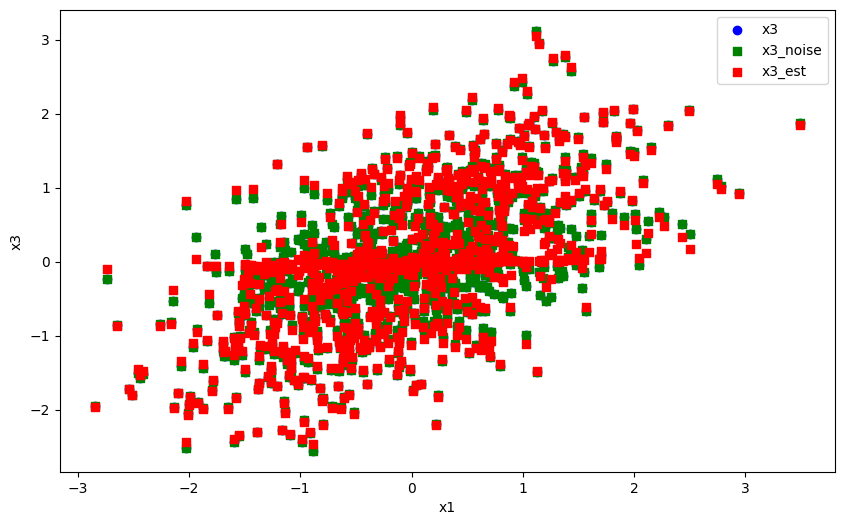

The programm is closed


In [9]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 2], X.detach().numpy()[:, 1], label='x3', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 2], X_true.detach().numpy()[:, 1], label='x3_noise', color='green', marker='s') 
plt.scatter(X.detach().numpy()[:, 2], x_est.detach().numpy()[:, 1], label='x3_est', color='red', marker='s') 
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.show()
print("The programm is closed")

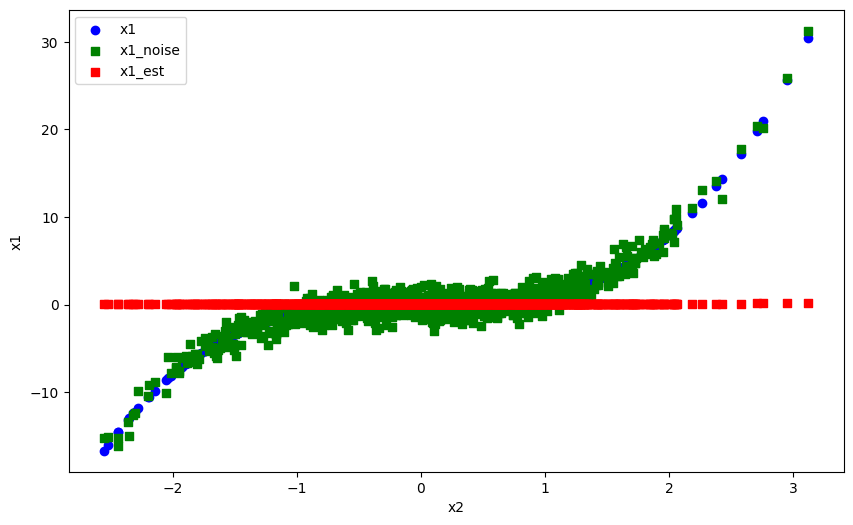

The programm is closed


In [10]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x1', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 1], X_true.detach().numpy()[:, 0], label='x1_noise', color='green', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x1_est', color='red', marker='s') 
plt.xlabel('x2')
plt.ylabel('x1')
plt.legend()
plt.show()
print("The programm is closed")